In [0]:
%python 
%pip install xgboost 

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# TODO Load the trainers from the trainers folder
# Note it might be necessary to change the import of each trainer to the appropriate path for the abstract class Trainer
from abstract_classes.trainer import Trainer
# Import the Trainer classes from the trainers folder
from trainers.trainer_decision_tree import TrainerDecisionTree
from trainers.trainer_average_last_year import TrainerAverageLastYear
from trainers.trainer_gradient_boosting import TrainerGradientBoosting
from trainers.trainer_knn import TrainerKNeighborsRegressor
from trainers.trainer_random_forest import TrainerRandomForest
from trainers.trainer_xgboost import TrainerXGBoost
from trainers.trainer_moving_average import TrainerMovingAverage
from trainers.trainer_value_last_years import TrainerValueLastYears
from trainers.trainer_random_forest_pattern import TrainerRandomForestPattern
from trainers.trainer_xgboost_pattern import TrainerXGBoostPattern
from trainers.trainer_majority_selector import TrainerMajoritySelector
from clairevoyance.helper_functions.dataframe_transformer import DataframeTransformer
from clairevoyance.helper_functions.pattern_finder import PatternFinder
from clairevoyance.helper_functions.trend_finder import TrendFinder

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

%pip install optuna
import time
import optuna

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# load the data
file_path1 = "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/data/dagdata_new.csv"
file_path2 = "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/data/maanddata_new.csv"
file_path3 = "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/data/Madrid Daily Weather 1997-2015_claire_raw_new.csv"
file_path4 = "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/data/weekdata_new.csv"

day = pd.read_csv(file_path1)
week = pd.read_csv(file_path4)
month = pd.read_csv(file_path2)
weather = pd.read_csv(file_path3)

##Basic Data Inspection

In [0]:
weather = weather.rename(columns={'CET': 'date'})

##Data preprocessing

In [0]:
day = day.rename(columns={'Datum':'date', 'Bedrag': 'value', 'Categorie': 'category'})
order = ['category', 'date', 'value']
day = day[order]

In [0]:
week['date'] = pd.to_datetime(week['date']).dt.strftime('%m/%d/%Y')

In [0]:
# translate column names and reorder columns
day = day.rename(columns={'Datum':'date', 'Bedrag': 'value', 'Categorie': 'category'})
order = ['category', 'date', 'value']
day = day[order]

In [0]:
def process_dates(df): 
  '''
  Convert date column to datetime format and set as index
  Input: dataframe 
  Output: dataframe with datetime index
  ''' 
  df['date'] = pd.to_datetime(df['date']) #Convert date column to datetime 
  df_indexed = df.set_index('date').sort_index() #Set date as index
  df_indexed = df_indexed.sort_index() #Ensure the index is sorted
  print("Date range in dataset")
  print(f"Start date: {df_indexed.index.min()}")
  print(f"End date: {df_indexed.index.max()}")
  return df_indexed
day_processed = process_dates(day)
week_processed = process_dates(week)
month_processed = process_dates(month)
weather_processed = process_dates(weather)

Date range in dataset
Start date: 2020-01-01 00:00:00
End date: 2023-12-28 00:00:00
Date range in dataset
Start date: 2022-01-03 00:00:00
End date: 2023-01-01 00:00:00
Date range in dataset
Start date: 2020-01-01 00:00:00
End date: 2023-12-31 00:00:00
Date range in dataset
Start date: 1997-01-01 00:00:00
End date: 2015-12-31 00:00:00


Handle outliers using Interquartile range (IQR)
https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data/

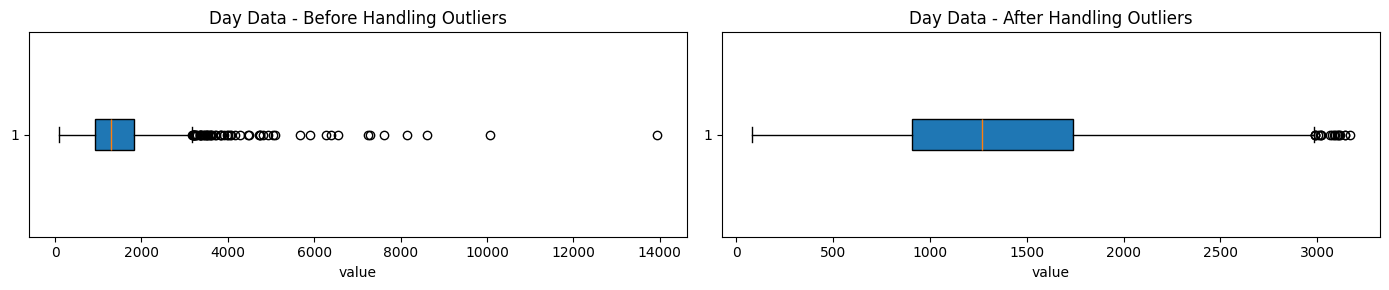

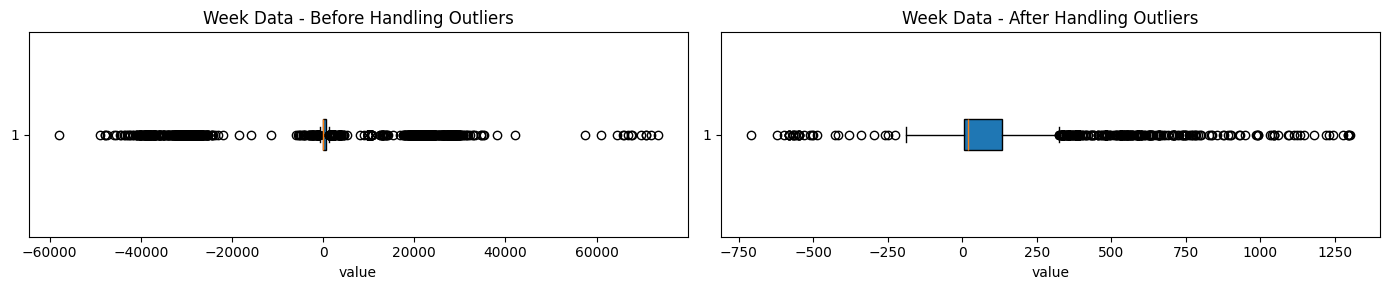

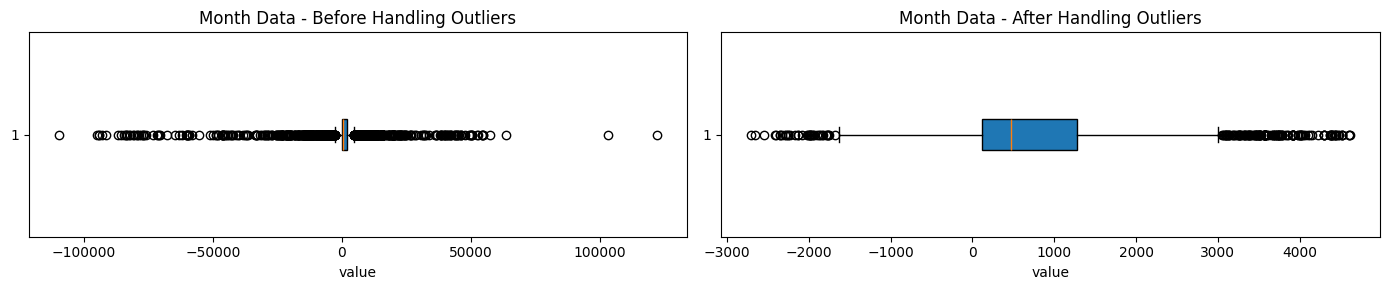

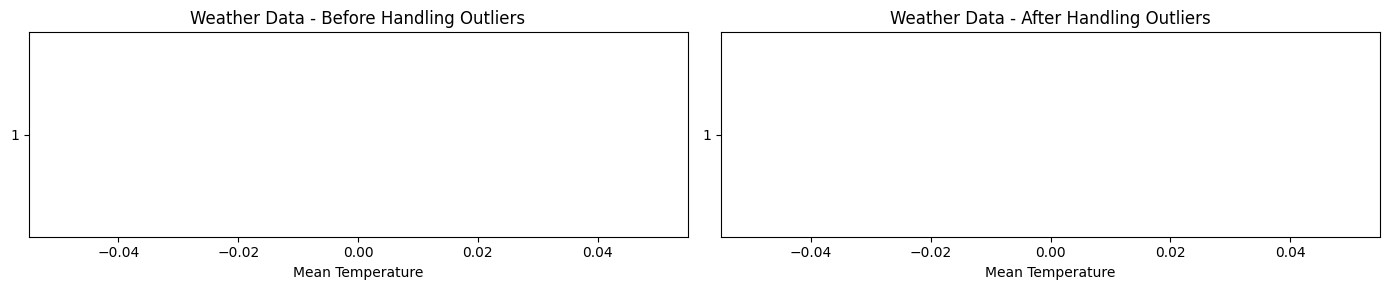

In [0]:
#Removes outliers using the IQR method
def handle_outliers_with_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return cleaned_df, lower_bound, upper_bound
day_cleaned, day_lower, day_upper = handle_outliers_with_iqr(day, 'value')
week_cleaned, week_lower, week_upper = handle_outliers_with_iqr(week, 'value')
month_cleaned, month_lower, month_upper = handle_outliers_with_iqr(month, 'value')
weather_cleaned, weather_lower, weather_upper = handle_outliers_with_iqr(weather, 'Mean Temperature')

# Plots box plots for before and after handling outliers
def visualize_outliers_step(df_before, df_after, column, title):
    plt.figure(figsize=(14, 3))
    # Before handling outliers
    plt.subplot(1, 2, 1)
    plt.boxplot(df_before[column], vert=False, patch_artist=True)
    plt.title(f"{title} - Before Handling Outliers")
    plt.xlabel(column)
    # After handling outliers
    plt.subplot(1, 2, 2)
    plt.boxplot(df_after[column], vert=False, patch_artist=True)
    plt.title(f"{title} - After Handling Outliers")
    plt.xlabel(column)
    plt.tight_layout()
    plt.show()
#Visualize for each dataset
visualize_outliers_step(day, day_cleaned, 'value', 'Day Data')
visualize_outliers_step(week, week_cleaned, 'value', 'Week Data')
visualize_outliers_step(month, month_cleaned, 'value', 'Month Data')
visualize_outliers_step(weather, weather, 'Mean Temperature', 'Weather Data')


- For each dataset, outliers in the value column were identified using the interquiritle range. Rows containing outliers were removed rom the datasets. This step reduce noise in the data and made it less skewed.
- For day_df outliers extended significanlty beyond the whiskers, with values reaching over 10,000. After handling outliers the extreme values were removed, and the range became more constrained. The data distribution now looks cleaner and easier to interpret. 
- For week_df significant negative and positive outliers distorted the data, with extreme values beyond 50,000. After handling, the outliers were removed, revealing tighter range for the value column. The boxplot now better represents typical weekly values. 
- For month_df, massive outliers exttended to +-100,000, making the dataset highly skewed. After hanling outliers the range reduced significantly, and the boxplot appears more representative of typical monthly data.

- Overall, it is important to handle outliers since they can heavily influence machine learning models, leading to biased predictions. We can clearly see with the boxplots that by removing extreme values, patterns in the data become clearer. Last but not least, cleaner data improves model interpretability and ensures consistency. 


In [0]:
from workalendar.europe import Netherlands

# Initialize calendar for working day and holiday calculations
calendar = Netherlands()
def create_time_features(df):
    """
    Adds required columns to the dataset for trainers.
    
    Args:
    - df (pd.DataFrame): Original DataFrame with 'category', 'value', and 'date'.
    
    Returns:
    - pd.DataFrame: Enriched DataFrame with additional columns.
    """
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert 'date' column to datetime
    
    # Add time-based features
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month_number'] = df['date'].dt.month
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week_number'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    
    # Add flags for date characteristics
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_month_end'] = df['date'].dt.is_month_end
    df['is_quarter_start'] = df['date'].dt.is_quarter_start
    df['is_quarter_end'] = df['date'].dt.is_quarter_end
    df['is_year_start'] = df['date'].dt.is_year_start
    df['is_year_end'] = df['date'].dt.is_year_end
    
    # Calculate working days and holidays
    df['is_holiday'] = df['date'].apply(lambda x: calendar.is_holiday(x) if pd.notnull(x) else False)
    df['is_working_day'] = ~df['is_holiday'] & (df['day_of_week_number'] < 5)  # Exclude weekends
    df['first_workday_of_month'] = df['date'].apply(
        lambda x: calendar.add_working_days(x.replace(day=1), 0) == x if pd.notnull(x) else False
    )

    # Add month start flags
    month_starts = [
        'january_start', 'february_start', 'march_start', 'april_start', 'may_start',
        'june_start', 'july_start', 'august_start', 'september_start',
        'october_start', 'november_start', 'december_start'
    ]
    for i, month in enumerate(month_starts, start=1):
        df[month] = df['date'].dt.month == i
    
    # Add quarter-specific start flags
    df['is_quarter_start_february'] = (df['date'].dt.month == 2) & (df['date'].dt.is_quarter_start)
    df['is_quarter_start_march'] = (df['date'].dt.month == 3) & (df['date'].dt.is_quarter_start)

    return df


In [0]:
day_cleaned = create_time_features(day_cleaned)
week_cleaned = create_time_features(week_cleaned)
month_cleaned = create_time_features(month_cleaned)
weather_cleaned = create_time_features(weather_cleaned)

In [0]:
day_processed.head()

,category,value
date,,
2020-01-01,A,110.1472
2020-01-02,A,1470.6150
2020-01-03,A,930.9496
2020-01-04,A,1152.1100
2020-01-05,A,692.6490


In [0]:
day_cleaned_outliers = create_time_features(day)
week_cleaned_outliers = create_time_features(week)
month_cleaned_outliers = create_time_features(month)
weather_cleaned_outliers = create_time_features(weather)

Split dataset without handiling outliers

In [0]:
# Function to split dataset by category
def split_dataset(df, name_prefix):
    split_dfs = {}
    unique_categories = df['category'].unique()
    
    for category in unique_categories:
        filtered_df = df[df['category'] == category].copy()
        filtered_df.reset_index(drop=True, inplace=True)
        split_dfs[f"{name_prefix}_{category.replace(' ', '_').lower()}"] = filtered_df
    
    return split_dfs


# Split dataset
week_split = split_dataset(week_cleaned, 'week_data_cleaned') 
month_split = split_dataset(month_cleaned, 'month_data_cleaned') 

#dictionary
all_split_data = {**week_split, **month_split}

MIN_ROWS = 3
all_split_data = {name: df for name, df in all_split_data.items() if len(df) >= MIN_ROWS}

all_split_data['day_data'] = day_cleaned
all_split_data['weather_data'] = weather_cleaned

print("New datasets created:")
for name in all_split_data.keys():
    print(name)

print(f"\nTotal datasets created: {len(week_split) + len(month_split)}")
print(f"Datasets retained after filtering: {len(all_split_data)}")
print(f"Skipped datasets due to insufficient rows: {len(week_split) + len(month_split) - len(all_split_data)}")

New datasets created:
week_data_cleaned_algemene_kosten
week_data_cleaned_autokosten
week_data_cleaned_exploitatie-_en_machinekosten
week_data_cleaned_huisvestingskosten
week_data_cleaned_kantoorkosten
week_data_cleaned_lonen_en_salarissen
week_data_cleaned_overige_bedrijfsopbrengsten
week_data_cleaned_overige_personeelskosten
week_data_cleaned_overige_rentelasten
week_data_cleaned_sociale_lasten
week_data_cleaned_verkoopkosten
month_data_cleaned_afschrijvingen_mva
month_data_cleaned_afschrijvingen_iva
month_data_cleaned_omzet
month_data_cleaned_algemene_kosten
month_data_cleaned_autokosten
month_data_cleaned_overige_rentelasten
month_data_cleaned_pensioenlasten
month_data_cleaned_lonen_en_salarissen
month_data_cleaned_overige_personeelskosten
month_data_cleaned_sociale_lasten
month_data_cleaned_exploitatie-_en_machinekosten
month_data_cleaned_kostprijs_van_de_omzet
month_data_cleaned_kantoorkosten
month_data_cleaned_verkoopkosten
month_data_cleaned_huisvestingskosten
day_data
weather_

In [0]:
# Function to split dataset by category
def split_dataset(df, name_prefix):
    split_dfs = {}
    unique_categories = df['category'].unique()
    
    for category in unique_categories:
        filtered_df = df[df['category'] == category].copy()
        filtered_df.reset_index(drop=True, inplace=True)
        split_dfs[f"{name_prefix}_{category.replace(' ', '_').lower()}"] = filtered_df
    
    return split_dfs


# Split dataset
week_split = split_dataset(week_cleaned, 'week_data_cleaned') 
month_split = split_dataset(month_cleaned, 'month_data_cleaned') 

#dictionary
all_split_data = {**week_split, **month_split, weather_cleaned_outliers, day_cleaned_outliers}

MIN_ROWS = 3
all_split_data = {name: df for name, df in all_split_data.items() if len(df) >= MIN_ROWS}

print("New datasets created:")
for name in all_split_data.keys():
    print(name)

print(f"\nTotal datasets created: {len(week_split) + len(month_split)}")
print(f"Datasets retained after filtering: {len(all_split_data)}")
print(f"Skipped datasets due to insufficient rows: {len(week_split) + len(month_split) - len(all_split_data)}")

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-665646844167802>, line 15
     11     return split_dfs
     14 # Split dataset
---> 15 week_split = split_dataset(week_cleaned, 'week_data_cleaned') 
     16 month_split = split_dataset(month_cleaned, 'month_data_cleaned') 
     18 #dictionary

NameError: name 'week_cleaned' is not defined

In [0]:
# Dynamically create variables for each category and type (week or month)
globals().update({
    name: df for name, df in all_split_data.items()
})

# Print confirmation of created variables
print("The following variables have been created:")
for name in all_split_data.keys():
    print(name)

The following variables have been created:
week_data_cleaned_algemene_kosten
week_data_cleaned_autokosten
week_data_cleaned_exploitatie-_en_machinekosten
week_data_cleaned_huisvestingskosten
week_data_cleaned_kantoorkosten
week_data_cleaned_lonen_en_salarissen
week_data_cleaned_overige_bedrijfsopbrengsten
week_data_cleaned_overige_personeelskosten
week_data_cleaned_overige_rentelasten
week_data_cleaned_sociale_lasten
week_data_cleaned_verkoopkosten
month_data_cleaned_afschrijvingen_mva
month_data_cleaned_afschrijvingen_iva
month_data_cleaned_omzet
month_data_cleaned_algemene_kosten
month_data_cleaned_autokosten
month_data_cleaned_overige_rentelasten
month_data_cleaned_pensioenlasten
month_data_cleaned_lonen_en_salarissen
month_data_cleaned_overige_personeelskosten
month_data_cleaned_sociale_lasten
month_data_cleaned_exploitatie-_en_machinekosten
month_data_cleaned_kostprijs_van_de_omzet
month_data_cleaned_kantoorkosten
month_data_cleaned_verkoopkosten
month_data_cleaned_huisvestingskos

In [0]:

def prepare_category_dataset(df: pd.DataFrame, frequency: str = 'week') -> pd.DataFrame:
    """
    Transform a category dataset into the format required by trainers.
    
    Args:
        df: Input DataFrame for a specific category
        frequency: Data frequency ('week' or 'month')
        
    Returns:
        DataFrame with all required features for trainers
    """
    # Create copy to avoid modifying original
    prepared_df = df.copy()
    
    # Ensure date is datetime
    prepared_df['date'] = pd.to_datetime(prepared_df['date'])
    
    # Extract time components required by trainers
    prepared_df['year'] = prepared_df['date'].dt.year
    prepared_df['quarter'] = prepared_df['date'].dt.quarter
    prepared_df['month_number'] = prepared_df['date'].dt.month
    prepared_df['week_of_year'] = prepared_df['date'].dt.isocalendar().week
    prepared_df['day_of_year'] = prepared_df['date'].dt.dayofyear
    prepared_df['day_of_week_number'] = prepared_df['date'].dt.dayofweek
    
    # Create boolean flags
    prepared_df['is_month_start'] = prepared_df['date'].dt.is_month_start
    prepared_df['is_month_end'] = prepared_df['date'].dt.is_month_end
    prepared_df['is_quarter_start'] = prepared_df['date'].dt.is_quarter_start
    prepared_df['is_quarter_end'] = prepared_df['date'].dt.is_quarter_end
    prepared_df['is_year_start'] = prepared_df['date'].dt.is_year_start
    prepared_df['is_year_end'] = prepared_df['date'].dt.is_year_end
    
    # Create is_working_day column
    prepared_df['is_working_day'] = prepared_df['day_of_week_number'].apply(lambda x: x < 5)  # Monday to Friday

    # Create first_workday_of_month column
    # First, find the first working day for each month
    prepared_df['first_working_day'] = (
        prepared_df[prepared_df['is_working_day']]
        .groupby(['year', 'month_number'])['date']
        .transform('min')
    )

    # Compare 'date' with 'first_working_day' to create the boolean flag
    prepared_df['first_workday_of_month'] = prepared_df['date'] == prepared_df['first_working_day']

    # Add lag features appropriate for the frequency
    if frequency == 'week':
        lags = [1, 4, 12]  # Previous week, month, quarter
    else:  # month
        lags = [1, 3, 12]  # Previous month, quarter, year
        
    for lag in lags:
        prepared_df[f'value_lag_{lag}'] = prepared_df['value'].shift(lag)
    
    # Drop the helper column 'first_working_day' (optional)
    prepared_df.drop(columns=['first_working_day'], inplace=True)
    
    return prepared_df

# Process all split datasets
def prepare_all_categories(all_split_data: dict) -> dict:
    """
    Prepare all category datasets for trainers.
    
    Args:
        all_split_data: Dictionary of split datasets
        
    Returns:
        Dictionary of prepared datasets
    """
    prepared_datasets = {}
    
    for name, df in all_split_data.items():
        # Determine frequency from name
        frequency = 'week' if 'week' in name else 'month'
        
        # Prepare dataset
        prepared_df = prepare_category_dataset(df, frequency)
        prepared_datasets[name] = prepared_df
        
        print(f"\nPrepared {name}:")
        print(f"Shape: {prepared_df.shape}")
        print(f"Features: {', '.join(prepared_df.columns)}")
    
    return prepared_datasets

# Example usage:
prepared_data = prepare_all_categories(all_split_data)


Prepared week_data_cleaned_afschrijvingen_mva:
Shape: (53, 35)
Features: category, date, value, year, quarter, month_number, week_of_year, day_of_year, day_of_week_number, is_month_start, is_month_end, is_quarter_start, is_quarter_end, is_year_start, is_year_end, is_holiday, is_working_day, first_workday_of_month, january_start, february_start, march_start, april_start, may_start, june_start, july_start, august_start, september_start, october_start, november_start, december_start, is_quarter_start_february, is_quarter_start_march, value_lag_1, value_lag_4, value_lag_12

Prepared week_data_cleaned_algemene_kosten:
Shape: (356, 35)
Features: category, date, value, year, quarter, month_number, week_of_year, day_of_year, day_of_week_number, is_month_start, is_month_end, is_quarter_start, is_quarter_end, is_year_start, is_year_end, is_holiday, is_working_day, first_workday_of_month, january_start, february_start, march_start, april_start, may_start, june_start, july_start, august_start, se

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.12/site-packages/pandas/core/indexes/base.py:3802, in Index.get_loc(self, key, method, tolerance)
   3801 try:
-> 3802     return self._engine.get_loc(casted_key)
   3803 except KeyError as err:

File /databricks/python/lib/python3.12/site-packages/pandas/_libs/index.pyx:138, in pandas._libs.index.IndexEngine.get_loc()

File /databricks/python/lib/python3.12/site-packages/pandas/_libs/index.pyx:165, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:5745, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:5753, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'value'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most rec

##Model prediction

In [0]:
from sklearn.model_selection import train_test_split

# Dictionary to store train/test splits for each dataset
data_splits = {}

# Initialize counters
total_datasets = len(all_split_data)
skipped_datasets = []
processed_datasets = []

# Loop through all datasets in globals
for dataset_name in all_split_data.keys():
    dataset = globals()[dataset_name]  # Access dataset dynamically
    if len(dataset) > 1:  # Only split if dataset has more than one row
        train, test = train_test_split(dataset, test_size=0.3, shuffle=False)  # No shuffle for time series
        data_splits[dataset_name] = {'train': train, 'test': test}
        processed_datasets.append(dataset_name)
    else:
        skipped_datasets.append(dataset_name)
        print(f"Skipping dataset '{dataset_name}' due to insufficient data (only {len(dataset)} row(s)).")

# Print summary
print("\n=== Dataset Split Summary ===")
print(f"Total datasets: {total_datasets}")
print(f"Successfully split: {len(processed_datasets)}")
print(f"Skipped: {len(skipped_datasets)}\n")

# Print details of processed datasets
for dataset_name, splits in data_splits.items():
    print(f"{dataset_name}: Train size = {len(splits['train'])}, Test size = {len(splits['test'])}")

# Print skipped datasets
if skipped_datasets:
    print("\nSkipped datasets:")
    for dataset_name in skipped_datasets:
        print(f"{dataset_name} (only {len(globals()[dataset_name])} row(s))")
else:
    print("\nNo datasets were skipped.")


=== Dataset Split Summary ===
Total datasets: 28
Successfully split: 28
Skipped: 0

week_data_cleaned_algemene_kosten: Train size = 240, Test size = 103
week_data_cleaned_autokosten: Train size = 7, Test size = 3
week_data_cleaned_exploitatie-_en_machinekosten: Train size = 64, Test size = 28
week_data_cleaned_huisvestingskosten: Train size = 181, Test size = 78
week_data_cleaned_kantoorkosten: Train size = 108, Test size = 47
week_data_cleaned_lonen_en_salarissen: Train size = 37, Test size = 17
week_data_cleaned_overige_bedrijfsopbrengsten: Train size = 67, Test size = 29
week_data_cleaned_overige_personeelskosten: Train size = 244, Test size = 105
week_data_cleaned_overige_rentelasten: Train size = 208, Test size = 90
week_data_cleaned_sociale_lasten: Train size = 28, Test size = 12
week_data_cleaned_verkoopkosten: Train size = 217, Test size = 93
month_data_cleaned_afschrijvingen_mva: Train size = 102, Test size = 45
month_data_cleaned_afschrijvingen_iva: Train size = 34, Test siz

In [0]:
import random

def show_random_df_info(dataset_dict, num_rows=5):
    """
    Displays the head and column count of a random DataFrame from the provided dictionary.
    
    Args:
        dataset_dict (dict): Dictionary of DataFrames.
        num_rows (int): Number of rows to display from the head. Default is 5.
    """
    # Randomly select a dataset
    dataset_name = random.choice(list(dataset_dict.keys()))
    dataset = dataset_dict[dataset_name]
    
    # Display dataset name, head, and column count
    print(f"Randomly selected dataset: {dataset_name}")
    print(f"Number of columns: {len(dataset.columns)}")
    return dataset.head(num_rows)

# Example usage
show_random_df_info(all_split_data)

Randomly selected dataset: month_data_cleaned_exploitatie-_en_machinekosten
Number of columns: 32


,category,date,value,year,quarter,month_number,week_of_year,day_of_year,day_of_week_number,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,is_working_day,first_workday_of_month,january_start,february_start,march_start,april_start,may_start,june_start,july_start,august_start,september_start,october_start,november_start,december_start,is_quarter_start_february,is_quarter_start_march
0,Exploitatie- en machinekosten,2020-01-01,54,2020,1,1,1,1,2,True,False,True,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Exploitatie- en machinekosten,2021-01-01,478,2021,1,1,53,1,4,True,False,True,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Exploitatie- en machinekosten,2021-01-01,117,2021,1,1,53,1,4,True,False,True,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Exploitatie- en machinekosten,2022-01-01,3678,2022,1,1,52,1,5,True,False,True,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,Exploitatie- en machinekosten,2022-01-01,677,2022,1,1,52,1,5,True,False,True,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [0]:
# List of trainer instances
trainers = [
    TrainerAverageLastYear(),
    TrainerDecisionTree(),
    TrainerGradientBoosting(),
    TrainerKNeighborsRegressor(),
    TrainerMajoritySelector(),
    TrainerMovingAverage(),
    TrainerRandomForest(),
    TrainerRandomForestPattern(),
    TrainerValueLastYears(),
    TrainerXGBoost(),
    TrainerXGBoostPattern(),
]

In [0]:
# Dictionary to store results for each model and dataset
evaluation_results = []

# Loop through datasets and trainers
for dataset_name, splits in data_splits.items():
    train_data = splits['train']
    test_data = splits['test']
    for trainer in trainers:
        try:
            print(f"Training {trainer.name} on dataset {dataset_name}...")
            
            # Fit the trainer on the training data
            trainer.fit(train_data)
            
            # Predict on the test data
            predictions = trainer.predict(test_data)
            
            # Validate predictions length
            if len(predictions) != len(test_data):
                raise ValueError(
                    f"Prediction length mismatch for model {trainer.name} on dataset {dataset_name}. "
                    f"Expected {len(test_data)}, got {len(predictions)}."
                )
            
            # Store the true values
            actuals = test_data['value']
            
            # Calculate sMAPE and RMSE
            smape_score = smape(actuals, predictions)
            rmse_score = rmse(actuals, predictions)
            mae_score = mae(actuals, predictions)
            r_squared_score = r_squared(actuals, predictions)
            
            # Append results to the list
            evaluation_results.append({
                'Dataset': dataset_name,
                'Model': trainer.name,
                'sMAPE': smape_score,
                'RMSE': rmse_score,
                'MAE': mae_score,
                'R-squared': r_squared_score
            })
        except Exception as e:
            # Log the error for the current trainer and dataset
            print(f"Error for model {trainer.name} on dataset {dataset_name}: {e}")
            evaluation_results.append({
                'Dataset': dataset_name,
                'Model': trainer.name,
                'Error': str(e)
            })

Training Average last year on dataset week_data_cleaned_algemene_kosten...
Training Decision Tree Regressor on dataset week_data_cleaned_algemene_kosten...
Training Gradient Boosting Regressor on dataset week_data_cleaned_algemene_kosten...
Error for model Gradient Boosting Regressor on dataset week_data_cleaned_algemene_kosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
Training KNeighbors Ivo on dataset week_data_cleaned_algemene_kosten...
Training Majority selector on dataset week_data_cleaned_algemene_kosten...
Training Moving Average Pattern on dataset week_data_cleaned_algemene_kosten...
Training Random Forest on dataset week_data_cleaned_algemene_kosten...
Training Random Forest Pattern on dataset week_data_cleaned_algemene_kosten...
Training Value last year on dataset week_data_cleaned_algemene_kosten...
Training XGBoost Thomas on dataset week_data_cleaned_algemene_kosten...
Error for model XGBoost Thomas on dataset week_data_cleaned_algemene_kosten: 'Tra

In [0]:
# Filter out datasets with small train/test sizes
filtered_data_splits = {
    name: splits
    for name, splits in data_splits.items()
    if len(splits['train']) >= 20 and len(splits['test']) >= 10
}

print(f"Filtered datasets: {len(filtered_data_splits)} remaining out of {len(data_splits)}")
for dataset_name, splits in filtered_data_splits.items():
    print(f"{dataset_name}: Train size = {len(splits['train'])}, Test size = {len(splits['test'])}")


Filtered datasets: 27 remaining out of 28
week_data_cleaned_algemene_kosten: Train size = 240, Test size = 103
week_data_cleaned_exploitatie-_en_machinekosten: Train size = 64, Test size = 28
week_data_cleaned_huisvestingskosten: Train size = 181, Test size = 78
week_data_cleaned_kantoorkosten: Train size = 108, Test size = 47
week_data_cleaned_lonen_en_salarissen: Train size = 37, Test size = 17
week_data_cleaned_overige_bedrijfsopbrengsten: Train size = 67, Test size = 29
week_data_cleaned_overige_personeelskosten: Train size = 244, Test size = 105
week_data_cleaned_overige_rentelasten: Train size = 208, Test size = 90
week_data_cleaned_sociale_lasten: Train size = 28, Test size = 12
week_data_cleaned_verkoopkosten: Train size = 217, Test size = 93
month_data_cleaned_afschrijvingen_mva: Train size = 102, Test size = 45
month_data_cleaned_afschrijvingen_iva: Train size = 34, Test size = 15
month_data_cleaned_omzet: Train size = 126, Test size = 54
month_data_cleaned_algemene_kosten: T

In [0]:
# Debugging the data_splits dictionary
print("\n=== Debugging data_splits ===")
print(data_splits)

# Check if data_splits is empty
if not data_splits:
    print("The data_splits dictionary is empty.")
else:
    for dataset_name, splits in data_splits.items():
        print(f"{dataset_name}: Train size = {len(splits['train'])}, Test size = {len(splits['test'])}")



=== Debugging data_splits ===
{'week_data_cleaned_algemene_kosten': {'train':             category  ... is_quarter_start_march
0    Algemene kosten  ...                  False
1    Algemene kosten  ...                  False
2    Algemene kosten  ...                  False
3    Algemene kosten  ...                  False
4    Algemene kosten  ...                  False
..               ...  ...                    ...
235  Algemene kosten  ...                  False
236  Algemene kosten  ...                  False
237  Algemene kosten  ...                  False
238  Algemene kosten  ...                  False
239  Algemene kosten  ...                  False

[240 rows x 32 columns], 'test':             category       date  ...  is_quarter_start_march  predictions
240  Algemene kosten 2022-09-16  ...                   False           -2
241  Algemene kosten 2022-09-17  ...                   False           -2
242  Algemene kosten 2022-09-19  ...                   False           -2
243

Optuna results

In [0]:
import optuna
import time
import numpy as np
import pandas as pd

# Hyperparameter optimization with Optuna
def perform_optuna_hpo(trainer, train_data, test_data, study_name="optuna_hpo", n_trials=15):
    """
    Perform hyperparameter optimization using Optuna for a given trainer instance.
    """
    trial_times = []

    def objective(trial):
        # Start timer for the trial
        start_time = time.time()

        # Define the hyperparameter space based on the trainer's allowed hyperparameters
        hyperparameters = {}
        if hasattr(trainer, "space_hyperparameters"):
            for param, values in trainer.space_hyperparameters.items():
                if isinstance(values[0], int):
                    hyperparameters[param] = trial.suggest_int(param, min(values), max(values))
                elif isinstance(values[0], float):
                    hyperparameters[param] = trial.suggest_float(param, min(values), max(values))
                elif isinstance(values[0], bool):
                    hyperparameters[param] = trial.suggest_categorical(param, [True, False])
                else:
                    hyperparameters[param] = trial.suggest_categorical(param, values)

        print(f"  Trial {trial.number}: Hyperparameters {hyperparameters}")

        # Set the hyperparameters
        trainer.hyperparameters = hyperparameters

        # Fit the model
        trainer.fit(train_data)

        # Predict
        predictions = trainer.predict(test_data)

        # Evaluate metrics
        rmse = ((test_data['value'] - predictions) ** 2).mean() ** 0.5
        mae = abs(test_data['value'] - predictions).mean()
        r2 = 1 - (sum((test_data['value'] - predictions) ** 2) / sum((test_data['value'] - test_data['value'].mean()) ** 2))

        # End timer for the trial
        trial_time = time.time() - start_time
        trial_times.append(trial_time)

        print(f"  Trial {trial.number} completed with RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f} in {trial_time:.2f} seconds")
        return rmse

    # Start timer for the entire optimization process
    start_time = time.time()

    # Create a study and optimize
    study = optuna.create_study(direction="minimize", study_name=study_name)
    study.optimize(objective, n_trials=n_trials)

    # End timer for the entire optimization process
    total_time = time.time() - start_time
    print(f"Total optimization time for {study_name}: {total_time:.2f} seconds")

    print(f"Best hyperparameters for {study_name}: {study.best_params}")
    return study.best_params, total_time, trial_times

def run_trainers_with_hpo(trainers, data_splits, n_trials=15):
    results = []

    # Define weights for combined performance score
    w1, w2, w3 = 0.5, 0.3, 0.2

    for trainer in trainers:
        trainer_name = trainer.__class__.__name__
        print(f"\nProcessing Trainer: {trainer_name}")
        for dataset_name, splits in data_splits.items():
            train_data = splits['train']
            test_data = splits['test']

            print(f"  Optimizing on Dataset: {dataset_name} (Train: {len(train_data)}, Test: {len(test_data)})")

            try:
                # Perform hyperparameter optimization
                best_hyperparams, total_time, trial_times = perform_optuna_hpo(
                    trainer, train_data, test_data, 
                    study_name=f"{trainer_name}_{dataset_name}", 
                    n_trials=n_trials
                )

                # Fit the model with the best hyperparameters
                trainer.hyperparameters = best_hyperparams
                trainer.fit(train_data)

                # Predict on the test dataset
                predictions = trainer.predict(test_data)

                # Compute metrics
                best_rmse = ((test_data['value'] - predictions) ** 2).mean() ** 0.5
                mae = abs(test_data['value'] - predictions).mean()
                r2 = 1 - (sum((test_data['value'] - predictions) ** 2) / sum((test_data['value'] - test_data['value'].mean()) ** 2))

                # Calculate combined performance score
                combined_performance_score = (
                    w1 * (1 / best_rmse) + w2 * (1 / total_time) + w3 * r2
                )

                # Store results in a list of dictionaries
                results.append({
                    "Trainer": trainer_name,
                    "Dataset": dataset_name,
                    "Best_Hyperparameters": best_hyperparams,
                    "Best_RMSE": best_rmse,
                    "MAE": mae,
                    "R2": r2,
                    "Total_Time": total_time,
                    "Average_Trial_Time": np.mean(trial_times),
                    "Combined_Performance_Score": combined_performance_score,
                    "Trial_Times": trial_times
                })

                print(f"  Added results for {trainer_name} on {dataset_name}")

            except Exception as e:
                print(f"  Error with trainer {trainer_name} on dataset {dataset_name}: {e}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv("optuna_hpo_results_with_metrics.csv", index=False)

    print("\nResults saved to 'optuna_hpo_results_with_metrics.csv'")
    return results_df

# Run the optimization
optuna_results_df = run_trainers_with_hpo(trainers, data_splits, n_trials=15)

# Display the results
optuna_results_df.head()


[I 2025-01-19 13:15:20,589] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_algemene_kosten
[I 2025-01-19 13:15:20,616] Trial 0 finished with value: 296.17201771549907 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 296.17201771549907.
[I 2025-01-19 13:15:20,644] Trial 1 finished with value: 296.17201771549907 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 296.17201771549907.
[I 2025-01-19 13:15:20,669] Trial 2 finished with value: 296.17201771549907 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 296.17201771549907.
[I 2025-01-19 13:15:20,694] Trial 3 finished with value: 295.3088804318189 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 3 with value: 295.3088804318189.
[I 2025-01-19 13:15:20,720] Trial 4 finished with value: 296.17201771549907


Processing Trainer: TrainerAverageLastYear
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 0 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343 in 0.03 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 1 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343 in 0.02 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 2 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343 in 0.02 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 3 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277 in 0.02 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 4 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343 in 0.03 seconds
  Trial 5: Hyperparame

[I 2025-01-19 13:15:20,824] Trial 8 finished with value: 295.3088804318189 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 3 with value: 295.3088804318189.
[I 2025-01-19 13:15:20,848] Trial 9 finished with value: 296.17201771549907 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 3 with value: 295.3088804318189.
[I 2025-01-19 13:15:20,885] Trial 10 finished with value: 295.3088804318189 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 3 with value: 295.3088804318189.
[I 2025-01-19 13:15:20,916] Trial 11 finished with value: 295.3088804318189 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 295.3088804318189.
[I 2025-01-19 13:15:20,947] Trial 12 finished with value: 295.3088804318189 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 3 with value: 295.3088804318189.
[I 20

  Trial 8 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277 in 0.02 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 9 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343 in 0.02 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 10 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277 in 0.04 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 11 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277 in 0.03 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 12 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277 in 0.03 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 13 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277 in 0.03 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_p

[I 2025-01-19 13:15:21,038] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_autokosten
[I 2025-01-19 13:15:21,049] Trial 0 finished with value: 37.21514581711727 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 37.21514581711727.
[I 2025-01-19 13:15:21,060] Trial 1 finished with value: 37.21514581711727 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 37.21514581711727.
[I 2025-01-19 13:15:21,071] Trial 2 finished with value: 92.63188795801727 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 37.21514581711727.
[I 2025-01-19 13:15:21,082] Trial 3 finished with value: 37.21514581711727 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 37.21514581711727.
[I 2025-01-19 13:15:21,093] Trial 4 finished with value: 37.21514581711727 and paramet

Total optimization time for TrainerAverageLastYear_week_data_cleaned_algemene_kosten: 0.42 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_algemene_kosten: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Added results for TrainerAverageLastYear on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 0 completed with RMSE: 37.2151, MAE: 30.7037, R²: 0.7914 in 0.01 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 1 completed with RMSE: 37.2151, MAE: 30.7037, R²: 0.7914 in 0.01 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 2 completed with RMSE: 92.6319, MAE: 64.0000, R²: -0.2921 in 0.01 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 3 comple

[I 2025-01-19 13:15:21,225] Trial 13 finished with value: 37.21514581711727 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 37.21514581711727.
[I 2025-01-19 13:15:21,249] Trial 14 finished with value: 37.21514581711727 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 37.21514581711727.
[I 2025-01-19 13:15:21,295] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:15:21,324] Trial 0 finished with value: 395.344124713736 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19 13:15:21,339] Trial 1 finished with value: 397.4713376908004 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19 13:15:21,356] Trial 2 finished with value: 395.3441247

  Trial 13 completed with RMSE: 37.2151, MAE: 30.7037, R²: 0.7914 in 0.02 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 37.2151, MAE: 30.7037, R²: 0.7914 in 0.02 seconds
Total optimization time for TrainerAverageLastYear_week_data_cleaned_autokosten: 0.24 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_autokosten: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Added results for TrainerAverageLastYear on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 0 completed with RMSE: 395.3441, MAE: 317.6291, R²: -1.6346 in 0.02 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 1 completed with RMSE: 397.4713, MAE: 317.2500, R²: -1.6630 in 0.01 seconds
  Trial

[I 2025-01-19 13:15:21,438] Trial 7 finished with value: 395.344124713736 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19 13:15:21,453] Trial 8 finished with value: 397.4713376908004 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19 13:15:21,469] Trial 9 finished with value: 397.4713376908004 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19 13:15:21,498] Trial 10 finished with value: 395.344124713736 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19 13:15:21,522] Trial 11 finished with value: 395.344124713736 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 395.344124713736.
[I 2025-01-19

  Trial 7 completed with RMSE: 395.3441, MAE: 317.6291, R²: -1.6346 in 0.01 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 8 completed with RMSE: 397.4713, MAE: 317.2500, R²: -1.6630 in 0.01 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 9 completed with RMSE: 397.4713, MAE: 317.2500, R²: -1.6630 in 0.01 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 10 completed with RMSE: 395.3441, MAE: 317.6291, R²: -1.6346 in 0.03 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 11 completed with RMSE: 395.3441, MAE: 317.6291, R²: -1.6346 in 0.02 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 12 completed with RMSE: 395.3441, MAE: 317.6291, R²: -1.6346 in 0.02 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_p

[I 2025-01-19 13:15:21,653] Trial 2 finished with value: 147.54825373242198 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 147.54825373242198.
[I 2025-01-19 13:15:21,669] Trial 3 finished with value: 147.54825373242198 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 147.54825373242198.
[I 2025-01-19 13:15:21,683] Trial 4 finished with value: 147.5745315041416 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 147.54825373242198.
[I 2025-01-19 13:15:21,697] Trial 5 finished with value: 147.54825373242198 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 147.54825373242198.
[I 2025-01-19 13:15:21,712] Trial 6 finished with value: 147.5745315041416 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 147.54825373242198.

  Trial 2 completed with RMSE: 147.5483, MAE: 60.3077, R²: -0.2010 in 0.01 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 3 completed with RMSE: 147.5483, MAE: 60.3077, R²: -0.2010 in 0.01 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 4 completed with RMSE: 147.5745, MAE: 60.5654, R²: -0.2014 in 0.01 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 5 completed with RMSE: 147.5483, MAE: 60.3077, R²: -0.2010 in 0.01 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 6 completed with RMSE: 147.5745, MAE: 60.5654, R²: -0.2014 in 0.01 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 7 completed with RMSE: 147.5745, MAE: 60.5654, R²: -0.2014 in 0.01 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'yea

[I 2025-01-19 13:15:21,873] Trial 14 finished with value: 147.54825373242198 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 147.54825373242198.
[I 2025-01-19 13:15:21,888] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_kantoorkosten
[I 2025-01-19 13:15:21,904] Trial 0 finished with value: 360.45042743531025 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 360.45042743531025.
[I 2025-01-19 13:15:21,920] Trial 1 finished with value: 360.45042743531025 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 360.45042743531025.
[I 2025-01-19 13:15:21,936] Trial 2 finished with value: 359.5246930770254 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 359.5246930770254.
[I 2025-01-19 13:15:21,951] Trial 3 finished with value: 359.5246930770254 a

Total optimization time for TrainerAverageLastYear_week_data_cleaned_huisvestingskosten: 0.27 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_huisvestingskosten: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Added results for TrainerAverageLastYear on week_data_cleaned_huisvestingskosten
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 0 completed with RMSE: 360.4504, MAE: 297.2340, R²: -1.6239 in 0.01 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 1 completed with RMSE: 360.4504, MAE: 297.2340, R²: -1.6239 in 0.01 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 2 completed with RMSE: 359.5247, MAE: 295.6069, R²: -1.6104 in 0.01 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'patter

[I 2025-01-19 13:15:22,078] Trial 10 finished with value: 359.5246930770254 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 359.5246930770254.
[I 2025-01-19 13:15:22,103] Trial 11 finished with value: 359.5246930770254 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 2 with value: 359.5246930770254.
[I 2025-01-19 13:15:22,129] Trial 12 finished with value: 359.5246930770254 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 2 with value: 359.5246930770254.
[I 2025-01-19 13:15:22,152] Trial 13 finished with value: 359.5246930770254 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 2 with value: 359.5246930770254.
[I 2025-01-19 13:15:22,178] Trial 14 finished with value: 359.5246930770254 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 359.5246930770254.
[I 2

  Trial 10 completed with RMSE: 359.5247, MAE: 295.6069, R²: -1.6104 in 0.02 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 11 completed with RMSE: 359.5247, MAE: 295.6069, R²: -1.6104 in 0.02 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 12 completed with RMSE: 359.5247, MAE: 295.6069, R²: -1.6104 in 0.02 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 13 completed with RMSE: 359.5247, MAE: 295.6069, R²: -1.6104 in 0.02 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 14 completed with RMSE: 359.5247, MAE: 295.6069, R²: -1.6104 in 0.02 seconds
Total optimization time for TrainerAverageLastYear_week_data_cleaned_kantoorkosten: 0.29 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_kantoorkosten: {'avg_or_med': 'avg', 'time_period': 'year', 'pa

[I 2025-01-19 13:15:22,285] Trial 5 finished with value: 525.6161347527756 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 3 with value: 519.7038183653546.
[I 2025-01-19 13:15:22,300] Trial 6 finished with value: 525.6161347527756 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 3 with value: 519.7038183653546.
[I 2025-01-19 13:15:22,315] Trial 7 finished with value: 519.7038183653546 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 3 with value: 519.7038183653546.
[I 2025-01-19 13:15:22,329] Trial 8 finished with value: 525.6161347527756 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 519.7038183653546.
[I 2025-01-19 13:15:22,344] Trial 9 finished with value: 525.6161347527756 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 519.7038183653546.
[I 2025-

  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 6 completed with RMSE: 525.6161, MAE: 394.1041, R²: -0.0200 in 0.01 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 7 completed with RMSE: 519.7038, MAE: 387.8235, R²: 0.0028 in 0.01 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 8 completed with RMSE: 525.6161, MAE: 394.1041, R²: -0.0200 in 0.01 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 9 completed with RMSE: 525.6161, MAE: 394.1041, R²: -0.0200 in 0.01 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 10 completed with RMSE: 519.7038, MAE: 387.8235, R²: 0.0028 in 0.02 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 11 completed with RMSE: 519.7038, MAE: 387.8235, R²: 0

[I 2025-01-19 13:15:22,651] Trial 1 finished with value: 86.95380950372511 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:22,742] Trial 2 finished with value: 86.95380950372511 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 62.7592553965631.


  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 1 completed with RMSE: 86.9538, MAE: 67.1709, R²: -1.4798 in 0.09 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 2 completed with RMSE: 86.9538, MAE: 67.1709, R²: -1.4798 in 0.09 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:22,831] Trial 3 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:22,921] Trial 4 finished with value: 86.95380950372511 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,009] Trial 5 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.


  Trial 3 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.09 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 4 completed with RMSE: 86.9538, MAE: 67.1709, R²: -1.4798 in 0.09 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 5 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.09 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:23,098] Trial 6 finished with value: 86.95380950372511 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,181] Trial 7 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,274] Trial 8 finished with value: 86.95380950372511 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 62.7592553965631.


  Trial 6 completed with RMSE: 86.9538, MAE: 67.1709, R²: -1.4798 in 0.09 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 7 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.08 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 8 completed with RMSE: 86.9538, MAE: 67.1709, R²: -1.4798 in 0.09 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 9 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.08 seconds

[I 2025-01-19 13:15:23,359] Trial 9 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,457] Trial 10 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,557] Trial 11 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.



  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 10 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.10 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 11 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.10 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:23,655] Trial 12 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,750] Trial 13 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.
[I 2025-01-19 13:15:23,851] Trial 14 finished with value: 62.7592553965631 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 62.7592553965631.


  Trial 12 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.10 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.09 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 62.7593, MAE: 29.8276, R²: -0.2918 in 0.09 seconds
Total optimization time for TrainerAverageLastYear_week_data_cleaned_overige_bedrijfsopbrengsten: 1.38 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_overige_bedrijfsopbrengsten: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:23,950] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_overige_personeelskosten
[I 2025-01-19 13:15:23,975] Trial 0 finished with value: 200.77836340135713 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,000] Trial 1 finished with value: 202.02937669462588 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,023] Trial 2 finished with value: 202.02937669462588 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,047] Trial 3 finished with value: 200.77836340135713 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,076] Trial 4 finished with value: 200.7

  Added results for TrainerAverageLastYear on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 0 completed with RMSE: 200.7784, MAE: 66.7244, R²: -0.0957 in 0.02 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 1 completed with RMSE: 202.0294, MAE: 66.4619, R²: -0.1094 in 0.02 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 2 completed with RMSE: 202.0294, MAE: 66.4619, R²: -0.1094 in 0.02 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 3 completed with RMSE: 200.7784, MAE: 66.7244, R²: -0.0957 in 0.02 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 4 completed with RMSE: 200.7784, MAE: 66.72

[I 2025-01-19 13:15:24,176] Trial 8 finished with value: 200.77836340135713 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,201] Trial 9 finished with value: 200.77836340135713 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,234] Trial 10 finished with value: 202.02937669462588 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,267] Trial 11 finished with value: 200.77836340135713 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 200.77836340135713.
[I 2025-01-19 13:15:24,300] Trial 12 finished with value: 200.77836340135713 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 200.77836340

  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 8 completed with RMSE: 200.7784, MAE: 66.7244, R²: -0.0957 in 0.02 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 9 completed with RMSE: 200.7784, MAE: 66.7244, R²: -0.0957 in 0.02 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 10 completed with RMSE: 202.0294, MAE: 66.4619, R²: -0.1094 in 0.03 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 11 completed with RMSE: 200.7784, MAE: 66.7244, R²: -0.0957 in 0.03 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 12 completed with RMSE: 200.7784, MAE: 66.7244, R²: -0.0957 in 0.03 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 200.7784, MAE: 66.7244, 

[I 2025-01-19 13:15:24,413] Trial 0 finished with value: 215.54453007312537 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 215.54453007312537.
[I 2025-01-19 13:15:24,435] Trial 1 finished with value: 215.54453007312537 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 215.54453007312537.
[I 2025-01-19 13:15:24,455] Trial 2 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 2 with value: 214.75505922039076.
[I 2025-01-19 13:15:24,477] Trial 3 finished with value: 215.54453007312537 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 214.75505922039076.
[I 2025-01-19 13:15:24,498] Trial 4 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 214.7550592203907

  Trial 0 completed with RMSE: 215.5445, MAE: 89.7778, R²: -0.2096 in 0.02 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 1 completed with RMSE: 215.5445, MAE: 89.7778, R²: -0.2096 in 0.02 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 2 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.02 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 3 completed with RMSE: 215.5445, MAE: 89.7778, R²: -0.2096 in 0.02 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 4 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.02 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 5 completed with RMSE: 215.5445, MAE: 89.7778, R²: -0.2096 in 0.02 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week

[I 2025-01-19 13:15:24,639] Trial 10 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 2 with value: 214.75505922039076.
[I 2025-01-19 13:15:24,674] Trial 11 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 214.75505922039076.
[I 2025-01-19 13:15:24,703] Trial 12 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 214.75505922039076.
[I 2025-01-19 13:15:24,731] Trial 13 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 214.75505922039076.
[I 2025-01-19 13:15:24,762] Trial 14 finished with value: 214.75505922039076 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 214.755059

  Trial 10 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.03 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 11 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.03 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 12 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.03 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.03 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 14 completed with RMSE: 214.7551, MAE: 90.6628, R²: -0.2008 in 0.03 seconds
Total optimization time for TrainerAverageLastYear_week_data_cleaned_overige_rentelasten: 0.37 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_overige_rentelasten: {'avg_or_med': 'avg', 'time_period': '

[I 2025-01-19 13:15:24,882] Trial 3 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:24,907] Trial 4 finished with value: 343.3029164937552 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:24,928] Trial 5 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:24,949] Trial 6 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:24,971] Trial 7 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.


  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 3 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.02 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 4 completed with RMSE: 343.3029, MAE: 256.6559, R²: -1.2785 in 0.02 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 5 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.02 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 6 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.02 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 7 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.02 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 8 completed with RMSE: 343.1415, MAE: 257.0760, R²: -

[I 2025-01-19 13:15:24,996] Trial 8 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:25,018] Trial 9 finished with value: 343.3029164937552 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:25,053] Trial 10 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:25,082] Trial 11 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.


  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 9 completed with RMSE: 343.3029, MAE: 256.6559, R²: -1.2785 in 0.02 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 10 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.03 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 11 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.03 seconds


[I 2025-01-19 13:15:25,110] Trial 12 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:25,138] Trial 13 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:25,165] Trial 14 finished with value: 343.141546353643 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 2 with value: 343.141546353643.
[I 2025-01-19 13:15:25,187] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_afschrijvingen_mva


  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 12 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.03 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 13 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.03 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 14 completed with RMSE: 343.1415, MAE: 257.0760, R²: -1.2764 in 0.03 seconds
Total optimization time for TrainerAverageLastYear_week_data_cleaned_verkoopkosten: 0.37 seconds
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_verkoopkosten: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Added results for TrainerAverageLastYear on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 

[I 2025-01-19 13:15:25,319] Trial 0 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 495.2963649169409.
[I 2025-01-19 13:15:25,447] Trial 1 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 495.2963649169409.



  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 1 completed with RMSE: 495.2964, MAE: 364.3300, R²: 0.0243 in 0.13 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 2 completed with RMSE: 495.2964, MAE: 364.3300, R²: 0.0243 in 0.12 seconds


[I 2025-01-19 13:15:25,570] Trial 2 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 495.2963649169409.
[I 2025-01-19 13:15:25,689] Trial 3 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 3 with value: 491.024959763871.


  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 3 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.12 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:25,817] Trial 4 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:25,940] Trial 5 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.


  Trial 4 completed with RMSE: 495.2964, MAE: 364.3300, R²: 0.0243 in 0.13 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 5 completed with RMSE: 495.2964, MAE: 364.3300, R²: 0.0243 in 0.12 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 6 completed with RMSE: 495.2964, MAE: 364.3300, R²: 0.0243 in 0.12 seconds


[I 2025-01-19 13:15:26,062] Trial 6 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:26,180] Trial 7 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:26,302] Trial 8 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.


  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 7 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.12 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 8 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.12 seconds


[I 2025-01-19 13:15:26,440] Trial 9 finished with value: 495.2963649169409 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:26,567] Trial 10 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 3 with value: 491.024959763871.


  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 9 completed with RMSE: 495.2964, MAE: 364.3300, R²: 0.0243 in 0.14 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 10 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.13 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 11 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.13 seconds

[I 2025-01-19 13:15:26,695] Trial 11 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:26,822] Trial 12 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 3 with value: 491.024959763871.



  Trial 12: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 12 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.13 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 13 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.13 seconds


[I 2025-01-19 13:15:26,953] Trial 13 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:27,079] Trial 14 finished with value: 491.024959763871 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 3 with value: 491.024959763871.
[I 2025-01-19 13:15:27,199] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_afschrijvingen_iva


  Trial 14: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 491.0250, MAE: 364.4000, R²: 0.0410 in 0.12 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_afschrijvingen_mva: 1.89 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_afschrijvingen_mva: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Added results for TrainerAverageLastYear on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)


[I 2025-01-19 13:15:27,242] Trial 0 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,286] Trial 1 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,331] Trial 2 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,374] Trial 3 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,419] Trial 4 finished with value: 0.0 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.


  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 0 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 1 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 2 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 3 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 4 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds


[I 2025-01-19 13:15:27,465] Trial 5 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,509] Trial 6 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,553] Trial 7 finished with value: 0.0 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,598] Trial 8 finished with value: 0.0 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,641] Trial 9 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.


  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 5 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 6 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 7 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 8 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 9 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.04 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 10 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.05 seconds


[I 2025-01-19 13:15:27,693] Trial 10 finished with value: 0.0 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,745] Trial 11 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,794] Trial 12 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,847] Trial 13 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.
[I 2025-01-19 13:15:27,896] Trial 14 finished with value: 0.0 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 0.0.


  Trial 11: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 11 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.05 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 12 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.05 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 13 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.05 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 14 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.05 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_afschrijvingen_iva: 0.70 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_afschrijvingen_iva: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Added results for TrainerAverageLastYear on month_data_cleaned_afschrijvingen_iva

[I 2025-01-19 13:15:27,944] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_omzet
[I 2025-01-19 13:15:28,088] Trial 0 finished with value: 851.2408018755784 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 851.2408018755784.
[I 2025-01-19 13:15:28,240] Trial 1 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.


  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 0 completed with RMSE: 851.2408, MAE: 667.8426, R²: -0.0246 in 0.14 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 1 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds


[I 2025-01-19 13:15:28,384] Trial 2 finished with value: 851.2408018755784 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.
[I 2025-01-19 13:15:28,541] Trial 3 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.


  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 2 completed with RMSE: 851.2408, MAE: 667.8426, R²: -0.0246 in 0.14 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 3 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds


[I 2025-01-19 13:15:28,686] Trial 4 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.


  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 4 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.14 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 5 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds

[I 2025-01-19 13:15:28,838] Trial 5 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.
[I 2025-01-19 13:15:28,990] Trial 6 finished with value: 851.2408018755784 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 832.0836507536724.



  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 6 completed with RMSE: 851.2408, MAE: 667.8426, R²: -0.0246 in 0.15 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 7 completed with RMSE: 851.2408, MAE: 667.8426, R²: -0.0246 in 0.14 seconds


[I 2025-01-19 13:15:29,134] Trial 7 finished with value: 851.2408018755784 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 832.0836507536724.
[I 2025-01-19 13:15:29,278] Trial 8 finished with value: 851.2408018755784 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 1 with value: 832.0836507536724.


  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 8 completed with RMSE: 851.2408, MAE: 667.8426, R²: -0.0246 in 0.14 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 9 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds

[I 2025-01-19 13:15:29,425] Trial 9 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 1 with value: 832.0836507536724.
[I 2025-01-19 13:15:29,580] Trial 10 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.



  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 10 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:29,736] Trial 11 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.
[I 2025-01-19 13:15:29,890] Trial 12 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.


  Trial 11 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 12 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 13 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds

[I 2025-01-19 13:15:30,046] Trial 13 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.
[I 2025-01-19 13:15:30,195] Trial 14 finished with value: 832.0836507536724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 1 with value: 832.0836507536724.



  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 14 completed with RMSE: 832.0837, MAE: 662.7670, R²: 0.0210 in 0.15 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_omzet: 2.25 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_omzet: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)


[I 2025-01-19 13:15:30,345] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_algemene_kosten
[I 2025-01-19 13:15:30,555] Trial 0 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.


  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 0 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds


[I 2025-01-19 13:15:30,765] Trial 1 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.


  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 1 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:30,981] Trial 2 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1121.0507904219921.


  Trial 2 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:31,199] Trial 3 finished with value: 1247.3781246668693 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1121.0507904219921.


  Trial 3 completed with RMSE: 1247.3781, MAE: 905.4872, R²: -0.2473 in 0.22 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 4 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds


[I 2025-01-19 13:15:31,409] Trial 4 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.
[I 2025-01-19 13:15:31,627] Trial 5 finished with value: 1247.3781246668693 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1121.0507904219921.


  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 5 completed with RMSE: 1247.3781, MAE: 905.4872, R²: -0.2473 in 0.22 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 6 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.20 seconds


[I 2025-01-19 13:15:31,833] Trial 6 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1121.0507904219921.
[I 2025-01-19 13:15:32,049] Trial 7 finished with value: 1247.3781246668693 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 1121.0507904219921.


  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 7 completed with RMSE: 1247.3781, MAE: 905.4872, R²: -0.2473 in 0.21 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 8 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds

[I 2025-01-19 13:15:32,258] Trial 8 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1121.0507904219921.
[I 2025-01-19 13:15:32,456] Trial 9 finished with value: 1247.3781246668693 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.



  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 9 completed with RMSE: 1247.3781, MAE: 905.4872, R²: -0.2473 in 0.20 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:32,700] Trial 10 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.


  Trial 10 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.24 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 11 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds


[I 2025-01-19 13:15:32,912] Trial 11 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.
[I 2025-01-19 13:15:33,139] Trial 12 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.


  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 12 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.22 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.22 seconds

[I 2025-01-19 13:15:33,359] Trial 13 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.



  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:33,572] Trial 14 finished with value: 1121.0507904219921 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 1121.0507904219921.


  Trial 14 completed with RMSE: 1121.0508, MAE: 903.6408, R²: -0.0075 in 0.21 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_algemene_kosten: 3.23 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_algemene_kosten: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Added results for TrainerAverageLastYear on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)


[I 2025-01-19 13:15:33,782] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_autokosten
[I 2025-01-19 13:15:34,021] Trial 0 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1520.7091809558717.


  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 0 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.24 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}


[I 2025-01-19 13:15:34,259] Trial 1 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1520.7091809558717.


  Trial 1 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.24 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:34,497] Trial 2 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1520.7091809558717.


  Trial 2 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.24 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 3 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.24 seconds


[I 2025-01-19 13:15:34,740] Trial 3 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1520.7091809558717.
[I 2025-01-19 13:15:35,005] Trial 4 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 4 with value: 1351.9611806413977.
[I 2025-01-19 13:15:35,266] Trial 5 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 4 with value: 1351.9611806413977.


  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 4 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.26 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 5 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.26 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 6 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.26 seconds


[I 2025-01-19 13:15:35,529] Trial 6 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 4 with value: 1351.9611806413977.
[I 2025-01-19 13:15:35,779] Trial 7 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 4 with value: 1351.9611806413977.


  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 7 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.25 seconds


[I 2025-01-19 13:15:36,040] Trial 8 finished with value: 1520.7091809558717 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 4 with value: 1351.9611806413977.


  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 8 completed with RMSE: 1520.7092, MAE: 1023.6304, R²: -0.2463 in 0.26 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:36,338] Trial 9 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 4 with value: 1351.9611806413977.


  Trial 9 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.30 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:36,609] Trial 10 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 4 with value: 1351.9611806413977.


  Trial 10 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.27 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:15:36,864] Trial 11 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 4 with value: 1351.9611806413977.


  Trial 11 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.25 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:37,132] Trial 12 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 4 with value: 1351.9611806413977.


  Trial 12 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.27 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.25 seconds


[I 2025-01-19 13:15:37,385] Trial 13 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 4 with value: 1351.9611806413977.
[I 2025-01-19 13:15:37,641] Trial 14 finished with value: 1351.9611806413977 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 4 with value: 1351.9611806413977.


  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 1351.9612, MAE: 1143.7006, R²: 0.0150 in 0.25 seconds


[I 2025-01-19 13:15:37,901] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_overige_rentelasten
[I 2025-01-19 13:15:38,055] Trial 0 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.


Total optimization time for TrainerAverageLastYear_month_data_cleaned_autokosten: 3.86 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_autokosten: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_autokosten
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 0 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 1 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.15 seconds


[I 2025-01-19 13:15:38,205] Trial 1 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:38,357] Trial 2 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:38,496] Trial 3 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.


  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 2 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.15 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 3 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.14 seconds


[I 2025-01-19 13:15:38,634] Trial 4 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:38,776] Trial 5 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.


  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 4 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.14 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 5 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.14 seconds


[I 2025-01-19 13:15:38,922] Trial 6 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:39,060] Trial 7 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.


  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 6 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.14 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 7 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.14 seconds


[I 2025-01-19 13:15:39,207] Trial 8 finished with value: 881.8884009997572 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.


  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 8 completed with RMSE: 881.8884, MAE: 603.4435, R²: -0.1663 in 0.14 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:39,357] Trial 9 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:39,504] Trial 10 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.


  Trial 9 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 10 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 11 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds


[I 2025-01-19 13:15:39,657] Trial 11 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:39,809] Trial 12 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 821.2668118811828.
[I 2025-01-19 13:15:39,963] Trial 13 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.


  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 12 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds


[I 2025-01-19 13:15:40,118] Trial 14 finished with value: 821.2668118811828 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 821.2668118811828.


  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 14 completed with RMSE: 821.2668, MAE: 577.4654, R²: -0.0114 in 0.15 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_overige_rentelasten: 2.22 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_overige_rentelasten: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Added results for TrainerAverageLastYear on month_data_cleaned_overige_rentelasten
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)


[I 2025-01-19 13:15:40,273] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_pensioenlasten
[I 2025-01-19 13:15:40,322] Trial 0 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 460.64666502646037.
[I 2025-01-19 13:15:40,368] Trial 1 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 460.64666502646037.
[I 2025-01-19 13:15:40,411] Trial 2 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 460.64666502646037.
[I 2025-01-19 13:15:40,454] Trial 3 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 460.64666502646037.
[I 2025-01-19 13:15:40,503] Trial 4 finished with value: 433.47820181472

  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 0 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.05 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 1 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.04 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 2 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.04 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 3 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.04 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 4 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.05 seconds


[I 2025-01-19 13:15:40,549] Trial 5 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,593] Trial 6 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,641] Trial 7 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,683] Trial 8 finished with value: 460.64666502646037 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,728] Trial 9 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.


  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 5 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.04 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 6 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.04 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 7 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.05 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 8 completed with RMSE: 460.6467, MAE: 297.3667, R²: 0.0648 in 0.04 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 9 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.04 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:40,781] Trial 10 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,831] Trial 11 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,884] Trial 12 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:40,936] Trial 13 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.


  Trial 10 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.05 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 11 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.05 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 12 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.05 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 13 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.05 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 433.4782, MAE: 389.1784, R²: 0.1719 in 0.05 seconds

[I 2025-01-19 13:15:40,988] Trial 14 finished with value: 433.478201814724 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 4 with value: 433.478201814724.
[I 2025-01-19 13:15:41,042] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_lonen_en_salarissen
[I 2025-01-19 13:15:41,129] Trial 0 finished with value: 1100.372875203784 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1100.372875203784.



Total optimization time for TrainerAverageLastYear_month_data_cleaned_pensioenlasten: 0.72 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_pensioenlasten: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_pensioenlasten
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 0 completed with RMSE: 1100.3729, MAE: 810.4741, R²: -0.0081 in 0.09 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 1 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds


[I 2025-01-19 13:15:41,215] Trial 1 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:41,301] Trial 2 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:41,385] Trial 3 finished with value: 1100.372875203784 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:41,470] Trial 4 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1093.8553304121015.


  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 2 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 3 completed with RMSE: 1100.3729, MAE: 810.4741, R²: -0.0081 in 0.08 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 4 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds


[I 2025-01-19 13:15:41,554] Trial 5 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:41,639] Trial 6 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:41,722] Trial 7 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1093.8553304121015.


  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 5 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 6 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 7 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds


[I 2025-01-19 13:15:41,806] Trial 8 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:41,891] Trial 9 finished with value: 1100.372875203784 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.


  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 8 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.08 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 9 completed with RMSE: 1100.3729, MAE: 810.4741, R²: -0.0081 in 0.08 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:41,986] Trial 10 finished with value: 1100.372875203784 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:42,081] Trial 11 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:42,172] Trial 12 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.


  Trial 10 completed with RMSE: 1100.3729, MAE: 810.4741, R²: -0.0081 in 0.09 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 11 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.09 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 12 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.09 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 13 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.09 seconds

[I 2025-01-19 13:15:42,264] Trial 13 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:42,354] Trial 14 finished with value: 1093.8553304121015 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 1 with value: 1093.8553304121015.
[I 2025-01-19 13:15:42,439] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_overige_personeelskosten



  Trial 14: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 14 completed with RMSE: 1093.8553, MAE: 804.9677, R²: 0.0038 in 0.09 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_lonen_en_salarissen: 1.31 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_lonen_en_salarissen: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:42,620] Trial 0 finished with value: 909.1485443851163 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 909.1485443851163.
[I 2025-01-19 13:15:42,804] Trial 1 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.


  Trial 0 completed with RMSE: 909.1485, MAE: 401.0152, R²: -0.0639 in 0.18 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 1 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.18 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:42,988] Trial 2 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 874.1253483191928.
[I 2025-01-19 13:15:43,167] Trial 3 finished with value: 909.1485443851163 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.


  Trial 2 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.18 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 3 completed with RMSE: 909.1485, MAE: 401.0152, R²: -0.0639 in 0.18 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}


[I 2025-01-19 13:15:43,366] Trial 4 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.
[I 2025-01-19 13:15:43,545] Trial 5 finished with value: 909.1485443851163 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 1 with value: 874.1253483191928.


  Trial 4 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.20 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 5 completed with RMSE: 909.1485, MAE: 401.0152, R²: -0.0639 in 0.18 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 6 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.20 seconds


[I 2025-01-19 13:15:43,750] Trial 6 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.
[I 2025-01-19 13:15:43,927] Trial 7 finished with value: 909.1485443851163 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 1 with value: 874.1253483191928.


  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 7 completed with RMSE: 909.1485, MAE: 401.0152, R²: -0.0639 in 0.18 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:44,123] Trial 8 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.
[I 2025-01-19 13:15:44,295] Trial 9 finished with value: 909.1485443851163 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 874.1253483191928.


  Trial 8 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.19 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 9 completed with RMSE: 909.1485, MAE: 401.0152, R²: -0.0639 in 0.17 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:15:44,485] Trial 10 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.
[I 2025-01-19 13:15:44,676] Trial 11 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 874.1253483191928.


  Trial 10 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.19 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 11 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.19 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:44,941] Trial 12 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 874.1253483191928.


  Trial 12 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.26 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.20 seconds

[I 2025-01-19 13:15:45,149] Trial 13 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.



  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 14 completed with RMSE: 874.1253, MAE: 481.0741, R²: 0.0165 in 0.24 seconds


[I 2025-01-19 13:15:45,395] Trial 14 finished with value: 874.1253483191928 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 1 with value: 874.1253483191928.


Total optimization time for TrainerAverageLastYear_month_data_cleaned_overige_personeelskosten: 3.00 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_overige_personeelskosten: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Added results for TrainerAverageLastYear on month_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)


[I 2025-01-19 13:15:45,711] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_sociale_lasten
[I 2025-01-19 13:15:45,814] Trial 0 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:45,897] Trial 1 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:45,985] Trial 2 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.


  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 0 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.08 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 1 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.08 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 2 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.09 seconds


[I 2025-01-19 13:15:46,069] Trial 3 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:46,151] Trial 4 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.


  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 3 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.08 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 4 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.08 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:46,233] Trial 5 finished with value: 743.5845950529099 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:46,346] Trial 6 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:46,450] Trial 7 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.


  Trial 5 completed with RMSE: 743.5846, MAE: 530.4000, R²: -0.0598 in 0.08 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 6 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.11 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 7 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.08 seconds


[I 2025-01-19 13:15:46,530] Trial 8 finished with value: 743.5845950529099 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:46,613] Trial 9 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:46,702] Trial 10 finished with value: 743.5845950529099 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.


  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}
  Trial 8 completed with RMSE: 743.5846, MAE: 530.4000, R²: -0.0598 in 0.08 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 9 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.08 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 10 completed with RMSE: 743.5846, MAE: 530.4000, R²: -0.0598 in 0.09 seconds


[I 2025-01-19 13:15:46,793] Trial 11 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:46,882] Trial 12 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 708.2698013537029.


  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 11 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.09 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 12 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.09 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:46,977] Trial 13 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:47,074] Trial 14 finished with value: 708.2698013537029 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 708.2698013537029.
[I 2025-01-19 13:15:47,164] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_exploitatie-_en_machinekosten


  Trial 13 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.09 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 14 completed with RMSE: 708.2698, MAE: 501.3493, R²: 0.0385 in 0.10 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_sociale_lasten: 1.36 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_sociale_lasten: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:47,287] Trial 0 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:47,398] Trial 1 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.


  Trial 0 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.12 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 1 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.11 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 2 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.11 seconds


[I 2025-01-19 13:15:47,512] Trial 2 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:47,618] Trial 3 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:47,719] Trial 4 finished with value: 1367.0604029340732 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.


  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 3 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 4 completed with RMSE: 1367.0604, MAE: 997.5676, R²: -0.0774 in 0.10 seconds


[I 2025-01-19 13:15:47,823] Trial 5 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:47,925] Trial 6 finished with value: 1367.0604029340732 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.


  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 5 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 6 completed with RMSE: 1367.0604, MAE: 997.5676, R²: -0.0774 in 0.10 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 7 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds


[I 2025-01-19 13:15:48,023] Trial 7 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:48,127] Trial 8 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:48,226] Trial 9 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.


  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 8 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 9 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 10 completed with RMSE: 1367.0604, MAE: 997.5676, R²: -0.0774 in 0.10 seconds


[I 2025-01-19 13:15:48,328] Trial 10 finished with value: 1367.0604029340732 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:48,436] Trial 11 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:48,541] Trial 12 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.


  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 11 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.11 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 12 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds


[I 2025-01-19 13:15:48,652] Trial 13 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 1194.7978837047015.
[I 2025-01-19 13:15:48,757] Trial 14 finished with value: 1194.7978837047015 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 1194.7978837047015.


  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 13 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.11 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 14 completed with RMSE: 1194.7979, MAE: 937.8255, R²: 0.1770 in 0.10 seconds


[I 2025-01-19 13:15:48,858] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_kostprijs_van_de_omzet
[I 2025-01-19 13:15:49,002] Trial 0 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.


Total optimization time for TrainerAverageLastYear_month_data_cleaned_exploitatie-_en_machinekosten: 1.59 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_exploitatie-_en_machinekosten: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 0 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.14 seconds


[I 2025-01-19 13:15:49,141] Trial 1 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:49,269] Trial 2 finished with value: 1371.1733574942605 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 1284.8064530123156.


  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 1 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.13 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 2 completed with RMSE: 1371.1734, MAE: 984.2656, R²: -0.1530 in 0.13 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 3 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.14 seconds

[I 2025-01-19 13:15:49,408] Trial 3 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:49,545] Trial 4 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 1284.8064530123156.



  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 4 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.14 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 5 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.14 seconds

[I 2025-01-19 13:15:49,688] Trial 5 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:49,819] Trial 6 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:49,952] Trial 7 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 1284.8064530123156.



  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 6 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.13 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 7 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.13 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 8 completed with RMSE: 1371.1734, MAE: 984.2656, R²: -0.1530 in 0.14 seconds


[I 2025-01-19 13:15:50,089] Trial 8 finished with value: 1371.1733574942605 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:50,222] Trial 9 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.


  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 9 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.13 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:50,357] Trial 10 finished with value: 1371.1733574942605 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.


  Trial 10 completed with RMSE: 1371.1734, MAE: 984.2656, R²: -0.1530 in 0.13 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 11 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.14 seconds


[I 2025-01-19 13:15:50,498] Trial 11 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:50,635] Trial 12 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.


  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 12 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.14 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 13 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.13 seconds


[I 2025-01-19 13:15:50,771] Trial 13 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:50,906] Trial 14 finished with value: 1284.8064530123156 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 1284.8064530123156.
[I 2025-01-19 13:15:51,039] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_kantoorkosten


  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 14 completed with RMSE: 1284.8065, MAE: 984.0263, R²: -0.0124 in 0.13 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_kostprijs_van_de_omzet: 2.05 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_kostprijs_van_de_omzet: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Added results for TrainerAverageLastYear on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)


[I 2025-01-19 13:15:51,209] Trial 0 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.


  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 0 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.17 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}


[I 2025-01-19 13:15:51,380] Trial 1 finished with value: 570.065743911132 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:51,545] Trial 2 finished with value: 570.065743911132 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.


  Trial 1 completed with RMSE: 570.0657, MAE: 365.4603, R²: -0.0897 in 0.17 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 2 completed with RMSE: 570.0657, MAE: 365.4603, R²: -0.0897 in 0.16 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:51,729] Trial 3 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:51,902] Trial 4 finished with value: 570.065743911132 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.


  Trial 3 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.18 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 4 completed with RMSE: 570.0657, MAE: 365.4603, R²: -0.0897 in 0.17 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:52,073] Trial 5 finished with value: 570.065743911132 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:52,242] Trial 6 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.


  Trial 5 completed with RMSE: 570.0657, MAE: 365.4603, R²: -0.0897 in 0.17 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 6 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.17 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:15:52,417] Trial 7 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:52,597] Trial 8 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.


  Trial 7 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.17 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 8 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.18 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:15:52,774] Trial 9 finished with value: 570.065743911132 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:52,951] Trial 10 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.


  Trial 9 completed with RMSE: 570.0657, MAE: 365.4603, R²: -0.0897 in 0.18 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 10 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.18 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:53,133] Trial 11 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:53,305] Trial 12 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.


  Trial 11 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.18 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 12 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.17 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 13 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.18 seconds


[I 2025-01-19 13:15:53,484] Trial 13 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 552.8550348997708.
[I 2025-01-19 13:15:53,659] Trial 14 finished with value: 552.8550348997708 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 552.8550348997708.


  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 552.8550, MAE: 375.7226, R²: -0.0249 in 0.17 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_kantoorkosten: 2.62 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_kantoorkosten: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:15:53,839] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_verkoopkosten
[I 2025-01-19 13:15:53,950] Trial 0 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.


  Added results for TrainerAverageLastYear on month_data_cleaned_kantoorkosten
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 0 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 1 completed with RMSE: 348.4839, MAE: 195.2179, R²: -0.2245 in 0.10 seconds


[I 2025-01-19 13:15:54,052] Trial 1 finished with value: 348.4839461110302 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:54,156] Trial 2 finished with value: 348.4839461110302 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:54,261] Trial 3 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.


  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 2 completed with RMSE: 348.4839, MAE: 195.2179, R²: -0.2245 in 0.10 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 3 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.10 seconds


[I 2025-01-19 13:15:54,369] Trial 4 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:54,470] Trial 5 finished with value: 348.4839461110302 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.


  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 4 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 5 completed with RMSE: 348.4839, MAE: 195.2179, R²: -0.2245 in 0.10 seconds


[I 2025-01-19 13:15:54,577] Trial 6 finished with value: 348.4839461110302 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:54,688] Trial 7 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:54,794] Trial 8 finished with value: 348.4839461110302 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.


  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 6 completed with RMSE: 348.4839, MAE: 195.2179, R²: -0.2245 in 0.11 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 7 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 8 completed with RMSE: 348.4839, MAE: 195.2179, R²: -0.2245 in 0.11 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:54,908] Trial 9 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:55,019] Trial 10 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 319.4535478518266.


  Trial 9 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 10 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds


[I 2025-01-19 13:15:55,130] Trial 11 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.
[I 2025-01-19 13:15:55,240] Trial 12 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.


  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 11 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Trial 12 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds


[I 2025-01-19 13:15:55,350] Trial 13 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 319.4535478518266.


  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 13 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.11 seconds


[I 2025-01-19 13:15:55,477] Trial 14 finished with value: 319.4535478518266 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 319.4535478518266.


  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 14 completed with RMSE: 319.4535, MAE: 193.3625, R²: -0.0290 in 0.12 seconds


[I 2025-01-19 13:15:55,584] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_huisvestingskosten


Total optimization time for TrainerAverageLastYear_month_data_cleaned_verkoopkosten: 1.64 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_verkoopkosten: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}
  Added results for TrainerAverageLastYear on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)


[I 2025-01-19 13:15:55,665] Trial 0 finished with value: 1232.191665285884 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 1232.191665285884.
[I 2025-01-19 13:15:55,754] Trial 1 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 1 with value: 1213.8206632211966.


  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 0 completed with RMSE: 1232.1917, MAE: 953.4333, R²: -0.0466 in 0.08 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 1 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.09 seconds


[I 2025-01-19 13:15:55,840] Trial 2 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.


  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}
  Trial 2 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.08 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:55,931] Trial 3 finished with value: 1232.191665285884 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.
[I 2025-01-19 13:15:56,019] Trial 4 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}. Best is trial 1 with value: 1213.8206632211966.


  Trial 3 completed with RMSE: 1232.1917, MAE: 953.4333, R²: -0.0466 in 0.09 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}
  Trial 4 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.09 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 5 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.08 seconds


[I 2025-01-19 13:15:56,105] Trial 5 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 1213.8206632211966.
[I 2025-01-19 13:15:56,190] Trial 6 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.


  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 6 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.08 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}


[I 2025-01-19 13:15:56,274] Trial 7 finished with value: 1232.191665285884 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.
[I 2025-01-19 13:15:56,360] Trial 8 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}. Best is trial 1 with value: 1213.8206632211966.


  Trial 7 completed with RMSE: 1232.1917, MAE: 953.4333, R²: -0.0466 in 0.08 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 8 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.08 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}
  Trial 9 completed with RMSE: 1232.1917, MAE: 953.4333, R²: -0.0466 in 0.08 seconds


[I 2025-01-19 13:15:56,441] Trial 9 finished with value: 1232.191665285884 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.


  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:15:56,537] Trial 10 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1213.8206632211966.
[I 2025-01-19 13:15:56,628] Trial 11 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.


  Trial 10 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.09 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 11 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.09 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}
  Trial 12 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.09 seconds

[I 2025-01-19 13:15:56,719] Trial 12 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}. Best is trial 1 with value: 1213.8206632211966.



  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 13 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.10 seconds


[I 2025-01-19 13:15:56,817] Trial 13 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.
[I 2025-01-19 13:15:56,905] Trial 14 finished with value: 1213.8206632211966 and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}. Best is trial 1 with value: 1213.8206632211966.


  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}
  Trial 14 completed with RMSE: 1213.8207, MAE: 955.5428, R²: -0.0157 in 0.09 seconds
Total optimization time for TrainerAverageLastYear_month_data_cleaned_huisvestingskosten: 1.32 seconds
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_huisvestingskosten: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:15:57,005] A new study created in memory with name: TrainerAverageLastYear_day_data


  Added results for TrainerAverageLastYear on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:15:58,280] Trial 0 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 0 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.27 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}


[I 2025-01-19 13:15:59,419] Trial 1 finished with value: 695.3738748006145 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 1 completed with RMSE: 695.3739, MAE: 559.4041, R²: -0.0397 in 1.14 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:00,687] Trial 2 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 2 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.27 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:01,955] Trial 3 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 3 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.27 seconds
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}


[I 2025-01-19 13:16:03,091] Trial 4 finished with value: 695.3738748006145 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}. Best is trial 0 with value: 689.4241188933919.


  Trial 4 completed with RMSE: 695.3739, MAE: 559.4041, R²: -0.0397 in 1.13 seconds
  Trial 5: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:16:04,224] Trial 5 finished with value: 695.3738748006145 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 689.4241188933919.


  Trial 5 completed with RMSE: 695.3739, MAE: 559.4041, R²: -0.0397 in 1.13 seconds
  Trial 6: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:05,480] Trial 6 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 6 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.26 seconds
  Trial 7: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}


[I 2025-01-19 13:16:06,619] Trial 7 finished with value: 695.3738748006145 and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}. Best is trial 0 with value: 689.4241188933919.


  Trial 7 completed with RMSE: 695.3739, MAE: 559.4041, R²: -0.0397 in 1.14 seconds
  Trial 8: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}


[I 2025-01-19 13:16:07,748] Trial 8 finished with value: 695.3738748006145 and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 8 completed with RMSE: 695.3739, MAE: 559.4041, R²: -0.0397 in 1.13 seconds
  Trial 9: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}


[I 2025-01-19 13:16:08,883] Trial 9 finished with value: 695.3738748006145 and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}. Best is trial 0 with value: 689.4241188933919.


  Trial 9 completed with RMSE: 695.3739, MAE: 559.4041, R²: -0.0397 in 1.13 seconds
  Trial 10: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:10,203] Trial 10 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 10 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.32 seconds
  Trial 11: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:11,476] Trial 11 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 11 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.27 seconds
  Trial 12: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:12,817] Trial 12 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 12 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.34 seconds
  Trial 13: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:14,088] Trial 13 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 13 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.27 seconds
  Trial 14: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:15,360] Trial 14 finished with value: 689.4241188933919 and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}. Best is trial 0 with value: 689.4241188933919.


  Trial 14 completed with RMSE: 689.4241, MAE: 558.2878, R²: -0.0220 in 1.27 seconds
Total optimization time for TrainerAverageLastYear_day_data: 18.36 seconds
Best hyperparameters for TrainerAverageLastYear_day_data: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}


[I 2025-01-19 13:16:16,642] A new study created in memory with name: TrainerAverageLastYear_weather_data


  Added results for TrainerAverageLastYear on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}


[W 2025-01-19 13:16:16,645] Trial 0 failed with parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_average_last_year.py", line 32, in fit
    trainset = pdf_train[[
               ^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/frame.py", line 3813, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

  Error with trainer TrainerAverageLastYear on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerDecisionTree
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparameters {'max_depth': 23, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 214.4640, MAE: 114.3107, R²: 0.4052 in 0.05 seconds
  Trial 1: Hyperparameters {'max_depth': 40, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 172.4565, MAE: 112.9311, R²: 0.6154 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 29, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 175.3726, MAE: 68.9029, R²: 0.6023 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 54, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with R

[I 2025-01-19 13:16:17,084] Trial 5 finished with value: 172.53284744245641 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,119] Trial 6 finished with value: 214.4636796823943 and parameters: {'max_depth': 52, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,154] Trial 7 finished with value: 185.19318501688724 and parameters: {'max_depth': 92, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,188] Trial 8 finished with value: 183.3364683609564 and parameters: {'max_depth': 66, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,222] Trial 9 finished with value: 183.

  Trial 5 completed with RMSE: 172.5328, MAE: 113.2408, R²: 0.6151 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 52, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 214.4637, MAE: 114.5146, R²: 0.4052 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 92, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 185.1932, MAE: 120.0243, R²: 0.5565 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 66, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 183.3365, MAE: 118.8087, R²: 0.5653 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 40, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 183.3365, MAE: 118.8087, R²: 0.5653 in 0.03 seconds
  Trial 10: Hyperparameters {'max_depth': 72, 'min_samples_split': 6, 'prediction_mode':

[I 2025-01-19 13:16:17,319] Trial 11 finished with value: 172.49102537509438 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,367] Trial 12 finished with value: 172.49102537509438 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,412] Trial 13 finished with value: 183.3364683609564 and parameters: {'max_depth': 27, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,458] Trial 14 finished with value: 183.3364683609564 and parameters: {'max_depth': 38, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.4564502505189.
[I 2025-01-19 13:16:17,492] A new study created in memory with name: Train

  Trial 11 completed with RMSE: 172.4910, MAE: 113.1000, R²: 0.6153 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 9, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 172.4910, MAE: 113.1000, R²: 0.6153 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 27, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 183.3365, MAE: 118.8087, R²: 0.5653 in 0.04 seconds
  Trial 14: Hyperparameters {'max_depth': 38, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 183.3365, MAE: 118.8087, R²: 0.5653 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_algemene_kosten: 0.60 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_algemene_kosten: {'max_depth': 40, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree 

[I 2025-01-19 13:16:17,527] Trial 0 finished with value: 99.09423124817441 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 99.09423124817441.
[I 2025-01-19 13:16:17,562] Trial 1 finished with value: 96.41873953404148 and parameters: {'max_depth': 36, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,597] Trial 2 finished with value: 96.41873953404148 and parameters: {'max_depth': 57, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,631] Trial 3 finished with value: 117.20368978833388 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,665] Trial 4 finished with value:

  Trial 0 completed with RMSE: 99.0942, MAE: 63.6667, R²: -0.4787 in 0.03 seconds
  Trial 1: Hyperparameters {'max_depth': 36, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 96.4187, MAE: 62.0667, R²: -0.3999 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 57, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 96.4187, MAE: 62.0667, R²: -0.3999 in 0.03 seconds
  Trial 3: Hyperparameters {'max_depth': 20, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 117.2037, MAE: 104.5233, R²: -1.0685 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 84, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 96.4187, MAE: 62.0667, R²: -0.3999 in 0.03 seconds
  Trial 5: Hyperparameters {'max_depth': 5, 'min_samples_split': 7, 'prediction_mode

[I 2025-01-19 13:16:17,736] Trial 6 finished with value: 96.41873953404148 and parameters: {'max_depth': 45, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,770] Trial 7 finished with value: 99.09423124817441 and parameters: {'max_depth': 70, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,803] Trial 8 finished with value: 96.41873953404148 and parameters: {'max_depth': 37, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,837] Trial 9 finished with value: 117.20368978833388 and parameters: {'max_depth': 24, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 96.41873953404148.
[I 2025-01-19 13:16:17,882] Trial 10 finished with valu

  Trial 6 completed with RMSE: 96.4187, MAE: 62.0667, R²: -0.3999 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 70, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 99.0942, MAE: 63.6667, R²: -0.4787 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 37, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 96.4187, MAE: 62.0667, R²: -0.3999 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 24, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 117.2037, MAE: 104.5233, R²: -1.0685 in 0.03 seconds
  Trial 10: Hyperparameters {'max_depth': 99, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 99.0942, MAE: 63.6667, R²: -0.4787 in 0.04 seconds
  Trial 11: Hyperparameters {'max_depth': 60, 'min_samples_split': 5, 'prediction_mode': 'AverageT

[I 2025-01-19 13:16:17,978] Trial 12 finished with value: 95.06839643120105 and parameters: {'max_depth': 57, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 12 with value: 95.06839643120105.
[I 2025-01-19 13:16:18,022] Trial 13 finished with value: 101.39526616169022 and parameters: {'max_depth': 43, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 12 with value: 95.06839643120105.
[I 2025-01-19 13:16:18,068] Trial 14 finished with value: 117.20368978833388 and parameters: {'max_depth': 68, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 12 with value: 95.06839643120105.
[I 2025-01-19 13:16:18,100] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:16:18,134] Trial 0 finished with value: 136.37012379654757 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'predi

  Trial 12 completed with RMSE: 95.0684, MAE: 61.3333, R²: -0.3610 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 43, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 101.3953, MAE: 65.0000, R²: -0.5481 in 0.04 seconds
  Trial 14: Hyperparameters {'max_depth': 68, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 117.2037, MAE: 104.5233, R²: -1.0685 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_autokosten: 0.58 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_autokosten: {'max_depth': 57, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'max_depth': 16, 'min_samples_spl

[I 2025-01-19 13:16:18,201] Trial 2 finished with value: 310.69248692005965 and parameters: {'max_depth': 37, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,235] Trial 3 finished with value: 138.3869061079944 and parameters: {'max_depth': 28, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,267] Trial 4 finished with value: 307.55031579634016 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,301] Trial 5 finished with value: 311.033702813239 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,335] Trial 6 finished with value: 138

  Trial 2 completed with RMSE: 310.6925, MAE: 244.2500, R²: -0.6272 in 0.03 seconds
  Trial 3: Hyperparameters {'max_depth': 28, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 138.3869, MAE: 105.0896, R²: 0.6772 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 6, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 307.5503, MAE: 244.7025, R²: -0.5944 in 0.03 seconds
  Trial 5: Hyperparameters {'max_depth': 18, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 311.0337, MAE: 250.3929, R²: -0.6307 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 46, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 138.3869, MAE: 105.0896, R²: 0.6772 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 40, 'min_samples_split': 6, 'prediction_mode': 'Zero'

[I 2025-01-19 13:16:18,405] Trial 8 finished with value: 311.033702813239 and parameters: {'max_depth': 33, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,444] Trial 9 finished with value: 310.3198654441667 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,492] Trial 10 finished with value: 325.0669161880366 and parameters: {'max_depth': 66, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 136.37012379654757.
[I 2025-01-19 13:16:18,540] Trial 11 finished with value: 132.5329887235627 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 11 with value: 132.5329887235627.
[I 2025-01-19 13:16:18,588] Trial 12 finished with

  Trial 9: Hyperparameters {'max_depth': 15, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 310.3199, MAE: 249.5296, R²: -0.6233 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 66, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 325.0669, MAE: 253.0714, R²: -0.7812 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 25, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 132.5330, MAE: 99.0693, R²: 0.7039 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 98, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 141.6650, MAE: 106.9825, R²: 0.6617 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 61, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:18,637] Trial 13 finished with value: 132.5329887235627 and parameters: {'max_depth': 61, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 11 with value: 132.5329887235627.
[I 2025-01-19 13:16:18,686] Trial 14 finished with value: 140.0907780690792 and parameters: {'max_depth': 64, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 11 with value: 132.5329887235627.
[I 2025-01-19 13:16:18,729] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_huisvestingskosten
[I 2025-01-19 13:16:18,764] Trial 0 finished with value: 139.2382830268185 and parameters: {'max_depth': 9, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 139.2382830268185.
[I 2025-01-19 13:16:18,799] Trial 1 finished with value: 139.2382830268185 and parameters: {'max_depth': 58, 'min_samples_split': 8, 'prediction_mode': 'Ze

  Trial 13 completed with RMSE: 132.5330, MAE: 99.0693, R²: 0.7039 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 64, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 140.0908, MAE: 106.1193, R²: 0.6692 in 0.05 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_exploitatie-_en_machinekosten: 0.59 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_exploitatie-_en_machinekosten: {'max_depth': 25, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'max_depth': 9, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 139.2383, MAE: 53.9040, R²: -0.0695 in 0.03 seconds
  Trial 1: Hyperp

[I 2025-01-19 13:16:18,870] Trial 3 finished with value: 139.10879343253757 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:18,902] Trial 4 finished with value: 139.4869355338176 and parameters: {'max_depth': 93, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:18,937] Trial 5 finished with value: 139.69199511324172 and parameters: {'max_depth': 32, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:18,974] Trial 6 finished with value: 142.5258291930957 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:19,008] Trial 7 finished with value: 

  Trial 3 completed with RMSE: 139.1088, MAE: 54.9231, R²: -0.0676 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 93, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 139.4869, MAE: 53.3428, R²: -0.0734 in 0.03 seconds
  Trial 5: Hyperparameters {'max_depth': 32, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 139.6920, MAE: 54.4404, R²: -0.0765 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 49, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 142.5258, MAE: 54.9985, R²: -0.1206 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 55, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 139.6530, MAE: 53.0160, R²: -0.0759 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 41, 'min_samples_split': 10, 'prediction_mode': 'Zero',

[I 2025-01-19 13:16:19,086] Trial 9 finished with value: 139.2382830268185 and parameters: {'max_depth': 80, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:19,130] Trial 10 finished with value: 140.01123830350923 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:19,175] Trial 11 finished with value: 139.16693535978976 and parameters: {'max_depth': 73, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:19,221] Trial 12 finished with value: 142.5258291930957 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:19,266] Trial 13 finished wi

  Trial 9 completed with RMSE: 139.2383, MAE: 53.9040, R²: -0.0695 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 6, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 140.0112, MAE: 53.8108, R²: -0.0815 in 0.04 seconds
  Trial 11: Hyperparameters {'max_depth': 73, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 139.1669, MAE: 55.0513, R²: -0.0684 in 0.04 seconds
  Trial 12: Hyperparameters {'max_depth': 23, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 142.5258, MAE: 54.9985, R²: -0.1206 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 73, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 139.3909, MAE: 54.9679, R²: -0.0719 in 0.04 seconds
  Trial 14: Hyperparameters {'max_depth': 100, 'min_samples_split': 6, 'pr

[I 2025-01-19 13:16:19,312] Trial 14 finished with value: 140.05179252141522 and parameters: {'max_depth': 100, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 139.10879343253757.
[I 2025-01-19 13:16:19,344] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_kantoorkosten
[I 2025-01-19 13:16:19,378] Trial 0 finished with value: 187.0551652389027 and parameters: {'max_depth': 18, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 187.0551652389027.
[I 2025-01-19 13:16:19,414] Trial 1 finished with value: 172.07728038742334 and parameters: {'max_depth': 68, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 172.07728038742334.
[I 2025-01-19 13:16:19,447] Trial 2 finished with value: 181.59546205901054 and parameters: {'max_depth': 36, 'min_samples_split': 10, 'prediction_mode': 'Aver

  Trial 14 completed with RMSE: 140.0518, MAE: 53.9686, R²: -0.0821 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_huisvestingskosten: 0.58 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_huisvestingskosten: {'max_depth': 13, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_huisvestingskosten
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Trial 0: Hyperparameters {'max_depth': 18, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 187.0552, MAE: 113.6562, R²: 0.2934 in 0.03 seconds
  Trial 1: Hyperparameters {'max_depth': 68, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 172.0773, MAE: 86.1383, R²: 0.4020 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 36, 'min_samples_

[I 2025-01-19 13:16:19,517] Trial 4 finished with value: 181.59546205901054 and parameters: {'max_depth': 37, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 172.07728038742334.
[I 2025-01-19 13:16:19,552] Trial 5 finished with value: 171.98835474556148 and parameters: {'max_depth': 95, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 171.98835474556148.
[I 2025-01-19 13:16:19,589] Trial 6 finished with value: 187.0551652389027 and parameters: {'max_depth': 87, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 171.98835474556148.
[I 2025-01-19 13:16:19,623] Trial 7 finished with value: 180.75024425986263 and parameters: {'max_depth': 29, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 171.98835474556148.
[I 2025-01-19 13:16:19,656] Trial 8 finished with value: 172.730

  Trial 5: Hyperparameters {'max_depth': 95, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 171.9884, MAE: 86.1436, R²: 0.4026 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 87, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 187.0552, MAE: 113.6562, R²: 0.2934 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 29, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 180.7502, MAE: 107.2413, R²: 0.3402 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 99, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 172.7303, MAE: 86.8723, R²: 0.3975 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 68, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 205.9593, MAE: 102.3723,

[I 2025-01-19 13:16:19,739] Trial 10 finished with value: 179.5117639717668 and parameters: {'max_depth': 58, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 171.98835474556148.
[I 2025-01-19 13:16:19,788] Trial 11 finished with value: 172.81923898021924 and parameters: {'max_depth': 71, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 171.98835474556148.
[I 2025-01-19 13:16:19,836] Trial 12 finished with value: 169.54344199468247 and parameters: {'max_depth': 99, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 12 with value: 169.54344199468247.
[I 2025-01-19 13:16:19,884] Trial 13 finished with value: 169.538673175555 and parameters: {'max_depth': 100, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 13 with value: 169.538673175555.
[I 2025-01-19 13:16:19,930] Trial 14 finished 

  Trial 10 completed with RMSE: 179.5118, MAE: 90.1596, R²: 0.3492 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 71, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 172.8192, MAE: 86.8723, R²: 0.3968 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 99, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 169.5434, MAE: 85.7447, R²: 0.4195 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 100, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 169.5387, MAE: 85.7021, R²: 0.4195 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 81, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 173.9673, MAE: 91.0213, R²: 0.3888 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_kantoorkos

[I 2025-01-19 13:16:19,964] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_lonen_en_salarissen
[I 2025-01-19 13:16:19,999] Trial 0 finished with value: 461.31865437091125 and parameters: {'max_depth': 60, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 461.31865437091125.
[I 2025-01-19 13:16:20,034] Trial 1 finished with value: 470.3718311894013 and parameters: {'max_depth': 79, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 461.31865437091125.
[I 2025-01-19 13:16:20,067] Trial 2 finished with value: 632.77553868093 and parameters: {'max_depth': 68, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 461.31865437091125.
[I 2025-01-19 13:16:20,102] Trial 3 finished with value: 634.1424292139833 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_remo

  Added results for TrainerDecisionTree on week_data_cleaned_kantoorkosten
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Trial 0: Hyperparameters {'max_depth': 60, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 461.3187, MAE: 369.5659, R²: 0.2143 in 0.03 seconds
  Trial 1: Hyperparameters {'max_depth': 79, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 470.3718, MAE: 393.2624, R²: 0.1832 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 68, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 632.7755, MAE: 424.8824, R²: -0.4783 in 0.03 seconds
  Trial 3: Hyperparameters {'max_depth': 6, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 634.1424, MAE: 433.3918, R²: -0.4847 in 0.03 seconds
  Trial 4: Hyperparameters

[I 2025-01-19 13:16:20,167] Trial 5 finished with value: 635.6116718470762 and parameters: {'max_depth': 63, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 461.31865437091125.
[I 2025-01-19 13:16:20,201] Trial 6 finished with value: 423.08439956224004 and parameters: {'max_depth': 93, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,232] Trial 7 finished with value: 483.0728756068372 and parameters: {'max_depth': 46, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,265] Trial 8 finished with value: 635.6116718470762 and parameters: {'max_depth': 53, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,298] Trial 9 finished with v

  Trial 6: Hyperparameters {'max_depth': 93, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 423.0844, MAE: 337.9482, R²: 0.3391 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 46, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 483.0729, MAE: 337.5676, R²: 0.1385 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 53, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 635.6117, MAE: 447.3129, R²: -0.4915 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 88, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 461.3187, MAE: 369.5659, R²: 0.2143 in 0.03 seconds
  Trial 10: Hyperparameters {'max_depth': 99, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 423

[I 2025-01-19 13:16:20,388] Trial 11 finished with value: 423.08439956224004 and parameters: {'max_depth': 97, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,432] Trial 12 finished with value: 423.08439956224004 and parameters: {'max_depth': 98, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,477] Trial 13 finished with value: 470.3718311894013 and parameters: {'max_depth': 32, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,521] Trial 14 finished with value: 423.08439956224004 and parameters: {'max_depth': 78, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 423.08439956224004.
[I 2025-01-19 13:16:20,554] A new stu


  Trial 12: Hyperparameters {'max_depth': 98, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 423.0844, MAE: 337.9482, R²: 0.3391 in 0.04 seconds
  Trial 13: Hyperparameters {'max_depth': 32, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 470.3718, MAE: 393.2624, R²: 0.1832 in 0.04 seconds
  Trial 14: Hyperparameters {'max_depth': 78, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 423.0844, MAE: 337.9482, R²: 0.3391 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_lonen_en_salarissen: 0.56 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_lonen_en_salarissen: {'max_depth': 93, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_lonen_en_salarissen
  

[I 2025-01-19 13:16:20,621] Trial 1 finished with value: 56.083297040175445 and parameters: {'max_depth': 100, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 56.083297040175445.
[I 2025-01-19 13:16:20,653] Trial 2 finished with value: 56.083705913264296 and parameters: {'max_depth': 75, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 56.083297040175445.
[I 2025-01-19 13:16:20,686] Trial 3 finished with value: 56.082451616440096 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 56.082451616440096.
[I 2025-01-19 13:16:20,719] Trial 4 finished with value: 56.081836754809515 and parameters: {'max_depth': 76, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 56.081836754809515.
[I 2025-01-19 13:16:20,752] Trial 5 finished with value

  Trial 1 completed with RMSE: 56.0833, MAE: 10.8448, R²: -0.0316 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 75, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 56.0837, MAE: 10.8414, R²: -0.0316 in 0.03 seconds
  Trial 3: Hyperparameters {'max_depth': 20, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 56.0825, MAE: 10.6897, R²: -0.0316 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 76, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 56.0818, MAE: 10.7241, R²: -0.0315 in 0.03 seconds
  Trial 5: Hyperparameters {'max_depth': 99, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 56.1157, MAE: 10.9952, R²: -0.0328 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 98, 'min_samples_split': 8, 'prediction_mode': 'Avera

[I 2025-01-19 13:16:20,855] Trial 8 finished with value: 56.11566060840095 and parameters: {'max_depth': 57, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 56.081836754809515.
[I 2025-01-19 13:16:20,887] Trial 9 finished with value: 56.083304910241985 and parameters: {'max_depth': 89, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 56.081836754809515.
[I 2025-01-19 13:16:20,930] Trial 10 finished with value: 56.082451616440096 and parameters: {'max_depth': 61, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 56.081836754809515.
[I 2025-01-19 13:16:20,983] Trial 11 finished with value: 56.081836754809515 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 56.081836754809515.
[I 2025-01-19 13:16:21,030] Trial 12 finished with value: 56.0

  Trial 8 completed with RMSE: 56.1157, MAE: 10.9897, R²: -0.0328 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 89, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 56.0833, MAE: 10.8848, R²: -0.0316 in 0.03 seconds
  Trial 10: Hyperparameters {'max_depth': 61, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 56.0825, MAE: 10.6897, R²: -0.0316 in 0.04 seconds
  Trial 11: Hyperparameters {'max_depth': 20, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 56.0818, MAE: 10.6207, R²: -0.0315 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 6, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 56.0822, MAE: 10.7034, R²: -0.0315 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 70, 'min_samples_split': 4, 'prediction_mode': 'Zero', 

[I 2025-01-19 13:16:21,080] Trial 13 finished with value: 56.08337389624671 and parameters: {'max_depth': 70, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 56.081836754809515.
[I 2025-01-19 13:16:21,127] Trial 14 finished with value: 56.08175989663171 and parameters: {'max_depth': 39, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 14 with value: 56.08175989663171.
[I 2025-01-19 13:16:21,159] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_overige_personeelskosten
[I 2025-01-19 13:16:21,192] Trial 0 finished with value: 615.7107468686281 and parameters: {'max_depth': 41, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 615.7107468686281.
[I 2025-01-19 13:16:21,226] Trial 1 finished with value: 617.8655732978385 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlie

  Trial 13 completed with RMSE: 56.0834, MAE: 10.8621, R²: -0.0316 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 39, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 56.0818, MAE: 10.6724, R²: -0.0315 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_overige_bedrijfsopbrengsten: 0.57 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_overige_bedrijfsopbrengsten: {'max_depth': 39, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Trial 0: Hyperparameters {'max_depth': 41, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 615.7107, MAE: 606.0476, R²: -9.3044 in 0.03 seconds
  Trial 1: Hyperparameter

[I 2025-01-19 13:16:21,295] Trial 3 finished with value: 616.5230877382336 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,329] Trial 4 finished with value: 615.7107468686281 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,361] Trial 5 finished with value: 617.5540076632589 and parameters: {'max_depth': 98, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,395] Trial 6 finished with value: 605.2874248377102 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,430] Trial 7 finished with v

  Trial 3 completed with RMSE: 616.5231, MAE: 606.4724, R²: -9.3316 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 13, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 615.7107, MAE: 606.0476, R²: -9.3044 in 0.03 seconds
  Trial 5: Hyperparameters {'max_depth': 98, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 617.5540, MAE: 606.9905, R²: -9.3662 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 17, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 605.2874, MAE: 595.0762, R²: -8.9585 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 26, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 617.9834, MAE: 607.2000, R²: -9.3806 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 21, 'min_samples_split': 10, 'prediction_m

[I 2025-01-19 13:16:21,497] Trial 9 finished with value: 618.0884913443875 and parameters: {'max_depth': 57, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,546] Trial 10 finished with value: 617.9898822480449 and parameters: {'max_depth': 82, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,592] Trial 11 finished with value: 194.81759478572576 and parameters: {'max_depth': 66, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,638] Trial 12 finished with value: 636.0011006279785 and parameters: {'max_depth': 68, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 194.81759478572576.
[I 2025-01-19 13:16:21,688] Trial 13 finished wi

  Trial 10: Hyperparameters {'max_depth': 82, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 617.9899, MAE: 607.2031, R²: -9.3809 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 66, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 194.8176, MAE: 56.7143, R²: -0.0316 in 0.04 seconds
  Trial 12: Hyperparameters {'max_depth': 68, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 636.0011, MAE: 344.3333, R²: -9.9948 in 0.04 seconds
  Trial 13: Hyperparameters {'max_depth': 69, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 605.2874, MAE: 595.0762, R²: -8.9585 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 41, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:21,738] Trial 14 finished with value: 178.29360483149563 and parameters: {'max_depth': 41, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 14 with value: 178.29360483149563.
[I 2025-01-19 13:16:21,773] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_overige_rentelasten
[I 2025-01-19 13:16:21,808] Trial 0 finished with value: 85.31108652064708 and parameters: {'max_depth': 43, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:21,842] Trial 1 finished with value: 85.3219238140663 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:21,875] Trial 2 finished with value: 85.31937510189452 and parameters: {'max_depth': 61, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'out

  Trial 14 completed with RMSE: 178.2936, MAE: 53.7714, R²: 0.1359 in 0.05 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_overige_personeelskosten: 0.58 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_overige_personeelskosten: {'max_depth': 41, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Trial 0: Hyperparameters {'max_depth': 43, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 85.3111, MAE: 29.8921, R²: 0.8105 in 0.03 seconds
  Trial 1: Hyperparameters {'max_depth': 6, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 85.3219, MAE: 30.0914, R²: 0.8105 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 61, 'm

[I 2025-01-19 13:16:21,943] Trial 4 finished with value: 85.31937510189452 and parameters: {'max_depth': 67, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:21,976] Trial 5 finished with value: 85.31108652064708 and parameters: {'max_depth': 83, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,009] Trial 6 finished with value: 85.31937510189452 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,042] Trial 7 finished with value: 87.62229548845811 and parameters: {'max_depth': 31, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,077] Trial 8 finished with value: 85.311

  Trial 5: Hyperparameters {'max_depth': 83, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 85.3111, MAE: 29.8921, R²: 0.8105 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 22, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 85.3194, MAE: 30.0430, R²: 0.8105 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 31, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 87.6223, MAE: 31.9333, R²: 0.8001 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 94, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 85.3111, MAE: 29.8921, R²: 0.8105 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 70, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 85.3111, MAE: 29.8921, R²: 0.81

[I 2025-01-19 13:16:22,161] Trial 10 finished with value: 85.3141308798125 and parameters: {'max_depth': 43, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,210] Trial 11 finished with value: 85.31597046665217 and parameters: {'max_depth': 47, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,256] Trial 12 finished with value: 94.73110092959615 and parameters: {'max_depth': 81, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,303] Trial 13 finished with value: 85.31215557521033 and parameters: {'max_depth': 55, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 85.31108652064708.
[I 2025-01-19 13:16:22,350] Trial 14 finished with value: 85.31937510189452 a

  Trial 10 completed with RMSE: 85.3141, MAE: 29.9310, R²: 0.8105 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 47, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 85.3160, MAE: 30.0032, R²: 0.8105 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 81, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 94.7311, MAE: 33.8921, R²: 0.7663 in 0.04 seconds
  Trial 13: Hyperparameters {'max_depth': 55, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 85.3122, MAE: 29.8944, R²: 0.8105 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 100, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 85.3194, MAE: 30.0430, R²: 0.8105 in 0.05 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_overige_rentelasten: 0.58 seconds
Best hyperpar

[I 2025-01-19 13:16:22,383] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_sociale_lasten
[W 2025-01-19 13:16:22,415] Trial 0 failed with parameters: {'max_depth': 33, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 44, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) / sum((test_data['value'] - test_data['value'].mean()) ** 2))
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by ze

  Added results for TrainerDecisionTree on week_data_cleaned_overige_rentelasten
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Trial 0: Hyperparameters {'max_depth': 33, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerDecisionTree on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: Hyperparameters {'max_depth': 86, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:22,453] Trial 0 finished with value: 231.98585833336193 and parameters: {'max_depth': 86, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,487] Trial 1 finished with value: 231.98585833336193 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,519] Trial 2 finished with value: 234.36955011584882 and parameters: {'max_depth': 65, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,552] Trial 3 finished with value: 234.36955011584882 and parameters: {'max_depth': 30, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.


  Trial 0 completed with RMSE: 231.9859, MAE: 153.1692, R²: -0.0405 in 0.03 seconds
  Trial 1: Hyperparameters {'max_depth': 8, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 231.9859, MAE: 153.1692, R²: -0.0405 in 0.03 seconds
  Trial 2: Hyperparameters {'max_depth': 65, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 234.3696, MAE: 151.5054, R²: -0.0619 in 0.03 seconds
  Trial 3: Hyperparameters {'max_depth': 30, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 234.3696, MAE: 151.5054, R²: -0.0619 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 53, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 231.9859, MAE: 153.1692, R²: -0.0405 in 0.03 seconds


[I 2025-01-19 13:16:22,584] Trial 4 finished with value: 231.98585833336193 and parameters: {'max_depth': 53, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,617] Trial 5 finished with value: 231.98585833336193 and parameters: {'max_depth': 59, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,649] Trial 6 finished with value: 231.98585833336193 and parameters: {'max_depth': 32, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.


  Trial 5: Hyperparameters {'max_depth': 59, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 231.9859, MAE: 153.1692, R²: -0.0405 in 0.03 seconds
  Trial 6: Hyperparameters {'max_depth': 32, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 231.9859, MAE: 153.1692, R²: -0.0405 in 0.03 seconds
  Trial 7: Hyperparameters {'max_depth': 12, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:22,684] Trial 7 finished with value: 263.4229192925364 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,718] Trial 8 finished with value: 234.36955011584882 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,751] Trial 9 finished with value: 234.36955011584882 and parameters: {'max_depth': 30, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,798] Trial 10 finished with value: 252.000609668148 and parameters: {'max_depth': 91, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.


  Trial 7 completed with RMSE: 263.4229, MAE: 162.1720, R²: -0.3415 in 0.03 seconds
  Trial 8: Hyperparameters {'max_depth': 20, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 234.3696, MAE: 151.5054, R²: -0.0619 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 30, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 234.3696, MAE: 151.5054, R²: -0.0619 in 0.03 seconds
  Trial 10: Hyperparameters {'max_depth': 91, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 252.0006, MAE: 155.0996, R²: -0.2277 in 0.05 seconds


[I 2025-01-19 13:16:22,844] Trial 11 finished with value: 251.39648361968807 and parameters: {'max_depth': 97, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.


  Trial 11: Hyperparameters {'max_depth': 97, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 251.3965, MAE: 155.5269, R²: -0.2218 in 0.04 seconds
  Trial 12: Hyperparameters {'max_depth': 78, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:22,889] Trial 12 finished with value: 252.000609668148 and parameters: {'max_depth': 78, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,934] Trial 13 finished with value: 251.39648361968807 and parameters: {'max_depth': 77, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:22,978] Trial 14 finished with value: 231.98585833336193 and parameters: {'max_depth': 41, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 231.98585833336193.
[I 2025-01-19 13:16:23,012] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_afschrijvingen_mva


  Trial 12 completed with RMSE: 252.0006, MAE: 155.0996, R²: -0.2277 in 0.04 seconds
  Trial 13: Hyperparameters {'max_depth': 77, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 251.3965, MAE: 155.5269, R²: -0.2218 in 0.04 seconds
  Trial 14: Hyperparameters {'max_depth': 41, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 231.9859, MAE: 153.1692, R²: -0.0405 in 0.04 seconds
Total optimization time for TrainerDecisionTree_week_data_cleaned_verkoopkosten: 0.56 seconds
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_verkoopkosten: {'max_depth': 86, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: Hyperparameters {'max_depth': 85, 'min_samples_split': 7, 'pred

[I 2025-01-19 13:16:23,059] Trial 0 finished with value: 555.7228320768126 and parameters: {'max_depth': 85, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 555.7228320768126.


  Trial 0 completed with RMSE: 555.7228, MAE: 420.4162, R²: -0.2283 in 0.05 seconds
  Trial 1: Hyperparameters {'max_depth': 16, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:23,097] Trial 1 finished with value: 523.1380340067471 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 523.1380340067471.
[I 2025-01-19 13:16:23,135] Trial 2 finished with value: 528.9570943469802 and parameters: {'max_depth': 67, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 523.1380340067471.
[I 2025-01-19 13:16:23,175] Trial 3 finished with value: 519.6111290571056 and parameters: {'max_depth': 79, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 519.6111290571056.
[I 2025-01-19 13:16:23,216] Trial 4 finished with value: 528.9570943469802 and parameters: {'max_depth': 82, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 519.6111290571056.
[I 2025-01-19 13:16:23,256] Trial 5 finished with value: 523.5173633563223 and 

  Trial 1 completed with RMSE: 523.1380, MAE: 392.1922, R²: -0.0885 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 67, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 528.9571, MAE: 398.5109, R²: -0.1129 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 79, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 519.6111, MAE: 387.7111, R²: -0.0739 in 0.04 seconds
  Trial 4: Hyperparameters {'max_depth': 82, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 528.9571, MAE: 398.5109, R²: -0.1129 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 60, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 523.5174, MAE: 392.1922, R²: -0.0901 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 17, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'ou

[I 2025-01-19 13:16:23,295] Trial 6 finished with value: 574.1028150651629 and parameters: {'max_depth': 17, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 519.6111290571056.


  Trial 6 completed with RMSE: 574.1028, MAE: 439.8586, R²: -0.3109 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 82, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:23,335] Trial 7 finished with value: 521.2422994858853 and parameters: {'max_depth': 82, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 519.6111290571056.
[I 2025-01-19 13:16:23,372] Trial 8 finished with value: 516.0457106346728 and parameters: {'max_depth': 69, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.
[I 2025-01-19 13:16:23,410] Trial 9 finished with value: 523.1380340067471 and parameters: {'max_depth': 71, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.
[I 2025-01-19 13:16:23,458] Trial 10 finished with value: 556.3394035007856 and parameters: {'max_depth': 35, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.


  Trial 7 completed with RMSE: 521.2423, MAE: 389.0960, R²: -0.0806 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 69, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 516.0457, MAE: 382.9629, R²: -0.0592 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 71, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 523.1380, MAE: 392.1922, R²: -0.0885 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 35, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 556.3394, MAE: 422.7702, R²: -0.2311 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:23,507] Trial 11 finished with value: 519.6111290571056 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.


  Trial 11 completed with RMSE: 519.6111, MAE: 387.7111, R²: -0.0739 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 43, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:23,556] Trial 12 finished with value: 525.4550957831168 and parameters: {'max_depth': 43, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.
[I 2025-01-19 13:16:23,606] Trial 13 finished with value: 528.9570943469802 and parameters: {'max_depth': 100, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.
[I 2025-01-19 13:16:23,654] Trial 14 finished with value: 525.4550957831168 and parameters: {'max_depth': 50, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 516.0457106346728.
[I 2025-01-19 13:16:23,691] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_afschrijvingen_iva


  Trial 12 completed with RMSE: 525.4551, MAE: 393.7627, R²: -0.0982 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 100, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 528.9571, MAE: 398.5109, R²: -0.1129 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 50, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 525.4551, MAE: 393.7627, R²: -0.0982 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_afschrijvingen_mva: 0.64 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_afschrijvingen_mva: {'max_depth': 69, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Trial 0: Hyperparameters {'max_depth': 53, 'min_samples_split'

[I 2025-01-19 13:16:23,729] Trial 0 finished with value: 161.3743060919757 and parameters: {'max_depth': 53, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.


  Trial 0 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 100, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds


[I 2025-01-19 13:16:23,768] Trial 1 finished with value: 161.3743060919757 and parameters: {'max_depth': 100, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:23,809] Trial 2 finished with value: 161.3743060919757 and parameters: {'max_depth': 69, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:23,844] Trial 3 finished with value: 161.3743060919757 and parameters: {'max_depth': 38, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:23,881] Trial 4 finished with value: 161.3743060919757 and parameters: {'max_depth': 37, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:23,919] Trial 5 finished with value: 161.3743060919

  Trial 2: Hyperparameters {'max_depth': 69, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 38, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 37, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 75, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 72, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:23,957] Trial 6 finished with value: 161.3743060919757 and parameters: {'max_depth': 72, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.


  Trial 6 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 89, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:23,996] Trial 7 finished with value: 161.3743060919757 and parameters: {'max_depth': 89, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:24,034] Trial 8 finished with value: 161.3743060919757 and parameters: {'max_depth': 66, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:24,071] Trial 9 finished with value: 161.3743060919757 and parameters: {'max_depth': 61, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:24,121] Trial 10 finished with value: 161.3743060919757 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.


  Trial 7 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 66, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 61, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 8, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 100, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:24,171] Trial 11 finished with value: 161.3743060919757 and parameters: {'max_depth': 100, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.


  Trial 11 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 43, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:24,218] Trial 12 finished with value: 161.3743060919757 and parameters: {'max_depth': 43, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:24,269] Trial 13 finished with value: 161.3743060919757 and parameters: {'max_depth': 16, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:24,320] Trial 14 finished with value: 161.3743060919757 and parameters: {'max_depth': 87, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:24,357] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_omzet


  Trial 12 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 16, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 87, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_afschrijvingen_iva: 0.63 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_afschrijvingen_iva: {'max_depth': 53, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_afschrijvingen_iva
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: Hyperparameters {'max_depth': 11, 'min_samples_split':

[I 2025-01-19 13:16:24,394] Trial 0 finished with value: 997.3739874299168 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 997.3739874299168.


  Trial 0 completed with RMSE: 997.3740, MAE: 755.6602, R²: -0.4066 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 63, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 1080.9535, MAE: 811.5331, R²: -0.6522 in 0.04 seconds


[I 2025-01-19 13:16:24,432] Trial 1 finished with value: 1080.9535055809652 and parameters: {'max_depth': 63, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 997.3739874299168.
[I 2025-01-19 13:16:24,469] Trial 2 finished with value: 1040.2215197851244 and parameters: {'max_depth': 58, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 997.3739874299168.
[I 2025-01-19 13:16:24,507] Trial 3 finished with value: 930.9974043055437 and parameters: {'max_depth': 62, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 930.9974043055437.
[I 2025-01-19 13:16:24,545] Trial 4 finished with value: 1006.7485537932572 and parameters: {'max_depth': 56, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 930.9974043055437.
[I 2025-01-19 13:16:24,582] Trial 5 finished with value: 930.74809751

  Trial 2: Hyperparameters {'max_depth': 58, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1040.2215, MAE: 786.1528, R²: -0.5300 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 62, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 930.9974, MAE: 701.2168, R²: -0.2256 in 0.04 seconds
  Trial 4: Hyperparameters {'max_depth': 56, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 1006.7486, MAE: 760.4869, R²: -0.4331 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 95, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 930.7481, MAE: 707.4647, R²: -0.2249 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 77, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:24,620] Trial 6 finished with value: 939.2690534910416 and parameters: {'max_depth': 77, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.


  Trial 6 completed with RMSE: 939.2691, MAE: 700.2737, R²: -0.2475 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 8, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1041.1204, MAE: 788.2483, R²: -0.5327 in 0.04 seconds

[I 2025-01-19 13:16:24,658] Trial 7 finished with value: 1041.120387505513 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.
[I 2025-01-19 13:16:24,695] Trial 8 finished with value: 941.1491655940466 and parameters: {'max_depth': 36, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.
[I 2025-01-19 13:16:24,732] Trial 9 finished with value: 1006.7485537932572 and parameters: {'max_depth': 87, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.
[I 2025-01-19 13:16:24,780] Trial 10 finished with value: 938.5722445820538 and parameters: {'max_depth': 92, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.



  Trial 8: Hyperparameters {'max_depth': 36, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 941.1492, MAE: 711.0223, R²: -0.2525 in 0.03 seconds
  Trial 9: Hyperparameters {'max_depth': 87, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 1006.7486, MAE: 760.4869, R²: -0.4331 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 92, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 938.5722, MAE: 700.1605, R²: -0.2456 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:24,829] Trial 11 finished with value: 941.1903364979233 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.


  Trial 11 completed with RMSE: 941.1903, MAE: 710.1341, R²: -0.2526 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 35, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:16:24,878] Trial 12 finished with value: 941.1903364979233 and parameters: {'max_depth': 35, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 930.7480975186126.
[I 2025-01-19 13:16:24,927] Trial 13 finished with value: 930.0618191662295 and parameters: {'max_depth': 76, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 13 with value: 930.0618191662295.
[I 2025-01-19 13:16:24,976] Trial 14 finished with value: 929.9888785896393 and parameters: {'max_depth': 79, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 14 with value: 929.9888785896393.
[I 2025-01-19 13:16:25,028] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_algemene_kosten


  Trial 12 completed with RMSE: 941.1903, MAE: 710.1341, R²: -0.2526 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 76, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 930.0618, MAE: 701.2168, R²: -0.2231 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 79, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 929.9889, MAE: 701.1036, R²: -0.2229 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_omzet: 0.62 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_omzet: {'max_depth': 79, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'max_depth': 54, 'min_samples_split': 4, 'prediction_mo

[I 2025-01-19 13:16:25,068] Trial 0 finished with value: 1386.0737686635948 and parameters: {'max_depth': 54, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1386.0737686635948.


  Trial 0 completed with RMSE: 1386.0738, MAE: 1162.1479, R²: -0.5401 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 38, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:25,108] Trial 1 finished with value: 1164.5423732797801 and parameters: {'max_depth': 38, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1164.5423732797801.
[I 2025-01-19 13:16:25,148] Trial 2 finished with value: 1164.3008959358071 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,187] Trial 3 finished with value: 1361.0052672453255 and parameters: {'max_depth': 82, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,224] Trial 4 finished with value: 1357.50101466939 and parameters: {'max_depth': 37, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,264] Trial 5 finished with value: 

  Trial 1 completed with RMSE: 1164.5424, MAE: 972.8846, R²: -0.0872 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 18, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1164.3009, MAE: 968.2997, R²: -0.0867 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 82, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 1361.0053, MAE: 1132.8252, R²: -0.4849 in 0.04 seconds
  Trial 4: Hyperparameters {'max_depth': 37, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 1357.5010, MAE: 1125.0187, R²: -0.4773 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 67, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1380.9804, MAE: 1160.0126, R²: -0.5288 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 87, 'min_samples_split': 7, 'predi

[I 2025-01-19 13:16:25,309] Trial 6 finished with value: 1369.4017875696097 and parameters: {'max_depth': 87, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.


  Trial 6 completed with RMSE: 1369.4018, MAE: 1142.9424, R²: -0.5033 in 0.04 seconds


[I 2025-01-19 13:16:25,350] Trial 7 finished with value: 1173.1955504846253 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,401] Trial 8 finished with value: 1398.145623726322 and parameters: {'max_depth': 28, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,441] Trial 9 finished with value: 1361.3133732961712 and parameters: {'max_depth': 95, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,490] Trial 10 finished with value: 1179.6600440489797 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.


  Trial 7: Hyperparameters {'max_depth': 26, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1173.1956, MAE: 984.3205, R²: -0.1034 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 28, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1398.1456, MAE: 1168.9499, R²: -0.5671 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 95, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 1361.3134, MAE: 1132.8252, R²: -0.4856 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 10, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 1179.6600, MAE: 989.5133, R²: -0.1156 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 6, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:25,542] Trial 11 finished with value: 1165.15976064031 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,595] Trial 12 finished with value: 1177.4955668390608 and parameters: {'max_depth': 43, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,648] Trial 13 finished with value: 1183.5391147989044 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,701] Trial 14 finished with value: 1169.2122392975011 and parameters: {'max_depth': 55, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1164.3008959358071.
[I 2025-01-19 13:16:25,738] A new study created in memory with name: T

  Trial 11 completed with RMSE: 1165.1598, MAE: 977.4244, R²: -0.0883 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 43, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1177.4956, MAE: 988.7510, R²: -0.1115 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 21, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1183.5391, MAE: 994.0854, R²: -0.1229 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 55, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 1169.2122, MAE: 978.9656, R²: -0.0959 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_algemene_kosten: 0.67 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_algemene_kosten: {'max_depth': 18, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDe

[I 2025-01-19 13:16:25,779] Trial 0 finished with value: 1426.4254753632304 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:25,817] Trial 1 finished with value: 1519.6497628743384 and parameters: {'max_depth': 89, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:25,855] Trial 2 finished with value: 1447.0400744465744 and parameters: {'max_depth': 97, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:25,891] Trial 3 finished with value: 1433.5304725025828 and parameters: {'max_depth': 35, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:25,930] Trial 4 finished with value: 1519.23

  Trial 0 completed with RMSE: 1426.4255, MAE: 1230.3185, R²: -0.0965 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 89, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 1519.6498, MAE: 1357.6006, R²: -0.2446 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 97, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1447.0401, MAE: 1242.4811, R²: -0.1285 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 35, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 1433.5305, MAE: 1239.4596, R²: -0.1075 in 0.03 seconds
  Trial 4: Hyperparameters {'max_depth': 39, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 1519.2369, MAE: 1357.6006, R²: -0.2439 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 50, 'min_samples_split': 8, 'prediction_

[I 2025-01-19 13:16:26,005] Trial 6 finished with value: 1503.447384813095 and parameters: {'max_depth': 80, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:26,042] Trial 7 finished with value: 1523.471690021971 and parameters: {'max_depth': 35, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:26,080] Trial 8 finished with value: 1432.1740355897364 and parameters: {'max_depth': 38, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:26,116] Trial 9 finished with value: 1433.5304725025828 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1426.4254753632304.
[I 2025-01-19 13:16:26,165] Trial 10 finished with value: 

  Trial 6 completed with RMSE: 1503.4474, MAE: 1332.1675, R²: -0.2182 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 35, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1523.4717, MAE: 1335.7542, R²: -0.2508 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 38, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1432.1740, MAE: 1241.0996, R²: -0.1054 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 28, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 1433.5305, MAE: 1239.4596, R²: -0.1075 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 5, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 1411.8729, MAE: 1233.6114, R²: -0.0743 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 8, 'min_samples_split': 8, 'prediction_mode': '

[I 2025-01-19 13:16:26,216] Trial 11 finished with value: 1433.1579399392342 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 1411.8729294185791.
[I 2025-01-19 13:16:26,266] Trial 12 finished with value: 1434.01790548331 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 1411.8729294185791.
[I 2025-01-19 13:16:26,318] Trial 13 finished with value: 1447.1156657468678 and parameters: {'max_depth': 18, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 1411.8729294185791.
[I 2025-01-19 13:16:26,369] Trial 14 finished with value: 1447.1156657468678 and parameters: {'max_depth': 66, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 1411.8729294185791.
[I 2025-01-19 13:16:26,409] A new study created in memory with name

  Trial 11 completed with RMSE: 1433.1579, MAE: 1239.4596, R²: -0.1069 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 6, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1434.0179, MAE: 1242.9860, R²: -0.1083 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 18, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1447.1157, MAE: 1233.7737, R²: -0.1286 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 66, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 1447.1157, MAE: 1233.7737, R²: -0.1286 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_autokosten: 0.63 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_autokosten: {'max_depth': 5, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTr

[I 2025-01-19 13:16:26,450] Trial 0 finished with value: 1229.2522095623815 and parameters: {'max_depth': 58, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1229.2522095623815.
[I 2025-01-19 13:16:26,488] Trial 1 finished with value: 988.402508671481 and parameters: {'max_depth': 69, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 988.402508671481.
[I 2025-01-19 13:16:26,528] Trial 2 finished with value: 1224.5854737014763 and parameters: {'max_depth': 70, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 988.402508671481.
[I 2025-01-19 13:16:26,565] Trial 3 finished with value: 1230.6413229628827 and parameters: {'max_depth': 31, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 988.402508671481.
[I 2025-01-19 13:16:26,603] Trial 4 finished with value:

  Trial 0 completed with RMSE: 1229.2522, MAE: 984.8349, R²: -1.2660 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 69, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 988.4025, MAE: 734.8563, R²: -0.4650 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 70, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1224.5855, MAE: 978.4358, R²: -1.2488 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 31, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 1230.6413, MAE: 991.4969, R²: -1.2711 in 0.04 seconds
  Trial 4: Hyperparameters {'max_depth': 38, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 893.6130, MAE: 643.3550, R²: -0.1975 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 99, 'min_samples_split': 8, 'prediction_mode': '

[I 2025-01-19 13:16:26,653] Trial 5 finished with value: 987.1820022738774 and parameters: {'max_depth': 99, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:26,698] Trial 6 finished with value: 979.8957529365442 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:26,736] Trial 7 finished with value: 1228.523880208815 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:26,779] Trial 8 finished with value: 1228.6032143136742 and parameters: {'max_depth': 57, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:26,817] Trial 9 finished with value: 989.9

  Trial 6: Hyperparameters {'max_depth': 20, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 979.8958, MAE: 731.9304, R²: -0.4399 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 25, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1228.5239, MAE: 991.7209, R²: -1.2633 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 57, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1228.6032, MAE: 989.1948, R²: -1.2636 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 45, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 989.9318, MAE: 736.5390, R²: -0.4695 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 10, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:26,868] Trial 10 finished with value: 979.2426177752415 and parameters: {'max_depth': 10, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:26,919] Trial 11 finished with value: 973.8416585221013 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:26,974] Trial 12 finished with value: 978.1737672600759 and parameters: {'max_depth': 11, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:27,035] Trial 13 finished with value: 902.970011521807 and parameters: {'max_depth': 37, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.


  Trial 10 completed with RMSE: 979.2426, MAE: 732.4229, R²: -0.4380 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 7, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 973.8417, MAE: 731.4731, R²: -0.4222 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 11, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 978.1738, MAE: 723.4102, R²: -0.4348 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 37, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 902.9700, MAE: 644.2100, R²: -0.2227 in 0.06 seconds
  Trial 14: Hyperparameters {'max_depth': 40, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:27,090] Trial 14 finished with value: 981.4019594349159 and parameters: {'max_depth': 40, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 893.6130145219893.
[I 2025-01-19 13:16:27,127] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_pensioenlasten
[I 2025-01-19 13:16:27,166] Trial 0 finished with value: 1020081.2354479133 and parameters: {'max_depth': 65, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1020081.2354479133.
[I 2025-01-19 13:16:27,205] Trial 1 finished with value: 547.0933497432895 and parameters: {'max_depth': 45, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,245] Trial 2 finished with value: 641834.4284329144 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlie

  Trial 14 completed with RMSE: 981.4020, MAE: 728.7425, R²: -0.4443 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_overige_rentelasten: 0.68 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_overige_rentelasten: {'max_depth': 38, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_overige_rentelasten
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Trial 0: Hyperparameters {'max_depth': 65, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1020081.2354, MAE: 474039.4151, R²: -4585946.7349 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 45, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 547.0933, MAE: 322.7333, R²: -0.3191 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 18, 'min_

[I 2025-01-19 13:16:27,327] Trial 4 finished with value: 633105.170727581 and parameters: {'max_depth': 67, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,365] Trial 5 finished with value: 744.803865161829 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,404] Trial 6 finished with value: 558.2473344077277 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,446] Trial 7 finished with value: 646890.8726874747 and parameters: {'max_depth': 53, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,485] Trial 8 finished with value: 1045054.3

  Trial 4 completed with RMSE: 633105.1707, MAE: 320887.5827, R²: -1766489.4930 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 20, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 744.8039, MAE: 515.6560, R²: -1.4448 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 22, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 558.2473, MAE: 338.7560, R²: -0.3735 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 53, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 646890.8727, MAE: 306856.1878, R²: -1844256.8064 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 37, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1045054.3293, MAE: 485309.1511, R²: -4813236.8236 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 6, 'min_sample

[I 2025-01-19 13:16:27,580] Trial 10 finished with value: 631.305578411385 and parameters: {'max_depth': 98, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,631] Trial 11 finished with value: 621.4133805178858 and parameters: {'max_depth': 38, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,682] Trial 12 finished with value: 620.6249990829137 and parameters: {'max_depth': 39, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 547.0933497432895.
[I 2025-01-19 13:16:27,739] Trial 13 finished with value: 546.9919560651692 and parameters: {'max_depth': 84, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 13 with value: 546.9919560651692.


  Trial 10: Hyperparameters {'max_depth': 98, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 631.3056, MAE: 411.6667, R²: -0.7565 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 38, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 621.4134, MAE: 404.0007, R²: -0.7018 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 39, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 620.6250, MAE: 399.2007, R²: -0.6975 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 84, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 546.9920, MAE: 320.6000, R²: -0.3186 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 94, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:27,790] Trial 14 finished with value: 689.4470731438829 and parameters: {'max_depth': 94, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 13 with value: 546.9919560651692.
[I 2025-01-19 13:16:27,829] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_lonen_en_salarissen
[I 2025-01-19 13:16:27,867] Trial 0 finished with value: 1134.1974592621755 and parameters: {'max_depth': 74, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1134.1974592621755.
[I 2025-01-19 13:16:27,906] Trial 1 finished with value: 1132.2758454546313 and parameters: {'max_depth': 46, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1132.2758454546313.
[I 2025-01-19 13:16:27,943] Trial 2 finished with value: 1132.2758454546313 and parameters: {'max_depth': 19, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_remova

  Trial 14 completed with RMSE: 689.4471, MAE: 442.7333, R²: -1.0949 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_pensioenlasten: 0.66 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_pensioenlasten: {'max_depth': 84, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_pensioenlasten
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)
  Trial 0: Hyperparameters {'max_depth': 74, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1134.1975, MAE: 968.1558, R²: -0.0710 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 46, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 1132.2758, MAE: 969.1800, R²: -0.0674 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 19, 'min_samples_split': 9, 'predictio

[I 2025-01-19 13:16:28,035] Trial 4 finished with value: 1130.4145616585438 and parameters: {'max_depth': 92, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,074] Trial 5 finished with value: 1135.8858969104247 and parameters: {'max_depth': 31, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,112] Trial 6 finished with value: 1135.2573935370979 and parameters: {'max_depth': 100, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,149] Trial 7 finished with value: 1132.2758454546313 and parameters: {'max_depth': 78, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,186] Trial 8 finished with value: 1134.54892982

  Trial 4 completed with RMSE: 1130.4146, MAE: 966.1190, R²: -0.0639 in 0.05 seconds
  Trial 5: Hyperparameters {'max_depth': 31, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1135.8859, MAE: 969.1800, R²: -0.0742 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 100, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1135.2574, MAE: 969.1800, R²: -0.0730 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 78, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1132.2758, MAE: 969.1800, R²: -0.0674 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 29, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1134.5489, MAE: 969.1800, R²: -0.0717 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 32, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend'

[I 2025-01-19 13:16:28,273] Trial 10 finished with value: 1158.8430675171992 and parameters: {'max_depth': 59, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,322] Trial 11 finished with value: 1160.3312574943354 and parameters: {'max_depth': 50, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,378] Trial 12 finished with value: 1141.0112312585113 and parameters: {'max_depth': 50, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,427] Trial 13 finished with value: 1130.4145616585438 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.


  Trial 10 completed with RMSE: 1158.8431, MAE: 991.3166, R²: -0.1180 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 50, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 1160.3313, MAE: 994.5124, R²: -0.1209 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 50, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1141.0112, MAE: 977.7258, R²: -0.0839 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1130.4146, MAE: 966.1190, R²: -0.0639 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 1130.4146, MAE: 966.1190, R²: -0.0639 in 0.05 seconds


[I 2025-01-19 13:16:28,477] Trial 14 finished with value: 1130.4145616585438 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1130.4145616585438.
[I 2025-01-19 13:16:28,520] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_overige_personeelskosten
[I 2025-01-19 13:16:28,559] Trial 0 finished with value: 960.2949080841908 and parameters: {'max_depth': 76, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 960.2949080841908.
[I 2025-01-19 13:16:28,597] Trial 1 finished with value: 991.6692146723059 and parameters: {'max_depth': 70, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 960.2949080841908.
[I 2025-01-19 13:16:28,635] Trial 2 finished with value: 959.9978161165186 and parameters: {'max_depth': 79, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_rem

Total optimization time for TrainerDecisionTree_month_data_cleaned_lonen_en_salarissen: 0.65 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_lonen_en_salarissen: {'max_depth': 92, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'max_depth': 76, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 960.2949, MAE: 520.7750, R²: -0.1870 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 70, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 991.6692, MAE: 576.9820, R²: -0.2658 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 79, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with 

[I 2025-01-19 13:16:28,714] Trial 4 finished with value: 997.266094110354 and parameters: {'max_depth': 74, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 959.9978161165186.
[I 2025-01-19 13:16:28,752] Trial 5 finished with value: 1258.0501073279654 and parameters: {'max_depth': 53, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 959.9978161165186.
[I 2025-01-19 13:16:28,789] Trial 6 finished with value: 974.804491452548 and parameters: {'max_depth': 36, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 959.9978161165186.
[I 2025-01-19 13:16:28,826] Trial 7 finished with value: 1232.0472776581234 and parameters: {'max_depth': 72, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 959.9978161165186.
[I 2025-01-19 13:16:28,863] Trial 8 finished with value: 1261.09

  Trial 4 completed with RMSE: 997.2661, MAE: 584.7462, R²: -0.2801 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 53, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1258.0501, MAE: 849.4138, R²: -1.0371 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 36, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 974.8045, MAE: 574.6420, R²: -0.2231 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 72, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1232.0473, MAE: 810.9024, R²: -0.9538 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 43, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1261.0984, MAE: 842.6695, R²: -1.0470 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 80, 'min_samples_split': 9, 'prediction_

[I 2025-01-19 13:16:28,951] Trial 10 finished with value: 975.4984081576873 and parameters: {'max_depth': 97, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 9 with value: 955.7075331333739.
[I 2025-01-19 13:16:28,998] Trial 11 finished with value: 954.1026203263654 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 954.1026203263654.
[I 2025-01-19 13:16:29,047] Trial 12 finished with value: 949.841035147461 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 949.841035147461.
[I 2025-01-19 13:16:29,096] Trial 13 finished with value: 961.7057323767825 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 949.841035147461.
[I 2025-01-19 13:16:29,145] Trial 14 finished with value: 967.2511276887465 an

  Trial 10 completed with RMSE: 975.4984, MAE: 576.4061, R²: -0.2248 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 13, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 954.1026, MAE: 535.4386, R²: -0.1717 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 5, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 949.8410, MAE: 542.1571, R²: -0.1613 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 5, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 961.7057, MAE: 552.9326, R²: -0.1904 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 11, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 967.2511, MAE: 547.0485, R²: -0.2042 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_overige_personeelskosten: 0.63 sec

[I 2025-01-19 13:16:29,183] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_sociale_lasten
[I 2025-01-19 13:16:29,223] Trial 0 finished with value: 1819.8861969553623 and parameters: {'max_depth': 46, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1819.8861969553623.
[I 2025-01-19 13:16:29,263] Trial 1 finished with value: 1795.1334509219532 and parameters: {'max_depth': 52, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1795.1334509219532.
[I 2025-01-19 13:16:29,305] Trial 2 finished with value: 912.0753259206903 and parameters: {'max_depth': 26, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 912.0753259206903.
[I 2025-01-19 13:16:29,342] Trial 3 finished with value: 1686.456962729749 and parameters: {'max_depth': 67, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend'

  Added results for TrainerDecisionTree on month_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'max_depth': 46, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1819.8862, MAE: 1214.5314, R²: -5.3482 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 52, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 1795.1335, MAE: 1210.6648, R²: -5.1767 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 26, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 912.0753, MAE: 693.5053, R²: -0.5945 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 67, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 1686.4570, MAE: 1139.2109, R²: -4.4515 in 0.04 s

[I 2025-01-19 13:16:29,423] Trial 5 finished with value: 1696.4408262215031 and parameters: {'max_depth': 98, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 856.265287890772.
[I 2025-01-19 13:16:29,465] Trial 6 finished with value: 1704.64306992234 and parameters: {'max_depth': 73, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 856.265287890772.
[I 2025-01-19 13:16:29,503] Trial 7 finished with value: 855.3401130661416 and parameters: {'max_depth': 8, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 855.3401130661416.
[I 2025-01-19 13:16:29,542] Trial 8 finished with value: 1749.1601277052707 and parameters: {'max_depth': 24, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 7 with value: 855.3401130661416.
[I 2025-01-19 13:16:29,582] Trial 9 finished with value: 

  Trial 5 completed with RMSE: 1696.4408, MAE: 1155.5176, R²: -4.5162 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 73, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1704.6431, MAE: 1166.1918, R²: -4.5697 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 8, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 855.3401, MAE: 663.1833, R²: -0.4023 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 24, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1749.1601, MAE: 1168.0222, R²: -4.8644 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 50, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 926.3139, MAE: 719.8940, R²: -0.6447 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 5, 'min_samples_split': 2, 'prediction_mode'

[I 2025-01-19 13:16:29,638] Trial 10 finished with value: 873.3460233721797 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 855.3401130661416.
[I 2025-01-19 13:16:29,687] Trial 11 finished with value: 912.7954817811052 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 855.3401130661416.
[I 2025-01-19 13:16:29,737] Trial 12 finished with value: 911.4434700919928 and parameters: {'max_depth': 29, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 855.3401130661416.
[I 2025-01-19 13:16:29,787] Trial 13 finished with value: 880.5019713322622 and parameters: {'max_depth': 18, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 855.3401130661416.
[I 2025-01-19 13:16:29,835] Trial 14 finished with value: 865.3861400207425 an

  Trial 10 completed with RMSE: 873.3460, MAE: 672.2227, R²: -0.4620 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 5, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 912.7955, MAE: 694.8667, R²: -0.5970 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 29, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 911.4435, MAE: 693.5053, R²: -0.5923 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 18, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 880.5020, MAE: 671.0500, R²: -0.4860 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 37, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 865.3861, MAE: 667.1060, R²: -0.4354 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_sociale_lasten: 0.65 seconds
Best

[I 2025-01-19 13:16:29,872] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:16:29,910] Trial 0 finished with value: 1665.8668282779258 and parameters: {'max_depth': 80, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1665.8668282779258.
[I 2025-01-19 13:16:29,948] Trial 1 finished with value: 13747.124348108031 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1665.8668282779258.
[I 2025-01-19 13:16:29,984] Trial 2 finished with value: 1457.5947545500744 and parameters: {'max_depth': 53, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,022] Trial 3 finished with value: 13711.099867667628 and parameters: {'max_depth': 99, 'min_samples_split': 5, 'prediction_mode': 'Aver

  Added results for TrainerDecisionTree on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'max_depth': 80, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1665.8668, MAE: 1248.1881, R²: -0.5999 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 9, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 13747.1243, MAE: 9312.5062, R²: -107.9536 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 53, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1457.5948, MAE: 1132.5995, R²: -0.2249 in 0.04 seconds
  Trial 3: Hyperparameters {'max_depth': 99, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 3 completed with RMSE: 13711.0999, MAE: 9151.4619, R²: -107.3833 in 0.

[I 2025-01-19 13:16:30,096] Trial 5 finished with value: 13394.710610822833 and parameters: {'max_depth': 8, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,133] Trial 6 finished with value: 1666.3523152942435 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,170] Trial 7 finished with value: 13335.229996677937 and parameters: {'max_depth': 13, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,212] Trial 8 finished with value: 1457.5947545500744 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,254] Trial 9 finished with value: 1

  Trial 5 completed with RMSE: 13394.7106, MAE: 8956.4860, R²: -102.4390 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 9, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1666.3523, MAE: 1256.1249, R²: -0.6009 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 13, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 13335.2300, MAE: 8931.4331, R²: -101.5224 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 20, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1457.5948, MAE: 1132.5995, R²: -0.2249 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 50, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 12854.5484, MAE: 8532.2786, R²: -94.2646 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 40, 'min_samples_split': 10, 'pre

[I 2025-01-19 13:16:30,307] Trial 10 finished with value: 1457.5947545500744 and parameters: {'max_depth': 40, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,358] Trial 11 finished with value: 1457.5947545500744 and parameters: {'max_depth': 36, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1457.5947545500744.
[I 2025-01-19 13:16:30,409] Trial 12 finished with value: 1440.7579946971607 and parameters: {'max_depth': 29, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 1440.7579946971607.
[I 2025-01-19 13:16:30,460] Trial 13 finished with value: 1462.5122179558946 and parameters: {'max_depth': 65, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 1440.7579946971607.



  Trial 11: Hyperparameters {'max_depth': 36, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 1457.5948, MAE: 1132.5995, R²: -0.2249 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 29, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1440.7580, MAE: 1125.1392, R²: -0.1967 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 65, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1462.5122, MAE: 1136.1730, R²: -0.2332 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 33, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 1458.8798, MAE: 1127.4357, R²: -0.2270 in 0.05 seconds


[I 2025-01-19 13:16:30,512] Trial 14 finished with value: 1458.8798266052195 and parameters: {'max_depth': 33, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 1440.7579946971607.
[I 2025-01-19 13:16:30,550] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_kostprijs_van_de_omzet
[I 2025-01-19 13:16:30,589] Trial 0 finished with value: 1463.0313670894072 and parameters: {'max_depth': 96, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1463.0313670894072.
[I 2025-01-19 13:16:30,630] Trial 1 finished with value: 1477.9916666791178 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 1463.0313670894072.
[I 2025-01-19 13:16:30,671] Trial 2 finished with value: 1520.0898385916482 and parameters: {'max_depth': 63, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_r

Total optimization time for TrainerDecisionTree_month_data_cleaned_exploitatie-_en_machinekosten: 0.64 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_exploitatie-_en_machinekosten: {'max_depth': 29, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: Hyperparameters {'max_depth': 96, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1463.0314, MAE: 1176.9554, R²: -0.3127 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 40, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 1477.9917, MAE: 1214.9477, R²: -0.3397 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 63, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal'

[I 2025-01-19 13:16:30,749] Trial 4 finished with value: 1656.476175955813 and parameters: {'max_depth': 43, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:30,789] Trial 5 finished with value: 1613.937407123593 and parameters: {'max_depth': 94, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:30,828] Trial 6 finished with value: 1608.0719191250853 and parameters: {'max_depth': 57, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:30,866] Trial 7 finished with value: 1471.4728346392433 and parameters: {'max_depth': 36, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:30,905] Trial 8 finished with

  Trial 4 completed with RMSE: 1656.4762, MAE: 1343.5597, R²: -0.6828 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 94, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1613.9374, MAE: 1310.2095, R²: -0.5975 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 57, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1608.0719, MAE: 1309.5362, R²: -0.5859 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 36, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1471.4728, MAE: 1192.9719, R²: -0.3279 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 58, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 2100.0079, MAE: 1645.3121, R²: -1.7046 in 0.04 seconds
  Trial 9: Hyperparameters {'max_depth': 25, 'min_samples_split': 4, 'pre

[I 2025-01-19 13:16:30,993] Trial 10 finished with value: 1474.6765681589584 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:31,045] Trial 11 finished with value: 1458.0002438121367 and parameters: {'max_depth': 99, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:31,095] Trial 12 finished with value: 1458.0002438121367 and parameters: {'max_depth': 78, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.
[I 2025-01-19 13:16:31,147] Trial 13 finished with value: 1609.1946606681609 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 1452.6830510171515.



  Trial 10 completed with RMSE: 1474.6766, MAE: 1195.9465, R²: -0.3337 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 99, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 1458.0002, MAE: 1173.0598, R²: -0.3037 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 78, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1458.0002, MAE: 1173.0598, R²: -0.3037 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 10, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1609.1947, MAE: 1304.9477, R²: -0.5881 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 75, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:31,202] Trial 14 finished with value: 1447.348183207252 and parameters: {'max_depth': 75, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 14 with value: 1447.348183207252.
[I 2025-01-19 13:16:31,238] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_kantoorkosten
[I 2025-01-19 13:16:31,285] Trial 0 finished with value: 607.9543422353829 and parameters: {'max_depth': 79, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 607.9543422353829.
[I 2025-01-19 13:16:31,324] Trial 1 finished with value: 646.9512040218682 and parameters: {'max_depth': 24, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 607.9543422353829.
[I 2025-01-19 13:16:31,362] Trial 2 finished with value: 606.0743682928583 and parameters: {'max_depth': 76, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal':

  Trial 14 completed with RMSE: 1447.3482, MAE: 1169.1642, R²: -0.2847 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_kostprijs_van_de_omzet: 0.65 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_kostprijs_van_de_omzet: {'max_depth': 75, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)
  Trial 0: Hyperparameters {'max_depth': 79, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 607.9543, MAE: 447.4176, R²: -0.2394 in 0.05 seconds
  Trial 1: Hyperparameters {'max_depth': 24, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 646.9512, MAE: 488.6036, R²: -0.4035 in 0.04 seconds
  Trial 2: Hyperparameters {'max_depth': 76, 'min_sa

[I 2025-01-19 13:16:31,406] Trial 3 finished with value: 615.7087975039901 and parameters: {'max_depth': 24, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 606.0743682928583.
[I 2025-01-19 13:16:31,445] Trial 4 finished with value: 639.8954607456749 and parameters: {'max_depth': 59, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 606.0743682928583.
[I 2025-01-19 13:16:31,484] Trial 5 finished with value: 647.6120605516518 and parameters: {'max_depth': 50, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 606.0743682928583.
[I 2025-01-19 13:16:31,523] Trial 6 finished with value: 605.887918564073 and parameters: {'max_depth': 14, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 605.887918564073.
[I 2025-01-19 13:16:31,560] Trial 7 finished with value: 605.98523

  Trial 4: Hyperparameters {'max_depth': 59, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 639.8955, MAE: 485.8013, R²: -0.3731 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 50, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 647.6121, MAE: 488.9828, R²: -0.4064 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 14, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 605.8879, MAE: 447.0176, R²: -0.2310 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 56, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 605.9852, MAE: 447.4152, R²: -0.2314 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 83, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 614.9894, MAE: 450.1238, R²

[I 2025-01-19 13:16:31,638] Trial 9 finished with value: 639.8954607456749 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 605.887918564073.
[I 2025-01-19 13:16:31,689] Trial 10 finished with value: 607.4786629514405 and parameters: {'max_depth': 7, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 605.887918564073.
[I 2025-01-19 13:16:31,742] Trial 11 finished with value: 611.2398512651176 and parameters: {'max_depth': 48, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 605.887918564073.
[I 2025-01-19 13:16:31,801] Trial 12 finished with value: 611.2398512651176 and parameters: {'max_depth': 41, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 605.887918564073.
[I 2025-01-19 13:16:31,852] Trial 13 finished with value: 613.288242309891

  Trial 10: Hyperparameters {'max_depth': 7, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 607.4787, MAE: 453.5792, R²: -0.2375 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 48, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 611.2399, MAE: 447.9025, R²: -0.2529 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 41, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 611.2399, MAE: 447.9025, R²: -0.2529 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 66, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 613.2882, MAE: 448.3025, R²: -0.2613 in 0.05 seconds


[I 2025-01-19 13:16:31,904] Trial 14 finished with value: 618.4181276655761 and parameters: {'max_depth': 100, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 605.887918564073.
[I 2025-01-19 13:16:31,941] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_verkoopkosten
[I 2025-01-19 13:16:31,978] Trial 0 finished with value: 372.3172449121506 and parameters: {'max_depth': 87, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 372.3172449121506.
[I 2025-01-19 13:16:32,018] Trial 1 finished with value: 378.51172361540284 and parameters: {'max_depth': 87, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 372.3172449121506.
[I 2025-01-19 13:16:32,056] Trial 2 finished with value: 381.3700477796016 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_

  Trial 14: Hyperparameters {'max_depth': 100, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 618.4181, MAE: 452.4873, R²: -0.2825 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_kantoorkosten: 0.67 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_kantoorkosten: {'max_depth': 14, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_kantoorkosten
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: Hyperparameters {'max_depth': 87, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 372.3172, MAE: 267.2972, R²: -0.3978 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 87, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 378.5117, MAE:

[I 2025-01-19 13:16:32,095] Trial 3 finished with value: 383.25532829474224 and parameters: {'max_depth': 11, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 372.3172449121506.
[I 2025-01-19 13:16:32,134] Trial 4 finished with value: 370.76928428502646 and parameters: {'max_depth': 84, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 370.76928428502646.
[I 2025-01-19 13:16:32,171] Trial 5 finished with value: 383.069330119513 and parameters: {'max_depth': 80, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 370.76928428502646.
[I 2025-01-19 13:16:32,210] Trial 6 finished with value: 381.556874307768 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 370.76928428502646.
[I 2025-01-19 13:16:32,248] Trial 7 finished with val

  Trial 3 completed with RMSE: 383.2553, MAE: 277.5077, R²: -0.4811 in 0.04 seconds
  Trial 4: Hyperparameters {'max_depth': 84, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 370.7693, MAE: 269.1231, R²: -0.3862 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 80, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 383.0693, MAE: 277.4259, R²: -0.4796 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 20, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 381.5569, MAE: 278.2212, R²: -0.4680 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 31, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 381.3700, MAE: 278.1394, R²: -0.4666 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 45, 'min_samples_split': 5, 'prediction_mod

[I 2025-01-19 13:16:32,325] Trial 9 finished with value: 381.0197484300413 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 8 with value: 368.9415039486577.
[I 2025-01-19 13:16:32,375] Trial 10 finished with value: 366.3968121257299 and parameters: {'max_depth': 56, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 366.3968121257299.
[I 2025-01-19 13:16:32,426] Trial 11 finished with value: 366.93335290534566 and parameters: {'max_depth': 53, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 366.3968121257299.
[I 2025-01-19 13:16:32,475] Trial 12 finished with value: 366.93335290534566 and parameters: {'max_depth': 62, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 366.3968121257299.
[I 2025-01-19 13:16:32,524] Trial 13 finished with value: 367

  Trial 9 completed with RMSE: 381.0197, MAE: 279.9759, R²: -0.4639 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 56, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 366.3968, MAE: 262.8249, R²: -0.3537 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 53, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 366.9334, MAE: 264.6710, R²: -0.3576 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 62, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 366.9334, MAE: 264.6710, R²: -0.3576 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 60, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 367.5597, MAE: 264.5300, R²: -0.3623 in 0.05 seconds


[I 2025-01-19 13:16:32,577] Trial 14 finished with value: 367.5596788626862 and parameters: {'max_depth': 45, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 366.3968121257299.
[I 2025-01-19 13:16:32,613] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_huisvestingskosten
[I 2025-01-19 13:16:32,653] Trial 0 finished with value: 1793.5110084508324 and parameters: {'max_depth': 54, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1793.5110084508324.
[I 2025-01-19 13:16:32,690] Trial 1 finished with value: 1392.023083753762 and parameters: {'max_depth': 57, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1392.023083753762.
[I 2025-01-19 13:16:32,728] Trial 2 finished with value: 1409.8436932428597 and parameters: {'max_depth': 33, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_

  Trial 14: Hyperparameters {'max_depth': 45, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 367.5597, MAE: 264.5300, R²: -0.3623 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_verkoopkosten: 0.64 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_verkoopkosten: {'max_depth': 56, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'max_depth': 54, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1793.5110, MAE: 1297.9886, R²: -1.2174 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 57, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 1392.02

[I 2025-01-19 13:16:32,782] Trial 3 finished with value: 1952.6904750437216 and parameters: {'max_depth': 31, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1392.023083753762.
[I 2025-01-19 13:16:32,819] Trial 4 finished with value: 1620.6174117441485 and parameters: {'max_depth': 77, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1392.023083753762.
[I 2025-01-19 13:16:32,857] Trial 5 finished with value: 1395.640466128962 and parameters: {'max_depth': 37, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1392.023083753762.
[I 2025-01-19 13:16:32,895] Trial 6 finished with value: 1390.493670535756 and parameters: {'max_depth': 17, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 1390.493670535756.
[I 2025-01-19 13:16:32,934] Trial 7 finished with value: 1403.

  Trial 3 completed with RMSE: 1952.6905, MAE: 1443.5277, R²: -1.6285 in 0.05 seconds
  Trial 4: Hyperparameters {'max_depth': 77, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 1620.6174, MAE: 1234.7430, R²: -0.8105 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 37, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1395.6405, MAE: 1176.1163, R²: -0.3427 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 17, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1390.4937, MAE: 1183.3713, R²: -0.3328 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 50, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1403.0724, MAE: 1178.8413, R²: -0.3571 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 18, 'min_samples_split': 10, 'prediction_mode': 

[I 2025-01-19 13:16:33,011] Trial 9 finished with value: 1400.9022838680314 and parameters: {'max_depth': 69, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 1390.493670535756.
[I 2025-01-19 13:16:33,060] Trial 10 finished with value: 1394.6860898053965 and parameters: {'max_depth': 94, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 1390.493670535756.
[I 2025-01-19 13:16:33,110] Trial 11 finished with value: 1380.1006186289462 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1380.1006186289462.
[I 2025-01-19 13:16:33,159] Trial 12 finished with value: 1392.6686455638564 and parameters: {'max_depth': 5, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1380.1006186289462.
[I 2025-01-19 13:16:33,208] Trial 13 finished with value: 1372.7112549

  Trial 9 completed with RMSE: 1400.9023, MAE: 1178.8413, R²: -0.3529 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 94, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 1394.6861, MAE: 1184.6770, R²: -0.3409 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 19, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 1380.1006, MAE: 1146.6260, R²: -0.3130 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 5, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1392.6686, MAE: 1173.7570, R²: -0.3370 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 6, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1372.7113, MAE: 1141.1900, R²: -0.2990 in 0.05 seconds


[I 2025-01-19 13:16:33,258] Trial 14 finished with value: 1371.3570380028682 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 14 with value: 1371.3570380028682.
[I 2025-01-19 13:16:33,296] A new study created in memory with name: TrainerDecisionTree_day_data
[I 2025-01-19 13:16:33,336] Trial 0 finished with value: 768.4240096039229 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 768.4240096039229.
[I 2025-01-19 13:16:33,379] Trial 1 finished with value: 727.3968258814965 and parameters: {'max_depth': 74, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 727.3968258814965.
[I 2025-01-19 13:16:33,419] Trial 2 finished with value: 736.3373719974438 and parameters: {'max_depth': 21, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 wi

  Trial 14: Hyperparameters {'max_depth': 7, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 1371.3570, MAE: 1139.5167, R²: -0.2964 in 0.05 seconds
Total optimization time for TrainerDecisionTree_month_data_cleaned_huisvestingskosten: 0.65 seconds
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_huisvestingskosten: {'max_depth': 7, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: Hyperparameters {'max_depth': 21, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 768.4240, MAE: 614.0966, R²: -0.2696 in 0.04 seconds
  Trial 1: Hyperparameters {'max_depth': 74, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 727.3968, MAE: 575.9011, R²: -0

[I 2025-01-19 13:16:33,464] Trial 3 finished with value: 780.0622824165533 and parameters: {'max_depth': 88, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 727.3968258814965.
[I 2025-01-19 13:16:33,504] Trial 4 finished with value: 737.5309590298809 and parameters: {'max_depth': 76, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 727.3968258814965.
[I 2025-01-19 13:16:33,544] Trial 5 finished with value: 743.8871713476615 and parameters: {'max_depth': 31, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 727.3968258814965.
[I 2025-01-19 13:16:33,583] Trial 6 finished with value: 727.3968258814965 and parameters: {'max_depth': 35, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 727.3968258814965.
[I 2025-01-19 13:16:33,624] Trial 7 finished with value: 765.581

  Trial 3 completed with RMSE: 780.0623, MAE: 611.9740, R²: -0.3084 in 0.04 seconds
  Trial 4: Hyperparameters {'max_depth': 76, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 4 completed with RMSE: 737.5310, MAE: 582.5993, R²: -0.1696 in 0.04 seconds
  Trial 5: Hyperparameters {'max_depth': 31, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 743.8872, MAE: 590.0686, R²: -0.1898 in 0.04 seconds
  Trial 6: Hyperparameters {'max_depth': 35, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 727.3968, MAE: 575.9011, R²: -0.1377 in 0.04 seconds
  Trial 7: Hyperparameters {'max_depth': 60, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 765.5814, MAE: 611.3776, R²: -0.2602 in 0.04 seconds
  Trial 8: Hyperparameters {'max_depth': 89, 'min_samples_split': 3, 'prediction_mode': 'Ave

[I 2025-01-19 13:16:33,705] Trial 9 finished with value: 743.7181191945157 and parameters: {'max_depth': 56, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 727.3968258814965.
[I 2025-01-19 13:16:33,761] Trial 10 finished with value: 725.8987116659594 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 725.8987116659594.
[I 2025-01-19 13:16:33,815] Trial 11 finished with value: 725.8987116659594 and parameters: {'max_depth': 100, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 725.8987116659594.
[I 2025-01-19 13:16:33,866] Trial 12 finished with value: 725.8987116659594 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 725.8987116659594.


  Trial 9 completed with RMSE: 743.7181, MAE: 589.8361, R²: -0.1893 in 0.04 seconds
  Trial 10: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 725.8987, MAE: 574.4304, R²: -0.1330 in 0.05 seconds
  Trial 11: Hyperparameters {'max_depth': 100, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 725.8987, MAE: 574.4304, R²: -0.1330 in 0.05 seconds
  Trial 12: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 725.8987, MAE: 574.4304, R²: -0.1330 in 0.05 seconds
  Trial 13: Hyperparameters {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:16:33,921] Trial 13 finished with value: 725.8987116659594 and parameters: {'max_depth': 99, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 725.8987116659594.
[I 2025-01-19 13:16:33,970] Trial 14 finished with value: 636.5860679666233 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 14 with value: 636.5860679666233.
[I 2025-01-19 13:16:34,009] A new study created in memory with name: TrainerDecisionTree_weather_data
[W 2025-01-19 13:16:34,012] Trial 0 failed with parameters: {'max_depth': 42, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _r

  Trial 13 completed with RMSE: 725.8987, MAE: 574.4304, R²: -0.1330 in 0.05 seconds
  Trial 14: Hyperparameters {'max_depth': 6, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 636.5861, MAE: 499.2468, R²: 0.1287 in 0.05 seconds
Total optimization time for TrainerDecisionTree_day_data: 0.68 seconds
Best hyperparameters for TrainerDecisionTree_day_data: {'max_depth': 6, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerDecisionTree on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Trial 0: Hyperparameters {'max_depth': 42, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerDecisionTree on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerGradientBoosting
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparamete

[W 2025-01-19 13:16:34,098] Trial 0 failed with parameters: {'learning_rate': 0.09584603736193427, 'n_estimators': 122, 'subsample': 0.9622444355681719, 'min_samples_split': 9, 'max_depth': 19, 'prediction_mode': 'AverageTrend'} because of the following error: AttributeError("'TrainerGradientBoosting' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_gradient_boosting.py", line 62, in fit
    self._trend_finder.find_trend(df)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerGradientBoosting' object has no attribute '_trend_finder'. Did

  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_algemene_kosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'learning_rate': 0.02102522683688826, 'n_estimators': 60, 'subsample': 0.8023899616713931, 'min_samples_split': 2, 'max_depth': 12, 'prediction_mode': 'Zero'}
  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_autokosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'learning_rate': 0.19367407713079274, 'n_estimators': 133, 'subsample': 0.6774001827048846, 'min_samples_split': 7, 'max_depth': 30, 'prediction_mode': 'Zero'}
  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_exploitatie-_en_machinekosten: 'TrainerGradientBoosting' object has no at

[W 2025-01-19 13:16:34,498] Trial 0 failed with parameters: {'learning_rate': 0.013171041822201152, 'n_estimators': 215, 'subsample': 0.8431431901905382, 'min_samples_split': 3, 'max_depth': 29, 'prediction_mode': 'AverageTrend'} because of the following error: AttributeError("'TrainerGradientBoosting' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_gradient_boosting.py", line 62, in fit
    self._trend_finder.find_trend(df)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerGradientBoosting' object has no attribute '_trend_finder'. Di

  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_algemene_kosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Trial 0: Hyperparameters {'learning_rate': 0.18810220003820674, 'n_estimators': 204, 'subsample': 0.710057899148899, 'min_samples_split': 7, 'max_depth': 26, 'prediction_mode': 'AverageTrend'}
  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_autokosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Trial 0: Hyperparameters {'learning_rate': 0.004152419439976443, 'n_estimators': 250, 'subsample': 0.8314564336737821, 'min_samples_split': 10, 'max_depth': 22, 'prediction_mode': 'Zero'}
  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_overige_rentelasten: 'TrainerGradientBoosting' object has no att

[I 2025-01-19 13:16:34,728] Trial 0 finished with value: 296.85772537783964 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 40, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 296.85772537783964.
[I 2025-01-19 13:16:34,758] Trial 1 finished with value: 281.94644408131325 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 1}. Best is trial 1 with value: 281.94644408131325.
[I 2025-01-19 13:16:34,789] Trial 2 finished with value: 322.9996843907202 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 1, 'outlier_removal': 0}. Best is trial 1 with value: 281.94644408131325.
[I 2025-01-19 13:16:34,819] Trial 3 finished with value: 228.57211594032395 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'mi

  Trial 0 completed with RMSE: 296.8577, MAE: 122.2984, R²: -0.1396 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 1}
  Trial 1 completed with RMSE: 281.9464, MAE: 166.7087, R²: -0.0280 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 1, 'outlier_removal': 0}
  Trial 2 completed with RMSE: 322.9997, MAE: 170.0583, R²: -0.3491 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 1, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 228.5721, MAE: 112.6426, R²: 0.3244 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 24, 'p': 1, 'outlier_removal': 0}
  Trial 4 compl

[I 2025-01-19 13:16:34,944] Trial 7 finished with value: 283.1326866171901 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.
[I 2025-01-19 13:16:34,979] Trial 8 finished with value: 280.67840050267114 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 10, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 228.57211594032395.
[I 2025-01-19 13:16:35,015] Trial 9 finished with value: 269.5331848185796 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.


  Trial 7 completed with RMSE: 283.1327, MAE: 202.9513, R²: -0.0366 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 10, 'p': 2, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 280.6784, MAE: 184.1000, R²: -0.0187 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 269.5332, MAE: 157.3860, R²: 0.0606 in 0.03 seconds


[I 2025-01-19 13:16:35,078] Trial 10 finished with value: 272.49910032451464 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 13, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.


  Trial 10: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 13, 'p': 1, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 272.4991, MAE: 169.6812, R²: 0.0398 in 0.06 seconds
  Trial 11: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}


[I 2025-01-19 13:16:35,154] Trial 11 finished with value: 264.08916907425436 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.
[I 2025-01-19 13:16:35,208] Trial 12 finished with value: 245.9787442904741 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.


  Trial 11 completed with RMSE: 264.0892, MAE: 155.4253, R²: 0.0981 in 0.08 seconds
  Trial 12: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}
  Trial 12 completed with RMSE: 245.9787, MAE: 114.5406, R²: 0.2176 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}


[I 2025-01-19 13:16:35,264] Trial 13 finished with value: 228.57211594032395 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.
[I 2025-01-19 13:16:35,317] Trial 14 finished with value: 322.9996843907202 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 228.57211594032395.
[I 2025-01-19 13:16:35,352] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_autokosten


  Trial 13 completed with RMSE: 228.5721, MAE: 112.6426, R²: 0.3244 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 322.9997, MAE: 170.0583, R²: -0.3491 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_algemene_kosten: 0.62 seconds
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_algemene_kosten: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 1, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 48, 'p': 2, 'outlier_removal': 0}


[W 2025-01-19 13:16:35,396] Trial 0 failed with parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 48, 'p': 2, 'outlier_removal': 0} because of the following error: ValueError('Expected n_neighbors <= n_samples_fit, but n_neighbors = 10, n_samples_fit = 7, n_samples = 3').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_knn.py", line 119, in predict
    df['predictions'] = self.model.predict(df).round(2)
                        ^^^^^^^^^^^^^^^^^^^^^

  Error with trainer TrainerKNeighborsRegressor on dataset week_data_cleaned_autokosten: Expected n_neighbors <= n_samples_fit, but n_neighbors = 10, n_samples_fit = 7, n_samples = 3
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 266.7520, MAE: 218.2618, R²: -0.1994 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 43, 'p': 2, 'outlier_removal': 1}
  Trial 1 completed with RMSE: 246.0051, MAE: 205.2814, R²: -0.0201 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 40, 'p': 1, 'outlier_removal': 0}
  Trial 2 completed with RMSE: 592.0880, MAE: 541.1429, R²: -4.9093

[I 2025-01-19 13:16:35,726] Trial 6 finished with value: 249.78202061283068 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 38, 'p': 1, 'outlier_removal': 1}. Best is trial 1 with value: 246.0050649594725.
[I 2025-01-19 13:16:35,759] Trial 7 finished with value: 249.90886846865942 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}. Best is trial 1 with value: 246.0050649594725.
[I 2025-01-19 13:16:35,791] Trial 8 finished with value: 394.8686832715041 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}. Best is trial 1 with value: 246.0050649594725.
[I 2025-01-19 13:16:35,826] Trial 9 finished with value: 250.89816828033756 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski',

  Trial 6 completed with RMSE: 249.7820, MAE: 203.8843, R²: -0.0517 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 249.9089, MAE: 203.4254, R²: -0.0528 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 394.8687, MAE: 337.2607, R²: -1.6283 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}
  Trial 9 completed with RMSE: 250.8982, MAE: 204.2289, R²: -0.0611 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 16, 'p': 2, 'outlier_removal': 1}
  Trial 10 compl

[I 2025-01-19 13:16:35,949] Trial 11 finished with value: 235.7161484028134 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}. Best is trial 11 with value: 235.7161484028134.
[I 2025-01-19 13:16:36,004] Trial 12 finished with value: 251.72611882758608 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 48, 'p': 2, 'outlier_removal': 1}. Best is trial 11 with value: 235.7161484028134.
[I 2025-01-19 13:16:36,057] Trial 13 finished with value: 235.7161484028134 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}. Best is trial 11 with value: 235.7161484028134.
[I 2025-01-19 13:16:36,109] Trial 14 finished with value: 235.7161484028134 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhatt

  Trial 11 completed with RMSE: 235.7161, MAE: 187.1646, R²: 0.0634 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 48, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 251.7261, MAE: 199.4471, R²: -0.0681 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 235.7161, MAE: 187.1646, R²: 0.0634 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 235.7161, MAE: 187.1646, R²: 0.0634 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_exploitatie-_en_machinekosten: 0.61 seconds
Best hyperparameters for TrainerKNeighborsRegressor_week_da

[I 2025-01-19 13:16:36,169] Trial 0 finished with value: 138.14772838411895 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 138.14772838411895.
[I 2025-01-19 13:16:36,198] Trial 1 finished with value: 139.7554755589846 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 138.14772838411895.
[I 2025-01-19 13:16:36,228] Trial 2 finished with value: 138.9536447331101 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 138.14772838411895.
[I 2025-01-19 13:16:36,258] Trial 3 finished with value: 137.92432935564753 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': '

  Trial 0 completed with RMSE: 138.1477, MAE: 55.2378, R²: -0.0529 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}
  Trial 1 completed with RMSE: 139.7555, MAE: 54.8782, R²: -0.0775 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}
  Trial 2 completed with RMSE: 138.9536, MAE: 55.1923, R²: -0.0652 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 137.9243, MAE: 55.9436, R²: -0.0495 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}
  Trial 4 complete

[I 2025-01-19 13:16:36,381] Trial 7 finished with value: 139.84159180099425 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 29, 'p': 2, 'outlier_removal': 0}. Best is trial 3 with value: 137.92432935564753.
[I 2025-01-19 13:16:36,411] Trial 8 finished with value: 140.68520541192262 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}. Best is trial 3 with value: 137.92432935564753.
[I 2025-01-19 13:16:36,441] Trial 9 finished with value: 140.65133907864293 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 13, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 137.92432935564753.
[I 2025-01-19 13:16:36,494] Trial 10 finished with value: 136.89360548643944 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'eucl

  Trial 7 completed with RMSE: 139.8416, MAE: 54.6244, R²: -0.0788 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 140.6852, MAE: 54.1481, R²: -0.0919 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 13, 'p': 2, 'outlier_removal': 1}
  Trial 9 completed with RMSE: 140.6513, MAE: 54.5579, R²: -0.0914 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 136.8936, MAE: 57.2574, R²: -0.0338 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}
  Trial 11 completed

[I 2025-01-19 13:16:36,602] Trial 12 finished with value: 146.74454517446821 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 10 with value: 136.89360548643944.
[I 2025-01-19 13:16:36,655] Trial 13 finished with value: 137.92432935564753 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}. Best is trial 10 with value: 136.89360548643944.
[I 2025-01-19 13:16:36,710] Trial 14 finished with value: 136.89360548643944 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 25, 'p': 1, 'outlier_removal': 0}. Best is trial 10 with value: 136.89360548643944.
[I 2025-01-19 13:16:36,739] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_kantoorkosten
[I 2025-01-19 13:16:36,771] Trial 0 finis

  Trial 12 completed with RMSE: 146.7445, MAE: 58.5000, R²: -0.1880 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 137.9243, MAE: 55.9436, R²: -0.0495 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 25, 'p': 1, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 136.8936, MAE: 57.2574, R²: -0.0338 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_huisvestingskosten: 0.57 seconds
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_huisvestingskosten: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_huisvestingskosten
  Optim

[I 2025-01-19 13:16:36,835] Trial 2 finished with value: 225.98953042968557 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 11, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 217.20752127861502.
[I 2025-01-19 13:16:36,873] Trial 3 finished with value: 232.66241836892482 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 16, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 217.20752127861502.
[I 2025-01-19 13:16:36,906] Trial 4 finished with value: 241.14339992997367 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 217.20752127861502.
[I 2025-01-19 13:16:36,938] Trial 5 finished with value: 225.98953042968557 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manh

  Trial 2 completed with RMSE: 225.9895, MAE: 207.0591, R²: -0.0314 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 16, 'p': 2, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 232.6624, MAE: 213.3564, R²: -0.0932 in 0.04 seconds
  Trial 4: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 241.1434, MAE: 214.5572, R²: -0.1744 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 225.9895, MAE: 207.0591, R²: -0.0314 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 43, 'p': 1, 'outlier_removal': 1}
  Trial 6 compl

[I 2025-01-19 13:16:37,061] Trial 9 finished with value: 226.48447816337472 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 22, 'p': 2, 'outlier_removal': 1}. Best is trial 8 with value: 209.54203265947345.
[I 2025-01-19 13:16:37,115] Trial 10 finished with value: 228.25688962126526 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}. Best is trial 8 with value: 209.54203265947345.
[I 2025-01-19 13:16:37,173] Trial 11 finished with value: 221.3813682602173 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}. Best is trial 8 with value: 209.54203265947345.
[I 2025-01-19 13:16:37,229] Trial 12 finished with value: 228.22762968841323 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowsk

  Trial 9 completed with RMSE: 226.4845, MAE: 209.4249, R²: -0.0359 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 228.2569, MAE: 207.9702, R²: -0.0522 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 221.3814, MAE: 202.1830, R²: 0.0102 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 50, 'p': 1, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 228.2276, MAE: 209.6157, R²: -0.0519 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}


[I 2025-01-19 13:16:37,289] Trial 13 finished with value: 209.54203265947345 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}. Best is trial 8 with value: 209.54203265947345.
[I 2025-01-19 13:16:37,346] Trial 14 finished with value: 228.25688962126526 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}. Best is trial 8 with value: 209.54203265947345.
[I 2025-01-19 13:16:37,375] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_lonen_en_salarissen
[I 2025-01-19 13:16:37,407] Trial 0 finished with value: 557.0524176043252 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 557.0524176043252.
[I 2025-01-19 13:16:37,436] Trial 1 finishe

  Trial 13 completed with RMSE: 209.5420, MAE: 186.9664, R²: 0.1133 in 0.06 seconds
  Trial 14: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 228.2569, MAE: 207.9702, R²: -0.0522 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_kantoorkosten: 0.61 seconds
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_kantoorkosten: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 47, 'p': 1, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_kantoorkosten
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Trial 0: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}
  Trial 0 completed wit

[I 2025-01-19 13:16:37,514] Trial 3 finished with value: 594.3997407172263 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 13, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 522.9791498487015.
[I 2025-01-19 13:16:37,550] Trial 4 finished with value: 522.853750449228 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 11, 'p': 1, 'outlier_removal': 0}. Best is trial 4 with value: 522.853750449228.
[I 2025-01-19 13:16:37,580] Trial 5 finished with value: 573.0054917301763 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 47, 'p': 1, 'outlier_removal': 1}. Best is trial 4 with value: 522.853750449228.
[I 2025-01-19 13:16:37,614] Trial 6 finished with value: 517.5652519418658 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'l

  Trial 3 completed with RMSE: 594.3997, MAE: 441.8235, R²: -0.3044 in 0.05 seconds
  Trial 4: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 11, 'p': 1, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 522.8538, MAE: 406.0465, R²: -0.0093 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 47, 'p': 1, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 573.0055, MAE: 425.6412, R²: -0.2122 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 49, 'p': 2, 'outlier_removal': 0}
  Trial 6 completed with RMSE: 517.5653, MAE: 379.2147, R²: 0.0110 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 35, 'p': 2, 'outlier_removal': 1}
  Trial 7 completed 

[I 2025-01-19 13:16:37,715] Trial 9 finished with value: 520.5931397256516 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 33, 'p': 2, 'outlier_removal': 0}. Best is trial 8 with value: 492.99098388724883.
[I 2025-01-19 13:16:37,772] Trial 10 finished with value: 528.8974122755421 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}. Best is trial 8 with value: 492.99098388724883.
[I 2025-01-19 13:16:37,827] Trial 11 finished with value: 526.531197679123 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 0}. Best is trial 8 with value: 492.99098388724883.
[I 2025-01-19 13:16:37,883] Trial 12 finished with value: 529.8492307861793 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'min

  Trial 10: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 528.8974, MAE: 388.9924, R²: -0.0328 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 526.5312, MAE: 403.2129, R²: -0.0235 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 27, 'p': 2, 'outlier_removal': 0}
  Trial 12 completed with RMSE: 529.8492, MAE: 389.4306, R²: -0.0365 in 0.06 seconds
  Trial 13: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 39, 'p': 1, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 492.9910, MAE: 381.6465, R²: 0.1027 in 0.06 seconds


[I 2025-01-19 13:16:37,997] Trial 14 finished with value: 535.3105905865469 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 39, 'p': 1, 'outlier_removal': 0}. Best is trial 8 with value: 492.99098388724883.
[I 2025-01-19 13:16:38,026] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_overige_bedrijfsopbrengsten
[I 2025-01-19 13:16:38,055] Trial 0 finished with value: 56.144597216043195 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 56.144597216043195.
[I 2025-01-19 13:16:38,086] Trial 1 finished with value: 56.15357021842745 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 56.144597216043195.
[I 2025-01-19 13:16:38,116]

  Trial 14: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 39, 'p': 1, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 535.3106, MAE: 396.5582, R²: -0.0580 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_lonen_en_salarissen: 0.62 seconds
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_lonen_en_salarissen: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 16, 'p': 1, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)
  Trial 0: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 56.1446, MAE: 10.9659, R²: -0.0338 in 0.03

[I 2025-01-19 13:16:38,210] Trial 5 finished with value: 56.14805852264234 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 12, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 56.08460357906339.
[I 2025-01-19 13:16:38,240] Trial 6 finished with value: 56.1536630978812 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 25, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 56.08460357906339.
[I 2025-01-19 13:16:38,270] Trial 7 finished with value: 56.12526798952992 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 56.08460357906339.
[I 2025-01-19 13:16:38,301] Trial 8 finished with value: 56.15148752904181 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'l

  Trial 5 completed with RMSE: 56.1481, MAE: 10.9552, R²: -0.0340 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 25, 'p': 1, 'outlier_removal': 0}
  Trial 6 completed with RMSE: 56.1537, MAE: 10.9603, R²: -0.0342 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 56.1253, MAE: 10.8976, R²: -0.0331 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 56.1515, MAE: 10.9276, R²: -0.0341 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}
  Trial 9 completed with RM

[I 2025-01-19 13:16:38,488] Trial 11 finished with value: 56.08583323491925 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 56.08460357906339.
[I 2025-01-19 13:16:38,541] Trial 12 finished with value: 56.08583323491925 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 35, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 56.08460357906339.
[I 2025-01-19 13:16:38,595] Trial 13 finished with value: 56.144597216043195 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 56.08460357906339.
[I 2025-01-19 13:16:38,649] Trial 14 finished with value: 56.08583323491925 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minko

  Trial 11: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.08 seconds
  Trial 12: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 35, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 2, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 56.1446, MAE: 10.9659, R²: -0.0338 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 24, 'p': 2, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.05 seconds
Total optimizat

[I 2025-01-19 13:16:38,678] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_overige_personeelskosten
[I 2025-01-19 13:16:38,709] Trial 0 finished with value: 262.3039411591428 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 262.3039411591428.
[I 2025-01-19 13:16:38,739] Trial 1 finished with value: 238.600342699231 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}. Best is trial 1 with value: 238.600342699231.
[I 2025-01-19 13:16:38,770] Trial 2 finished with value: 273.5414683370695 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}. Best is trial 1 with value: 238.600342699231.
[I 2025-01-19 13:16:38,799] Trial 3 finishe

  Added results for TrainerKNeighborsRegressor on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Trial 0: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 0}
  Trial 0 completed with RMSE: 262.3039, MAE: 224.7123, R²: -0.8702 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}
  Trial 1 completed with RMSE: 238.6003, MAE: 191.7799, R²: -0.5474 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 273.5415, MAE: 149.7325, R²: -1.0338 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algor

[I 2025-01-19 13:16:38,896] Trial 6 finished with value: 257.5637912458822 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 217.2939520798409.
[I 2025-01-19 13:16:38,934] Trial 7 finished with value: 225.9411267227857 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 26, 'p': 1, 'outlier_removal': 1}. Best is trial 5 with value: 217.2939520798409.
[I 2025-01-19 13:16:38,965] Trial 8 finished with value: 225.80431351272364 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 217.2939520798409.
[I 2025-01-19 13:16:38,996] Trial 9 finished with value: 336.36087902727337 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean',

  Trial 6 completed with RMSE: 257.5638, MAE: 218.7508, R²: -0.8032 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 26, 'p': 1, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 225.9411, MAE: 171.6516, R²: -0.3876 in 0.04 seconds
  Trial 8: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 225.8043, MAE: 171.1290, R²: -0.3859 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 33, 'p': 2, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 336.3609, MAE: 312.2435, R²: -2.0753 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 10, 'p': 1, 'outlier_removal': 1}
  Trial 10 

[I 2025-01-19 13:16:39,101] Trial 11 finished with value: 217.2939520798409 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 10, 'p': 1, 'outlier_removal': 1}. Best is trial 5 with value: 217.2939520798409.
[I 2025-01-19 13:16:39,173] Trial 12 finished with value: 217.2939520798409 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 11, 'p': 1, 'outlier_removal': 1}. Best is trial 5 with value: 217.2939520798409.
[I 2025-01-19 13:16:39,228] Trial 13 finished with value: 223.26253812389533 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}. Best is trial 5 with value: 217.2939520798409.
[I 2025-01-19 13:16:39,281] Trial 14 finished with value: 217.2939520798409 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'm

  Trial 11 completed with RMSE: 217.2940, MAE: 154.4365, R²: -0.2834 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 11, 'p': 1, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 217.2940, MAE: 154.4365, R²: -0.2834 in 0.07 seconds
  Trial 13: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 223.2625, MAE: 165.9099, R²: -0.3549 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 217.2940, MAE: 154.4365, R²: -0.2834 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_overige_personeelskosten: 0.60 seconds
Best hyperparameters for TrainerKNeighborsRegres

[I 2025-01-19 13:16:39,321] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_overige_rentelasten
[I 2025-01-19 13:16:39,363] Trial 0 finished with value: 198.26834730569914 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 198.26834730569914.
[I 2025-01-19 13:16:39,396] Trial 1 finished with value: 181.39975150050356 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}. Best is trial 1 with value: 181.39975150050356.
[I 2025-01-19 13:16:39,427] Trial 2 finished with value: 85.47007273504178 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,465] Trial 3 finis

  Added results for TrainerKNeighborsRegressor on week_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Trial 0: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}
  Trial 0 completed with RMSE: 198.2683, MAE: 125.0019, R²: -0.0235 in 0.04 seconds
  Trial 1: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}
  Trial 1 completed with RMSE: 181.3998, MAE: 105.7327, R²: 0.1432 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}
  Trial 2 completed with RMSE: 85.4701, MAE: 31.4000, R²: 0.8098 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto'

[I 2025-01-19 13:16:39,533] Trial 5 finished with value: 141.34114561741902 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 47, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,563] Trial 6 finished with value: 197.53586903536166 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 27, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,592] Trial 7 finished with value: 198.72508122753123 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,622] Trial 8 finished with value: 194.150906084245 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan',

  Trial 5 completed with RMSE: 141.3411, MAE: 56.6389, R²: 0.4799 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 27, 'p': 2, 'outlier_removal': 1}
  Trial 6 completed with RMSE: 197.5359, MAE: 132.6533, R²: -0.0160 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 198.7251, MAE: 119.1744, R²: -0.0282 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 14, 'p': 1, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 194.1509, MAE: 125.7767, R²: 0.0186 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 47, 'p': 1, 'outlier_removal': 0}
  Trial 9 completed with R

[I 2025-01-19 13:16:39,764] Trial 11 finished with value: 85.47007273504178 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,816] Trial 12 finished with value: 85.47007273504178 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 43, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,868] Trial 13 finished with value: 164.74518501141222 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 85.47007273504178.
[I 2025-01-19 13:16:39,920] Trial 14 finished with value: 85.47007273504178 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski',

  Trial 11: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 85.4701, MAE: 31.4000, R²: 0.8098 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 43, 'p': 1, 'outlier_removal': 0}
  Trial 12 completed with RMSE: 85.4701, MAE: 31.4000, R²: 0.8098 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 1, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 164.7452, MAE: 66.1144, R²: 0.2933 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 47, 'p': 1, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 85.4701, MAE: 31.4000, R²: 0.8098 in 0.05 seconds
Total optimization time 

[I 2025-01-19 13:16:39,951] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_sociale_lasten
[W 2025-01-19 13:16:39,994] Trial 0 failed with parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 44, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) / sum((test_data['value'] - test_data['value'].mean()) ** 2))
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  Trial 0: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Error with trainer TrainerKNeighborsRegressor on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 251.7368, MAE: 156.0129, R²: -0.2252 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 35, 'p': 2, 'outlier_removal': 1}
  Trial 1 completed with RMSE: 254.4164, MAE: 157.5961, R²: -0.2514 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_re

[I 2025-01-19 13:16:40,214] Trial 6 finished with value: 277.0153134232253 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 13, 'p': 2, 'outlier_removal': 0}. Best is trial 2 with value: 234.04167666951875.
[I 2025-01-19 13:16:40,245] Trial 7 finished with value: 254.62631308248268 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 13, 'p': 2, 'outlier_removal': 0}. Best is trial 2 with value: 234.04167666951875.
[I 2025-01-19 13:16:40,276] Trial 8 finished with value: 264.1344965317187 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 10, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 234.04167666951875.
[I 2025-01-19 13:16:40,308] Trial 9 finished with value: 255.1876304578842 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manh

  Trial 6 completed with RMSE: 277.0153, MAE: 172.0215, R²: -0.4836 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 13, 'p': 2, 'outlier_removal': 0}
  Trial 7 completed with RMSE: 254.6263, MAE: 154.3931, R²: -0.2534 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 10, 'p': 1, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 264.1345, MAE: 169.2473, R²: -0.3488 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 39, 'p': 2, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 255.1876, MAE: 157.0354, R²: -0.2590 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 40, 'p': 1, 'outlier_removal': 1}
  Trial 10 co

[I 2025-01-19 13:16:40,418] Trial 11 finished with value: 233.48044770893685 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 40, 'p': 1, 'outlier_removal': 1}. Best is trial 10 with value: 233.48044770893685.
[I 2025-01-19 13:16:40,472] Trial 12 finished with value: 233.48044770893685 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 39, 'p': 1, 'outlier_removal': 1}. Best is trial 10 with value: 233.48044770893685.
[I 2025-01-19 13:16:40,527] Trial 13 finished with value: 233.48044770893685 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}. Best is trial 10 with value: 233.48044770893685.
[I 2025-01-19 13:16:40,580] Trial 14 finished with value: 236.4723880173405 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhatt

  Trial 11 completed with RMSE: 233.4804, MAE: 151.7108, R²: -0.0539 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 39, 'p': 1, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 233.4804, MAE: 151.7108, R²: -0.0539 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 233.4804, MAE: 151.7108, R²: -0.0539 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 236.4724, MAE: 153.7813, R²: -0.0811 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_verkoopkosten: 0.58 seconds
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_verkoop

[I 2025-01-19 13:16:40,647] Trial 0 finished with value: 516.1786905369539 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 40, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 516.1786905369539.
[I 2025-01-19 13:16:40,678] Trial 1 finished with value: 569.8630829711058 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 516.1786905369539.
[I 2025-01-19 13:16:40,710] Trial 2 finished with value: 510.11876754775886 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 34, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 510.11876754775886.
[I 2025-01-19 13:16:40,741] Trial 3 finished with value: 523.1234096399561 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski

  Trial 0 completed with RMSE: 516.1787, MAE: 413.7853, R²: -0.0597 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 0}
  Trial 1 completed with RMSE: 569.8631, MAE: 465.8889, R²: -0.2916 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 34, 'p': 2, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 510.1188, MAE: 411.6667, R²: -0.0350 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 37, 'p': 2, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 523.1234, MAE: 424.6531, R²: -0.0885 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 35, 'p': 1, 'outlier_removal': 0}
  Trial 4 c

[I 2025-01-19 13:16:40,880] Trial 7 finished with value: 504.6294864551615 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 12, 'p': 1, 'outlier_removal': 1}. Best is trial 7 with value: 504.6294864551615.
[I 2025-01-19 13:16:40,910] Trial 8 finished with value: 515.9820814869015 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 27, 'p': 2, 'outlier_removal': 1}. Best is trial 7 with value: 504.6294864551615.
[I 2025-01-19 13:16:40,941] Trial 9 finished with value: 523.329075383952 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 40, 'p': 1, 'outlier_removal': 0}. Best is trial 7 with value: 504.6294864551615.
[I 2025-01-19 13:16:40,991] Trial 10 finished with value: 527.5651249951148 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', '

  Trial 7 completed with RMSE: 504.6295, MAE: 402.6076, R²: -0.0129 in 0.05 seconds
  Trial 8: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 27, 'p': 2, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 515.9821, MAE: 413.7402, R²: -0.0589 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 40, 'p': 1, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 523.3291, MAE: 420.4889, R²: -0.0893 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 11, 'p': 1, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 527.5651, MAE: 418.9444, R²: -0.1070 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 21, 'p': 1, 'outlier_removal': 1}
  Trial 11 co

[I 2025-01-19 13:16:41,102] Trial 12 finished with value: 522.8728721230641 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1}. Best is trial 7 with value: 504.6294864551615.
[I 2025-01-19 13:16:41,155] Trial 13 finished with value: 521.0219884995258 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 23, 'p': 1, 'outlier_removal': 1}. Best is trial 7 with value: 504.6294864551615.
[I 2025-01-19 13:16:41,208] Trial 14 finished with value: 504.6294864551615 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}. Best is trial 7 with value: 504.6294864551615.
[I 2025-01-19 13:16:41,236] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_iva
[I 2025-01-19 13:16:41,266] Trial 0 finished 

  Trial 12 completed with RMSE: 522.8729, MAE: 420.3669, R²: -0.0874 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 23, 'p': 1, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 521.0220, MAE: 424.4056, R²: -0.0797 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 504.6295, MAE: 402.6076, R²: -0.0129 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_mva: 0.59 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_mva: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 12, 'p': 1, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_afschrijvingen_mva
  

[I 2025-01-19 13:16:41,324] Trial 2 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,353] Trial 3 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 14, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,382] Trial 4 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 15, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,411] Trial 5 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 

  Trial 2 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 14, 'p': 1, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 15, 'p': 2, 'outlier_removal': 1}
  Trial 4 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}
  Trial 6 completed

[I 2025-01-19 13:16:41,532] Trial 9 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 37, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,583] Trial 10 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,636] Trial 11 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 36, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,686] Trial 12 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhatta

  Trial 9 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 36, 'p': 2, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 39, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}


[I 2025-01-19 13:16:41,738] Trial 13 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,793] Trial 14 finished with value: 161.3743060919757 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 161.3743060919757.
[I 2025-01-19 13:16:41,821] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_omzet
[I 2025-01-19 13:16:41,857] Trial 0 finished with value: 1044.317692700376 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 17, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 1044.317692700376.
[I 2025-01-19 13:16:41,890] Trial 1 finished with 

  Trial 13 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 161.3743, MAE: 41.6667, R²: -0.0714 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_iva: 0.56 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_iva: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 37, 'p': 2, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_afschrijvingen_iva
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 17, 'p': 1, 'outlier_removal': 0}
  Tri

[I 2025-01-19 13:16:41,954] Trial 3 finished with value: 1191.4685176464347 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 43, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 976.2071889859128.
[I 2025-01-19 13:16:41,986] Trial 4 finished with value: 946.8799607130779 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}. Best is trial 4 with value: 946.8799607130779.
[I 2025-01-19 13:16:42,020] Trial 5 finished with value: 1070.5151148447699 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 28, 'p': 2, 'outlier_removal': 1}. Best is trial 4 with value: 946.8799607130779.
[I 2025-01-19 13:16:42,055] Trial 6 finished with value: 2572.5810716808073 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean',

  Trial 3 completed with RMSE: 1191.4685, MAE: 892.7661, R²: -1.0073 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 946.8800, MAE: 750.0259, R²: -0.2678 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 28, 'p': 2, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1070.5151, MAE: 839.8704, R²: -0.6204 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}
  Trial 6 completed with RMSE: 2572.5811, MAE: 2153.2593, R²: -8.3580 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 19, 'p': 2, 'outlier_removal': 0}
  Trial 7 compl

[I 2025-01-19 13:16:42,206] Trial 10 finished with value: 1077.7796521802143 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 4 with value: 946.8799607130779.
[I 2025-01-19 13:16:42,259] Trial 11 finished with value: 978.6441703817698 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}. Best is trial 4 with value: 946.8799607130779.
[I 2025-01-19 13:16:42,310] Trial 12 finished with value: 920.3609187382636 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}. Best is trial 12 with value: 920.3609187382636.
[I 2025-01-19 13:16:42,363] Trial 13 finished with value: 970.9494340697513 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhatt

  Trial 10: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 1077.7797, MAE: 804.0050, R²: -0.6425 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 978.6442, MAE: 739.4259, R²: -0.3542 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 920.3609, MAE: 701.5667, R²: -0.1977 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 970.9494, MAE: 728.4917, R²: -0.3330 in 0.05 seconds


[I 2025-01-19 13:16:42,418] Trial 14 finished with value: 1166.6929771636421 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}. Best is trial 12 with value: 920.3609187382636.
[I 2025-01-19 13:16:42,448] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_algemene_kosten
[I 2025-01-19 13:16:42,484] Trial 0 finished with value: 1198.1232091729858 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 1198.1232091729858.
[I 2025-01-19 13:16:42,521] Trial 1 finished with value: 1171.3789314143987 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 38, 'p': 1, 'outlier_removal': 0}. Best is trial 1 with value: 1171.3789314143987.
[I 2025-01-19 13:16:42,552] Trial 2 finished

  Trial 14: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 1166.6930, MAE: 896.4852, R²: -0.9247 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_omzet: 0.60 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_omzet: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1198.1232, MAE: 1055.2564, R²: -0.1508 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors'

[I 2025-01-19 13:16:42,624] Trial 4 finished with value: 1127.6384433754488 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}. Best is trial 4 with value: 1127.6384433754488.
[I 2025-01-19 13:16:42,665] Trial 5 finished with value: 1189.0456962812118 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}. Best is trial 4 with value: 1127.6384433754488.
[I 2025-01-19 13:16:42,704] Trial 6 finished with value: 1547.1213042706784 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 28, 'p': 1, 'outlier_removal': 1}. Best is trial 4 with value: 1127.6384433754488.
[I 2025-01-19 13:16:42,737] Trial 7 finished with value: 1161.0917841681685 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': '

  Trial 4 completed with RMSE: 1127.6384, MAE: 931.9504, R²: -0.0194 in 0.04 seconds
  Trial 5: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}
  Trial 5 completed with RMSE: 1189.0457, MAE: 969.4781, R²: -0.1334 in 0.04 seconds
  Trial 6: Hyperparameters {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 28, 'p': 1, 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1547.1213, MAE: 1302.3782, R²: -0.9188 in 0.04 seconds
  Trial 7: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 1161.0918, MAE: 983.8896, R²: -0.0807 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 37, 'p': 2, 'outlier_removal': 1}
  Trial 8

[I 2025-01-19 13:16:42,861] Trial 10 finished with value: 1138.661640219645 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}. Best is trial 9 with value: 1120.9530099400197.
[I 2025-01-19 13:16:42,919] Trial 11 finished with value: 1130.2879548978567 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 23, 'p': 2, 'outlier_removal': 0}. Best is trial 9 with value: 1120.9530099400197.
[I 2025-01-19 13:16:42,982] Trial 12 finished with value: 1134.2892769579526 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}. Best is trial 9 with value: 1120.9530099400197.
[I 2025-01-19 13:16:43,037] Trial 13 finished with value: 1138.661640219645 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric':

  Trial 10 completed with RMSE: 1138.6616, MAE: 950.4895, R²: -0.0394 in 0.06 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 23, 'p': 2, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 1130.2880, MAE: 928.9572, R²: -0.0241 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}
  Trial 12 completed with RMSE: 1134.2893, MAE: 939.5586, R²: -0.0314 in 0.06 seconds
  Trial 13: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 10, 'p': 2, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 1138.6616, MAE: 950.4895, R²: -0.0394 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 33, 'p': 1, 'outlier_removal'

[I 2025-01-19 13:16:43,103] Trial 14 finished with value: 1142.4207418505043 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}. Best is trial 9 with value: 1120.9530099400197.
[I 2025-01-19 13:16:43,136] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_autokosten
[I 2025-01-19 13:16:43,168] Trial 0 finished with value: 1410.290185214361 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 1410.290185214361.
[I 2025-01-19 13:16:43,199] Trial 1 finished with value: 1430.1814430009738 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 1410.290185214361.
[I 2025-01-19 13:16:43,230] Trial 2 finished wi

  Trial 14 completed with RMSE: 1142.4207, MAE: 924.9346, R²: -0.0463 in 0.07 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_algemene_kosten: 0.66 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_algemene_kosten: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Trial 0: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 1410.2902, MAE: 1179.0953, R²: -0.0719 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}
  Trial 1 completed

[I 2025-01-19 13:16:43,322] Trial 5 finished with value: 1614.3950188602084 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 1410.290185214361.
[I 2025-01-19 13:16:43,352] Trial 6 finished with value: 1408.7714346542614 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 1}. Best is trial 6 with value: 1408.7714346542614.
[I 2025-01-19 13:16:43,383] Trial 7 finished with value: 1584.9888427590436 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 0}. Best is trial 6 with value: 1408.7714346542614.
[I 2025-01-19 13:16:43,414] Trial 8 finished with value: 1428.4671043114715 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric

  Trial 5 completed with RMSE: 1614.3950, MAE: 1256.2879, R²: -0.4046 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1408.7714, MAE: 1214.9472, R²: -0.0696 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 0}
  Trial 7 completed with RMSE: 1584.9888, MAE: 1234.2684, R²: -0.3539 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 15, 'p': 1, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1428.4671, MAE: 1253.2861, R²: -0.0997 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 23, 'p': 2, 'outlier_removal': 1}
  

[I 2025-01-19 13:16:43,555] Trial 11 finished with value: 1410.290185214361 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 45, 'p': 2, 'outlier_removal': 1}. Best is trial 6 with value: 1408.7714346542614.
[I 2025-01-19 13:16:43,608] Trial 12 finished with value: 1416.3720720424972 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 39, 'p': 2, 'outlier_removal': 1}. Best is trial 6 with value: 1408.7714346542614.
[I 2025-01-19 13:16:43,661] Trial 13 finished with value: 1396.0138304001425 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}. Best is trial 13 with value: 1396.0138304001425.
[I 2025-01-19 13:16:43,715] Trial 14 finished with value: 1374.7316392663697 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhat

  Trial 11 completed with RMSE: 1410.2902, MAE: 1179.0953, R²: -0.0719 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 39, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1416.3721, MAE: 1205.0388, R²: -0.0811 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1396.0138, MAE: 1183.5810, R²: -0.0503 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 28, 'p': 2, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 1374.7316, MAE: 1180.3087, R²: -0.0185 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_autokosten: 0.58 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_clea

[I 2025-01-19 13:16:43,777] Trial 0 finished with value: 873.885105669812 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 35, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 873.885105669812.
[I 2025-01-19 13:16:43,807] Trial 1 finished with value: 891.9024064647949 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 41, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 873.885105669812.
[I 2025-01-19 13:16:43,838] Trial 2 finished with value: 1076.4049473023258 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 25, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 873.885105669812.
[I 2025-01-19 13:16:43,868] Trial 3 finished with value: 1305.1310942111995 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'ma

  Trial 0 completed with RMSE: 873.8851, MAE: 719.5512, R²: -0.1452 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 41, 'p': 2, 'outlier_removal': 1}
  Trial 1 completed with RMSE: 891.9024, MAE: 733.9423, R²: -0.1929 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 25, 'p': 1, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1076.4049, MAE: 816.7596, R²: -0.7375 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 1305.1311, MAE: 1123.1346, R²: -1.5544 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 43, 'p': 1, 'outlier_removal': 1}
  T

[I 2025-01-19 13:16:43,992] Trial 7 finished with value: 909.0288906511506 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 44, 'p': 1, 'outlier_removal': 0}. Best is trial 5 with value: 817.3402281391851.
[I 2025-01-19 13:16:44,022] Trial 8 finished with value: 911.252603008839 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}. Best is trial 5 with value: 817.3402281391851.
[I 2025-01-19 13:16:44,052] Trial 9 finished with value: 876.8302749951538 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 22, 'p': 1, 'outlier_removal': 0}. Best is trial 5 with value: 817.3402281391851.
[I 2025-01-19 13:16:44,107] Trial 10 finished with value: 834.4052984115738 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'lea

  Trial 7 completed with RMSE: 909.0289, MAE: 708.0288, R²: -0.2392 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 911.2526, MAE: 717.9663, R²: -0.2452 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 22, 'p': 1, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 876.8303, MAE: 691.6717, R²: -0.1529 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 13, 'p': 2, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 834.4053, MAE: 624.0121, R²: -0.0441 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 13, 'p': 2, 'outlier_removal': 0}
  Trial 11 compl

[I 2025-01-19 13:16:44,224] Trial 12 finished with value: 826.7626065006159 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 817.3402281391851.
[I 2025-01-19 13:16:44,283] Trial 13 finished with value: 817.3402281391851 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 817.3402281391851.
[I 2025-01-19 13:16:44,342] Trial 14 finished with value: 817.3402281391851 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 33, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 817.3402281391851.
[I 2025-01-19 13:16:44,373] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_pensioenlasten
[I 2025-01-19 13:16:44,405] Trial 0 finished 

  Trial 12 completed with RMSE: 826.7626, MAE: 614.8019, R²: -0.0250 in 0.06 seconds
  Trial 13: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 817.3402, MAE: 639.5258, R²: -0.0018 in 0.06 seconds
  Trial 14: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 33, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 817.3402, MAE: 639.5258, R²: -0.0018 in 0.06 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_overige_rentelasten: 0.60 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_overige_rentelasten: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 2, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_overige_rente

[I 2025-01-19 13:16:44,437] Trial 1 finished with value: 535.2501994955257 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 18, 'p': 2, 'outlier_removal': 0}. Best is trial 1 with value: 535.2501994955257.
[I 2025-01-19 13:16:44,475] Trial 2 finished with value: 674.6168322536876 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 28, 'p': 1, 'outlier_removal': 1}. Best is trial 1 with value: 535.2501994955257.
[I 2025-01-19 13:16:44,507] Trial 3 finished with value: 597.5994146862373 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 18, 'p': 2, 'outlier_removal': 1}. Best is trial 1 with value: 535.2501994955257.
[I 2025-01-19 13:16:44,539] Trial 4 finished with value: 517.5405821446919 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'le

  Trial 1 completed with RMSE: 535.2502, MAE: 487.7753, R²: -0.2626 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 28, 'p': 1, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 674.6168, MAE: 526.9827, R²: -1.0057 in 0.04 seconds
  Trial 3: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 18, 'p': 2, 'outlier_removal': 1}
  Trial 3 completed with RMSE: 597.5994, MAE: 486.5967, R²: -0.5739 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 517.5406, MAE: 450.9167, R²: -0.1805 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 28, 'p': 2, 'outlier_removal': 1}
  Trial 5 complete

[I 2025-01-19 13:16:44,641] Trial 7 finished with value: 577.1988750277787 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 22, 'p': 1, 'outlier_removal': 0}. Best is trial 4 with value: 517.5405821446919.
[I 2025-01-19 13:16:44,672] Trial 8 finished with value: 593.9569634353429 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 29, 'p': 2, 'outlier_removal': 0}. Best is trial 4 with value: 517.5405821446919.
[I 2025-01-19 13:16:44,710] Trial 9 finished with value: 509.0960911262235 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}. Best is trial 9 with value: 509.0960911262235.
[I 2025-01-19 13:16:44,774] Trial 10 finished with value: 509.0960911262235 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 


  Trial 8: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 29, 'p': 2, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 593.9570, MAE: 487.5733, R²: -0.5548 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 509.0961, MAE: 454.1933, R²: -0.1422 in 0.04 seconds
  Trial 10: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 509.0961, MAE: 454.1933, R²: -0.1422 in 0.06 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 509.0961, MAE: 454.1933, R²: -0.1422 in 0.06 seconds
 

[I 2025-01-19 13:16:44,887] Trial 12 finished with value: 509.0960911262235 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 40, 'p': 2, 'outlier_removal': 0}. Best is trial 9 with value: 509.0960911262235.
[I 2025-01-19 13:16:44,943] Trial 13 finished with value: 540.6120222488582 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 40, 'p': 2, 'outlier_removal': 0}. Best is trial 9 with value: 509.0960911262235.
[I 2025-01-19 13:16:44,996] Trial 14 finished with value: 499.74845729293315 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 11, 'p': 2, 'outlier_removal': 0}. Best is trial 14 with value: 499.74845729293315.
[I 2025-01-19 13:16:45,024] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_lonen_en_salarissen
[I 2025-01-19 13:16:45,055] Tr

  Trial 12 completed with RMSE: 509.0961, MAE: 454.1933, R²: -0.1422 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 40, 'p': 2, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 540.6120, MAE: 481.6453, R²: -0.2880 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 11, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 499.7485, MAE: 452.3047, R²: -0.1007 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_pensioenlasten: 0.62 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_pensioenlasten: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 11, 'p': 2, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_pensioenlasten
  Op

[I 2025-01-19 13:16:45,119] Trial 2 finished with value: 1141.8816283773929 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 29, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 1046.8299364856646.
[I 2025-01-19 13:16:45,150] Trial 3 finished with value: 1015.3010398955097 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 1015.3010398955097.
[I 2025-01-19 13:16:45,191] Trial 4 finished with value: 1044.4715339486436 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 37, 'p': 1, 'outlier_removal': 1}. Best is trial 3 with value: 1015.3010398955097.
[I 2025-01-19 13:16:45,230] Trial 5 finished with value: 1020.4960746411839 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclide

  Trial 2 completed with RMSE: 1141.8816, MAE: 992.2742, R²: -0.0856 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Trial 3 completed with RMSE: 1015.3010, MAE: 869.7903, R²: 0.1418 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 37, 'p': 1, 'outlier_removal': 1}
  Trial 4 completed with RMSE: 1044.4715, MAE: 858.2223, R²: 0.0918 in 0.04 seconds
  Trial 5: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}
  Trial 5 completed with RMSE: 1020.4961, MAE: 860.1287, R²: 0.1330 in 0.04 seconds
  Trial 6: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 14, 'p': 1, 'outlier_removal': 1}
  Trial 6 com

[I 2025-01-19 13:16:45,322] Trial 8 finished with value: 1320.9988767058298 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 1015.3010398955097.
[I 2025-01-19 13:16:45,353] Trial 9 finished with value: 1062.389422610275 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 47, 'p': 2, 'outlier_removal': 0}. Best is trial 3 with value: 1015.3010398955097.
[I 2025-01-19 13:16:45,405] Trial 10 finished with value: 1046.8299364856646 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 37, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 1015.3010398955097.
[I 2025-01-19 13:16:45,463] Trial 11 finished with value: 1008.7182021210496 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euc

  Trial 9: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 47, 'p': 2, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 1062.3894, MAE: 876.6526, R²: 0.0603 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 37, 'p': 2, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 1046.8299, MAE: 819.5806, R²: 0.0876 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 1008.7182, MAE: 815.6290, R²: 0.1529 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}
  Trial 12 completed with RMSE: 1046.1646, MAE: 824.5677, R²: 0.0888 in 0.06 seconds
  Trial 13: Hype

[I 2025-01-19 13:16:45,586] Trial 13 finished with value: 1077.929041284797 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}. Best is trial 11 with value: 1008.7182021210496.
[I 2025-01-19 13:16:45,640] Trial 14 finished with value: 1013.9932039919871 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}. Best is trial 11 with value: 1008.7182021210496.
[I 2025-01-19 13:16:45,674] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_overige_personeelskosten
[I 2025-01-19 13:16:45,708] Trial 0 finished with value: 913.8350243309453 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 35, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 913.8350243309453.
[I 2025-01-19 13:16:45,739] Trial 

  Trial 13 completed with RMSE: 1077.9290, MAE: 825.7419, R²: 0.0326 in 0.06 seconds
  Trial 14: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 1013.9932, MAE: 834.1452, R²: 0.1440 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_lonen_en_salarissen: 0.62 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_lonen_en_salarissen: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 35, 'p': 2, 'outlier_remov

[I 2025-01-19 13:16:45,806] Trial 3 finished with value: 980.3515377535538 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 913.8350243309453.
[I 2025-01-19 13:16:45,838] Trial 4 finished with value: 916.9600190228381 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 913.8350243309453.
[I 2025-01-19 13:16:45,867] Trial 5 finished with value: 919.7221533381204 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 26, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 913.8350243309453.
[I 2025-01-19 13:16:45,897] Trial 6 finished with value: 906.6137002813705 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean

  Trial 3 completed with RMSE: 980.3515, MAE: 603.4636, R²: -0.2371 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 916.9600, MAE: 539.2508, R²: -0.0822 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 26, 'p': 1, 'outlier_removal': 0}
  Trial 5 completed with RMSE: 919.7222, MAE: 621.3447, R²: -0.0888 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 47, 'p': 2, 'outlier_removal': 0}
  Trial 6 completed with RMSE: 906.6137, MAE: 582.5371, R²: -0.0580 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 0}
  Trial 7 complet

[I 2025-01-19 13:16:46,040] Trial 10 finished with value: 906.6137002813705 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}. Best is trial 6 with value: 906.6137002813705.
[I 2025-01-19 13:16:46,094] Trial 11 finished with value: 906.6137002813705 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}. Best is trial 6 with value: 906.6137002813705.
[I 2025-01-19 13:16:46,146] Trial 12 finished with value: 906.6137002813705 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}. Best is trial 6 with value: 906.6137002813705.
[I 2025-01-19 13:16:46,199] Trial 13 finished with value: 903.6922953923614 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metr

  Trial 10: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 906.6137, MAE: 582.5371, R²: -0.0580 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 906.6137, MAE: 582.5371, R²: -0.0580 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}
  Trial 12 completed with RMSE: 906.6137, MAE: 582.5371, R²: -0.0580 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 903.6923, MAE: 568.1139, R²: -0.0512 in 0.05 sec

[I 2025-01-19 13:16:46,258] Trial 14 finished with value: 903.6922953923614 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 39, 'p': 2, 'outlier_removal': 0}. Best is trial 13 with value: 903.6922953923614.
[I 2025-01-19 13:16:46,287] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_sociale_lasten
[I 2025-01-19 13:16:46,318] Trial 0 finished with value: 775.0109636321282 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 775.0109636321282.
[I 2025-01-19 13:16:46,347] Trial 1 finished with value: 729.2984765147029 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 0}. Best is trial 1 with value: 729.2984765147029.
[I 2025-01-19 13:16:46,376] Trial 2 fin

  Trial 14 completed with RMSE: 903.6923, MAE: 568.1139, R²: -0.0512 in 0.06 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_overige_personeelskosten: 0.58 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_overige_personeelskosten: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 775.0110, MAE: 600.2083, R²: -0.1513 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'o

[I 2025-01-19 13:16:46,436] Trial 4 finished with value: 744.7371416255985 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 27, 'p': 2, 'outlier_removal': 1}. Best is trial 1 with value: 729.2984765147029.
[I 2025-01-19 13:16:46,465] Trial 5 finished with value: 727.5250287424252 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 727.5250287424252.
[I 2025-01-19 13:16:46,494] Trial 6 finished with value: 1027.2886968455687 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}. Best is trial 5 with value: 727.5250287424252.
[I 2025-01-19 13:16:46,524] Trial 7 finished with value: 775.0109636321282 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euc


  Trial 5: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}
  Trial 5 completed with RMSE: 727.5250, MAE: 583.5707, R²: -0.0145 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}
  Trial 6 completed with RMSE: 1027.2887, MAE: 838.9333, R²: -1.0228 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 11, 'p': 2, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 775.0110, MAE: 600.2083, R²: -0.1513 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 718.5357, MAE: 573.2883, R²: 0.0104 in 0.03 seconds
  Trial 9: 

[I 2025-01-19 13:16:46,686] Trial 11 finished with value: 725.3028744761276 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}. Best is trial 8 with value: 718.5356538799356.
[I 2025-01-19 13:16:46,748] Trial 12 finished with value: 725.0165558339569 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}. Best is trial 8 with value: 718.5356538799356.
[I 2025-01-19 13:16:46,802] Trial 13 finished with value: 725.0165558339569 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}. Best is trial 8 with value: 718.5356538799356.
[I 2025-01-19 13:16:46,853] Trial 14 finished with value: 725.0165558339569 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 

  Trial 11: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 725.3029, MAE: 619.3303, R²: -0.0083 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 725.0166, MAE: 612.4947, R²: -0.0075 in 0.06 seconds
  Trial 13: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 725.0166, MAE: 612.4947, R²: -0.0075 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 725.0166, MAE: 612.4947, R²: -0.0075 in 0.05 seconds
Total optimiz

[I 2025-01-19 13:16:46,885] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:16:46,916] Trial 0 finished with value: 2214.1673073335865 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 2214.1673073335865.
[I 2025-01-19 13:16:46,947] Trial 1 finished with value: 2214.1673073335865 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 44, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 2214.1673073335865.
[I 2025-01-19 13:16:46,978] Trial 2 finished with value: 1437.8108397782316 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,010] Trial 

  Added results for TrainerKNeighborsRegressor on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}
  Trial 0 completed with RMSE: 2214.1673, MAE: 1825.7297, R²: -1.8264 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 44, 'p': 1, 'outlier_removal': 1}
  Trial 1 completed with RMSE: 2214.1673, MAE: 1825.7297, R²: -1.8264 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1437.8108, MAE: 1312.0541, R²: -0.1918 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'b

[I 2025-01-19 13:16:47,110] Trial 6 finished with value: 1472.1091832515392 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,141] Trial 7 finished with value: 1535.348904700448 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,186] Trial 8 finished with value: 1493.3733365193805 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,219] Trial 9 finished with value: 1535.348904700448 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'm

  Trial 6 completed with RMSE: 1472.1092, MAE: 1352.4803, R²: -0.2494 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}
  Trial 7 completed with RMSE: 1535.3489, MAE: 1332.2159, R²: -0.3590 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 1493.3733, MAE: 1349.5124, R²: -0.2857 in 0.04 seconds
  Trial 9: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 21, 'p': 2, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 1535.3489, MAE: 1332.2159, R²: -0.3590 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 1, 'outlier_removal': 1}
  T

[I 2025-01-19 13:16:47,335] Trial 11 finished with value: 1437.8108397782316 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 13, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,386] Trial 12 finished with value: 1505.5948937393664 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 10, 'p': 2, 'outlier_removal': 1}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,438] Trial 13 finished with value: 1544.8934605092754 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 1437.8108397782316.


  Trial 11 completed with RMSE: 1437.8108, MAE: 1312.0541, R²: -0.1918 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 10, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1505.5949, MAE: 1370.7378, R²: -0.3069 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}
  Trial 13 completed with RMSE: 1544.8935, MAE: 1365.3027, R²: -0.3760 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}


[I 2025-01-19 13:16:47,496] Trial 14 finished with value: 1437.8108397782316 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 1437.8108397782316.
[I 2025-01-19 13:16:47,528] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_kostprijs_van_de_omzet


  Trial 14 completed with RMSE: 1437.8108, MAE: 1312.0541, R²: -0.1918 in 0.06 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_exploitatie-_en_machinekosten: 0.61 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_exploitatie-_en_machinekosten: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 21, 'p': 1, 'outlier_removal': 0}


[I 2025-01-19 13:16:47,559] Trial 0 finished with value: 1334.0929004695788 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 21, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 1334.0929004695788.
[I 2025-01-19 13:16:47,591] Trial 1 finished with value: 1308.38181125102 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}. Best is trial 1 with value: 1308.38181125102.
[I 2025-01-19 13:16:47,623] Trial 2 finished with value: 1412.3978552860615 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}. Best is trial 1 with value: 1308.38181125102.
[I 2025-01-19 13:16:47,655] Trial 3 finished with value: 1350.9649658461726 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', '

  Trial 0 completed with RMSE: 1334.0929, MAE: 1120.8125, R²: -0.0915 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}
  Trial 1 completed with RMSE: 1308.3818, MAE: 1146.0721, R²: -0.0499 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 38, 'p': 2, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 1412.3979, MAE: 1212.3012, R²: -0.2234 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 15, 'p': 1, 'outlier_removal': 1}
  Trial 3 completed with RMSE: 1350.9650, MAE: 1156.2810, R²: -0.1193 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}
  Trial 4 comp

[I 2025-01-19 13:16:47,716] Trial 5 finished with value: 1409.8413741490565 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 14, 'p': 1, 'outlier_removal': 0}. Best is trial 1 with value: 1308.38181125102.
[I 2025-01-19 13:16:47,745] Trial 6 finished with value: 1395.9848374519809 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 22, 'p': 2, 'outlier_removal': 1}. Best is trial 1 with value: 1308.38181125102.


  Trial 5 completed with RMSE: 1409.8414, MAE: 1203.6746, R²: -0.2190 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 22, 'p': 2, 'outlier_removal': 1}
  Trial 6 completed with RMSE: 1395.9848, MAE: 1220.3408, R²: -0.1952 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}


[I 2025-01-19 13:16:47,775] Trial 7 finished with value: 1358.111681716413 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}. Best is trial 1 with value: 1308.38181125102.
[I 2025-01-19 13:16:47,807] Trial 8 finished with value: 1418.797537192587 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}. Best is trial 1 with value: 1308.38181125102.
[I 2025-01-19 13:16:47,837] Trial 9 finished with value: 1321.4355079585798 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}. Best is trial 1 with value: 1308.38181125102.
[I 2025-01-19 13:16:47,895] Trial 10 finished with value: 1462.8933231784197 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_

  Trial 7 completed with RMSE: 1358.1117, MAE: 1194.0544, R²: -0.1312 in 0.03 seconds
  Trial 8: Hyperparameters {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}
  Trial 8 completed with RMSE: 1418.7975, MAE: 1208.3156, R²: -0.2345 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 1321.4355, MAE: 1112.5456, R²: -0.0709 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 27, 'p': 2, 'outlier_removal': 0}
  Trial 10 completed with RMSE: 1462.8933, MAE: 1148.6250, R²: -0.3125 in 0.06 seconds
  Trial 11: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}


[I 2025-01-19 13:16:47,953] Trial 11 finished with value: 1316.1396197568668 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}. Best is trial 1 with value: 1308.38181125102.


  Trial 11 completed with RMSE: 1316.1396, MAE: 1119.1077, R²: -0.0623 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}


[I 2025-01-19 13:16:48,012] Trial 12 finished with value: 1305.6284309728337 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}. Best is trial 12 with value: 1305.6284309728337.
[I 2025-01-19 13:16:48,071] Trial 13 finished with value: 1482.7132173063676 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}. Best is trial 12 with value: 1305.6284309728337.
[I 2025-01-19 13:16:48,124] Trial 14 finished with value: 1305.6284309728337 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}. Best is trial 12 with value: 1305.6284309728337.
[I 2025-01-19 13:16:48,153] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_kantoorkosten


  Trial 12 completed with RMSE: 1305.6284, MAE: 1130.8260, R²: -0.0454 in 0.06 seconds
  Trial 13: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 1482.7132, MAE: 1221.3537, R²: -0.3483 in 0.06 seconds
  Trial 14: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 1305.6284, MAE: 1130.8260, R²: -0.0454 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_kostprijs_van_de_omzet: 0.60 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_kostprijs_van_de_omzet: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_kos

[I 2025-01-19 13:16:48,184] Trial 0 finished with value: 532.6614380814962 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 31, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 532.6614380814962.


  Trial 0 completed with RMSE: 532.6614, MAE: 376.6540, R²: 0.0486 in 0.03 seconds
  Trial 1: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}


[I 2025-01-19 13:16:48,218] Trial 1 finished with value: 743.2224746503545 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,253] Trial 2 finished with value: 605.2327162943324 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 28, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,285] Trial 3 finished with value: 582.2710531746185 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,329] Trial 4 finished with value: 553.8879066874481 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan'

  Trial 1 completed with RMSE: 743.2225, MAE: 582.4365, R²: -0.8523 in 0.03 seconds
  Trial 2: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 28, 'p': 1, 'outlier_removal': 0}
  Trial 2 completed with RMSE: 605.2327, MAE: 429.6746, R²: -0.2283 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}
  Trial 3 completed with RMSE: 582.2711, MAE: 404.8254, R²: -0.1369 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 43, 'p': 2, 'outlier_removal': 1}
  Trial 4 completed with RMSE: 553.8879, MAE: 384.0651, R²: -0.0288 in 0.04 seconds
  Trial 5: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 11, 'p': 2, 'outlier_removal': 0}
  Trial 5 c

[I 2025-01-19 13:16:48,391] Trial 6 finished with value: 564.1328404855418 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 26, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 532.6614380814962.


  Trial 6 completed with RMSE: 564.1328, MAE: 395.2413, R²: -0.0672 in 0.03 seconds
  Trial 7: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}
  Trial 7 completed with RMSE: 578.1230, MAE: 409.2262, R²: -0.1208 in 0.03 seconds


[I 2025-01-19 13:16:48,421] Trial 7 finished with value: 578.1230242351481 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,452] Trial 8 finished with value: 544.617234354143 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 19, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,481] Trial 9 finished with value: 546.6740435797273 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,533] Trial 10 finished with value: 557.047504209499 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_

  Trial 8: Hyperparameters {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 19, 'p': 2, 'outlier_removal': 0}
  Trial 8 completed with RMSE: 544.6172, MAE: 404.5752, R²: 0.0054 in 0.03 seconds
  Trial 9: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 546.6740, MAE: 403.8946, R²: -0.0022 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 557.0475, MAE: 396.9337, R²: -0.0405 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 18, 'p': 2, 'outlier_removal': 0}
  Trial 11 completed with RMSE: 573.6679, MAE: 413.8763, R²: -0.1036 in 0.05 seconds
  Trial 12: H

[I 2025-01-19 13:16:48,640] Trial 12 finished with value: 562.3610452962284 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 22, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,691] Trial 13 finished with value: 581.2697899017124 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,747] Trial 14 finished with value: 545.1435175822095 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 12, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 532.6614380814962.
[I 2025-01-19 13:16:48,778] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_verkoopkosten
[I 2025-01-19 13:16:48,810] Trial 0 finished with 

  Trial 12 completed with RMSE: 562.3610, MAE: 405.8159, R²: -0.0605 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 50, 'p': 2, 'outlier_removal': 0}
  Trial 13 completed with RMSE: 581.2698, MAE: 413.9106, R²: -0.1330 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 12, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 545.1435, MAE: 387.3254, R²: 0.0035 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_kantoorkosten: 0.60 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_kantoorkosten: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 31, 'p': 2, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_kantoorkosten
  Optimizing on Da

[I 2025-01-19 13:16:48,842] Trial 1 finished with value: 537.4909420822949 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 33, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 450.3784163886164.
[I 2025-01-19 13:16:48,873] Trial 2 finished with value: 337.19949374524754 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 337.19949374524754.
[I 2025-01-19 13:16:48,902] Trial 3 finished with value: 311.26677819467386 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 15, 'p': 2, 'outlier_removal': 0}. Best is trial 3 with value: 311.26677819467386.
[I 2025-01-19 13:16:48,931] Trial 4 finished with value: 352.00872562757405 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski


  Trial 2: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}
  Trial 2 completed with RMSE: 337.1995, MAE: 245.7854, R²: -0.1465 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 15, 'p': 2, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 311.2668, MAE: 220.2228, R²: 0.0231 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 28, 'p': 2, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 352.0087, MAE: 265.7995, R²: -0.2494 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 12, 'p': 2, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 327.4018, MAE: 232.0595, R²: -0.0809 in 0.03 seconds
  Trial 6: Hyperpa

[I 2025-01-19 13:16:49,049] Trial 8 finished with value: 368.4386077204374 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 15, 'p': 2, 'outlier_removal': 0}. Best is trial 3 with value: 311.26677819467386.
[I 2025-01-19 13:16:49,079] Trial 9 finished with value: 322.54004456215023 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 10, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 311.26677819467386.
[I 2025-01-19 13:16:49,131] Trial 10 finished with value: 311.6937912233407 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 20, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 311.26677819467386.
[I 2025-01-19 13:16:49,184] Trial 11 finished with value: 311.6937912233407 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'mink


  Trial 9: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 10, 'p': 1, 'outlier_removal': 0}
  Trial 9 completed with RMSE: 322.5400, MAE: 212.3336, R²: -0.0490 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 20, 'p': 2, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 311.6938, MAE: 212.9692, R²: 0.0204 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 21, 'p': 2, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 311.6938, MAE: 212.9692, R²: 0.0204 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 21, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 306.1305, MAE: 209.0549, R²: 0.0550 in 0.05 seconds
  Trial 13: Hy

[I 2025-01-19 13:16:49,298] Trial 13 finished with value: 310.5029218409947 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 20, 'p': 2, 'outlier_removal': 1}. Best is trial 12 with value: 306.1305049844776.
[I 2025-01-19 13:16:49,354] Trial 14 finished with value: 310.5029218409947 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 24, 'p': 2, 'outlier_removal': 1}. Best is trial 12 with value: 306.1305049844776.
[I 2025-01-19 13:16:49,385] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_huisvestingskosten
[I 2025-01-19 13:16:49,421] Trial 0 finished with value: 1952.2626189458563 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 1952.2626189458563.
[I 2025-01-19 13:16:49,451] Trial 1 finis


  Trial 13 completed with RMSE: 310.5029, MAE: 215.2938, R²: 0.0278 in 0.06 seconds
  Trial 14: Hyperparameters {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 24, 'p': 2, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 310.5029, MAE: 215.2938, R²: 0.0278 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_verkoopkosten: 0.58 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_verkoopkosten: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 21, 'p': 2, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 42, 'p': 1, 'outlier_removal': 0}
  Trial 0 complete

[I 2025-01-19 13:16:49,482] Trial 2 finished with value: 1237.7204831315241 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 13, 'p': 1, 'outlier_removal': 1}. Best is trial 2 with value: 1237.7204831315241.
[I 2025-01-19 13:16:49,514] Trial 3 finished with value: 1235.947402299143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 1235.947402299143.
[I 2025-01-19 13:16:49,545] Trial 4 finished with value: 1286.9080988788592 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 39, 'p': 2, 'outlier_removal': 0}. Best is trial 3 with value: 1235.947402299143.
[I 2025-01-19 13:16:49,576] Trial 5 finished with value: 1349.2943155590629 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski

  Trial 2 completed with RMSE: 1237.7205, MAE: 1023.5377, R²: -0.0560 in 0.03 seconds
  Trial 3: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}
  Trial 3 completed with RMSE: 1235.9474, MAE: 1006.1250, R²: -0.0530 in 0.03 seconds
  Trial 4: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 39, 'p': 2, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 1286.9081, MAE: 1039.4720, R²: -0.1416 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 13, 'p': 1, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 1349.2943, MAE: 1141.5000, R²: -0.2550 in 0.03 seconds
  Trial 6: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 34, 'p': 1, 'outlier_removal': 0}
  Trial

[I 2025-01-19 13:16:49,702] Trial 9 finished with value: 1256.5880589914898 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}. Best is trial 3 with value: 1235.947402299143.
[I 2025-01-19 13:16:49,755] Trial 10 finished with value: 1235.947402299143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 1235.947402299143.
[I 2025-01-19 13:16:49,810] Trial 11 finished with value: 1235.947402299143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 1235.947402299143.
[I 2025-01-19 13:16:49,863] Trial 12 finished with value: 1235.947402299143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'm

  Trial 9 completed with RMSE: 1256.5881, MAE: 1039.5000, R²: -0.0885 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 1235.9474, MAE: 1006.1250, R²: -0.0530 in 0.05 seconds
  Trial 11: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 1235.9474, MAE: 1006.1250, R²: -0.0530 in 0.05 seconds
  Trial 12: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 1235.9474, MAE: 1006.1250, R²: -0.0530 in 0.05 seconds
  Trial 13: Hyperparameters {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 44, 'p': 2, 'outlier_removal': 

[I 2025-01-19 13:16:49,918] Trial 13 finished with value: 1376.4798324591127 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 44, 'p': 2, 'outlier_removal': 1}. Best is trial 3 with value: 1235.947402299143.
[I 2025-01-19 13:16:49,971] Trial 14 finished with value: 1234.9416045573437 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}. Best is trial 14 with value: 1234.9416045573437.
[I 2025-01-19 13:16:50,001] A new study created in memory with name: TrainerKNeighborsRegressor_day_data
[I 2025-01-19 13:16:50,037] Trial 0 finished with value: 649.306290776897 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,073] Trial 1 finished with value: 662.458515

  Trial 13 completed with RMSE: 1376.4798, MAE: 1140.5333, R²: -0.3061 in 0.05 seconds
  Trial 14: Hyperparameters {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}
  Trial 14 completed with RMSE: 1234.9416, MAE: 1011.9933, R²: -0.0513 in 0.05 seconds
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_huisvestingskosten: 0.59 seconds
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_huisvestingskosten: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}
  Trial 0 comple

[I 2025-01-19 13:16:50,153] Trial 3 finished with value: 654.8626290024888 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 16, 'p': 2, 'outlier_removal': 0}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,189] Trial 4 finished with value: 698.9978206386679 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,232] Trial 5 finished with value: 664.7557615053101 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,277] Trial 6 finished with value: 735.1723029361114 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_

  Trial 3 completed with RMSE: 654.8626, MAE: 536.6004, R²: 0.0779 in 0.04 seconds
  Trial 4: Hyperparameters {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}
  Trial 4 completed with RMSE: 698.9978, MAE: 572.6288, R²: -0.0506 in 0.03 seconds
  Trial 5: Hyperparameters {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}
  Trial 5 completed with RMSE: 664.7558, MAE: 542.2136, R²: 0.0498 in 0.04 seconds
  Trial 6: Hyperparameters {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}
  Trial 6 completed with RMSE: 735.1723, MAE: 594.2114, R²: -0.1621 in 0.04 seconds
  Trial 7: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 38, 'p': 1, 'outlier_removal': 0}
  Trial 7 completed wi

[I 2025-01-19 13:16:50,389] Trial 9 finished with value: 698.9978206386679 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 1}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,446] Trial 10 finished with value: 651.913102152949 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 26, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,503] Trial 11 finished with value: 655.7140048977628 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 22, 'p': 2, 'outlier_removal': 1}. Best is trial 0 with value: 649.306290776897.
[I 2025-01-19 13:16:50,562] Trial 12 finished with value: 657.9756866886186 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minko

  Trial 9 completed with RMSE: 698.9978, MAE: 572.6288, R²: -0.0506 in 0.03 seconds
  Trial 10: Hyperparameters {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 26, 'p': 2, 'outlier_removal': 1}
  Trial 10 completed with RMSE: 651.9131, MAE: 529.5114, R²: 0.0862 in 0.06 seconds
  Trial 11: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 22, 'p': 2, 'outlier_removal': 1}
  Trial 11 completed with RMSE: 655.7140, MAE: 536.3316, R²: 0.0755 in 0.06 seconds
  Trial 12: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 11, 'p': 2, 'outlier_removal': 1}
  Trial 12 completed with RMSE: 657.9757, MAE: 540.6787, R²: 0.0691 in 0.06 seconds
  Trial 13: Hyperparameters {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}


[I 2025-01-19 13:16:50,621] Trial 13 finished with value: 647.8109607460642 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}. Best is trial 13 with value: 647.8109607460642.
[I 2025-01-19 13:16:50,686] Trial 14 finished with value: 657.6205179576382 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1}. Best is trial 13 with value: 647.8109607460642.
[I 2025-01-19 13:16:50,722] A new study created in memory with name: TrainerKNeighborsRegressor_weather_data
[W 2025-01-19 13:16:50,726] Trial 0 failed with parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 38, 'p': 1, 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephe

  Trial 13 completed with RMSE: 647.8110, MAE: 529.0989, R²: 0.0977 in 0.06 seconds
  Trial 14: Hyperparameters {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1}
  Trial 14 completed with RMSE: 657.6205, MAE: 539.8005, R²: 0.0701 in 0.06 seconds
Total optimization time for TrainerKNeighborsRegressor_day_data: 0.69 seconds
Best hyperparameters for TrainerKNeighborsRegressor_day_data: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}
  Added results for TrainerKNeighborsRegressor on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Trial 0: Hyperparameters {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 38, 'p': 1, 'outlier_removal': 0}
  Error with trainer TrainerKNeighborsRegressor on dataset weather_data: "['category', 'value'] not in ind

[I 2025-01-19 13:16:50,825] Trial 10 finished with value: 97.3926759737781 and parameters: {'': ''}. Best is trial 0 with value: 97.3926759737781.
[I 2025-01-19 13:16:50,827] Trial 11 finished with value: 97.3926759737781 and parameters: {'': ''}. Best is trial 0 with value: 97.3926759737781.
[I 2025-01-19 13:16:50,829] Trial 12 finished with value: 97.3926759737781 and parameters: {'': ''}. Best is trial 0 with value: 97.3926759737781.
[I 2025-01-19 13:16:50,833] Trial 13 finished with value: 97.3926759737781 and parameters: {'': ''}. Best is trial 0 with value: 97.3926759737781.
[I 2025-01-19 13:16:50,835] Trial 14 finished with value: 97.3926759737781 and parameters: {'': ''}. Best is trial 0 with value: 97.3926759737781.
[I 2025-01-19 13:16:50,838] A new study created in memory with name: TrainerMajoritySelector_week_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:16:50,840] Trial 0 finished with value: 251.60875240284128 and parameters: {'': ''}. Best is trial 0 with v

  Trial 11: Hyperparameters {'': ''}
  Trial 11 completed with RMSE: 97.3927, MAE: 62.6667, R²: -0.4283 in 0.00 seconds
  Trial 12: Hyperparameters {'': ''}
  Trial 12 completed with RMSE: 97.3927, MAE: 62.6667, R²: -0.4283 in 0.00 seconds
  Trial 13: Hyperparameters {'': ''}
  Trial 13 completed with RMSE: 97.3927, MAE: 62.6667, R²: -0.4283 in 0.00 seconds
  Trial 14: Hyperparameters {'': ''}
  Trial 14 completed with RMSE: 97.3927, MAE: 62.6667, R²: -0.4283 in 0.00 seconds
Total optimization time for TrainerMajoritySelector_week_data_cleaned_autokosten: 0.04 seconds
Best hyperparameters for TrainerMajoritySelector_week_data_cleaned_autokosten: {'': ''}
  Added results for TrainerMajoritySelector on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'': ''}
  Trial 0 completed with RMSE: 251.6088, MAE: 198.5357, R²: -0.0671 in 0.00 seconds
  Trial 1: Hyperparameters {'': ''}
  Trial 1 

[I 2025-01-19 13:16:51,028] Trial 0 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is trial 0 with value: 56.08583323491925.
[I 2025-01-19 13:16:51,031] Trial 1 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is trial 0 with value: 56.08583323491925.
[I 2025-01-19 13:16:51,033] Trial 2 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is trial 0 with value: 56.08583323491925.
[I 2025-01-19 13:16:51,035] Trial 3 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is trial 0 with value: 56.08583323491925.
[I 2025-01-19 13:16:51,037] Trial 4 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is trial 0 with value: 56.08583323491925.
[I 2025-01-19 13:16:51,040] Trial 5 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is trial 0 with value: 56.08583323491925.
[I 2025-01-19 13:16:51,042] Trial 6 finished with value: 56.08583323491925 and parameters: {'': ''}. Best is tri

  Trial 0: Hyperparameters {'': ''}
  Trial 0 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 1: Hyperparameters {'': ''}
  Trial 1 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 2: Hyperparameters {'': ''}
  Trial 2 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 3: Hyperparameters {'': ''}
  Trial 3 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 4: Hyperparameters {'': ''}
  Trial 4 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 5: Hyperparameters {'': ''}
  Trial 5 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 6: Hyperparameters {'': ''}
  Trial 6 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 7: Hyperparameters {'': ''}
  Trial 7 completed with RMSE: 56.0858, MAE: 11.0000, R²: -0.0317 in 0.00 seconds
  Trial 8: Hyperparameters {'': ''}
  Trial 8 completed 

[I 2025-01-19 13:16:51,230] Trial 9 finished with value: 736.9149355402035 and parameters: {'': ''}. Best is trial 0 with value: 736.9149355402035.
[I 2025-01-19 13:16:51,233] Trial 10 finished with value: 736.9149355402035 and parameters: {'': ''}. Best is trial 0 with value: 736.9149355402035.
[I 2025-01-19 13:16:51,235] Trial 11 finished with value: 736.9149355402035 and parameters: {'': ''}. Best is trial 0 with value: 736.9149355402035.
[I 2025-01-19 13:16:51,237] Trial 12 finished with value: 736.9149355402035 and parameters: {'': ''}. Best is trial 0 with value: 736.9149355402035.
[I 2025-01-19 13:16:51,240] Trial 13 finished with value: 736.9149355402035 and parameters: {'': ''}. Best is trial 0 with value: 736.9149355402035.
[I 2025-01-19 13:16:51,242] Trial 14 finished with value: 736.9149355402035 and parameters: {'': ''}. Best is trial 0 with value: 736.9149355402035.
[I 2025-01-19 13:16:51,245] A new study created in memory with name: TrainerMajoritySelector_month_data_cle

  Trial 10: Hyperparameters {'': ''}
  Trial 10 completed with RMSE: 736.9149, MAE: 600.7333, R²: -1.1599 in 0.00 seconds
  Trial 11: Hyperparameters {'': ''}
  Trial 11 completed with RMSE: 736.9149, MAE: 600.7333, R²: -1.1599 in 0.00 seconds
  Trial 12: Hyperparameters {'': ''}
  Trial 12 completed with RMSE: 736.9149, MAE: 600.7333, R²: -1.1599 in 0.00 seconds
  Trial 13: Hyperparameters {'': ''}
  Trial 13 completed with RMSE: 736.9149, MAE: 600.7333, R²: -1.1599 in 0.00 seconds
  Trial 14: Hyperparameters {'': ''}
  Trial 14 completed with RMSE: 736.9149, MAE: 600.7333, R²: -1.1599 in 0.00 seconds
Total optimization time for TrainerMajoritySelector_month_data_cleaned_afschrijvingen_mva: 0.04 seconds
Best hyperparameters for TrainerMajoritySelector_month_data_cleaned_afschrijvingen_mva: {'': ''}
  Added results for TrainerMajoritySelector on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Trial 0: Hyperpar

[I 2025-01-19 13:16:51,435] Trial 2 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is trial 0 with value: 821.3638517265517.
[I 2025-01-19 13:16:51,438] Trial 3 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is trial 0 with value: 821.3638517265517.
[I 2025-01-19 13:16:51,441] Trial 4 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is trial 0 with value: 821.3638517265517.
[I 2025-01-19 13:16:51,443] Trial 5 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is trial 0 with value: 821.3638517265517.
[I 2025-01-19 13:16:51,446] Trial 6 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is trial 0 with value: 821.3638517265517.
[I 2025-01-19 13:16:51,449] Trial 7 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is trial 0 with value: 821.3638517265517.
[I 2025-01-19 13:16:51,451] Trial 8 finished with value: 821.3638517265517 and parameters: {'': ''}. Best is tri

  Trial 2 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 3: Hyperparameters {'': ''}
  Trial 3 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 4: Hyperparameters {'': ''}
  Trial 4 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 5: Hyperparameters {'': ''}
  Trial 5 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 6: Hyperparameters {'': ''}
  Trial 6 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 7: Hyperparameters {'': ''}
  Trial 7 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 8: Hyperparameters {'': ''}
  Trial 8 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 9: Hyperparameters {'': ''}
  Trial 9 completed with RMSE: 821.3639, MAE: 687.3462, R²: -0.0117 in 0.00 seconds
  Trial 10: Hyperparameters {'': ''}
  Trial 10 completed with RMSE: 821.363

[I 2025-01-19 13:16:51,638] Trial 12 finished with value: 780.7639634785065 and parameters: {'': ''}. Best is trial 0 with value: 780.7639634785065.
[I 2025-01-19 13:16:51,641] Trial 13 finished with value: 780.7639634785065 and parameters: {'': ''}. Best is trial 0 with value: 780.7639634785065.
[I 2025-01-19 13:16:51,643] Trial 14 finished with value: 780.7639634785065 and parameters: {'': ''}. Best is trial 0 with value: 780.7639634785065.
[I 2025-01-19 13:16:51,646] A new study created in memory with name: TrainerMajoritySelector_month_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:16:51,648] Trial 0 finished with value: 2608.301461394659 and parameters: {'': ''}. Best is trial 0 with value: 2608.301461394659.
[I 2025-01-19 13:16:51,651] Trial 1 finished with value: 2608.301461394659 and parameters: {'': ''}. Best is trial 0 with value: 2608.301461394659.
[I 2025-01-19 13:16:51,654] Trial 2 finished with value: 2608.301461394659 and parameters: {'': ''}. Best is trial 

  Trial 13: Hyperparameters {'': ''}
  Trial 13 completed with RMSE: 780.7640, MAE: 564.8333, R²: -0.1684 in 0.00 seconds
  Trial 14: Hyperparameters {'': ''}
  Trial 14 completed with RMSE: 780.7640, MAE: 564.8333, R²: -0.1684 in 0.00 seconds
Total optimization time for TrainerMajoritySelector_month_data_cleaned_sociale_lasten: 0.04 seconds
Best hyperparameters for TrainerMajoritySelector_month_data_cleaned_sociale_lasten: {'': ''}
  Added results for TrainerMajoritySelector on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'': ''}
  Trial 0 completed with RMSE: 2608.3015, MAE: 2275.9730, R²: -2.9222 in 0.00 seconds
  Trial 1: Hyperparameters {'': ''}
  Trial 1 completed with RMSE: 2608.3015, MAE: 2275.9730, R²: -2.9222 in 0.00 seconds
  Trial 2: Hyperparameters {'': ''}
  Trial 2 completed with RMSE: 2608.3015, MAE: 2275.9730, R²: -2.9222 in 0.00 seconds
  Trial 3: Hyperpara

[I 2025-01-19 13:16:51,841] Trial 7 finished with value: 1213.6103987688964 and parameters: {'': ''}. Best is trial 0 with value: 1213.6103987688964.
[I 2025-01-19 13:16:51,844] Trial 8 finished with value: 1213.6103987688964 and parameters: {'': ''}. Best is trial 0 with value: 1213.6103987688964.
[I 2025-01-19 13:16:51,847] Trial 9 finished with value: 1213.6103987688964 and parameters: {'': ''}. Best is trial 0 with value: 1213.6103987688964.
[I 2025-01-19 13:16:51,849] Trial 10 finished with value: 1213.6103987688964 and parameters: {'': ''}. Best is trial 0 with value: 1213.6103987688964.
[I 2025-01-19 13:16:51,851] Trial 11 finished with value: 1213.6103987688964 and parameters: {'': ''}. Best is trial 0 with value: 1213.6103987688964.
[I 2025-01-19 13:16:51,854] Trial 12 finished with value: 1213.6103987688964 and parameters: {'': ''}. Best is trial 0 with value: 1213.6103987688964.
[I 2025-01-19 13:16:51,857] Trial 13 finished with value: 1213.6103987688964 and parameters: {'':

  Trial 8: Hyperparameters {'': ''}
  Trial 8 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
  Trial 9: Hyperparameters {'': ''}
  Trial 9 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
  Trial 10: Hyperparameters {'': ''}
  Trial 10 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
  Trial 11: Hyperparameters {'': ''}
  Trial 11 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
  Trial 12: Hyperparameters {'': ''}
  Trial 12 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
  Trial 13: Hyperparameters {'': ''}
  Trial 13 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
  Trial 14: Hyperparameters {'': ''}
  Trial 14 completed with RMSE: 1213.6104, MAE: 940.9333, R²: -0.0153 in 0.00 seconds
Total optimization time for TrainerMajoritySelector_month_data_cleaned_huisvestingskosten: 0.04 seconds
Best hyperparameters for TrainerMajorit

[W 2025-01-19 13:16:51,913] Trial 0 failed with parameters: {'': ''} because of the following error: KeyError('value').
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'value'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/stu

  Error with trainer TrainerMajoritySelector on dataset weather_data: 'value'

Processing Trainer: TrainerMovingAverage
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'month', 'pattern': 0, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_algemene_kosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_autokosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparam

[W 2025-01-19 13:16:52,493] Trial 0 failed with value None.
[I 2025-01-19 13:16:52,493] A new study created in memory with name: TrainerMovingAverage_week_data_cleaned_kantoorkosten


  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_huisvestingskosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}


[I 2025-01-19 13:16:52,789] Trial 0 finished with value: 222.53568454833626 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}. Best is trial 0 with value: 222.53568454833626.
[W 2025-01-19 13:16:52,822] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@

  Trial 0 completed with RMSE: 222.5357, MAE: 190.7630, R²: -0.0001 in 0.29 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_kantoorkosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'month', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_lonen_en_salarissen: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}


[I 2025-01-19 13:16:53,067] Trial 0 finished with value: 86.95380950372511 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}. Best is trial 0 with value: 86.95380950372511.
[W 2025-01-19 13:16:53,100] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@st

  Trial 0 completed with RMSE: 86.9538, MAE: 67.1709, R²: -1.4798 in 0.20 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_overige_bedrijfsopbrengsten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}


[I 2025-01-19 13:16:53,735] Trial 0 finished with value: 197.3351994763756 and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}. Best is trial 0 with value: 197.3351994763756.
[W 2025-01-19 13:16:53,767] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'month', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@

  Trial 0 completed with RMSE: 197.3352, MAE: 52.8000, R²: -0.0585 in 0.63 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'month', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_overige_personeelskosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'month', 'pattern': 1, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_overige_rentelasten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}
  Error with trainer Tr

[W 2025-01-19 13:16:53,938] Trial 0 failed with parameters: {'avg_or_med': 'med', 'time': 'month', 'pattern': 1, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_moving_average.py", line 142, in predict
    raise ValueError(f"Time hyperparameter is set to {self.hyperparameters.get('time')}, \
ValueError: Time hyperparameter is set 

  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_verkoopkosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}


[I 2025-01-19 13:16:54,219] Trial 0 finished with value: 527.9278543934241 and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}. Best is trial 0 with value: 527.9278543934241.


  Trial 0 completed with RMSE: 527.9279, MAE: 385.1000, R²: -0.1085 in 0.28 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}


[I 2025-01-19 13:16:54,495] Trial 1 finished with value: 527.9278543934241 and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}. Best is trial 0 with value: 527.9278543934241.


  Trial 1 completed with RMSE: 527.9279, MAE: 385.1000, R²: -0.1085 in 0.28 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}


[I 2025-01-19 13:16:54,778] Trial 2 finished with value: 397.75013094487684 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}. Best is trial 2 with value: 397.75013094487684.
[W 2025-01-19 13:16:54,802] Trial 3 failed with parameters: {'avg_or_med': 'med', 'time': 'month', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilo

  Trial 2 completed with RMSE: 397.7501, MAE: 281.8333, R²: nan in 0.28 seconds
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time': 'month', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_afschrijvingen_mva: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'week', 'pattern': 1, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_afschrijvingen_iva: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'month', 'pattern': 1, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverag

[I 2025-01-19 13:16:55,350] Trial 0 finished with value: 1634.0180787349489 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}. Best is trial 0 with value: 1634.0180787349489.
[W 2025-01-19 13:16:55,374] Trial 1 failed with parameters: {'avg_or_med': 'med', 'time': 'week', 'pattern': 0, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@

  Trial 0 completed with RMSE: 1634.0181, MAE: 1161.2381, R²: nan in 0.48 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 0, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_algemene_kosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}


[I 2025-01-19 13:16:55,953] Trial 0 finished with value: 1721.9028969539663 and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}. Best is trial 0 with value: 1721.9028969539663.
[W 2025-01-19 13:16:55,977] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@

  Trial 0 completed with RMSE: 1721.9029, MAE: 1257.5577, R²: nan in 0.57 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_autokosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 0, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_overige_rentelasten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 1, 'outlier_removal': 1}
  Error with trainer TrainerMovingAver

[I 2025-01-19 13:16:56,526] Trial 0 finished with value: 1056.535845197644 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}. Best is trial 0 with value: 1056.535845197644.
[W 2025-01-19 13:16:56,550] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 1, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@st

  Trial 0 completed with RMSE: 1056.5358, MAE: 649.6875, R²: nan in 0.45 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'week', 'pattern': 1, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_overige_personeelskosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_sociale_lasten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}


[I 2025-01-19 13:16:56,828] Trial 0 finished with value: 568.2916270132205 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}. Best is trial 0 with value: 568.2916270132205.


  Trial 0 completed with RMSE: 568.2916, MAE: 452.7333, R²: nan in 0.25 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}


[I 2025-01-19 13:16:57,078] Trial 1 finished with value: 568.2916270132205 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}. Best is trial 0 with value: 568.2916270132205.
[W 2025-01-19 13:16:57,101] Trial 2 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@st

  Trial 1 completed with RMSE: 568.2916, MAE: 452.7333, R²: nan in 0.25 seconds
  Trial 2: Hyperparameters {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_exploitatie-_en_machinekosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}


[I 2025-01-19 13:16:57,410] Trial 0 finished with value: 1345.9856209418015 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}. Best is trial 0 with value: 1345.9856209418015.
[W 2025-01-19 13:16:57,434] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'month', 'pattern': 1, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilo

  Trial 0 completed with RMSE: 1345.9856, MAE: 906.1579, R²: nan in 0.30 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'month', 'pattern': 1, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_kostprijs_van_de_omzet: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)
  Trial 0: Hyperparameters {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}


[I 2025-01-19 13:16:57,844] Trial 0 finished with value: 640.0891127196448 and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}. Best is trial 0 with value: 640.0891127196448.
[W 2025-01-19 13:16:57,866] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'month', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@

  Trial 0 completed with RMSE: 640.0891, MAE: 398.8000, R²: nan in 0.41 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'avg', 'time': 'month', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_kantoorkosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'month', 'pattern': 0, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_verkoopkosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}


[I 2025-01-19 13:16:58,094] Trial 0 finished with value: 1324.0944735931798 and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}. Best is trial 0 with value: 1324.0944735931798.
[W 2025-01-19 13:16:58,118] Trial 1 failed with parameters: {'avg_or_med': 'med', 'time': 'month', 'pattern': 0, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilo

  Trial 0 completed with RMSE: 1324.0945, MAE: 1004.1167, R²: -0.2086 in 0.19 seconds
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time': 'month', 'pattern': 0, 'outlier_removal': 1}
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_huisvestingskosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 0, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset day_data: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Trial 0: Hyperparameters {'avg_or_med': 'med', 'time': 'week', 'pattern': 1, 'outlier_removal': 0}
  Error with trainer TrainerMovingAverage on dataset weather_data: "['category', 'value'] not in ind

[W 2025-01-19 13:16:58,182] Trial 0 failed with parameters: {'max_depth': 67, 'n_estimators': 60, 'min_samples_split': 4, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py", line 93, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/pyt

  Error with trainer TrainerRandomForest on dataset week_data_cleaned_algemene_kosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'max_depth': 203, 'n_estimators': 49, 'min_samples_split': 10, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_autokosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'max_depth': 406, 'n_estimators': 94, 'min_samples_split': 3, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_exploitatie-_en

[W 2025-01-19 13:16:58,557] Trial 0 failed with parameters: {'max_depth': 80, 'n_estimators': 56, 'min_samples_split': 5, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py", line 93, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/pyt

  Error with trainer TrainerRandomForest on dataset week_data_cleaned_sociale_lasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: Hyperparameters {'max_depth': 326, 'n_estimators': 32, 'min_samples_split': 8, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_verkoopkosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: Hyperparameters {'max_depth': 108, 'n_estimators': 8, 'min_samples_split': 5, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_afschrijv

[W 2025-01-19 13:16:58,779] Trial 0 failed with parameters: {'max_depth': 327, 'n_estimators': 60, 'min_samples_split': 2, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py", line 93, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForest on dataset month_data_cleaned_lonen_en_salarissen: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'max_depth': 374, 'n_estimators': 88, 'min_samples_split': 8, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_overige_personeelskosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'max_depth': 492, 'n_estimators': 8, 'min_samples_split': 3, 'bootstrap': 0, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerRandomForest on dataset month_data_

[W 2025-01-19 13:16:58,985] Trial 0 failed with parameters: {'max_depth': 286, 'n_estimators': 92, 'min_samples_split': 9, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py", line 49, in fit
    df = df_train[[
         ^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/frame.py", line 3813, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
          


  Error with trainer TrainerRandomForest on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerRandomForestPattern
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparameters {'n_estimators': 258, 'max_depth': 79, 'min_samples_split': 7, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_algemene_kosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'n_estimators': 118, 'max_depth': 67, 'min_samples_split': 9, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_autokosten: The 'bootstrap' parameter of RandomForestRegressor must be an

[W 2025-01-19 13:16:59,189] Trial 0 failed with parameters: {'n_estimators': 135, 'max_depth': 37, 'min_samples_split': 8, 'bootstrap': 0, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_exploitatie-_en_machinekosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'n_estimators': 260, 'max_depth': 50, 'min_samples_split': 4, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_huisvestingskosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Trial 0: Hyperparameters {'n_estimators': 256, 'max_depth': 26, 'min_samples_split': 2, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Error with trainer TrainerRandomForestPattern on dataset wee

[W 2025-01-19 13:16:59,445] Trial 0 failed with parameters: {'n_estimators': 285, 'max_depth': 33, 'min_samples_split': 4, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/datab

  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_overige_personeelskosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Trial 0: Hyperparameters {'n_estimators': 207, 'max_depth': 79, 'min_samples_split': 6, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_overige_rentelasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Trial 0: Hyperparameters {'n_estimators': 70, 'max_depth': 66, 'min_samples_split': 8, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerRandomForestPattern on

[W 2025-01-19 13:16:59,664] Trial 0 failed with parameters: {'n_estimators': 214, 'max_depth': 23, 'min_samples_split': 2, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_afschrijvingen_iva: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: Hyperparameters {'n_estimators': 103, 'max_depth': 43, 'min_samples_split': 4, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_omzet: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'n_estimators': 109, 'max_depth': 62, 'min_samples_split': 4, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_algemen

[W 2025-01-19 13:16:59,876] Trial 0 failed with parameters: {'n_estimators': 131, 'max_depth': 57, 'min_samples_split': 5, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_pensioenlasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)
  Trial 0: Hyperparameters {'n_estimators': 158, 'max_depth': 98, 'min_samples_split': 10, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_lonen_en_salarissen: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'n_estimators': 58, 'max_depth': 67, 'min_samples_split': 8, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on da

[W 2025-01-19 13:17:00,105] Trial 0 failed with parameters: {'n_estimators': 247, 'max_depth': 100, 'min_samples_split': 2, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/p

  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_kostprijs_van_de_omzet: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)
  Trial 0: Hyperparameters {'n_estimators': 205, 'max_depth': 85, 'min_samples_split': 6, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_kantoorkosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: Hyperparameters {'n_estimators': 143, 'max_depth': 50, 'min_samples_split': 5, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerRandomForestPattern on dataset month_dat

[W 2025-01-19 13:17:00,292] Trial 0 failed with parameters: {'n_estimators': 143, 'max_depth': 16, 'min_samples_split': 6, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 38, in fit
    pdf_train = self._preprocessing(pdf_train, True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/abstract_classes/trainer.py", line 132, in _pr

  Error with trainer TrainerRandomForestPattern on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerValueLastYears
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 0 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.01 seconds
  Trial 1: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 1 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.01 seconds
  Trial 2: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 2 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.02 seconds
  Trial 3: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 3 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.01 seconds
  Trial 4: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 4 completed with RM

[I 2025-01-19 13:17:00,574] Trial 12 finished with value: 296.1719357636381 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 296.1719357636381.
[I 2025-01-19 13:17:00,604] Trial 13 finished with value: 296.1719357636381 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 296.1719357636381.
[I 2025-01-19 13:17:00,627] Trial 14 finished with value: 296.1719357636381 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 296.1719357636381.
[I 2025-01-19 13:17:00,642] A new study created in memory with name: TrainerValueLastYears_week_data_cleaned_autokosten
[I 2025-01-19 13:17:00,653] Trial 0 finished with value: 90.92671041375392 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 90.92671041375392.
[I 2025-01-19 13:17:00,664] Trial 1 finished with value: 90.92671041375392 and parameters: {'prediction_mode': 'A

  Trial 12: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.02 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.03 seconds
  Trial 14: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 296.1719, MAE: 121.3883, R²: -0.1343 in 0.02 seconds
Total optimization time for TrainerValueLastYears_week_data_cleaned_algemene_kosten: 0.28 seconds
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_algemene_kosten: {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Added results for TrainerValueLastYears on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 0 completed with RMSE: 90.9267, MAE

[I 2025-01-19 13:17:00,781] Trial 11 finished with value: 90.92671041375392 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 90.92671041375392.
[I 2025-01-19 13:17:00,798] Trial 12 finished with value: 90.92671041375392 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 90.92671041375392.
[I 2025-01-19 13:17:00,815] Trial 13 finished with value: 90.92671041375392 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 90.92671041375392.
[I 2025-01-19 13:17:00,832] Trial 14 finished with value: 90.92671041375392 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 90.92671041375392.
[I 2025-01-19 13:17:00,844] A new study created in memory with name: TrainerValueLastYears_week_data_cleaned_exploitatie-_en_machinekosten
[I 2025-01-19 13:17:00,855] Trial 0 finished with value: 402.06453817

  Trial 11: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 11 completed with RMSE: 90.9267, MAE: 63.0000, R²: -0.2450 in 0.02 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 12 completed with RMSE: 90.9267, MAE: 63.0000, R²: -0.2450 in 0.02 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 13 completed with RMSE: 90.9267, MAE: 63.0000, R²: -0.2450 in 0.02 seconds
  Trial 14: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 90.9267, MAE: 63.0000, R²: -0.2450 in 0.02 seconds
Total optimization time for TrainerValueLastYears_week_data_cleaned_autokosten: 0.19 seconds
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_autokosten: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Added results for TrainerValueLastYears on week_data_cleaned_autokosten
  Optimizing on Datase

[I 2025-01-19 13:17:00,977] Trial 10 finished with value: 402.0645381740882 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 402.0645381740882.
[I 2025-01-19 13:17:00,995] Trial 11 finished with value: 402.0645381740882 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 402.0645381740882.
[I 2025-01-19 13:17:01,013] Trial 12 finished with value: 402.0645381740882 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 402.0645381740882.
[I 2025-01-19 13:17:01,031] Trial 13 finished with value: 402.0645381740882 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 402.0645381740882.
[I 2025-01-19 13:17:01,049] Trial 14 finished with value: 402.0645381740882 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 402.0645381740882.
[I 2025-01-19 13:17:01,060] A new 

  Trial 11: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 11 completed with RMSE: 402.0645, MAE: 319.8929, R²: -1.7249 in 0.02 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 12 completed with RMSE: 402.0645, MAE: 319.8929, R²: -1.7249 in 0.02 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 13 completed with RMSE: 402.0645, MAE: 319.8929, R²: -1.7249 in 0.02 seconds
  Trial 14: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 14 completed with RMSE: 402.0645, MAE: 319.8929, R²: -1.7249 in 0.02 seconds
Total optimization time for TrainerValueLastYears_week_data_cleaned_exploitatie-_en_machinekosten: 0.21 seconds
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_exploitatie-_en_machinekosten: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Added results for TrainerValueLastYears on week_data_cleaned_exploitatie

[I 2025-01-19 13:17:01,218] Trial 10 finished with value: 147.55151208289504 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 147.55151208289504.
[I 2025-01-19 13:17:01,237] Trial 11 finished with value: 147.55151208289504 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 147.55151208289504.
[I 2025-01-19 13:17:01,254] Trial 12 finished with value: 147.55151208289504 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 147.55151208289504.
[I 2025-01-19 13:17:01,273] Trial 13 finished with value: 147.55151208289504 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 147.55151208289504.
[I 2025-01-19 13:17:01,292] Trial 14 finished with value: 147.55151208289504 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 147.55151208289504.
[I 2025-01-19 13

  Trial 10: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 147.5515, MAE: 60.3718, R²: -0.2011 in 0.03 seconds
  Trial 11: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 147.5515, MAE: 60.3718, R²: -0.2011 in 0.02 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 147.5515, MAE: 60.3718, R²: -0.2011 in 0.02 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 147.5515, MAE: 60.3718, R²: -0.2011 in 0.02 seconds
  Trial 14: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 147.5515, MAE: 60.3718, R²: -0.2011 in 0.02 seconds
Total optimization time for TrainerValueLastYears_week_data_cleaned_huisvestingskosten: 0.23 seconds
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_

[I 2025-01-19 13:17:01,425] Trial 7 finished with value: 367.5471600946156 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 367.5471600946156.
[I 2025-01-19 13:17:01,436] Trial 8 finished with value: 367.5471600946156 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 367.5471600946156.
[I 2025-01-19 13:17:01,448] Trial 9 finished with value: 367.5471600946156 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 367.5471600946156.
[I 2025-01-19 13:17:01,469] Trial 10 finished with value: 367.5471600946156 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 367.5471600946156.
[I 2025-01-19 13:17:01,488] Trial 11 finished with value: 367.5471600946156 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 367.5471600946156.
[I 2025-01-19 13:17:01,507] T

  Trial 7 completed with RMSE: 367.5472, MAE: 305.2979, R²: -1.7282 in 0.02 seconds
  Trial 8: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 8 completed with RMSE: 367.5472, MAE: 305.2979, R²: -1.7282 in 0.01 seconds
  Trial 9: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 367.5472, MAE: 305.2979, R²: -1.7282 in 0.01 seconds
  Trial 10: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 367.5472, MAE: 305.2979, R²: -1.7282 in 0.02 seconds
  Trial 11: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 367.5472, MAE: 305.2979, R²: -1.7282 in 0.02 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 367.5472, MAE: 305.2979, R²: -1.7282 in 0.02 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_

[I 2025-01-19 13:17:01,632] Trial 7 finished with value: 527.6743648256163 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 527.6743648256163.
[I 2025-01-19 13:17:01,641] Trial 8 finished with value: 527.6743648256163 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 527.6743648256163.
[I 2025-01-19 13:17:01,650] Trial 9 finished with value: 527.6743648256163 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 527.6743648256163.
[I 2025-01-19 13:17:01,665] Trial 10 finished with value: 527.6743648256163 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 527.6743648256163.
[I 2025-01-19 13:17:01,681] Trial 11 finished with value: 527.6743648256163 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 527.6743648256163.
[I 2025-01-19 13:17:01,696] T

  Trial 7 completed with RMSE: 527.6744, MAE: 396.0000, R²: -0.0280 in 0.01 seconds
  Trial 8: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 8 completed with RMSE: 527.6744, MAE: 396.0000, R²: -0.0280 in 0.01 seconds
  Trial 9: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 9 completed with RMSE: 527.6744, MAE: 396.0000, R²: -0.0280 in 0.01 seconds
  Trial 10: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 10 completed with RMSE: 527.6744, MAE: 396.0000, R²: -0.0280 in 0.01 seconds
  Trial 11: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 527.6744, MAE: 396.0000, R²: -0.0280 in 0.01 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 527.6744, MAE: 396.0000, R²: -0.0280 in 0.01 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  T

[I 2025-01-19 13:17:01,833] Trial 9 finished with value: 55.919276794692 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 55.919276794692.
[I 2025-01-19 13:17:01,851] Trial 10 finished with value: 55.919276794692 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 55.919276794692.
[I 2025-01-19 13:17:01,866] Trial 11 finished with value: 55.919276794692 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 55.919276794692.
[I 2025-01-19 13:17:01,882] Trial 12 finished with value: 55.919276794692 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 55.919276794692.
[I 2025-01-19 13:17:01,898] Trial 13 finished with value: 55.919276794692 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 55.919276794692.
[I 2025-01-19 13:17:01,914] Trial 14 finished with valu

  Trial 10: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 10 completed with RMSE: 55.9193, MAE: 11.9310, R²: -0.0256 in 0.02 seconds
  Trial 11: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 11 completed with RMSE: 55.9193, MAE: 11.9310, R²: -0.0256 in 0.01 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 55.9193, MAE: 11.9310, R²: -0.0256 in 0.01 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 13 completed with RMSE: 55.9193, MAE: 11.9310, R²: -0.0256 in 0.01 seconds
  Trial 14: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 14 completed with RMSE: 55.9193, MAE: 11.9310, R²: -0.0256 in 0.01 seconds
Total optimization time for TrainerValueLastYears_week_data_cleaned_overige_bedrijfsopbrengsten: 0.18 seconds
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_overige_bedr

[I 2025-01-19 13:17:02,048] Trial 7 finished with value: 202.96901006710124 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 202.96901006710124.
[I 2025-01-19 13:17:02,063] Trial 8 finished with value: 202.96901006710124 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 202.96901006710124.
[I 2025-01-19 13:17:02,076] Trial 9 finished with value: 202.96901006710124 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 202.96901006710124.
[I 2025-01-19 13:17:02,099] Trial 10 finished with value: 202.96901006710124 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 202.96901006710124.
[I 2025-01-19 13:17:02,120] Trial 11 finished with value: 202.96901006710124 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 202.96901006710124.
[I 2025-01-19 13:17:02,140]

  Trial 7 completed with RMSE: 202.9690, MAE: 67.0286, R²: -0.1198 in 0.01 seconds
  Trial 8: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 8 completed with RMSE: 202.9690, MAE: 67.0286, R²: -0.1198 in 0.01 seconds
  Trial 9: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 202.9690, MAE: 67.0286, R²: -0.1198 in 0.01 seconds
  Trial 10: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 10 completed with RMSE: 202.9690, MAE: 67.0286, R²: -0.1198 in 0.02 seconds
  Trial 11: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 11 completed with RMSE: 202.9690, MAE: 67.0286, R²: -0.1198 in 0.02 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 12 completed with RMSE: 202.9690, MAE: 67.0286, R²: -0.1198 in 0.02 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 13 comple

[I 2025-01-19 13:17:02,258] Trial 4 finished with value: 215.61916014636134 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 215.61916014636134.
[I 2025-01-19 13:17:02,271] Trial 5 finished with value: 215.61916014636134 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 215.61916014636134.
[I 2025-01-19 13:17:02,284] Trial 6 finished with value: 215.61916014636134 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 215.61916014636134.
[I 2025-01-19 13:17:02,297] Trial 7 finished with value: 215.61916014636134 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 215.61916014636134.
[I 2025-01-19 13:17:02,310] Trial 8 finished with value: 215.61916014636134 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 215.61916014636134.
[I 2025-01-19

  Trial 4 completed with RMSE: 215.6192, MAE: 89.9111, R²: -0.2105 in 0.01 seconds
  Trial 5: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 215.6192, MAE: 89.9111, R²: -0.2105 in 0.01 seconds
  Trial 6: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 6 completed with RMSE: 215.6192, MAE: 89.9111, R²: -0.2105 in 0.01 seconds
  Trial 7: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 7 completed with RMSE: 215.6192, MAE: 89.9111, R²: -0.2105 in 0.01 seconds
  Trial 8: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 8 completed with RMSE: 215.6192, MAE: 89.9111, R²: -0.2105 in 0.01 seconds
  Trial 9: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 9 completed with RMSE: 215.6192, MAE: 89.9111, R²: -0.2105 in 0.01 seconds
  Trial 10: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial

[I 2025-01-19 13:17:02,476] Trial 1 finished with value: 344.771453050727 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 344.771453050727.
[I 2025-01-19 13:17:02,489] Trial 2 finished with value: 344.771453050727 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 344.771453050727.
[I 2025-01-19 13:17:02,502] Trial 3 finished with value: 344.771453050727 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 344.771453050727.
[I 2025-01-19 13:17:02,515] Trial 4 finished with value: 344.771453050727 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 344.771453050727.
[I 2025-01-19 13:17:02,527] Trial 5 finished with value: 344.771453050727 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 344.771453050727.
[I 2025-01-19 13:17:02,539] Trial 6 finis

  Trial 1 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.02 seconds
  Trial 2: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Trial 2 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.01 seconds
  Trial 3: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 3 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.01 seconds
  Trial 4: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 4 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.01 seconds
  Trial 5: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.01 seconds
  Trial 6: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 6 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.01 seconds
  Trial 7: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Trial 7 

[I 2025-01-19 13:17:02,686] Trial 14 finished with value: 344.771453050727 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 344.771453050727.
[I 2025-01-19 13:17:02,699] A new study created in memory with name: TrainerValueLastYears_month_data_cleaned_afschrijvingen_mva
[W 2025-01-19 13:17:02,715] Trial 0 failed with parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: IndexError('list index out of range').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys

  Trial 14 completed with RMSE: 344.7715, MAE: 259.1183, R²: -1.2981 in 0.02 seconds
Total optimization time for TrainerValueLastYears_week_data_cleaned_verkoopkosten: 0.25 seconds
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_verkoopkosten: {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Added results for TrainerValueLastYears on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_afschrijvingen_mva: list index out of range
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Trial 0: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_afschrijvingen_iva: list index out of range
  Optimizing on Dataset: month_data_cleaned_omzet (Tr

[W 2025-01-19 13:17:02,903] Trial 0 failed with parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: IndexError('list index out of range').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 39, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_value_last_years.py", line 115, in predict
    value = predictions[index]
            ~~~~~~~~~~~^^^^^^^
IndexError: list index out of range
[W 2025-01-19 13:17:02,906] Trial 0 failed with value None.
[I 2025-01-19 13:17:02,907] A new study created in memory with name: TrainerValu

  Trial 0: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_lonen_en_salarissen: list index out of range
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_overige_personeelskosten: list index out of range
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_sociale_lasten: list index out of range
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}
  Error with trainer TrainerValueLastYears on dataset month_d

[I 2025-01-19 13:17:03,889] Trial 0 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 0 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.84 seconds
  Trial 1: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:04,704] Trial 1 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 1 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.81 seconds
  Trial 2: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:05,513] Trial 2 finished with value: 874.1008753655184 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 2 completed with RMSE: 874.1009, MAE: 691.3783, R²: -0.6428 in 0.81 seconds
  Trial 3: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:17:06,320] Trial 3 finished with value: 874.1008753655184 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 3 completed with RMSE: 874.1009, MAE: 691.3783, R²: -0.6428 in 0.81 seconds
  Trial 4: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:07,177] Trial 4 finished with value: 874.1008753655184 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 4 completed with RMSE: 874.1009, MAE: 691.3783, R²: -0.6428 in 0.86 seconds
  Trial 5: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:17:07,997] Trial 5 finished with value: 874.1008753655184 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 5 completed with RMSE: 874.1009, MAE: 691.3783, R²: -0.6428 in 0.82 seconds
  Trial 6: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:08,802] Trial 6 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 6 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.80 seconds
  Trial 7: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:09,605] Trial 7 finished with value: 874.1008753655184 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 7 completed with RMSE: 874.1009, MAE: 691.3783, R²: -0.6428 in 0.80 seconds
  Trial 8: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:10,415] Trial 8 finished with value: 874.1008753655184 and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 8 completed with RMSE: 874.1009, MAE: 691.3783, R²: -0.6428 in 0.81 seconds
  Trial 9: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:11,304] Trial 9 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 9 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.89 seconds
  Trial 10: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:12,133] Trial 10 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 10 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.83 seconds
  Trial 11: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:12,952] Trial 11 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 11 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.82 seconds
  Trial 12: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:13,760] Trial 12 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 12 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.81 seconds
  Trial 13: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:14,625] Trial 13 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 872.6672416170404.


  Trial 13 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.86 seconds
  Trial 14: Hyperparameters {'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:15,471] Trial 14 finished with value: 872.6672416170404 and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 872.6672416170404.


  Trial 14 completed with RMSE: 872.6672, MAE: 690.1918, R²: -0.6375 in 0.84 seconds
Total optimization time for TrainerValueLastYears_day_data: 12.43 seconds
Best hyperparameters for TrainerValueLastYears_day_data: {'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:16,287] A new study created in memory with name: TrainerValueLastYears_weather_data
[W 2025-01-19 13:17:16,290] Trial 0 failed with parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_value_last_years.py", line 51, in fit
    df = pdf_train[['category', 'value', 'date', 'year']]
         ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/frame.py

  Added results for TrainerValueLastYears on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Trial 0: Hyperparameters {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerValueLastYears on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerXGBoost
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 378, 'max_depth': 16, 'learning_rate': 0.0230831016228502, 'subsample': 0.7835506932861092, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerXGBoost on dataset week_data_cleaned_algemene_kosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 14, 'learning_rate': 0.07508182444820297, 'subsample':

[W 2025-01-19 13:17:16,495] Trial 0 failed with parameters: {'objective': 'reg:linear', 'n_estimators': 360, 'max_depth': 23, 'learning_rate': 0.028313062300129956, 'subsample': 0.5794388383574256, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: AttributeError("'TrainerXGBoost' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_xgboost.py", line 96, in fit
    self._trend_finder.find_trend(trainset)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerXGBoost' object has no attribute '_trend_finder'. Did you


  Error with trainer TrainerXGBoost on dataset month_data_cleaned_afschrijvingen_iva: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 155, 'max_depth': 16, 'learning_rate': 0.09739749263868243, 'subsample': 0.7130039810916653, 'prediction_mode': 'Zero', 'outlier_removal': 0}
  Error with trainer TrainerXGBoost on dataset month_data_cleaned_omzet: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 28, 'learning_rate': 0.12263993735516804, 'subsample': 0.6658919290916354, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Error with trainer TrainerXGBoost on dataset month_data_cleaned_algemene_kosten: 'TrainerXGBoost' object has no attribute 

[I 2025-01-19 13:17:19,410] Trial 0 finished with value: 294.4261273742236 and parameters: {'objective': 'reg:linear', 'n_estimators': 294, 'max_depth': 21, 'learning_rate': 0.1790680723546797, 'subsample': 0.8197698318336288, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 294.4261273742236.


  Trial 0 completed with RMSE: 294.4261, MAE: 123.3653, R²: -0.1210 in 2.73 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 173, 'max_depth': 17, 'learning_rate': 0.013663587232927255, 'subsample': 0.6955531861664823, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:17:21,848] Trial 1 finished with value: 286.92134422662866 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 173, 'max_depth': 17, 'learning_rate': 0.013663587232927255, 'subsample': 0.6955531861664823, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 1 completed with RMSE: 286.9213, MAE: 128.4779, R²: -0.0646 in 2.44 seconds
  Trial 2: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 204, 'max_depth': 30, 'learning_rate': 0.1992103719483571, 'subsample': 0.6957414967246311, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:17:24,725] Trial 2 finished with value: 298.2122452490924 and parameters: {'objective': 'reg:linear', 'n_estimators': 204, 'max_depth': 30, 'learning_rate': 0.1992103719483571, 'subsample': 0.6957414967246311, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 2 completed with RMSE: 298.2122, MAE: 129.4817, R²: -0.1500 in 2.88 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 83, 'max_depth': 7, 'learning_rate': 0.1861769573586588, 'subsample': 0.9774596983574672, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:26,953] Trial 3 finished with value: 290.84798078247456 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 83, 'max_depth': 7, 'learning_rate': 0.1861769573586588, 'subsample': 0.9774596983574672, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 3 completed with RMSE: 290.8480, MAE: 130.4450, R²: -0.0939 in 2.23 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 267, 'max_depth': 28, 'learning_rate': 0.14369118956286972, 'subsample': 0.6386862532836421, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:29,879] Trial 4 finished with value: 294.8518814854909 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 267, 'max_depth': 28, 'learning_rate': 0.14369118956286972, 'subsample': 0.6386862532836421, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 4 completed with RMSE: 294.8519, MAE: 127.8614, R²: -0.1242 in 2.92 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 6, 'learning_rate': 0.047163200007409006, 'subsample': 0.8410004437127765, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:32,099] Trial 5 finished with value: 287.42374701569753 and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 6, 'learning_rate': 0.047163200007409006, 'subsample': 0.8410004437127765, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 286.92134422662866.


  Trial 5 completed with RMSE: 287.4237, MAE: 133.0702, R²: -0.0683 in 2.22 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 171, 'max_depth': 18, 'learning_rate': 0.15205909901958245, 'subsample': 0.9417171043777213, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:34,873] Trial 6 finished with value: 293.8088605585585 and parameters: {'objective': 'reg:linear', 'n_estimators': 171, 'max_depth': 18, 'learning_rate': 0.15205909901958245, 'subsample': 0.9417171043777213, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 286.92134422662866.


  Trial 6 completed with RMSE: 293.8089, MAE: 122.1178, R²: -0.1163 in 2.77 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 179, 'max_depth': 28, 'learning_rate': 0.12674757481397747, 'subsample': 0.6879311109856168, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:37,600] Trial 7 finished with value: 297.04427984451996 and parameters: {'objective': 'reg:linear', 'n_estimators': 179, 'max_depth': 28, 'learning_rate': 0.12674757481397747, 'subsample': 0.6879311109856168, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 286.92134422662866.


  Trial 7 completed with RMSE: 297.0443, MAE: 129.5672, R²: -0.1410 in 2.73 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 15, 'learning_rate': 0.01690821409501302, 'subsample': 0.795886333119912, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:40,360] Trial 8 finished with value: 291.7839786820619 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 15, 'learning_rate': 0.01690821409501302, 'subsample': 0.795886333119912, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 286.92134422662866.


  Trial 8 completed with RMSE: 291.7840, MAE: 120.5186, R²: -0.1009 in 2.76 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 176, 'max_depth': 18, 'learning_rate': 0.023526036649083086, 'subsample': 0.5434229485303826, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:42,827] Trial 9 finished with value: 289.44299436066166 and parameters: {'objective': 'reg:linear', 'n_estimators': 176, 'max_depth': 18, 'learning_rate': 0.023526036649083086, 'subsample': 0.5434229485303826, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 286.92134422662866.


  Trial 9 completed with RMSE: 289.4430, MAE: 131.3386, R²: -0.0834 in 2.47 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.07882233823196423, 'subsample': 0.5105771872101237, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:17:45,300] Trial 10 finished with value: 292.6314058376583 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.07882233823196423, 'subsample': 0.5105771872101237, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 10 completed with RMSE: 292.6314, MAE: 131.0135, R²: -0.1073 in 2.47 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 74, 'max_depth': 12, 'learning_rate': 0.06286448696253388, 'subsample': 0.8679830683387735, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:47,741] Trial 11 finished with value: 292.05604527645767 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 74, 'max_depth': 12, 'learning_rate': 0.06286448696253388, 'subsample': 0.8679830683387735, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 11 completed with RMSE: 292.0560, MAE: 119.0130, R²: -0.1030 in 2.44 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.047740532152081246, 'subsample': 0.8762571043019809, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:50,104] Trial 12 finished with value: 289.3790595479472 and parameters: {'objective': 'reg:linear', 'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.047740532152081246, 'subsample': 0.8762571043019809, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 286.92134422662866.


  Trial 12 completed with RMSE: 289.3791, MAE: 129.6464, R²: -0.0829 in 2.36 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 50, 'max_depth': 22, 'learning_rate': 0.0931676125262241, 'subsample': 0.742582167201695, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:52,529] Trial 13 finished with value: 292.5879279706782 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 50, 'max_depth': 22, 'learning_rate': 0.0931676125262241, 'subsample': 0.742582167201695, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 286.92134422662866.


  Trial 13 completed with RMSE: 292.5879, MAE: 121.6445, R²: -0.1070 in 2.42 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.04524778688942673, 'subsample': 0.6085351717454752, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:54,913] Trial 14 finished with value: 286.13629214336544 and parameters: {'objective': 'reg:linear', 'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.04524778688942673, 'subsample': 0.6085351717454752, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 14 with value: 286.13629214336544.


  Trial 14 completed with RMSE: 286.1363, MAE: 137.6897, R²: -0.0587 in 2.38 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_algemene_kosten: 38.23 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_algemene_kosten: {'objective': 'reg:linear', 'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.04524778688942673, 'subsample': 0.6085351717454752, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:57,502] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_autokosten


  Added results for TrainerXGBoostPattern on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 226, 'max_depth': 30, 'learning_rate': 0.062001519996177805, 'subsample': 0.8133857054793026, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:57,766] Trial 0 finished with value: 855.9348170665022 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 226, 'max_depth': 30, 'learning_rate': 0.062001519996177805, 'subsample': 0.8133857054793026, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 855.9348170665022.


  Trial 0 completed with RMSE: 855.9348, MAE: 852.0467, R²: -109.3202 in 0.26 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 252, 'max_depth': 24, 'learning_rate': 0.03124879650229013, 'subsample': 0.519817502634375, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:17:58,098] Trial 1 finished with value: 834.9144395884726 and parameters: {'objective': 'reg:linear', 'n_estimators': 252, 'max_depth': 24, 'learning_rate': 0.03124879650229013, 'subsample': 0.519817502634375, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 834.9144395884726.
[I 2025-01-19 13:17:58,283] Trial 2 finished with value: 855.5864076176058 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 24, 'learning_rate': 0.12923026670608348, 'subsample': 0.8824118617628793, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 834.9144395884726.


  Trial 1 completed with RMSE: 834.9144, MAE: 830.9233, R²: -103.9682 in 0.33 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 24, 'learning_rate': 0.12923026670608348, 'subsample': 0.8824118617628793, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}
  Trial 2 completed with RMSE: 855.5864, MAE: 851.6967, R²: -109.2304 in 0.18 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 112, 'max_depth': 25, 'learning_rate': 0.14249915101624916, 'subsample': 0.640176277798628, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:17:58,543] Trial 3 finished with value: 844.6171598817222 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 112, 'max_depth': 25, 'learning_rate': 0.14249915101624916, 'subsample': 0.640176277798628, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 834.9144395884726.


  Trial 3 completed with RMSE: 844.6172, MAE: 840.6767, R²: -106.4221 in 0.26 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 270, 'max_depth': 25, 'learning_rate': 0.1604118886678791, 'subsample': 0.5523761663358222, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:58,836] Trial 4 finished with value: 832.4554228105351 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 270, 'max_depth': 25, 'learning_rate': 0.1604118886678791, 'subsample': 0.5523761663358222, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 832.4554228105351.
[I 2025-01-19 13:17:59,034] Trial 5 finished with value: 856.1438633586453 and parameters: {'objective': 'reg:linear', 'n_estimators': 84, 'max_depth': 9, 'learning_rate': 0.1716054396477079, 'subsample': 0.8962355839735792, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 832.4554228105351.


  Trial 4 completed with RMSE: 832.4554, MAE: 828.4233, R²: -103.3508 in 0.29 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 84, 'max_depth': 9, 'learning_rate': 0.1716054396477079, 'subsample': 0.8962355839735792, 'prediction_mode': 'Zero', 'outlier_removal': 1}
  Trial 5 completed with RMSE: 856.1439, MAE: 852.2567, R²: -109.3741 in 0.20 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 283, 'max_depth': 6, 'learning_rate': 0.13116210678980503, 'subsample': 0.6402088797372611, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:59,355] Trial 6 finished with value: 841.8159485699156 and parameters: {'objective': 'reg:linear', 'n_estimators': 283, 'max_depth': 6, 'learning_rate': 0.13116210678980503, 'subsample': 0.6402088797372611, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 832.4554228105351.


  Trial 6 completed with RMSE: 841.8159, MAE: 837.8600, R²: -105.7107 in 0.32 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.13702861698095967, 'subsample': 0.7297257046363003, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:17:59,640] Trial 7 finished with value: 852.796309052363 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.13702861698095967, 'subsample': 0.7297257046363003, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 832.4554228105351.


  Trial 7 completed with RMSE: 852.7963, MAE: 848.8933, R²: -108.5127 in 0.28 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 12, 'learning_rate': 0.11665829838063471, 'subsample': 0.8774864010577762, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:17:59,855] Trial 8 finished with value: 856.2732732019609 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 12, 'learning_rate': 0.11665829838063471, 'subsample': 0.8774864010577762, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 832.4554228105351.


  Trial 8 completed with RMSE: 856.2733, MAE: 852.3867, R²: -109.4075 in 0.21 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 298, 'max_depth': 14, 'learning_rate': 0.14463852343739048, 'subsample': 0.8678720172073775, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:00,140] Trial 9 finished with value: 856.5520027023073 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 298, 'max_depth': 14, 'learning_rate': 0.14463852343739048, 'subsample': 0.8678720172073775, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 832.4554228105351.


  Trial 9 completed with RMSE: 856.5520, MAE: 852.6667, R²: -109.4794 in 0.28 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 159, 'max_depth': 19, 'learning_rate': 0.19530979844503485, 'subsample': 0.9983934209655786, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:00,426] Trial 10 finished with value: 856.5520027023073 and parameters: {'objective': 'reg:linear', 'n_estimators': 159, 'max_depth': 19, 'learning_rate': 0.19530979844503485, 'subsample': 0.9983934209655786, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 832.4554228105351.


  Trial 10 completed with RMSE: 856.5520, MAE: 852.6667, R²: -109.4794 in 0.28 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 249, 'max_depth': 22, 'learning_rate': 0.010266253565970468, 'subsample': 0.518844523350593, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:00,720] Trial 11 finished with value: 644.4993992239248 and parameters: {'objective': 'reg:linear', 'n_estimators': 249, 'max_depth': 22, 'learning_rate': 0.010266253565970468, 'subsample': 0.518844523350593, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 11 with value: 644.4993992239248.


  Trial 11 completed with RMSE: 644.4994, MAE: 639.3267, R²: -61.5488 in 0.29 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 251, 'max_depth': 19, 'learning_rate': 0.07135096779917986, 'subsample': 0.50492103268085, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:01,023] Trial 12 finished with value: 831.3822541807509 and parameters: {'objective': 'reg:linear', 'n_estimators': 251, 'max_depth': 19, 'learning_rate': 0.07135096779917986, 'subsample': 0.50492103268085, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 644.4993992239248.


  Trial 12 completed with RMSE: 831.3823, MAE: 827.2900, R²: -103.0819 in 0.30 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 199, 'max_depth': 19, 'learning_rate': 0.07762993240249409, 'subsample': 0.597296989517518, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:01,275] Trial 13 finished with value: 841.2069176090585 and parameters: {'objective': 'reg:linear', 'n_estimators': 199, 'max_depth': 19, 'learning_rate': 0.07762993240249409, 'subsample': 0.597296989517518, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 11 with value: 644.4993992239248.


  Trial 13 completed with RMSE: 841.2069, MAE: 837.2367, R²: -105.5564 in 0.25 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 244, 'max_depth': 17, 'learning_rate': 0.012974199493178937, 'subsample': 0.5104752433372504, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:01,635] Trial 14 finished with value: 700.4135112679271 and parameters: {'objective': 'reg:linear', 'n_estimators': 244, 'max_depth': 17, 'learning_rate': 0.012974199493178937, 'subsample': 0.5104752433372504, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 644.4993992239248.


  Trial 14 completed with RMSE: 700.4135, MAE: 695.6567, R²: -72.8725 in 0.36 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_autokosten: 4.13 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_autokosten: {'objective': 'reg:linear', 'n_estimators': 249, 'max_depth': 22, 'learning_rate': 0.010266253565970468, 'subsample': 0.518844523350593, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:01,922] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_exploitatie-_en_machinekosten


  Added results for TrainerXGBoostPattern on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 174, 'max_depth': 6, 'learning_rate': 0.10704056400607789, 'subsample': 0.534471178715192, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:02,795] Trial 0 finished with value: 246.59590589377476 and parameters: {'objective': 'reg:linear', 'n_estimators': 174, 'max_depth': 6, 'learning_rate': 0.10704056400607789, 'subsample': 0.534471178715192, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 246.59590589377476.


  Trial 0 completed with RMSE: 246.5959, MAE: 208.2439, R²: -0.0250 in 0.87 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 195, 'max_depth': 16, 'learning_rate': 0.1930276153582227, 'subsample': 0.5941105513506664, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:03,772] Trial 1 finished with value: 243.30870695182986 and parameters: {'objective': 'reg:linear', 'n_estimators': 195, 'max_depth': 16, 'learning_rate': 0.1930276153582227, 'subsample': 0.5941105513506664, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 243.30870695182986.


  Trial 1 completed with RMSE: 243.3087, MAE: 219.4986, R²: 0.0021 in 0.98 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.1072530411095853, 'subsample': 0.6964447582912756, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:04,799] Trial 2 finished with value: 241.96861377046406 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 10, 'learning_rate': 0.1072530411095853, 'subsample': 0.6964447582912756, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 241.96861377046406.


  Trial 2 completed with RMSE: 241.9686, MAE: 218.2164, R²: 0.0131 in 1.03 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 297, 'max_depth': 19, 'learning_rate': 0.06288115857063997, 'subsample': 0.503158291570259, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:05,800] Trial 3 finished with value: 243.13836221084372 and parameters: {'objective': 'reg:linear', 'n_estimators': 297, 'max_depth': 19, 'learning_rate': 0.06288115857063997, 'subsample': 0.503158291570259, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 241.96861377046406.


  Trial 3 completed with RMSE: 243.1384, MAE: 206.0443, R²: 0.0035 in 1.00 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 117, 'max_depth': 10, 'learning_rate': 0.1339151959934779, 'subsample': 0.9363297924922961, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:06,667] Trial 4 finished with value: 360.5437483014866 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 117, 'max_depth': 10, 'learning_rate': 0.1339151959934779, 'subsample': 0.9363297924922961, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 241.96861377046406.


  Trial 4 completed with RMSE: 360.5437, MAE: 285.3482, R²: -1.1912 in 0.87 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.150205962822073, 'subsample': 0.9951784859683819, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:07,622] Trial 5 finished with value: 384.4145408837407 and parameters: {'objective': 'reg:linear', 'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.150205962822073, 'subsample': 0.9951784859683819, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 241.96861377046406.


  Trial 5 completed with RMSE: 384.4145, MAE: 307.2671, R²: -1.4910 in 0.95 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 277, 'max_depth': 26, 'learning_rate': 0.10046432324269924, 'subsample': 0.6240599675679229, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:08,719] Trial 6 finished with value: 242.49290446909401 and parameters: {'objective': 'reg:linear', 'n_estimators': 277, 'max_depth': 26, 'learning_rate': 0.10046432324269924, 'subsample': 0.6240599675679229, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 241.96861377046406.


  Trial 6 completed with RMSE: 242.4929, MAE: 219.5461, R²: 0.0088 in 1.10 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 248, 'max_depth': 28, 'learning_rate': 0.16780571367533267, 'subsample': 0.5917861614682192, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:09,778] Trial 7 finished with value: 240.36937200156885 and parameters: {'objective': 'reg:linear', 'n_estimators': 248, 'max_depth': 28, 'learning_rate': 0.16780571367533267, 'subsample': 0.5917861614682192, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 7 completed with RMSE: 240.3694, MAE: 216.7804, R²: 0.0261 in 1.06 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 94, 'max_depth': 20, 'learning_rate': 0.0634226843713435, 'subsample': 0.5803109777172919, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:10,571] Trial 8 finished with value: 260.25465683359334 and parameters: {'objective': 'reg:linear', 'n_estimators': 94, 'max_depth': 20, 'learning_rate': 0.0634226843713435, 'subsample': 0.5803109777172919, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 7 with value: 240.36937200156885.


  Trial 8 completed with RMSE: 260.2547, MAE: 232.9646, R²: -0.1417 in 0.79 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 22, 'learning_rate': 0.034014257738771814, 'subsample': 0.5793798672209325, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:11,299] Trial 9 finished with value: 273.313136379972 and parameters: {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 22, 'learning_rate': 0.034014257738771814, 'subsample': 0.5793798672209325, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 9 completed with RMSE: 273.3131, MAE: 239.2811, R²: -0.2592 in 0.73 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 30, 'learning_rate': 0.19170062409373378, 'subsample': 0.8079957590341871, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:12,250] Trial 10 finished with value: 296.2096989947686 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 30, 'learning_rate': 0.19170062409373378, 'subsample': 0.8079957590341871, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 10 completed with RMSE: 296.2097, MAE: 247.7393, R²: -0.4790 in 0.95 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 237, 'max_depth': 14, 'learning_rate': 0.15362330913414535, 'subsample': 0.6883022653493023, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:13,281] Trial 11 finished with value: 245.51625803745523 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 237, 'max_depth': 14, 'learning_rate': 0.15362330913414535, 'subsample': 0.6883022653493023, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 11 completed with RMSE: 245.5163, MAE: 222.8304, R²: -0.0161 in 1.03 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 245, 'max_depth': 5, 'learning_rate': 0.11454023168088696, 'subsample': 0.7667936090189633, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:14,102] Trial 12 finished with value: 242.22676475626247 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 245, 'max_depth': 5, 'learning_rate': 0.11454023168088696, 'subsample': 0.7667936090189633, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 12 completed with RMSE: 242.2268, MAE: 219.4250, R²: 0.0110 in 0.82 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 24, 'learning_rate': 0.1678033452483734, 'subsample': 0.6857088979648334, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:15,645] Trial 13 finished with value: 241.62352187856217 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 24, 'learning_rate': 0.1678033452483734, 'subsample': 0.6857088979648334, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 13 completed with RMSE: 241.6235, MAE: 218.9525, R²: 0.0159 in 1.54 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 163, 'max_depth': 26, 'learning_rate': 0.17108552570818192, 'subsample': 0.6950029326648646, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:16,613] Trial 14 finished with value: 240.7325830222644 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 163, 'max_depth': 26, 'learning_rate': 0.17108552570818192, 'subsample': 0.6950029326648646, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 7 with value: 240.36937200156885.


  Trial 14 completed with RMSE: 240.7326, MAE: 217.2286, R²: 0.0231 in 0.97 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_exploitatie-_en_machinekosten: 14.69 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_exploitatie-_en_machinekosten: {'objective': 'reg:linear', 'n_estimators': 248, 'max_depth': 28, 'learning_rate': 0.16780571367533267, 'subsample': 0.5917861614682192, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:17,759] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_huisvestingskosten


  Added results for TrainerXGBoostPattern on week_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.12086796722940646, 'subsample': 0.871589115939626, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:19,636] Trial 0 finished with value: 141.4203506372367 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.12086796722940646, 'subsample': 0.871589115939626, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 0 completed with RMSE: 141.4204, MAE: 54.9659, R²: -0.1033 in 1.88 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.17720775855711782, 'subsample': 0.9310544899901849, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:21,416] Trial 1 finished with value: 142.2261567462909 and parameters: {'objective': 'reg:linear', 'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.17720775855711782, 'subsample': 0.9310544899901849, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 1 completed with RMSE: 142.2262, MAE: 54.9299, R²: -0.1159 in 1.78 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 270, 'max_depth': 20, 'learning_rate': 0.07762779228223264, 'subsample': 0.9273280428666402, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:23,914] Trial 2 finished with value: 141.73109518488766 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 270, 'max_depth': 20, 'learning_rate': 0.07762779228223264, 'subsample': 0.9273280428666402, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 2 completed with RMSE: 141.7311, MAE: 54.6201, R²: -0.1082 in 2.50 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 76, 'max_depth': 15, 'learning_rate': 0.19574137319339896, 'subsample': 0.9923373076749107, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:25,852] Trial 3 finished with value: 144.18728363326102 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 76, 'max_depth': 15, 'learning_rate': 0.19574137319339896, 'subsample': 0.9923373076749107, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 3 completed with RMSE: 144.1873, MAE: 55.3362, R²: -0.1469 in 1.94 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 289, 'max_depth': 19, 'learning_rate': 0.018555978373421458, 'subsample': 0.9102424571031651, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:28,280] Trial 4 finished with value: 142.8826863962001 and parameters: {'objective': 'reg:linear', 'n_estimators': 289, 'max_depth': 19, 'learning_rate': 0.018555978373421458, 'subsample': 0.9102424571031651, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 4 completed with RMSE: 142.8827, MAE: 54.7741, R²: -0.1263 in 2.43 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 295, 'max_depth': 25, 'learning_rate': 0.1053172604310376, 'subsample': 0.9516114587225633, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:30,566] Trial 5 finished with value: 143.7893778172676 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 295, 'max_depth': 25, 'learning_rate': 0.1053172604310376, 'subsample': 0.9516114587225633, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 141.4203506372367.


  Trial 5 completed with RMSE: 143.7894, MAE: 55.2176, R²: -0.1406 in 2.29 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.1757984004946021, 'subsample': 0.8009976229923113, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:32,410] Trial 6 finished with value: 143.02292152676537 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.1757984004946021, 'subsample': 0.8009976229923113, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 6 completed with RMSE: 143.0229, MAE: 54.8626, R²: -0.1285 in 1.84 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.10820898349787633, 'subsample': 0.9612023026673708, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:34,135] Trial 7 finished with value: 143.0651756171256 and parameters: {'objective': 'reg:linear', 'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.10820898349787633, 'subsample': 0.9612023026673708, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 141.4203506372367.


  Trial 7 completed with RMSE: 143.0652, MAE: 54.8641, R²: -0.1291 in 1.72 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.10873237951019268, 'subsample': 0.6038961431368818, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:35,913] Trial 8 finished with value: 142.07984077668513 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.10873237951019268, 'subsample': 0.6038961431368818, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 141.4203506372367.


  Trial 8 completed with RMSE: 142.0798, MAE: 54.4424, R²: -0.1136 in 1.78 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 171, 'max_depth': 27, 'learning_rate': 0.12973182632884966, 'subsample': 0.9567476535568475, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:38,226] Trial 9 finished with value: 145.2509571794226 and parameters: {'objective': 'reg:linear', 'n_estimators': 171, 'max_depth': 27, 'learning_rate': 0.12973182632884966, 'subsample': 0.9567476535568475, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 141.4203506372367.


  Trial 9 completed with RMSE: 145.2510, MAE: 56.4118, R²: -0.1639 in 2.31 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 16, 'learning_rate': 0.05481980568527409, 'subsample': 0.7690709800464756, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:40,479] Trial 10 finished with value: 142.73233616521338 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 16, 'learning_rate': 0.05481980568527409, 'subsample': 0.7690709800464756, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 10 completed with RMSE: 142.7323, MAE: 55.1185, R²: -0.1239 in 2.25 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 232, 'max_depth': 21, 'learning_rate': 0.06317231516528207, 'subsample': 0.8561802163806046, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:43,271] Trial 11 finished with value: 142.29877106339973 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 232, 'max_depth': 21, 'learning_rate': 0.06317231516528207, 'subsample': 0.8561802163806046, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 11 completed with RMSE: 142.2988, MAE: 55.0095, R²: -0.1171 in 2.79 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 232, 'max_depth': 12, 'learning_rate': 0.06683420285279182, 'subsample': 0.6658551601077478, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:45,432] Trial 12 finished with value: 142.48860082161858 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 232, 'max_depth': 12, 'learning_rate': 0.06683420285279182, 'subsample': 0.6658551601077478, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 12 completed with RMSE: 142.4886, MAE: 54.7346, R²: -0.1201 in 2.16 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 23, 'learning_rate': 0.13960747810908453, 'subsample': 0.8566447711960447, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:47,847] Trial 13 finished with value: 141.69690196656762 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 23, 'learning_rate': 0.13960747810908453, 'subsample': 0.8566447711960447, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 13 completed with RMSE: 141.6969, MAE: 55.2873, R²: -0.1076 in 2.41 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 176, 'max_depth': 24, 'learning_rate': 0.14144230114033232, 'subsample': 0.8405800723849285, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:49,923] Trial 14 finished with value: 142.71107762961196 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 176, 'max_depth': 24, 'learning_rate': 0.14144230114033232, 'subsample': 0.8405800723849285, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 141.4203506372367.


  Trial 14 completed with RMSE: 142.7111, MAE: 55.1458, R²: -0.1236 in 2.07 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_huisvestingskosten: 32.16 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_huisvestingskosten: {'objective': 'reg:squarederror', 'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.12086796722940646, 'subsample': 0.871589115939626, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:51,844] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_kantoorkosten


  Added results for TrainerXGBoostPattern on week_data_cleaned_huisvestingskosten
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 68, 'max_depth': 23, 'learning_rate': 0.14100100879587318, 'subsample': 0.7694692533888183, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:18:53,013] Trial 0 finished with value: 194.41751252000958 and parameters: {'objective': 'reg:linear', 'n_estimators': 68, 'max_depth': 23, 'learning_rate': 0.14100100879587318, 'subsample': 0.7694692533888183, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 194.41751252000958.


  Trial 0 completed with RMSE: 194.4175, MAE: 160.9140, R²: 0.2366 in 1.17 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.05762837190394182, 'subsample': 0.5248871771910708, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:18:54,235] Trial 1 finished with value: 225.58296435792892 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.05762837190394182, 'subsample': 0.5248871771910708, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 194.41751252000958.


  Trial 1 completed with RMSE: 225.5830, MAE: 180.9502, R²: -0.0277 in 1.22 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 123, 'max_depth': 18, 'learning_rate': 0.18684992767474273, 'subsample': 0.9048937238415669, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:55,567] Trial 2 finished with value: 185.03939614452895 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 123, 'max_depth': 18, 'learning_rate': 0.18684992767474273, 'subsample': 0.9048937238415669, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 2 completed with RMSE: 185.0394, MAE: 155.6645, R²: 0.3085 in 1.33 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 282, 'max_depth': 7, 'learning_rate': 0.19766985379107901, 'subsample': 0.7915297900866078, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:56,864] Trial 3 finished with value: 218.0512794168361 and parameters: {'objective': 'reg:linear', 'n_estimators': 282, 'max_depth': 7, 'learning_rate': 0.19766985379107901, 'subsample': 0.7915297900866078, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 185.03939614452895.


  Trial 3 completed with RMSE: 218.0513, MAE: 173.4966, R²: 0.0398 in 1.30 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 292, 'max_depth': 27, 'learning_rate': 0.1518535821767204, 'subsample': 0.8070861287384481, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:18:58,362] Trial 4 finished with value: 186.15155736828606 and parameters: {'objective': 'reg:linear', 'n_estimators': 292, 'max_depth': 27, 'learning_rate': 0.1518535821767204, 'subsample': 0.8070861287384481, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 185.03939614452895.


  Trial 4 completed with RMSE: 186.1516, MAE: 159.8702, R²: 0.3002 in 1.50 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.1872776852769315, 'subsample': 0.9786400291699486, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:18:59,511] Trial 5 finished with value: 210.60444721618305 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.1872776852769315, 'subsample': 0.9786400291699486, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 5 completed with RMSE: 210.6044, MAE: 165.4391, R²: 0.1042 in 1.15 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 120, 'max_depth': 12, 'learning_rate': 0.09138399122688437, 'subsample': 0.7645311653965057, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:00,778] Trial 6 finished with value: 195.3593169880632 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 120, 'max_depth': 12, 'learning_rate': 0.09138399122688437, 'subsample': 0.7645311653965057, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 185.03939614452895.


  Trial 6 completed with RMSE: 195.3593, MAE: 162.9326, R²: 0.2292 in 1.27 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 222, 'max_depth': 30, 'learning_rate': 0.1093468436646401, 'subsample': 0.5221549803456321, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:02,149] Trial 7 finished with value: 237.22706299455228 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 222, 'max_depth': 30, 'learning_rate': 0.1093468436646401, 'subsample': 0.5221549803456321, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 185.03939614452895.


  Trial 7 completed with RMSE: 237.2271, MAE: 187.8996, R²: -0.1365 in 1.37 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 11, 'learning_rate': 0.1388368679940798, 'subsample': 0.5433930395683618, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:03,304] Trial 8 finished with value: 222.0677132404209 and parameters: {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 11, 'learning_rate': 0.1388368679940798, 'subsample': 0.5433930395683618, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 8 completed with RMSE: 222.0677, MAE: 171.0609, R²: 0.0041 in 1.15 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 276, 'max_depth': 12, 'learning_rate': 0.192339130458559, 'subsample': 0.6192058655671597, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:04,764] Trial 9 finished with value: 205.89273492706022 and parameters: {'objective': 'reg:linear', 'n_estimators': 276, 'max_depth': 12, 'learning_rate': 0.192339130458559, 'subsample': 0.6192058655671597, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 9 completed with RMSE: 205.8927, MAE: 168.7343, R²: 0.1439 in 1.46 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 116, 'max_depth': 18, 'learning_rate': 0.013215704914745663, 'subsample': 0.959217957728855, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:05,932] Trial 10 finished with value: 185.66303366640534 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 116, 'max_depth': 18, 'learning_rate': 0.013215704914745663, 'subsample': 0.959217957728855, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 10 completed with RMSE: 185.6630, MAE: 162.0904, R²: 0.3038 in 1.17 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 116, 'max_depth': 18, 'learning_rate': 0.01069952840032238, 'subsample': 0.9730595673077881, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:07,223] Trial 11 finished with value: 186.27615304600053 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 116, 'max_depth': 18, 'learning_rate': 0.01069952840032238, 'subsample': 0.9730595673077881, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 11 completed with RMSE: 186.2762, MAE: 163.8883, R²: 0.2992 in 1.29 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 18, 'learning_rate': 0.02583031580182296, 'subsample': 0.8926753117614918, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:08,665] Trial 12 finished with value: 187.58134034247877 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 18, 'learning_rate': 0.02583031580182296, 'subsample': 0.8926753117614918, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 12 completed with RMSE: 187.5813, MAE: 158.9215, R²: 0.2894 in 1.44 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 95, 'max_depth': 22, 'learning_rate': 0.057996084399670765, 'subsample': 0.902708420224518, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:09,870] Trial 13 finished with value: 189.58856981997354 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 95, 'max_depth': 22, 'learning_rate': 0.057996084399670765, 'subsample': 0.902708420224518, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 185.03939614452895.


  Trial 13 completed with RMSE: 189.5886, MAE: 159.1857, R²: 0.2741 in 1.20 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 15, 'learning_rate': 0.09628306190346324, 'subsample': 0.8783449303956197, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:11,279] Trial 14 finished with value: 184.53235757310793 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 15, 'learning_rate': 0.09628306190346324, 'subsample': 0.8783449303956197, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 14 with value: 184.53235757310793.


  Trial 14 completed with RMSE: 184.5324, MAE: 155.9153, R²: 0.3123 in 1.41 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_kantoorkosten: 19.44 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_kantoorkosten: {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 15, 'learning_rate': 0.09628306190346324, 'subsample': 0.8783449303956197, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:12,745] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_lonen_en_salarissen


  Added results for TrainerXGBoostPattern on week_data_cleaned_kantoorkosten
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 138, 'max_depth': 14, 'learning_rate': 0.10066205868246826, 'subsample': 0.9912243978524283, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:13,296] Trial 0 finished with value: 572.6598490840275 and parameters: {'objective': 'reg:linear', 'n_estimators': 138, 'max_depth': 14, 'learning_rate': 0.10066205868246826, 'subsample': 0.9912243978524283, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 572.6598490840275.


  Trial 0 completed with RMSE: 572.6598, MAE: 417.3635, R²: -0.2107 in 0.55 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 17, 'learning_rate': 0.16449779783578908, 'subsample': 0.5379586773766951, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:13,829] Trial 1 finished with value: 520.9732659224294 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 17, 'learning_rate': 0.16449779783578908, 'subsample': 0.5379586773766951, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 1 completed with RMSE: 520.9733, MAE: 381.6300, R²: -0.0020 in 0.53 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 206, 'max_depth': 11, 'learning_rate': 0.11284586515420295, 'subsample': 0.7868279332384052, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:14,528] Trial 2 finished with value: 557.6542931675818 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 206, 'max_depth': 11, 'learning_rate': 0.11284586515420295, 'subsample': 0.7868279332384052, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 2 completed with RMSE: 557.6543, MAE: 415.1900, R²: -0.1481 in 0.70 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 257, 'max_depth': 22, 'learning_rate': 0.13615127977491706, 'subsample': 0.860220173151988, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:15,217] Trial 3 finished with value: 582.8847554695726 and parameters: {'objective': 'reg:linear', 'n_estimators': 257, 'max_depth': 22, 'learning_rate': 0.13615127977491706, 'subsample': 0.860220173151988, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 520.9732659224294.


  Trial 3 completed with RMSE: 582.8848, MAE: 430.1747, R²: -0.2544 in 0.69 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 14, 'learning_rate': 0.08563614621718697, 'subsample': 0.5542302762080118, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:15,759] Trial 4 finished with value: 522.1959507300143 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 14, 'learning_rate': 0.08563614621718697, 'subsample': 0.5542302762080118, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 520.9732659224294.


  Trial 4 completed with RMSE: 522.1960, MAE: 374.7924, R²: -0.0067 in 0.54 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 208, 'max_depth': 30, 'learning_rate': 0.17815596957215152, 'subsample': 0.9160056723422316, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:16,330] Trial 5 finished with value: 553.4318190750382 and parameters: {'objective': 'reg:linear', 'n_estimators': 208, 'max_depth': 30, 'learning_rate': 0.17815596957215152, 'subsample': 0.9160056723422316, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 520.9732659224294.


  Trial 5 completed with RMSE: 553.4318, MAE: 408.1776, R²: -0.1308 in 0.57 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 126, 'max_depth': 17, 'learning_rate': 0.08320137389585631, 'subsample': 0.5181932460707206, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:16,831] Trial 6 finished with value: 524.8813884387708 and parameters: {'objective': 'reg:linear', 'n_estimators': 126, 'max_depth': 17, 'learning_rate': 0.08320137389585631, 'subsample': 0.5181932460707206, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 6 completed with RMSE: 524.8814, MAE: 377.8765, R²: -0.0171 in 0.50 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.035397123815951136, 'subsample': 0.5430806027586059, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:17,319] Trial 7 finished with value: 523.7433862673814 and parameters: {'objective': 'reg:linear', 'n_estimators': 82, 'max_depth': 7, 'learning_rate': 0.035397123815951136, 'subsample': 0.5430806027586059, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 520.9732659224294.


  Trial 7 completed with RMSE: 523.7434, MAE: 376.0953, R²: -0.0127 in 0.49 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 86, 'max_depth': 29, 'learning_rate': 0.11554797097412155, 'subsample': 0.8726580314019177, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:17,837] Trial 8 finished with value: 573.9522481418282 and parameters: {'objective': 'reg:linear', 'n_estimators': 86, 'max_depth': 29, 'learning_rate': 0.11554797097412155, 'subsample': 0.8726580314019177, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 520.9732659224294.


  Trial 8 completed with RMSE: 573.9522, MAE: 422.5771, R²: -0.2162 in 0.52 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.03646340733129186, 'subsample': 0.5959133404279302, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:18,351] Trial 9 finished with value: 525.9098402656441 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.03646340733129186, 'subsample': 0.5959133404279302, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 9 completed with RMSE: 525.9098, MAE: 374.5653, R²: -0.0211 in 0.51 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 23, 'learning_rate': 0.1920108695842122, 'subsample': 0.6639953446762911, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:19,100] Trial 10 finished with value: 526.4928428539846 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 23, 'learning_rate': 0.1920108695842122, 'subsample': 0.6639953446762911, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 10 completed with RMSE: 526.4928, MAE: 388.6294, R²: -0.0234 in 0.75 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 171, 'max_depth': 20, 'learning_rate': 0.15205220805959102, 'subsample': 0.6487963471350389, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:19,720] Trial 11 finished with value: 523.8811875180231 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 171, 'max_depth': 20, 'learning_rate': 0.15205220805959102, 'subsample': 0.6487963471350389, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 11 completed with RMSE: 523.8812, MAE: 380.4776, R²: -0.0133 in 0.62 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 51, 'max_depth': 15, 'learning_rate': 0.0677700660137978, 'subsample': 0.7109484886679585, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:20,230] Trial 12 finished with value: 527.3760949377254 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 51, 'max_depth': 15, 'learning_rate': 0.0677700660137978, 'subsample': 0.7109484886679585, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 12 completed with RMSE: 527.3761, MAE: 380.3759, R²: -0.0268 in 0.51 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 11, 'learning_rate': 0.15384358089202477, 'subsample': 0.5001995280171834, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:20,852] Trial 13 finished with value: 524.1874730700166 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 11, 'learning_rate': 0.15384358089202477, 'subsample': 0.5001995280171834, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 520.9732659224294.


  Trial 13 completed with RMSE: 524.1875, MAE: 386.8912, R²: -0.0144 in 0.62 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 210, 'max_depth': 25, 'learning_rate': 0.06693309575344417, 'subsample': 0.5984898908863956, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:21,519] Trial 14 finished with value: 521.256076629836 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 210, 'max_depth': 25, 'learning_rate': 0.06693309575344417, 'subsample': 0.5984898908863956, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 520.9732659224294.


  Trial 14 completed with RMSE: 521.2561, MAE: 371.2624, R²: -0.0031 in 0.67 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_lonen_en_salarissen: 8.77 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_lonen_en_salarissen: {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 17, 'learning_rate': 0.16449779783578908, 'subsample': 0.5379586773766951, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:22,082] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_overige_bedrijfsopbrengsten


  Added results for TrainerXGBoostPattern on week_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.19487942793518578, 'subsample': 0.6910161120682111, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:22,910] Trial 0 finished with value: 56.03141975713269 and parameters: {'objective': 'reg:linear', 'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.19487942793518578, 'subsample': 0.6910161120682111, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 56.03141975713269.


  Trial 0 completed with RMSE: 56.0314, MAE: 12.9262, R²: -0.0297 in 0.83 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 15, 'learning_rate': 0.08065493806755258, 'subsample': 0.6787015337254938, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:23,888] Trial 1 finished with value: 56.035712750426185 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 15, 'learning_rate': 0.08065493806755258, 'subsample': 0.6787015337254938, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 56.03141975713269.


  Trial 1 completed with RMSE: 56.0357, MAE: 12.1021, R²: -0.0298 in 0.98 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 19, 'learning_rate': 0.03963604653871661, 'subsample': 0.6476859760379161, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:24,872] Trial 2 finished with value: 55.86608372120626 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 19, 'learning_rate': 0.03963604653871661, 'subsample': 0.6476859760379161, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 55.86608372120626.


  Trial 2 completed with RMSE: 55.8661, MAE: 13.0131, R²: -0.0236 in 0.98 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 296, 'max_depth': 27, 'learning_rate': 0.13086532875864307, 'subsample': 0.9752924793614304, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:25,959] Trial 3 finished with value: 56.171301176508884 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 296, 'max_depth': 27, 'learning_rate': 0.13086532875864307, 'subsample': 0.9752924793614304, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 55.86608372120626.


  Trial 3 completed with RMSE: 56.1713, MAE: 11.0641, R²: -0.0348 in 1.09 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 251, 'max_depth': 16, 'learning_rate': 0.04472170839732527, 'subsample': 0.5694977809801918, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:26,908] Trial 4 finished with value: 55.86962520627515 and parameters: {'objective': 'reg:linear', 'n_estimators': 251, 'max_depth': 16, 'learning_rate': 0.04472170839732527, 'subsample': 0.5694977809801918, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 55.86608372120626.


  Trial 4 completed with RMSE: 55.8696, MAE: 13.4290, R²: -0.0237 in 0.95 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 165, 'max_depth': 8, 'learning_rate': 0.07683246609088358, 'subsample': 0.7823667979867828, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:27,800] Trial 5 finished with value: 56.092582212894655 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 165, 'max_depth': 8, 'learning_rate': 0.07683246609088358, 'subsample': 0.7823667979867828, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 55.86608372120626.


  Trial 5 completed with RMSE: 56.0926, MAE: 11.2200, R²: -0.0319 in 0.89 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 64, 'max_depth': 18, 'learning_rate': 0.0666919892922439, 'subsample': 0.9768723892323743, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:28,575] Trial 6 finished with value: 56.343998119923405 and parameters: {'objective': 'reg:linear', 'n_estimators': 64, 'max_depth': 18, 'learning_rate': 0.0666919892922439, 'subsample': 0.9768723892323743, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 55.86608372120626.


  Trial 6 completed with RMSE: 56.3440, MAE: 11.2490, R²: -0.0412 in 0.77 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 124, 'max_depth': 11, 'learning_rate': 0.04641248413338618, 'subsample': 0.9192315027428677, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:29,372] Trial 7 finished with value: 56.20488152195102 and parameters: {'objective': 'reg:linear', 'n_estimators': 124, 'max_depth': 11, 'learning_rate': 0.04641248413338618, 'subsample': 0.9192315027428677, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 55.86608372120626.


  Trial 7 completed with RMSE: 56.2049, MAE: 11.0141, R²: -0.0361 in 0.79 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 174, 'max_depth': 29, 'learning_rate': 0.06923089615341019, 'subsample': 0.6903373161703521, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:30,463] Trial 8 finished with value: 56.06310926705417 and parameters: {'objective': 'reg:linear', 'n_estimators': 174, 'max_depth': 29, 'learning_rate': 0.06923089615341019, 'subsample': 0.6903373161703521, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 55.86608372120626.


  Trial 8 completed with RMSE: 56.0631, MAE: 12.1262, R²: -0.0308 in 1.09 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.16248974685434, 'subsample': 0.8987680325619443, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:31,387] Trial 9 finished with value: 56.10535459110034 and parameters: {'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.16248974685434, 'subsample': 0.8987680325619443, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 55.86608372120626.


  Trial 9 completed with RMSE: 56.1054, MAE: 11.1752, R²: -0.0324 in 0.92 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 236, 'max_depth': 23, 'learning_rate': 0.010709204999756097, 'subsample': 0.5123805966134665, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:32,274] Trial 10 finished with value: 57.19196486244888 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 236, 'max_depth': 23, 'learning_rate': 0.010709204999756097, 'subsample': 0.5123805966134665, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 55.86608372120626.


  Trial 10 completed with RMSE: 57.1920, MAE: 14.9293, R²: -0.0728 in 0.89 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 21, 'learning_rate': 0.013839141123865816, 'subsample': 0.5417152520890277, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:33,267] Trial 11 finished with value: 56.29020175654998 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 21, 'learning_rate': 0.013839141123865816, 'subsample': 0.5417152520890277, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 55.86608372120626.


  Trial 11 completed with RMSE: 56.2902, MAE: 11.1779, R²: -0.0392 in 0.99 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 241, 'max_depth': 22, 'learning_rate': 0.038895339356726975, 'subsample': 0.5989080945969463, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:34,258] Trial 12 finished with value: 55.939285806593254 and parameters: {'objective': 'reg:linear', 'n_estimators': 241, 'max_depth': 22, 'learning_rate': 0.038895339356726975, 'subsample': 0.5989080945969463, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 55.86608372120626.


  Trial 12 completed with RMSE: 55.9393, MAE: 12.3379, R²: -0.0263 in 0.99 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 241, 'max_depth': 13, 'learning_rate': 0.09955617216651888, 'subsample': 0.6121440723428887, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:35,318] Trial 13 finished with value: 55.632469928494345 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 241, 'max_depth': 13, 'learning_rate': 0.09955617216651888, 'subsample': 0.6121440723428887, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 13 with value: 55.632469928494345.


  Trial 13 completed with RMSE: 55.6325, MAE: 13.7917, R²: -0.0151 in 1.06 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 210, 'max_depth': 12, 'learning_rate': 0.11794100509315363, 'subsample': 0.7670636878751247, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:36,340] Trial 14 finished with value: 56.25012380063004 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 210, 'max_depth': 12, 'learning_rate': 0.11794100509315363, 'subsample': 0.7670636878751247, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 13 with value: 55.632469928494345.


  Trial 14 completed with RMSE: 56.2501, MAE: 11.1717, R²: -0.0377 in 1.02 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_overige_bedrijfsopbrengsten: 14.26 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_overige_bedrijfsopbrengsten: {'objective': 'reg:squarederror', 'n_estimators': 241, 'max_depth': 13, 'learning_rate': 0.09955617216651888, 'subsample': 0.6121440723428887, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:37,394] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_overige_personeelskosten


  Added results for TrainerXGBoostPattern on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 299, 'max_depth': 26, 'learning_rate': 0.013004623437539817, 'subsample': 0.611433248210369, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:19:40,306] Trial 0 finished with value: 236.725397591306 and parameters: {'objective': 'reg:linear', 'n_estimators': 299, 'max_depth': 26, 'learning_rate': 0.013004623437539817, 'subsample': 0.611433248210369, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 236.725397591306.


  Trial 0 completed with RMSE: 236.7254, MAE: 188.9625, R²: -0.5232 in 2.91 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 156, 'max_depth': 20, 'learning_rate': 0.057397174639843514, 'subsample': 0.645752418915867, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:42,990] Trial 1 finished with value: 205.2534038625008 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 156, 'max_depth': 20, 'learning_rate': 0.057397174639843514, 'subsample': 0.645752418915867, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 205.2534038625008.


  Trial 1 completed with RMSE: 205.2534, MAE: 102.7130, R²: -0.1451 in 2.68 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 88, 'max_depth': 5, 'learning_rate': 0.09640757924673579, 'subsample': 0.6516261788828787, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:19:45,409] Trial 2 finished with value: 209.20448814042024 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 88, 'max_depth': 5, 'learning_rate': 0.09640757924673579, 'subsample': 0.6516261788828787, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 205.2534038625008.


  Trial 2 completed with RMSE: 209.2045, MAE: 107.7290, R²: -0.1896 in 2.42 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 192, 'max_depth': 7, 'learning_rate': 0.1861000965961549, 'subsample': 0.5896292175466147, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:47,863] Trial 3 finished with value: 231.13542952542943 and parameters: {'objective': 'reg:linear', 'n_estimators': 192, 'max_depth': 7, 'learning_rate': 0.1861000965961549, 'subsample': 0.5896292175466147, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 205.2534038625008.


  Trial 3 completed with RMSE: 231.1354, MAE: 58.1252, R²: -0.4521 in 2.45 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.09884312087221814, 'subsample': 0.6523767055094727, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:50,322] Trial 4 finished with value: 212.7040328204786 and parameters: {'objective': 'reg:linear', 'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.09884312087221814, 'subsample': 0.6523767055094727, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 205.2534038625008.


  Trial 4 completed with RMSE: 212.7040, MAE: 54.1793, R²: -0.2298 in 2.46 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 19, 'learning_rate': 0.15181612044684384, 'subsample': 0.919034150167676, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:53,023] Trial 5 finished with value: 198.80120887818708 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 19, 'learning_rate': 0.15181612044684384, 'subsample': 0.919034150167676, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 198.80120887818708.


  Trial 5 completed with RMSE: 198.8012, MAE: 56.8592, R²: -0.0743 in 2.70 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.011609134136504665, 'subsample': 0.9846967957323727, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:19:55,350] Trial 6 finished with value: 194.12053510518615 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.011609134136504665, 'subsample': 0.9846967957323727, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 194.12053510518615.


  Trial 6 completed with RMSE: 194.1205, MAE: 64.2704, R²: -0.0243 in 2.33 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 178, 'max_depth': 10, 'learning_rate': 0.06107820056396928, 'subsample': 0.5383213878352291, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:19:58,011] Trial 7 finished with value: 227.99564566852922 and parameters: {'objective': 'reg:linear', 'n_estimators': 178, 'max_depth': 10, 'learning_rate': 0.06107820056396928, 'subsample': 0.5383213878352291, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 194.12053510518615.


  Trial 7 completed with RMSE: 227.9956, MAE: 138.7004, R²: -0.4129 in 2.66 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 15, 'learning_rate': 0.16653919215257584, 'subsample': 0.7594521546910947, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:20:00,867] Trial 8 finished with value: 200.52689275054973 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 15, 'learning_rate': 0.16653919215257584, 'subsample': 0.7594521546910947, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 6 with value: 194.12053510518615.


  Trial 8 completed with RMSE: 200.5269, MAE: 56.2368, R²: -0.0930 in 2.85 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 167, 'max_depth': 14, 'learning_rate': 0.11175968420373238, 'subsample': 0.5208896587906856, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:03,411] Trial 9 finished with value: 218.59812483184757 and parameters: {'objective': 'reg:linear', 'n_estimators': 167, 'max_depth': 14, 'learning_rate': 0.11175968420373238, 'subsample': 0.5208896587906856, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 194.12053510518615.


  Trial 9 completed with RMSE: 218.5981, MAE: 71.4690, R²: -0.2989 in 2.54 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 90, 'max_depth': 29, 'learning_rate': 0.012612871122802252, 'subsample': 0.9888425145799585, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:05,866] Trial 10 finished with value: 193.9363172477477 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 90, 'max_depth': 29, 'learning_rate': 0.012612871122802252, 'subsample': 0.9888425145799585, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 10 with value: 193.9363172477477.


  Trial 10 completed with RMSE: 193.9363, MAE: 66.3584, R²: -0.0223 in 2.45 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 54, 'max_depth': 30, 'learning_rate': 0.015518940799173018, 'subsample': 0.9939304359699228, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:08,259] Trial 11 finished with value: 193.62147658326984 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 54, 'max_depth': 30, 'learning_rate': 0.015518940799173018, 'subsample': 0.9939304359699228, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 193.62147658326984.


  Trial 11 completed with RMSE: 193.6215, MAE: 67.1811, R²: -0.0190 in 2.39 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 52, 'max_depth': 30, 'learning_rate': 0.04439050358803585, 'subsample': 0.8774870089475602, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:10,683] Trial 12 finished with value: 197.3766916643932 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 52, 'max_depth': 30, 'learning_rate': 0.04439050358803585, 'subsample': 0.8774870089475602, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 193.62147658326984.


  Trial 12 completed with RMSE: 197.3767, MAE: 111.6675, R²: -0.0589 in 2.42 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 30, 'learning_rate': 0.03534972742418771, 'subsample': 0.9850105400418973, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:13,142] Trial 13 finished with value: 194.59222145663625 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 30, 'learning_rate': 0.03534972742418771, 'subsample': 0.9850105400418973, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 193.62147658326984.


  Trial 13 completed with RMSE: 194.5922, MAE: 64.4741, R²: -0.0293 in 2.46 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 110, 'max_depth': 25, 'learning_rate': 0.07948375347395359, 'subsample': 0.8227679129352528, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:15,734] Trial 14 finished with value: 194.59855216267547 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 110, 'max_depth': 25, 'learning_rate': 0.07948375347395359, 'subsample': 0.8227679129352528, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 193.62147658326984.


  Trial 14 completed with RMSE: 194.5986, MAE: 53.7485, R²: -0.0293 in 2.59 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_overige_personeelskosten: 38.34 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_overige_personeelskosten: {'objective': 'reg:squarederror', 'n_estimators': 54, 'max_depth': 30, 'learning_rate': 0.015518940799173018, 'subsample': 0.9939304359699228, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:18,150] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_overige_rentelasten


  Added results for TrainerXGBoostPattern on week_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 83, 'max_depth': 18, 'learning_rate': 0.14548920434419008, 'subsample': 0.539370878435955, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:20,178] Trial 0 finished with value: 214.84062276487657 and parameters: {'objective': 'reg:linear', 'n_estimators': 83, 'max_depth': 18, 'learning_rate': 0.14548920434419008, 'subsample': 0.539370878435955, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 214.84062276487657.


  Trial 0 completed with RMSE: 214.8406, MAE: 88.2246, R²: -0.2018 in 2.03 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 231, 'max_depth': 17, 'learning_rate': 0.16618014204203577, 'subsample': 0.7652352536646743, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:22,587] Trial 1 finished with value: 214.6800958842922 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 231, 'max_depth': 17, 'learning_rate': 0.16618014204203577, 'subsample': 0.7652352536646743, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 214.6800958842922.


  Trial 1 completed with RMSE: 214.6801, MAE: 87.9056, R²: -0.2000 in 2.41 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 69, 'max_depth': 30, 'learning_rate': 0.06765152272279637, 'subsample': 0.9828792283349983, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:24,575] Trial 2 finished with value: 213.89618404990563 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 69, 'max_depth': 30, 'learning_rate': 0.06765152272279637, 'subsample': 0.9828792283349983, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 213.89618404990563.


  Trial 2 completed with RMSE: 213.8962, MAE: 86.8896, R²: -0.1912 in 1.99 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 67, 'max_depth': 16, 'learning_rate': 0.16558207273071157, 'subsample': 0.6662055786724019, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:20:26,652] Trial 3 finished with value: 214.45481258297747 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 67, 'max_depth': 16, 'learning_rate': 0.16558207273071157, 'subsample': 0.6662055786724019, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 213.89618404990563.


  Trial 3 completed with RMSE: 214.4548, MAE: 87.5633, R²: -0.1974 in 2.08 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 279, 'max_depth': 18, 'learning_rate': 0.06605024181111753, 'subsample': 0.5317021810028213, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:20:29,112] Trial 4 finished with value: 214.6521727663928 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 279, 'max_depth': 18, 'learning_rate': 0.06605024181111753, 'subsample': 0.5317021810028213, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 213.89618404990563.


  Trial 4 completed with RMSE: 214.6522, MAE: 87.8804, R²: -0.1996 in 2.46 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 203, 'max_depth': 22, 'learning_rate': 0.08752079066327073, 'subsample': 0.6846552287608405, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:31,807] Trial 5 finished with value: 214.5700821772587 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 203, 'max_depth': 22, 'learning_rate': 0.08752079066327073, 'subsample': 0.6846552287608405, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 213.89618404990563.


  Trial 5 completed with RMSE: 214.5701, MAE: 87.7763, R²: -0.1987 in 2.69 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 202, 'max_depth': 22, 'learning_rate': 0.19234331310625652, 'subsample': 0.6773507984979993, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:20:34,104] Trial 6 finished with value: 214.27067966320857 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 202, 'max_depth': 22, 'learning_rate': 0.19234331310625652, 'subsample': 0.6773507984979993, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 213.89618404990563.


  Trial 6 completed with RMSE: 214.2707, MAE: 87.3552, R²: -0.1954 in 2.30 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 94, 'max_depth': 21, 'learning_rate': 0.15520022915907022, 'subsample': 0.5095427986927702, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:36,327] Trial 7 finished with value: 215.3478910094599 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 94, 'max_depth': 21, 'learning_rate': 0.15520022915907022, 'subsample': 0.5095427986927702, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 213.89618404990563.


  Trial 7 completed with RMSE: 215.3479, MAE: 89.0920, R²: -0.2074 in 2.22 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 121, 'max_depth': 13, 'learning_rate': 0.04465423744015879, 'subsample': 0.760038134853104, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:38,385] Trial 8 finished with value: 214.06317072303682 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 121, 'max_depth': 13, 'learning_rate': 0.04465423744015879, 'subsample': 0.760038134853104, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 213.89618404990563.


  Trial 8 completed with RMSE: 214.0632, MAE: 87.0367, R²: -0.1931 in 2.06 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 82, 'max_depth': 6, 'learning_rate': 0.1948610027675665, 'subsample': 0.8099047874758241, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:20:40,421] Trial 9 finished with value: 214.63091589983023 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 82, 'max_depth': 6, 'learning_rate': 0.1948610027675665, 'subsample': 0.8099047874758241, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 213.89618404990563.


  Trial 9 completed with RMSE: 214.6309, MAE: 87.9022, R²: -0.1994 in 2.03 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 144, 'max_depth': 30, 'learning_rate': 0.021900362096669984, 'subsample': 0.9918501234991833, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:42,449] Trial 10 finished with value: 212.27325522909277 and parameters: {'objective': 'reg:linear', 'n_estimators': 144, 'max_depth': 30, 'learning_rate': 0.021900362096669984, 'subsample': 0.9918501234991833, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 212.27325522909277.


  Trial 10 completed with RMSE: 212.2733, MAE: 87.6163, R²: -0.1732 in 2.03 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 142, 'max_depth': 30, 'learning_rate': 0.0220357767857911, 'subsample': 0.9909713188901634, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:44,562] Trial 11 finished with value: 212.1778783133519 and parameters: {'objective': 'reg:linear', 'n_estimators': 142, 'max_depth': 30, 'learning_rate': 0.0220357767857911, 'subsample': 0.9909713188901634, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 212.1778783133519.


  Trial 11 completed with RMSE: 212.1779, MAE: 87.6748, R²: -0.1721 in 2.11 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 147, 'max_depth': 30, 'learning_rate': 0.011237245700270699, 'subsample': 0.9991147998849008, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:46,610] Trial 12 finished with value: 207.238578588919 and parameters: {'objective': 'reg:linear', 'n_estimators': 147, 'max_depth': 30, 'learning_rate': 0.011237245700270699, 'subsample': 0.9991147998849008, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 207.238578588919.


  Trial 12 completed with RMSE: 207.2386, MAE: 94.3076, R²: -0.1182 in 2.05 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 157, 'max_depth': 26, 'learning_rate': 0.011668862803328284, 'subsample': 0.8910885492410016, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:48,647] Trial 13 finished with value: 208.18266807995545 and parameters: {'objective': 'reg:linear', 'n_estimators': 157, 'max_depth': 26, 'learning_rate': 0.011668862803328284, 'subsample': 0.8910885492410016, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 207.238578588919.


  Trial 13 completed with RMSE: 208.1827, MAE: 92.5413, R²: -0.1284 in 2.04 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 174, 'max_depth': 26, 'learning_rate': 0.013538224379384426, 'subsample': 0.8669227025117046, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:50,743] Trial 14 finished with value: 210.30838965671342 and parameters: {'objective': 'reg:linear', 'n_estimators': 174, 'max_depth': 26, 'learning_rate': 0.013538224379384426, 'subsample': 0.8669227025117046, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 12 with value: 207.238578588919.


  Trial 14 completed with RMSE: 210.3084, MAE: 89.3580, R²: -0.1516 in 2.10 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_overige_rentelasten: 32.59 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_overige_rentelasten: {'objective': 'reg:linear', 'n_estimators': 147, 'max_depth': 30, 'learning_rate': 0.011237245700270699, 'subsample': 0.9991147998849008, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:20:52,908] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_sociale_lasten


  Added results for TrainerXGBoostPattern on week_data_cleaned_overige_rentelasten
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 55, 'max_depth': 25, 'learning_rate': 0.10493880934501963, 'subsample': 0.9262201063133824, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[W 2025-01-19 13:20:53,281] Trial 0 failed with parameters: {'objective': 'reg:squarederror', 'n_estimators': 55, 'max_depth': 25, 'learning_rate': 0.10493880934501963, 'subsample': 0.9262201063133824, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 44, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) / sum((test_data['value'] - test_data['value'].mean()) ** 2))
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: float division by zero
[W 2025-01-19 13:20

  Error with trainer TrainerXGBoostPattern on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 245, 'max_depth': 21, 'learning_rate': 0.11182435202400741, 'subsample': 0.9713625495255958, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:20:56,023] Trial 0 finished with value: 277.3132484029296 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 245, 'max_depth': 21, 'learning_rate': 0.11182435202400741, 'subsample': 0.9713625495255958, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 277.3132484029296.


  Trial 0 completed with RMSE: 277.3132, MAE: 173.2953, R²: -0.4868 in 2.74 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 62, 'max_depth': 20, 'learning_rate': 0.04561058811183442, 'subsample': 0.7480030722329533, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:20:58,166] Trial 1 finished with value: 261.98229583744404 and parameters: {'objective': 'reg:linear', 'n_estimators': 62, 'max_depth': 20, 'learning_rate': 0.04561058811183442, 'subsample': 0.7480030722329533, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 261.98229583744404.


  Trial 1 completed with RMSE: 261.9823, MAE: 162.4418, R²: -0.3269 in 2.14 seconds
  Trial 2: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 242, 'max_depth': 22, 'learning_rate': 0.04580522872425006, 'subsample': 0.6974509218274305, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:00,679] Trial 2 finished with value: 269.52351560980105 and parameters: {'objective': 'reg:linear', 'n_estimators': 242, 'max_depth': 22, 'learning_rate': 0.04580522872425006, 'subsample': 0.6974509218274305, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 261.98229583744404.


  Trial 2 completed with RMSE: 269.5235, MAE: 166.3667, R²: -0.4044 in 2.51 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 219, 'max_depth': 15, 'learning_rate': 0.11878942099057782, 'subsample': 0.7920398386898313, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:21:03,208] Trial 3 finished with value: 281.0765684798132 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 219, 'max_depth': 15, 'learning_rate': 0.11878942099057782, 'subsample': 0.7920398386898313, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 261.98229583744404.


  Trial 3 completed with RMSE: 281.0766, MAE: 176.5667, R²: -0.5274 in 2.53 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 185, 'max_depth': 24, 'learning_rate': 0.1613378163356518, 'subsample': 0.7205960876599761, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:21:05,658] Trial 4 finished with value: 266.877742856646 and parameters: {'objective': 'reg:linear', 'n_estimators': 185, 'max_depth': 24, 'learning_rate': 0.1613378163356518, 'subsample': 0.7205960876599761, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 261.98229583744404.


  Trial 4 completed with RMSE: 266.8777, MAE: 164.1366, R²: -0.3770 in 2.45 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 6, 'learning_rate': 0.1510229205686532, 'subsample': 0.9442069742379242, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:07,780] Trial 5 finished with value: 285.27986694638344 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 6, 'learning_rate': 0.1510229205686532, 'subsample': 0.9442069742379242, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 261.98229583744404.


  Trial 5 completed with RMSE: 285.2799, MAE: 179.5971, R²: -0.5734 in 2.12 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 161, 'max_depth': 28, 'learning_rate': 0.1303897919580299, 'subsample': 0.6697689742435464, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:10,224] Trial 6 finished with value: 264.6371728271285 and parameters: {'objective': 'reg:linear', 'n_estimators': 161, 'max_depth': 28, 'learning_rate': 0.1303897919580299, 'subsample': 0.6697689742435464, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 261.98229583744404.


  Trial 6 completed with RMSE: 264.6372, MAE: 161.9846, R²: -0.3539 in 2.44 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 98, 'max_depth': 14, 'learning_rate': 0.12643478936264488, 'subsample': 0.5589439004689307, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:12,372] Trial 7 finished with value: 282.5691027025965 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 98, 'max_depth': 14, 'learning_rate': 0.12643478936264488, 'subsample': 0.5589439004689307, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 261.98229583744404.


  Trial 7 completed with RMSE: 282.5691, MAE: 177.2854, R²: -0.5436 in 2.15 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 211, 'max_depth': 6, 'learning_rate': 0.17148832912550008, 'subsample': 0.8343077396401815, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:14,661] Trial 8 finished with value: 268.72981414764524 and parameters: {'objective': 'reg:linear', 'n_estimators': 211, 'max_depth': 6, 'learning_rate': 0.17148832912550008, 'subsample': 0.8343077396401815, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 261.98229583744404.


  Trial 8 completed with RMSE: 268.7298, MAE: 165.0932, R²: -0.3961 in 2.29 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 102, 'max_depth': 26, 'learning_rate': 0.1555087539243206, 'subsample': 0.9162892310114332, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:16,961] Trial 9 finished with value: 274.1497930474451 and parameters: {'objective': 'reg:linear', 'n_estimators': 102, 'max_depth': 26, 'learning_rate': 0.1555087539243206, 'subsample': 0.9162892310114332, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 261.98229583744404.


  Trial 9 completed with RMSE: 274.1498, MAE: 170.6622, R²: -0.4530 in 2.30 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 11, 'learning_rate': 0.013235388075324567, 'subsample': 0.572592121525157, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:18,971] Trial 10 finished with value: 244.54099962332327 and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 11, 'learning_rate': 0.013235388075324567, 'subsample': 0.572592121525157, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 10 with value: 244.54099962332327.


  Trial 10 completed with RMSE: 244.5410, MAE: 153.0617, R²: -0.1561 in 2.01 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 11, 'learning_rate': 0.012039728709307465, 'subsample': 0.5001628713035424, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:21,056] Trial 11 finished with value: 242.30879042273526 and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 11, 'learning_rate': 0.012039728709307465, 'subsample': 0.5001628713035424, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 242.30879042273526.


  Trial 11 completed with RMSE: 242.3088, MAE: 152.9391, R²: -0.1351 in 2.08 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 11, 'learning_rate': 0.01289516565808324, 'subsample': 0.504263574836401, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:23,145] Trial 12 finished with value: 244.39591359676143 and parameters: {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 11, 'learning_rate': 0.01289516565808324, 'subsample': 0.504263574836401, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 242.30879042273526.


  Trial 12 completed with RMSE: 244.3959, MAE: 153.1794, R²: -0.1547 in 2.09 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 292, 'max_depth': 10, 'learning_rate': 0.011155461797377045, 'subsample': 0.5067411189595725, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:25,581] Trial 13 finished with value: 262.0212058232602 and parameters: {'objective': 'reg:linear', 'n_estimators': 292, 'max_depth': 10, 'learning_rate': 0.011155461797377045, 'subsample': 0.5067411189595725, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 242.30879042273526.


  Trial 13 completed with RMSE: 262.0212, MAE: 161.6753, R²: -0.3273 in 2.43 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 89, 'max_depth': 10, 'learning_rate': 0.073481861071443, 'subsample': 0.6156311904500948, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:27,674] Trial 14 finished with value: 264.8763015373951 and parameters: {'objective': 'reg:linear', 'n_estimators': 89, 'max_depth': 10, 'learning_rate': 0.073481861071443, 'subsample': 0.6156311904500948, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 242.30879042273526.


  Trial 14 completed with RMSE: 264.8763, MAE: 163.2695, R²: -0.3564 in 2.09 seconds
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_verkoopkosten: 34.39 seconds
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_verkoopkosten: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 11, 'learning_rate': 0.012039728709307465, 'subsample': 0.5001628713035424, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:29,785] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_mva


  Added results for TrainerXGBoostPattern on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 254, 'max_depth': 23, 'learning_rate': 0.14762135601723111, 'subsample': 0.6971033280196326, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:31,028] Trial 0 finished with value: 590.7659167950252 and parameters: {'objective': 'reg:linear', 'n_estimators': 254, 'max_depth': 23, 'learning_rate': 0.14762135601723111, 'subsample': 0.6971033280196326, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 590.7659167950252.


  Trial 0 completed with RMSE: 590.7659, MAE: 444.5153, R²: -0.3881 in 1.24 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 213, 'max_depth': 26, 'learning_rate': 0.010697105299332179, 'subsample': 0.5045940653677399, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:32,255] Trial 1 finished with value: 495.67758475534157 and parameters: {'objective': 'reg:linear', 'n_estimators': 213, 'max_depth': 26, 'learning_rate': 0.010697105299332179, 'subsample': 0.5045940653677399, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 1 completed with RMSE: 495.6776, MAE: 362.4993, R²: 0.0228 in 1.23 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 150, 'max_depth': 21, 'learning_rate': 0.056927457878670526, 'subsample': 0.7999604465287904, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:33,461] Trial 2 finished with value: 505.94331944069256 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 150, 'max_depth': 21, 'learning_rate': 0.056927457878670526, 'subsample': 0.7999604465287904, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 2 completed with RMSE: 505.9433, MAE: 380.3700, R²: -0.0181 in 1.21 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 264, 'max_depth': 11, 'learning_rate': 0.022511257374566607, 'subsample': 0.7270311492197619, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:34,697] Trial 3 finished with value: 502.06310743216784 and parameters: {'objective': 'reg:linear', 'n_estimators': 264, 'max_depth': 11, 'learning_rate': 0.022511257374566607, 'subsample': 0.7270311492197619, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 495.67758475534157.


  Trial 3 completed with RMSE: 502.0631, MAE: 369.2684, R²: -0.0026 in 1.23 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 242, 'max_depth': 8, 'learning_rate': 0.011139693928799679, 'subsample': 0.5163747581741803, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:35,889] Trial 4 finished with value: 560.7169179600938 and parameters: {'objective': 'reg:linear', 'n_estimators': 242, 'max_depth': 8, 'learning_rate': 0.011139693928799679, 'subsample': 0.5163747581741803, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 4 completed with RMSE: 560.7169, MAE: 431.9002, R²: -0.2505 in 1.19 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 288, 'max_depth': 20, 'learning_rate': 0.0574870732674105, 'subsample': 0.5946763482346473, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:21:37,150] Trial 5 finished with value: 554.1114794295057 and parameters: {'objective': 'reg:linear', 'n_estimators': 288, 'max_depth': 20, 'learning_rate': 0.0574870732674105, 'subsample': 0.5946763482346473, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 495.67758475534157.


  Trial 5 completed with RMSE: 554.1115, MAE: 426.4191, R²: -0.2212 in 1.26 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 54, 'max_depth': 18, 'learning_rate': 0.044581744068956736, 'subsample': 0.8247377122065075, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:38,163] Trial 6 finished with value: 560.2165819375376 and parameters: {'objective': 'reg:linear', 'n_estimators': 54, 'max_depth': 18, 'learning_rate': 0.044581744068956736, 'subsample': 0.8247377122065075, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 6 completed with RMSE: 560.2166, MAE: 430.7464, R²: -0.2483 in 1.01 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 74, 'max_depth': 17, 'learning_rate': 0.023247706375182624, 'subsample': 0.7402393390809953, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:39,232] Trial 7 finished with value: 496.3980509698509 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 74, 'max_depth': 17, 'learning_rate': 0.023247706375182624, 'subsample': 0.7402393390809953, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 495.67758475534157.


  Trial 7 completed with RMSE: 496.3981, MAE: 366.2482, R²: 0.0199 in 1.07 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 184, 'max_depth': 11, 'learning_rate': 0.06115862926428241, 'subsample': 0.5267120115800505, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:40,482] Trial 8 finished with value: 500.6006148839834 and parameters: {'objective': 'reg:linear', 'n_estimators': 184, 'max_depth': 11, 'learning_rate': 0.06115862926428241, 'subsample': 0.5267120115800505, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 8 completed with RMSE: 500.6006, MAE: 375.8116, R²: 0.0033 in 1.25 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 198, 'max_depth': 29, 'learning_rate': 0.0227595335007766, 'subsample': 0.8991902760405717, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:41,754] Trial 9 finished with value: 566.8535764512345 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 198, 'max_depth': 29, 'learning_rate': 0.0227595335007766, 'subsample': 0.8991902760405717, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 9 completed with RMSE: 566.8536, MAE: 434.7487, R²: -0.2780 in 1.27 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 122, 'max_depth': 30, 'learning_rate': 0.10545453553000175, 'subsample': 0.9592521248309931, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:42,939] Trial 10 finished with value: 512.8153648027502 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 122, 'max_depth': 30, 'learning_rate': 0.10545453553000175, 'subsample': 0.9592521248309931, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 10 completed with RMSE: 512.8154, MAE: 380.9871, R²: -0.0460 in 1.18 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 54, 'max_depth': 25, 'learning_rate': 0.19568322020928178, 'subsample': 0.6081749153598436, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:44,076] Trial 11 finished with value: 509.8116653693466 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 54, 'max_depth': 25, 'learning_rate': 0.19568322020928178, 'subsample': 0.6081749153598436, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 495.67758475534157.


  Trial 11 completed with RMSE: 509.8117, MAE: 411.6076, R²: -0.0338 in 1.14 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 115, 'max_depth': 15, 'learning_rate': 0.0942358682320091, 'subsample': 0.6476348934976041, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:45,458] Trial 12 finished with value: 516.1367359226515 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 115, 'max_depth': 15, 'learning_rate': 0.0942358682320091, 'subsample': 0.6476348934976041, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 495.67758475534157.


  Trial 12 completed with RMSE: 516.1367, MAE: 408.5329, R²: -0.0596 in 1.38 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 216, 'max_depth': 15, 'learning_rate': 0.09642316975390355, 'subsample': 0.830330890111828, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:46,793] Trial 13 finished with value: 508.1957903253867 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 216, 'max_depth': 15, 'learning_rate': 0.09642316975390355, 'subsample': 0.830330890111828, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 495.67758475534157.


  Trial 13 completed with RMSE: 508.1958, MAE: 381.4798, R²: -0.0272 in 1.33 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 26, 'learning_rate': 0.1295494108368158, 'subsample': 0.9753825432667572, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:48,006] Trial 14 finished with value: 513.4997157026153 and parameters: {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 26, 'learning_rate': 0.1295494108368158, 'subsample': 0.9753825432667572, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 495.67758475534157.


  Trial 14 completed with RMSE: 513.4997, MAE: 379.5329, R²: -0.0488 in 1.21 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_mva: 18.22 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_mva: {'objective': 'reg:linear', 'n_estimators': 213, 'max_depth': 26, 'learning_rate': 0.010697105299332179, 'subsample': 0.5045940653677399, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:49,186] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_iva


  Added results for TrainerXGBoostPattern on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 138, 'max_depth': 19, 'learning_rate': 0.11627752557141638, 'subsample': 0.7518205294286182, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:49,580] Trial 0 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 138, 'max_depth': 19, 'learning_rate': 0.11627752557141638, 'subsample': 0.7518205294286182, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 0 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.39 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 28, 'learning_rate': 0.07141865508581602, 'subsample': 0.5990738790483734, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:50,063] Trial 1 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 28, 'learning_rate': 0.07141865508581602, 'subsample': 0.5990738790483734, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 1 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.48 seconds
  Trial 2: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 114, 'max_depth': 21, 'learning_rate': 0.17470725932510683, 'subsample': 0.9324705947750733, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:50,482] Trial 2 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 114, 'max_depth': 21, 'learning_rate': 0.17470725932510683, 'subsample': 0.9324705947750733, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 0.0.


  Trial 2 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.42 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 164, 'max_depth': 11, 'learning_rate': 0.1032066718951033, 'subsample': 0.7407493653719208, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:50,884] Trial 3 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 164, 'max_depth': 11, 'learning_rate': 0.1032066718951033, 'subsample': 0.7407493653719208, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 0.0.


  Trial 3 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.40 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 19, 'learning_rate': 0.1390893546153009, 'subsample': 0.8468019082988805, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:51,279] Trial 4 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 19, 'learning_rate': 0.1390893546153009, 'subsample': 0.8468019082988805, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 4 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.39 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 81, 'max_depth': 16, 'learning_rate': 0.1779201300968951, 'subsample': 0.8999444519167465, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:51,669] Trial 5 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 81, 'max_depth': 16, 'learning_rate': 0.1779201300968951, 'subsample': 0.8999444519167465, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 5 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.39 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 219, 'max_depth': 10, 'learning_rate': 0.08455902223862374, 'subsample': 0.7553878265594652, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:21:52,153] Trial 6 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 219, 'max_depth': 10, 'learning_rate': 0.08455902223862374, 'subsample': 0.7553878265594652, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 0.0.


  Trial 6 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.48 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.08075370922504732, 'subsample': 0.8813194992603792, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:52,588] Trial 7 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.08075370922504732, 'subsample': 0.8813194992603792, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 7 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.43 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 178, 'max_depth': 17, 'learning_rate': 0.1353337416410802, 'subsample': 0.970875431120239, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:21:52,957] Trial 8 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 178, 'max_depth': 17, 'learning_rate': 0.1353337416410802, 'subsample': 0.970875431120239, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 0.0.


  Trial 8 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.37 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 248, 'max_depth': 19, 'learning_rate': 0.18715879661988424, 'subsample': 0.6081212659270437, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:53,373] Trial 9 finished with value: 0.0 and parameters: {'objective': 'reg:linear', 'n_estimators': 248, 'max_depth': 19, 'learning_rate': 0.18715879661988424, 'subsample': 0.6081212659270437, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 9 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.41 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 143, 'max_depth': 26, 'learning_rate': 0.02066922786459295, 'subsample': 0.5229660309183704, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:53,805] Trial 10 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 143, 'max_depth': 26, 'learning_rate': 0.02066922786459295, 'subsample': 0.5229660309183704, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 10 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.43 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 289, 'max_depth': 30, 'learning_rate': 0.04360195755206811, 'subsample': 0.6777125525138361, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:54,265] Trial 11 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 289, 'max_depth': 30, 'learning_rate': 0.04360195755206811, 'subsample': 0.6777125525138361, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 11 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.46 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 215, 'max_depth': 25, 'learning_rate': 0.057511654467328595, 'subsample': 0.5943680887350379, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:54,702] Trial 12 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 215, 'max_depth': 25, 'learning_rate': 0.057511654467328595, 'subsample': 0.5943680887350379, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 12 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.44 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 280, 'max_depth': 30, 'learning_rate': 0.1309924362346855, 'subsample': 0.7768358885600981, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:55,195] Trial 13 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 280, 'max_depth': 30, 'learning_rate': 0.1309924362346855, 'subsample': 0.7768358885600981, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 13 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.49 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 113, 'max_depth': 24, 'learning_rate': 0.09967403956242123, 'subsample': 0.6709351205544718, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:55,628] Trial 14 finished with value: 0.0 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 113, 'max_depth': 24, 'learning_rate': 0.09967403956242123, 'subsample': 0.6709351205544718, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 0.0.


  Trial 14 completed with RMSE: 0.0000, MAE: 0.0000, R²: 1.0000 in 0.43 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_iva: 6.44 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_iva: {'objective': 'reg:squarederror', 'n_estimators': 138, 'max_depth': 19, 'learning_rate': 0.11627752557141638, 'subsample': 0.7518205294286182, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:21:56,057] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_omzet


  Added results for TrainerXGBoostPattern on month_data_cleaned_afschrijvingen_iva
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 237, 'max_depth': 22, 'learning_rate': 0.18646267833348598, 'subsample': 0.7048590436246724, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:21:57,566] Trial 0 finished with value: 963.5582482729391 and parameters: {'objective': 'reg:linear', 'n_estimators': 237, 'max_depth': 22, 'learning_rate': 0.18646267833348598, 'subsample': 0.7048590436246724, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 963.5582482729391.


  Trial 0 completed with RMSE: 963.5582, MAE: 750.5985, R²: -0.3128 in 1.51 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 104, 'max_depth': 12, 'learning_rate': 0.10357218410182238, 'subsample': 0.71215695141818, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:58,760] Trial 1 finished with value: 961.1633042270146 and parameters: {'objective': 'reg:linear', 'n_estimators': 104, 'max_depth': 12, 'learning_rate': 0.10357218410182238, 'subsample': 0.71215695141818, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 961.1633042270146.


  Trial 1 completed with RMSE: 961.1633, MAE: 748.6344, R²: -0.3063 in 1.19 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 69, 'max_depth': 28, 'learning_rate': 0.05961083480812686, 'subsample': 0.5292641047384344, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:21:59,947] Trial 2 finished with value: 928.9004892812992 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 69, 'max_depth': 28, 'learning_rate': 0.05961083480812686, 'subsample': 0.5292641047384344, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 928.9004892812992.


  Trial 2 completed with RMSE: 928.9005, MAE: 721.4928, R²: -0.2201 in 1.19 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 232, 'max_depth': 29, 'learning_rate': 0.06761808846853742, 'subsample': 0.5047093323537557, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:01,435] Trial 3 finished with value: 1337.8597670740965 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 232, 'max_depth': 29, 'learning_rate': 0.06761808846853742, 'subsample': 0.5047093323537557, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 928.9004892812992.


  Trial 3 completed with RMSE: 1337.8598, MAE: 1096.7448, R²: -1.5308 in 1.49 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.026390488242254824, 'subsample': 0.9201295026785642, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:02,728] Trial 4 finished with value: 926.7190969959759 and parameters: {'objective': 'reg:linear', 'n_estimators': 69, 'max_depth': 12, 'learning_rate': 0.026390488242254824, 'subsample': 0.9201295026785642, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 926.7190969959759.


  Trial 4 completed with RMSE: 926.7191, MAE: 726.0004, R²: -0.2143 in 1.29 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 276, 'max_depth': 26, 'learning_rate': 0.13242060981470793, 'subsample': 0.8997228702366702, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:22:04,208] Trial 5 finished with value: 1002.4275959020312 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 276, 'max_depth': 26, 'learning_rate': 0.13242060981470793, 'subsample': 0.8997228702366702, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 926.7190969959759.


  Trial 5 completed with RMSE: 1002.4276, MAE: 768.9759, R²: -0.4209 in 1.48 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 27, 'learning_rate': 0.17832979650961844, 'subsample': 0.8570587546212247, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:05,749] Trial 6 finished with value: 1102.0944360507742 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 27, 'learning_rate': 0.17832979650961844, 'subsample': 0.8570587546212247, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 926.7190969959759.


  Trial 6 completed with RMSE: 1102.0944, MAE: 857.2737, R²: -0.7174 in 1.54 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 290, 'max_depth': 14, 'learning_rate': 0.14197665352766115, 'subsample': 0.851575579152081, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:07,527] Trial 7 finished with value: 1065.3169532958864 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 290, 'max_depth': 14, 'learning_rate': 0.14197665352766115, 'subsample': 0.851575579152081, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 926.7190969959759.


  Trial 7 completed with RMSE: 1065.3170, MAE: 819.2669, R²: -0.6047 in 1.78 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 70, 'max_depth': 30, 'learning_rate': 0.05705242420804522, 'subsample': 0.6595873213355312, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:22:08,739] Trial 8 finished with value: 946.588807984677 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 70, 'max_depth': 30, 'learning_rate': 0.05705242420804522, 'subsample': 0.6595873213355312, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 926.7190969959759.


  Trial 8 completed with RMSE: 946.5888, MAE: 735.3980, R²: -0.2670 in 1.21 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 243, 'max_depth': 26, 'learning_rate': 0.0669440665341204, 'subsample': 0.817379959899492, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:22:10,279] Trial 9 finished with value: 935.640810630162 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 243, 'max_depth': 26, 'learning_rate': 0.0669440665341204, 'subsample': 0.817379959899492, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 4 with value: 926.7190969959759.


  Trial 9 completed with RMSE: 935.6408, MAE: 712.7069, R²: -0.2378 in 1.54 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 151, 'max_depth': 5, 'learning_rate': 0.011724314337315743, 'subsample': 0.9743276210856814, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:11,572] Trial 10 finished with value: 937.5582576940861 and parameters: {'objective': 'reg:linear', 'n_estimators': 151, 'max_depth': 5, 'learning_rate': 0.011724314337315743, 'subsample': 0.9743276210856814, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 926.7190969959759.


  Trial 10 completed with RMSE: 937.5583, MAE: 731.9689, R²: -0.2429 in 1.29 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 19, 'learning_rate': 0.019555708825995485, 'subsample': 0.5007588379180337, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:12,799] Trial 11 finished with value: 851.1501163001611 and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 19, 'learning_rate': 0.019555708825995485, 'subsample': 0.5007588379180337, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 851.1501163001611.


  Trial 11 completed with RMSE: 851.1501, MAE: 647.3559, R²: -0.0244 in 1.23 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 128, 'max_depth': 18, 'learning_rate': 0.015240740261764986, 'subsample': 0.5984288483425543, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:14,103] Trial 12 finished with value: 918.6242847686243 and parameters: {'objective': 'reg:linear', 'n_estimators': 128, 'max_depth': 18, 'learning_rate': 0.015240740261764986, 'subsample': 0.5984288483425543, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 851.1501163001611.


  Trial 12 completed with RMSE: 918.6243, MAE: 707.2056, R²: -0.1932 in 1.30 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 143, 'max_depth': 20, 'learning_rate': 0.03732917002605263, 'subsample': 0.6126418251041874, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:15,494] Trial 13 finished with value: 976.2132618344629 and parameters: {'objective': 'reg:linear', 'n_estimators': 143, 'max_depth': 20, 'learning_rate': 0.03732917002605263, 'subsample': 0.6126418251041874, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 851.1501163001611.


  Trial 13 completed with RMSE: 976.2133, MAE: 746.6737, R²: -0.3475 in 1.39 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 119, 'max_depth': 18, 'learning_rate': 0.09195794346330523, 'subsample': 0.5872659794238395, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:16,851] Trial 14 finished with value: 948.797710020814 and parameters: {'objective': 'reg:linear', 'n_estimators': 119, 'max_depth': 18, 'learning_rate': 0.09195794346330523, 'subsample': 0.5872659794238395, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 11 with value: 851.1501163001611.


  Trial 14 completed with RMSE: 948.7977, MAE: 759.6667, R²: -0.2729 in 1.36 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_omzet: 20.80 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_omzet: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 19, 'learning_rate': 0.019555708825995485, 'subsample': 0.5007588379180337, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:18,098] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_algemene_kosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 181, 'max_depth': 14, 'learning_rate': 0.02545272260213558, 'subsample': 0.8399429302629279, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:20,028] Trial 0 finished with value: 1107.6046638441132 and parameters: {'objective': 'reg:linear', 'n_estimators': 181, 'max_depth': 14, 'learning_rate': 0.02545272260213558, 'subsample': 0.8399429302629279, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 1107.6046638441132.


  Trial 0 completed with RMSE: 1107.6047, MAE: 923.3256, R²: 0.0165 in 1.93 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 165, 'max_depth': 23, 'learning_rate': 0.010763720029000898, 'subsample': 0.5860770226294839, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:21,936] Trial 1 finished with value: 1098.3990635664206 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 165, 'max_depth': 23, 'learning_rate': 0.010763720029000898, 'subsample': 0.5860770226294839, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 1 completed with RMSE: 1098.3991, MAE: 921.8756, R²: 0.0328 in 1.91 seconds
  Trial 2: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 22, 'learning_rate': 0.017205564750727653, 'subsample': 0.8659997835677743, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:23,751] Trial 2 finished with value: 1107.2243580365666 and parameters: {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 22, 'learning_rate': 0.017205564750727653, 'subsample': 0.8659997835677743, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 2 completed with RMSE: 1107.2244, MAE: 923.0129, R²: 0.0172 in 1.81 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 116, 'max_depth': 28, 'learning_rate': 0.11548515166853339, 'subsample': 0.6474549988829816, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:25,562] Trial 3 finished with value: 1174.907458065506 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 116, 'max_depth': 28, 'learning_rate': 0.11548515166853339, 'subsample': 0.6474549988829816, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 3 completed with RMSE: 1174.9075, MAE: 928.6251, R²: -0.1066 in 1.81 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 191, 'max_depth': 16, 'learning_rate': 0.09447074080559743, 'subsample': 0.9907382195761286, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:27,479] Trial 4 finished with value: 1114.150630188755 and parameters: {'objective': 'reg:linear', 'n_estimators': 191, 'max_depth': 16, 'learning_rate': 0.09447074080559743, 'subsample': 0.9907382195761286, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 1098.3990635664206.


  Trial 4 completed with RMSE: 1114.1506, MAE: 936.6396, R²: 0.0049 in 1.92 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 184, 'max_depth': 5, 'learning_rate': 0.17135189371790757, 'subsample': 0.8554860848833594, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:29,262] Trial 5 finished with value: 1194.3619779614553 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 184, 'max_depth': 5, 'learning_rate': 0.17135189371790757, 'subsample': 0.8554860848833594, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 5 completed with RMSE: 1194.3620, MAE: 972.7618, R²: -0.1436 in 1.78 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 96, 'max_depth': 13, 'learning_rate': 0.09468781256320839, 'subsample': 0.7783964822480055, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:22:30,976] Trial 6 finished with value: 1558.7557423532498 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 96, 'max_depth': 13, 'learning_rate': 0.09468781256320839, 'subsample': 0.7783964822480055, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 6 completed with RMSE: 1558.7557, MAE: 1331.3476, R²: -0.9478 in 1.71 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 149, 'max_depth': 23, 'learning_rate': 0.1259529176721806, 'subsample': 0.5807947521665608, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:32,844] Trial 7 finished with value: 1223.3773981424936 and parameters: {'objective': 'reg:linear', 'n_estimators': 149, 'max_depth': 23, 'learning_rate': 0.1259529176721806, 'subsample': 0.5807947521665608, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 1098.3990635664206.


  Trial 7 completed with RMSE: 1223.3774, MAE: 969.2847, R²: -0.1998 in 1.87 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.08405959607345023, 'subsample': 0.7181225872655665, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:22:34,533] Trial 8 finished with value: 1464.5894194597984 and parameters: {'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.08405959607345023, 'subsample': 0.7181225872655665, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 8 completed with RMSE: 1464.5894, MAE: 1267.7278, R²: -0.7196 in 1.69 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 108, 'max_depth': 27, 'learning_rate': 0.14379921643687898, 'subsample': 0.528294979746783, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:36,367] Trial 9 finished with value: 1149.4639781532064 and parameters: {'objective': 'reg:linear', 'n_estimators': 108, 'max_depth': 27, 'learning_rate': 0.14379921643687898, 'subsample': 0.528294979746783, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 1098.3990635664206.


  Trial 9 completed with RMSE: 1149.4640, MAE: 961.9290, R²: -0.0592 in 1.83 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 258, 'max_depth': 21, 'learning_rate': 0.05331822127304377, 'subsample': 0.5024421027532028, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:22:38,446] Trial 10 finished with value: 1343.889101588352 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 258, 'max_depth': 21, 'learning_rate': 0.05331822127304377, 'subsample': 0.5024421027532028, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 10 completed with RMSE: 1343.8891, MAE: 1087.5686, R²: -0.4478 in 2.08 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 21, 'learning_rate': 0.010617379166892718, 'subsample': 0.8556449798648478, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:40,484] Trial 11 finished with value: 1103.5795309739192 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 21, 'learning_rate': 0.010617379166892718, 'subsample': 0.8556449798648478, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 11 completed with RMSE: 1103.5795, MAE: 919.1954, R²: 0.0237 in 2.04 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 251, 'max_depth': 19, 'learning_rate': 0.0543868942628445, 'subsample': 0.6784120712591274, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:42,504] Trial 12 finished with value: 1125.604672265944 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 251, 'max_depth': 19, 'learning_rate': 0.0543868942628445, 'subsample': 0.6784120712591274, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 12 completed with RMSE: 1125.6047, MAE: 930.4278, R²: -0.0157 in 2.02 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 26, 'learning_rate': 0.04653791846120092, 'subsample': 0.9612605680319687, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:44,664] Trial 13 finished with value: 1111.4821266767158 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 294, 'max_depth': 26, 'learning_rate': 0.04653791846120092, 'subsample': 0.9612605680319687, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 13 completed with RMSE: 1111.4821, MAE: 942.1455, R²: 0.0096 in 2.16 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 223, 'max_depth': 30, 'learning_rate': 0.01181855391218229, 'subsample': 0.6088020209735134, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:46,556] Trial 14 finished with value: 1101.9591943675964 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 223, 'max_depth': 30, 'learning_rate': 0.01181855391218229, 'subsample': 0.6088020209735134, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1098.3990635664206.


  Trial 14 completed with RMSE: 1101.9592, MAE: 922.4379, R²: 0.0265 in 1.89 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_algemene_kosten: 28.46 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_algemene_kosten: {'objective': 'reg:squarederror', 'n_estimators': 165, 'max_depth': 23, 'learning_rate': 0.010763720029000898, 'subsample': 0.5860770226294839, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:48,417] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_autokosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 218, 'max_depth': 27, 'learning_rate': 0.03805105651140274, 'subsample': 0.949034451115072, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:22:50,589] Trial 0 finished with value: 1373.565203941284 and parameters: {'objective': 'reg:linear', 'n_estimators': 218, 'max_depth': 27, 'learning_rate': 0.03805105651140274, 'subsample': 0.949034451115072, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 1373.565203941284.


  Trial 0 completed with RMSE: 1373.5652, MAE: 1207.3946, R²: -0.0168 in 2.17 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 96, 'max_depth': 7, 'learning_rate': 0.044778977347654444, 'subsample': 0.8413117636916593, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:52,637] Trial 1 finished with value: 1364.6779250554673 and parameters: {'objective': 'reg:linear', 'n_estimators': 96, 'max_depth': 7, 'learning_rate': 0.044778977347654444, 'subsample': 0.8413117636916593, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 1 completed with RMSE: 1364.6779, MAE: 1201.9760, R²: -0.0037 in 2.05 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 286, 'max_depth': 29, 'learning_rate': 0.013028585599208237, 'subsample': 0.7004860222741229, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:22:54,907] Trial 2 finished with value: 1366.3376692012341 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 286, 'max_depth': 29, 'learning_rate': 0.013028585599208237, 'subsample': 0.7004860222741229, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 2 completed with RMSE: 1366.3377, MAE: 1186.1604, R²: -0.0061 in 2.27 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 150, 'max_depth': 27, 'learning_rate': 0.06455015301823888, 'subsample': 0.6508306576443343, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:22:56,989] Trial 3 finished with value: 1514.1233887801507 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 150, 'max_depth': 27, 'learning_rate': 0.06455015301823888, 'subsample': 0.6508306576443343, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 1364.6779250554673.


  Trial 3 completed with RMSE: 1514.1234, MAE: 1346.3588, R²: -0.2355 in 2.08 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 212, 'max_depth': 24, 'learning_rate': 0.09437360200544824, 'subsample': 0.5561150711133578, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:22:59,112] Trial 4 finished with value: 2015.7540358893862 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 212, 'max_depth': 24, 'learning_rate': 0.09437360200544824, 'subsample': 0.5561150711133578, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 1364.6779250554673.


  Trial 4 completed with RMSE: 2015.7540, MAE: 1739.3533, R²: -1.1898 in 2.12 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 63, 'max_depth': 30, 'learning_rate': 0.19665832932373017, 'subsample': 0.7491921807177635, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:01,123] Trial 5 finished with value: 1648.3621826531592 and parameters: {'objective': 'reg:linear', 'n_estimators': 63, 'max_depth': 30, 'learning_rate': 0.19665832932373017, 'subsample': 0.7491921807177635, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 5 completed with RMSE: 1648.3622, MAE: 1486.7877, R²: -0.4643 in 2.01 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 220, 'max_depth': 29, 'learning_rate': 0.12368746313154433, 'subsample': 0.7237869663839978, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:03,314] Trial 6 finished with value: 1585.1989189805033 and parameters: {'objective': 'reg:linear', 'n_estimators': 220, 'max_depth': 29, 'learning_rate': 0.12368746313154433, 'subsample': 0.7237869663839978, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 6 completed with RMSE: 1585.1989, MAE: 1279.1985, R²: -0.3542 in 2.19 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 172, 'max_depth': 22, 'learning_rate': 0.1003393177319395, 'subsample': 0.9967846581552935, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:05,451] Trial 7 finished with value: 1546.0356341255106 and parameters: {'objective': 'reg:linear', 'n_estimators': 172, 'max_depth': 22, 'learning_rate': 0.1003393177319395, 'subsample': 0.9967846581552935, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 7 completed with RMSE: 1546.0356, MAE: 1388.7499, R²: -0.2882 in 2.14 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 207, 'max_depth': 29, 'learning_rate': 0.0301796832173463, 'subsample': 0.775226519979695, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:07,594] Trial 8 finished with value: 1478.365864689205 and parameters: {'objective': 'reg:linear', 'n_estimators': 207, 'max_depth': 29, 'learning_rate': 0.0301796832173463, 'subsample': 0.775226519979695, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 1364.6779250554673.


  Trial 8 completed with RMSE: 1478.3659, MAE: 1326.2837, R²: -0.1779 in 2.14 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.09482268513099766, 'subsample': 0.7909498673797652, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:09,947] Trial 9 finished with value: 1377.1285216631966 and parameters: {'objective': 'reg:linear', 'n_estimators': 158, 'max_depth': 8, 'learning_rate': 0.09482268513099766, 'subsample': 0.7909498673797652, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 9 completed with RMSE: 1377.1285, MAE: 1226.9463, R²: -0.0221 in 2.35 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 5, 'learning_rate': 0.1413967148613993, 'subsample': 0.8721149095351649, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:12,000] Trial 10 finished with value: 1383.552314838353 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 5, 'learning_rate': 0.1413967148613993, 'subsample': 0.8721149095351649, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1364.6779250554673.


  Trial 10 completed with RMSE: 1383.5523, MAE: 1218.7840, R²: -0.0316 in 2.05 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.01007286658061504, 'subsample': 0.6320114779184912, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:14,328] Trial 11 finished with value: 1362.981231302002 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.01007286658061504, 'subsample': 0.6320114779184912, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1362.981231302002.


  Trial 11 completed with RMSE: 1362.9812, MAE: 1183.6068, R²: -0.0012 in 2.33 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 113, 'max_depth': 13, 'learning_rate': 0.058123381130796285, 'subsample': 0.5148491941159928, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:16,712] Trial 12 finished with value: 1400.5043395404882 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 113, 'max_depth': 13, 'learning_rate': 0.058123381130796285, 'subsample': 0.5148491941159928, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1362.981231302002.


  Trial 12 completed with RMSE: 1400.5043, MAE: 1226.6085, R²: -0.0571 in 2.38 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 289, 'max_depth': 14, 'learning_rate': 0.014505817598825682, 'subsample': 0.8627849091926705, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:19,075] Trial 13 finished with value: 1364.6243151803803 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 289, 'max_depth': 14, 'learning_rate': 0.014505817598825682, 'subsample': 0.8627849091926705, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1362.981231302002.


  Trial 13 completed with RMSE: 1364.6243, MAE: 1197.3060, R²: -0.0036 in 2.36 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 15, 'learning_rate': 0.018409818964768107, 'subsample': 0.6228755657202887, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:21,344] Trial 14 finished with value: 1376.2653625391436 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 15, 'learning_rate': 0.018409818964768107, 'subsample': 0.6228755657202887, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1362.981231302002.


  Trial 14 completed with RMSE: 1376.2654, MAE: 1219.0566, R²: -0.0208 in 2.27 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_autokosten: 32.93 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_autokosten: {'objective': 'reg:squarederror', 'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.01007286658061504, 'subsample': 0.6320114779184912, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:23,653] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_overige_rentelasten


  Added results for TrainerXGBoostPattern on month_data_cleaned_autokosten
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 23, 'learning_rate': 0.15063027454437014, 'subsample': 0.6378599758418997, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:25,034] Trial 0 finished with value: 1748.3921526208455 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 225, 'max_depth': 23, 'learning_rate': 0.15063027454437014, 'subsample': 0.6378599758418997, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 1748.3921526208455.


  Trial 0 completed with RMSE: 1748.3922, MAE: 1485.7338, R²: -3.5841 in 1.38 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 14, 'learning_rate': 0.10341051766718319, 'subsample': 0.8038137238185352, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:26,278] Trial 1 finished with value: 1200.1410635973975 and parameters: {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 14, 'learning_rate': 0.10341051766718319, 'subsample': 0.8038137238185352, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1200.1410635973975.


  Trial 1 completed with RMSE: 1200.1411, MAE: 1042.8440, R²: -1.1599 in 1.24 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 18, 'learning_rate': 0.029720383174010247, 'subsample': 0.8402103695870412, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:27,631] Trial 2 finished with value: 863.221507975079 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 18, 'learning_rate': 0.029720383174010247, 'subsample': 0.8402103695870412, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 863.221507975079.


  Trial 2 completed with RMSE: 863.2215, MAE: 597.0458, R²: -0.1174 in 1.35 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 201, 'max_depth': 27, 'learning_rate': 0.06287092467225783, 'subsample': 0.802456663492723, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:29,061] Trial 3 finished with value: 1136.8050535661168 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 201, 'max_depth': 27, 'learning_rate': 0.06287092467225783, 'subsample': 0.802456663492723, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 863.221507975079.


  Trial 3 completed with RMSE: 1136.8051, MAE: 968.3171, R²: -0.9380 in 1.43 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 11, 'learning_rate': 0.15869058108969353, 'subsample': 0.655645125318642, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:30,437] Trial 4 finished with value: 1559.3329306235162 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 11, 'learning_rate': 0.15869058108969353, 'subsample': 0.655645125318642, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 863.221507975079.


  Trial 4 completed with RMSE: 1559.3329, MAE: 1242.9858, R²: -2.6463 in 1.37 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 27, 'learning_rate': 0.05983176424664897, 'subsample': 0.8545144548971304, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:31,755] Trial 5 finished with value: 837.7068567948778 and parameters: {'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 27, 'learning_rate': 0.05983176424664897, 'subsample': 0.8545144548971304, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 5 with value: 837.7068567948778.


  Trial 5 completed with RMSE: 837.7069, MAE: 584.9237, R²: -0.0523 in 1.32 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 102, 'max_depth': 13, 'learning_rate': 0.11698306239898582, 'subsample': 0.5653959870338437, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:33,096] Trial 6 finished with value: 889.6971814676828 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 102, 'max_depth': 13, 'learning_rate': 0.11698306239898582, 'subsample': 0.5653959870338437, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 5 with value: 837.7068567948778.


  Trial 6 completed with RMSE: 889.6972, MAE: 659.9719, R²: -0.1870 in 1.34 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 205, 'max_depth': 17, 'learning_rate': 0.10826028681153403, 'subsample': 0.6948392455331172, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:34,447] Trial 7 finished with value: 847.6143118539325 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 205, 'max_depth': 17, 'learning_rate': 0.10826028681153403, 'subsample': 0.6948392455331172, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 5 with value: 837.7068567948778.


  Trial 7 completed with RMSE: 847.6143, MAE: 659.9510, R²: -0.0774 in 1.35 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 162, 'max_depth': 21, 'learning_rate': 0.16802192694648288, 'subsample': 0.8031532342021138, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:35,806] Trial 8 finished with value: 1769.6916164117624 and parameters: {'objective': 'reg:linear', 'n_estimators': 162, 'max_depth': 21, 'learning_rate': 0.16802192694648288, 'subsample': 0.8031532342021138, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 5 with value: 837.7068567948778.


  Trial 8 completed with RMSE: 1769.6916, MAE: 1478.2110, R²: -3.6964 in 1.36 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 7, 'learning_rate': 0.06025839132286487, 'subsample': 0.6758739535684181, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:37,373] Trial 9 finished with value: 1266.6010202225664 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 182, 'max_depth': 7, 'learning_rate': 0.06025839132286487, 'subsample': 0.6758739535684181, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 5 with value: 837.7068567948778.


  Trial 9 completed with RMSE: 1266.6010, MAE: 1146.8544, R²: -1.4058 in 1.57 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 297, 'max_depth': 30, 'learning_rate': 0.011800001533782009, 'subsample': 0.9510642986596882, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:38,820] Trial 10 finished with value: 847.096847655386 and parameters: {'objective': 'reg:linear', 'n_estimators': 297, 'max_depth': 30, 'learning_rate': 0.011800001533782009, 'subsample': 0.9510642986596882, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 837.7068567948778.


  Trial 10 completed with RMSE: 847.0968, MAE: 584.9427, R²: -0.0761 in 1.45 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 296, 'max_depth': 29, 'learning_rate': 0.02462518732042751, 'subsample': 0.990745457311314, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:40,407] Trial 11 finished with value: 840.1018184960586 and parameters: {'objective': 'reg:linear', 'n_estimators': 296, 'max_depth': 29, 'learning_rate': 0.02462518732042751, 'subsample': 0.990745457311314, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 837.7068567948778.


  Trial 11 completed with RMSE: 840.1018, MAE: 583.5821, R²: -0.0584 in 1.59 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 131, 'max_depth': 26, 'learning_rate': 0.05129814187980332, 'subsample': 0.9978211716298548, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:41,702] Trial 12 finished with value: 840.9370920426076 and parameters: {'objective': 'reg:linear', 'n_estimators': 131, 'max_depth': 26, 'learning_rate': 0.05129814187980332, 'subsample': 0.9978211716298548, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 837.7068567948778.


  Trial 12 completed with RMSE: 840.9371, MAE: 585.4000, R²: -0.0605 in 1.29 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 285, 'max_depth': 30, 'learning_rate': 0.08620365748347758, 'subsample': 0.9130679624644142, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:43,287] Trial 13 finished with value: 871.9494742628771 and parameters: {'objective': 'reg:linear', 'n_estimators': 285, 'max_depth': 30, 'learning_rate': 0.08620365748347758, 'subsample': 0.9130679624644142, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 837.7068567948778.


  Trial 13 completed with RMSE: 871.9495, MAE: 614.8790, R²: -0.1401 in 1.58 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 25, 'learning_rate': 0.027171387169119786, 'subsample': 0.889800031421629, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:44,544] Trial 14 finished with value: 840.8219043190372 and parameters: {'objective': 'reg:linear', 'n_estimators': 50, 'max_depth': 25, 'learning_rate': 0.027171387169119786, 'subsample': 0.889800031421629, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 837.7068567948778.


  Trial 14 completed with RMSE: 840.8219, MAE: 582.0425, R²: -0.0602 in 1.26 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_overige_rentelasten: 20.89 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_overige_rentelasten: {'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 27, 'learning_rate': 0.05983176424664897, 'subsample': 0.8545144548971304, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:45,778] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_pensioenlasten


  Added results for TrainerXGBoostPattern on month_data_cleaned_overige_rentelasten
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.05116295977666133, 'subsample': 0.7521962464337062, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:46,248] Trial 0 finished with value: 522.0659041347175 and parameters: {'objective': 'reg:linear', 'n_estimators': 113, 'max_depth': 8, 'learning_rate': 0.05116295977666133, 'subsample': 0.7521962464337062, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 522.0659041347175.


  Trial 0 completed with RMSE: 522.0659, MAE: 344.5113, R²: -0.2012 in 0.47 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 113, 'max_depth': 13, 'learning_rate': 0.16072726458863984, 'subsample': 0.6426449687163154, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:46,729] Trial 1 finished with value: 814369.5901243733 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 113, 'max_depth': 13, 'learning_rate': 0.16072726458863984, 'subsample': 0.6426449687163154, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 522.0659041347175.


  Trial 1 completed with RMSE: 814369.5901, MAE: 597440.1553, R²: -2922823.0989 in 0.48 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.09319348570901456, 'subsample': 0.9206204571113972, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:23:47,142] Trial 2 finished with value: 998659.0873468288 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.09319348570901456, 'subsample': 0.9206204571113972, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 522.0659041347175.


  Trial 2 completed with RMSE: 998659.0873, MAE: 821235.4440, R²: -4395355.4409 in 0.41 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 290, 'max_depth': 27, 'learning_rate': 0.13370810320950988, 'subsample': 0.6877988392190719, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:47,845] Trial 3 finished with value: 882661.2236810394 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 290, 'max_depth': 27, 'learning_rate': 0.13370810320950988, 'subsample': 0.6877988392190719, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 522.0659041347175.


  Trial 3 completed with RMSE: 882661.2237, MAE: 669455.1587, R²: -3433583.0219 in 0.70 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 221, 'max_depth': 7, 'learning_rate': 0.03195564760875778, 'subsample': 0.9793073030745962, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:48,447] Trial 4 finished with value: 518.6751805063872 and parameters: {'objective': 'reg:linear', 'n_estimators': 221, 'max_depth': 7, 'learning_rate': 0.03195564760875778, 'subsample': 0.9793073030745962, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 518.6751805063872.


  Trial 4 completed with RMSE: 518.6752, MAE: 307.1207, R²: -0.1856 in 0.60 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 61, 'max_depth': 26, 'learning_rate': 0.10579767475009054, 'subsample': 0.8293629863114464, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:48,842] Trial 5 finished with value: 509.85723858743046 and parameters: {'objective': 'reg:linear', 'n_estimators': 61, 'max_depth': 26, 'learning_rate': 0.10579767475009054, 'subsample': 0.8293629863114464, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 509.85723858743046.


  Trial 5 completed with RMSE: 509.8572, MAE: 321.6180, R²: -0.1457 in 0.39 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 21, 'learning_rate': 0.07597283781277135, 'subsample': 0.7473212769284205, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:23:49,344] Trial 6 finished with value: 875019.1567172192 and parameters: {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 21, 'learning_rate': 0.07597283781277135, 'subsample': 0.7473212769284205, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 509.85723858743046.


  Trial 6 completed with RMSE: 875019.1567, MAE: 682536.9967, R²: -3374384.5730 in 0.50 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 261, 'max_depth': 10, 'learning_rate': 0.19690092213952393, 'subsample': 0.7092831363520352, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:50,043] Trial 7 finished with value: 568.1367814062619 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 261, 'max_depth': 10, 'learning_rate': 0.19690092213952393, 'subsample': 0.7092831363520352, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 5 with value: 509.85723858743046.


  Trial 7 completed with RMSE: 568.1368, MAE: 363.1853, R²: -0.4225 in 0.70 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 137, 'max_depth': 23, 'learning_rate': 0.01579070170606265, 'subsample': 0.8754818636678916, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:50,525] Trial 8 finished with value: 503.312439213126 and parameters: {'objective': 'reg:linear', 'n_estimators': 137, 'max_depth': 23, 'learning_rate': 0.01579070170606265, 'subsample': 0.8754818636678916, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 503.312439213126.


  Trial 8 completed with RMSE: 503.3124, MAE: 334.5440, R²: -0.1164 in 0.48 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.02087436435052156, 'subsample': 0.7817537297365634, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:51,054] Trial 9 finished with value: 517.2433664726886 and parameters: {'objective': 'reg:linear', 'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.02087436435052156, 'subsample': 0.7817537297365634, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 503.312439213126.


  Trial 9 completed with RMSE: 517.2434, MAE: 340.6267, R²: -0.1791 in 0.53 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 160, 'max_depth': 21, 'learning_rate': 0.012447139670037652, 'subsample': 0.526739992409691, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:51,577] Trial 10 finished with value: 490.4305326411343 and parameters: {'objective': 'reg:linear', 'n_estimators': 160, 'max_depth': 21, 'learning_rate': 0.012447139670037652, 'subsample': 0.526739992409691, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 490.4305326411343.


  Trial 10 completed with RMSE: 490.4305, MAE: 346.6707, R²: -0.0600 in 0.52 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 168, 'max_depth': 22, 'learning_rate': 0.010150344868786495, 'subsample': 0.5193779949442866, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:52,056] Trial 11 finished with value: 482.55698478003603 and parameters: {'objective': 'reg:linear', 'n_estimators': 168, 'max_depth': 22, 'learning_rate': 0.010150344868786495, 'subsample': 0.5193779949442866, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 482.55698478003603.


  Trial 11 completed with RMSE: 482.5570, MAE: 351.2333, R²: -0.0263 in 0.48 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 180, 'max_depth': 19, 'learning_rate': 0.05303099600682976, 'subsample': 0.516112352959187, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:52,567] Trial 12 finished with value: 542.3647690991737 and parameters: {'objective': 'reg:linear', 'n_estimators': 180, 'max_depth': 19, 'learning_rate': 0.05303099600682976, 'subsample': 0.516112352959187, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 482.55698478003603.


  Trial 12 completed with RMSE: 542.3648, MAE: 367.0413, R²: -0.2964 in 0.51 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 173, 'max_depth': 29, 'learning_rate': 0.011431653950719914, 'subsample': 0.5008150839452921, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:53,082] Trial 13 finished with value: 487.505648945049 and parameters: {'objective': 'reg:linear', 'n_estimators': 173, 'max_depth': 29, 'learning_rate': 0.011431653950719914, 'subsample': 0.5008150839452921, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 482.55698478003603.


  Trial 13 completed with RMSE: 487.5056, MAE: 344.3153, R²: -0.0474 in 0.51 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 195, 'max_depth': 29, 'learning_rate': 0.05619082649794448, 'subsample': 0.5964051231396619, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:53,600] Trial 14 finished with value: 533.1574366357465 and parameters: {'objective': 'reg:linear', 'n_estimators': 195, 'max_depth': 29, 'learning_rate': 0.05619082649794448, 'subsample': 0.5964051231396619, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 482.55698478003603.


  Trial 14 completed with RMSE: 533.1574, MAE: 353.4440, R²: -0.2528 in 0.52 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_pensioenlasten: 7.82 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_pensioenlasten: {'objective': 'reg:linear', 'n_estimators': 168, 'max_depth': 22, 'learning_rate': 0.010150344868786495, 'subsample': 0.5193779949442866, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:54,051] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_lonen_en_salarissen


  Added results for TrainerXGBoostPattern on month_data_cleaned_pensioenlasten
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 87, 'max_depth': 19, 'learning_rate': 0.17896933360127407, 'subsample': 0.9178139021251941, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:54,941] Trial 0 finished with value: 993.6285837938933 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 87, 'max_depth': 19, 'learning_rate': 0.17896933360127407, 'subsample': 0.9178139021251941, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 993.6285837938933.


  Trial 0 completed with RMSE: 993.6286, MAE: 821.9055, R²: 0.1780 in 0.89 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 19, 'learning_rate': 0.011557015338148388, 'subsample': 0.809243765948825, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:55,739] Trial 1 finished with value: 1016.3410053717207 and parameters: {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 19, 'learning_rate': 0.011557015338148388, 'subsample': 0.809243765948825, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 993.6285837938933.


  Trial 1 completed with RMSE: 1016.3410, MAE: 811.8348, R²: 0.1400 in 0.80 seconds
  Trial 2: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 129, 'max_depth': 18, 'learning_rate': 0.05565390952685984, 'subsample': 0.6461175743561997, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:56,624] Trial 2 finished with value: 975.2888917996256 and parameters: {'objective': 'reg:linear', 'n_estimators': 129, 'max_depth': 18, 'learning_rate': 0.05565390952685984, 'subsample': 0.6461175743561997, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 975.2888917996256.


  Trial 2 completed with RMSE: 975.2889, MAE: 822.8674, R²: 0.2081 in 0.88 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 94, 'max_depth': 23, 'learning_rate': 0.03630584045583356, 'subsample': 0.8891238392779559, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:57,429] Trial 3 finished with value: 983.3984146972336 and parameters: {'objective': 'reg:linear', 'n_estimators': 94, 'max_depth': 23, 'learning_rate': 0.03630584045583356, 'subsample': 0.8891238392779559, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 975.2888917996256.


  Trial 3 completed with RMSE: 983.3984, MAE: 817.6861, R²: 0.1949 in 0.80 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 236, 'max_depth': 16, 'learning_rate': 0.08484297717649002, 'subsample': 0.6943180666530453, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:23:58,421] Trial 4 finished with value: 982.621460127564 and parameters: {'objective': 'reg:linear', 'n_estimators': 236, 'max_depth': 16, 'learning_rate': 0.08484297717649002, 'subsample': 0.6943180666530453, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 975.2888917996256.


  Trial 4 completed with RMSE: 982.6215, MAE: 832.6187, R²: 0.1961 in 0.99 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 205, 'max_depth': 11, 'learning_rate': 0.1764594466444385, 'subsample': 0.9963835117247684, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:23:59,323] Trial 5 finished with value: 966.2862136417934 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 205, 'max_depth': 11, 'learning_rate': 0.1764594466444385, 'subsample': 0.9963835117247684, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 5 with value: 966.2862136417934.


  Trial 5 completed with RMSE: 966.2862, MAE: 826.1339, R²: 0.2226 in 0.90 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 286, 'max_depth': 14, 'learning_rate': 0.18758364887813267, 'subsample': 0.592118449651927, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:00,328] Trial 6 finished with value: 1109.7912483653793 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 286, 'max_depth': 14, 'learning_rate': 0.18758364887813267, 'subsample': 0.592118449651927, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 5 with value: 966.2862136417934.


  Trial 6 completed with RMSE: 1109.7912, MAE: 865.9587, R²: -0.0254 in 1.00 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 191, 'max_depth': 28, 'learning_rate': 0.18955250673698928, 'subsample': 0.8611758780444743, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:24:01,231] Trial 7 finished with value: 1013.9231192207438 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 191, 'max_depth': 28, 'learning_rate': 0.18955250673698928, 'subsample': 0.8611758780444743, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 5 with value: 966.2862136417934.


  Trial 7 completed with RMSE: 1013.9231, MAE: 844.0535, R²: 0.1441 in 0.90 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 163, 'max_depth': 27, 'learning_rate': 0.16140528139572463, 'subsample': 0.9355405275116129, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:02,144] Trial 8 finished with value: 963.4911283385524 and parameters: {'objective': 'reg:linear', 'n_estimators': 163, 'max_depth': 27, 'learning_rate': 0.16140528139572463, 'subsample': 0.9355405275116129, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 963.4911283385524.


  Trial 8 completed with RMSE: 963.4911, MAE: 813.2006, R²: 0.2271 in 0.91 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 10, 'learning_rate': 0.030561531337529278, 'subsample': 0.6164317002351132, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:03,227] Trial 9 finished with value: 980.3588098982746 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 10, 'learning_rate': 0.030561531337529278, 'subsample': 0.6164317002351132, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 8 with value: 963.4911283385524.


  Trial 9 completed with RMSE: 980.3588, MAE: 828.5474, R²: 0.1998 in 1.08 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 145, 'max_depth': 30, 'learning_rate': 0.13752765233047057, 'subsample': 0.5164797540330583, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:24:04,125] Trial 10 finished with value: 1096.8256678015823 and parameters: {'objective': 'reg:linear', 'n_estimators': 145, 'max_depth': 30, 'learning_rate': 0.13752765233047057, 'subsample': 0.5164797540330583, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 8 with value: 963.4911283385524.


  Trial 10 completed with RMSE: 1096.8257, MAE: 815.1981, R²: -0.0016 in 0.90 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.14219674311202823, 'subsample': 0.973405737939674, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:05,038] Trial 11 finished with value: 977.135215606018 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.14219674311202823, 'subsample': 0.973405737939674, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 963.4911283385524.


  Trial 11 completed with RMSE: 977.1352, MAE: 821.2306, R²: 0.2051 in 0.91 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.14177920649406917, 'subsample': 0.9983448567773622, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:06,030] Trial 12 finished with value: 969.2274398732351 and parameters: {'objective': 'reg:linear', 'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.14177920649406917, 'subsample': 0.9983448567773622, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 963.4911283385524.


  Trial 12 completed with RMSE: 969.2274, MAE: 822.1216, R²: 0.2179 in 0.99 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 157, 'max_depth': 24, 'learning_rate': 0.11086779815532388, 'subsample': 0.781368943054066, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:06,977] Trial 13 finished with value: 1053.0344544465831 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 157, 'max_depth': 24, 'learning_rate': 0.11086779815532388, 'subsample': 0.781368943054066, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 963.4911283385524.


  Trial 13 completed with RMSE: 1053.0345, MAE: 861.0206, R²: 0.0768 in 0.95 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 237, 'max_depth': 12, 'learning_rate': 0.1641697214589249, 'subsample': 0.9341604433163847, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:08,035] Trial 14 finished with value: 966.9424051634232 and parameters: {'objective': 'reg:linear', 'n_estimators': 237, 'max_depth': 12, 'learning_rate': 0.1641697214589249, 'subsample': 0.9341604433163847, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 963.4911283385524.


  Trial 14 completed with RMSE: 966.9424, MAE: 811.2839, R²: 0.2216 in 1.06 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_lonen_en_salarissen: 13.99 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_lonen_en_salarissen: {'objective': 'reg:linear', 'n_estimators': 163, 'max_depth': 27, 'learning_rate': 0.16140528139572463, 'subsample': 0.9355405275116129, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:08,915] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_overige_personeelskosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 172, 'max_depth': 24, 'learning_rate': 0.14424429755206367, 'subsample': 0.7763127841084964, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:24:10,625] Trial 0 finished with value: 1308.5740953106867 and parameters: {'objective': 'reg:linear', 'n_estimators': 172, 'max_depth': 24, 'learning_rate': 0.14424429755206367, 'subsample': 0.7763127841084964, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 1308.5740953106867.


  Trial 0 completed with RMSE: 1308.5741, MAE: 1104.6006, R²: -1.2041 in 1.71 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 220, 'max_depth': 30, 'learning_rate': 0.03921158577015516, 'subsample': 0.530620344221825, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:12,244] Trial 1 finished with value: 975.9165631025426 and parameters: {'objective': 'reg:linear', 'n_estimators': 220, 'max_depth': 30, 'learning_rate': 0.03921158577015516, 'subsample': 0.530620344221825, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 975.9165631025426.


  Trial 1 completed with RMSE: 975.9166, MAE: 743.3256, R²: -0.2259 in 1.62 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 86, 'max_depth': 20, 'learning_rate': 0.07850406783891455, 'subsample': 0.6107800962297648, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:13,780] Trial 2 finished with value: 1044.6681213029651 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 86, 'max_depth': 20, 'learning_rate': 0.07850406783891455, 'subsample': 0.6107800962297648, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 975.9165631025426.


  Trial 2 completed with RMSE: 1044.6681, MAE: 894.1988, R²: -0.4047 in 1.53 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 79, 'max_depth': 8, 'learning_rate': 0.19663985799123707, 'subsample': 0.5800323604774904, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:15,315] Trial 3 finished with value: 955.0504911965903 and parameters: {'objective': 'reg:linear', 'n_estimators': 79, 'max_depth': 8, 'learning_rate': 0.19663985799123707, 'subsample': 0.5800323604774904, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 955.0504911965903.


  Trial 3 completed with RMSE: 955.0505, MAE: 509.0053, R²: -0.1740 in 1.53 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 183, 'max_depth': 23, 'learning_rate': 0.11088017319857973, 'subsample': 0.8242505445492851, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:16,979] Trial 4 finished with value: 953.3006207049084 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 183, 'max_depth': 23, 'learning_rate': 0.11088017319857973, 'subsample': 0.8242505445492851, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 953.3006207049084.


  Trial 4 completed with RMSE: 953.3006, MAE: 541.8164, R²: -0.1697 in 1.66 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.06212142815724783, 'subsample': 0.9905440953600759, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:18,598] Trial 5 finished with value: 1080.6955836692039 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.06212142815724783, 'subsample': 0.9905440953600759, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 953.3006207049084.


  Trial 5 completed with RMSE: 1080.6956, MAE: 891.8417, R²: -0.5033 in 1.62 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 13, 'learning_rate': 0.15365074711718374, 'subsample': 0.5544167129626573, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:20,022] Trial 6 finished with value: 927.9603014905456 and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 13, 'learning_rate': 0.15365074711718374, 'subsample': 0.5544167129626573, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 927.9603014905456.


  Trial 6 completed with RMSE: 927.9603, MAE: 528.3070, R²: -0.1084 in 1.42 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 266, 'max_depth': 9, 'learning_rate': 0.18243381650720442, 'subsample': 0.7175267790969806, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:21,821] Trial 7 finished with value: 1025.7985256108796 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 266, 'max_depth': 9, 'learning_rate': 0.18243381650720442, 'subsample': 0.7175267790969806, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 927.9603014905456.


  Trial 7 completed with RMSE: 1025.7985, MAE: 821.1027, R²: -0.3544 in 1.80 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 175, 'max_depth': 21, 'learning_rate': 0.060356240293519284, 'subsample': 0.9925437244598281, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:23,449] Trial 8 finished with value: 897.0154458435029 and parameters: {'objective': 'reg:linear', 'n_estimators': 175, 'max_depth': 21, 'learning_rate': 0.060356240293519284, 'subsample': 0.9925437244598281, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 897.0154458435029.


  Trial 8 completed with RMSE: 897.0154, MAE: 529.5876, R²: -0.0357 in 1.63 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.06920161289723481, 'subsample': 0.7813542847835846, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:25,122] Trial 9 finished with value: 921.3836540546456 and parameters: {'objective': 'reg:linear', 'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.06920161289723481, 'subsample': 0.7813542847835846, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 897.0154458435029.


  Trial 9 completed with RMSE: 921.3837, MAE: 523.5950, R²: -0.0927 in 1.67 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 127, 'max_depth': 30, 'learning_rate': 0.016871603311796025, 'subsample': 0.9862973310092535, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:26,750] Trial 10 finished with value: 888.924239349468 and parameters: {'objective': 'reg:linear', 'n_estimators': 127, 'max_depth': 30, 'learning_rate': 0.016871603311796025, 'subsample': 0.9862973310092535, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 10 with value: 888.924239349468.


  Trial 10 completed with RMSE: 888.9242, MAE: 534.8133, R²: -0.0171 in 1.63 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 139, 'max_depth': 29, 'learning_rate': 0.025223001349939315, 'subsample': 0.9759748984703913, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:28,386] Trial 11 finished with value: 891.9293140273012 and parameters: {'objective': 'reg:linear', 'n_estimators': 139, 'max_depth': 29, 'learning_rate': 0.025223001349939315, 'subsample': 0.9759748984703913, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 10 with value: 888.924239349468.


  Trial 11 completed with RMSE: 891.9293, MAE: 508.4630, R²: -0.0240 in 1.63 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 129, 'max_depth': 30, 'learning_rate': 0.012660459515858702, 'subsample': 0.9002762742020817, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:30,029] Trial 12 finished with value: 888.8628131315777 and parameters: {'objective': 'reg:linear', 'n_estimators': 129, 'max_depth': 30, 'learning_rate': 0.012660459515858702, 'subsample': 0.9002762742020817, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 12 with value: 888.8628131315777.


  Trial 12 completed with RMSE: 888.8628, MAE: 484.2462, R²: -0.0169 in 1.64 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 125, 'max_depth': 27, 'learning_rate': 0.013701391237281266, 'subsample': 0.8894129372457792, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:31,598] Trial 13 finished with value: 887.2121640924657 and parameters: {'objective': 'reg:linear', 'n_estimators': 125, 'max_depth': 27, 'learning_rate': 0.013701391237281266, 'subsample': 0.8894129372457792, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 13 with value: 887.2121640924657.


  Trial 13 completed with RMSE: 887.2122, MAE: 477.6686, R²: -0.0132 in 1.57 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 116, 'max_depth': 26, 'learning_rate': 0.010010020990636914, 'subsample': 0.8864846251658632, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:33,133] Trial 14 finished with value: 886.2578935375276 and parameters: {'objective': 'reg:linear', 'n_estimators': 116, 'max_depth': 26, 'learning_rate': 0.010010020990636914, 'subsample': 0.8864846251658632, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 14 with value: 886.2578935375276.


  Trial 14 completed with RMSE: 886.2579, MAE: 473.3985, R²: -0.0110 in 1.53 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_overige_personeelskosten: 24.22 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_overige_personeelskosten: {'objective': 'reg:linear', 'n_estimators': 116, 'max_depth': 26, 'learning_rate': 0.010010020990636914, 'subsample': 0.8864846251658632, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:34,646] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_sociale_lasten


  Added results for TrainerXGBoostPattern on month_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 266, 'max_depth': 24, 'learning_rate': 0.11555712579683777, 'subsample': 0.9847083668696202, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:35,587] Trial 0 finished with value: 687.8307106645743 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 266, 'max_depth': 24, 'learning_rate': 0.11555712579683777, 'subsample': 0.9847083668696202, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 0 with value: 687.8307106645743.


  Trial 0 completed with RMSE: 687.8307, MAE: 522.0867, R²: 0.0932 in 0.94 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 217, 'max_depth': 28, 'learning_rate': 0.18945417653710353, 'subsample': 0.8222659933294039, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:36,489] Trial 1 finished with value: 872.380877808923 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 217, 'max_depth': 28, 'learning_rate': 0.18945417653710353, 'subsample': 0.8222659933294039, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 687.8307106645743.


  Trial 1 completed with RMSE: 872.3809, MAE: 675.6040, R²: -0.4587 in 0.90 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 15, 'learning_rate': 0.07868222128489333, 'subsample': 0.5395356504593892, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:37,345] Trial 2 finished with value: 638.9841760351608 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 189, 'max_depth': 15, 'learning_rate': 0.07868222128489333, 'subsample': 0.5395356504593892, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 638.9841760351608.


  Trial 2 completed with RMSE: 638.9842, MAE: 486.6297, R²: 0.2174 in 0.85 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 273, 'max_depth': 13, 'learning_rate': 0.1606837241849188, 'subsample': 0.5007695653878639, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:24:38,227] Trial 3 finished with value: 2439.4147216385054 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 273, 'max_depth': 13, 'learning_rate': 0.1606837241849188, 'subsample': 0.5007695653878639, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 638.9841760351608.


  Trial 3 completed with RMSE: 2439.4147, MAE: 1949.9987, R²: -10.4060 in 0.88 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 263, 'max_depth': 10, 'learning_rate': 0.0679380413343631, 'subsample': 0.5650893699555776, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:39,188] Trial 4 finished with value: 757.7995299681836 and parameters: {'objective': 'reg:linear', 'n_estimators': 263, 'max_depth': 10, 'learning_rate': 0.0679380413343631, 'subsample': 0.5650893699555776, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 638.9841760351608.


  Trial 4 completed with RMSE: 757.7995, MAE: 575.8580, R²: -0.1007 in 0.96 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.01220694006958395, 'subsample': 0.5418149241702932, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:24:39,948] Trial 5 finished with value: 1719.0132853704188 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 193, 'max_depth': 5, 'learning_rate': 0.01220694006958395, 'subsample': 0.5418149241702932, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 638.9841760351608.


  Trial 5 completed with RMSE: 1719.0133, MAE: 1436.2787, R²: -4.6640 in 0.76 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 229, 'max_depth': 22, 'learning_rate': 0.08561795483352248, 'subsample': 0.5178560572321306, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:40,873] Trial 6 finished with value: 637.7397394601238 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 229, 'max_depth': 22, 'learning_rate': 0.08561795483352248, 'subsample': 0.5178560572321306, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 637.7397394601238.


  Trial 6 completed with RMSE: 637.7397, MAE: 474.7220, R²: 0.2204 in 0.92 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 267, 'max_depth': 20, 'learning_rate': 0.042314403999150624, 'subsample': 0.7271422659852412, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:41,909] Trial 7 finished with value: 661.4812639145571 and parameters: {'objective': 'reg:linear', 'n_estimators': 267, 'max_depth': 20, 'learning_rate': 0.042314403999150624, 'subsample': 0.7271422659852412, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 637.7397394601238.


  Trial 7 completed with RMSE: 661.4813, MAE: 496.9050, R²: 0.1613 in 1.03 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 253, 'max_depth': 17, 'learning_rate': 0.16747121014839922, 'subsample': 0.8534193636091163, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:42,864] Trial 8 finished with value: 1937.3916497015603 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 253, 'max_depth': 17, 'learning_rate': 0.16747121014839922, 'subsample': 0.8534193636091163, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 637.7397394601238.


  Trial 8 completed with RMSE: 1937.3916, MAE: 1566.0087, R²: -6.1945 in 0.95 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 87, 'max_depth': 8, 'learning_rate': 0.013630781213291742, 'subsample': 0.5086446602369612, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:43,670] Trial 9 finished with value: 1688.1520875067308 and parameters: {'objective': 'reg:linear', 'n_estimators': 87, 'max_depth': 8, 'learning_rate': 0.013630781213291742, 'subsample': 0.5086446602369612, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 637.7397394601238.


  Trial 9 completed with RMSE: 1688.1521, MAE: 1436.0853, R²: -4.4624 in 0.80 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 109, 'max_depth': 22, 'learning_rate': 0.11564958075679432, 'subsample': 0.6517954542997846, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:44,572] Trial 10 finished with value: 744.7136962529067 and parameters: {'objective': 'reg:linear', 'n_estimators': 109, 'max_depth': 22, 'learning_rate': 0.11564958075679432, 'subsample': 0.6517954542997846, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 637.7397394601238.


  Trial 10 completed with RMSE: 744.7137, MAE: 566.5780, R²: -0.0630 in 0.90 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 151, 'max_depth': 15, 'learning_rate': 0.0818871765859744, 'subsample': 0.6333119629717013, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:45,477] Trial 11 finished with value: 682.700725518388 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 151, 'max_depth': 15, 'learning_rate': 0.0818871765859744, 'subsample': 0.6333119629717013, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 637.7397394601238.


  Trial 11 completed with RMSE: 682.7007, MAE: 513.7603, R²: 0.1066 in 0.90 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 153, 'max_depth': 30, 'learning_rate': 0.08636790454857615, 'subsample': 0.6318438697164839, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:46,336] Trial 12 finished with value: 652.2997331135435 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 153, 'max_depth': 30, 'learning_rate': 0.08636790454857615, 'subsample': 0.6318438697164839, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 6 with value: 637.7397394601238.


  Trial 12 completed with RMSE: 652.2997, MAE: 477.3120, R²: 0.1844 in 0.86 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 213, 'max_depth': 25, 'learning_rate': 0.050668886056654684, 'subsample': 0.5964600909736242, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:47,383] Trial 13 finished with value: 622.9336352079034 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 213, 'max_depth': 25, 'learning_rate': 0.050668886056654684, 'subsample': 0.5964600909736242, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 13 with value: 622.9336352079034.


  Trial 13 completed with RMSE: 622.9336, MAE: 464.8787, R²: 0.2562 in 1.05 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 229, 'max_depth': 26, 'learning_rate': 0.05218490244298289, 'subsample': 0.7367592859050967, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:48,388] Trial 14 finished with value: 700.0889490438577 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 229, 'max_depth': 26, 'learning_rate': 0.05218490244298289, 'subsample': 0.7367592859050967, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 13 with value: 622.9336352079034.


  Trial 14 completed with RMSE: 700.0889, MAE: 540.0633, R²: 0.0606 in 1.00 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_sociale_lasten: 13.74 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_sociale_lasten: {'objective': 'reg:squarederror', 'n_estimators': 213, 'max_depth': 25, 'learning_rate': 0.050668886056654684, 'subsample': 0.5964600909736242, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:49,275] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_exploitatie-_en_machinekosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 123, 'max_depth': 18, 'learning_rate': 0.18639070288989526, 'subsample': 0.570783676633502, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:50,290] Trial 0 finished with value: 1894.8276954404346 and parameters: {'objective': 'reg:linear', 'n_estimators': 123, 'max_depth': 18, 'learning_rate': 0.18639070288989526, 'subsample': 0.570783676633502, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 1894.8276954404346.


  Trial 0 completed with RMSE: 1894.8277, MAE: 1434.0927, R²: -1.0699 in 1.01 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 146, 'max_depth': 12, 'learning_rate': 0.09791151828942711, 'subsample': 0.7424166054894559, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:51,257] Trial 1 finished with value: 1380.4367745743727 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 146, 'max_depth': 12, 'learning_rate': 0.09791151828942711, 'subsample': 0.7424166054894559, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 1380.4367745743727.


  Trial 1 completed with RMSE: 1380.4368, MAE: 1015.9727, R²: -0.0986 in 0.97 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 227, 'max_depth': 10, 'learning_rate': 0.06282008699836776, 'subsample': 0.9392428878057365, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:52,368] Trial 2 finished with value: 1263.8813393412909 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 227, 'max_depth': 10, 'learning_rate': 0.06282008699836776, 'subsample': 0.9392428878057365, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 2 with value: 1263.8813393412909.


  Trial 2 completed with RMSE: 1263.8813, MAE: 944.8622, R²: 0.0791 in 1.11 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.18407343649064886, 'subsample': 0.5899458620570106, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:53,454] Trial 3 finished with value: 27271.07011415037 and parameters: {'objective': 'reg:linear', 'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.18407343649064886, 'subsample': 0.5899458620570106, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 1263.8813393412909.


  Trial 3 completed with RMSE: 27271.0701, MAE: 19076.3630, R²: -427.7677 in 1.08 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.17808212738521756, 'subsample': 0.8194312939138588, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:24:54,426] Trial 4 finished with value: 27996.917316377887 and parameters: {'objective': 'reg:linear', 'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.17808212738521756, 'subsample': 0.8194312939138588, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 1263.8813393412909.


  Trial 4 completed with RMSE: 27996.9173, MAE: 20600.0722, R²: -450.8956 in 0.97 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 87, 'max_depth': 22, 'learning_rate': 0.057411657158706456, 'subsample': 0.8775216477130545, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:24:55,399] Trial 5 finished with value: 1319.5524184645624 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 87, 'max_depth': 22, 'learning_rate': 0.057411657158706456, 'subsample': 0.8775216477130545, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1263.8813393412909.


  Trial 5 completed with RMSE: 1319.5524, MAE: 998.9757, R²: -0.0039 in 0.97 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 215, 'max_depth': 14, 'learning_rate': 0.09859563713357766, 'subsample': 0.639159176478376, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:56,510] Trial 6 finished with value: 1220.3951425299967 and parameters: {'objective': 'reg:linear', 'n_estimators': 215, 'max_depth': 14, 'learning_rate': 0.09859563713357766, 'subsample': 0.639159176478376, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 6 completed with RMSE: 1220.3951, MAE: 967.9484, R²: 0.1413 in 1.11 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 178, 'max_depth': 13, 'learning_rate': 0.1589191462353116, 'subsample': 0.7004253739846953, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:57,546] Trial 7 finished with value: 1442.137786790565 and parameters: {'objective': 'reg:linear', 'n_estimators': 178, 'max_depth': 13, 'learning_rate': 0.1589191462353116, 'subsample': 0.7004253739846953, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 7 completed with RMSE: 1442.1378, MAE: 1106.1289, R²: -0.1990 in 1.03 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 212, 'max_depth': 5, 'learning_rate': 0.010951380066862922, 'subsample': 0.7090680278070977, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:24:58,536] Trial 8 finished with value: 21921.321652810744 and parameters: {'objective': 'reg:linear', 'n_estimators': 212, 'max_depth': 5, 'learning_rate': 0.010951380066862922, 'subsample': 0.7090680278070977, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 6 with value: 1220.3951425299967.


  Trial 8 completed with RMSE: 21921.3217, MAE: 17538.4389, R²: -276.0455 in 0.99 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 159, 'max_depth': 7, 'learning_rate': 0.18273754547646093, 'subsample': 0.5370462991231723, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:24:59,482] Trial 9 finished with value: 1867.1428693088299 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 159, 'max_depth': 7, 'learning_rate': 0.18273754547646093, 'subsample': 0.5370462991231723, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 9 completed with RMSE: 1867.1429, MAE: 1416.6373, R²: -1.0099 in 0.95 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 286, 'max_depth': 30, 'learning_rate': 0.125967515294589, 'subsample': 0.6534626759290516, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:00,775] Trial 10 finished with value: 23792.642397226784 and parameters: {'objective': 'reg:linear', 'n_estimators': 286, 'max_depth': 30, 'learning_rate': 0.125967515294589, 'subsample': 0.6534626759290516, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 10 completed with RMSE: 23792.6424, MAE: 19250.5524, R²: -325.3646 in 1.29 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 247, 'max_depth': 14, 'learning_rate': 0.07441839374123857, 'subsample': 0.9550283873138895, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:01,938] Trial 11 finished with value: 1287.8256680251113 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 247, 'max_depth': 14, 'learning_rate': 0.07441839374123857, 'subsample': 0.9550283873138895, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 11 completed with RMSE: 1287.8257, MAE: 945.0100, R²: 0.0438 in 1.16 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 244, 'max_depth': 19, 'learning_rate': 0.035746909200564086, 'subsample': 0.9903983104027231, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:03,035] Trial 12 finished with value: 1270.2053048164237 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 244, 'max_depth': 19, 'learning_rate': 0.035746909200564086, 'subsample': 0.9903983104027231, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 12 completed with RMSE: 1270.2053, MAE: 946.5465, R²: 0.0698 in 1.10 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 296, 'max_depth': 11, 'learning_rate': 0.1186223359599858, 'subsample': 0.8320756720109909, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:04,235] Trial 13 finished with value: 1584.1307910367786 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 296, 'max_depth': 11, 'learning_rate': 0.1186223359599858, 'subsample': 0.8320756720109909, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 13 completed with RMSE: 1584.1308, MAE: 1169.0024, R²: -0.4468 in 1.20 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 233, 'max_depth': 23, 'learning_rate': 0.08697074399772102, 'subsample': 0.6414063001087001, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:05,535] Trial 14 finished with value: 1288.3786894566153 and parameters: {'objective': 'reg:linear', 'n_estimators': 233, 'max_depth': 23, 'learning_rate': 0.08697074399772102, 'subsample': 0.6414063001087001, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 6 with value: 1220.3951425299967.


  Trial 14 completed with RMSE: 1288.3787, MAE: 1012.4522, R²: 0.0430 in 1.30 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_exploitatie-_en_machinekosten: 16.26 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_exploitatie-_en_machinekosten: {'objective': 'reg:linear', 'n_estimators': 215, 'max_depth': 14, 'learning_rate': 0.09859563713357766, 'subsample': 0.639159176478376, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:06,552] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_kostprijs_van_de_omzet


  Added results for TrainerXGBoostPattern on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.10337483439066708, 'subsample': 0.9643951282898229, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:07,879] Trial 0 finished with value: 1455.2608590000284 and parameters: {'objective': 'reg:linear', 'n_estimators': 212, 'max_depth': 8, 'learning_rate': 0.10337483439066708, 'subsample': 0.9643951282898229, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1455.2608590000284.


  Trial 0 completed with RMSE: 1455.2609, MAE: 1279.7283, R²: -0.2988 in 1.33 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 115, 'max_depth': 22, 'learning_rate': 0.15496842034127714, 'subsample': 0.8099214386739788, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:09,024] Trial 1 finished with value: 1701.062838641869 and parameters: {'objective': 'reg:linear', 'n_estimators': 115, 'max_depth': 22, 'learning_rate': 0.15496842034127714, 'subsample': 0.8099214386739788, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1455.2608590000284.


  Trial 1 completed with RMSE: 1701.0628, MAE: 1471.1225, R²: -0.7746 in 1.14 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 141, 'max_depth': 20, 'learning_rate': 0.14493895721481131, 'subsample': 0.810555909140322, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:10,213] Trial 2 finished with value: 1386.2003566208723 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 141, 'max_depth': 20, 'learning_rate': 0.14493895721481131, 'subsample': 0.810555909140322, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 1386.2003566208723.


  Trial 2 completed with RMSE: 1386.2004, MAE: 1145.5650, R²: -0.1785 in 1.19 seconds
  Trial 3: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.09137788475685532, 'subsample': 0.75216479539967, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:11,375] Trial 3 finished with value: 1325.9503850658402 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.09137788475685532, 'subsample': 0.75216479539967, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 3 with value: 1325.9503850658402.


  Trial 3 completed with RMSE: 1325.9504, MAE: 1058.9444, R²: -0.0782 in 1.16 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.03173429678929188, 'subsample': 0.885057013200389, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:12,475] Trial 4 finished with value: 1291.4962896360755 and parameters: {'objective': 'reg:linear', 'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.03173429678929188, 'subsample': 0.885057013200389, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 4 completed with RMSE: 1291.4963, MAE: 1034.6777, R²: -0.0229 in 1.10 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 231, 'max_depth': 21, 'learning_rate': 0.11973639499529103, 'subsample': 0.5894118377670625, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:13,706] Trial 5 finished with value: 1966.857703423047 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 231, 'max_depth': 21, 'learning_rate': 0.11973639499529103, 'subsample': 0.5894118377670625, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 1291.4962896360755.


  Trial 5 completed with RMSE: 1966.8577, MAE: 1627.8835, R²: -1.3725 in 1.23 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 177, 'max_depth': 15, 'learning_rate': 0.024513753171567627, 'subsample': 0.8226856420242215, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:14,980] Trial 6 finished with value: 1480.3218483956452 and parameters: {'objective': 'reg:linear', 'n_estimators': 177, 'max_depth': 15, 'learning_rate': 0.024513753171567627, 'subsample': 0.8226856420242215, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 1291.4962896360755.


  Trial 6 completed with RMSE: 1480.3218, MAE: 1306.6163, R²: -0.3439 in 1.27 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 204, 'max_depth': 22, 'learning_rate': 0.14498688630621312, 'subsample': 0.928232387560435, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:16,354] Trial 7 finished with value: 1452.6897791876454 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 204, 'max_depth': 22, 'learning_rate': 0.14498688630621312, 'subsample': 0.928232387560435, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 7 completed with RMSE: 1452.6898, MAE: 1252.1469, R²: -0.2942 in 1.37 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 221, 'max_depth': 13, 'learning_rate': 0.055099631603755236, 'subsample': 0.7287420534335401, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:17,651] Trial 8 finished with value: 1544.983891291427 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 221, 'max_depth': 13, 'learning_rate': 0.055099631603755236, 'subsample': 0.7287420534335401, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 4 with value: 1291.4962896360755.


  Trial 8 completed with RMSE: 1544.9839, MAE: 1355.9204, R²: -0.4639 in 1.30 seconds
  Trial 9: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 260, 'max_depth': 14, 'learning_rate': 0.14185383013354957, 'subsample': 0.8735368308821487, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:19,031] Trial 9 finished with value: 1360.863849077122 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 260, 'max_depth': 14, 'learning_rate': 0.14185383013354957, 'subsample': 0.8735368308821487, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 1291.4962896360755.


  Trial 9 completed with RMSE: 1360.8638, MAE: 1148.8008, R²: -0.1358 in 1.38 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 29, 'learning_rate': 0.1969193761663351, 'subsample': 0.5086027064837717, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:20,119] Trial 10 finished with value: 1426.8883204174565 and parameters: {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 29, 'learning_rate': 0.1969193761663351, 'subsample': 0.5086027064837717, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 10 completed with RMSE: 1426.8883, MAE: 1073.9506, R²: -0.2487 in 1.09 seconds
  Trial 11: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 55, 'max_depth': 6, 'learning_rate': 0.0683605403592299, 'subsample': 0.695519970180545, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:21,268] Trial 11 finished with value: 1317.675349245152 and parameters: {'objective': 'reg:linear', 'n_estimators': 55, 'max_depth': 6, 'learning_rate': 0.0683605403592299, 'subsample': 0.695519970180545, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 11 completed with RMSE: 1317.6753, MAE: 1044.1050, R²: -0.0648 in 1.15 seconds
  Trial 12: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.017660121623172556, 'subsample': 0.6823433762236455, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:22,433] Trial 12 finished with value: 1299.2678825047333 and parameters: {'objective': 'reg:linear', 'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.017660121623172556, 'subsample': 0.6823433762236455, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 12 completed with RMSE: 1299.2679, MAE: 1042.1163, R²: -0.0353 in 1.16 seconds
  Trial 13: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 104, 'max_depth': 10, 'learning_rate': 0.01466899496186315, 'subsample': 0.6462469060137256, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:23,649] Trial 13 finished with value: 1298.4451351472267 and parameters: {'objective': 'reg:linear', 'n_estimators': 104, 'max_depth': 10, 'learning_rate': 0.01466899496186315, 'subsample': 0.6462469060137256, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 13 completed with RMSE: 1298.4451, MAE: 1036.8367, R²: -0.0340 in 1.21 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 140, 'max_depth': 11, 'learning_rate': 0.044947746315272825, 'subsample': 0.6152563182300795, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:24,782] Trial 14 finished with value: 1322.0476791452465 and parameters: {'objective': 'reg:linear', 'n_estimators': 140, 'max_depth': 11, 'learning_rate': 0.044947746315272825, 'subsample': 0.6152563182300795, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 1291.4962896360755.


  Trial 14 completed with RMSE: 1322.0477, MAE: 1066.2200, R²: -0.0719 in 1.13 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_kostprijs_van_de_omzet: 18.23 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_kostprijs_van_de_omzet: {'objective': 'reg:linear', 'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.03173429678929188, 'subsample': 0.885057013200389, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:25,830] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_kantoorkosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 17, 'learning_rate': 0.09825229336568266, 'subsample': 0.5800002909252282, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:27,240] Trial 0 finished with value: 618.0065678594851 and parameters: {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 17, 'learning_rate': 0.09825229336568266, 'subsample': 0.5800002909252282, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 618.0065678594851.


  Trial 0 completed with RMSE: 618.0066, MAE: 489.7086, R²: -0.2807 in 1.41 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 23, 'learning_rate': 0.06143717890155539, 'subsample': 0.5402899542483036, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:28,678] Trial 1 finished with value: 574.9621903386759 and parameters: {'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 23, 'learning_rate': 0.06143717890155539, 'subsample': 0.5402899542483036, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 574.9621903386759.


  Trial 1 completed with RMSE: 574.9622, MAE: 397.4840, R²: -0.1086 in 1.44 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 121, 'max_depth': 10, 'learning_rate': 0.07031154460802691, 'subsample': 0.9432083987544972, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:30,111] Trial 2 finished with value: 552.7575155943443 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 121, 'max_depth': 10, 'learning_rate': 0.07031154460802691, 'subsample': 0.9432083987544972, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 552.7575155943443.


  Trial 2 completed with RMSE: 552.7575, MAE: 389.0529, R²: -0.0246 in 1.43 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 93, 'max_depth': 7, 'learning_rate': 0.0906925734638538, 'subsample': 0.5641365338315182, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:31,569] Trial 3 finished with value: 591.1373168704758 and parameters: {'objective': 'reg:linear', 'n_estimators': 93, 'max_depth': 7, 'learning_rate': 0.0906925734638538, 'subsample': 0.5641365338315182, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 552.7575155943443.


  Trial 3 completed with RMSE: 591.1373, MAE: 464.3416, R²: -0.1718 in 1.46 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 168, 'max_depth': 7, 'learning_rate': 0.04154545446674242, 'subsample': 0.5095709643474082, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:32,986] Trial 4 finished with value: 627.6508978382353 and parameters: {'objective': 'reg:linear', 'n_estimators': 168, 'max_depth': 7, 'learning_rate': 0.04154545446674242, 'subsample': 0.5095709643474082, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 2 with value: 552.7575155943443.


  Trial 4 completed with RMSE: 627.6509, MAE: 470.6208, R²: -0.3210 in 1.42 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 178, 'max_depth': 19, 'learning_rate': 0.05284104788198375, 'subsample': 0.7418227514914405, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:34,567] Trial 5 finished with value: 566.1898033457495 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 178, 'max_depth': 19, 'learning_rate': 0.05284104788198375, 'subsample': 0.7418227514914405, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 2 with value: 552.7575155943443.


  Trial 5 completed with RMSE: 566.1898, MAE: 436.5657, R²: -0.0750 in 1.58 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 204, 'max_depth': 30, 'learning_rate': 0.16508227420466234, 'subsample': 0.7775833067328018, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:36,209] Trial 6 finished with value: 562.780669389146 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 204, 'max_depth': 30, 'learning_rate': 0.16508227420466234, 'subsample': 0.7775833067328018, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 2 with value: 552.7575155943443.


  Trial 6 completed with RMSE: 562.7807, MAE: 454.4251, R²: -0.0621 in 1.64 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 235, 'max_depth': 27, 'learning_rate': 0.0431551451535345, 'subsample': 0.823344399887355, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:37,992] Trial 7 finished with value: 549.5053480133183 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 235, 'max_depth': 27, 'learning_rate': 0.0431551451535345, 'subsample': 0.823344399887355, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 7 with value: 549.5053480133183.


  Trial 7 completed with RMSE: 549.5053, MAE: 412.0156, R²: -0.0126 in 1.78 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 242, 'max_depth': 25, 'learning_rate': 0.13356582074571835, 'subsample': 0.8901692504261591, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:39,790] Trial 8 finished with value: 556.8306059111379 and parameters: {'objective': 'reg:linear', 'n_estimators': 242, 'max_depth': 25, 'learning_rate': 0.13356582074571835, 'subsample': 0.8901692504261591, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 7 with value: 549.5053480133183.


  Trial 8 completed with RMSE: 556.8306, MAE: 408.0625, R²: -0.0397 in 1.80 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 180, 'max_depth': 22, 'learning_rate': 0.16735978062477552, 'subsample': 0.9120249341750661, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:41,268] Trial 9 finished with value: 549.0204823065014 and parameters: {'objective': 'reg:linear', 'n_estimators': 180, 'max_depth': 22, 'learning_rate': 0.16735978062477552, 'subsample': 0.9120249341750661, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 9 with value: 549.0204823065014.


  Trial 9 completed with RMSE: 549.0205, MAE: 409.1563, R²: -0.0108 in 1.48 seconds
  Trial 10: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 296, 'max_depth': 15, 'learning_rate': 0.19763625612030442, 'subsample': 0.9886693931872558, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:43,197] Trial 10 finished with value: 569.0638375674421 and parameters: {'objective': 'reg:linear', 'n_estimators': 296, 'max_depth': 15, 'learning_rate': 0.19763625612030442, 'subsample': 0.9886693931872558, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 9 with value: 549.0204823065014.


  Trial 10 completed with RMSE: 569.0638, MAE: 390.9310, R²: -0.0859 in 1.93 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 240, 'max_depth': 30, 'learning_rate': 0.012348580232827727, 'subsample': 0.8296213775881288, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:44,890] Trial 11 finished with value: 545.9741298598226 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 240, 'max_depth': 30, 'learning_rate': 0.012348580232827727, 'subsample': 0.8296213775881288, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 11 with value: 545.9741298598226.


  Trial 11 completed with RMSE: 545.9741, MAE: 401.0813, R²: 0.0004 in 1.69 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 281, 'max_depth': 30, 'learning_rate': 0.012842726521721632, 'subsample': 0.6875193357930894, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:46,611] Trial 12 finished with value: 552.9379182810815 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 281, 'max_depth': 30, 'learning_rate': 0.012842726521721632, 'subsample': 0.6875193357930894, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 11 with value: 545.9741298598226.


  Trial 12 completed with RMSE: 552.9379, MAE: 412.5660, R²: -0.0252 in 1.72 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 152, 'max_depth': 21, 'learning_rate': 0.13537429508390564, 'subsample': 0.87052615464749, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:48,135] Trial 13 finished with value: 562.9621186824461 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 152, 'max_depth': 21, 'learning_rate': 0.13537429508390564, 'subsample': 0.87052615464749, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 11 with value: 545.9741298598226.


  Trial 13 completed with RMSE: 562.9621, MAE: 423.3421, R²: -0.0628 in 1.52 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 227, 'max_depth': 13, 'learning_rate': 0.19899886547228457, 'subsample': 0.6755729252458333, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:49,853] Trial 14 finished with value: 700.9037746401156 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 227, 'max_depth': 13, 'learning_rate': 0.19899886547228457, 'subsample': 0.6755729252458333, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 11 with value: 545.9741298598226.


  Trial 14 completed with RMSE: 700.9038, MAE: 513.0749, R²: -0.6474 in 1.72 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_kantoorkosten: 24.02 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_kantoorkosten: {'objective': 'reg:squarederror', 'n_estimators': 240, 'max_depth': 30, 'learning_rate': 0.012348580232827727, 'subsample': 0.8296213775881288, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:51,497] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_verkoopkosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_kantoorkosten
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 18, 'learning_rate': 0.13564350703431424, 'subsample': 0.9565031907796134, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:52,419] Trial 0 finished with value: 357.47250156032266 and parameters: {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 18, 'learning_rate': 0.13564350703431424, 'subsample': 0.9565031907796134, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 357.47250156032266.


  Trial 0 completed with RMSE: 357.4725, MAE: 263.8931, R²: -0.2885 in 0.92 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 164, 'max_depth': 18, 'learning_rate': 0.01492672071738491, 'subsample': 0.9924154028295469, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:53,491] Trial 1 finished with value: 325.9257448151854 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 164, 'max_depth': 18, 'learning_rate': 0.01492672071738491, 'subsample': 0.9924154028295469, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 325.9257448151854.


  Trial 1 completed with RMSE: 325.9257, MAE: 228.9708, R²: -0.0711 in 1.07 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 217, 'max_depth': 30, 'learning_rate': 0.18040105938598172, 'subsample': 0.968266267779718, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:54,639] Trial 2 finished with value: 347.15590505988615 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 217, 'max_depth': 30, 'learning_rate': 0.18040105938598172, 'subsample': 0.968266267779718, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 1 with value: 325.9257448151854.


  Trial 2 completed with RMSE: 347.1559, MAE: 265.1618, R²: -0.2152 in 1.15 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 210, 'max_depth': 20, 'learning_rate': 0.05475369559609145, 'subsample': 0.5812175630965, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:25:55,674] Trial 3 finished with value: 349.66655272174324 and parameters: {'objective': 'reg:linear', 'n_estimators': 210, 'max_depth': 20, 'learning_rate': 0.05475369559609145, 'subsample': 0.5812175630965, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 325.9257448151854.


  Trial 3 completed with RMSE: 349.6666, MAE: 242.6462, R²: -0.2329 in 1.03 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 105, 'max_depth': 9, 'learning_rate': 0.11271706611603863, 'subsample': 0.8587100937219341, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:56,685] Trial 4 finished with value: 324.80104670950453 and parameters: {'objective': 'reg:linear', 'n_estimators': 105, 'max_depth': 9, 'learning_rate': 0.11271706611603863, 'subsample': 0.8587100937219341, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 324.80104670950453.


  Trial 4 completed with RMSE: 324.8010, MAE: 236.4210, R²: -0.0637 in 1.01 seconds
  Trial 5: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 132, 'max_depth': 10, 'learning_rate': 0.15670519135756783, 'subsample': 0.5405750133428103, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:25:57,784] Trial 5 finished with value: 330.43165377334026 and parameters: {'objective': 'reg:linear', 'n_estimators': 132, 'max_depth': 10, 'learning_rate': 0.15670519135756783, 'subsample': 0.5405750133428103, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 324.80104670950453.


  Trial 5 completed with RMSE: 330.4317, MAE: 212.8513, R²: -0.1009 in 1.10 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 99, 'max_depth': 23, 'learning_rate': 0.04549561914187397, 'subsample': 0.7310525118584814, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:25:58,714] Trial 6 finished with value: 341.9870545383185 and parameters: {'objective': 'reg:linear', 'n_estimators': 99, 'max_depth': 23, 'learning_rate': 0.04549561914187397, 'subsample': 0.7310525118584814, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 324.80104670950453.


  Trial 6 completed with RMSE: 341.9871, MAE: 245.6928, R²: -0.1793 in 0.93 seconds
  Trial 7: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 164, 'max_depth': 17, 'learning_rate': 0.17864018084417474, 'subsample': 0.9058486184062771, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:25:59,783] Trial 7 finished with value: 366.90400543620154 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 164, 'max_depth': 17, 'learning_rate': 0.17864018084417474, 'subsample': 0.9058486184062771, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 4 with value: 324.80104670950453.


  Trial 7 completed with RMSE: 366.9040, MAE: 293.0318, R²: -0.3574 in 1.07 seconds
  Trial 8: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.19413075457859194, 'subsample': 0.7331724866631488, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:00,813] Trial 8 finished with value: 318.24205053821726 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.19413075457859194, 'subsample': 0.7331724866631488, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 8 with value: 318.24205053821726.


  Trial 8 completed with RMSE: 318.2421, MAE: 218.9818, R²: -0.0212 in 1.03 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 8, 'learning_rate': 0.1789138345224656, 'subsample': 0.9242302071764448, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:26:01,708] Trial 9 finished with value: 369.9463919480559 and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 8, 'learning_rate': 0.1789138345224656, 'subsample': 0.9242302071764448, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 8 with value: 318.24205053821726.


  Trial 9 completed with RMSE: 369.9464, MAE: 289.5644, R²: -0.3800 in 0.89 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.08558417463501194, 'subsample': 0.7281194347501879, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:26:02,774] Trial 10 finished with value: 339.63971815545653 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.08558417463501194, 'subsample': 0.7281194347501879, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 8 with value: 318.24205053821726.


  Trial 10 completed with RMSE: 339.6397, MAE: 249.0646, R²: -0.1632 in 1.06 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 212, 'max_depth': 12, 'learning_rate': 0.10449760477017196, 'subsample': 0.8241743017681624, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:03,963] Trial 11 finished with value: 320.8039091415702 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 212, 'max_depth': 12, 'learning_rate': 0.10449760477017196, 'subsample': 0.8241743017681624, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 8 with value: 318.24205053821726.


  Trial 11 completed with RMSE: 320.8039, MAE: 237.3649, R²: -0.0377 in 1.19 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 243, 'max_depth': 12, 'learning_rate': 0.10212389316812427, 'subsample': 0.7994339970315004, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:05,179] Trial 12 finished with value: 318.19008464543117 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 243, 'max_depth': 12, 'learning_rate': 0.10212389316812427, 'subsample': 0.7994339970315004, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 12 with value: 318.19008464543117.


  Trial 12 completed with RMSE: 318.1901, MAE: 212.4864, R²: -0.0209 in 1.21 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 282, 'max_depth': 14, 'learning_rate': 0.13820417998557544, 'subsample': 0.6478507128121819, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:06,434] Trial 13 finished with value: 330.5432268484481 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 282, 'max_depth': 14, 'learning_rate': 0.13820417998557544, 'subsample': 0.6478507128121819, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 12 with value: 318.19008464543117.


  Trial 13 completed with RMSE: 330.5432, MAE: 235.5769, R²: -0.1017 in 1.25 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.08334876417832393, 'subsample': 0.7923981447723379, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:07,582] Trial 14 finished with value: 319.30313424465714 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 244, 'max_depth': 5, 'learning_rate': 0.08334876417832393, 'subsample': 0.7923981447723379, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 12 with value: 318.19008464543117.


  Trial 14 completed with RMSE: 319.3031, MAE: 220.8856, R²: -0.0280 in 1.15 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_verkoopkosten: 16.09 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_verkoopkosten: {'objective': 'reg:squarederror', 'n_estimators': 243, 'max_depth': 12, 'learning_rate': 0.10212389316812427, 'subsample': 0.7994339970315004, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:08,706] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_huisvestingskosten


  Added results for TrainerXGBoostPattern on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Trial 0: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 298, 'max_depth': 13, 'learning_rate': 0.16138907997324947, 'subsample': 0.8130352157971954, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:26:09,735] Trial 0 finished with value: 1959.134735892353 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 298, 'max_depth': 13, 'learning_rate': 0.16138907997324947, 'subsample': 0.8130352157971954, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 0 with value: 1959.134735892353.


  Trial 0 completed with RMSE: 1959.1347, MAE: 1425.4587, R²: -1.6459 in 1.03 seconds
  Trial 1: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 185, 'max_depth': 7, 'learning_rate': 0.13727508177149583, 'subsample': 0.5953746279399752, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:10,665] Trial 1 finished with value: 1433.5484889043692 and parameters: {'objective': 'reg:linear', 'n_estimators': 185, 'max_depth': 7, 'learning_rate': 0.13727508177149583, 'subsample': 0.5953746279399752, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 1433.5484889043692.


  Trial 1 completed with RMSE: 1433.5485, MAE: 1109.7747, R²: -0.4166 in 0.93 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 12, 'learning_rate': 0.09556143253980473, 'subsample': 0.7161845259726605, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:26:11,659] Trial 2 finished with value: 3009.725380058785 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 12, 'learning_rate': 0.09556143253980473, 'subsample': 0.7161845259726605, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 1 with value: 1433.5484889043692.


  Trial 2 completed with RMSE: 3009.7254, MAE: 2540.6450, R²: -5.2444 in 0.99 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 247, 'max_depth': 18, 'learning_rate': 0.0322345214903056, 'subsample': 0.627936623454588, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}


[I 2025-01-19 13:26:12,616] Trial 3 finished with value: 1483.930140135759 and parameters: {'objective': 'reg:linear', 'n_estimators': 247, 'max_depth': 18, 'learning_rate': 0.0322345214903056, 'subsample': 0.627936623454588, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}. Best is trial 1 with value: 1433.5484889043692.


  Trial 3 completed with RMSE: 1483.9301, MAE: 1156.6350, R²: -0.5180 in 0.95 seconds
  Trial 4: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 26, 'learning_rate': 0.1024474780896187, 'subsample': 0.5927994446510682, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:13,591] Trial 4 finished with value: 1483.831881814783 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 233, 'max_depth': 26, 'learning_rate': 0.1024474780896187, 'subsample': 0.5927994446510682, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 1 with value: 1433.5484889043692.


  Trial 4 completed with RMSE: 1483.8319, MAE: 1151.6310, R²: -0.5178 in 0.97 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 163, 'max_depth': 19, 'learning_rate': 0.16936155433712585, 'subsample': 0.992733082983777, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:14,527] Trial 5 finished with value: 1272.8183850233045 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 163, 'max_depth': 19, 'learning_rate': 0.16936155433712585, 'subsample': 0.992733082983777, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 1272.8183850233045.


  Trial 5 completed with RMSE: 1272.8184, MAE: 1023.7773, R²: -0.1168 in 0.93 seconds
  Trial 6: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 186, 'max_depth': 9, 'learning_rate': 0.07867540451303473, 'subsample': 0.6583425461398813, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:15,438] Trial 6 finished with value: 1329.6672610256048 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 186, 'max_depth': 9, 'learning_rate': 0.07867540451303473, 'subsample': 0.6583425461398813, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 1272.8183850233045.


  Trial 6 completed with RMSE: 1329.6673, MAE: 1025.4050, R²: -0.2188 in 0.91 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 156, 'max_depth': 26, 'learning_rate': 0.08844516854261276, 'subsample': 0.5860247735385881, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:16,382] Trial 7 finished with value: 1368.3033304875544 and parameters: {'objective': 'reg:linear', 'n_estimators': 156, 'max_depth': 26, 'learning_rate': 0.08844516854261276, 'subsample': 0.5860247735385881, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 1272.8183850233045.


  Trial 7 completed with RMSE: 1368.3033, MAE: 1080.7143, R²: -0.2906 in 0.94 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 29, 'learning_rate': 0.19578739416593038, 'subsample': 0.5168219860476708, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:17,146] Trial 8 finished with value: 1318.615955936375 and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 29, 'learning_rate': 0.19578739416593038, 'subsample': 0.5168219860476708, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 5 with value: 1272.8183850233045.


  Trial 8 completed with RMSE: 1318.6160, MAE: 1029.0983, R²: -0.1986 in 0.76 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 65, 'max_depth': 21, 'learning_rate': 0.0868000260515632, 'subsample': 0.6936986596276307, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:26:17,855] Trial 9 finished with value: 1731.5764453940037 and parameters: {'objective': 'reg:linear', 'n_estimators': 65, 'max_depth': 21, 'learning_rate': 0.0868000260515632, 'subsample': 0.6936986596276307, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 5 with value: 1272.8183850233045.


  Trial 9 completed with RMSE: 1731.5764, MAE: 1405.3997, R²: -1.0669 in 0.71 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 134, 'max_depth': 20, 'learning_rate': 0.19816674773824391, 'subsample': 0.9884191693932957, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:18,788] Trial 10 finished with value: 1268.916877135772 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 134, 'max_depth': 20, 'learning_rate': 0.19816674773824391, 'subsample': 0.9884191693932957, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 10 with value: 1268.916877135772.


  Trial 10 completed with RMSE: 1268.9169, MAE: 1035.2047, R²: -0.1100 in 0.93 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 127, 'max_depth': 20, 'learning_rate': 0.19818605847563517, 'subsample': 0.9960731493510898, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:19,653] Trial 11 finished with value: 1266.2259504343344 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 127, 'max_depth': 20, 'learning_rate': 0.19818605847563517, 'subsample': 0.9960731493510898, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1266.2259504343344.


  Trial 11 completed with RMSE: 1266.2260, MAE: 1017.1060, R²: -0.1052 in 0.86 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 111, 'max_depth': 22, 'learning_rate': 0.19653456067324165, 'subsample': 0.9866984629285023, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:20,480] Trial 12 finished with value: 1293.6320113553672 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 111, 'max_depth': 22, 'learning_rate': 0.19653456067324165, 'subsample': 0.9866984629285023, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1266.2259504343344.


  Trial 12 completed with RMSE: 1293.6320, MAE: 1043.6843, R²: -0.1536 in 0.82 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 117, 'max_depth': 15, 'learning_rate': 0.1401158328795037, 'subsample': 0.8710799335993059, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:21,298] Trial 13 finished with value: 1302.4039599090088 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 117, 'max_depth': 15, 'learning_rate': 0.1401158328795037, 'subsample': 0.8710799335993059, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1266.2259504343344.


  Trial 13 completed with RMSE: 1302.4040, MAE: 1003.5753, R²: -0.1693 in 0.82 seconds
  Trial 14: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 119, 'max_depth': 24, 'learning_rate': 0.1699852256920286, 'subsample': 0.9084162269315837, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:22,141] Trial 14 finished with value: 1304.9031929419132 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 119, 'max_depth': 24, 'learning_rate': 0.1699852256920286, 'subsample': 0.9084162269315837, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 11 with value: 1266.2259504343344.


  Trial 14 completed with RMSE: 1304.9032, MAE: 992.1943, R²: -0.1738 in 0.84 seconds
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_huisvestingskosten: 13.44 seconds
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_huisvestingskosten: {'objective': 'reg:squarederror', 'n_estimators': 127, 'max_depth': 20, 'learning_rate': 0.19818605847563517, 'subsample': 0.9960731493510898, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:26:23,019] A new study created in memory with name: TrainerXGBoostPattern_day_data


  Added results for TrainerXGBoostPattern on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 53, 'max_depth': 21, 'learning_rate': 0.17594371865573374, 'subsample': 0.5762025425515267, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:26:31,871] Trial 0 finished with value: 727.0626999997982 and parameters: {'objective': 'reg:linear', 'n_estimators': 53, 'max_depth': 21, 'learning_rate': 0.17594371865573374, 'subsample': 0.5762025425515267, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 727.0626999997982.


  Trial 0 completed with RMSE: 727.0627, MAE: 587.5605, R²: -0.1366 in 8.85 seconds
  Trial 1: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 171, 'max_depth': 29, 'learning_rate': 0.17250831919127765, 'subsample': 0.6482988671047925, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:26:41,645] Trial 1 finished with value: 735.1914051658949 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 171, 'max_depth': 29, 'learning_rate': 0.17250831919127765, 'subsample': 0.6482988671047925, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 0 with value: 727.0626999997982.


  Trial 1 completed with RMSE: 735.1914, MAE: 597.6212, R²: -0.1622 in 9.77 seconds
  Trial 2: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 128, 'max_depth': 24, 'learning_rate': 0.04856637046538002, 'subsample': 0.856884117794354, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:26:51,140] Trial 2 finished with value: 735.7774920602046 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 128, 'max_depth': 24, 'learning_rate': 0.04856637046538002, 'subsample': 0.856884117794354, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 0 with value: 727.0626999997982.


  Trial 2 completed with RMSE: 735.7775, MAE: 596.5305, R²: -0.1640 in 9.49 seconds
  Trial 3: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 197, 'max_depth': 7, 'learning_rate': 0.12852325811853818, 'subsample': 0.6373753053330342, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:27:00,205] Trial 3 finished with value: 723.6154375687395 and parameters: {'objective': 'reg:linear', 'n_estimators': 197, 'max_depth': 7, 'learning_rate': 0.12852325811853818, 'subsample': 0.6373753053330342, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 3 with value: 723.6154375687395.


  Trial 3 completed with RMSE: 723.6154, MAE: 589.3513, R²: -0.1259 in 9.06 seconds
  Trial 4: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 268, 'max_depth': 25, 'learning_rate': 0.05831853515968258, 'subsample': 0.6551130964464049, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:27:10,815] Trial 4 finished with value: 711.9908697733857 and parameters: {'objective': 'reg:linear', 'n_estimators': 268, 'max_depth': 25, 'learning_rate': 0.05831853515968258, 'subsample': 0.6551130964464049, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 4 completed with RMSE: 711.9909, MAE: 576.8606, R²: -0.0900 in 10.61 seconds
  Trial 5: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 21, 'learning_rate': 0.11857827815573252, 'subsample': 0.6981129527584606, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:27:20,404] Trial 5 finished with value: 720.913834927467 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 21, 'learning_rate': 0.11857827815573252, 'subsample': 0.6981129527584606, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 5 completed with RMSE: 720.9138, MAE: 584.8297, R²: -0.1175 in 9.59 seconds
  Trial 6: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 221, 'max_depth': 6, 'learning_rate': 0.144482599547801, 'subsample': 0.7358837312328923, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:27:30,017] Trial 6 finished with value: 732.3989526820118 and parameters: {'objective': 'reg:linear', 'n_estimators': 221, 'max_depth': 6, 'learning_rate': 0.144482599547801, 'subsample': 0.7358837312328923, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 4 with value: 711.9908697733857.


  Trial 6 completed with RMSE: 732.3990, MAE: 588.1709, R²: -0.1534 in 9.61 seconds
  Trial 7: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 152, 'max_depth': 22, 'learning_rate': 0.04961783539048379, 'subsample': 0.9200128828599179, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[I 2025-01-19 13:27:39,910] Trial 7 finished with value: 741.7777475943208 and parameters: {'objective': 'reg:linear', 'n_estimators': 152, 'max_depth': 22, 'learning_rate': 0.04961783539048379, 'subsample': 0.9200128828599179, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}. Best is trial 4 with value: 711.9908697733857.


  Trial 7 completed with RMSE: 741.7777, MAE: 595.9223, R²: -0.1831 in 9.89 seconds
  Trial 8: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 147, 'max_depth': 20, 'learning_rate': 0.18477106054166562, 'subsample': 0.8538921849051722, 'prediction_mode': 'Zero', 'outlier_removal': 0}


[I 2025-01-19 13:27:49,456] Trial 8 finished with value: 726.138231402031 and parameters: {'objective': 'reg:linear', 'n_estimators': 147, 'max_depth': 20, 'learning_rate': 0.18477106054166562, 'subsample': 0.8538921849051722, 'prediction_mode': 'Zero', 'outlier_removal': 0}. Best is trial 4 with value: 711.9908697733857.


  Trial 8 completed with RMSE: 726.1382, MAE: 589.6736, R²: -0.1337 in 9.54 seconds
  Trial 9: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.1570349689318597, 'subsample': 0.5155167503967146, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:27:57,926] Trial 9 finished with value: 743.1006886692315 and parameters: {'objective': 'reg:linear', 'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.1570349689318597, 'subsample': 0.5155167503967146, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 9 completed with RMSE: 743.1007, MAE: 591.6720, R²: -0.1873 in 8.47 seconds
  Trial 10: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 291, 'max_depth': 14, 'learning_rate': 0.01647381916334798, 'subsample': 0.9965255645161012, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:28:07,954] Trial 10 finished with value: 773.4650210961565 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 291, 'max_depth': 14, 'learning_rate': 0.01647381916334798, 'subsample': 0.9965255645161012, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 10 completed with RMSE: 773.4650, MAE: 613.2822, R²: -0.2863 in 10.03 seconds
  Trial 11: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 288, 'max_depth': 29, 'learning_rate': 0.08870656113204221, 'subsample': 0.741974143981537, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:28:19,031] Trial 11 finished with value: 729.5910785051705 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 288, 'max_depth': 29, 'learning_rate': 0.08870656113204221, 'subsample': 0.741974143981537, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 11 completed with RMSE: 729.5911, MAE: 585.4011, R²: -0.1445 in 11.08 seconds
  Trial 12: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 248, 'max_depth': 15, 'learning_rate': 0.10138650688113963, 'subsample': 0.6716218844532457, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:28:28,996] Trial 12 finished with value: 717.7838167201294 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 248, 'max_depth': 15, 'learning_rate': 0.10138650688113963, 'subsample': 0.6716218844532457, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 12 completed with RMSE: 717.7838, MAE: 583.4862, R²: -0.1078 in 9.96 seconds
  Trial 13: Hyperparameters {'objective': 'reg:squarederror', 'n_estimators': 247, 'max_depth': 14, 'learning_rate': 0.08635304392816599, 'subsample': 0.5833988336107452, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:28:38,543] Trial 13 finished with value: 714.1861153701046 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 247, 'max_depth': 14, 'learning_rate': 0.08635304392816599, 'subsample': 0.5833988336107452, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 13 completed with RMSE: 714.1861, MAE: 579.0442, R²: -0.0967 in 9.55 seconds
  Trial 14: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 247, 'max_depth': 12, 'learning_rate': 0.08165261493591011, 'subsample': 0.5818444739585357, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:28:48,172] Trial 14 finished with value: 726.0262222128497 and parameters: {'objective': 'reg:linear', 'n_estimators': 247, 'max_depth': 12, 'learning_rate': 0.08165261493591011, 'subsample': 0.5818444739585357, 'prediction_mode': 'Zero', 'outlier_removal': 1}. Best is trial 4 with value: 711.9908697733857.


  Trial 14 completed with RMSE: 726.0262, MAE: 587.4649, R²: -0.1334 in 9.63 seconds
Total optimization time for TrainerXGBoostPattern_day_data: 145.15 seconds
Best hyperparameters for TrainerXGBoostPattern_day_data: {'objective': 'reg:linear', 'n_estimators': 268, 'max_depth': 25, 'learning_rate': 0.05831853515968258, 'subsample': 0.6551130964464049, 'prediction_mode': 'Zero', 'outlier_removal': 1}


[I 2025-01-19 13:28:58,410] A new study created in memory with name: TrainerXGBoostPattern_weather_data


  Added results for TrainerXGBoostPattern on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Trial 0: Hyperparameters {'objective': 'reg:linear', 'n_estimators': 154, 'max_depth': 28, 'learning_rate': 0.02768279387306835, 'subsample': 0.8955483945841087, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}


[W 2025-01-19 13:28:58,413] Trial 0 failed with parameters: {'objective': 'reg:linear', 'n_estimators': 154, 'max_depth': 28, 'learning_rate': 0.02768279387306835, 'subsample': 0.8955483945841087, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-2421172219023142-3848143328", line 36, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_xgboost_pattern.py", line 41, in fit
    pdf_train = self._preprocessing(pdf_train, True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/C

  Error with trainer TrainerXGBoostPattern on dataset weather_data: "['category', 'value'] not in index"

Results saved to 'optuna_hpo_results_with_metrics.csv'


,Trainer,Dataset,Best_Hyperparameters,Best_RMSE,MAE,R2,Total_Time,Average_Trial_Time,Combined_Performance_Score,Trial_Times
0,TrainerAverageLastYear,week_data_cleaned_algemene_kosten,"{'avg_or_med': 'avg', 'time_period': 'week', '...",295.308880,122.717672,-0.127706,0.423952,0.026712,0.683779,"[0.0261075496673584, 0.02474689483642578, 0.02..."
1,TrainerAverageLastYear,week_data_cleaned_autokosten,"{'avg_or_med': 'avg', 'time_period': 'week', '...",37.215146,30.703704,0.791449,0.238969,0.012784,1.427119,"[0.009681224822998047, 0.010091543197631836, 0..."
2,TrainerAverageLastYear,week_data_cleaned_exploitatie-_en_machinekosten,"{'avg_or_med': 'avg', 'time_period': 'month', ...",395.344125,317.629066,-1.634613,0.295800,0.017454,0.688542,"[0.01653885841369629, 0.013790130615234375, 0...."
3,TrainerAverageLastYear,week_data_cleaned_huisvestingskosten,"{'avg_or_med': 'med', 'time_period': 'year', '...",147.548254,60.307692,-0.201018,0.268957,0.016437,1.078605,"[0.014884710311889648, 0.013087749481201172, 0..."
4,TrainerAverageLastYear,week_data_cleaned_kantoorkosten,"{'avg_or_med': 'avg', 'time_period': 'year', '...",359.524693,295.606853,-1.610429,0.291191,0.017915,0.709557,"[0.014386177062988281, 0.014801979064941406, 0..."


Random Search 

In [0]:
import random
import time
import numpy as np
import pandas as pd


def perform_random_search_hpo(trainer, train_data, test_data, n_trials=15):
    """
    Perform Random Search hyperparameter optimization for a given trainer instance.
    """
    trial_times = []
    best_hyperparameters = None
    best_rmse = float("inf")  # Start with a very high RMSE
    w1, w2, w3 = 0.5, 0.3, 0.2  # Weights for combined performance score

    def evaluate_metrics(predictions, test_data):
        rmse = ((test_data['value'] - predictions) ** 2).mean() ** 0.5
        mae = abs(test_data['value'] - predictions).mean()
        r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
                  sum((test_data['value'] - test_data['value'].mean()) ** 2))
        return rmse, mae, r2

    start_time = time.time()

    for trial in range(n_trials):
        trial_start_time = time.time()

        # Sample hyperparameters randomly
        hyperparameters = {}
        if hasattr(trainer, "space_hyperparameters"):
            for param, values in trainer.space_hyperparameters.items():
                if isinstance(values[0], int):
                    hyperparameters[param] = random.randint(min(values), max(values))
                elif isinstance(values[0], float):
                    hyperparameters[param] = random.uniform(min(values), max(values))
                elif isinstance(values[0], bool):
                    hyperparameters[param] = random.choice([True, False])
                else:
                    hyperparameters[param] = random.choice(values)

        print(f"  Trial {trial + 1}: Hyperparameters {hyperparameters}")

        # Set the hyperparameters
        trainer.hyperparameters = hyperparameters

        try:
            # Train the model
            trainer.fit(train_data)

            # Predict
            predictions = trainer.predict(test_data)

            # Evaluate metrics
            rmse, mae, r2 = evaluate_metrics(predictions, test_data)

            # Calculate combined performance score
            combined_score = w1 * (1 / rmse) + w2 * (1 / mae) + w3 * r2

            # Update the best results
            if rmse < best_rmse:
                best_rmse = rmse
                best_hyperparameters = hyperparameters

        except Exception as e:
            print(f"Error in trial {trial + 1}: {e}")
            rmse, mae, r2, combined_score = float("inf"), float("inf"), float("-inf"), float("-inf")

        trial_times.append(time.time() - trial_start_time)
        print(f"  Trial {trial + 1} completed with RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    total_time = time.time() - start_time
    print(f"Total optimization time: {total_time:.2f} seconds")
    print(f"Best hyperparameters: {best_hyperparameters}")
    return best_hyperparameters, best_rmse, total_time, trial_times


def run_trainers_with_random_search(trainers, data_splits, n_trials=15):
    """
    Run Random Search optimization for all trainers and datasets.
    """
    results = []

    for trainer in trainers:
        trainer_name = trainer.__class__.__name__
        print(f"\nProcessing Trainer: {trainer_name}")

        for dataset_name, splits in data_splits.items():
            train_data = splits['train']
            test_data = splits['test']

            print(f"  Optimizing on Dataset: {dataset_name} (Train: {len(train_data)}, Test: {len(test_data)})")

            try:
                # Perform Random Search optimization
                best_hyperparams, best_rmse, total_time, trial_times = perform_random_search_hpo(
                    trainer, train_data, test_data, n_trials=n_trials
                )

                # Fit the model with the best hyperparameters
                trainer.hyperparameters = best_hyperparams
                trainer.fit(train_data)

                # Predict on the test dataset
                predictions = trainer.predict(test_data)

                # Compute metrics
                mae = abs(test_data['value'] - predictions).mean()
                r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
                          sum((test_data['value'] - test_data['value'].mean()) ** 2))

                # Calculate combined performance score
                combined_performance_score = (
                    0.5 * (1 / best_rmse) + 0.3 * (1 / total_time) + 0.2 * r2
                )

                # Store results in a list of dictionaries
                results.append({
                    "Trainer": trainer_name,
                    "Dataset": dataset_name,
                    "Best_Hyperparameters": best_hyperparams,
                    "Best_RMSE": best_rmse,
                    "MAE": mae,
                    "R2": r2,
                    "Total_Time": total_time,
                    "Average_Trial_Time": np.mean(trial_times),
                    "Combined_Performance_Score": combined_performance_score,
                    "Trial_Times": trial_times
                })

                print(f"  Added results for {trainer_name} on {dataset_name}")

            except Exception as e:
                print(f"  Error with trainer {trainer_name} on dataset {dataset_name}: {e}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv("random_search_results_with_metrics.csv", index=False)

    print("\nResults saved to 'random_search_results_with_metrics.csv'")
    return results_df


# Run the optimization
random_search_results_df = run_trainers_with_random_search(trainers, data_splits, n_trials=15)

# Display results
print(random_search_results_df.head())




Processing Trainer: TrainerAverageLastYear
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 1: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 1 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343
  Trial 2: Hyperparameters {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}
  Trial 2 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343
  Trial 3: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}
  Trial 3 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343
  Trial 4: Hyperparameters {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}
  Trial 4 completed with RMSE: 296.1720, MAE: 121.3981, R²: -0.1343
  Trial 5: Hyperparameters {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}
  Trial 5 completed with RMSE: 295.3089, MAE: 122.7177, R²: -0.1277
  Trial 6: Hyperparameters {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}
  Trial 6 comp

In [0]:
def summarize_random_search_results(random_search_results):
    """
    Create an aggregated summary for Random Search results.

    Args:
        random_search_results: Dictionary of Random Search results with metrics.

    Returns:
        A DataFrame with averaged metrics across all trainers and datasets.
    """
    # Extract all metrics for aggregation
    metrics_data = {
        "Best_RMSE": [],
        "MAE": [],
        "R2": [],
        "Combined_Performance_Score": [],
        "Total_Time": [],
        "Avg_Trial_Time": []
    }

    for key, value in random_search_results.items():
        metrics_data["Best_RMSE"].append(value.get("best_rmse", np.nan))
        metrics_data["MAE"].append(value.get("mae", np.nan))
        metrics_data["R2"].append(value.get("r2", np.nan))
        metrics_data["Combined_Performance_Score"].append(value.get("combined_performance_score", np.nan))
        metrics_data["Total_Time"].append(value.get("total_time", np.nan))
        metrics_data["Avg_Trial_Time"].append(np.mean(value.get("trial_times", [])) if value.get("trial_times") else np.nan)

    # Calculate aggregated metrics
    aggregated_summary = {
        "Average_Best_RMSE": np.mean(metrics_data["Best_RMSE"]),
        "Average_MAE": np.mean(metrics_data["MAE"]),
        "Average_R2": np.mean(metrics_data["R2"]),
        "Average_Combined_Performance_Score": np.mean(metrics_data["Combined_Performance_Score"]),
        "Average_Total_Time": np.mean(metrics_data["Total_Time"]),
        "Average_Trial_Time": np.mean(metrics_data["Avg_Trial_Time"])
    }

    # Create a one-row summary DataFrame
    aggregated_summary_df = pd.DataFrame([aggregated_summary])

    # Save the aggregated summary to a CSV file
    aggregated_summary_df.to_csv("random_search_aggregated_summary.csv", index=False)
    print("\nAggregated summary saved to 'random_search_aggregated_summary.csv'")
    return aggregated_summary_df


# Example usage (replace with your actual results):
random_search_summary_df = summarize_random_search_results(random_search_results)
print(random_search_summary_df)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.data

In [0]:
def summarize_random_search_performance(results):
    """
    Summarize the performance of Random Search hyperparameter optimization.

    Args:
        results: Dictionary of results with keys being trainer-dataset combinations
                 and values containing 'best_rmse', 'mae', 'r2', 'combined_performance_score', 
                 'total_time', 'trial_times', and 'best_hyperparameters'.

    Returns:
        Summary DataFrame containing generalized metrics for Random Search optimization.
    """
    summary_data = []

    for key, value in results.items():
        trainer_name = value.get('trainer', 'Unknown')
        dataset_name = value.get('dataset', 'Unknown')
        best_rmse = value.get('best_rmse', None)
        mae = value.get('mae', None)
        r2 = value.get('r2', None)
        combined_performance_score = value.get('combined_performance_score', None)
        total_time = value.get('total_time', None)
        trial_times = value.get('trial_times', [])
        avg_trial_time = np.mean(trial_times) if trial_times else 0
        best_hyperparameters = value.get('best_hyperparameters', {})

        summary_data.append({
            "Trainer": trainer_name,
            "Dataset": dataset_name,
            "Best_RMSE": best_rmse,
            "MAE": mae,
            "R2": r2,
            "Combined_Performance_Score": combined_performance_score,
            "Total_Time": total_time,
            "Avg_Trial_Time": avg_trial_time,
            "Best_Hyperparameters": best_hyperparameters
        })

    # Convert to DataFrame for easier analysis
    summary_df = pd.DataFrame(summary_data)

    # Debug: Check the contents of the DataFrame
    print("Random Search Results DataFrame:")
    print(summary_df)

    # Ensure the DataFrame is not empty
    if summary_df.empty:
        print("The results DataFrame is empty. Ensure the results dictionary is populated correctly.")
        return pd.DataFrame()

    # Check for missing columns
    required_columns = ["Best_RMSE", "MAE", "R2", "Combined_Performance_Score", "Total_Time", "Avg_Trial_Time"]
    for col in required_columns:
        if col not in summary_df.columns:
            print(f"Missing column: {col}")
            return pd.DataFrame()

    # Calculate overall metrics
    overall_avg_rmse = summary_df["Best_RMSE"].mean()
    overall_avg_mae = summary_df["MAE"].mean()
    overall_avg_r2 = summary_df["R2"].mean()
    overall_avg_score = summary_df["Combined_Performance_Score"].mean()
    overall_avg_time = summary_df["Total_Time"].mean()
    overall_avg_trial_time = summary_df["Avg_Trial_Time"].mean()

    # Print generalized metrics
    print("\n=== Generalized Random Search Performance Summary ===")
    print(f"Average RMSE Across All Trainers and Datasets: {overall_avg_rmse:.4f}")
    print(f"Average MAE Across All Trainers and Datasets: {overall_avg_mae:.4f}")
    print(f"Average R² Across All Trainers and Datasets: {overall_avg_r2:.4f}")
    print(f"Average Combined Performance Score Across All Trainers and Datasets: {overall_avg_score:.4f}")
    print(f"Average Total Optimization Time: {overall_avg_time:.2f} seconds")
    print(f"Average Time Per Trial: {overall_avg_trial_time:.2f} seconds")

    return summary_df

# Summarize the performance
random_search_summary_df = summarize_random_search_performance(random_search_results)

# Save summary to a CSV file
random_search_summary_df.to_csv("random_search_summary_metrics.csv", index=False)
print("\nRandom Search Summary saved to 'random_search_summary_metrics.csv'")

# Display the summary DataFrame
random_search_summary_df.head()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.data

Trajectory-Based Results

In [0]:
import optuna
import time
import numpy as np
import pandas as pd

def perform_trajectory_based_hpo(trainer, train_data, test_data, study_name="trajectory_hpo", n_trials=15):
    """
    Perform trajectory-based multi-objective hyperparameter optimization.
    """
    trial_times = []

    def objective(trial):
        # Start timer for the trial
        start_time = time.time()

        # Define the hyperparameter space
        hyperparameters = {}
        if hasattr(trainer, "space_hyperparameters"):
            for param, values in trainer.space_hyperparameters.items():
                if isinstance(values[0], int):
                    hyperparameters[param] = trial.suggest_int(param, min(values), max(values))
                elif isinstance(values[0], float):
                    hyperparameters[param] = trial.suggest_float(param, min(values), max(values))
                elif isinstance(values[0], bool):
                    hyperparameters[param] = trial.suggest_categorical(param, [True, False])
                else:
                    hyperparameters[param] = trial.suggest_categorical(param, values)

        # Set the hyperparameters
        trainer.hyperparameters = hyperparameters

        # Train the model
        trainer.fit(train_data)

        # Predict
        predictions = trainer.predict(test_data)

        # Evaluate metrics
        rmse = ((test_data['value'] - predictions) ** 2).mean() ** 0.5
        mae = np.abs(test_data['value'] - predictions).mean()
        r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
                  sum((test_data['value'] - test_data['value'].mean()) ** 2))

        # End timer for the trial
        trial_time = time.time() - start_time
        trial_times.append(trial_time)

        print(f"  Trial {trial.number}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}, Time={trial_time:.2f}s")
        return rmse, mae, r2

    # Start timer for the entire optimization process
    start_time = time.time()

    # Create a multi-objective study and optimize
    study = optuna.create_study(directions=["minimize", "minimize", "maximize"], study_name=study_name)
    study.optimize(objective, n_trials=n_trials)

    # End timer for the optimization process
    total_time = time.time() - start_time

    # Extract the best hyperparameters based on Pareto-optimal solutions
    best_trials = study.best_trials
    best_hyperparameters = [trial.params for trial in best_trials]

    print(f"Best hyperparameters for {study_name}: {best_hyperparameters}")
    print(f"Total optimization time for {study_name}: {total_time:.2f} seconds")

    return best_hyperparameters, total_time, trial_times, best_trials


def run_trainers_with_trajectory_hpo(trainers, data_splits, n_trials=15):
    """
    Run trajectory-based multi-objective HPO for all trainers on all datasets.
    """
    results = []

    w1, w2, w3 = 0.5, 0.3, 0.2  # Weights for combined performance score

    for trainer in trainers:
        trainer_name = trainer.__class__.__name__
        print(f"\nProcessing Trainer: {trainer_name}")

        for dataset_name, splits in data_splits.items():
            train_data = splits['train']
            test_data = splits['test']

            print(f"  Optimizing on Dataset: {dataset_name} (Train: {len(train_data)}, Test: {len(test_data)})")

            try:
                # Perform trajectory-based optimization
                best_hyperparams, total_time, trial_times, best_trials = perform_trajectory_based_hpo(
                    trainer, train_data, test_data, 
                    study_name=f"{trainer_name}_{dataset_name}_trajectory", 
                    n_trials=n_trials
                )

                # Fit the model with the best hyperparameters (from the first Pareto-optimal solution)
                trainer.hyperparameters = best_hyperparams[0]
                trainer.fit(train_data)

                # Predict on the test dataset
                predictions = trainer.predict(test_data)

                # Compute metrics
                best_rmse = ((test_data['value'] - predictions) ** 2).mean() ** 0.5
                mae = np.abs(test_data['value'] - predictions).mean()
                r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
                          sum((test_data['value'] - test_data['value'].mean()) ** 2))

                # Calculate combined performance score
                combined_performance_score = (
                    w1 * (1 / best_rmse) + w2 * (1 / mae) + w3 * r2
                )

                # Append results
                results.append({
                    "Trainer": trainer_name,
                    "Dataset": dataset_name,
                    "Best_Hyperparameters": best_hyperparams[0],
                    "Best_RMSE": best_rmse,
                    "MAE": mae,
                    "R2": r2,
                    "Combined_Performance_Score": combined_performance_score,
                    "Total_Time": total_time,
                    "Average_Trial_Time": np.mean(trial_times),
                    "Trial_Times": trial_times
                })

                print(f"  Added results for {trainer_name} on {dataset_name}")

            except Exception as e:
                print(f"  Error with trainer {trainer_name} on dataset {dataset_name}: {e}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv("trajectory_hpo_results_with_metrics.csv", index=False)
    print("\nResults saved to 'trajectory_hpo_results_with_metrics.csv'")

    return results_df


# Run the optimization
trajectory_results_df = run_trainers_with_trajectory_hpo(trainers, data_splits, n_trials=15)

# Display the results
print(trajectory_results_df.head())


[I 2025-01-19 13:43:53,689] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_algemene_kosten_trajectory
[I 2025-01-19 13:43:53,718] Trial 0 finished with values: [295.3088804318189, 122.71767207216776, -0.12770584712894628] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:53,743] Trial 1 finished with values: [295.3088804318189, 122.71767207216776, -0.12770584712894628] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:53,768] Trial 2 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:53,799] Trial 3 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:53,823] Trial 4 finished with values: [295.3088804318189


Processing Trainer: TrainerAverageLastYear
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: RMSE=295.3089, MAE=122.7177, R²=-0.1277, Time=0.03s
  Trial 1: RMSE=295.3089, MAE=122.7177, R²=-0.1277, Time=0.02s
  Trial 2: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.02s
  Trial 3: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.02s
  Trial 4: RMSE=295.3089, MAE=122.7177, R²=-0.1277, Time=0.02s
  Trial 5: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.03s
  Trial 6: RMSE=295.3089, MAE=122.7177, R²=-0.1277, Time=0.02s
  Trial 7: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.02s

[I 2025-01-19 13:43:53,905] Trial 7 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:53,933] Trial 8 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:53,959] Trial 9 finished with values: [295.3088804318189, 122.71767207216776, -0.12770584712894628] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:53,995] Trial 10 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:54,094] Trial 11 finished with values: [295.3088804318189, 122.71767207216776, -0.12770584712894628] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.



  Trial 8: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.03s
  Trial 9: RMSE=295.3089, MAE=122.7177, R²=-0.1277, Time=0.02s
  Trial 10: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.03s
  Trial 11: RMSE=295.3089, MAE=122.7177, R²=-0.1277, Time=0.06s


[I 2025-01-19 13:43:54,192] Trial 12 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:54,220] Trial 13 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:54,246] Trial 14 finished with values: [296.17201771549907, 121.39805825242719, -0.13430766316508636] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:54,271] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_autokosten_trajectory
[I 2025-01-19 13:43:54,282] Trial 0 finished with values: [37.21514581711727, 30.703703703703706, 0.7914485392901937] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:54,293] Trial 1 finished with values: [92.63188795801727, 

  Trial 12: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.07s
  Trial 13: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.03s
  Trial 14: RMSE=296.1720, MAE=121.3981, R²=-0.1343, Time=0.02s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_algemene_kosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pat

[I 2025-01-19 13:43:54,403] Trial 11 finished with values: [37.21514581711727, 30.703703703703706, 0.7914485392901937] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:54,414] Trial 12 finished with values: [37.21514581711727, 30.703703703703706, 0.7914485392901937] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:54,425] Trial 13 finished with values: [37.21514581711727, 30.703703703703706, 0.7914485392901937] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:54,435] Trial 14 finished with values: [37.21514581711727, 30.703703703703706, 0.7914485392901937] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:54,448] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_exploitatie-_en_machinekosten_trajectory
[I 2025-01-19 13:43:54,463] Trial 0 finished with values: [397.47133

  Trial 12: RMSE=37.2151, MAE=30.7037, R²=0.7914, Time=0.01s
  Trial 13: RMSE=37.2151, MAE=30.7037, R²=0.7914, Time=0.01s
  Trial 14: RMSE=37.2151, MAE=30.7037, R²=0.7914, Time=0.01s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_autokosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_week_data_cleaned_autokosten_trajectory: 0.17 seconds
  Added results for TrainerAverageLastYear on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: RMSE=397.4713, MAE=3

[I 2025-01-19 13:43:54,618] Trial 10 finished with values: [397.4713376908004, 317.25, -1.6630412386949138] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:54,635] Trial 11 finished with values: [395.344124713736, 317.6290661166076, -1.6346130398616965] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:54,649] Trial 12 finished with values: [395.344124713736, 317.6290661166076, -1.6346130398616965] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:54,664] Trial 13 finished with values: [397.4713376908004, 317.25, -1.6630412386949138] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:54,680] Trial 14 finished with values: [397.4713376908004, 317.25, -1.6630412386949138] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:54,695] A new study created in memory w

  Trial 11: RMSE=395.3441, MAE=317.6291, R²=-1.6346, Time=0.01s
  Trial 12: RMSE=395.3441, MAE=317.6291, R²=-1.6346, Time=0.01s
  Trial 13: RMSE=397.4713, MAE=317.2500, R²=-1.6630, Time=0.01s
  Trial 14: RMSE=397.4713, MAE=317.2500, R²=-1.6630, Time=0.01s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_perio

[I 2025-01-19 13:43:54,842] Trial 9 finished with values: [147.5745315041416, 60.56535733769777, -0.2014458358918474] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:54,881] Trial 10 finished with values: [147.54825373242198, 60.30769230769231, -0.2010180045008465] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:54,916] Trial 11 finished with values: [147.54825373242198, 60.30769230769231, -0.2010180045008465] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:54,931] Trial 12 finished with values: [147.54825373242198, 60.30769230769231, -0.2010180045008465] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:54,945] Trial 13 finished with values: [147.54825373242198, 60.30769230769231, -0.2010180045008465] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:54

  Trial 10: RMSE=147.5483, MAE=60.3077, R²=-0.2010, Time=0.03s
  Trial 11: RMSE=147.5483, MAE=60.3077, R²=-0.2010, Time=0.02s
  Trial 12: RMSE=147.5483, MAE=60.3077, R²=-0.2010, Time=0.01s
  Trial 13: RMSE=147.5483, MAE=60.3077, R²=-0.2010, Time=0.01s
  Trial 14: RMSE=147.5483, MAE=60.3077, R²=-0.2010, Time=0.01s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_huisvestingskosten_trajectory: [{'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}]
Total optimization time for TrainerAverageLastYear_week_data_cleaned_huisvestingskosten_trajectory: 0.27 se

[I 2025-01-19 13:43:55,104] Trial 7 finished with values: [360.45042743531025, 297.2340425531915, -1.6238897986054774] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:55,119] Trial 8 finished with values: [359.5246930770254, 295.6068531501486, -1.6104293859817456] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:55,135] Trial 9 finished with values: [360.45042743531025, 297.2340425531915, -1.6238897986054774] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:55,151] Trial 10 finished with values: [359.5246930770254, 295.6068531501486, -1.6104293859817456] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:55,166] Trial 11 finished with values: [360.45042743531025, 297.2340425531915, -1.6238897986054774] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:55,1

  Trial 7: RMSE=360.4504, MAE=297.2340, R²=-1.6239, Time=0.01s
  Trial 8: RMSE=359.5247, MAE=295.6069, R²=-1.6104, Time=0.01s
  Trial 9: RMSE=360.4504, MAE=297.2340, R²=-1.6239, Time=0.01s
  Trial 10: RMSE=359.5247, MAE=295.6069, R²=-1.6104, Time=0.01s
  Trial 11: RMSE=360.4504, MAE=297.2340, R²=-1.6239, Time=0.01s
  Trial 12: RMSE=359.5247, MAE=295.6069, R²=-1.6104, Time=0.01s
  Trial 13: RMSE=359.5247, MAE=295.6069, R²=-1.6104, Time=0.01s
  Trial 14: RMSE=359.5247, MAE=295.6069, R²=-1.6104, Time=0.01s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_kantoorkosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}]
Total optimization time for TrainerAve

[I 2025-01-19 13:43:55,313] Trial 5 finished with values: [525.6161347527756, 394.10413354531, -0.019978234746915957] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:55,327] Trial 6 finished with values: [525.6161347527756, 394.10413354531, -0.019978234746915957] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:55,340] Trial 7 finished with values: [519.7038183653546, 387.8235294117647, 0.002838864679987285] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:55,354] Trial 8 finished with values: [519.7038183653546, 387.8235294117647, 0.002838864679987285] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:55,367] Trial 9 finished with values: [519.7038183653546, 387.8235294117647, 0.002838864679987285] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:55,


  Trial 6: RMSE=525.6161, MAE=394.1041, R²=-0.0200, Time=0.01s
  Trial 7: RMSE=519.7038, MAE=387.8235, R²=0.0028, Time=0.01s
  Trial 8: RMSE=519.7038, MAE=387.8235, R²=0.0028, Time=0.01s
  Trial 9: RMSE=519.7038, MAE=387.8235, R²=0.0028, Time=0.01s
  Trial 10: RMSE=525.6161, MAE=394.1041, R²=-0.0200, Time=0.01s
  Trial 11: RMSE=519.7038, MAE=387.8235, R²=0.0028, Time=0.01s
  Trial 12: RMSE=519.7038, MAE=387.8235, R²=0.0028, Time=0.01s
  Trial 13: RMSE=519.7038, MAE=387.8235, R²=0.0028, Time=0.01s
  Trial 14: RMSE=525.6161, MAE=394.1041, R²=-0.0200, Time=0.01s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_lonen_en_salarissen_trajectory: [{'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_per

[I 2025-01-19 13:43:55,540] Trial 0 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:55,625] Trial 1 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:55,712] Trial 2 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:55,797] Trial 3 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 1: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s
  Trial 2: RMSE=86.9538, MAE=67.1709, R²=-1.4798, Time=0.09s
  Trial 3: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s
  Trial 4: RMSE=86.9538, MAE=67.1709, R²=-1.4798, Time=0.09s


[I 2025-01-19 13:43:55,885] Trial 4 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:55,973] Trial 5 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:56,060] Trial 6 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:56,144] Trial 7 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.


  Trial 5: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.09s
  Trial 6: RMSE=86.9538, MAE=67.1709, R²=-1.4798, Time=0.09s
  Trial 7: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s
  Trial 8: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s


[I 2025-01-19 13:43:56,229] Trial 8 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:56,325] Trial 9 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:56,411] Trial 10 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:56,494] Trial 11 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 9: RMSE=86.9538, MAE=67.1709, R²=-1.4798, Time=0.09s
  Trial 10: RMSE=86.9538, MAE=67.1709, R²=-1.4798, Time=0.09s
  Trial 11: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s
  Trial 12: RMSE=86.9538, MAE=67.1709, R²=-1.4798, Time=0.09s


[I 2025-01-19 13:43:56,581] Trial 12 finished with values: [86.95380950372511, 67.1708697889861, -1.4797860553893543] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:56,668] Trial 13 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:56,753] Trial 14 finished with values: [62.7592553965631, 29.82758620689655, -0.2917918823574377] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:56,850] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_overige_personeelskosten_trajectory


  Trial 13: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s
  Trial 14: RMSE=62.7593, MAE=29.8276, R²=-0.2918, Time=0.08s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: [{'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}]
Total optimization time for TrainerAverageLastYear_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: 1.30 seconds
  Added results for TrainerAverageLastYear on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Tra

[I 2025-01-19 13:43:56,876] Trial 0 finished with values: [202.02937669462588, 66.46190476190476, -0.10942870696705853] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:56,908] Trial 1 finished with values: [200.77836340135713, 66.7244207147931, -0.09573156103066505] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:56,942] Trial 2 finished with values: [202.02937669462588, 66.46190476190476, -0.10942870696705853] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:56,966] Trial 3 finished with values: [202.02937669462588, 66.46190476190476, -0.10942870696705853] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:56,991] Trial 4 finished with values: [202.02937669462588, 66.46190476190476, -0.10942870696705853] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43

  Trial 1: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.03s
  Trial 2: RMSE=202.0294, MAE=66.4619, R²=-0.1094, Time=0.03s
  Trial 3: RMSE=202.0294, MAE=66.4619, R²=-0.1094, Time=0.02s
  Trial 4: RMSE=202.0294, MAE=66.4619, R²=-0.1094, Time=0.02s
  Trial 5: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.02s
  Trial 6: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.02s
  Trial 7: RMSE=202.0294, MAE=66.4619, R²=-0.1094, Time=0.02s
  Trial 8: RMSE=202.0294, MAE=66.4619, R²=-0.1094, Time=0.02s
  Trial 9: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.02s


[I 2025-01-19 13:43:57,116] Trial 9 finished with values: [200.77836340135713, 66.7244207147931, -0.09573156103066505] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:57,142] Trial 10 finished with values: [200.77836340135713, 66.7244207147931, -0.09573156103066505] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:57,169] Trial 11 finished with values: [200.77836340135713, 66.7244207147931, -0.09573156103066505] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:57,193] Trial 12 finished with values: [200.77836340135713, 66.7244207147931, -0.09573156103066505] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:57,216] Trial 13 finished with values: [200.77836340135713, 66.7244207147931, -0.09573156103066505] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:

  Trial 10: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.02s
  Trial 11: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.03s
  Trial 12: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.02s
  Trial 13: RMSE=200.7784, MAE=66.7244, R²=-0.0957, Time=0.02s
  Trial 14: RMSE=202.0294, MAE=66.4619, R²=-0.1094, Time=0.02s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_overige_personeelskosten_trajectory: [{'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 

[I 2025-01-19 13:43:57,355] Trial 3 finished with values: [214.75505922039076, 90.66275994583735, -0.2007966721211225] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:57,377] Trial 4 finished with values: [214.75505922039076, 90.66275994583735, -0.2007966721211225] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:57,397] Trial 5 finished with values: [215.54453007312537, 89.77777777777777, -0.20964150639934198] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:57,418] Trial 6 finished with values: [215.54453007312537, 89.77777777777777, -0.20964150639934198] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:57,440] Trial 7 finished with values: [214.75505922039076, 90.66275994583735, -0.2007966721211225] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:57

  Trial 4: RMSE=214.7551, MAE=90.6628, R²=-0.2008, Time=0.02s
  Trial 5: RMSE=215.5445, MAE=89.7778, R²=-0.2096, Time=0.02s
  Trial 6: RMSE=215.5445, MAE=89.7778, R²=-0.2096, Time=0.02s
  Trial 7: RMSE=214.7551, MAE=90.6628, R²=-0.2008, Time=0.02s
  Trial 8: RMSE=214.7551, MAE=90.6628, R²=-0.2008, Time=0.02s
  Trial 9: RMSE=214.7551, MAE=90.6628, R²=-0.2008, Time=0.02s
  Trial 10: RMSE=214.7551, MAE=90.6628, R²=-0.2008, Time=0.02s
  Trial 11: RMSE=215.5445, MAE=89.7778, R²=-0.2096, Time=0.02s
  Trial 12: RMSE=215.5445, MAE=89.7778, R²=-0.2096, Time=0.02s
  Trial 13: RMSE=215.5445, MAE=89.7778, R²=-0.2096, Time=0.02s


[I 2025-01-19 13:43:57,588] Trial 14 finished with values: [215.54453007312537, 89.77777777777777, -0.20964150639934198] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:57,610] A new study created in memory with name: TrainerAverageLastYear_week_data_cleaned_sociale_lasten_trajectory
[W 2025-01-19 13:43:57,618] Trial 0 failed with parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 41, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  Trial 14: RMSE=215.5445, MAE=89.7778, R²=-0.2096, Time=0.02s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_overige_rentelasten_trajectory: [{'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'patte

[I 2025-01-19 13:43:57,791] Trial 7 finished with values: [343.3029164937552, 256.6559139784946, -1.2785254392968568] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:57,812] Trial 8 finished with values: [343.141546353643, 257.07600146929923, -1.2763838929480844] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:57,833] Trial 9 finished with values: [343.141546353643, 257.07600146929923, -1.2763838929480844] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:43:57,854] Trial 10 finished with values: [343.141546353643, 257.07600146929923, -1.2763838929480844] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:43:57,874] Trial 11 finished with values: [343.141546353643, 257.07600146929923, -1.2763838929480844] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:57,894]

  Trial 8: RMSE=343.1415, MAE=257.0760, R²=-1.2764, Time=0.02s
  Trial 9: RMSE=343.1415, MAE=257.0760, R²=-1.2764, Time=0.02s
  Trial 10: RMSE=343.1415, MAE=257.0760, R²=-1.2764, Time=0.02s
  Trial 11: RMSE=343.1415, MAE=257.0760, R²=-1.2764, Time=0.02s
  Trial 12: RMSE=343.3029, MAE=256.6559, R²=-1.2785, Time=0.02s
  Trial 13: RMSE=343.3029, MAE=256.6559, R²=-1.2785, Time=0.02s
  Trial 14: RMSE=343.1415, MAE=257.0760, R²=-1.2764, Time=0.02s
Best hyperparameters for TrainerAverageLastYear_week_data_cleaned_verkoopkosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'yea

[I 2025-01-19 13:43:58,098] Trial 0 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:58,234] Trial 1 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 0: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.13s
  Trial 1: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.13s


[I 2025-01-19 13:43:58,357] Trial 2 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:43:58,487] Trial 3 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.


  Trial 2: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.12s
  Trial 3: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.13s
  Trial 4: RMSE=495.2964, MAE=364.3300, R²=0.0243, Time=0.13s

[I 2025-01-19 13:43:58,618] Trial 4 finished with values: [495.2963649169409, 364.33001441520344, 0.024266732192647078] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:58,745] Trial 5 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.



  Trial 5: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.13s
  Trial 6: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.12s


[I 2025-01-19 13:43:58,869] Trial 6 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:58,984] Trial 7 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:59,105] Trial 8 finished with values: [495.2963649169409, 364.33001441520344, 0.024266732192647078] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 7: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.11s
  Trial 8: RMSE=495.2964, MAE=364.3300, R²=0.0243, Time=0.12s
  Trial 9: RMSE=495.2964, MAE=364.3300, R²=0.0243, Time=0.12s


[I 2025-01-19 13:43:59,226] Trial 9 finished with values: [495.2963649169409, 364.33001441520344, 0.024266732192647078] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:43:59,348] Trial 10 finished with values: [495.2963649169409, 364.33001441520344, 0.024266732192647078] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 10: RMSE=495.2964, MAE=364.3300, R²=0.0243, Time=0.12s


[I 2025-01-19 13:43:59,475] Trial 11 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 11: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.12s
  Trial 12: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.12s

[I 2025-01-19 13:43:59,597] Trial 12 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.



  Trial 13: RMSE=495.2964, MAE=364.3300, R²=0.0243, Time=0.12s


[I 2025-01-19 13:43:59,718] Trial 13 finished with values: [495.2963649169409, 364.33001441520344, 0.024266732192647078] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:43:59,835] Trial 14 finished with values: [491.024959763871, 364.4, 0.041023491111708665] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:43:59,954] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_afschrijvingen_iva_trajectory
[I 2025-01-19 13:43:59,997] Trial 0 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 14: RMSE=491.0250, MAE=364.4000, R²=0.0410, Time=0.12s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_afschrijvingen_mva_trajectory: [{'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'patte

[I 2025-01-19 13:44:00,043] Trial 1 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:00,090] Trial 2 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:00,135] Trial 3 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:00,182] Trial 4 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:00,226] Trial 5 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:00,275] Trial 6 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.


  Trial 2: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 3: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.04s
  Trial 4: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 5: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.04s
  Trial 6: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 7: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s


[I 2025-01-19 13:44:00,322] Trial 7 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:00,370] Trial 8 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:00,417] Trial 9 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:00,463] Trial 10 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:00,512] Trial 11 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:00,564] Trial 12 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 8: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 9: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 10: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.04s
  Trial 11: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 12: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s


[I 2025-01-19 13:44:00,613] Trial 13 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:00,659] Trial 14 finished with values: [0.0, 0.0, 1.0] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:00,706] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_omzet_trajectory


  Trial 13: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.05s
  Trial 14: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.04s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_afschrijvingen_iva_trajectory: [{'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 

[I 2025-01-19 13:44:00,848] Trial 0 finished with values: [851.2408018755784, 667.8425925925926, -0.024589811721686727] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:00,990] Trial 1 finished with values: [851.2408018755784, 667.8425925925926, -0.024589811721686727] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.



  Trial 1: RMSE=851.2408, MAE=667.8426, R²=-0.0246, Time=0.14s
  Trial 2: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.15s


[I 2025-01-19 13:44:01,141] Trial 2 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:01,292] Trial 3 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:01,449] Trial 4 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 3: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.15s
  Trial 4: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.16s
  Trial 5: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.15s


[I 2025-01-19 13:44:01,596] Trial 5 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:01,756] Trial 6 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:01,919] Trial 7 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:02,083] Trial 8 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.


  Trial 6: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.16s
  Trial 7: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.16s
  Trial 8: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.16s


[I 2025-01-19 13:44:02,247] Trial 9 finished with values: [851.2408018755784, 667.8425925925926, -0.024589811721686727] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:02,407] Trial 10 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.


  Trial 9: RMSE=851.2408, MAE=667.8426, R²=-0.0246, Time=0.16s
  Trial 10: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.16s


[I 2025-01-19 13:44:02,577] Trial 11 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:02,749] Trial 12 finished with values: [832.0836507536724, 662.7669893595457, 0.02100799213937976] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 11: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.17s
  Trial 12: RMSE=832.0837, MAE=662.7670, R²=0.0210, Time=0.17s


[I 2025-01-19 13:44:02,921] Trial 13 finished with values: [851.2408018755784, 667.8425925925926, -0.024589811721686727] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:03,064] Trial 14 finished with values: [851.2408018755784, 667.8425925925926, -0.024589811721686727] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 13: RMSE=851.2408, MAE=667.8426, R²=-0.0246, Time=0.17s
  Trial 14: RMSE=851.2408, MAE=667.8426, R²=-0.0246, Time=0.14s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_omzet_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_omzet_trajectory: 2.36 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned_omzet

[I 2025-01-19 13:44:03,216] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_algemene_kosten_trajectory



  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s


[I 2025-01-19 13:44:03,416] Trial 0 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:03,621] Trial 1 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 1: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s
  Trial 2: RMSE=1121.0508, MAE=903.6408, R²=-0.0075, Time=0.20s


[I 2025-01-19 13:44:03,826] Trial 2 finished with values: [1121.0507904219921, 903.6407752025461, -0.007476027707430388] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:04,040] Trial 3 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 3: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.21s
  Trial 4: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s


[I 2025-01-19 13:44:04,245] Trial 4 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:04,443] Trial 5 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.


  Trial 5: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s
  Trial 6: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s


[I 2025-01-19 13:44:04,644] Trial 6 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:04,857] Trial 7 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 7: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.21s
  Trial 8: RMSE=1121.0508, MAE=903.6408, R²=-0.0075, Time=0.20s


[I 2025-01-19 13:44:05,063] Trial 8 finished with values: [1121.0507904219921, 903.6407752025461, -0.007476027707430388] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:05,261] Trial 9 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 9: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s
  Trial 10: RMSE=1121.0508, MAE=903.6408, R²=-0.0075, Time=0.21s

[I 2025-01-19 13:44:05,468] Trial 10 finished with values: [1121.0507904219921, 903.6407752025461, -0.007476027707430388] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.



  Trial 11: RMSE=1121.0508, MAE=903.6408, R²=-0.0075, Time=0.21s


[I 2025-01-19 13:44:05,679] Trial 11 finished with values: [1121.0507904219921, 903.6407752025461, -0.007476027707430388] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:05,877] Trial 12 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 12: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s
  Trial 13: RMSE=1121.0508, MAE=903.6408, R²=-0.0075, Time=0.20s


[I 2025-01-19 13:44:06,082] Trial 13 finished with values: [1121.0507904219921, 903.6407752025461, -0.007476027707430388] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:06,283] Trial 14 finished with values: [1247.3781246668693, 905.4871794871794, -0.24732719092706068] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 14: RMSE=1247.3781, MAE=905.4872, R²=-0.2473, Time=0.20s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_algemene_kosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_algemene_kosten_trajectory: 3.07 seconds


[I 2025-01-19 13:44:06,519] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_autokosten_trajectory


  Added results for TrainerAverageLastYear on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Trial 0: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.27s

[I 2025-01-19 13:44:06,792] Trial 0 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.



  Trial 1: RMSE=1520.7092, MAE=1023.6304, R²=-0.2463, Time=0.25s


[I 2025-01-19 13:44:07,044] Trial 1 finished with values: [1520.7091809558717, 1023.6304347826087, -0.2462964355155064] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 2: RMSE=1520.7092, MAE=1023.6304, R²=-0.2463, Time=0.24s


[I 2025-01-19 13:44:07,289] Trial 2 finished with values: [1520.7091809558717, 1023.6304347826087, -0.2462964355155064] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 3: RMSE=1520.7092, MAE=1023.6304, R²=-0.2463, Time=0.24s


[I 2025-01-19 13:44:07,530] Trial 3 finished with values: [1520.7091809558717, 1023.6304347826087, -0.2462964355155064] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:07,792] Trial 4 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 4: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.26s
  Trial 5: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.25s


[I 2025-01-19 13:44:08,041] Trial 5 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:08,286] Trial 6 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.


  Trial 6: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.24s
  Trial 7: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.25s

[I 2025-01-19 13:44:08,535] Trial 7 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


[I 2025-01-19 13:44:08,778] Trial 8 finished with values: [1520.7091809558717, 1023.6304347826087, -0.2462964355155064] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.


  Trial 8: RMSE=1520.7092, MAE=1023.6304, R²=-0.2463, Time=0.24s


[I 2025-01-19 13:44:09,052] Trial 9 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


  Trial 9: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.27s
  Trial 10: RMSE=1520.7092, MAE=1023.6304, R²=-0.2463, Time=0.25s


[I 2025-01-19 13:44:09,307] Trial 10 finished with values: [1520.7091809558717, 1023.6304347826087, -0.2462964355155064] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:09,568] Trial 11 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.


  Trial 11: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.26s
  Trial 12: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.25s


[I 2025-01-19 13:44:09,821] Trial 12 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:10,073] Trial 13 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 13: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.25s
  Trial 14: RMSE=1351.9612, MAE=1143.7006, R²=0.0150, Time=0.26s


[I 2025-01-19 13:44:10,329] Trial 14 finished with values: [1351.9611806413977, 1143.70056221775, 0.014951848086309116] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_autokosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}]
Tot

[I 2025-01-19 13:44:10,592] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_overige_rentelasten_trajectory
[I 2025-01-19 13:44:10,727] Trial 0 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Added results for TrainerAverageLastYear on month_data_cleaned_autokosten
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Trial 0: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.13s
  Trial 1: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s

[I 2025-01-19 13:44:10,870] Trial 1 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:11,009] Trial 2 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.



  Trial 2: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s
  Trial 3: RMSE=821.2668, MAE=577.4654, R²=-0.0114, Time=0.15s


[I 2025-01-19 13:44:11,160] Trial 3 finished with values: [821.2668118811828, 577.4653817288081, -0.011444986786519395] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:11,313] Trial 4 finished with values: [821.2668118811828, 577.4653817288081, -0.011444986786519395] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:11,456] Trial 5 finished with values: [821.2668118811828, 577.4653817288081, -0.011444986786519395] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


  Trial 4: RMSE=821.2668, MAE=577.4654, R²=-0.0114, Time=0.15s
  Trial 5: RMSE=821.2668, MAE=577.4654, R²=-0.0114, Time=0.14s
  Trial 6: RMSE=821.2668, MAE=577.4654, R²=-0.0114, Time=0.14s

[I 2025-01-19 13:44:11,603] Trial 6 finished with values: [821.2668118811828, 577.4653817288081, -0.011444986786519395] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:11,749] Trial 7 finished with values: [821.2668118811828, 577.4653817288081, -0.011444986786519395] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.



  Trial 7: RMSE=821.2668, MAE=577.4654, R²=-0.0114, Time=0.14s
  Trial 8: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s

[I 2025-01-19 13:44:11,894] Trial 8 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:12,032] Trial 9 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.



  Trial 9: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s
  Trial 10: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s


[I 2025-01-19 13:44:12,171] Trial 10 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:12,310] Trial 11 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:12,448] Trial 12 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 11: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s
  Trial 12: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s


[I 2025-01-19 13:44:12,593] Trial 13 finished with values: [881.8884009997572, 603.4435096153846, -0.16627504070939025] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:12,738] Trial 14 finished with values: [821.2668118811828, 577.4653817288081, -0.011444986786519395] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 13: RMSE=881.8884, MAE=603.4435, R²=-0.1663, Time=0.14s
  Trial 14: RMSE=821.2668, MAE=577.4654, R²=-0.0114, Time=0.14s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_overige_rentelasten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_overige_rentelasten_trajectory: 2.15 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned_overige_rentelasten
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)


[I 2025-01-19 13:44:12,885] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_pensioenlasten_trajectory
[I 2025-01-19 13:44:12,933] Trial 0 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:12,977] Trial 1 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:13,020] Trial 2 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:13,065] Trial 3 finished with values: [460.64666502646037, 297.3666666666667, 0.06481949239769424] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:13,111] Trial 4 finished with values: [460.64666502646037, 297.366

  Trial 0: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.05s
  Trial 1: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.04s
  Trial 2: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.04s
  Trial 3: RMSE=460.6467, MAE=297.3667, R²=0.0648, Time=0.04s
  Trial 4: RMSE=460.6467, MAE=297.3667, R²=0.0648, Time=0.04s


[I 2025-01-19 13:44:13,160] Trial 5 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:13,213] Trial 6 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:13,259] Trial 7 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:13,304] Trial 8 finished with values: [460.64666502646037, 297.3666666666667, 0.06481949239769424] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:13,351] Trial 9 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.


  Trial 5: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.05s
  Trial 6: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.05s
  Trial 7: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.04s
  Trial 8: RMSE=460.6467, MAE=297.3667, R²=0.0648, Time=0.04s
  Trial 9: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.05s
  Trial 10: RMSE=460.6467, MAE=297.3667, R²=0.0648, Time=0.04s


[I 2025-01-19 13:44:13,395] Trial 10 finished with values: [460.64666502646037, 297.3666666666667, 0.06481949239769424] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:13,439] Trial 11 finished with values: [460.64666502646037, 297.3666666666667, 0.06481949239769424] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:13,486] Trial 12 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:13,531] Trial 13 finished with values: [433.478201814724, 389.1784190230177, 0.17187840549848254] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:13,577] Trial 14 finished with values: [460.64666502646037, 297.3666666666667, 0.06481949239769424] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:13,6

  Trial 11: RMSE=460.6467, MAE=297.3667, R²=0.0648, Time=0.04s
  Trial 12: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.05s
  Trial 13: RMSE=433.4782, MAE=389.1784, R²=0.1719, Time=0.04s
  Trial 14: RMSE=460.6467, MAE=297.3667, R²=0.0648, Time=0.04s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_pensioenlasten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pat

[I 2025-01-19 13:44:13,717] Trial 0 finished with values: [1100.372875203784, 810.4740884469238, -0.008072229909770856] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:13,804] Trial 1 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:13,895] Trial 2 finished with values: [1100.372875203784, 810.4740884469238, -0.008072229909770856] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:13,991] Trial 3 finished with values: [1100.372875203784, 810.4740884469238, -0.008072229909770856] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 1: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.09s
  Trial 2: RMSE=1100.3729, MAE=810.4741, R²=-0.0081, Time=0.09s
  Trial 3: RMSE=1100.3729, MAE=810.4741, R²=-0.0081, Time=0.09s
  Trial 4: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.09s

[I 2025-01-19 13:44:14,082] Trial 4 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:14,173] Trial 5 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:14,264] Trial 6 finished with values: [1100.372875203784, 810.4740884469238, -0.008072229909770856] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.



  Trial 5: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.09s
  Trial 6: RMSE=1100.3729, MAE=810.4741, R²=-0.0081, Time=0.09s


[I 2025-01-19 13:44:14,353] Trial 7 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:14,438] Trial 8 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:14,528] Trial 9 finished with values: [1100.372875203784, 810.4740884469238, -0.008072229909770856] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 7: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.09s
  Trial 8: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.08s
  Trial 9: RMSE=1100.3729, MAE=810.4741, R²=-0.0081, Time=0.09s
  Trial 10: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.09s


[I 2025-01-19 13:44:14,618] Trial 10 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:14,710] Trial 11 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:14,796] Trial 12 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:14,883] Trial 13 finished with values: [1100.372875203784, 810.4740884469238, -0.008072229909770856] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 11: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.09s
  Trial 12: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.08s
  Trial 13: RMSE=1100.3729, MAE=810.4741, R²=-0.0081, Time=0.09s
  Trial 14: RMSE=1093.8553, MAE=804.9677, R²=0.0038, Time=0.08s

[I 2025-01-19 13:44:14,969] Trial 14 finished with values: [1093.8553304121015, 804.9677419354839, 0.0038340946359253225] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:15,058] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_overige_personeelskosten_trajectory



Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_lonen_en_salarissen_trajectory: [{'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_lonen_en_salarissen_trajectory: 1.35 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)


[I 2025-01-19 13:44:15,251] Trial 0 finished with values: [874.1253483191928, 481.07414927695373, 0.016502545026078064] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:15,433] Trial 1 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 0: RMSE=874.1253, MAE=481.0741, R²=0.0165, Time=0.19s
  Trial 1: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s


[I 2025-01-19 13:44:15,629] Trial 2 finished with values: [874.1253483191928, 481.07414927695373, 0.016502545026078064] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:15,806] Trial 3 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 2: RMSE=874.1253, MAE=481.0741, R²=0.0165, Time=0.19s
  Trial 3: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s


[I 2025-01-19 13:44:15,986] Trial 4 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:16,157] Trial 5 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 4: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s
  Trial 5: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.17s


[I 2025-01-19 13:44:16,336] Trial 6 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:16,513] Trial 7 finished with values: [874.1253483191928, 481.07414927695373, 0.016502545026078064] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 6: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s
  Trial 7: RMSE=874.1253, MAE=481.0741, R²=0.0165, Time=0.18s


[I 2025-01-19 13:44:16,696] Trial 8 finished with values: [874.1253483191928, 481.07414927695373, 0.016502545026078064] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:16,875] Trial 9 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.


  Trial 8: RMSE=874.1253, MAE=481.0741, R²=0.0165, Time=0.18s
  Trial 9: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s
  Trial 10: RMSE=874.1253, MAE=481.0741, R²=0.0165, Time=0.18s

[I 2025-01-19 13:44:17,059] Trial 10 finished with values: [874.1253483191928, 481.07414927695373, 0.016502545026078064] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:17,238] Trial 11 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.



  Trial 11: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s


[I 2025-01-19 13:44:17,439] Trial 12 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:17,618] Trial 13 finished with values: [874.1253483191928, 481.07414927695373, 0.016502545026078064] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


  Trial 12: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.20s
  Trial 13: RMSE=874.1253, MAE=481.0741, R²=0.0165, Time=0.18s


[I 2025-01-19 13:44:17,800] Trial 14 finished with values: [909.1485443851163, 401.0151515151515, -0.06388701258444662] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:17,992] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_sociale_lasten_trajectory


  Trial 14: RMSE=909.1485, MAE=401.0152, R²=-0.0639, Time=0.18s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_overige_personeelskosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pa

[I 2025-01-19 13:44:18,082] Trial 0 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:18,168] Trial 1 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:18,259] Trial 2 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:18,343] Trial 3 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 1: RMSE=743.5846, MAE=530.4000, R²=-0.0598, Time=0.08s
  Trial 2: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.09s
  Trial 3: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.08s
  Trial 4: RMSE=743.5846, MAE=530.4000, R²=-0.0598, Time=0.09s

[I 2025-01-19 13:44:18,432] Trial 4 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:18,520] Trial 5 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:18,608] Trial 6 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.



  Trial 5: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.09s
  Trial 6: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.09s


[I 2025-01-19 13:44:18,699] Trial 7 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:18,782] Trial 8 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:18,868] Trial 9 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 7: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.09s
  Trial 8: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.08s
  Trial 9: RMSE=743.5846, MAE=530.4000, R²=-0.0598, Time=0.08s
  Trial 10: RMSE=743.5846, MAE=530.4000, R²=-0.0598, Time=0.08s

[I 2025-01-19 13:44:18,953] Trial 10 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:19,036] Trial 11 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:19,118] Trial 12 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.



  Trial 11: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.08s
  Trial 12: RMSE=743.5846, MAE=530.4000, R²=-0.0598, Time=0.08s
  Trial 13: RMSE=743.5846, MAE=530.4000, R²=-0.0598, Time=0.08s


[I 2025-01-19 13:44:19,200] Trial 13 finished with values: [743.5845950529099, 530.4, -0.05979917511295296] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:19,282] Trial 14 finished with values: [708.2698013537029, 501.3493266492823, 0.03847571050265208] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:19,370] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_exploitatie-_en_machinekosten_trajectory


  Trial 14: RMSE=708.2698, MAE=501.3493, R²=0.0385, Time=0.08s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_sociale_lasten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_sociale_lasten_trajectory: 1.29 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Trial 0: RMSE=1194.7979, MAE=937.8255, R²=0.1770, Time=0.11s

[I 2025-01-19 13:44:19,484] Trial 0 finished with values: [1194.7978837047015, 937.8254761557791, 0.1769871894845637] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:19,585] Trial 1 finished with values: [1194.7978837047015, 937.8254761557791, 0.1769871894845637] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:19,684] Trial 2 finished with values: [1194.7978837047015, 937.8254761557791, 0.1769871894845637] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.



  Trial 1: RMSE=1194.7979, MAE=937.8255, R²=0.1770, Time=0.10s
  Trial 2: RMSE=1194.7979, MAE=937.8255, R²=0.1770, Time=0.10s


[I 2025-01-19 13:44:19,786] Trial 3 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:19,889] Trial 4 finished with values: [1194.7978837047015, 937.8254761557791, 0.1769871894845637] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 3: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s
  Trial 4: RMSE=1194.7979, MAE=937.8255, R²=0.1770, Time=0.10s
  Trial 5: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s


[I 2025-01-19 13:44:19,987] Trial 5 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:20,084] Trial 6 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:20,183] Trial 7 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:20,280] Trial 8 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 6: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s
  Trial 7: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s
  Trial 8: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.09s


[I 2025-01-19 13:44:20,382] Trial 9 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:20,486] Trial 10 finished with values: [1194.7978837047015, 937.8254761557791, 0.1769871894845637] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.


  Trial 9: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s
  Trial 10: RMSE=1194.7979, MAE=937.8255, R²=0.1770, Time=0.10s
  Trial 11: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s


[I 2025-01-19 13:44:20,590] Trial 11 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:20,693] Trial 12 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:20,796] Trial 13 finished with values: [1194.7978837047015, 937.8254761557791, 0.1769871894845637] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:20,896] Trial 14 finished with values: [1367.0604029340732, 997.5675675675676, -0.07744004797119453] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 12: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s
  Trial 13: RMSE=1194.7979, MAE=937.8255, R²=0.1770, Time=0.10s
  Trial 14: RMSE=1367.0604, MAE=997.5676, R²=-0.0774, Time=0.10s


[I 2025-01-19 13:44:20,999] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_kostprijs_van_de_omzet_trajectory
[I 2025-01-19 13:44:21,130] Trial 0 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: 1.53 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.13s


[I 2025-01-19 13:44:21,262] Trial 1 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:21,392] Trial 2 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 1: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.13s
  Trial 2: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.13s


[I 2025-01-19 13:44:21,534] Trial 3 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:21,671] Trial 4 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.


  Trial 3: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.14s
  Trial 4: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.14s
  Trial 5: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.13s


[I 2025-01-19 13:44:21,804] Trial 5 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:21,929] Trial 6 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:22,066] Trial 7 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 6: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.12s
  Trial 7: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.13s
  Trial 8: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.14s

[I 2025-01-19 13:44:22,209] Trial 8 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:22,346] Trial 9 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.



  Trial 9: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.14s
  Trial 10: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.13s


[I 2025-01-19 13:44:22,478] Trial 10 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:22,618] Trial 11 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:22,741] Trial 12 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 11: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.14s
  Trial 12: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.12s


[I 2025-01-19 13:44:22,871] Trial 13 finished with values: [1284.8064530123156, 984.0262928398515, -0.012364379415756854] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:23,012] Trial 14 finished with values: [1371.1733574942605, 984.265625, -0.15304476856204619] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 13: RMSE=1284.8065, MAE=984.0263, R²=-0.0124, Time=0.13s
  Trial 14: RMSE=1371.1734, MAE=984.2656, R²=-0.1530, Time=0.14s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_kostprijs_van_de_omzet_trajectory: [{'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_kostprijs_van_de_omzet_trajectory: 2.01 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63

[I 2025-01-19 13:44:23,147] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_kantoorkosten_trajectory
[I 2025-01-19 13:44:23,325] Trial 0 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:23,495] Trial 1 finished with values: [570.065743911132, 365.46031746031747, -0.0897497505326903] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 0: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.18s
  Trial 1: RMSE=570.0657, MAE=365.4603, R²=-0.0897, Time=0.17s


[I 2025-01-19 13:44:23,673] Trial 2 finished with values: [570.065743911132, 365.46031746031747, -0.0897497505326903] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:23,860] Trial 3 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:24,039] Trial 4 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.


  Trial 2: RMSE=570.0657, MAE=365.4603, R²=-0.0897, Time=0.18s
  Trial 3: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.19s
  Trial 4: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.18s


[I 2025-01-19 13:44:24,224] Trial 5 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:24,397] Trial 6 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.


  Trial 5: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.18s
  Trial 6: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.17s


[I 2025-01-19 13:44:24,576] Trial 7 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:24,753] Trial 8 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


  Trial 7: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.18s
  Trial 8: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.18s


[I 2025-01-19 13:44:24,931] Trial 9 finished with values: [570.065743911132, 365.46031746031747, -0.0897497505326903] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:25,101] Trial 10 finished with values: [570.065743911132, 365.46031746031747, -0.0897497505326903] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 9: RMSE=570.0657, MAE=365.4603, R²=-0.0897, Time=0.18s
  Trial 10: RMSE=570.0657, MAE=365.4603, R²=-0.0897, Time=0.17s


[I 2025-01-19 13:44:25,278] Trial 11 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:25,445] Trial 12 finished with values: [552.8550348997708, 375.72258519616406, -0.02494232499209681] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:25,614] Trial 13 finished with values: [570.065743911132, 365.46031746031747, -0.0897497505326903] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 11: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.18s
  Trial 12: RMSE=552.8550, MAE=375.7226, R²=-0.0249, Time=0.17s
  Trial 13: RMSE=570.0657, MAE=365.4603, R²=-0.0897, Time=0.17s


[I 2025-01-19 13:44:25,787] Trial 14 finished with values: [570.065743911132, 365.46031746031747, -0.0897497505326903] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:25,954] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_verkoopkosten_trajectory


  Trial 14: RMSE=570.0657, MAE=365.4603, R²=-0.0897, Time=0.17s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_kantoorkosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern':

[I 2025-01-19 13:44:26,064] Trial 0 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:26,170] Trial 1 finished with values: [348.4839461110302, 195.21794871794873, -0.2245301369038435] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:26,272] Trial 2 finished with values: [348.4839461110302, 195.21794871794873, -0.2245301369038435] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 1: RMSE=348.4839, MAE=195.2179, R²=-0.2245, Time=0.10s
  Trial 2: RMSE=348.4839, MAE=195.2179, R²=-0.2245, Time=0.10s
  Trial 3: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.10s


[I 2025-01-19 13:44:26,376] Trial 3 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:26,479] Trial 4 finished with values: [348.4839461110302, 195.21794871794873, -0.2245301369038435] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:26,578] Trial 5 finished with values: [348.4839461110302, 195.21794871794873, -0.2245301369038435] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:26,687] Trial 6 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.


  Trial 4: RMSE=348.4839, MAE=195.2179, R²=-0.2245, Time=0.10s
  Trial 5: RMSE=348.4839, MAE=195.2179, R²=-0.2245, Time=0.10s
  Trial 6: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.11s


[I 2025-01-19 13:44:26,800] Trial 7 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}.
[I 2025-01-19 13:44:26,904] Trial 8 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 7: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.11s
  Trial 8: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.10s
  Trial 9: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.10s


[I 2025-01-19 13:44:27,007] Trial 9 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:27,110] Trial 10 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}.
[I 2025-01-19 13:44:27,218] Trial 11 finished with values: [348.4839461110302, 195.21794871794873, -0.2245301369038435] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 10: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.10s
  Trial 11: RMSE=348.4839, MAE=195.2179, R²=-0.2245, Time=0.11s
  Trial 12: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.10s


[I 2025-01-19 13:44:27,324] Trial 12 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:27,428] Trial 13 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:27,537] Trial 14 finished with values: [319.4535478518266, 193.36251614848118, -0.029009437164476903] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:27,651] A new study created in memory with name: TrainerAverageLastYear_month_data_cleaned_huisvestingskosten_trajectory


  Trial 13: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.10s
  Trial 14: RMSE=319.4535, MAE=193.3625, R²=-0.0290, Time=0.11s
Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_verkoopkosten_trajectory: [{'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_month_data_cleaned_verkoopkosten_trajectory: 1.58 seconds
  Added results for TrainerAverageLastYear on month_data_cleaned

[I 2025-01-19 13:44:27,753] Trial 0 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:27,834] Trial 1 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:27,918] Trial 2 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.


  Trial 0: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.10s
  Trial 1: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s
  Trial 2: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s
  Trial 3: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s

[I 2025-01-19 13:44:28,002] Trial 3 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:28,082] Trial 4 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:28,164] Trial 5 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.



  Trial 4: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s
  Trial 5: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s
  Trial 6: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s


[I 2025-01-19 13:44:28,244] Trial 6 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.
[I 2025-01-19 13:44:28,328] Trial 7 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:28,411] Trial 8 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:28,490] Trial 9 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.


  Trial 7: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s
  Trial 8: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s
  Trial 9: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s
  Trial 10: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s


[I 2025-01-19 13:44:28,576] Trial 10 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.
[I 2025-01-19 13:44:28,660] Trial 11 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.
[I 2025-01-19 13:44:28,742] Trial 12 finished with values: [1213.8206632211966, 955.5428009574297, -0.01565602660019083] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:28,825] Trial 13 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 11: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s
  Trial 12: RMSE=1213.8207, MAE=955.5428, R²=-0.0157, Time=0.08s
  Trial 13: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s
  Trial 14: RMSE=1232.1917, MAE=953.4333, R²=-0.0466, Time=0.08s


[I 2025-01-19 13:44:28,909] Trial 14 finished with values: [1232.191665285884, 953.4333333333333, -0.04663229401015756] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.
[I 2025-01-19 13:44:28,992] A new study created in memory with name: TrainerAverageLastYear_day_data_trajectory


Best hyperparameters for TrainerAverageLastYear_month_data_cleaned_huisvestingskosten_trajectory: [{'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}, {'avg_or_med': 'med', 'time_period': 'month', 'patter

[I 2025-01-19 13:44:30,155] Trial 0 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 0}.


  Trial 0: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.16s


[I 2025-01-19 13:44:31,299] Trial 1 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 1: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:32,572] Trial 2 finished with values: [689.4241188933919, 558.2878094253687, -0.021988338555825937] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


  Trial 2: RMSE=689.4241, MAE=558.2878, R²=-0.0220, Time=1.27s


[I 2025-01-19 13:44:33,712] Trial 3 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0}.


  Trial 3: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:34,983] Trial 4 finished with values: [689.4241188933919, 558.2878094253687, -0.021988338555825937] and parameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}.


  Trial 4: RMSE=689.4241, MAE=558.2878, R²=-0.0220, Time=1.27s


[I 2025-01-19 13:44:36,127] Trial 5 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 5: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:37,269] Trial 6 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 6: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:38,416] Trial 7 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 7: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:39,634] Trial 8 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 8: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.22s


[I 2025-01-19 13:44:40,948] Trial 9 finished with values: [689.4241188933919, 558.2878094253687, -0.021988338555825937] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}.


  Trial 9: RMSE=689.4241, MAE=558.2878, R²=-0.0220, Time=1.31s


[I 2025-01-19 13:44:42,090] Trial 10 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0}.


  Trial 10: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:43,231] Trial 11 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 1}.


  Trial 11: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:44,373] Trial 12 finished with values: [695.3738748006145, 559.4041288782817, -0.03970404883739542] and parameters: {'avg_or_med': 'med', 'time_period': 'month', 'pattern': 1}.


  Trial 12: RMSE=695.3739, MAE=559.4041, R²=-0.0397, Time=1.14s


[I 2025-01-19 13:44:45,643] Trial 13 finished with values: [689.4241188933919, 558.2878094253687, -0.021988338555825937] and parameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}.


  Trial 13: RMSE=689.4241, MAE=558.2878, R²=-0.0220, Time=1.27s


[I 2025-01-19 13:44:46,918] Trial 14 finished with values: [689.4241188933919, 558.2878094253687, -0.021988338555825937] and parameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}.


  Trial 14: RMSE=689.4241, MAE=558.2878, R²=-0.0220, Time=1.27s
Best hyperparameters for TrainerAverageLastYear_day_data_trajectory: [{'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1}, {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0}, {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 0}]
Total optimization time for TrainerAverageLastYear_day_data_trajectory: 17.93 seconds


[I 2025-01-19 13:44:48,202] A new study created in memory with name: TrainerAverageLastYear_weather_data_trajectory
[W 2025-01-19 13:44:48,205] Trial 0 failed with parameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_average_last_year.py", line 32, in fit
    trainset = pdf_train[[
               ^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/frame.py", line 3813, in __getitem__
    indexer = self.

  Added results for TrainerAverageLastYear on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Error with trainer TrainerAverageLastYear on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerDecisionTree
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: RMSE=172.4910, MAE=113.1000, R²=0.6153, Time=0.04s
  Trial 1: RMSE=183.3365, MAE=118.8087, R²=0.5653, Time=0.03s
  Trial 2: RMSE=183.3365, MAE=118.8087, R²=0.5653, Time=0.04s


[I 2025-01-19 13:44:48,424] Trial 3 finished with values: [174.71167075237813, 115.4419417475728, 0.6052822544020652] and parameters: {'max_depth': 76, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,458] Trial 4 finished with values: [176.48267881673289, 67.66019417475728, 0.5972393875961455] and parameters: {'max_depth': 72, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,492] Trial 5 finished with values: [179.33639392065967, 117.5271844660194, 0.5841088455283776] and parameters: {'max_depth': 100, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,526] Trial 6 finished with values: [165.2536223770537, 63.907766990291265, 0.6468617226962219] and parameters: {'max_depth': 7, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,559] Trial 7 finished with values: [183.33646836

  Trial 3: RMSE=174.7117, MAE=115.4419, R²=0.6053, Time=0.03s
  Trial 4: RMSE=176.4827, MAE=67.6602, R²=0.5972, Time=0.03s
  Trial 5: RMSE=179.3364, MAE=117.5272, R²=0.5841, Time=0.03s
  Trial 6: RMSE=165.2536, MAE=63.9078, R²=0.6469, Time=0.03s
  Trial 7: RMSE=183.3365, MAE=118.8087, R²=0.5653, Time=0.03s
  Trial 8: RMSE=173.3564, MAE=114.4301, R²=0.6114, Time=0.05s


[I 2025-01-19 13:44:48,643] Trial 9 finished with values: [206.48539523802148, 110.02912621359224, 0.44865746765632053] and parameters: {'max_depth': 64, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,678] Trial 10 finished with values: [215.97554697975391, 115.83495145631068, 0.3968129858611795] and parameters: {'max_depth': 53, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,716] Trial 11 finished with values: [205.25104211979567, 108.70873786407768, 0.45522952794643146] and parameters: {'max_depth': 20, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,752] Trial 12 finished with values: [211.62430073173113, 113.7378640776699, 0.4208728971474327] and parameters: {'max_depth': 45, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,786] Trial 13 finished with values: [183.33646836

  Trial 9: RMSE=206.4854, MAE=110.0291, R²=0.4487, Time=0.03s
  Trial 10: RMSE=215.9755, MAE=115.8350, R²=0.3968, Time=0.03s
  Trial 11: RMSE=205.2510, MAE=108.7087, R²=0.4552, Time=0.04s
  Trial 12: RMSE=211.6243, MAE=113.7379, R²=0.4209, Time=0.03s
  Trial 13: RMSE=183.3365, MAE=118.8087, R²=0.5653, Time=0.03s
  Trial 14: RMSE=185.1932, MAE=120.0243, R²=0.5565, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_algemene_kosten_trajectory: [{'max_depth': 7, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_algemene_kosten_trajectory: 0.54 seconds


[I 2025-01-19 13:44:48,860] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_autokosten_trajectory
[I 2025-01-19 13:44:48,894] Trial 0 finished with values: [96.41873953404148, 62.06666666666666, -0.399898942577968] and parameters: {'max_depth': 75, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,927] Trial 1 finished with values: [117.20368978833388, 104.52333333333333, -1.0685039502743945] and parameters: {'max_depth': 93, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,961] Trial 2 finished with values: [96.41873953404148, 62.06666666666666, -0.399898942577968] and parameters: {'max_depth': 14, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:48,994] Trial 3 finished with values: [101.39526616169022, 65.0, -0.5481361263552404] and parameters: {'max_depth': 21, 'min_samples_split': 4, 'prediction_mode': 'A

  Added results for TrainerDecisionTree on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: RMSE=96.4187, MAE=62.0667, R²=-0.3999, Time=0.03s
  Trial 1: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 2: RMSE=96.4187, MAE=62.0667, R²=-0.3999, Time=0.03s
  Trial 3: RMSE=101.3953, MAE=65.0000, R²=-0.5481, Time=0.03s
  Trial 4: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 5: RMSE=96.4187, MAE=62.0667, R²=-0.3999, Time=0.03s


[I 2025-01-19 13:44:49,060] Trial 5 finished with values: [96.41873953404148, 62.06666666666666, -0.399898942577968] and parameters: {'max_depth': 68, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,093] Trial 6 finished with values: [117.20368978833388, 104.52333333333333, -1.0685039502743945] and parameters: {'max_depth': 91, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,126] Trial 7 finished with values: [96.41873953404148, 62.06666666666666, -0.399898942577968] and parameters: {'max_depth': 9, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,159] Trial 8 finished with values: [117.20368978833388, 104.52333333333333, -1.0685039502743945] and parameters: {'max_depth': 43, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,192] Trial 9 finished with values: [117.20368978833388

  Trial 6: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 7: RMSE=96.4187, MAE=62.0667, R²=-0.3999, Time=0.03s
  Trial 8: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 9: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 10: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 11: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s
  Trial 12: RMSE=99.0942, MAE=63.6667, R²=-0.4787, Time=0.03s


[I 2025-01-19 13:44:49,322] Trial 13 finished with values: [96.41873953404148, 62.06666666666666, -0.399898942577968] and parameters: {'max_depth': 51, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,362] Trial 14 finished with values: [96.41873953404148, 62.06666666666666, -0.399898942577968] and parameters: {'max_depth': 74, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,396] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_exploitatie-_en_machinekosten_trajectory


  Trial 13: RMSE=96.4187, MAE=62.0667, R²=-0.3999, Time=0.03s
  Trial 14: RMSE=96.4187, MAE=62.0667, R²=-0.3999, Time=0.04s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_autokosten_trajectory: [{'max_depth': 75, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 14, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 68, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 9, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 51, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 74, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_autokosten_trajectory: 0.50 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_explo

[I 2025-01-19 13:44:49,437] Trial 0 finished with values: [140.0907780690792, 106.11928571428572, 0.6691848778759473] and parameters: {'max_depth': 70, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,473] Trial 1 finished with values: [141.66499742854114, 106.9825, 0.6617082746297595] and parameters: {'max_depth': 31, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,507] Trial 2 finished with values: [332.96621450231254, 258.7142857142857, -0.8688162259552821] and parameters: {'max_depth': 72, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=140.0908, MAE=106.1193, R²=0.6692, Time=0.04s
  Trial 1: RMSE=141.6650, MAE=106.9825, R²=0.6617, Time=0.03s
  Trial 2: RMSE=332.9662, MAE=258.7143, R²=-0.8688, Time=0.03s


[I 2025-01-19 13:44:49,543] Trial 3 finished with values: [141.66499742854114, 106.9825, 0.6617082746297595] and parameters: {'max_depth': 89, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,576] Trial 4 finished with values: [312.974782188141, 252.42857142857142, -0.6511439996898756] and parameters: {'max_depth': 51, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,610] Trial 5 finished with values: [141.66499742854114, 106.9825, 0.6617082746297595] and parameters: {'max_depth': 100, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=141.6650, MAE=106.9825, R²=0.6617, Time=0.03s
  Trial 4: RMSE=312.9748, MAE=252.4286, R²=-0.6511, Time=0.03s
  Trial 5: RMSE=141.6650, MAE=106.9825, R²=0.6617, Time=0.03s
  Trial 6: RMSE=317.3553, MAE=246.2143, R²=-0.6977, Time=0.03s


[I 2025-01-19 13:44:49,642] Trial 6 finished with values: [317.3552538447365, 246.21428571428572, -0.6976870814468454] and parameters: {'max_depth': 61, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,675] Trial 7 finished with values: [310.69248692005965, 244.25, -0.6271506413053554] and parameters: {'max_depth': 75, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,708] Trial 8 finished with values: [310.69248692005965, 244.25, -0.6271506413053554] and parameters: {'max_depth': 89, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,741] Trial 9 finished with values: [141.66499742854114, 106.9825, 0.6617082746297595] and parameters: {'max_depth': 87, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=310.6925, MAE=244.2500, R²=-0.6272, Time=0.03s
  Trial 8: RMSE=310.6925, MAE=244.2500, R²=-0.6272, Time=0.03s
  Trial 9: RMSE=141.6650, MAE=106.9825, R²=0.6617, Time=0.03s


[I 2025-01-19 13:44:49,775] Trial 10 finished with values: [311.033702813239, 250.39285714285714, -0.6307266179407598] and parameters: {'max_depth': 22, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,808] Trial 11 finished with values: [141.66499742854114, 106.9825, 0.6617082746297595] and parameters: {'max_depth': 17, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,842] Trial 12 finished with values: [312.3626841166714, 254.53571428571428, -0.6446918903312984] and parameters: {'max_depth': 29, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,873] Trial 13 finished with values: [307.55031579634016, 244.70250000000001, -0.5944048747579329] and parameters: {'max_depth': 76, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=311.0337, MAE=250.3929, R²=-0.6307, Time=0.03s
  Trial 11: RMSE=141.6650, MAE=106.9825, R²=0.6617, Time=0.03s
  Trial 12: RMSE=312.3627, MAE=254.5357, R²=-0.6447, Time=0.03s
  Trial 13: RMSE=307.5503, MAE=244.7025, R²=-0.5944, Time=0.03s


[I 2025-01-19 13:44:49,906] Trial 14 finished with values: [313.8614086037248, 261.4760714285714, -0.6605123039676462] and parameters: {'max_depth': 90, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:49,941] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_huisvestingskosten_trajectory
[I 2025-01-19 13:44:49,975] Trial 0 finished with values: [142.38779815736515, 54.677948717948716, -0.11847664177735484] and parameters: {'max_depth': 61, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=313.8614, MAE=261.4761, R²=-0.6605, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'max_depth': 70, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: 0.51 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Trial 0: RMSE=142.3878, MAE=54.6779, R²=-0.1185, Time=0.03s


[I 2025-01-19 13:44:50,008] Trial 1 finished with values: [139.36176636035052, 54.90384615384615, -0.07144197074479797] and parameters: {'max_depth': 48, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,040] Trial 2 finished with values: [139.2382830268185, 53.90397435897436, -0.06954408132661616] and parameters: {'max_depth': 36, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,094] Trial 3 finished with values: [140.05179252141522, 53.968589743589746, -0.08207836443381278] and parameters: {'max_depth': 70, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=139.3618, MAE=54.9038, R²=-0.0714, Time=0.03s
  Trial 2: RMSE=139.2383, MAE=53.9040, R²=-0.0695, Time=0.03s
  Trial 3: RMSE=140.0518, MAE=53.9686, R²=-0.0821, Time=0.05s


[I 2025-01-19 13:44:50,129] Trial 4 finished with values: [139.10879343253757, 54.92307692307692, -0.06755568521814914] and parameters: {'max_depth': 75, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,165] Trial 5 finished with values: [139.36176636035052, 54.90384615384615, -0.07144197074479797] and parameters: {'max_depth': 79, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,198] Trial 6 finished with values: [142.38779815736515, 54.677948717948716, -0.11847664177735484] and parameters: {'max_depth': 50, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=139.1088, MAE=54.9231, R²=-0.0676, Time=0.03s
  Trial 5: RMSE=139.3618, MAE=54.9038, R²=-0.0714, Time=0.03s
  Trial 6: RMSE=142.3878, MAE=54.6779, R²=-0.1185, Time=0.03s


[I 2025-01-19 13:44:50,232] Trial 7 finished with values: [139.2382830268185, 53.90397435897436, -0.06954408132661616] and parameters: {'max_depth': 81, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,268] Trial 8 finished with values: [139.2382830268185, 53.90397435897436, -0.06954408132661616] and parameters: {'max_depth': 78, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,301] Trial 9 finished with values: [139.80323408368068, 53.95628205128205, -0.07824091211202622] and parameters: {'max_depth': 6, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=139.2383, MAE=53.9040, R²=-0.0695, Time=0.03s
  Trial 8: RMSE=139.2383, MAE=53.9040, R²=-0.0695, Time=0.03s
  Trial 9: RMSE=139.8032, MAE=53.9563, R²=-0.0782, Time=0.03s


[I 2025-01-19 13:44:50,335] Trial 10 finished with values: [139.2382830268185, 53.90397435897436, -0.06954408132661616] and parameters: {'max_depth': 72, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,369] Trial 11 finished with values: [139.36176636035052, 54.90384615384615, -0.07144197074479797] and parameters: {'max_depth': 86, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,402] Trial 12 finished with values: [142.5258291930957, 54.99846153846154, -0.12064620014725236] and parameters: {'max_depth': 28, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=139.2383, MAE=53.9040, R²=-0.0695, Time=0.03s
  Trial 11: RMSE=139.3618, MAE=54.9038, R²=-0.0714, Time=0.03s
  Trial 12: RMSE=142.5258, MAE=54.9985, R²=-0.1206, Time=0.03s
  Trial 13: RMSE=140.0518, MAE=53.9686, R²=-0.0821, Time=0.03s


[I 2025-01-19 13:44:50,436] Trial 13 finished with values: [140.05179252141522, 53.968589743589746, -0.08207836443381278] and parameters: {'max_depth': 51, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,471] Trial 14 finished with values: [139.2382830268185, 53.90397435897436, -0.06954408132661616] and parameters: {'max_depth': 23, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,508] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_kantoorkosten_trajectory


  Trial 14: RMSE=139.2383, MAE=53.9040, R²=-0.0695, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_huisvestingskosten_trajectory: [{'max_depth': 36, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 75, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 81, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 78, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 72, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 23, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_huisvestingskosten_trajectory: 0.53 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_huisvestingskosten
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Tr

[I 2025-01-19 13:44:50,542] Trial 0 finished with values: [203.83503968713356, 101.82978723404256, 0.160902966269318] and parameters: {'max_depth': 59, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,577] Trial 1 finished with values: [165.84722291596012, 80.22340425531915, 0.44451682548212523] and parameters: {'max_depth': 60, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,610] Trial 2 finished with values: [205.89993179914757, 102.37234042553192, 0.1438163958894808] and parameters: {'max_depth': 35, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,644] Trial 3 finished with values: [205.95934064761423, 102.37234042553192, 0.1433222508002545] and parameters: {'max_depth': 19, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=165.8472, MAE=80.2234, R²=0.4445, Time=0.03s
  Trial 2: RMSE=205.8999, MAE=102.3723, R²=0.1438, Time=0.03s
  Trial 3: RMSE=205.9593, MAE=102.3723, R²=0.1433, Time=0.03s


[I 2025-01-19 13:44:50,678] Trial 4 finished with values: [172.81923898021924, 86.87234042553192, 0.3968314648919743] and parameters: {'max_depth': 41, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,710] Trial 5 finished with values: [171.55321424895814, 86.18085106382979, 0.405636378422069] and parameters: {'max_depth': 65, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,743] Trial 6 finished with values: [163.2832677646883, 79.55319148936171, 0.46155931528404015] and parameters: {'max_depth': 60, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,775] Trial 7 finished with values: [178.6459956855123, 92.91489361702128, 0.35547306205484097] and parameters: {'max_depth': 74, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=172.8192, MAE=86.8723, R²=0.3968, Time=0.03s
  Trial 5: RMSE=171.5532, MAE=86.1809, R²=0.4056, Time=0.03s
  Trial 6: RMSE=163.2833, MAE=79.5532, R²=0.4616, Time=0.03s
  Trial 7: RMSE=178.6460, MAE=92.9149, R²=0.3555, Time=0.03s


[I 2025-01-19 13:44:50,809] Trial 8 finished with values: [171.99857681251876, 86.00638297872341, 0.402546364568636] and parameters: {'max_depth': 44, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,842] Trial 9 finished with values: [172.73029113793487, 86.87234042553192, 0.3974521913044544] and parameters: {'max_depth': 62, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,875] Trial 10 finished with values: [169.6453748013466, 86.27659574468085, 0.41878267882955367] and parameters: {'max_depth': 21, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=171.9986, MAE=86.0064, R²=0.4025, Time=0.03s
  Trial 9: RMSE=172.7303, MAE=86.8723, R²=0.3975, Time=0.03s
  Trial 10: RMSE=169.6454, MAE=86.2766, R²=0.4188, Time=0.03s


[I 2025-01-19 13:44:50,908] Trial 11 finished with values: [178.6459956855123, 92.91489361702128, 0.35547306205484097] and parameters: {'max_depth': 60, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,942] Trial 12 finished with values: [187.0551652389027, 113.65617021276596, 0.2933670062002638] and parameters: {'max_depth': 42, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:50,976] Trial 13 finished with values: [185.8861232045039, 112.96468085106383, 0.3021719197303586] and parameters: {'max_depth': 13, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,008] Trial 14 finished with values: [187.0551652389027, 113.65617021276596, 0.2933670062002638] and parameters: {'max_depth': 41, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=178.6460, MAE=92.9149, R²=0.3555, Time=0.03s
  Trial 12: RMSE=187.0552, MAE=113.6562, R²=0.2934, Time=0.03s
  Trial 13: RMSE=185.8861, MAE=112.9647, R²=0.3022, Time=0.03s
  Trial 14: RMSE=187.0552, MAE=113.6562, R²=0.2934, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_kantoorkosten_trajectory: [{'max_depth': 60, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_kantoorkosten_trajectory: 0.50 seconds


[I 2025-01-19 13:44:51,043] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_lonen_en_salarissen_trajectory
[I 2025-01-19 13:44:51,075] Trial 0 finished with values: [461.31865437091125, 369.5658823529412, 0.21430215649626216] and parameters: {'max_depth': 82, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,107] Trial 1 finished with values: [470.3718311894013, 393.26235294117646, 0.18316161277222998] and parameters: {'max_depth': 25, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Added results for TrainerDecisionTree on week_data_cleaned_kantoorkosten
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Trial 0: RMSE=461.3187, MAE=369.5659, R²=0.2143, Time=0.03s
  Trial 1: RMSE=470.3718, MAE=393.2624, R²=0.1832, Time=0.03s


[I 2025-01-19 13:44:51,139] Trial 2 finished with values: [461.31865437091125, 369.5658823529412, 0.21430215649626216] and parameters: {'max_depth': 87, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,171] Trial 3 finished with values: [635.6116718470762, 447.3129411764706, -0.49154807280967483] and parameters: {'max_depth': 44, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,203] Trial 4 finished with values: [423.08439956224004, 337.94823529411764, 0.3391429130083552] and parameters: {'max_depth': 69, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,234] Trial 5 finished with values: [470.3718311894013, 393.26235294117646, 0.18316161277222998] and parameters: {'max_depth': 90, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=461.3187, MAE=369.5659, R²=0.2143, Time=0.03s
  Trial 3: RMSE=635.6117, MAE=447.3129, R²=-0.4915, Time=0.03s
  Trial 4: RMSE=423.0844, MAE=337.9482, R²=0.3391, Time=0.03s
  Trial 5: RMSE=470.3718, MAE=393.2624, R²=0.1832, Time=0.03s


[I 2025-01-19 13:44:51,266] Trial 6 finished with values: [423.08439956224004, 337.94823529411764, 0.3391429130083552] and parameters: {'max_depth': 96, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,297] Trial 7 finished with values: [461.31865437091125, 369.5658823529412, 0.21430215649626216] and parameters: {'max_depth': 97, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,329] Trial 8 finished with values: [423.08439956224004, 337.94823529411764, 0.3391429130083552] and parameters: {'max_depth': 85, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=423.0844, MAE=337.9482, R²=0.3391, Time=0.03s
  Trial 7: RMSE=461.3187, MAE=369.5659, R²=0.2143, Time=0.03s
  Trial 8: RMSE=423.0844, MAE=337.9482, R²=0.3391, Time=0.03s


[I 2025-01-19 13:44:51,362] Trial 9 finished with values: [635.6116718470762, 447.3129411764706, -0.49154807280967483] and parameters: {'max_depth': 37, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,394] Trial 10 finished with values: [632.77553868093, 424.88235294117646, -0.47826703537257864] and parameters: {'max_depth': 47, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,425] Trial 11 finished with values: [470.3718311894013, 393.26235294117646, 0.18316161277222998] and parameters: {'max_depth': 43, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,457] Trial 12 finished with values: [470.3718311894013, 393.26235294117646, 0.18316161277222998] and parameters: {'max_depth': 49, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=635.6117, MAE=447.3129, R²=-0.4915, Time=0.03s
  Trial 10: RMSE=632.7755, MAE=424.8824, R²=-0.4783, Time=0.03s
  Trial 11: RMSE=470.3718, MAE=393.2624, R²=0.1832, Time=0.03s
  Trial 12: RMSE=470.3718, MAE=393.2624, R²=0.1832, Time=0.03s


[I 2025-01-19 13:44:51,491] Trial 13 finished with values: [634.9284813824218, 423.3529411764706, -0.4883433998270901] and parameters: {'max_depth': 69, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,525] Trial 14 finished with values: [632.77553868093, 424.88235294117646, -0.47826703537257864] and parameters: {'max_depth': 38, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,560] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory


  Trial 13: RMSE=634.9285, MAE=423.3529, R²=-0.4883, Time=0.03s
  Trial 14: RMSE=632.7755, MAE=424.8824, R²=-0.4783, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_lonen_en_salarissen_trajectory: [{'max_depth': 69, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 96, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 85, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_lonen_en_salarissen_trajectory: 0.48 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)


[I 2025-01-19 13:44:51,595] Trial 0 finished with values: [56.11568518817116, 10.995172413793103, -0.03277454873604024] and parameters: {'max_depth': 5, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,627] Trial 1 finished with values: [56.11568518817116, 10.995172413793103, -0.03277454873604024] and parameters: {'max_depth': 51, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,658] Trial 2 finished with values: [56.11568518817116, 10.995172413793103, -0.03277454873604024] and parameters: {'max_depth': 5, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,690] Trial 3 finished with values: [56.083304910241985, 10.884827586206896, -0.0315830145516689] and parameters: {'max_depth': 39, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=56.1157, MAE=10.9952, R²=-0.0328, Time=0.03s
  Trial 1: RMSE=56.1157, MAE=10.9952, R²=-0.0328, Time=0.03s
  Trial 2: RMSE=56.1157, MAE=10.9952, R²=-0.0328, Time=0.03s
  Trial 3: RMSE=56.0833, MAE=10.8848, R²=-0.0316, Time=0.03s


[I 2025-01-19 13:44:51,725] Trial 4 finished with values: [56.11568518817116, 10.995172413793103, -0.03277454873604024] and parameters: {'max_depth': 63, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,758] Trial 5 finished with values: [56.08275904472751, 10.655172413793103, -0.031562933607670596] and parameters: {'max_depth': 28, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,791] Trial 6 finished with values: [56.11566060840095, 10.989655172413794, -0.03277364398524041] and parameters: {'max_depth': 55, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=56.1157, MAE=10.9952, R²=-0.0328, Time=0.03s
  Trial 5: RMSE=56.0828, MAE=10.6552, R²=-0.0316, Time=0.03s
  Trial 6: RMSE=56.1157, MAE=10.9897, R²=-0.0328, Time=0.03s


[I 2025-01-19 13:44:51,824] Trial 7 finished with values: [56.11568518817116, 10.995172413793103, -0.03277454873604024] and parameters: {'max_depth': 67, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,858] Trial 8 finished with values: [56.08337389624671, 10.862068965517242, -0.03158555237766203] and parameters: {'max_depth': 60, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,891] Trial 9 finished with values: [56.08369361637277, 10.83448275862069, -0.03159731413805722] and parameters: {'max_depth': 27, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,925] Trial 10 finished with values: [56.081836754809515, 10.724137931034482, -0.03152900545268378] and parameters: {'max_depth': 99, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=56.1157, MAE=10.9952, R²=-0.0328, Time=0.03s
  Trial 8: RMSE=56.0834, MAE=10.8621, R²=-0.0316, Time=0.03s
  Trial 9: RMSE=56.0837, MAE=10.8345, R²=-0.0316, Time=0.03s
  Trial 10: RMSE=56.0818, MAE=10.7241, R²=-0.0315, Time=0.03s


[I 2025-01-19 13:44:51,959] Trial 11 finished with values: [56.08275904472751, 10.655172413793103, -0.031562933607670596] and parameters: {'max_depth': 52, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:51,991] Trial 12 finished with values: [56.08337389624671, 10.862068965517242, -0.03158555237766203] and parameters: {'max_depth': 21, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,024] Trial 13 finished with values: [56.08275904472751, 10.655172413793103, -0.031562933607670596] and parameters: {'max_depth': 22, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=56.0828, MAE=10.6552, R²=-0.0316, Time=0.03s
  Trial 12: RMSE=56.0834, MAE=10.8621, R²=-0.0316, Time=0.03s
  Trial 13: RMSE=56.0828, MAE=10.6552, R²=-0.0316, Time=0.03s


[I 2025-01-19 13:44:52,058] Trial 14 finished with values: [56.11566060840095, 10.989655172413794, -0.03277364398524041] and parameters: {'max_depth': 31, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,092] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_overige_personeelskosten_trajectory
[I 2025-01-19 13:44:52,127] Trial 0 finished with values: [615.7107468686281, 606.047619047619, -9.30442634718575] and parameters: {'max_depth': 25, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=56.1157, MAE=10.9897, R²=-0.0328, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: [{'max_depth': 28, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 99, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 52, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 22, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: 0.50 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Trial 0: RMSE=615.7107, MAE=606.0476, R²=-9.3044, Time=0.03s
  Trial 1: RMSE=605.2874, MAE=595.0762, R²=-8.9585, Time=0.03s


[I 2025-01-19 13:44:52,161] Trial 1 finished with values: [605.2874248377102, 595.0761904761905, -8.958493723595609] and parameters: {'max_depth': 89, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,196] Trial 2 finished with values: [605.2874248377102, 595.0761904761905, -8.958493723595609] and parameters: {'max_depth': 48, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,229] Trial 3 finished with values: [605.2874248377102, 595.0761904761905, -8.958493723595609] and parameters: {'max_depth': 88, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=605.2874, MAE=595.0762, R²=-8.9585, Time=0.03s
  Trial 3: RMSE=605.2874, MAE=595.0762, R²=-8.9585, Time=0.03s


[I 2025-01-19 13:44:52,265] Trial 4 finished with values: [618.0424935306016, 607.2285714285714, -9.382621533976437] and parameters: {'max_depth': 68, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,300] Trial 5 finished with values: [613.2863169523289, 604.6730476190476, -9.223436453096205] and parameters: {'max_depth': 28, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,335] Trial 6 finished with values: [636.0011006279785, 344.3333333333333, -9.99476840564087] and parameters: {'max_depth': 37, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,370] Trial 7 finished with values: [192.4349240652538, 56.32380952380952, -0.0065564519894769635] and parameters: {'max_depth': 68, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=618.0425, MAE=607.2286, R²=-9.3826, Time=0.03s
  Trial 5: RMSE=613.2863, MAE=604.6730, R²=-9.2234, Time=0.03s
  Trial 6: RMSE=636.0011, MAE=344.3333, R²=-9.9948, Time=0.03s
  Trial 7: RMSE=192.4349, MAE=56.3238, R²=-0.0066, Time=0.03s


[I 2025-01-19 13:44:52,405] Trial 8 finished with values: [618.0884913443875, 607.2507619047619, -9.38416704474243] and parameters: {'max_depth': 23, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,440] Trial 9 finished with values: [615.7107468686281, 606.047619047619, -9.30442634718575] and parameters: {'max_depth': 20, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=618.0885, MAE=607.2508, R²=-9.3842, Time=0.03s
  Trial 9: RMSE=615.7107, MAE=606.0476, R²=-9.3044, Time=0.03s


[I 2025-01-19 13:44:52,475] Trial 10 finished with values: [605.2874248377102, 595.0761904761905, -8.958493723595609] and parameters: {'max_depth': 98, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,510] Trial 11 finished with values: [613.2863169523289, 604.6730476190476, -9.223436453096205] and parameters: {'max_depth': 26, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,544] Trial 12 finished with values: [618.0884913443875, 607.2507619047619, -9.38416704474243] and parameters: {'max_depth': 55, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,579] Trial 13 finished with values: [617.9883075061256, 607.202380952381, -9.38080104969527] and parameters: {'max_depth': 86, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=605.2874, MAE=595.0762, R²=-8.9585, Time=0.03s
  Trial 11: RMSE=613.2863, MAE=604.6730, R²=-9.2234, Time=0.03s
  Trial 12: RMSE=618.0885, MAE=607.2508, R²=-9.3842, Time=0.03s
  Trial 13: RMSE=617.9883, MAE=607.2024, R²=-9.3808, Time=0.03s


[I 2025-01-19 13:44:52,616] Trial 14 finished with values: [617.9833870474729, 607.2, -9.380635745276455] and parameters: {'max_depth': 67, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,651] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_overige_rentelasten_trajectory


  Trial 14: RMSE=617.9834, MAE=607.2000, R²=-9.3806, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_overige_personeelskosten_trajectory: [{'max_depth': 68, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_overige_personeelskosten_trajectory: 0.52 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)


[I 2025-01-19 13:44:52,685] Trial 0 finished with values: [85.31937510189452, 30.043000000000003, 0.8104699837136203] and parameters: {'max_depth': 97, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,720] Trial 1 finished with values: [94.73110092959615, 33.89211111111111, 0.7663488961242368] and parameters: {'max_depth': 82, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,754] Trial 2 finished with values: [85.31108652064708, 29.89211111111111, 0.8105068067360717] and parameters: {'max_depth': 75, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,789] Trial 3 finished with values: [85.31937510189452, 30.043000000000003, 0.8104699837136203] and parameters: {'max_depth': 81, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=85.3194, MAE=30.0430, R²=0.8105, Time=0.03s
  Trial 1: RMSE=94.7311, MAE=33.8921, R²=0.7663, Time=0.03s
  Trial 2: RMSE=85.3111, MAE=29.8921, R²=0.8105, Time=0.03s
  Trial 3: RMSE=85.3194, MAE=30.0430, R²=0.8105, Time=0.03s


[I 2025-01-19 13:44:52,823] Trial 4 finished with values: [85.31108652064708, 29.89211111111111, 0.8105068067360717] and parameters: {'max_depth': 60, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,858] Trial 5 finished with values: [85.31108652064708, 29.89211111111111, 0.8105068067360717] and parameters: {'max_depth': 84, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=85.3111, MAE=29.8921, R²=0.8105, Time=0.03s
  Trial 5: RMSE=85.3111, MAE=29.8921, R²=0.8105, Time=0.03s


[I 2025-01-19 13:44:52,892] Trial 6 finished with values: [92.96725827468029, 33.422222222222224, 0.7749688111612745] and parameters: {'max_depth': 51, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,927] Trial 7 finished with values: [94.7350887416531, 34.03655555555555, 0.7663292240990691] and parameters: {'max_depth': 52, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,960] Trial 8 finished with values: [94.73856536689681, 34.043000000000006, 0.7663120731017855] and parameters: {'max_depth': 11, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:52,994] Trial 9 finished with values: [85.31551464352125, 30.036555555555555, 0.810487134710904] and parameters: {'max_depth': 86, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=92.9673, MAE=33.4222, R²=0.7750, Time=0.03s
  Trial 7: RMSE=94.7351, MAE=34.0366, R²=0.7663, Time=0.03s
  Trial 8: RMSE=94.7386, MAE=34.0430, R²=0.7663, Time=0.03s
  Trial 9: RMSE=85.3155, MAE=30.0366, R²=0.8105, Time=0.03s


[I 2025-01-19 13:44:53,029] Trial 10 finished with values: [85.31215557521033, 29.894444444444446, 0.8105020575331134] and parameters: {'max_depth': 78, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,064] Trial 11 finished with values: [94.73384256841784, 33.931, 0.7663353716069341] and parameters: {'max_depth': 20, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=85.3122, MAE=29.8944, R²=0.8105, Time=0.03s
  Trial 11: RMSE=94.7338, MAE=33.9310, R²=0.7663, Time=0.03s


[I 2025-01-19 13:44:53,098] Trial 12 finished with values: [85.31937510189452, 30.043000000000003, 0.8104699837136203] and parameters: {'max_depth': 42, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,132] Trial 13 finished with values: [85.31367504685284, 29.964333333333332, 0.8104953072801833] and parameters: {'max_depth': 46, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,166] Trial 14 finished with values: [85.31108652064708, 29.89211111111111, 0.8105068067360717] and parameters: {'max_depth': 47, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,201] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_sociale_lasten_trajectory


  Trial 12: RMSE=85.3194, MAE=30.0430, R²=0.8105, Time=0.03s
  Trial 13: RMSE=85.3137, MAE=29.9643, R²=0.8105, Time=0.03s
  Trial 14: RMSE=85.3111, MAE=29.8921, R²=0.8105, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_overige_rentelasten_trajectory: [{'max_depth': 75, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 60, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 84, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 47, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_overige_rentelasten_trajectory: 0.52 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_overige_rentelasten
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)


[W 2025-01-19 13:44:53,234] Trial 0 failed with parameters: {'max_depth': 36, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 41, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ZeroDivisionError: float division by zero
[W 2025-01-19 13:44:53,236] Trial 0 failed with value None.
[I 2025-01-19 13:44:53,237] A new study created in memory with name: TrainerDecisionTree_week_data_cleaned_verkoopkosten_trajectory
[I 2025-01-19 13:44:53,270] Trial 0 finished w

  Error with trainer TrainerDecisionTree on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: RMSE=234.3696, MAE=151.5054, R²=-0.0619, Time=0.03s


[I 2025-01-19 13:44:53,304] Trial 1 finished with values: [231.98585833336193, 153.16924731182797, -0.04045168721941628] and parameters: {'max_depth': 41, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,338] Trial 2 finished with values: [234.36955011584882, 151.50537634408602, -0.0619431518260356] and parameters: {'max_depth': 87, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,371] Trial 3 finished with values: [231.98585833336193, 153.16924731182797, -0.04045168721941628] and parameters: {'max_depth': 87, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,405] Trial 4 finished with values: [252.000609668148, 155.0995698924731, -0.22772776874061784] and parameters: {'max_depth': 30, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,438] Trial 5 finished with values: [252.000609668148, 15

  Trial 1: RMSE=231.9859, MAE=153.1692, R²=-0.0405, Time=0.03s
  Trial 2: RMSE=234.3696, MAE=151.5054, R²=-0.0619, Time=0.03s
  Trial 3: RMSE=231.9859, MAE=153.1692, R²=-0.0405, Time=0.03s
  Trial 4: RMSE=252.0006, MAE=155.0996, R²=-0.2277, Time=0.03s
  Trial 5: RMSE=252.0006, MAE=155.0996, R²=-0.2277, Time=0.03s


[I 2025-01-19 13:44:53,473] Trial 6 finished with values: [234.36955011584882, 151.50537634408602, -0.0619431518260356] and parameters: {'max_depth': 20, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=234.3696, MAE=151.5054, R²=-0.0619, Time=0.03s
  Trial 7: RMSE=252.0006, MAE=155.0996, R²=-0.2277, Time=0.03s


[I 2025-01-19 13:44:53,506] Trial 7 finished with values: [252.000609668148, 155.0995698924731, -0.22772776874061784] and parameters: {'max_depth': 52, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,541] Trial 8 finished with values: [241.69818111166697, 182.48387096774192, -0.12939447850686703] and parameters: {'max_depth': 19, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,575] Trial 9 finished with values: [251.39648361968807, 155.52688172043014, -0.2218483125150319] and parameters: {'max_depth': 25, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,610] Trial 10 finished with values: [234.36955011584882, 151.50537634408602, -0.0619431518260356] and parameters: {'max_depth': 61, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,645] Trial 11 finished with values: [241.

  Trial 8: RMSE=241.6982, MAE=182.4839, R²=-0.1294, Time=0.03s
  Trial 9: RMSE=251.3965, MAE=155.5269, R²=-0.2218, Time=0.03s
  Trial 10: RMSE=234.3696, MAE=151.5054, R²=-0.0619, Time=0.03s
  Trial 11: RMSE=241.6982, MAE=182.4839, R²=-0.1294, Time=0.03s


[I 2025-01-19 13:44:53,681] Trial 12 finished with values: [251.39648361968807, 155.52688172043014, -0.2218483125150319] and parameters: {'max_depth': 69, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,714] Trial 13 finished with values: [252.000609668148, 155.0995698924731, -0.22772776874061784] and parameters: {'max_depth': 29, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 12: RMSE=251.3965, MAE=155.5269, R²=-0.2218, Time=0.03s
  Trial 13: RMSE=252.0006, MAE=155.0996, R²=-0.2277, Time=0.03s


[I 2025-01-19 13:44:53,749] Trial 14 finished with values: [252.000609668148, 155.0995698924731, -0.22772776874061784] and parameters: {'max_depth': 61, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,783] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_afschrijvingen_mva_trajectory
[I 2025-01-19 13:44:53,820] Trial 0 finished with values: [528.9570943469802, 398.51088888888887, -0.11286305236056338] and parameters: {'max_depth': 97, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,857] Trial 1 finished with values: [518.5866870232766, 386.1331111111111, -0.06965458824968396] and parameters: {'max_depth': 20, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=252.0006, MAE=155.0996, R²=-0.2277, Time=0.03s
Best hyperparameters for TrainerDecisionTree_week_data_cleaned_verkoopkosten_trajectory: [{'max_depth': 26, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 41, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 87, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 87, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 20, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 61, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_week_data_cleaned_verkoopkosten_trajectory: 0.51 seconds
  Added results for TrainerDecisionTree on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test:

[I 2025-01-19 13:44:53,896] Trial 2 finished with values: [521.2422994858853, 389.096, -0.0806377517616339] and parameters: {'max_depth': 8, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:53,933] Trial 3 finished with values: [555.8568569381733, 420.8850977431334, -0.22892892480352245] and parameters: {'max_depth': 44, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=521.2423, MAE=389.0960, R²=-0.0806, Time=0.04s
  Trial 3: RMSE=555.8569, MAE=420.8851, R²=-0.2289, Time=0.04s


[I 2025-01-19 13:44:53,970] Trial 4 finished with values: [528.9570943469802, 398.51088888888887, -0.11286305236056338] and parameters: {'max_depth': 63, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,008] Trial 5 finished with values: [574.1028150651629, 439.8586479558929, -0.31093205852405714] and parameters: {'max_depth': 77, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,046] Trial 6 finished with values: [528.9570943469802, 398.51088888888887, -0.11286305236056338] and parameters: {'max_depth': 76, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,084] Trial 7 finished with values: [558.099654252664, 425.6317872517812, -0.23886601187167966] and parameters: {'max_depth': 71, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=528.9571, MAE=398.5109, R²=-0.1129, Time=0.04s
  Trial 5: RMSE=574.1028, MAE=439.8586, R²=-0.3109, Time=0.04s
  Trial 6: RMSE=528.9571, MAE=398.5109, R²=-0.1129, Time=0.04s
  Trial 7: RMSE=558.0997, MAE=425.6318, R²=-0.2389, Time=0.04s


[I 2025-01-19 13:44:54,123] Trial 8 finished with values: [520.3964838488268, 387.71088888888886, -0.07713351305085081] and parameters: {'max_depth': 22, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,161] Trial 9 finished with values: [574.1028150651629, 439.8586479558929, -0.31093205852405714] and parameters: {'max_depth': 6, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=520.3965, MAE=387.7109, R²=-0.0771, Time=0.04s
  Trial 9: RMSE=574.1028, MAE=439.8586, R²=-0.3109, Time=0.04s


[I 2025-01-19 13:44:54,199] Trial 10 finished with values: [556.4701951721559, 422.07050516747637, -0.23164244694257508] and parameters: {'max_depth': 25, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,236] Trial 11 finished with values: [566.6198221293588, 435.8368828868992, -0.276980772712881] and parameters: {'max_depth': 95, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,274] Trial 12 finished with values: [555.8568569381733, 420.8850977431334, -0.22892892480352245] and parameters: {'max_depth': 43, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,312] Trial 13 finished with values: [582.1838663012371, 449.402744788588, -0.3480970651829498] and parameters: {'max_depth': 32, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=556.4702, MAE=422.0705, R²=-0.2316, Time=0.04s
  Trial 11: RMSE=566.6198, MAE=435.8369, R²=-0.2770, Time=0.04s
  Trial 12: RMSE=555.8569, MAE=420.8851, R²=-0.2289, Time=0.04s
  Trial 13: RMSE=582.1839, MAE=449.4027, R²=-0.3481, Time=0.04s


[I 2025-01-19 13:44:54,351] Trial 14 finished with values: [521.5273582852582, 390.7111111111111, -0.08182004081538086] and parameters: {'max_depth': 79, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,390] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_afschrijvingen_iva_trajectory


  Trial 14: RMSE=521.5274, MAE=390.7111, R²=-0.0818, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_afschrijvingen_mva_trajectory: [{'max_depth': 20, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_afschrijvingen_mva_trajectory: 0.57 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)


[I 2025-01-19 13:44:54,429] Trial 0 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 81, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,466] Trial 1 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 100, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,503] Trial 2 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 9, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,541] Trial 3 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 54, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 1: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 2: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 3: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s


[I 2025-01-19 13:44:54,579] Trial 4 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 98, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,616] Trial 5 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 64, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 5: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s


[I 2025-01-19 13:44:54,653] Trial 6 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 35, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,693] Trial 7 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 84, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,731] Trial 8 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 89, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,767] Trial 9 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 26, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 7: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 8: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 9: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s


[I 2025-01-19 13:44:54,806] Trial 10 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 78, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,843] Trial 11 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 35, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 11: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s


[I 2025-01-19 13:44:54,881] Trial 12 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 56, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,917] Trial 13 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 42, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,954] Trial 14 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'max_depth': 76, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:54,992] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_omzet_trajectory


  Trial 12: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
  Trial 13: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 14: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_afschrijvingen_iva_trajectory: [{'max_depth': 81, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 100, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 9, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 54, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 98, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 64, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 35, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'max_depth': 84, 'min_samples_

[I 2025-01-19 13:44:55,030] Trial 0 finished with values: [1060.1828353244862, 789.4346296296296, -0.5893030100060392] and parameters: {'max_depth': 84, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,067] Trial 1 finished with values: [1019.4194861592117, 765.7309259259259, -0.4694372009034429] and parameters: {'max_depth': 79, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=1060.1828, MAE=789.4346, R²=-0.5893, Time=0.04s
  Trial 1: RMSE=1019.4195, MAE=765.7309, R²=-0.4694, Time=0.04s


[I 2025-01-19 13:44:55,105] Trial 2 finished with values: [930.7783496480642, 701.6107726485915, -0.22500458555438296] and parameters: {'max_depth': 21, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,143] Trial 3 finished with values: [1037.59150776637, 786.3111111111111, -0.5222920729858629] and parameters: {'max_depth': 76, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,180] Trial 4 finished with values: [996.7438863972884, 755.5622222222222, -0.40479298497572946] and parameters: {'max_depth': 100, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,218] Trial 5 finished with values: [941.1903364979233, 710.1340915975054, -0.25256446790827125] and parameters: {'max_depth': 93, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=930.7783, MAE=701.6108, R²=-0.2250, Time=0.04s
  Trial 3: RMSE=1037.5915, MAE=786.3111, R²=-0.5223, Time=0.04s
  Trial 4: RMSE=996.7439, MAE=755.5622, R²=-0.4048, Time=0.04s
  Trial 5: RMSE=941.1903, MAE=710.1341, R²=-0.2526, Time=0.04s


[I 2025-01-19 13:44:55,256] Trial 6 finished with values: [928.1888249812588, 697.4911251042814, -0.21819788034595056] and parameters: {'max_depth': 40, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,293] Trial 7 finished with values: [930.5804625542594, 701.4394500894346, -0.2244837594554634] and parameters: {'max_depth': 61, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=928.1888, MAE=697.4911, R²=-0.2182, Time=0.04s
  Trial 7: RMSE=930.5805, MAE=701.4395, R²=-0.2245, Time=0.04s


[I 2025-01-19 13:44:55,331] Trial 8 finished with values: [940.3756362835617, 703.7729574926802, -0.2503969512206845] and parameters: {'max_depth': 21, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,368] Trial 9 finished with values: [996.7438863972884, 755.5622222222222, -0.40479298497572946] and parameters: {'max_depth': 11, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,405] Trial 10 finished with values: [1038.6699602019526, 790.7466666666667, -0.5254581990907803] and parameters: {'max_depth': 7, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,443] Trial 11 finished with values: [943.5309924415963, 714.290650009179, -0.25880224562985954] and parameters: {'max_depth': 98, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=940.3756, MAE=703.7730, R²=-0.2504, Time=0.04s
  Trial 9: RMSE=996.7439, MAE=755.5622, R²=-0.4048, Time=0.04s
  Trial 10: RMSE=1038.6700, MAE=790.7467, R²=-0.5255, Time=0.04s
  Trial 11: RMSE=943.5310, MAE=714.2907, R²=-0.2588, Time=0.04s


[I 2025-01-19 13:44:55,480] Trial 12 finished with values: [943.1594174329211, 714.290650009179, -0.257810974843657] and parameters: {'max_depth': 82, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,518] Trial 13 finished with values: [943.9843928220326, 714.634805856618, -0.260012335287678] and parameters: {'max_depth': 74, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=943.1594, MAE=714.2907, R²=-0.2578, Time=0.04s
  Trial 13: RMSE=943.9844, MAE=714.6348, R²=-0.2600, Time=0.04s


[I 2025-01-19 13:44:55,558] Trial 14 finished with values: [930.0056388403965, 701.1035989460778, -0.22297148847827697] and parameters: {'max_depth': 33, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,597] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_algemene_kosten_trajectory
[I 2025-01-19 13:44:55,636] Trial 0 finished with values: [1163.6903661175818, 973.4710256410256, -0.08557296850749707] and parameters: {'max_depth': 40, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,674] Trial 1 finished with values: [1410.913570166883, 1173.9529353119592, -0.5958238953521378] and parameters: {'max_depth': 12, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=930.0056, MAE=701.1036, R²=-0.2230, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_omzet_trajectory: [{'max_depth': 40, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_omzet_trajectory: 0.57 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: RMSE=1163.6904, MAE=973.4710, R²=-0.0856, Time=0.04s
  Trial 1: RMSE=1410.9136, MAE=1173.9529, R²=-0.5958, Time=0.04s


[I 2025-01-19 13:44:55,712] Trial 2 finished with values: [1346.6993947461535, 1114.4571565028552, -0.45386965660581646] and parameters: {'max_depth': 13, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,756] Trial 3 finished with values: [1171.3674040837911, 989.2980769230769, -0.09994358702438211] and parameters: {'max_depth': 96, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=1346.6994, MAE=1114.4572, R²=-0.4539, Time=0.04s
  Trial 3: RMSE=1171.3674, MAE=989.2981, R²=-0.0999, Time=0.04s


[I 2025-01-19 13:44:55,795] Trial 4 finished with values: [1175.705816965347, 989.0638461538463, -0.10810643413023868] and parameters: {'max_depth': 58, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,835] Trial 5 finished with values: [1364.5029150385033, 1130.9483470420284, -0.49256439834935994] and parameters: {'max_depth': 73, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,872] Trial 6 finished with values: [1164.8897613090107, 971.3838461538462, -0.08781188364596826] and parameters: {'max_depth': 87, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,909] Trial 7 finished with values: [1377.2933824449042, 1145.5591884377461, -0.5206773045568476] and parameters: {'max_depth': 66, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1175.7058, MAE=989.0638, R²=-0.1081, Time=0.04s
  Trial 5: RMSE=1364.5029, MAE=1130.9483, R²=-0.4926, Time=0.04s
  Trial 6: RMSE=1164.8898, MAE=971.3838, R²=-0.0878, Time=0.04s
  Trial 7: RMSE=1377.2934, MAE=1145.5592, R²=-0.5207, Time=0.04s


[I 2025-01-19 13:44:55,946] Trial 8 finished with values: [1357.50101466939, 1125.0186627819253, -0.47728561342774234] and parameters: {'max_depth': 15, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:55,983] Trial 9 finished with values: [1171.3017533004104, 983.2564102564103, -0.0998202949909861] and parameters: {'max_depth': 90, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=1357.5010, MAE=1125.0187, R²=-0.4773, Time=0.04s
  Trial 9: RMSE=1171.3018, MAE=983.2564, R²=-0.0998, Time=0.04s


[I 2025-01-19 13:44:56,021] Trial 10 finished with values: [1386.220745359515, 1159.785563302679, -0.5404546965705801] and parameters: {'max_depth': 33, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,058] Trial 11 finished with values: [1369.5626859853608, 1143.5753281406749, -0.5036542038806402] and parameters: {'max_depth': 100, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,096] Trial 12 finished with values: [1169.4962001599072, 988.2596153846154, -0.09643217839980656] and parameters: {'max_depth': 63, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,134] Trial 13 finished with values: [1360.4419887520708, 1133.0005490757394, -0.4836935128301727] and parameters: {'max_depth': 73, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=1386.2207, MAE=1159.7856, R²=-0.5405, Time=0.04s
  Trial 11: RMSE=1369.5627, MAE=1143.5753, R²=-0.5037, Time=0.04s
  Trial 12: RMSE=1169.4962, MAE=988.2596, R²=-0.0964, Time=0.04s
  Trial 13: RMSE=1360.4420, MAE=1133.0005, R²=-0.4837, Time=0.04s


[I 2025-01-19 13:44:56,173] Trial 14 finished with values: [1172.758774834485, 983.8289743589742, -0.1025582035221011] and parameters: {'max_depth': 90, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,212] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_autokosten_trajectory


  Trial 14: RMSE=1172.7588, MAE=983.8290, R²=-0.1026, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_algemene_kosten_trajectory: [{'max_depth': 40, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 87, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_algemene_kosten_trajectory: 0.58 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)


[I 2025-01-19 13:44:56,250] Trial 0 finished with values: [1433.5304725025828, 1239.4595652173912, -0.10749780823447996] and parameters: {'max_depth': 85, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,288] Trial 1 finished with values: [1504.524619719597, 1333.5264023190969, -0.21990950391232578] and parameters: {'max_depth': 43, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,325] Trial 2 finished with values: [1428.3153837978077, 1233.2117391304346, -0.09945445845501522] and parameters: {'max_depth': 99, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,363] Trial 3 finished with values: [1432.3826809383638, 1238.2058695652172, -0.10572502730435596] and parameters: {'max_depth': 90, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=1433.5305, MAE=1239.4596, R²=-0.1075, Time=0.04s
  Trial 1: RMSE=1504.5246, MAE=1333.5264, R²=-0.2199, Time=0.04s
  Trial 2: RMSE=1428.3154, MAE=1233.2117, R²=-0.0995, Time=0.04s
  Trial 3: RMSE=1432.3827, MAE=1238.2059, R²=-0.1057, Time=0.04s


[I 2025-01-19 13:44:56,401] Trial 4 finished with values: [1432.3826809383638, 1238.2058695652172, -0.10572502730435596] and parameters: {'max_depth': 53, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,438] Trial 5 finished with values: [1517.0221157517476, 1342.4938363313286, -0.24026029709183772] and parameters: {'max_depth': 36, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1432.3827, MAE=1238.2059, R²=-0.1057, Time=0.04s
  Trial 5: RMSE=1517.0221, MAE=1342.4938, R²=-0.2403, Time=0.04s


[I 2025-01-19 13:44:56,476] Trial 6 finished with values: [1440.0867693015555, 1234.0193478260867, -0.11765132624282049] and parameters: {'max_depth': 62, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,513] Trial 7 finished with values: [1517.6764223948628, 1343.8527264559284, -0.2413304008819075] and parameters: {'max_depth': 12, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,551] Trial 8 finished with values: [1437.33487749444, 1239.459456521739, -0.11338392107489459] and parameters: {'max_depth': 47, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,589] Trial 9 finished with values: [1519.2368915927266, 1357.600598352324, -0.24388437571363863] and parameters: {'max_depth': 86, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=1440.0868, MAE=1234.0193, R²=-0.1177, Time=0.04s
  Trial 7: RMSE=1517.6764, MAE=1343.8527, R²=-0.2413, Time=0.04s
  Trial 8: RMSE=1437.3349, MAE=1239.4595, R²=-0.1134, Time=0.04s
  Trial 9: RMSE=1519.2369, MAE=1357.6006, R²=-0.2439, Time=0.04s


[I 2025-01-19 13:44:56,628] Trial 10 finished with values: [1502.4662760176093, 1355.4715818873656, -0.21657386504844367] and parameters: {'max_depth': 5, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,666] Trial 11 finished with values: [1504.524619719597, 1333.5264023190969, -0.21990950391232578] and parameters: {'max_depth': 55, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=1502.4663, MAE=1355.4716, R²=-0.2166, Time=0.04s
  Trial 11: RMSE=1504.5246, MAE=1333.5264, R²=-0.2199, Time=0.04s


[I 2025-01-19 13:44:56,705] Trial 12 finished with values: [1503.447384813095, 1332.167512194497, -0.21816322654735076] and parameters: {'max_depth': 21, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,745] Trial 13 finished with values: [1426.2159585176555, 1233.2121739130434, -0.09622474304712592] and parameters: {'max_depth': 87, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,783] Trial 14 finished with values: [1514.7968524532014, 1346.4284018947471, -0.23662438237494676] and parameters: {'max_depth': 96, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,825] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_overige_rentelasten_trajectory


  Trial 12: RMSE=1503.4474, MAE=1332.1675, R²=-0.2182, Time=0.04s
  Trial 13: RMSE=1426.2160, MAE=1233.2122, R²=-0.0962, Time=0.04s
  Trial 14: RMSE=1514.7969, MAE=1346.4284, R²=-0.2366, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_autokosten_trajectory: [{'max_depth': 99, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 87, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_autokosten_trajectory: 0.57 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_autokosten
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)


[I 2025-01-19 13:44:56,866] Trial 0 finished with values: [989.351820110404, 729.7794230769231, -0.4678282245806662] and parameters: {'max_depth': 65, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,904] Trial 1 finished with values: [1228.523880208815, 991.7209425033099, -1.2632937586130542] and parameters: {'max_depth': 85, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=989.3518, MAE=729.7794, R²=-0.4678, Time=0.04s
  Trial 1: RMSE=1228.5239, MAE=991.7209, R²=-1.2633, Time=0.04s


[I 2025-01-19 13:44:56,941] Trial 2 finished with values: [898.2563933725245, 642.0088461538461, -0.2099693081817655] and parameters: {'max_depth': 9, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:56,979] Trial 3 finished with values: [1144.0152127348717, 910.5058526926746, -0.9626249676495695] and parameters: {'max_depth': 97, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,016] Trial 4 finished with values: [904.6629258458645, 643.4023076923077, -0.22729031148528023] and parameters: {'max_depth': 51, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,057] Trial 5 finished with values: [1145.025066873788, 905.4564836818262, -0.966091424550702] and parameters: {'max_depth': 76, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=898.2564, MAE=642.0088, R²=-0.2100, Time=0.04s
  Trial 3: RMSE=1144.0152, MAE=910.5059, R²=-0.9626, Time=0.04s
  Trial 4: RMSE=904.6629, MAE=643.4023, R²=-0.2273, Time=0.04s
  Trial 5: RMSE=1145.0251, MAE=905.4565, R²=-0.9661, Time=0.04s


[I 2025-01-19 13:44:57,096] Trial 6 finished with values: [1137.250282562123, 902.450815699295, -0.9394823292209988] and parameters: {'max_depth': 72, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,132] Trial 7 finished with values: [982.9598026750637, 727.9348076923077, -0.44892276648387597] and parameters: {'max_depth': 84, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=1137.2503, MAE=902.4508, R²=-0.9395, Time=0.04s
  Trial 7: RMSE=982.9598, MAE=727.9348, R²=-0.4489, Time=0.04s


[I 2025-01-19 13:44:57,172] Trial 8 finished with values: [989.0337194628985, 736.5823076923077, -0.4668844914483683] and parameters: {'max_depth': 91, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,209] Trial 9 finished with values: [1220.1029516990004, 982.251301667475, -1.2323725611064975] and parameters: {'max_depth': 87, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,246] Trial 10 finished with values: [975.8121169490648, 727.988076923077, -0.4279274203629966] and parameters: {'max_depth': 17, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,283] Trial 11 finished with values: [905.0726740199885, 648.8815384615385, -0.22840231427519986] and parameters: {'max_depth': 48, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=989.0337, MAE=736.5823, R²=-0.4669, Time=0.04s
  Trial 9: RMSE=1220.1030, MAE=982.2513, R²=-1.2324, Time=0.04s
  Trial 10: RMSE=975.8121, MAE=727.9881, R²=-0.4279, Time=0.04s
  Trial 11: RMSE=905.0727, MAE=648.8815, R²=-0.2284, Time=0.04s


[I 2025-01-19 13:44:57,321] Trial 12 finished with values: [974.7220777285894, 732.1034615384616, -0.42473904523191264] and parameters: {'max_depth': 5, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,357] Trial 13 finished with values: [981.0083719689027, 727.3026923076924, -0.4431755004494313] and parameters: {'max_depth': 8, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 12: RMSE=974.7221, MAE=732.1035, R²=-0.4247, Time=0.04s
  Trial 13: RMSE=981.0084, MAE=727.3027, R²=-0.4432, Time=0.04s


[I 2025-01-19 13:44:57,394] Trial 14 finished with values: [993.8107765043374, 738.7488461538462, -0.4810888884982649] and parameters: {'max_depth': 57, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,432] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_pensioenlasten_trajectory
[I 2025-01-19 13:44:57,469] Trial 0 finished with values: [558.2640810823016, 373.24133333333333, -0.3735325492844759] and parameters: {'max_depth': 67, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,506] Trial 1 finished with values: [680614.5801733338, 318829.2060890324, -2041558.6805637358] and parameters: {'max_depth': 42, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=993.8108, MAE=738.7488, R²=-0.4811, Time=0.03s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_overige_rentelasten_trajectory: [{'max_depth': 9, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_overige_rentelasten_trajectory: 0.57 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_overige_rentelasten
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Trial 0: RMSE=558.2641, MAE=373.2413, R²=-0.3735, Time=0.04s
  Trial 1: RMSE=680614.5802, MAE=318829.2061, R²=-2041558.6806, Time=0.04s


[I 2025-01-19 13:44:57,544] Trial 2 finished with values: [558.2640810823016, 373.24133333333333, -0.3735325492844759] and parameters: {'max_depth': 44, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,581] Trial 3 finished with values: [557.9885445060678, 329.9506666666667, -0.3721770436272005] and parameters: {'max_depth': 47, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=558.2641, MAE=373.2413, R²=-0.3735, Time=0.04s
  Trial 3: RMSE=557.9885, MAE=329.9507, R²=-0.3722, Time=0.04s


[I 2025-01-19 13:44:57,618] Trial 4 finished with values: [962631.009664884, 434728.54506270663, -4083938.302701004] and parameters: {'max_depth': 66, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,654] Trial 5 finished with values: [681814.0358842091, 320664.2849239425, -2048760.754189896] and parameters: {'max_depth': 48, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,691] Trial 6 finished with values: [551.016659046409, 378.38933333333335, -0.3381014515330245] and parameters: {'max_depth': 46, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,727] Trial 7 finished with values: [684154.280540643, 322782.63868391525, -2062849.1476375568] and parameters: {'max_depth': 12, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=962631.0097, MAE=434728.5451, R²=-4083938.3027, Time=0.04s
  Trial 5: RMSE=681814.0359, MAE=320664.2849, R²=-2048760.7542, Time=0.04s
  Trial 6: RMSE=551.0167, MAE=378.3893, R²=-0.3381, Time=0.04s
  Trial 7: RMSE=684154.2805, MAE=322782.6387, R²=-2062849.1476, Time=0.03s


[I 2025-01-19 13:44:57,763] Trial 8 finished with values: [558.2640810823016, 373.24133333333333, -0.3735325492844759] and parameters: {'max_depth': 11, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,800] Trial 9 finished with values: [557.9885445060678, 329.9506666666667, -0.3721770436272005] and parameters: {'max_depth': 24, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=558.2641, MAE=373.2413, R²=-0.3735, Time=0.03s
  Trial 9: RMSE=557.9885, MAE=329.9507, R²=-0.3722, Time=0.03s


[I 2025-01-19 13:44:57,837] Trial 10 finished with values: [631.0456450632818, 404.90066666666667, -0.7550162067130923] and parameters: {'max_depth': 89, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,878] Trial 11 finished with values: [489.5853281706877, 299.91200000000003, -0.05637076180304179] and parameters: {'max_depth': 82, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,916] Trial 12 finished with values: [633552.6365436686, 303071.64652467397, -1768987.414282088] and parameters: {'max_depth': 83, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:57,952] Trial 13 finished with values: [688.4026922279334, 431.6, -1.08854916742137] and parameters: {'max_depth': 31, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=631.0456, MAE=404.9007, R²=-0.7550, Time=0.04s
  Trial 11: RMSE=489.5853, MAE=299.9120, R²=-0.0564, Time=0.04s
  Trial 12: RMSE=633552.6365, MAE=303071.6465, R²=-1768987.4143, Time=0.04s
  Trial 13: RMSE=688.4027, MAE=431.6000, R²=-1.0885, Time=0.03s


[I 2025-01-19 13:44:57,990] Trial 14 finished with values: [962788.0802926931, 436519.5964430768, -4085271.148281963] and parameters: {'max_depth': 40, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,028] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_lonen_en_salarissen_trajectory


  Trial 14: RMSE=962788.0803, MAE=436519.5964, R²=-4085271.1483, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_pensioenlasten_trajectory: [{'max_depth': 82, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_pensioenlasten_trajectory: 0.56 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_pensioenlasten
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)


[I 2025-01-19 13:44:58,067] Trial 0 finished with values: [1167.6943690655978, 1001.611694297339, -0.13519447944226926] and parameters: {'max_depth': 56, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,104] Trial 1 finished with values: [1134.773472240165, 968.155806451613, -0.07208753839210802] and parameters: {'max_depth': 33, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,142] Trial 2 finished with values: [1135.2573935370979, 969.1800000000001, -0.073002111435019] and parameters: {'max_depth': 19, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,180] Trial 3 finished with values: [1158.8430675171992, 991.3166189180648, -0.11804981140828663] and parameters: {'max_depth': 60, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=1167.6944, MAE=1001.6117, R²=-0.1352, Time=0.04s
  Trial 1: RMSE=1134.7735, MAE=968.1558, R²=-0.0721, Time=0.04s
  Trial 2: RMSE=1135.2574, MAE=969.1800, R²=-0.0730, Time=0.04s
  Trial 3: RMSE=1158.8431, MAE=991.3166, R²=-0.1180, Time=0.04s


[I 2025-01-19 13:44:58,218] Trial 4 finished with values: [1134.5489298253037, 969.1800000000001, -0.07166330339956106] and parameters: {'max_depth': 48, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,256] Trial 5 finished with values: [1163.7621951009573, 994.5123675479294, -0.12756188914798772] and parameters: {'max_depth': 51, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1134.5489, MAE=969.1800, R²=-0.0717, Time=0.04s
  Trial 5: RMSE=1163.7622, MAE=994.5124, R²=-0.1276, Time=0.04s


[I 2025-01-19 13:44:58,294] Trial 6 finished with values: [1130.4145616585438, 966.1190322580646, -0.06386711630706543] and parameters: {'max_depth': 87, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,332] Trial 7 finished with values: [1135.2573935370979, 969.1800000000001, -0.073002111435019] and parameters: {'max_depth': 45, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,371] Trial 8 finished with values: [1163.0908339408054, 994.5123675479294, -0.12626130916949374] and parameters: {'max_depth': 45, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,408] Trial 9 finished with values: [1160.2342066400918, 994.5123675479294, -0.12073575991896002] and parameters: {'max_depth': 63, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=1130.4146, MAE=966.1190, R²=-0.0639, Time=0.04s
  Trial 7: RMSE=1135.2574, MAE=969.1800, R²=-0.0730, Time=0.04s
  Trial 8: RMSE=1163.0908, MAE=994.5124, R²=-0.1263, Time=0.04s
  Trial 9: RMSE=1160.2342, MAE=994.5124, R²=-0.1207, Time=0.04s


[I 2025-01-19 13:44:58,446] Trial 10 finished with values: [1162.3461575092415, 992.0244484077451, -0.12481957867584259] and parameters: {'max_depth': 70, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,483] Trial 11 finished with values: [1135.2573935370979, 969.1800000000001, -0.073002111435019] and parameters: {'max_depth': 12, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=1162.3462, MAE=992.0244, R²=-0.1248, Time=0.04s
  Trial 11: RMSE=1135.2574, MAE=969.1800, R²=-0.0730, Time=0.04s


[I 2025-01-19 13:44:58,522] Trial 12 finished with values: [1163.0908339408054, 994.5123675479294, -0.12626130916949374] and parameters: {'max_depth': 23, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,566] Trial 13 finished with values: [1158.8430675171992, 991.3166189180648, -0.11804981140828663] and parameters: {'max_depth': 96, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,603] Trial 14 finished with values: [1135.2573935370979, 969.1800000000001, -0.073002111435019] and parameters: {'max_depth': 64, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,642] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_overige_personeelskosten_trajectory


  Trial 12: RMSE=1163.0908, MAE=994.5124, R²=-0.1263, Time=0.04s
  Trial 13: RMSE=1158.8431, MAE=991.3166, R²=-0.1180, Time=0.04s
  Trial 14: RMSE=1135.2574, MAE=969.1800, R²=-0.0730, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_lonen_en_salarissen_trajectory: [{'max_depth': 87, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_lonen_en_salarissen_trajectory: 0.58 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)


[I 2025-01-19 13:44:58,681] Trial 0 finished with values: [974.5954249382695, 551.3128787878788, -0.22257229095017017] and parameters: {'max_depth': 55, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,718] Trial 1 finished with values: [956.166219581981, 531.1318181818182, -0.17677275433436646] and parameters: {'max_depth': 83, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=974.5954, MAE=551.3129, R²=-0.2226, Time=0.04s
  Trial 1: RMSE=956.1662, MAE=531.1318, R²=-0.1768, Time=0.04s


[I 2025-01-19 13:44:58,756] Trial 2 finished with values: [1272.5290849547296, 873.0032373486541, -1.0843048857517994] and parameters: {'max_depth': 15, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,792] Trial 3 finished with values: [1265.6450696926274, 846.111387160029, -1.0618149065485798] and parameters: {'max_depth': 12, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,829] Trial 4 finished with values: [991.7561060502118, 565.8487878787878, -0.26600545752816385] and parameters: {'max_depth': 34, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,866] Trial 5 finished with values: [976.6163172395211, 559.2628787878788, -0.22764772725729476] and parameters: {'max_depth': 39, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=1272.5291, MAE=873.0032, R²=-1.0843, Time=0.04s
  Trial 3: RMSE=1265.6451, MAE=846.1114, R²=-1.0618, Time=0.04s
  Trial 4: RMSE=991.7561, MAE=565.8488, R²=-0.2660, Time=0.04s
  Trial 5: RMSE=976.6163, MAE=559.2629, R²=-0.2276, Time=0.04s


[I 2025-01-19 13:44:58,904] Trial 6 finished with values: [1287.9656591160167, 845.2730962510796, -1.1351794408402864] and parameters: {'max_depth': 70, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:58,945] Trial 7 finished with values: [975.8626275847778, 555.5795454545455, -0.22575361931496474] and parameters: {'max_depth': 71, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=1287.9657, MAE=845.2731, R²=-1.1352, Time=0.04s
  Trial 7: RMSE=975.8626, MAE=555.5795, R²=-0.2258, Time=0.04s


[I 2025-01-19 13:44:58,987] Trial 8 finished with values: [1285.7161892583556, 910.1115466016472, -1.1277276466878923] and parameters: {'max_depth': 73, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,027] Trial 9 finished with values: [988.6705942524002, 589.1484848484848, -0.2581402208457919] and parameters: {'max_depth': 51, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,069] Trial 10 finished with values: [1150.2878275431053, 770.4984850231239, -0.7030949451678368] and parameters: {'max_depth': 96, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=1285.7162, MAE=910.1115, R²=-1.1277, Time=0.04s
  Trial 9: RMSE=988.6706, MAE=589.1485, R²=-0.2581, Time=0.04s
  Trial 10: RMSE=1150.2878, MAE=770.4985, R²=-0.7031, Time=0.04s
  Trial 11: RMSE=995.6447, MAE=568.2265, R²=-0.2760, Time=0.04s


[I 2025-01-19 13:44:59,107] Trial 11 finished with values: [995.644694007127, 568.2265151515152, -0.2759527113285345] and parameters: {'max_depth': 21, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,147] Trial 12 finished with values: [947.9736940954479, 526.9606060606061, -0.15669373631177796] and parameters: {'max_depth': 70, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,186] Trial 13 finished with values: [1247.4169089465195, 854.2651152331299, -1.0028529534270838] and parameters: {'max_depth': 93, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=947.9737, MAE=526.9606, R²=-0.1567, Time=0.04s
  Trial 13: RMSE=1247.4169, MAE=854.2651, R²=-1.0029, Time=0.04s


[I 2025-01-19 13:44:59,227] Trial 14 finished with values: [962.8195791370764, 543.969696969697, -0.19320657587145917] and parameters: {'max_depth': 57, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,267] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_sociale_lasten_trajectory
[I 2025-01-19 13:44:59,311] Trial 0 finished with values: [1682.9038093389477, 1131.0182621600402, -4.428519427271513] and parameters: {'max_depth': 47, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,347] Trial 1 finished with values: [1744.5349017434055, 1155.9849371433972, -4.83340506597196] and parameters: {'max_depth': 7, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=962.8196, MAE=543.9697, R²=-0.1932, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_overige_personeelskosten_trajectory: [{'max_depth': 70, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_overige_personeelskosten_trajectory: 0.59 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Trial 0: RMSE=1682.9038, MAE=1131.0183, R²=-4.4285, Time=0.04s
  Trial 1: RMSE=1744.5349, MAE=1155.9849, R²=-4.8334, Time=0.04s


[I 2025-01-19 13:44:59,386] Trial 2 finished with values: [874.3228836381519, 667.7166666666667, -0.46523235489688197] and parameters: {'max_depth': 44, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,428] Trial 3 finished with values: [885.3736056151663, 675.3166666666667, -0.5025050871628092] and parameters: {'max_depth': 94, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=874.3229, MAE=667.7167, R²=-0.4652, Time=0.04s
  Trial 3: RMSE=885.3736, MAE=675.3167, R²=-0.5025, Time=0.04s


[I 2025-01-19 13:44:59,469] Trial 4 finished with values: [1699.8967224161631, 1154.1545617739291, -4.538700509934141] and parameters: {'max_depth': 53, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,506] Trial 5 finished with values: [1716.9895439732402, 1168.4596751106044, -4.650646126185621] and parameters: {'max_depth': 100, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,546] Trial 6 finished with values: [1687.4253621220394, 1141.753775220289, -4.457728833846431] and parameters: {'max_depth': 19, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,584] Trial 7 finished with values: [933.9743537806593, 717.394, -0.6719862879442056] and parameters: {'max_depth': 67, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=1699.8967, MAE=1154.1546, R²=-4.5387, Time=0.04s
  Trial 5: RMSE=1716.9895, MAE=1168.4597, R²=-4.6506, Time=0.04s
  Trial 6: RMSE=1687.4254, MAE=1141.7538, R²=-4.4577, Time=0.04s
  Trial 7: RMSE=933.9744, MAE=717.3940, R²=-0.6720, Time=0.04s


[I 2025-01-19 13:44:59,621] Trial 8 finished with values: [865.3861400207425, 667.106, -0.43543218607867007] and parameters: {'max_depth': 69, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,659] Trial 9 finished with values: [880.0185063508608, 671.05, -0.4843845312655264] and parameters: {'max_depth': 48, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=865.3861, MAE=667.1060, R²=-0.4354, Time=0.04s
  Trial 9: RMSE=880.0185, MAE=671.0500, R²=-0.4844, Time=0.04s


[I 2025-01-19 13:44:59,697] Trial 10 finished with values: [1690.247929661498, 1147.2036078245756, -4.4760024623622465] and parameters: {'max_depth': 8, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,735] Trial 11 finished with values: [854.6270729934392, 661.306, -0.39996153128482814] and parameters: {'max_depth': 5, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,774] Trial 12 finished with values: [864.7201688176355, 667.106, -0.4332237183895282] and parameters: {'max_depth': 54, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,812] Trial 13 finished with values: [858.4769403193076, 646.956, -0.4126028477904462] and parameters: {'max_depth': 65, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=1690.2479, MAE=1147.2036, R²=-4.4760, Time=0.04s
  Trial 11: RMSE=854.6271, MAE=661.3060, R²=-0.4000, Time=0.04s
  Trial 12: RMSE=864.7202, MAE=667.1060, R²=-0.4332, Time=0.04s
  Trial 13: RMSE=858.4769, MAE=646.9560, R²=-0.4126, Time=0.04s


[I 2025-01-19 13:44:59,851] Trial 14 finished with values: [1699.8967224161631, 1154.1545617739291, -4.538700509934141] and parameters: {'max_depth': 94, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,891] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_exploitatie-_en_machinekosten_trajectory


  Trial 14: RMSE=1699.8967, MAE=1154.1546, R²=-4.5387, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_sociale_lasten_trajectory: [{'max_depth': 5, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 65, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_sociale_lasten_trajectory: 0.58 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)


[I 2025-01-19 13:44:59,935] Trial 0 finished with values: [12959.68025186716, 8643.390384984366, -95.82918554381195] and parameters: {'max_depth': 36, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:44:59,974] Trial 1 finished with values: [1472.714968533709, 1148.1678378378379, -0.2504176861399183] and parameters: {'max_depth': 85, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,027] Trial 2 finished with values: [1662.8188907849678, 1254.287027027027, -0.5940707958162736] and parameters: {'max_depth': 9, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=12959.6803, MAE=8643.3904, R²=-95.8292, Time=0.04s
  Trial 1: RMSE=1472.7150, MAE=1148.1678, R²=-0.2504, Time=0.04s
  Trial 2: RMSE=1662.8189, MAE=1254.2870, R²=-0.5941, Time=0.05s


[I 2025-01-19 13:45:00,083] Trial 3 finished with values: [1459.4237431139952, 1139.8035135135135, -0.2279495399306508] and parameters: {'max_depth': 57, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,121] Trial 4 finished with values: [1454.9743593338403, 1132.672972972973, -0.2204735888890017] and parameters: {'max_depth': 31, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=1459.4237, MAE=1139.8035, R²=-0.2279, Time=0.05s
  Trial 4: RMSE=1454.9744, MAE=1132.6730, R²=-0.2205, Time=0.04s


[I 2025-01-19 13:45:00,166] Trial 5 finished with values: [18017.62993128675, 10135.349971289326, -186.15999763612163] and parameters: {'max_depth': 90, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,209] Trial 6 finished with values: [1648.280191158307, 1235.8683783783786, -0.5663174436384191] and parameters: {'max_depth': 88, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,248] Trial 7 finished with values: [13401.344760269514, 9064.371132210534, -102.54150318980717] and parameters: {'max_depth': 64, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=18017.6299, MAE=10135.3500, R²=-186.1600, Time=0.04s
  Trial 6: RMSE=1648.2802, MAE=1235.8684, R²=-0.5663, Time=0.04s
  Trial 7: RMSE=13401.3448, MAE=9064.3711, R²=-102.5415, Time=0.04s
  Trial 8: RMSE=12969.8174, MAE=8752.8927, R²=-95.9807, Time=0.04s


[I 2025-01-19 13:45:00,287] Trial 8 finished with values: [12969.817366268158, 8752.892679265313, -95.98072515058779] and parameters: {'max_depth': 36, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,324] Trial 9 finished with values: [12864.29005009225, 8587.396523923124, -94.40900196444042] and parameters: {'max_depth': 95, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,362] Trial 10 finished with values: [13369.317119226305, 8935.084786532994, -102.0471904915019] and parameters: {'max_depth': 82, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=12864.2901, MAE=8587.3965, R²=-94.4090, Time=0.04s
  Trial 10: RMSE=13369.3171, MAE=8935.0848, R²=-102.0472, Time=0.04s


[I 2025-01-19 13:45:00,401] Trial 11 finished with values: [13711.591518333113, 9157.298340982225, -107.39105397018749] and parameters: {'max_depth': 18, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,438] Trial 12 finished with values: [1669.1962623823931, 1260.1967567567567, -0.6063216507395319] and parameters: {'max_depth': 67, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,476] Trial 13 finished with values: [1457.5947545500744, 1132.5994594594595, -0.22487367062003427] and parameters: {'max_depth': 32, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,513] Trial 14 finished with values: [1641.0612387374476, 1239.3637837837837, -0.5526275258402056] and parameters: {'max_depth': 18, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=13711.5915, MAE=9157.2983, R²=-107.3911, Time=0.04s
  Trial 12: RMSE=1669.1963, MAE=1260.1968, R²=-0.6063, Time=0.04s
  Trial 13: RMSE=1457.5948, MAE=1132.5995, R²=-0.2249, Time=0.04s
  Trial 14: RMSE=1641.0612, MAE=1239.3638, R²=-0.5526, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'max_depth': 31, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 32, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: 0.62 seconds


[I 2025-01-19 13:45:00,553] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_kostprijs_van_de_omzet_trajectory
[I 2025-01-19 13:45:00,593] Trial 0 finished with values: [1613.937407123593, 1310.2094897167929, -0.5974777305430317] and parameters: {'max_depth': 20, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Added results for TrainerDecisionTree on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: RMSE=1613.9374, MAE=1310.2095, R²=-0.5975, Time=0.04s


[I 2025-01-19 13:45:00,632] Trial 1 finished with values: [1613.0041692121472, 1314.3970194770784, -0.5956308240287604] and parameters: {'max_depth': 49, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,669] Trial 2 finished with values: [1514.7883532086805, 1216.2191666666668, -0.4072308651197676] and parameters: {'max_depth': 12, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,706] Trial 3 finished with values: [1761.489613147066, 1460.256666666667, -0.9029247326463943] and parameters: {'max_depth': 67, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,743] Trial 4 finished with values: [2091.3267531450083, 1643.8976001445953, -1.6822868706035168] and parameters: {'max_depth': 21, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=1613.0042, MAE=1314.3970, R²=-0.5956, Time=0.04s
  Trial 2: RMSE=1514.7884, MAE=1216.2192, R²=-0.4072, Time=0.04s
  Trial 3: RMSE=1761.4896, MAE=1460.2567, R²=-0.9029, Time=0.04s
  Trial 4: RMSE=2091.3268, MAE=1643.8976, R²=-1.6823, Time=0.04s


[I 2025-01-19 13:45:00,780] Trial 5 finished with values: [1499.4867825790152, 1216.9758333333332, -0.37894429177811206] and parameters: {'max_depth': 83, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,818] Trial 6 finished with values: [1687.5951713987665, 1369.6478385491985, -0.746618217649839] and parameters: {'max_depth': 9, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=1499.4868, MAE=1216.9758, R²=-0.3789, Time=0.04s
  Trial 6: RMSE=1687.5952, MAE=1369.6478, R²=-0.7466, Time=0.04s


[I 2025-01-19 13:45:00,855] Trial 7 finished with values: [1427.0860265896727, 1135.44875, -0.2489980056948733] and parameters: {'max_depth': 45, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,891] Trial 8 finished with values: [2069.8636465122227, 1639.0621527504784, -1.6275132299139519] and parameters: {'max_depth': 34, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,928] Trial 9 finished with values: [1473.146490023565, 1192.971875, -0.3309241579303399] and parameters: {'max_depth': 35, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:00,965] Trial 10 finished with values: [1633.7990740729776, 1327.8827978622778, -0.6370378793260594] and parameters: {'max_depth': 91, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=1427.0860, MAE=1135.4488, R²=-0.2490, Time=0.04s
  Trial 8: RMSE=2069.8636, MAE=1639.0622, R²=-1.6275, Time=0.03s
  Trial 9: RMSE=1473.1465, MAE=1192.9719, R²=-0.3309, Time=0.04s
  Trial 10: RMSE=1633.7991, MAE=1327.8828, R²=-0.6370, Time=0.04s


[I 2025-01-19 13:45:01,002] Trial 11 finished with values: [2309.4988759151465, 1845.2454707864533, -2.2711235512391683] and parameters: {'max_depth': 77, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,046] Trial 12 finished with values: [1459.0808736688484, 1192.971875, -0.30563013852399923] and parameters: {'max_depth': 14, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=2309.4989, MAE=1845.2455, R²=-2.2711, Time=0.04s
  Trial 12: RMSE=1459.0809, MAE=1192.9719, R²=-0.3056, Time=0.04s


[I 2025-01-19 13:45:01,087] Trial 13 finished with values: [1660.350432656447, 1352.2312493926613, -0.6906782155559543] and parameters: {'max_depth': 85, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,125] Trial 14 finished with values: [2121.1213083619864, 1668.5393324584231, -1.7592588939893572] and parameters: {'max_depth': 14, 'min_samples_split': 4, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,166] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_kantoorkosten_trajectory


  Trial 13: RMSE=1660.3504, MAE=1352.2312, R²=-0.6907, Time=0.04s
  Trial 14: RMSE=2121.1213, MAE=1668.5393, R²=-1.7593, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_kostprijs_van_de_omzet_trajectory: [{'max_depth': 45, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_kostprijs_van_de_omzet_trajectory: 0.57 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)


[I 2025-01-19 13:45:01,207] Trial 0 finished with values: [621.6885899606824, 453.50396825396825, -0.29605276488943] and parameters: {'max_depth': 100, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,245] Trial 1 finished with values: [614.0096593754442, 449.5501587301587, -0.26423350582022476] and parameters: {'max_depth': 36, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,283] Trial 2 finished with values: [630.9765853228353, 486.75390149503363, -0.3350679690039289] and parameters: {'max_depth': 76, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=621.6886, MAE=453.5040, R²=-0.2961, Time=0.04s
  Trial 1: RMSE=614.0097, MAE=449.5502, R²=-0.2642, Time=0.04s
  Trial 2: RMSE=630.9766, MAE=486.7539, R²=-0.3351, Time=0.04s


[I 2025-01-19 13:45:01,322] Trial 3 finished with values: [611.2398512651176, 447.90253968253955, -0.2528532739765681] and parameters: {'max_depth': 37, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,362] Trial 4 finished with values: [604.5218122195479, 447.31761904761896, -0.22546479856220847] and parameters: {'max_depth': 94, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,402] Trial 5 finished with values: [607.9543422353829, 447.41761904761904, -0.23942091034375923] and parameters: {'max_depth': 20, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=611.2399, MAE=447.9025, R²=-0.2529, Time=0.04s
  Trial 4: RMSE=604.5218, MAE=447.3176, R²=-0.2255, Time=0.04s
  Trial 5: RMSE=607.9543, MAE=447.4176, R²=-0.2394, Time=0.04s


[I 2025-01-19 13:45:01,440] Trial 6 finished with values: [635.490811173285, 486.0858834683701, -0.3542393848178864] and parameters: {'max_depth': 21, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,478] Trial 7 finished with values: [606.6187120476495, 445.867619047619, -0.23398106243227712] and parameters: {'max_depth': 80, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,517] Trial 8 finished with values: [633.7643891778712, 486.08588346837024, -0.34689132299767134] and parameters: {'max_depth': 12, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=635.4908, MAE=486.0859, R²=-0.3542, Time=0.04s
  Trial 7: RMSE=606.6187, MAE=445.8676, R²=-0.2340, Time=0.04s
  Trial 8: RMSE=633.7644, MAE=486.0859, R²=-0.3469, Time=0.04s


[I 2025-01-19 13:45:01,556] Trial 9 finished with values: [612.6872296448174, 448.0001587301587, -0.2587936579087424] and parameters: {'max_depth': 95, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,593] Trial 10 finished with values: [633.886769072514, 484.3983011394656, -0.34741154261110396] and parameters: {'max_depth': 51, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=612.6872, MAE=448.0002, R²=-0.2588, Time=0.04s
  Trial 10: RMSE=633.8868, MAE=484.3983, R²=-0.3474, Time=0.04s


[I 2025-01-19 13:45:01,654] Trial 11 finished with values: [641.4844781936729, 487.4888454866555, -0.37990501869853577] and parameters: {'max_depth': 54, 'min_samples_split': 5, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,691] Trial 12 finished with values: [607.2257311676304, 446.16999999999996, -0.23645188918380056] and parameters: {'max_depth': 26, 'min_samples_split': 3, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,731] Trial 13 finished with values: [635.3995411799423, 498.02707687105027, -0.35385041760839164] and parameters: {'max_depth': 13, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=641.4845, MAE=487.4888, R²=-0.3799, Time=0.06s
  Trial 12: RMSE=607.2257, MAE=446.1700, R²=-0.2365, Time=0.04s
  Trial 13: RMSE=635.3995, MAE=498.0271, R²=-0.3539, Time=0.04s


[I 2025-01-19 13:45:01,769] Trial 14 finished with values: [608.1401584195371, 453.899365079365, -0.24017866349540284] and parameters: {'max_depth': 10, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,810] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_verkoopkosten_trajectory
[I 2025-01-19 13:45:01,848] Trial 0 finished with values: [381.8383918163945, 278.1180493663949, -0.47015495062642176] and parameters: {'max_depth': 84, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=608.1402, MAE=453.8994, R²=-0.2402, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_kantoorkosten_trajectory: [{'max_depth': 94, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 80, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_kantoorkosten_trajectory: 0.60 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_kantoorkosten
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: RMSE=381.8384, MAE=278.1180, R²=-0.4702, Time=0.04s


[I 2025-01-19 13:45:01,886] Trial 1 finished with values: [370.3265337474968, 266.78128205128206, -0.3828452637809403] and parameters: {'max_depth': 23, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,923] Trial 2 finished with values: [368.36588145901476, 268.39153846153846, -0.3682413874497257] and parameters: {'max_depth': 36, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:01,960] Trial 3 finished with values: [370.94563409114556, 268.67435897435894, -0.38747272369682473] and parameters: {'max_depth': 10, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=370.3265, MAE=266.7813, R²=-0.3828, Time=0.04s
  Trial 2: RMSE=368.3659, MAE=268.3915, R²=-0.3682, Time=0.04s
  Trial 3: RMSE=370.9456, MAE=268.6744, R²=-0.3875, Time=0.04s


[I 2025-01-19 13:45:01,999] Trial 4 finished with values: [380.6995701300893, 279.66053141926506, -0.4613986407122237] and parameters: {'max_depth': 92, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,039] Trial 5 finished with values: [381.556874307768, 278.22116021023845, -0.46798795118608605] and parameters: {'max_depth': 66, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,076] Trial 6 finished with values: [374.9560240875102, 272.8739632167472, -0.41763555513544337] and parameters: {'max_depth': 38, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=380.6996, MAE=279.6605, R²=-0.4614, Time=0.04s
  Trial 5: RMSE=381.5569, MAE=278.2212, R²=-0.4680, Time=0.04s
  Trial 6: RMSE=374.9560, MAE=272.8740, R²=-0.4176, Time=0.04s


[I 2025-01-19 13:45:02,117] Trial 7 finished with values: [371.4434891657003, 267.7130769230769, -0.3911995441029419] and parameters: {'max_depth': 87, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,154] Trial 8 finished with values: [381.2104878639311, 278.5453655781083, -0.4653238119710126] and parameters: {'max_depth': 88, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,192] Trial 9 finished with values: [372.4928618658693, 266.84846153846155, -0.39907126102878165] and parameters: {'max_depth': 14, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=371.4435, MAE=267.7131, R²=-0.3912, Time=0.04s
  Trial 8: RMSE=381.2105, MAE=278.5454, R²=-0.4653, Time=0.04s
  Trial 9: RMSE=372.4929, MAE=266.8485, R²=-0.3991, Time=0.04s


[I 2025-01-19 13:45:02,233] Trial 10 finished with values: [369.93970999790406, 267.38384615384615, -0.37995787674306003] and parameters: {'max_depth': 95, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,271] Trial 11 finished with values: [371.05782983180285, 268.315641025641, -0.3883121570650616] and parameters: {'max_depth': 19, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,308] Trial 12 finished with values: [378.1625479079673, 279.2218054306187, -0.44198571149103594] and parameters: {'max_depth': 88, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=369.9397, MAE=267.3838, R²=-0.3800, Time=0.04s
  Trial 11: RMSE=371.0578, MAE=268.3156, R²=-0.3883, Time=0.04s
  Trial 12: RMSE=378.1625, MAE=279.2218, R²=-0.4420, Time=0.04s


[I 2025-01-19 13:45:02,352] Trial 13 finished with values: [383.25532829474224, 277.507711313116, -0.48108617842171486] and parameters: {'max_depth': 25, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,390] Trial 14 finished with values: [370.88153337344244, 268.76435897435897, -0.3869932447392139] and parameters: {'max_depth': 40, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,428] A new study created in memory with name: TrainerDecisionTree_month_data_cleaned_huisvestingskosten_trajectory


  Trial 13: RMSE=383.2553, MAE=277.5077, R²=-0.4811, Time=0.04s
  Trial 14: RMSE=370.8815, MAE=268.7644, R²=-0.3870, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_verkoopkosten_trajectory: [{'max_depth': 23, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 36, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 95, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_verkoopkosten_trajectory: 0.58 seconds
  Added results for TrainerDecisionTree on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)


[I 2025-01-19 13:45:02,466] Trial 0 finished with values: [1653.4084897192918, 1290.2507588956369, -0.8845077320387513] and parameters: {'max_depth': 78, 'min_samples_split': 2, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,503] Trial 1 finished with values: [1784.9554463776842, 1286.2232648333381, -1.1963035209017856] and parameters: {'max_depth': 70, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,541] Trial 2 finished with values: [1936.5368600555437, 1433.302057596084, -1.5851701502705025] and parameters: {'max_depth': 59, 'min_samples_split': 6, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=1653.4085, MAE=1290.2508, R²=-0.8845, Time=0.04s
  Trial 1: RMSE=1784.9554, MAE=1286.2233, R²=-1.1963, Time=0.04s
  Trial 2: RMSE=1936.5369, MAE=1433.3021, R²=-1.5852, Time=0.04s


[I 2025-01-19 13:45:02,584] Trial 3 finished with values: [1385.7823692388836, 1167.4773333333333, -0.323816105846495] and parameters: {'max_depth': 95, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,624] Trial 4 finished with values: [1396.105325284116, 1161.8793333333333, -0.3436122801340715] and parameters: {'max_depth': 47, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,661] Trial 5 finished with values: [1807.113037383402, 1347.0933069386765, -1.2511697037995568] and parameters: {'max_depth': 16, 'min_samples_split': 8, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=1385.7824, MAE=1167.4773, R²=-0.3238, Time=0.04s
  Trial 4: RMSE=1396.1053, MAE=1161.8793, R²=-0.3436, Time=0.04s
  Trial 5: RMSE=1807.1130, MAE=1347.0933, R²=-1.2512, Time=0.04s


[I 2025-01-19 13:45:02,699] Trial 6 finished with values: [1398.282847011529, 1161.8793333333333, -0.34780684416788477] and parameters: {'max_depth': 44, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,736] Trial 7 finished with values: [1394.4198909247768, 1180.826, -0.3403701130546699] and parameters: {'max_depth': 35, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,774] Trial 8 finished with values: [1610.7445231708266, 1267.8527806873726, -0.7885081513330814] and parameters: {'max_depth': 89, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=1398.2828, MAE=1161.8793, R²=-0.3478, Time=0.04s
  Trial 7: RMSE=1394.4199, MAE=1180.8260, R²=-0.3404, Time=0.04s
  Trial 8: RMSE=1610.7445, MAE=1267.8528, R²=-0.7885, Time=0.04s


[I 2025-01-19 13:45:02,812] Trial 9 finished with values: [1407.4662991974858, 1193.3543333333332, -0.365568866254272] and parameters: {'max_depth': 85, 'min_samples_split': 7, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,850] Trial 10 finished with values: [1393.0163034006457, 1180.826, -0.33767310631681324] and parameters: {'max_depth': 26, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,887] Trial 11 finished with values: [1409.0786249531998, 1166.2160000000001, -0.3686993184155065] and parameters: {'max_depth': 43, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=1407.4663, MAE=1193.3543, R²=-0.3656, Time=0.04s
  Trial 10: RMSE=1393.0163, MAE=1180.8260, R²=-0.3377, Time=0.04s
  Trial 11: RMSE=1409.0786, MAE=1166.2160, R²=-0.3687, Time=0.04s


[I 2025-01-19 13:45:02,925] Trial 12 finished with values: [1394.4268075820019, 1159.1543333333332, -0.3403834102023655] and parameters: {'max_depth': 49, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:02,963] Trial 13 finished with values: [1390.5405946477554, 1181.3343333333332, -0.33292262896042213] and parameters: {'max_depth': 15, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,000] Trial 14 finished with values: [1795.564508547532, 1302.3946098514618, -1.2224890099932773] and parameters: {'max_depth': 71, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=1394.4268, MAE=1159.1543, R²=-0.3404, Time=0.04s
  Trial 13: RMSE=1390.5406, MAE=1181.3343, R²=-0.3329, Time=0.04s
  Trial 14: RMSE=1795.5645, MAE=1302.3946, R²=-1.2225, Time=0.04s
Best hyperparameters for TrainerDecisionTree_month_data_cleaned_huisvestingskosten_trajectory: [{'max_depth': 95, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'max_depth': 49, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_month_data_cleaned_huisvestingskosten_trajectory: 0.57 seconds


[I 2025-01-19 13:45:03,040] A new study created in memory with name: TrainerDecisionTree_day_data_trajectory
[I 2025-01-19 13:45:03,082] Trial 0 finished with values: [783.1943433498554, 618.2193675638291, -0.31890063998425555] and parameters: {'max_depth': 26, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,123] Trial 1 finished with values: [727.3874211268748, 575.8380197761317, -0.13763925080202477] and parameters: {'max_depth': 43, 'min_samples_split': 9, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Added results for TrainerDecisionTree on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: RMSE=783.1943, MAE=618.2194, R²=-0.3189, Time=0.04s
  Trial 1: RMSE=727.3874, MAE=575.8380, R²=-0.1376, Time=0.04s


[I 2025-01-19 13:45:03,167] Trial 2 finished with values: [763.5693550854608, 608.0560739856802, -0.25363172826548275] and parameters: {'max_depth': 78, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,208] Trial 3 finished with values: [737.0410564001623, 582.6360145229294, -0.1680363434402694] and parameters: {'max_depth': 32, 'min_samples_split': 7, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=763.5694, MAE=608.0561, R²=-0.2536, Time=0.04s
  Trial 3: RMSE=737.0411, MAE=582.6360, R²=-0.1680, Time=0.04s


[I 2025-01-19 13:45:03,251] Trial 4 finished with values: [784.3219561974274, 614.9008233890214, -0.3227011779531539] and parameters: {'max_depth': 74, 'min_samples_split': 2, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,291] Trial 5 finished with values: [756.0732589129757, 603.8605966587113, -0.22913829819546971] and parameters: {'max_depth': 58, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,332] Trial 6 finished with values: [725.3607420541418, 575.1955369928401, -0.1313086006662969] and parameters: {'max_depth': 14, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=784.3220, MAE=614.9008, R²=-0.3227, Time=0.04s
  Trial 5: RMSE=756.0733, MAE=603.8606, R²=-0.2291, Time=0.04s
  Trial 6: RMSE=725.3607, MAE=575.1955, R²=-0.1313, Time=0.04s


[I 2025-01-19 13:45:03,396] Trial 7 finished with values: [727.3968258814965, 575.9011455847256, -0.13766866920234033] and parameters: {'max_depth': 100, 'min_samples_split': 9, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,437] Trial 8 finished with values: [687.7100572673608, 540.744737470167, -0.016912875356259738] and parameters: {'max_depth': 9, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=727.3968, MAE=575.9011, R²=-0.1377, Time=0.06s
  Trial 8: RMSE=687.7101, MAE=540.7447, R²=-0.0169, Time=0.04s


[I 2025-01-19 13:45:03,482] Trial 9 finished with values: [785.7182048404335, 622.2867171696028, -0.32741471061130856] and parameters: {'max_depth': 23, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,524] Trial 10 finished with values: [725.8987116659594, 574.4303937947494, -0.13298731114388795] and parameters: {'max_depth': 36, 'min_samples_split': 10, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,566] Trial 11 finished with values: [742.6439924646027, 588.340155131265, -0.18586250946903982] and parameters: {'max_depth': 90, 'min_samples_split': 6, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=785.7182, MAE=622.2867, R²=-0.3274, Time=0.04s
  Trial 10: RMSE=725.8987, MAE=574.4304, R²=-0.1330, Time=0.04s
  Trial 11: RMSE=742.6440, MAE=588.3402, R²=-0.1859, Time=0.04s


[I 2025-01-19 13:45:03,610] Trial 12 finished with values: [780.1974222804017, 618.6470801219922, -0.30882631120768433] and parameters: {'max_depth': 85, 'min_samples_split': 3, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,652] Trial 13 finished with values: [725.4536861549869, 573.6015551231484, -0.13159853970261337] and parameters: {'max_depth': 83, 'min_samples_split': 10, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=780.1974, MAE=618.6471, R²=-0.3088, Time=0.04s
  Trial 13: RMSE=725.4537, MAE=573.6016, R²=-0.1316, Time=0.04s


[I 2025-01-19 13:45:03,699] Trial 14 finished with values: [734.9751560870104, 578.964522673031, -0.16149759018068766] and parameters: {'max_depth': 82, 'min_samples_split': 8, 'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:03,741] A new study created in memory with name: TrainerDecisionTree_weather_data_trajectory


  Trial 14: RMSE=734.9752, MAE=578.9645, R²=-0.1615, Time=0.05s
Best hyperparameters for TrainerDecisionTree_day_data_trajectory: [{'max_depth': 9, 'min_samples_split': 4, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerDecisionTree_day_data_trajectory: 0.66 seconds
  Added results for TrainerDecisionTree on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)


[W 2025-01-19 13:45:03,744] Trial 0 failed with parameters: {'max_depth': 9, 'min_samples_split': 5, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_decision_tree.py", line 45, in fit
    df = df_train[[
         ^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/frame.py", line 3813, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  Error with trainer TrainerDecisionTree on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerGradientBoosting
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)


[W 2025-01-19 13:45:03,982] Trial 0 failed with parameters: {'learning_rate': 0.08286429286602824, 'n_estimators': 253, 'subsample': 0.6694761630422548, 'min_samples_split': 9, 'max_depth': 22, 'prediction_mode': 'Zero'} because of the following error: AttributeError("'TrainerGradientBoosting' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_gradient_boosting.py", line 62, in fit
    self._trend_finder.find_trend(df)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerGradientBoosting' object has no attribute '_trend_finder'. Did you mea

  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_algemene_kosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_autokosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_exploitatie-_en_machinekosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Error with trainer TrainerGradientBoosting on dataset week_data_cleaned_huisvestingskosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Error with trainer Train

[W 2025-01-19 13:45:04,410] Trial 0 failed with parameters: {'learning_rate': 0.13087021064403914, 'n_estimators': 170, 'subsample': 0.9205246036828565, 'min_samples_split': 9, 'max_depth': 10, 'prediction_mode': 'Zero'} because of the following error: AttributeError("'TrainerGradientBoosting' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_gradient_boosting.py", line 62, in fit
    self._trend_finder.find_trend(df)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerGradientBoosting' object has no attribute '_trend_finder'. Did you mea

  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_omzet: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_algemene_kosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_autokosten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Error with trainer TrainerGradientBoosting on dataset month_data_cleaned_overige_rentelasten: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Error with trainer TrainerGradientBoosting on da

[W 2025-01-19 13:45:04,616] Trial 0 failed with parameters: {'learning_rate': 0.010159383605127633, 'n_estimators': 130, 'subsample': 0.7981202085818655, 'min_samples_split': 3, 'max_depth': 24, 'prediction_mode': 'Zero'} because of the following error: AttributeError("'TrainerGradientBoosting' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_gradient_boosting.py", line 62, in fit
    self._trend_finder.find_trend(df)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerGradientBoosting' object has no attribute '_trend_finder'. Did you me

  Error with trainer TrainerGradientBoosting on dataset day_data: 'TrainerGradientBoosting' object has no attribute '_trend_finder'
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Error with trainer TrainerGradientBoosting on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerKNeighborsRegressor
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: RMSE=228.1074, MAE=112.3495, R²=0.3271, Time=0.03s
  Trial 1: RMSE=280.6784, MAE=184.1000, R²=-0.0187, Time=0.03s
  Trial 2: RMSE=281.9690, MAE=166.7184, R²=-0.0281, Time=0.03s
  Trial 3: RMSE=297.3160, MAE=122.1869, R²=-0.1431, Time=0.03s
  Trial 4: RMSE=265.3316, MAE=161.5830, R²=0.0896, Time=0.03s
  Trial 5: RMSE=280.4407, MAE=177.5216, R²=-0.0170, Time=0.03s


[I 2025-01-19 13:45:04,822] Trial 5 finished with values: [280.4407108272984, 177.5215533980583, -0.01700932844956826] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:04,857] Trial 6 finished with values: [286.9103535442278, 218.21844660194174, -0.06447449286461304] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 10, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:04,889] Trial 7 finished with values: [245.9486111215539, 114.49203883495146, 0.21777522528456272] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 16, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:04,920] Trial 8 finished with values: [297.3160370945238, 122.1868932038835, -0.1430875351054406] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorit

  Trial 6: RMSE=286.9104, MAE=218.2184, R²=-0.0645, Time=0.03s
  Trial 7: RMSE=245.9486, MAE=114.4920, R²=0.2178, Time=0.03s
  Trial 8: RMSE=297.3160, MAE=122.1869, R²=-0.1431, Time=0.03s
  Trial 9: RMSE=280.4588, MAE=177.5563, R²=-0.0171, Time=0.03s
  Trial 10: RMSE=322.9997, MAE=170.0583, R²=-0.3491, Time=0.03s
  Trial 11: RMSE=322.9997, MAE=170.0583, R²=-0.3491, Time=0.03s
  Trial 12: RMSE=273.5623, MAE=172.0086, R²=0.0323, Time=0.03s


[I 2025-01-19 13:45:05,076] Trial 13 finished with values: [265.1281331550676, 170.24854368932037, 0.09101975304835386] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 29, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:05,114] Trial 14 finished with values: [280.7408781286174, 185.04077669902912, -0.01918758793101749] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 28, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,146] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_autokosten_trajectory
[I 2025-01-19 13:45:05,180] Trial 0 finished with values: [51.72980765477482, 36.16, 0.597045961049391] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 12, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,220] Trial 1 finished with values: [153.6378

  Trial 13: RMSE=265.1281, MAE=170.2485, R²=0.0910, Time=0.03s
  Trial 14: RMSE=280.7409, MAE=185.0408, R²=-0.0192, Time=0.04s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_algemene_kosten_trajectory: [{'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 21, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_algemene_kosten_trajectory: 0.49 seconds
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: RMSE=51.7298, MAE=36.1600, R²=0.5970, Time=0.03s
  Trial 1: RMSE=153.6378, MAE=95.0800, R²=-2.5544, Time=0.04s
  Trial 2: RMSE=164.7979, MAE=101.6667, R²=-3.0896, Time=0.03s
  Trial 3: RMSE=117.2037, MAE=104.5233, R²=-1.0685, Time=0.03s


[I 2025-01-19 13:45:05,281] Trial 3 finished with values: [117.20368978833388, 104.52333333333333, -1.0685039502743945] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,311] Trial 4 finished with values: [134.6112537395493, 111.77666666666669, -1.7285789502743945] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,342] Trial 5 finished with values: [97.36871503037649, 62.666666666666664, -0.42762013117387254] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 42, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,377] Trial 6 finished with values: [134.6112537395493, 111.77666666666669, -1.7285789502743945] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorit

  Trial 4: RMSE=134.6113, MAE=111.7767, R²=-1.7286, Time=0.03s
  Trial 5: RMSE=97.3687, MAE=62.6667, R²=-0.4276, Time=0.03s
  Trial 6: RMSE=134.6113, MAE=111.7767, R²=-1.7286, Time=0.03s


[W 2025-01-19 13:45:05,405] Trial 7 failed with parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0} because of the following error: ValueError('Expected n_neighbors <= n_samples_fit, but n_neighbors = 8, n_samples_fit = 7, n_samples = 3').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_knn.py", line 119, in predict
    df['predictions'] = self.model.predict(df).round(2)
                        ^^^^^^^^^^^^^^^^^^^^^^
 

  Error with trainer TrainerKNeighborsRegressor on dataset week_data_cleaned_autokosten: Expected n_neighbors <= n_samples_fit, but n_neighbors = 8, n_samples_fit = 7, n_samples = 3
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Trial 0: RMSE=250.8982, MAE=204.2289, R²=-0.0611, Time=0.03s
  Trial 1: RMSE=346.0679, MAE=281.3886, R²=-1.0188, Time=0.03s
  Trial 2: RMSE=252.6473, MAE=200.6325, R²=-0.0760, Time=0.03s
  Trial 3: RMSE=247.5053, MAE=205.9786, R²=-0.0326, Time=0.03s
  Trial 4: RMSE=253.8701, MAE=206.3432, R²=-0.0864, Time=0.03s
  Trial 5: RMSE=254.7443, MAE=207.0889, R²=-0.0939, Time=0.03s


[I 2025-01-19 13:45:05,825] Trial 6 finished with values: [235.7161484028134, 187.16464285714284, 0.06341988860075953] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,859] Trial 7 finished with values: [242.42350487171356, 202.3071428571429, 0.009360340729167693] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 35, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:05,890] Trial 8 finished with values: [285.93940395775167, 237.52999999999997, -0.37820643711485324] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 18, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:05,922] Trial 9 finished with values: [285.93940395775167, 237.52999999999997, -0.37820643711485324] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'alg

  Trial 6: RMSE=235.7161, MAE=187.1646, R²=0.0634, Time=0.03s
  Trial 7: RMSE=242.4235, MAE=202.3071, R²=0.0094, Time=0.03s
  Trial 8: RMSE=285.9394, MAE=237.5300, R²=-0.3782, Time=0.03s
  Trial 9: RMSE=285.9394, MAE=237.5300, R²=-0.3782, Time=0.03s
  Trial 10: RMSE=584.3374, MAE=527.2857, R²=-4.7556, Time=0.03s
  Trial 11: RMSE=273.0773, MAE=225.4571, R²=-0.2570, Time=0.03s
  Trial 12: RMSE=584.3374, MAE=527.2857, R²=-4.7556, Time=0.03s


[I 2025-01-19 13:45:06,042] Trial 13 finished with values: [245.67073225297779, 206.26857142857145, -0.017356348535684685] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 50, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,075] Trial 14 finished with values: [249.78202061283068, 203.88428571428568, -0.05169209103922223] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,107] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_huisvestingskosten_trajectory
[I 2025-01-19 13:45:06,137] Trial 0 finished with values: [140.7766097312899, 54.53628205128205, -0.09330761818525635] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 44, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,168] Trial 1 fin

  Trial 13: RMSE=245.6707, MAE=206.2686, R²=-0.0174, Time=0.03s
  Trial 14: RMSE=249.7820, MAE=203.8843, R²=-0.0517, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: 0.47 seconds
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Trial 0: RMSE=140.7766, MAE=54.5363, R²=-0.0933, Time=0.03s
  Trial 1: RMSE=140.6214, MAE=54.2979, R²=-0.0909, Time=0.03s
  Trial 2: RMSE=140.7313, MAE=54.4344, R²=-0.0926, Time=0.03s
  Trial 3: RMSE=146.7445, MAE=58.5000, R²=-0.1880, Time=0.03s


[I 2025-01-19 13:45:06,263] Trial 4 finished with values: [140.85692188283716, 54.35807692307693, -0.09455542396257166] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 45, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,294] Trial 5 finished with values: [135.96184795743252, 58.17307692307692, -0.01980112734701489] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 37, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,324] Trial 6 finished with values: [139.66165100534383, 54.76410256410256, -0.0760580818445391] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 47, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,355] Trial 7 finished with values: [137.93157748662458, 56.05910256410256, -0.049563638655100384] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algor

  Trial 4: RMSE=140.8569, MAE=54.3581, R²=-0.0946, Time=0.03s
  Trial 5: RMSE=135.9618, MAE=58.1731, R²=-0.0198, Time=0.03s
  Trial 6: RMSE=139.6617, MAE=54.7641, R²=-0.0761, Time=0.03s
  Trial 7: RMSE=137.9316, MAE=56.0591, R²=-0.0496, Time=0.03s
  Trial 8: RMSE=135.9618, MAE=58.1731, R²=-0.0198, Time=0.03s
  Trial 9: RMSE=141.0354, MAE=54.0654, R²=-0.0973, Time=0.03s
  Trial 10: RMSE=140.6852, MAE=54.1481, R²=-0.0919, Time=0.03s


[I 2025-01-19 13:45:06,482] Trial 11 finished with values: [137.92432935564753, 55.94358974358973, -0.049453335054121306] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 14, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,511] Trial 12 finished with values: [137.92432935564753, 55.94358974358973, -0.049453335054121306] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,543] Trial 13 finished with values: [146.74454517446821, 58.5, -0.18796953429180308] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,574] Trial 14 finished with values: [146.74454517446821, 58.5, -0.18796953429180308] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric':

  Trial 11: RMSE=137.9243, MAE=55.9436, R²=-0.0495, Time=0.03s
  Trial 12: RMSE=137.9243, MAE=55.9436, R²=-0.0495, Time=0.03s
  Trial 13: RMSE=146.7445, MAE=58.5000, R²=-0.1880, Time=0.03s
  Trial 14: RMSE=146.7445, MAE=58.5000, R²=-0.1880, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_huisvestingskosten_trajectory: [{'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}, {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 37, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 47, 'p': 2, 'outlier_removal': 0}, {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 20, 'p': 2, 'outlier_removal': 1}, {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 25,

[I 2025-01-19 13:45:06,700] Trial 2 finished with values: [227.0960065324327, 201.69319148936165, -0.04153410582274786] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,731] Trial 3 finished with values: [224.87986473159873, 202.70212765957447, -0.021305437322060916] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,762] Trial 4 finished with values: [225.03836365611372, 201.8593617021277, -0.022745609477455853] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 41, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,792] Trial 5 finished with values: [216.62879082636647, 190.63808510638293, 0.05226514618786493] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'al

  Trial 2: RMSE=227.0960, MAE=201.6932, R²=-0.0415, Time=0.03s
  Trial 3: RMSE=224.8799, MAE=202.7021, R²=-0.0213, Time=0.03s
  Trial 4: RMSE=225.0384, MAE=201.8594, R²=-0.0227, Time=0.03s
  Trial 5: RMSE=216.6288, MAE=190.6381, R²=0.0523, Time=0.03s
  Trial 6: RMSE=228.2276, MAE=209.6157, R²=-0.0519, Time=0.03s
  Trial 7: RMSE=204.4496, MAE=182.1328, R²=0.1558, Time=0.03s
  Trial 8: RMSE=387.4458, MAE=317.5532, R²=-2.0316, Time=0.03s


[I 2025-01-19 13:45:06,920] Trial 9 finished with values: [171.87644003265217, 91.2127659574468, 0.4033945710596638] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:06,951] Trial 10 finished with values: [226.53659787459452, 205.0202127659574, -0.03640917572210789] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 32, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:06,993] Trial 11 finished with values: [223.92112071945184, 200.71170212765955, -0.012615613577808826] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 15, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:07,025] Trial 12 finished with values: [239.50485051277965, 218.91638297872336, -0.15846556186216532] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algori

  Trial 9: RMSE=171.8764, MAE=91.2128, R²=0.4034, Time=0.03s
  Trial 10: RMSE=226.5366, MAE=205.0202, R²=-0.0364, Time=0.03s
  Trial 11: RMSE=223.9211, MAE=200.7117, R²=-0.0126, Time=0.04s
  Trial 12: RMSE=239.5049, MAE=218.9164, R²=-0.1585, Time=0.03s
  Trial 13: RMSE=233.4448, MAE=214.2909, R²=-0.1006, Time=0.03s
  Trial 14: RMSE=211.4389, MAE=189.4579, R²=0.0971, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_kantoorkosten_trajectory: [{'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 42, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_kantoorkosten_trajectory: 0.48 seconds


[I 2025-01-19 13:45:07,125] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_lonen_en_salarissen_trajectory
[I 2025-01-19 13:45:07,154] Trial 0 finished with values: [522.6721501319248, 380.0335294117647, -0.008584403119832107] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:07,184] Trial 1 finished with values: [520.5931397256516, 380.60705882352937, -0.0005767555743170227] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,216] Trial 2 finished with values: [522.9791498487015, 379.0882352941176, -0.009769566938329755] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 40, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:07,250] Trial 3 fin

  Added results for TrainerKNeighborsRegressor on week_data_cleaned_kantoorkosten
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Trial 0: RMSE=522.6722, MAE=380.0335, R²=-0.0086, Time=0.03s
  Trial 1: RMSE=520.5931, MAE=380.6071, R²=-0.0006, Time=0.03s
  Trial 2: RMSE=522.9791, MAE=379.0882, R²=-0.0098, Time=0.03s
  Trial 3: RMSE=585.8973, MAE=434.7400, R²=-0.2673, Time=0.03s
  Trial 4: RMSE=518.6288, MAE=401.8353, R²=0.0070, Time=0.04s


[I 2025-01-19 13:45:07,334] Trial 5 finished with values: [578.8056668692869, 432.0, -0.236855820069253] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 37, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,369] Trial 6 finished with values: [522.7801562573608, 380.83647058823533, -0.009001278396759016] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 35, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,400] Trial 7 finished with values: [526.531197679123, 403.21294117647057, -0.023532755439312547] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 11, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:07,429] Trial 8 finished with values: [522.9791498487015, 379.0882352941176, -0.009769566938329755] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm':

  Trial 5: RMSE=578.8057, MAE=432.0000, R²=-0.2369, Time=0.03s
  Trial 6: RMSE=522.7802, MAE=380.8365, R²=-0.0090, Time=0.03s
  Trial 7: RMSE=526.5312, MAE=403.2129, R²=-0.0235, Time=0.03s
  Trial 8: RMSE=522.9791, MAE=379.0882, R²=-0.0098, Time=0.03s
  Trial 9: RMSE=536.4116, MAE=396.9771, R²=-0.0623, Time=0.03s
  Trial 10: RMSE=486.2329, MAE=372.5518, R²=0.1271, Time=0.03s
  Trial 11: RMSE=522.9791, MAE=379.0882, R²=-0.0098, Time=0.03s


[I 2025-01-19 13:45:07,553] Trial 12 finished with values: [578.653812995402, 431.7647058823529, -0.23620690897416097] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 16, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,584] Trial 13 finished with values: [515.5329554765174, 379.2476470588236, 0.018779995726302956] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:07,616] Trial 14 finished with values: [515.5329554765174, 379.2476470588236, 0.018779995726302956] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,646] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory
[I 2025-01-19 13:45:07,676] Tri

  Trial 12: RMSE=578.6538, MAE=431.7647, R²=-0.2362, Time=0.03s
  Trial 13: RMSE=515.5330, MAE=379.2476, R²=0.0188, Time=0.03s
  Trial 14: RMSE=515.5330, MAE=379.2476, R²=0.0188, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_lonen_en_salarissen_trajectory: [{'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 1, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_lonen_en_salarissen_trajectory: 0.49 seconds
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)
  Trial 0: RMSE=56.0828, MAE=10.8503, R²=-0.0316, Time=0.03s
  Trial 1: RMSE=56.0826, MAE=10.8659, R²=-0.0316, Time=0.03s
  Trial 2: RMSE=56.1229, MAE=10.9748, R²=-0.0330, Time=0.03s


[I 2025-01-19 13:45:07,770] Trial 3 finished with values: [56.15729675928449, 10.95862068965517, -0.0343067871909124] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 22, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,799] Trial 4 finished with values: [56.12545602303025, 10.888965517241378, -0.03313423241644142] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 27, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:07,830] Trial 5 finished with values: [56.08583323491925, 11.0, -0.0316760274576271] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 25, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:07,881] Trial 6 finished with values: [56.130104775146876, 10.971034482758622, -0.03330538412521156] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto', 

  Trial 3: RMSE=56.1573, MAE=10.9586, R²=-0.0343, Time=0.03s
  Trial 4: RMSE=56.1255, MAE=10.8890, R²=-0.0331, Time=0.03s
  Trial 5: RMSE=56.0858, MAE=11.0000, R²=-0.0317, Time=0.03s
  Trial 6: RMSE=56.1301, MAE=10.9710, R²=-0.0333, Time=0.05s
  Trial 7: RMSE=56.1446, MAE=10.9652, R²=-0.0338, Time=0.03s
  Trial 8: RMSE=56.1755, MAE=10.9310, R²=-0.0350, Time=0.03s
  Trial 9: RMSE=56.1229, MAE=10.9748, R²=-0.0330, Time=0.03s


[I 2025-01-19 13:45:07,971] Trial 9 finished with values: [56.12294757786324, 10.974827586206896, -0.03304188563325927] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 19, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,003] Trial 10 finished with values: [56.12122347328086, 10.979310344827585, -0.03297841623372544] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 16, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:08,033] Trial 11 finished with values: [56.08460357906339, 10.931034482758621, -0.03163078991764445] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,062] Trial 12 finished with values: [56.15357021842745, 10.95448275862069, -0.0341695206614665] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algori

  Trial 10: RMSE=56.1212, MAE=10.9793, R²=-0.0330, Time=0.03s
  Trial 11: RMSE=56.0846, MAE=10.9310, R²=-0.0316, Time=0.03s
  Trial 12: RMSE=56.1536, MAE=10.9545, R²=-0.0342, Time=0.03s
  Trial 13: RMSE=56.1446, MAE=10.9659, R²=-0.0338, Time=0.03s
  Trial 14: RMSE=56.1537, MAE=10.9607, R²=-0.0342, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: [{'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 37, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 37, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: 0.48 seconds
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test:

[I 2025-01-19 13:45:08,224] Trial 1 finished with values: [262.3039411591428, 224.7122857142857, -0.8701652514121827] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 27, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,256] Trial 2 finished with values: [239.57521568293288, 169.81561904761904, -0.5601060713599446] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 35, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,290] Trial 3 finished with values: [235.30494676766432, 175.90704761904763, -0.5049860211796753] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:08,322] Trial 4 finished with values: [225.93394926288482, 171.64085714285713, -0.3875011087274014] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorith

  Trial 1: RMSE=262.3039, MAE=224.7123, R²=-0.8702, Time=0.03s
  Trial 2: RMSE=239.5752, MAE=169.8156, R²=-0.5601, Time=0.03s
  Trial 3: RMSE=235.3049, MAE=175.9070, R²=-0.5050, Time=0.03s
  Trial 4: RMSE=225.9339, MAE=171.6409, R²=-0.3875, Time=0.03s
  Trial 5: RMSE=282.7230, MAE=197.2595, R²=-1.1727, Time=0.03s
  Trial 6: RMSE=253.3984, MAE=149.2405, R²=-0.7453, Time=0.03s
  Trial 7: RMSE=348.5783, MAE=194.0554, R²=-2.3027, Time=0.03s


[I 2025-01-19 13:45:08,463] Trial 8 finished with values: [251.86862168126274, 166.63057142857144, -0.7243224495723253] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 23, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,495] Trial 9 finished with values: [223.26253812389533, 165.90990476190478, -0.3548838517390194] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 29, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:08,526] Trial 10 finished with values: [231.33495220855264, 179.81819047619047, -0.4546310754402225] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 25, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,558] Trial 11 finished with values: [602.9102609778515, 586.2994285714286, -8.880426727270423] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algo

  Trial 8: RMSE=251.8686, MAE=166.6306, R²=-0.7243, Time=0.04s
  Trial 9: RMSE=223.2625, MAE=165.9099, R²=-0.3549, Time=0.03s
  Trial 10: RMSE=231.3350, MAE=179.8182, R²=-0.4546, Time=0.03s
  Trial 11: RMSE=602.9103, MAE=586.2994, R²=-8.8804, Time=0.03s
  Trial 12: RMSE=336.3157, MAE=312.2316, R²=-2.0744, Time=0.03s
  Trial 13: RMSE=236.7538, MAE=178.2657, R²=-0.5236, Time=0.04s
  Trial 14: RMSE=262.3039, MAE=224.7123, R²=-0.8702, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_overige_personeelskosten_trajectory: [{'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 13, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_overige_personeelskosten_trajectory: 0.50 seconds


[I 2025-01-19 13:45:08,693] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_overige_rentelasten_trajectory
[I 2025-01-19 13:45:08,725] Trial 0 finished with values: [164.74518501141222, 66.11444444444443, 0.29334387297225617] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 39, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:08,755] Trial 1 finished with values: [197.6709221014675, 124.90466666666667, -0.0173449753449737] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 24, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,785] Trial 2 finished with values: [170.3026419022585, 93.58188888888888, 0.24486354199197558] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 12, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:08,813] Trial 3 finished

  Added results for TrainerKNeighborsRegressor on week_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Trial 0: RMSE=164.7452, MAE=66.1144, R²=0.2933, Time=0.03s
  Trial 1: RMSE=197.6709, MAE=124.9047, R²=-0.0173, Time=0.03s
  Trial 2: RMSE=170.3026, MAE=93.5819, R²=0.2449, Time=0.03s
  Trial 3: RMSE=194.1414, MAE=125.7700, R²=0.0187, Time=0.03s
  Trial 4: RMSE=85.4701, MAE=31.4000, R²=0.8098, Time=0.03s
  Trial 5: RMSE=170.3026, MAE=93.5819, R²=0.2449, Time=0.04s


[I 2025-01-19 13:45:08,919] Trial 6 finished with values: [211.47891935919603, 84.4, -0.16443924268669008] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 24, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:08,954] Trial 7 finished with values: [211.47891935919603, 84.4, -0.16443924268669008] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:08,987] Trial 8 finished with values: [187.0115047471085, 97.71566666666666, 0.08941746249865912] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,017] Trial 9 finished with values: [196.76438779243904, 137.05988888888888, -0.00803512500845538] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': '

  Trial 6: RMSE=211.4789, MAE=84.4000, R²=-0.1644, Time=0.03s
  Trial 7: RMSE=211.4789, MAE=84.4000, R²=-0.1644, Time=0.03s
  Trial 8: RMSE=187.0115, MAE=97.7157, R²=0.0894, Time=0.03s
  Trial 9: RMSE=196.7644, MAE=137.0599, R²=-0.0080, Time=0.03s
  Trial 10: RMSE=182.5555, MAE=101.5734, R²=0.1323, Time=0.03s
  Trial 11: RMSE=199.6940, MAE=113.2833, R²=-0.0383, Time=0.03s
  Trial 12: RMSE=187.0113, MAE=97.6313, R²=0.0894, Time=0.04s


[I 2025-01-19 13:45:09,146] Trial 13 finished with values: [197.53586903536166, 132.65333333333334, -0.015955305878840864] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,177] Trial 14 finished with values: [181.39975150050356, 105.73266666666667, 0.14324619151199947] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:09,208] A new study created in memory with name: TrainerKNeighborsRegressor_week_data_cleaned_sociale_lasten_trajectory
[W 2025-01-19 13:45:09,239] Trial 0 failed with parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 32, 'p': 1, 'outlier_removal': 0} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  Fi

  Trial 13: RMSE=197.5359, MAE=132.6533, R²=-0.0160, Time=0.03s
  Trial 14: RMSE=181.3998, MAE=105.7327, R²=0.1432, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_overige_rentelasten_trajectory: [{'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 48, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_overige_rentelasten_trajectory: 0.49 seconds
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_overige_rentelasten
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Error with trainer TrainerKNeighborsRegressor on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: RMSE=254.9787, MAE=158.1359, R²=-0.2569, Time=0.03s
  Trial 1: RMSE=260.4401, MAE=162.1989, R²=-0.3113, Time=0.03s
  Trial 2: RMSE=250.1313, MAE

[I 2025-01-19 13:45:09,367] Trial 3 finished with values: [239.70403554141242, 153.42806451612904, -0.1108350824510087] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 15, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:09,398] Trial 4 finished with values: [269.1538114044614, 165.94623655913978, -0.4005543414130528] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 29, 'p': 1, 'outlier_removal': 1}.


  Trial 3: RMSE=239.7040, MAE=153.4281, R²=-0.1108, Time=0.03s
  Trial 4: RMSE=269.1538, MAE=165.9462, R²=-0.4006, Time=0.03s


[I 2025-01-19 13:45:09,433] Trial 5 finished with values: [260.44007937764985, 162.19892473118279, -0.31133766048690403] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 37, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,464] Trial 6 finished with values: [260.44398864536186, 161.94172043010752, -0.31137702776449006] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 17, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,495] Trial 7 finished with values: [264.1344965317187, 169.247311827957, -0.3488049318838322] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 12, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,526] Trial 8 finished with values: [254.41117849248585, 154.15913978494623, -0.2513283249288236] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorith

  Trial 5: RMSE=260.4401, MAE=162.1989, R²=-0.3113, Time=0.03s
  Trial 6: RMSE=260.4440, MAE=161.9417, R²=-0.3114, Time=0.03s
  Trial 7: RMSE=264.1345, MAE=169.2473, R²=-0.3488, Time=0.03s
  Trial 8: RMSE=254.4112, MAE=154.1591, R²=-0.2513, Time=0.03s
  Trial 9: RMSE=236.2076, MAE=153.4263, R²=-0.0787, Time=0.03s


[I 2025-01-19 13:45:09,589] Trial 10 finished with values: [235.10698867006352, 151.35989247311832, -0.0686364262170216] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,621] Trial 11 finished with values: [255.21160288746103, 157.1089247311828, -0.25921452963441793] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 27, 'p': 1, 'outlier_removal': 0}.


  Trial 10: RMSE=235.1070, MAE=151.3599, R²=-0.0686, Time=0.03s
  Trial 11: RMSE=255.2116, MAE=157.1089, R²=-0.2592, Time=0.03s


[I 2025-01-19 13:45:09,654] Trial 12 finished with values: [254.03101681123613, 157.33430107526883, -0.24759144777827236] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 27, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:09,686] Trial 13 finished with values: [234.3628232518559, 154.3840860215054, -0.06188219301436271] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 29, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,717] Trial 14 finished with values: [251.64776714621854, 156.75268817204298, -0.22429213189253727] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,749] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_mva_trajectory
[I 2025-01-19 13:45:09,779] Trial 0 

  Trial 12: RMSE=254.0310, MAE=157.3343, R²=-0.2476, Time=0.03s
  Trial 13: RMSE=234.3628, MAE=154.3841, R²=-0.0619, Time=0.03s
  Trial 14: RMSE=251.6478, MAE=156.7527, R²=-0.2243, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_week_data_cleaned_verkoopkosten_trajectory: [{'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 29, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_week_data_cleaned_verkoopkosten_trajectory: 0.48 seconds
  Added results for TrainerKNeighborsRegressor on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Trial 0: RMSE=516.2017, MAE=414.2464, R²=-0.0598, Time=0.03s


[I 2025-01-19 13:45:09,809] Trial 1 finished with values: [527.5651249951148, 418.94444444444446, -0.10701368173953218] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 17, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,840] Trial 2 finished with values: [527.5651249951148, 418.94444444444446, -0.10701368173953218] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 21, 'p': 2, 'outlier_removal': 1}.


  Trial 1: RMSE=527.5651, MAE=418.9444, R²=-0.1070, Time=0.03s
  Trial 2: RMSE=527.5651, MAE=418.9444, R²=-0.1070, Time=0.03s


[I 2025-01-19 13:45:09,876] Trial 3 finished with values: [508.2128788433271, 404.4933333333333, -0.027287880105231643] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 25, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:09,907] Trial 4 finished with values: [517.3777096860667, 419.60311111111116, -0.06467304596126722] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 40, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:09,938] Trial 5 finished with values: [517.4611949530344, 419.53222222222234, -0.06501666990608235] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 20, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:09,968] Trial 6 finished with values: [517.3777096860667, 419.60311111111116, -0.06467304596126722] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'alg

  Trial 3: RMSE=508.2129, MAE=404.4933, R²=-0.0273, Time=0.03s
  Trial 4: RMSE=517.3777, MAE=419.6031, R²=-0.0647, Time=0.03s
  Trial 5: RMSE=517.4612, MAE=419.5322, R²=-0.0650, Time=0.03s
  Trial 6: RMSE=517.3777, MAE=419.6031, R²=-0.0647, Time=0.03s
  Trial 7: RMSE=569.8631, MAE=465.8889, R²=-0.2916, Time=0.03s


[I 2025-01-19 13:45:10,030] Trial 8 finished with values: [569.8630829711058, 465.8888888888889, -0.2916411658758655] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 31, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,061] Trial 9 finished with values: [518.7678792742151, 418.11577777777774, -0.07040218546424026] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}.


  Trial 8: RMSE=569.8631, MAE=465.8889, R²=-0.2916, Time=0.03s
  Trial 9: RMSE=518.7679, MAE=418.1158, R²=-0.0704, Time=0.03s


[I 2025-01-19 13:45:10,093] Trial 10 finished with values: [521.3869154284561, 421.8886666666667, -0.08123746949897726] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 38, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:10,125] Trial 11 finished with values: [517.8999561219435, 415.79955555555546, -0.06682351483634652] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,154] Trial 12 finished with values: [516.4259867589934, 416.70577777777777, -0.06075968918650099] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 44, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,184] Trial 13 finished with values: [517.3432589640611, 416.5822222222222, -0.06453126353315208] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'a

  Trial 10: RMSE=521.3869, MAE=421.8887, R²=-0.0812, Time=0.03s
  Trial 11: RMSE=517.9000, MAE=415.7996, R²=-0.0668, Time=0.03s
  Trial 12: RMSE=516.4260, MAE=416.7058, R²=-0.0608, Time=0.03s
  Trial 13: RMSE=517.3433, MAE=416.5822, R²=-0.0645, Time=0.03s
  Trial 14: RMSE=569.8631, MAE=465.8889, R²=-0.2916, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_mva_trajectory: [{'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 25, 'p': 1, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_mva_trajectory: 0.47 seconds


[I 2025-01-19 13:45:10,250] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_iva_trajectory
[I 2025-01-19 13:45:10,283] Trial 0 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}.


  Added results for TrainerKNeighborsRegressor on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Trial 0: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s


[I 2025-01-19 13:45:10,316] Trial 1 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,349] Trial 2 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 36, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,382] Trial 3 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 31, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,413] Trial 4 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball

  Trial 1: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 2: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 3: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 4: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 5: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s


[I 2025-01-19 13:45:10,477] Trial 6 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,509] Trial 7 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 45, 'p': 2, 'outlier_removal': 1}.


  Trial 6: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 7: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s


[I 2025-01-19 13:45:10,540] Trial 8 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 10, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,575] Trial 9 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:10,606] Trial 10 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 16, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,638] Trial 11 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm'

  Trial 8: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 9: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 10: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 11: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 12: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s


[I 2025-01-19 13:45:10,700] Trial 13 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:10,731] Trial 14 finished with values: [161.3743060919757, 41.666666666666664, -0.0714285714285714] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 11, 'p': 2, 'outlier_removal': 1}.


  Trial 13: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
  Trial 14: RMSE=161.3743, MAE=41.6667, R²=-0.0714, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_afschrijvingen_iva_trajectory: [{'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 36, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 31, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 21, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size

[I 2025-01-19 13:45:10,763] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_omzet_trajectory
[I 2025-01-19 13:45:10,794] Trial 0 finished with values: [1041.1424053164621, 790.9851851851853, -0.5327292298894111] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:10,824] Trial 1 finished with values: [1113.762809905133, 848.8224074074072, -0.754004054460033] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 47, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,854] Trial 2 finished with values: [1158.937679575088, 899.0046296296297, -0.899176529948529] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 36, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,887] Trial 3 finished with values: [112

  Added results for TrainerKNeighborsRegressor on month_data_cleaned_afschrijvingen_iva
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Trial 0: RMSE=1041.1424, MAE=790.9852, R²=-0.5327, Time=0.03s
  Trial 1: RMSE=1113.7628, MAE=848.8224, R²=-0.7540, Time=0.03s
  Trial 2: RMSE=1158.9377, MAE=899.0046, R²=-0.8992, Time=0.03s
  Trial 3: RMSE=1128.4494, MAE=858.9391, R²=-0.8006, Time=0.03s


[I 2025-01-19 13:45:10,917] Trial 4 finished with values: [1719.9426616196422, 1401.5740740740741, -3.1828578572651463] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:10,948] Trial 5 finished with values: [978.6441703817698, 739.4259259259256, -0.35423737516851284] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 34, 'p': 2, 'outlier_removal': 1}.


  Trial 4: RMSE=1719.9427, MAE=1401.5741, R²=-3.1829, Time=0.03s
  Trial 5: RMSE=978.6442, MAE=739.4259, R²=-0.3542, Time=0.03s


[I 2025-01-19 13:45:10,978] Trial 6 finished with values: [1139.0781534977862, 855.5427777777778, -0.8346457274888457] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 15, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,008] Trial 7 finished with values: [1203.5860749505266, 980.3981481481482, -1.048327886602916] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 28, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,037] Trial 8 finished with values: [1168.314503841768, 894.9987037037039, -0.9300328685797026] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,067] Trial 9 finished with values: [1521.224871449539, 1260.2564814814816, -2.2721409534010997] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algori

  Trial 6: RMSE=1139.0782, MAE=855.5428, R²=-0.8346, Time=0.03s
  Trial 7: RMSE=1203.5861, MAE=980.3981, R²=-1.0483, Time=0.03s
  Trial 8: RMSE=1168.3145, MAE=894.9987, R²=-0.9300, Time=0.03s
  Trial 9: RMSE=1521.2249, MAE=1260.2565, R²=-2.2721, Time=0.03s
  Trial 10: RMSE=1108.5564, MAE=849.4194, R²=-0.7376, Time=0.03s


[I 2025-01-19 13:45:11,131] Trial 11 finished with values: [944.9244250369876, 721.4657407407407, -0.26252305885904903] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 24, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,165] Trial 12 finished with values: [987.7350611251612, 756.992777777778, -0.37951398854785223] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 24, 'p': 2, 'outlier_removal': 0}.


  Trial 11: RMSE=944.9244, MAE=721.4657, R²=-0.2625, Time=0.03s
  Trial 12: RMSE=987.7351, MAE=756.9928, R²=-0.3795, Time=0.03s


[I 2025-01-19 13:45:11,196] Trial 13 finished with values: [1191.6623104512453, 905.4931481481481, -1.0079439069220757] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:11,227] Trial 14 finished with values: [1146.5675412193464, 875.1792592592591, -0.858850465874798] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:11,259] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_algemene_kosten_trajectory
[I 2025-01-19 13:45:11,290] Trial 0 finished with values: [1131.435070610635, 935.1948717948719, -0.026226949136819222] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}.


  Trial 13: RMSE=1191.6623, MAE=905.4931, R²=-1.0079, Time=0.03s
  Trial 14: RMSE=1146.5675, MAE=875.1793, R²=-0.8589, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_omzet_trajectory: [{'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 24, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_omzet_trajectory: 0.47 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Trial 0: RMSE=1131.4351, MAE=935.1949, R²=-0.0262, Time=0.03s
  Trial 1: RMSE=1136.3488, MAE=921.1532, R²=-0.0352, Time=0.04s


[I 2025-01-19 13:45:11,334] Trial 1 finished with values: [1136.3487907751537, 921.1532051282053, -0.035159926282722465] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 28, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:11,367] Trial 2 finished with values: [1171.3789314143987, 938.8589743589744, -0.0999652360402612] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 38, 'p': 2, 'outlier_removal': 0}.


  Trial 2: RMSE=1171.3789, MAE=938.8590, R²=-0.1000, Time=0.03s


[I 2025-01-19 13:45:11,400] Trial 3 finished with values: [1126.6171637370537, 929.7565384615384, -0.017505743478418045] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 12, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,431] Trial 4 finished with values: [1130.2879548978567, 928.9571794871796, -0.0241471049976254] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 36, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,462] Trial 5 finished with values: [1128.1933707930045, 929.3152564102563, -0.02035484198584947] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 12, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,492] Trial 6 finished with values: [1144.640888042274, 955.1662820512821, -0.050322462479108765] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'a

  Trial 3: RMSE=1126.6172, MAE=929.7565, R²=-0.0175, Time=0.03s
  Trial 4: RMSE=1130.2880, MAE=928.9572, R²=-0.0241, Time=0.03s
  Trial 5: RMSE=1128.1934, MAE=929.3153, R²=-0.0204, Time=0.03s
  Trial 6: RMSE=1144.6409, MAE=955.1663, R²=-0.0503, Time=0.03s
  Trial 7: RMSE=1127.2210, MAE=936.4251, R²=-0.0186, Time=0.03s
  Trial 8: RMSE=1417.0409, MAE=1140.5321, R²=-0.6097, Time=0.03s


[I 2025-01-19 13:45:11,584] Trial 9 finished with values: [1370.3764631082313, 1085.7628205128206, -0.505441640030893] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 36, 'p': 2, 'outlier_removal': 0}.


  Trial 9: RMSE=1370.3765, MAE=1085.7628, R²=-0.5054, Time=0.03s


[I 2025-01-19 13:45:11,615] Trial 10 finished with values: [1142.4207418505043, 924.9346153846153, -0.04625200161781695] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 45, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:11,646] Trial 11 finished with values: [1231.9129404543871, 994.2946153846153, -0.2165898173536831] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 49, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:11,677] Trial 12 finished with values: [1370.3764631082313, 1085.7628205128206, -0.505441640030893] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 20, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,707] Trial 13 finished with values: [1119.5020834321722, 907.6896153846153, -0.004694338546328725] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'alg

  Trial 10: RMSE=1142.4207, MAE=924.9346, R²=-0.0463, Time=0.03s
  Trial 11: RMSE=1231.9129, MAE=994.2946, R²=-0.2166, Time=0.03s
  Trial 12: RMSE=1370.3765, MAE=1085.7628, R²=-0.5054, Time=0.03s
  Trial 13: RMSE=1119.5021, MAE=907.6896, R²=-0.0047, Time=0.03s
  Trial 14: RMSE=1754.9829, MAE=1381.8462, R²=-1.4691, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_algemene_kosten_trajectory: [{'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_algemene_kosten_trajectory: 0.48 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)


[I 2025-01-19 13:45:11,806] Trial 0 finished with values: [1456.8099956202698, 1250.3847826086956, -0.14375983717501484] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 19, 'p': 1, 'outlier_removal': 1}.


  Trial 0: RMSE=1456.8100, MAE=1250.3848, R²=-0.1438, Time=0.03s


[I 2025-01-19 13:45:11,837] Trial 1 finished with values: [1374.7316392663697, 1180.3086956521738, -0.01850900503265951] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,867] Trial 2 finished with values: [1467.7925991537206, 1223.8695652173913, -0.16107000124066273] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 17, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:11,897] Trial 3 finished with values: [1426.0113622958056, 1244.6225, -0.09591025020721489] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 34, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:11,931] Trial 4 finished with values: [1442.8430107814468, 1242.2700000000002, -0.12193365835698478] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm':

  Trial 1: RMSE=1374.7316, MAE=1180.3087, R²=-0.0185, Time=0.03s
  Trial 2: RMSE=1467.7926, MAE=1223.8696, R²=-0.1611, Time=0.03s
  Trial 3: RMSE=1426.0114, MAE=1244.6225, R²=-0.0959, Time=0.03s
  Trial 4: RMSE=1442.8430, MAE=1242.2700, R²=-0.1219, Time=0.03s
  Trial 5: RMSE=1529.0890, MAE=1290.1223, R²=-0.2601, Time=0.03s
  Trial 6: RMSE=1395.5367, MAE=1228.8666, R²=-0.0496, Time=0.04s
  Trial 7: RMSE=1426.5232, MAE=1254.2901, R²=-0.0967, Time=0.04s


[I 2025-01-19 13:45:12,074] Trial 8 finished with values: [1450.9737659158718, 1220.5710869565216, -0.13461399925478723] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:12,105] Trial 9 finished with values: [1415.4132154373797, 1198.2695652173913, -0.07968112603921429] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:12,136] Trial 10 finished with values: [1767.1345258004799, 1353.6741304347825, -0.6829384826890794] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,166] Trial 11 finished with values: [1529.0890432900835, 1290.1222826086957, -0.2600697038413333] and parameters: {'n_neighbors': 4, 'weights': 'uniform', '

  Trial 8: RMSE=1450.9738, MAE=1220.5711, R²=-0.1346, Time=0.03s
  Trial 9: RMSE=1415.4132, MAE=1198.2696, R²=-0.0797, Time=0.03s
  Trial 10: RMSE=1767.1345, MAE=1353.6741, R²=-0.6829, Time=0.03s
  Trial 11: RMSE=1529.0890, MAE=1290.1223, R²=-0.2601, Time=0.03s
  Trial 12: RMSE=1423.8597, MAE=1233.8979, R²=-0.0926, Time=0.03s
  Trial 13: RMSE=1622.6705, MAE=1108.1522, R²=-0.4190, Time=0.03s
  Trial 14: RMSE=1446.7778, MAE=1242.3472, R²=-0.1281, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_autokosten_trajectory: [{'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 26, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_autokosten_trajectory: 0.48 seconds


[I 2025-01-19 13:45:12,290] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_overige_rentelasten_trajectory
[I 2025-01-19 13:45:12,320] Trial 0 finished with values: [833.8952353597957, 656.6313461538462, -0.042789633313374376] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 40, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,370] Trial 1 finished with values: [909.0288906511506, 708.0288461538462, -0.23916486924084124] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,418] Trial 2 finished with values: [1305.1310942111995, 1123.1346153846155, -1.554359346307681] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 33, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,466] Trial 3 finish

  Added results for TrainerKNeighborsRegressor on month_data_cleaned_autokosten
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Trial 0: RMSE=833.8952, MAE=656.6313, R²=-0.0428, Time=0.03s
  Trial 1: RMSE=909.0289, MAE=708.0288, R²=-0.2392, Time=0.05s
  Trial 2: RMSE=1305.1311, MAE=1123.1346, R²=-1.5544, Time=0.05s
  Trial 3: RMSE=1076.4049, MAE=816.7596, R²=-0.7375, Time=0.05s


[I 2025-01-19 13:45:12,496] Trial 4 finished with values: [1172.0242761334569, 924.1730769230769, -1.0599037815621326] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:12,525] Trial 5 finished with values: [1076.4049473023258, 816.7596153846154, -0.7375011095277058] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 16, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,556] Trial 6 finished with values: [893.192335370935, 708.6965384615388, -0.19636499019109066] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 33, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,585] Trial 7 finished with values: [924.6807158180435, 682.4994230769231, -0.2822045725163804] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm':

  Trial 4: RMSE=1172.0243, MAE=924.1731, R²=-1.0599, Time=0.03s
  Trial 5: RMSE=1076.4049, MAE=816.7596, R²=-0.7375, Time=0.03s
  Trial 6: RMSE=893.1923, MAE=708.6965, R²=-0.1964, Time=0.03s
  Trial 7: RMSE=924.6807, MAE=682.4994, R²=-0.2822, Time=0.03s
  Trial 8: RMSE=836.5778, MAE=636.9731, R²=-0.0495, Time=0.03s
  Trial 9: RMSE=838.1885, MAE=626.3346, R²=-0.0536, Time=0.04s
  Trial 10: RMSE=893.7401, MAE=707.0827, R²=-0.1978, Time=0.03s


[I 2025-01-19 13:45:12,734] Trial 11 finished with values: [889.4574429295042, 692.940576923077, -0.18638068496613203] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 31, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:12,768] Trial 12 finished with values: [858.6515851422554, 645.8263461538462, -0.10562454684301903] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 25, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:12,799] Trial 13 finished with values: [1121.8603282734648, 836.8653846153846, -0.8873450281810886] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 42, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:12,831] Trial 14 finished with values: [893.7401498392111, 707.0826923076922, -0.1978329540468713] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': '

  Trial 11: RMSE=889.4574, MAE=692.9406, R²=-0.1864, Time=0.05s
  Trial 12: RMSE=858.6516, MAE=645.8263, R²=-0.1056, Time=0.03s
  Trial 13: RMSE=1121.8603, MAE=836.8654, R²=-0.8873, Time=0.03s
  Trial 14: RMSE=893.7401, MAE=707.0827, R²=-0.1978, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_overige_rentelasten_trajectory: [{'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 40, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 49, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 14, 'p': 1, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_overige_rentelasten_trajectory: 0.54 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_overige_rentelasten
  Optimizing on Datas

[I 2025-01-19 13:45:12,963] Trial 2 finished with values: [520.2456350097199, 472.5106666666667, -0.19282428798385132] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 24, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:12,994] Trial 3 finished with values: [613.1439755391876, 489.9033333333333, -0.6568550442268102] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 14, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,023] Trial 4 finished with values: [551.3565065726531, 493.96733333333333, -0.33975254754863937] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 35, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,056] Trial 5 finished with values: [597.5994146862373, 486.59666666666664, -0.5739100564340773] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'aut

  Trial 2: RMSE=520.2456, MAE=472.5107, R²=-0.1928, Time=0.03s
  Trial 3: RMSE=613.1440, MAE=489.9033, R²=-0.6569, Time=0.03s
  Trial 4: RMSE=551.3565, MAE=493.9673, R²=-0.3398, Time=0.03s
  Trial 5: RMSE=597.5994, MAE=486.5967, R²=-0.5739, Time=0.03s
  Trial 6: RMSE=513.5529, MAE=461.9167, R²=-0.1623, Time=0.03s
  Trial 7: RMSE=586.8922, MAE=481.4987, R²=-0.5180, Time=0.03s
  Trial 8: RMSE=549.8406, MAE=490.5887, R²=-0.3324, Time=0.03s


[I 2025-01-19 13:45:13,182] Trial 9 finished with values: [513.5528860464779, 461.9166666666667, -0.16233129699656823] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,219] Trial 10 finished with values: [517.5405821446919, 450.9166666666667, -0.18045219318884587] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 39, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,251] Trial 11 finished with values: [603.7043102987864, 487.4046666666666, -0.6062314925690455] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 40, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,282] Trial 12 finished with values: [606.5516875309693, 469.96199999999993, -0.6214188367462834] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'al

  Trial 9: RMSE=513.5529, MAE=461.9167, R²=-0.1623, Time=0.03s
  Trial 10: RMSE=517.5406, MAE=450.9167, R²=-0.1805, Time=0.04s
  Trial 11: RMSE=603.7043, MAE=487.4047, R²=-0.6062, Time=0.03s
  Trial 12: RMSE=606.5517, MAE=469.9620, R²=-0.6214, Time=0.03s
  Trial 13: RMSE=561.9609, MAE=469.6300, R²=-0.3918, Time=0.03s
  Trial 14: RMSE=559.5633, MAE=434.6000, R²=-0.3799, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_pensioenlasten_trajectory: [{'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 28, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 19, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 39, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 28, 'p'

[I 2025-01-19 13:45:13,401] Trial 0 finished with values: [1056.8763802814283, 875.311935483871, 0.0700485351793666] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 32, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,432] Trial 1 finished with values: [1045.935667003319, 856.5045161290324, 0.08920246940595944] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 15, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,472] Trial 2 finished with values: [1042.0384804640096, 825.741935483871, 0.0959771404092068] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,507] Trial 3 finished with values: [1909.6182104487323, 1380.5483870967741, -2.0360225547743345] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': '

  Trial 0: RMSE=1056.8764, MAE=875.3119, R²=0.0700, Time=0.03s
  Trial 1: RMSE=1045.9357, MAE=856.5045, R²=0.0892, Time=0.03s
  Trial 2: RMSE=1042.0385, MAE=825.7419, R²=0.0960, Time=0.04s
  Trial 3: RMSE=1909.6182, MAE=1380.5484, R²=-2.0360, Time=0.03s
  Trial 4: RMSE=1056.8764, MAE=875.3119, R²=0.0700, Time=0.03s
  Trial 5: RMSE=1074.7128, MAE=859.3710, R²=0.0384, Time=0.03s


[I 2025-01-19 13:45:13,607] Trial 6 finished with values: [1046.1645586956995, 824.5677419354838, 0.0888037894375665] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 20, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,638] Trial 7 finished with values: [1909.6182104487323, 1380.5483870967741, -2.0360225547743345] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 31, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,670] Trial 8 finished with values: [1071.9616345596244, 841.516129032258, 0.04331187535360004] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 47, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,701] Trial 9 finished with values: [1057.215945988147, 889.0806451612904, 0.06945086763572617] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd

  Trial 6: RMSE=1046.1646, MAE=824.5677, R²=0.0888, Time=0.03s
  Trial 7: RMSE=1909.6182, MAE=1380.5484, R²=-2.0360, Time=0.03s
  Trial 8: RMSE=1071.9616, MAE=841.5161, R²=0.0433, Time=0.03s
  Trial 9: RMSE=1057.2159, MAE=889.0806, R²=0.0695, Time=0.03s
  Trial 10: RMSE=1035.0449, MAE=827.8603, R²=0.1081, Time=0.03s
  Trial 11: RMSE=1058.8779, MAE=878.8371, R²=0.0665, Time=0.03s
  Trial 12: RMSE=1020.4961, MAE=860.1287, R²=0.1330, Time=0.03s


[I 2025-01-19 13:45:13,828] Trial 13 finished with values: [1032.5277681464786, 855.770322580645, 0.11240391326237076] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:13,859] Trial 14 finished with values: [1044.083800112838, 822.6451612903226, 0.09242481411373948] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,891] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_overige_personeelskosten_trajectory
[I 2025-01-19 13:45:13,922] Trial 0 finished with values: [936.4965560380946, 584.3883333333334, -0.12885505218624327] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 47, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:13,954] Trial 

  Trial 13: RMSE=1032.5278, MAE=855.7703, R²=0.1124, Time=0.03s
  Trial 14: RMSE=1044.0838, MAE=822.6452, R²=0.0924, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_lonen_en_salarissen_trajectory: [{'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 36, 'p': 2, 'outlier_removal': 1}, {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 16, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 24, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 43, 'p': 2, 'outlier_removal': 0}, {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_lonen_en_salar

[I 2025-01-19 13:45:14,049] Trial 4 finished with values: [916.9600190228381, 539.2507575757576, -0.08224755181809362] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,081] Trial 5 finished with values: [966.99246250862, 583.7884848484849, -0.20357176117330344] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 13, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:14,111] Trial 6 finished with values: [964.8772404756362, 592.4624242424242, -0.19831207775028603] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 14, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,144] Trial 7 finished with values: [921.7832193552064, 529.0893939393939, -0.09366271702672369] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm':

  Trial 4: RMSE=916.9600, MAE=539.2508, R²=-0.0822, Time=0.03s
  Trial 5: RMSE=966.9925, MAE=583.7885, R²=-0.2036, Time=0.03s
  Trial 6: RMSE=964.8772, MAE=592.4624, R²=-0.1983, Time=0.03s
  Trial 7: RMSE=921.7832, MAE=529.0894, R²=-0.0937, Time=0.03s
  Trial 8: RMSE=936.5010, MAE=531.8106, R²=-0.1289, Time=0.03s
  Trial 9: RMSE=909.6283, MAE=565.6667, R²=-0.0650, Time=0.04s
  Trial 10: RMSE=1000.4534, MAE=587.1970, R²=-0.2883, Time=0.03s


[I 2025-01-19 13:45:14,276] Trial 11 finished with values: [1143.9021864308208, 918.8484848484849, -0.6842385051740012] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 49, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:14,306] Trial 12 finished with values: [1042.4922370904924, 750.0378787878788, -0.39885104360282986] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 37, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:14,336] Trial 13 finished with values: [1054.3290161246746, 707.939393939394, -0.43079735805292496] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,367] Trial 14 finished with values: [934.0341273605812, 531.2504545454545, -0.12292642271300713] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorith

  Trial 11: RMSE=1143.9022, MAE=918.8485, R²=-0.6842, Time=0.03s
  Trial 12: RMSE=1042.4922, MAE=750.0379, R²=-0.3989, Time=0.03s
  Trial 13: RMSE=1054.3290, MAE=707.9394, R²=-0.4308, Time=0.03s
  Trial 14: RMSE=934.0341, MAE=531.2505, R²=-0.1229, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_overige_personeelskosten_trajectory: [{'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}, {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 46, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 44, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_overige_personeelskosten_trajectory: 0.48 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_overige_personeelskosten
  

[I 2025-01-19 13:45:14,498] Trial 2 finished with values: [739.6769888043474, 610.6833333333335, -0.048689755939823165] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 20, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,530] Trial 3 finished with values: [720.6311981890135, 559.7170000000001, 0.004619955895384442] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 16, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:14,562] Trial 4 finished with values: [717.4654729021228, 608.3593333333333, 0.013346134860370062] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 15, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:14,594] Trial 5 finished with values: [834.9986650927453, 666.6446666666668, -0.33639355283281636] and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'b

  Trial 2: RMSE=739.6770, MAE=610.6833, R²=-0.0487, Time=0.03s
  Trial 3: RMSE=720.6312, MAE=559.7170, R²=0.0046, Time=0.03s
  Trial 4: RMSE=717.4655, MAE=608.3593, R²=0.0133, Time=0.03s
  Trial 5: RMSE=834.9987, MAE=666.6447, R²=-0.3364, Time=0.03s
  Trial 6: RMSE=996.0113, MAE=799.2333, R²=-0.9015, Time=0.03s
  Trial 7: RMSE=781.5706, MAE=656.5263, R²=-0.1708, Time=0.03s
  Trial 8: RMSE=725.0166, MAE=612.4947, R²=-0.0075, Time=0.03s


[I 2025-01-19 13:45:14,721] Trial 9 finished with values: [735.7348380995244, 572.1193333333333, -0.03754143936236365] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 21, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,750] Trial 10 finished with values: [725.3028744761276, 619.3303333333333, -0.008327488153434093] and parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,780] Trial 11 finished with values: [725.0165558339569, 612.4946666666667, -0.007531555906033605] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,810] Trial 12 finished with values: [724.2005454522479, 577.1666666666666, -0.005264866870889673] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algo

  Trial 9: RMSE=735.7348, MAE=572.1193, R²=-0.0375, Time=0.03s
  Trial 10: RMSE=725.3029, MAE=619.3303, R²=-0.0083, Time=0.03s
  Trial 11: RMSE=725.0166, MAE=612.4947, R²=-0.0075, Time=0.03s
  Trial 12: RMSE=724.2005, MAE=577.1667, R²=-0.0053, Time=0.03s
  Trial 13: RMSE=779.8191, MAE=636.2003, R²=-0.1656, Time=0.03s
  Trial 14: RMSE=680.9822, MAE=524.0750, R²=0.1111, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_sociale_lasten_trajectory: [{'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 15, 'p': 2, 'outlier_removal': 0}, {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'euclidean', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_sociale_lasten_trajectory: 0.48 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploit

[I 2025-01-19 13:45:14,940] Trial 0 finished with values: [1501.7266411017004, 1368.5432432432433, -0.3001680110027103] and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:14,972] Trial 1 finished with values: [1475.4094891423706, 1350.8445945945948, -0.254997470494569] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 45, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,002] Trial 2 finished with values: [1547.381914304357, 1393.67, -0.38042475534285103] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 50, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:15,033] Trial 3 finished with values: [1476.824009624269, 1336.3143243243242, -0.2574050334371403] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute

  Trial 0: RMSE=1501.7266, MAE=1368.5432, R²=-0.3002, Time=0.03s
  Trial 1: RMSE=1475.4095, MAE=1350.8446, R²=-0.2550, Time=0.03s
  Trial 2: RMSE=1547.3819, MAE=1393.6700, R²=-0.3804, Time=0.03s
  Trial 3: RMSE=1476.8240, MAE=1336.3143, R²=-0.2574, Time=0.03s
  Trial 4: RMSE=1524.7947, MAE=1313.3489, R²=-0.3404, Time=0.03s
  Trial 5: RMSE=1511.3429, MAE=1366.2354, R²=-0.3169, Time=0.04s
  Trial 6: RMSE=1540.6058, MAE=1345.5270, R²=-0.3684, Time=0.03s


[I 2025-01-19 13:45:15,163] Trial 7 finished with values: [1469.5453825763095, 1322.4354054054052, -0.24504116522763386] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,194] Trial 8 finished with values: [1485.1570697768327, 1339.9599999999998, -0.2716350204154876] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 19, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,225] Trial 9 finished with values: [1556.7266126785466, 1362.662162162162, -0.39714797486011255] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 24, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:15,257] Trial 10 finished with values: [1466.4710120714783, 1326.8267567567566, -0.2398372239517388] and parameters: {'n_neighbors': 9, 'weights': 'distan

  Trial 7: RMSE=1469.5454, MAE=1322.4354, R²=-0.2450, Time=0.03s
  Trial 8: RMSE=1485.1571, MAE=1339.9600, R²=-0.2716, Time=0.03s
  Trial 9: RMSE=1556.7266, MAE=1362.6622, R²=-0.3971, Time=0.03s
  Trial 10: RMSE=1466.4710, MAE=1326.8268, R²=-0.2398, Time=0.03s
  Trial 11: RMSE=1497.3760, MAE=1334.7511, R²=-0.2926, Time=0.03s
  Trial 12: RMSE=1569.1074, MAE=1348.7297, R²=-0.4195, Time=0.03s
  Trial 13: RMSE=1474.7279, MAE=1343.3422, R²=-0.2538, Time=0.03s


[I 2025-01-19 13:45:15,381] Trial 14 finished with values: [1535.4796480253328, 1409.0472972972973, -0.3592703222730562] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 26, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:15,413] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_kostprijs_van_de_omzet_trajectory
[I 2025-01-19 13:45:15,445] Trial 0 finished with values: [1412.3978552860615, 1212.30125, -0.2234198884255214] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 34, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,476] Trial 1 finished with values: [1358.7327377008328, 1137.0208333333333, -0.1322165961920132] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 27, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,507] Trial 2 finished 

  Trial 14: RMSE=1535.4796, MAE=1409.0473, R²=-0.3593, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 22, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 29, 'p': 1, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: 0.47 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Trial 0: RMSE=1412.3979, MAE=1212.3012, R²=-0.2234, Time=0.03s
  Trial 1: RMSE=1358.7327

[I 2025-01-19 13:45:15,605] Trial 5 finished with values: [1380.509107053747, 1201.885, -0.168799425347403] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 43, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:15,636] Trial 6 finished with values: [1345.7670919165087, 1135.3377083333332, -0.11071144260538368] and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 23, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:15,668] Trial 7 finished with values: [1466.0043144917183, 1243.8620833333334, -0.31805014838443557] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,702] Trial 8 finished with values: [1395.1842884738082, 1169.1804166666668, -0.19378080435457035] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tre

  Trial 5: RMSE=1380.5091, MAE=1201.8850, R²=-0.1688, Time=0.03s
  Trial 6: RMSE=1345.7671, MAE=1135.3377, R²=-0.1107, Time=0.03s
  Trial 7: RMSE=1466.0043, MAE=1243.8621, R²=-0.3181, Time=0.03s
  Trial 8: RMSE=1395.1843, MAE=1169.1804, R²=-0.1938, Time=0.03s
  Trial 9: RMSE=1338.5222, MAE=1178.9692, R²=-0.0988, Time=0.03s
  Trial 10: RMSE=1420.7588, MAE=1233.3740, R²=-0.2379, Time=0.03s
  Trial 11: RMSE=2002.0140, MAE=1703.8958, R²=-1.4581, Time=0.03s


[I 2025-01-19 13:45:15,838] Trial 12 finished with values: [1409.3930492850163, 1199.7947916666667, -0.21821989607612946] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 48, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,869] Trial 13 finished with values: [2002.0139807620392, 1703.8958333333333, -1.4580779409787366] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:15,900] Trial 14 finished with values: [1549.3533530153798, 1191.6458333333333, -0.47218500591024104] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 14, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:15,934] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_kantoorkosten_trajectory
[I 2025-01-19 13:45:15,965] Trial 0 finish

  Trial 12: RMSE=1409.3930, MAE=1199.7948, R²=-0.2182, Time=0.04s
  Trial 13: RMSE=2002.0140, MAE=1703.8958, R²=-1.4581, Time=0.03s
  Trial 14: RMSE=1549.3534, MAE=1191.6458, R²=-0.4722, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_kostprijs_van_de_omzet_trajectory: [{'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 32, 'p': 1, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_kostprijs_van_de_omzet_trajectory: 0.49 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)
  Trial 0: RMSE=549.8527, MAE=410.3735, R²=-0.0138, Time=0.03s
  Trial 1: RMSE=571.6660, MAE=408.5873, R²=-0.0959, Time=0.03s
  Trial 2: RMSE=555.7998, MAE=395.3221, R²=-0.0359, Time=0.03s


[I 2025-01-19 13:45:16,057] Trial 3 finished with values: [573.6196993861086, 398.8968253968254, -0.10337973828248326] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 23, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:16,095] Trial 4 finished with values: [560.176265602573, 410.4388888888888, -0.052267840224926365] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 45, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:16,125] Trial 5 finished with values: [554.4353258374757, 387.90476190476204, -0.030810127094304418] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:16,155] Trial 6 finished with values: [547.210618584895, 405.4390476190477, -0.004120704177216661] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorit

  Trial 3: RMSE=573.6197, MAE=398.8968, R²=-0.1034, Time=0.03s
  Trial 4: RMSE=560.1763, MAE=410.4389, R²=-0.0523, Time=0.04s
  Trial 5: RMSE=554.4353, MAE=387.9048, R²=-0.0308, Time=0.03s
  Trial 6: RMSE=547.2106, MAE=405.4390, R²=-0.0041, Time=0.03s
  Trial 7: RMSE=548.2699, MAE=399.4000, R²=-0.0080, Time=0.03s
  Trial 8: RMSE=599.8990, MAE=401.3452, R²=-0.2068, Time=0.03s
  Trial 9: RMSE=578.4025, MAE=411.9244, R²=-0.1219, Time=0.03s


[I 2025-01-19 13:45:16,279] Trial 10 finished with values: [544.617234354143, 404.57523809523815, 0.005374360434773462] and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,313] Trial 11 finished with values: [571.665990281427, 408.5873015873016, -0.09587646742521772] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 15, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:16,345] Trial 12 finished with values: [916.2450112469484, 698.7619047619048, -1.8151408935678095] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 11, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,375] Trial 13 finished with values: [538.141556922806, 408.38238095238097, 0.02888659011304273] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algor

  Trial 10: RMSE=544.6172, MAE=404.5752, R²=0.0054, Time=0.03s
  Trial 11: RMSE=571.6660, MAE=408.5873, R²=-0.0959, Time=0.03s
  Trial 12: RMSE=916.2450, MAE=698.7619, R²=-1.8151, Time=0.03s
  Trial 13: RMSE=538.1416, MAE=408.3824, R²=0.0289, Time=0.03s
  Trial 14: RMSE=551.2020, MAE=400.3324, R²=-0.0188, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_kantoorkosten_trajectory: [{'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 20, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 28, 'p': 1, 'outlier_removal': 1}, {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 30, 'p': 2, 'outlier_removal': 0}, {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 25, 'p': 2, 'outlier_removal': 0}]
Total optimization time for TrainerKNeig

[I 2025-01-19 13:45:16,496] Trial 1 finished with values: [359.6136003317863, 277.23128205128205, -0.30399564919811617] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 32, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,526] Trial 2 finished with values: [310.5029218409947, 215.29384615384612, 0.02784545993648868] and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 23, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:16,557] Trial 3 finished with values: [537.4909420822949, 440.35897435897436, -1.9130385090876314] and parameters: {'n_neighbors': 1, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 41, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,589] Trial 4 finished with values: [537.4909420822949, 440.35897435897436, -1.9130385090876314] and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'algorithm': 

  Trial 1: RMSE=359.6136, MAE=277.2313, R²=-0.3040, Time=0.03s
  Trial 2: RMSE=310.5029, MAE=215.2938, R²=0.0278, Time=0.03s
  Trial 3: RMSE=537.4909, MAE=440.3590, R²=-1.9130, Time=0.03s
  Trial 4: RMSE=537.4909, MAE=440.3590, R²=-1.9130, Time=0.03s
  Trial 5: RMSE=342.4523, MAE=246.2921, R²=-0.1825, Time=0.03s
  Trial 6: RMSE=450.3784, MAE=369.6410, R²=-1.0453, Time=0.03s
  Trial 7: RMSE=306.1305, MAE=209.0549, R²=0.0550, Time=0.03s


[I 2025-01-19 13:45:16,711] Trial 8 finished with values: [359.6136003317863, 277.23128205128205, -0.30399564919811617] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'metric': 'minkowski', 'leaf_size': 46, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,741] Trial 9 finished with values: [328.77680813772554, 239.06358974358977, -0.08994924774124802] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 43, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,770] Trial 10 finished with values: [347.4705324528641, 260.12871794871796, -0.21741846825896705] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:16,800] Trial 11 finished with values: [359.6136003317863, 277.23128205128205, -0.30399564919811617] and parameters: {'n_neighbors': 3, 'weights': 'uniform',

  Trial 8: RMSE=359.6136, MAE=277.2313, R²=-0.3040, Time=0.03s
  Trial 9: RMSE=328.7768, MAE=239.0636, R²=-0.0899, Time=0.03s
  Trial 10: RMSE=347.4705, MAE=260.1287, R²=-0.2174, Time=0.03s
  Trial 11: RMSE=359.6136, MAE=277.2313, R²=-0.3040, Time=0.03s
  Trial 12: RMSE=314.5048, MAE=218.4446, R²=0.0026, Time=0.03s
  Trial 13: RMSE=309.7615, MAE=222.4423, R²=0.0325, Time=0.03s
  Trial 14: RMSE=316.0109, MAE=220.9697, R²=-0.0070, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_verkoopkosten_trajectory: [{'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 40, 'p': 1, 'outlier_removal': 0}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_verkoopkosten_trajectory: 0.45 seconds


[I 2025-01-19 13:45:16,921] A new study created in memory with name: TrainerKNeighborsRegressor_month_data_cleaned_huisvestingskosten_trajectory
[I 2025-01-19 13:45:16,957] Trial 0 finished with values: [1237.7204831315241, 1023.5376666666666, -0.05604579960705425] and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 30, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:16,987] Trial 1 finished with values: [1208.0147936456187, 973.4833333333333, -0.0059632209266489156] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 16, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:17,016] Trial 2 finished with values: [1280.700850038759, 1057.2943333333333, -0.130662511163967] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 20, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,048] Trial

  Added results for TrainerKNeighborsRegressor on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Trial 0: RMSE=1237.7205, MAE=1023.5377, R²=-0.0560, Time=0.03s
  Trial 1: RMSE=1208.0148, MAE=973.4833, R²=-0.0060, Time=0.03s
  Trial 2: RMSE=1280.7009, MAE=1057.2943, R²=-0.1307, Time=0.03s
  Trial 3: RMSE=1258.0808, MAE=1019.2933, R²=-0.0911, Time=0.03s
  Trial 4: RMSE=1275.5752, MAE=1047.2140, R²=-0.1216, Time=0.03s
  Trial 5: RMSE=1267.8709, MAE=1047.0290, R²=-0.1081, Time=0.03s


[I 2025-01-19 13:45:17,140] Trial 6 finished with values: [1300.3699242933399, 1079.2666666666667, -0.1656587547193813] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 13, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:17,170] Trial 7 finished with values: [1319.3826256258392, 1106.0970000000002, -0.19999412180652176] and parameters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'manhattan', 'leaf_size': 47, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:17,200] Trial 8 finished with values: [1337.651355922013, 1128.3333333333333, -0.23345544188077993] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 18, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:17,230] Trial 9 finished with values: [1266.8612026053472, 1046.7066666666665, -0.10635797177337336] and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algo

  Trial 6: RMSE=1300.3699, MAE=1079.2667, R²=-0.1657, Time=0.03s
  Trial 7: RMSE=1319.3826, MAE=1106.0970, R²=-0.2000, Time=0.03s
  Trial 8: RMSE=1337.6514, MAE=1128.3333, R²=-0.2335, Time=0.03s
  Trial 9: RMSE=1266.8612, MAE=1046.7067, R²=-0.1064, Time=0.03s
  Trial 10: RMSE=1299.0961, MAE=1090.3010, R²=-0.1634, Time=0.03s
  Trial 11: RMSE=1284.3786, MAE=1072.0157, R²=-0.1372, Time=0.03s
  Trial 12: RMSE=1282.7278, MAE=1057.1970, R²=-0.1342, Time=0.03s


[I 2025-01-19 13:45:17,350] Trial 13 finished with values: [1317.7190756113384, 1075.1496666666667, -0.1969699926281283] and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 10, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,381] Trial 14 finished with values: [1392.3532896981762, 1204.4, -0.33640006373238496] and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 46, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,412] A new study created in memory with name: TrainerKNeighborsRegressor_day_data_trajectory
[I 2025-01-19 13:45:17,448] Trial 0 finished with values: [660.5173302911938, 542.679200477327, 0.06191664827026411] and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'euclidean', 'leaf_size': 13, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,480] Trial 1 finished with values: [698.5743049816808, 572.4464

  Trial 13: RMSE=1317.7191, MAE=1075.1497, R²=-0.1970, Time=0.03s
  Trial 14: RMSE=1392.3533, MAE=1204.4000, R²=-0.3364, Time=0.03s
Best hyperparameters for TrainerKNeighborsRegressor_month_data_cleaned_huisvestingskosten_trajectory: [{'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'metric': 'minkowski', 'leaf_size': 16, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_month_data_cleaned_huisvestingskosten_trajectory: 0.46 seconds
  Added results for TrainerKNeighborsRegressor on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Trial 0: RMSE=660.5173, MAE=542.6792, R²=0.0619, Time=0.03s
  Trial 1: RMSE=698.5743, MAE=572.4465, R²=-0.0493, Time=0.03s
  Trial 2: RMSE=672.9070, MAE=552.8493, R²=0.0264, Time=0.03s
  Trial 3: RMSE=734.2962, MAE=591.0334, R²=-0.1594, Time=0.04s


[I 2025-01-19 13:45:17,551] Trial 3 finished with values: [734.2961582452228, 591.0334128878281, -0.15935251070123346] and parameters: {'n_neighbors': 2, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 33, 'p': 1, 'outlier_removal': 1}.
[I 2025-01-19 13:45:17,585] Trial 4 finished with values: [681.6231087106504, 557.4332577565633, 0.0010089298775075584] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'minkowski', 'leaf_size': 49, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,618] Trial 5 finished with values: [657.1101343984029, 536.4840811455847, 0.07156965784700942] and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 48, 'p': 2, 'outlier_removal': 1}.
[I 2025-01-19 13:45:17,659] Trial 6 finished with values: [655.4937312829794, 537.5625417661098, 0.07613166910374003] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorith

  Trial 4: RMSE=681.6231, MAE=557.4333, R²=0.0010, Time=0.03s
  Trial 5: RMSE=657.1101, MAE=536.4841, R²=0.0716, Time=0.03s
  Trial 6: RMSE=655.4937, MAE=537.5625, R²=0.0761, Time=0.04s
  Trial 7: RMSE=681.6231, MAE=557.4333, R²=0.0010, Time=0.04s
  Trial 8: RMSE=681.0669, MAE=558.5381, R²=0.0026, Time=0.04s
  Trial 9: RMSE=680.6700, MAE=562.5637, R²=0.0038, Time=0.04s


[I 2025-01-19 13:45:17,824] Trial 10 finished with values: [681.6231087106504, 557.4332577565633, 0.0010089298775075584] and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'metric': 'manhattan', 'leaf_size': 49, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,865] Trial 11 finished with values: [670.7294073936903, 553.1515274463007, 0.03268551611301329] and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'euclidean', 'leaf_size': 32, 'p': 2, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,911] Trial 12 finished with values: [705.8347280560248, 578.851491646778, -0.07122090572820405] and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto', 'metric': 'manhattan', 'leaf_size': 41, 'p': 1, 'outlier_removal': 0}.
[I 2025-01-19 13:45:17,949] Trial 13 finished with values: [657.509128261612, 539.7671241050119, 0.07044183937775506] and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 

  Trial 10: RMSE=681.6231, MAE=557.4333, R²=0.0010, Time=0.04s
  Trial 11: RMSE=670.7294, MAE=553.1515, R²=0.0327, Time=0.04s
  Trial 12: RMSE=705.8347, MAE=578.8515, R²=-0.0712, Time=0.04s
  Trial 13: RMSE=657.5091, MAE=539.7671, R²=0.0704, Time=0.04s
  Trial 14: RMSE=662.0865, MAE=545.9763, R²=0.0575, Time=0.04s
Best hyperparameters for TrainerKNeighborsRegressor_day_data_trajectory: [{'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'euclidean', 'leaf_size': 48, 'p': 2, 'outlier_removal': 1}, {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'metric': 'minkowski', 'leaf_size': 30, 'p': 2, 'outlier_removal': 1}]
Total optimization time for TrainerKNeighborsRegressor_day_data_trajectory: 0.58 seconds


[I 2025-01-19 13:45:18,031] A new study created in memory with name: TrainerKNeighborsRegressor_weather_data_trajectory
[W 2025-01-19 13:45:18,035] Trial 0 failed with parameters: {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree', 'metric': 'manhattan', 'leaf_size': 18, 'p': 1, 'outlier_removal': 1} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_knn.py", line 49, in fit
    df = df_train[[
         ^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/f

  Added results for TrainerKNeighborsRegressor on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Error with trainer TrainerKNeighborsRegressor on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerMajoritySelector
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 1: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 2: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 3: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 4: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 5: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 6: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 7: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 8: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 9: RMSE=296.8661, MAE=122.2621, R²=-0.1396, Time=0.00s
  Trial 1

[I 2025-01-19 13:45:18,231] Trial 1 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,233] Trial 2 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,236] Trial 3 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,239] Trial 4 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,241] Trial 5 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,243] Trial 6 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,246] Trial 7 finished with values: [408.4655510357988, 342.531914893617, -2.3694993080597393] and parameters: {'': ''}.

  Trial 2: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 3: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 4: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 5: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 6: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 7: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 8: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 9: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 10: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 11: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 12: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 13: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
  Trial 14: RMSE=408.4656, MAE=342.5319, R²=-2.3695, Time=0.00s
Best hyperparameters for TrainerMajoritySelector_week_data_cleaned_kantoorkosten_trajectory: [{'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'

[I 2025-01-19 13:45:18,436] Trial 14 finished with values: [213.98208647766134, 86.93333333333334, -0.19216811933857914] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,440] A new study created in memory with name: TrainerMajoritySelector_week_data_cleaned_sociale_lasten_trajectory
[W 2025-01-19 13:45:18,442] Trial 0 failed with parameters: {'': ''} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 41, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ZeroDivisionError: float division by zero
[W 2025-01-19 13:45:18,444] Trial 0 failed w


Best hyperparameters for TrainerMajoritySelector_week_data_cleaned_overige_rentelasten_trajectory: [{'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}]
Total optimization time for TrainerMajoritySelector_week_data_cleaned_overige_rentelasten_trajectory: 0.04 seconds
  Added results for TrainerMajoritySelector on week_data_cleaned_overige_rentelasten
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Error with trainer TrainerMajoritySelector on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Trial 0: RMSE=293.2471, MAE=187.8280, R²=-0.6625, Time=0.00s
  Trial 1: RMSE=293.2471, MAE=187.8280, R²=-0.6625, Time=0.00s
  Trial 2: RMSE=293.2471, MAE=187.8280, R²=-0.6625, Time=0.00s
  Trial 3: RMSE=293.2471, MAE=187.8280, R²=-0.6625, Time=0.00s
  Trial 4: RMSE=293.2471

[I 2025-01-19 13:45:18,640] Trial 3 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,642] Trial 4 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,646] Trial 5 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,648] Trial 6 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,651] Trial 7 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,653] Trial 8 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,656] Trial 9 finished with values: [1429.4480735136183, 966.2564102564103, -0.6380264494358172] and paramet

  Trial 3: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 4: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 5: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 6: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 7: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 8: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 9: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 10: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 11: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 12: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 13: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
  Trial 14: RMSE=1429.4481, MAE=966.2564, R²=-0.6380, Time=0.00s
Best hyperparameters for TrainerMajoritySelector_month_data_cleaned_algemene_kosten_trajectory: [{'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, 

[I 2025-01-19 13:45:18,843] Trial 14 finished with values: [1145.7227891935377, 835.4193548387096, -0.0928762842868831] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,847] A new study created in memory with name: TrainerMajoritySelector_month_data_cleaned_overige_personeelskosten_trajectory
[I 2025-01-19 13:45:18,850] Trial 0 finished with values: [956.383639899108, 443.06060606060606, -0.177307982183329] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,853] Trial 1 finished with values: [956.383639899108, 443.06060606060606, -0.177307982183329] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,857] Trial 2 finished with values: [956.383639899108, 443.06060606060606, -0.177307982183329] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,859] Trial 3 finished with values: [956.383639899108, 443.06060606060606, -0.177307982183329] and parameters: {'': ''}.
[I 2025-01-19 13:45:18,862] Trial 4 finished with values: [956.383639899108, 443.06060606060606, -0.177307982183329] and parameters: {

  Trial 14: RMSE=1145.7228, MAE=835.4194, R²=-0.0929, Time=0.00s
Best hyperparameters for TrainerMajoritySelector_month_data_cleaned_lonen_en_salarissen_trajectory: [{'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}]
Total optimization time for TrainerMajoritySelector_month_data_cleaned_lonen_en_salarissen_trajectory: 0.04 seconds
  Added results for TrainerMajoritySelector on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Trial 0: RMSE=956.3836, MAE=443.0606, R²=-0.1773, Time=0.00s
  Trial 1: RMSE=956.3836, MAE=443.0606, R²=-0.1773, Time=0.00s
  Trial 2: RMSE=956.3836, MAE=443.0606, R²=-0.1773, Time=0.00s
  Trial 3: RMSE=956.3836, MAE=443.0606, R²=-0.1773, Time=0.00s
  Trial 4: RMSE=956.3836, MAE=443.0606, R²=-0.1773, Time=0.00s
  Trial 5: RMSE=956.3836, MAE=443.0606, R²=-0.1773, Time=0.00s
  Trial 6: R

[I 2025-01-19 13:45:19,047] Trial 10 finished with values: [571.2559679796623, 370.3333333333333, -0.09430501605695563] and parameters: {'': ''}.
[I 2025-01-19 13:45:19,050] Trial 11 finished with values: [571.2559679796623, 370.3333333333333, -0.09430501605695563] and parameters: {'': ''}.
[I 2025-01-19 13:45:19,052] Trial 12 finished with values: [571.2559679796623, 370.3333333333333, -0.09430501605695563] and parameters: {'': ''}.
[I 2025-01-19 13:45:19,055] Trial 13 finished with values: [571.2559679796623, 370.3333333333333, -0.09430501605695563] and parameters: {'': ''}.
[I 2025-01-19 13:45:19,058] Trial 14 finished with values: [571.2559679796623, 370.3333333333333, -0.09430501605695563] and parameters: {'': ''}.
[I 2025-01-19 13:45:19,062] A new study created in memory with name: TrainerMajoritySelector_month_data_cleaned_verkoopkosten_trajectory
[I 2025-01-19 13:45:19,065] Trial 0 finished with values: [359.3702469027929, 207.17948717948718, -0.30223139755784834] and parameter

  Trial 10: RMSE=571.2560, MAE=370.3333, R²=-0.0943, Time=0.00s
  Trial 11: RMSE=571.2560, MAE=370.3333, R²=-0.0943, Time=0.00s
  Trial 12: RMSE=571.2560, MAE=370.3333, R²=-0.0943, Time=0.00s
  Trial 13: RMSE=571.2560, MAE=370.3333, R²=-0.0943, Time=0.00s
  Trial 14: RMSE=571.2560, MAE=370.3333, R²=-0.0943, Time=0.00s
Best hyperparameters for TrainerMajoritySelector_month_data_cleaned_kantoorkosten_trajectory: [{'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}, {'': ''}]
Total optimization time for TrainerMajoritySelector_month_data_cleaned_kantoorkosten_trajectory: 0.04 seconds
  Added results for TrainerMajoritySelector on month_data_cleaned_kantoorkosten
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Trial 0: RMSE=359.3702, MAE=207.1795, R²=-0.3022, Time=0.00s
  Trial 1: RMSE=359.3702, MAE=207.1795, R²=-0.3022, Time=0.00s
  Trial 2: RMSE=359.3702, MAE=207.1795,

[W 2025-01-19 13:45:19,199] Trial 0 failed with parameters: {'': ''} because of the following error: KeyError('value').
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'value'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/stu

  Error with trainer TrainerMajoritySelector on dataset weather_data: 'value'

Processing Trainer: TrainerMovingAverage
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)


[I 2025-01-19 13:45:20,083] Trial 0 finished with values: [295.6591410220609, 120.94660194174757, -0.1303825371146523] and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}.
[W 2025-01-19 13:45:20,115] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@stude

  Trial 0: RMSE=295.6591, MAE=120.9466, R²=-0.1304, Time=0.60s
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_algemene_kosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_autokosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)


[I 2025-01-19 13:45:20,394] Trial 0 finished with values: [243.60909589250255, 211.078125, -0.00035295387398637246] and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 1}.
[W 2025-01-19 13:45:20,426] Trial 1 failed with parameters: {'avg_or_med': 'med', 'time': 'month', 'pattern': 1, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@studen

  Trial 0: RMSE=243.6091, MAE=211.0781, R²=-0.0004, Time=0.18s
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_exploitatie-_en_machinekosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)


[I 2025-01-19 13:45:20,890] Trial 0 finished with values: [142.7262486415237, 54.217948717948715, -0.12380011561729032] and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}.


  Trial 0: RMSE=142.7262, MAE=54.2179, R²=-0.1238, Time=0.46s


[I 2025-01-19 13:45:21,383] Trial 1 finished with values: [135.4467276780507, 61.87625726023516, -0.01208830046257825] and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}.


  Trial 1: RMSE=135.4467, MAE=61.8763, R²=-0.0121, Time=0.49s


[I 2025-01-19 13:45:21,864] Trial 2 finished with values: [135.4467276780507, 61.87625726023516, -0.01208830046257825] and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1}.


  Trial 2: RMSE=135.4467, MAE=61.8763, R²=-0.0121, Time=0.48s


[I 2025-01-19 13:45:22,337] Trial 3 finished with values: [135.4467276780507, 61.87625726023516, -0.01208830046257825] and parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}.
[W 2025-01-19 13:45:22,369] Trial 4 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@stude

  Trial 3: RMSE=135.4467, MAE=61.8763, R²=-0.0121, Time=0.47s
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_huisvestingskosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_kantoorkosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_lonen_en_salarissen: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)
  Error with trainer TrainerMovingAverage on dataset week_data

[I 2025-01-19 13:45:23,045] Trial 0 finished with values: [213.58256275059327, 86.82222222222222, -0.1877205058837419] and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 0, 'outlier_removal': 0}.
[W 2025-01-19 13:45:23,075] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 0, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@stude

  Trial 0: RMSE=213.5826, MAE=86.8222, R²=-0.1877, Time=0.53s
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_overige_rentelasten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Error with trainer TrainerMovingAverage on dataset week_data_cleaned_verkoopkosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)


[I 2025-01-19 13:45:23,497] Trial 0 finished with values: [527.9278543934241, 385.1, -0.10853646795128968] and parameters: {'avg_or_med': 'med', 'time': 'year', 'pattern': 1, 'outlier_removal': 0}.
[W 2025-01-19 13:45:23,521] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'week', 'pattern': 1, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to week,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl

  Trial 0: RMSE=527.9279, MAE=385.1000, R²=-0.1085, Time=0.28s
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_afschrijvingen_mva: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_afschrijvingen_iva: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_omzet: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_algemene_kost

[W 2025-01-19 13:45:23,783] Trial 0 failed with parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 0} because of the following error: The value nan is not acceptable.
[W 2025-01-19 13:45:23,783] Trial 0 failed with value (29.698484809834994, 21.0, nan).
[W 2025-01-19 13:45:23,807] Trial 1 failed with parameters: {'avg_or_med': 'med', 'time': 'month', 'pattern': 1, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
        

  Trial 0: RMSE=29.6985, MAE=21.0000, R²=nan, Time=0.11s
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_pensioenlasten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)


[W 2025-01-19 13:45:24,034] Trial 0 failed with parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 0} because of the following error: The value nan is not acceptable.
[W 2025-01-19 13:45:24,035] Trial 0 failed with value (1578.757452476472, 1031.0, nan).
[W 2025-01-19 13:45:24,059] Trial 1 failed with parameters: {'avg_or_med': 'med', 'time': 'month', 'pattern': 1, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
       

  Trial 0: RMSE=1578.7575, MAE=1031.0000, R²=nan, Time=0.22s
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_lonen_en_salarissen: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_overige_personeelskosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_sociale_lasten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Error with trainer TrainerMovingAverage 

[W 2025-01-19 13:45:24,577] Trial 0 failed with parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 1, 'outlier_removal': 1} because of the following error: The value nan is not acceptable.
[W 2025-01-19 13:45:24,578] Trial 0 failed with value (640.0891127196448, 398.8, nan).
[W 2025-01-19 13:45:24,602] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'month', 'pattern': 1, 'outlier_removal': 1} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
        

  Trial 0: RMSE=640.0891, MAE=398.8000, R²=nan, Time=0.39s
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_kantoorkosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_verkoopkosten: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)


[W 2025-01-19 13:45:24,839] Trial 0 failed with parameters: {'avg_or_med': 'avg', 'time': 'year', 'pattern': 0, 'outlier_removal': 0} because of the following error: The value nan is not acceptable.
[W 2025-01-19 13:45:24,839] Trial 0 failed with value (1753.659406730627, 1278.888888888889, nan).
[W 2025-01-19 13:45:24,862] Trial 1 failed with parameters: {'avg_or_med': 'avg', 'time': 'month', 'pattern': 1, 'outlier_removal': 0} because of the following error: ValueError('Time hyperparameter is set to month,                                      which is not in the list of possibilities.').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_da

  Trial 0: RMSE=1753.6594, MAE=1278.8889, R²=nan, Time=0.20s
  Error with trainer TrainerMovingAverage on dataset month_data_cleaned_huisvestingskosten: Time hyperparameter is set to month,                                      which is not in the list of possibilities.
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Error with trainer TrainerMovingAverage on dataset day_data: Time hyperparameter is set to week,                                      which is not in the list of possibilities.
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Error with trainer TrainerMovingAverage on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerRandomForest
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)


[W 2025-01-19 13:45:24,928] Trial 0 failed with parameters: {'max_depth': 335, 'n_estimators': 33, 'min_samples_split': 6, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py", line 93, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python_she

  Error with trainer TrainerRandomForest on dataset week_data_cleaned_algemene_kosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_autokosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_exploitatie-_en_machinekosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_huisvestingskosten:

[I 2025-01-19 13:45:25,370] A new study created in memory with name: TrainerRandomForest_week_data_cleaned_sociale_lasten_trajectory
[W 2025-01-19 13:45:25,392] Trial 0 failed with parameters: {'max_depth': 385, 'n_estimators': 34, 'min_samples_split': 3, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py

  Error with trainer TrainerRandomForest on dataset week_data_cleaned_sociale_lasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)
  Error with trainer TrainerRandomForest on dataset week_data_cleaned_verkoopkosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_afschrijvingen_mva: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_afschrijvingen_iva: The 'boot

[W 2025-01-19 13:45:25,571] Trial 0 failed with value None.
[I 2025-01-19 13:45:25,572] A new study created in memory with name: TrainerRandomForest_month_data_cleaned_pensioenlasten_trajectory
[W 2025-01-19 13:45:25,593] Trial 0 failed with parameters: {'max_depth': 471, 'n_estimators': 62, 'min_samples_split': 4, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@stude

  Error with trainer TrainerRandomForest on dataset month_data_cleaned_overige_rentelasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_pensioenlasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_lonen_en_salarissen: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_overige_pers

[W 2025-01-19 13:45:25,780] Trial 0 failed with parameters: {'max_depth': 424, 'n_estimators': 52, 'min_samples_split': 2, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest.py", line 93, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python_she

  Error with trainer TrainerRandomForest on dataset month_data_cleaned_verkoopkosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Error with trainer TrainerRandomForest on dataset month_data_cleaned_huisvestingskosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Error with trainer TrainerRandomForest on dataset day_data: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Error with trainer TrainerRandomForest on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerRandomForestPattern
  Optimizing on 

[W 2025-01-19 13:45:25,901] Trial 0 failed with parameters: {'n_estimators': 300, 'max_depth': 79, 'min_samples_split': 8, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/datab

  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_algemene_kosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_autokosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_exploitatie-_en_machinekosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Error with trainer TrainerRandomForestPattern on dataset week_data

[W 2025-01-19 13:45:26,337] Trial 0 failed with parameters: {'n_estimators': 115, 'max_depth': 36, 'min_samples_split': 7, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_lonen_en_salarissen: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_overige_bedrijfsopbrengsten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)
  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_overige_personeelskosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)
  Error with trainer TrainerRandomF

[W 2025-01-19 13:45:26,581] Trial 0 failed with parameters: {'n_estimators': 182, 'max_depth': 52, 'min_samples_split': 10, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data

  Error with trainer TrainerRandomForestPattern on dataset week_data_cleaned_verkoopkosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_afschrijvingen_mva: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_afschrijvingen_iva: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_omz

[W 2025-01-19 13:45:26,809] Trial 0 failed with parameters: {'n_estimators': 208, 'max_depth': 95, 'min_samples_split': 10, 'bootstrap': 0, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data

  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_autokosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_overige_rentelasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_pensioenlasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleane

[W 2025-01-19 13:45:27,027] Trial 0 failed with parameters: {'n_estimators': 248, 'max_depth': 42, 'min_samples_split': 3, 'bootstrap': 0, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_sociale_lasten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_exploitatie-_en_machinekosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_kostprijs_van_de_omzet: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)
  Error with trainer TrainerRandomForestP

[W 2025-01-19 13:45:27,255] Trial 0 failed with parameters: {'n_estimators': 85, 'max_depth': 15, 'min_samples_split': 10, 'bootstrap': 1, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: InvalidParameterError("The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 50, in fit
    self.model = rf_reg.fit(X_train, y_train)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/py

  Error with trainer TrainerRandomForestPattern on dataset month_data_cleaned_huisvestingskosten: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 1 instead.
  Optimizing on Dataset: day_data (Train: 977, Test: 419)
  Error with trainer TrainerRandomForestPattern on dataset day_data: The 'bootstrap' parameter of RandomForestRegressor must be an instance of 'bool' or an instance of 'numpy.bool_'. Got 0 instead.
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)


[W 2025-01-19 13:45:27,313] Trial 0 failed with parameters: {'n_estimators': 286, 'max_depth': 80, 'min_samples_split': 9, 'bootstrap': 1, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_random_forest_pattern.py", line 38, in fit
    pdf_train = self._preprocessing(pdf_train, True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/abstract_classes/trainer.py", line 132, in _pr

  Error with trainer TrainerRandomForestPattern on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerValueLastYears
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
  Trial 0: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.02s
  Trial 1: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.02s
  Trial 2: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 3: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 4: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 5: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 6: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 7: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 8: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 9: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 10: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Trial 11: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
  Tria

[I 2025-01-19 13:45:27,729] Trial 14 finished with values: [296.1719357636381, 121.3883495145631, -0.13430703543116507] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:27,745] A new study created in memory with name: TrainerValueLastYears_week_data_cleaned_autokosten_trajectory
[I 2025-01-19 13:45:27,756] Trial 0 finished with values: [90.92671041375392, 63.0, -0.24496386025967087] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:27,766] Trial 1 finished with values: [90.92671041375392, 63.0, -0.24496386025967087] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:27,775] Trial 2 finished with values: [90.92671041375392, 63.0, -0.24496386025967087] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:27,784] Trial 3 finished with values: [90.92671041375392, 63.0, -0.24496386025967087] and parameters: {'prediction_mode

  Trial 14: RMSE=296.1719, MAE=121.3883, R²=-0.1343, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_algemene_kosten_trajectory: [{'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerVa

[I 2025-01-19 13:45:27,941] Trial 3 finished with values: [402.0645381740882, 319.89285714285717, -1.7249453675611401] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:27,952] Trial 4 finished with values: [402.0645381740882, 319.89285714285717, -1.7249453675611401] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:27,963] Trial 5 finished with values: [402.0645381740882, 319.89285714285717, -1.7249453675611401] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:27,973] Trial 6 finished with values: [402.0645381740882, 319.89285714285717, -1.7249453675611401] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.
[I 2025-01-19 13:45:27,984] Trial 7 finished with values: [402.0645381740882, 319.89285714285717, -1.7249453675611401] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:27,996] Trial 8 finished w

  Trial 3: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 4: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 5: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 6: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 7: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 8: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 9: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 10: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 11: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 12: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 13: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
  Trial 14: RMSE=402.0645, MAE=319.8929, R²=-1.7249, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': '

[I 2025-01-19 13:45:28,149] Trial 5 finished with values: [147.55151208289504, 60.37179487179487, -0.20107104993776326] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,165] Trial 6 finished with values: [147.55151208289504, 60.37179487179487, -0.20107104993776326] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,177] Trial 7 finished with values: [147.55151208289504, 60.37179487179487, -0.20107104993776326] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,189] Trial 8 finished with values: [147.55151208289504, 60.37179487179487, -0.20107104993776326] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,200] Trial 9 finished with values: [147.55151208289504, 60.37179487179487, -0.20107104993776326] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,212] Trial 10 finished with values

  Trial 5: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 6: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.02s
  Trial 7: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 8: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 9: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 10: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 11: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 12: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 13: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
  Trial 14: RMSE=147.5515, MAE=60.3718, R²=-0.2011, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_huisvestingskosten_trajectory: [{'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0},

[I 2025-01-19 13:45:28,358] Trial 6 finished with values: [367.5471600946156, 305.29787234042556, -1.7282278896585441] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,370] Trial 7 finished with values: [367.5471600946156, 305.29787234042556, -1.7282278896585441] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,381] Trial 8 finished with values: [367.5471600946156, 305.29787234042556, -1.7282278896585441] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,393] Trial 9 finished with values: [367.5471600946156, 305.29787234042556, -1.7282278896585441] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,404] Trial 10 finished with values: [367.5471600946156, 305.29787234042556, -1.7282278896585441] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,415] Trial 11 finished with va

  Trial 6: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 7: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 8: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 9: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 10: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 11: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 12: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 13: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
  Trial 14: RMSE=367.5472, MAE=305.2979, R²=-1.7282, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_kantoorkosten_trajectory: [{'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}

[I 2025-01-19 13:45:28,564] Trial 10 finished with values: [527.6743648256163, 396.0, -0.027982023440616732] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,573] Trial 11 finished with values: [527.6743648256163, 396.0, -0.027982023440616732] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,582] Trial 12 finished with values: [527.6743648256163, 396.0, -0.027982023440616732] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,591] Trial 13 finished with values: [527.6743648256163, 396.0, -0.027982023440616732] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,599] Trial 14 finished with values: [527.6743648256163, 396.0, -0.027982023440616732] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,610] A new study created in memory with name: TrainerValueLastYears_week_data_cle

  Trial 10: RMSE=527.6744, MAE=396.0000, R²=-0.0280, Time=0.01s
  Trial 11: RMSE=527.6744, MAE=396.0000, R²=-0.0280, Time=0.01s
  Trial 12: RMSE=527.6744, MAE=396.0000, R²=-0.0280, Time=0.01s
  Trial 13: RMSE=527.6744, MAE=396.0000, R²=-0.0280, Time=0.01s
  Trial 14: RMSE=527.6744, MAE=396.0000, R²=-0.0280, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_lonen_en_salarissen_trajectory: [{'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'pre

[I 2025-01-19 13:45:28,767] Trial 14 finished with values: [55.919276794692, 11.931034482758621, -0.02555765017498368] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,778] A new study created in memory with name: TrainerValueLastYears_week_data_cleaned_overige_personeelskosten_trajectory
[I 2025-01-19 13:45:28,792] Trial 0 finished with values: [202.96901006710124, 67.02857142857142, -0.11977255371803053] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.
[I 2025-01-19 13:45:28,806] Trial 1 finished with values: [202.96901006710124, 67.02857142857142, -0.11977255371803053] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,820] Trial 2 finished with values: [202.96901006710124, 67.02857142857142, -0.11977255371803053] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:28,834] Trial 3 finished with values: [202.96901006710124, 67.02857142857142, -0

Best hyperparameters for TrainerValueLastYears_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: [{'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerValueLastYears_week_data_cleaned_overige_bedri

[I 2025-01-19 13:45:28,989] Trial 13 finished with values: [202.96901006710124, 67.02857142857142, -0.11977255371803053] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:29,010] Trial 14 finished with values: [202.96901006710124, 67.02857142857142, -0.11977255371803053] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,025] A new study created in memory with name: TrainerValueLastYears_week_data_cleaned_overige_rentelasten_trajectory
[I 2025-01-19 13:45:29,040] Trial 0 finished with values: [215.61916014636134, 89.91111111111111, -0.2104793032358978] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.
[I 2025-01-19 13:45:29,053] Trial 1 finished with values: [215.61916014636134, 89.91111111111111, -0.2104793032358978] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,068] Trial 2 finished with values: [215.61916014636134, 89.91111111111111, -0.210

  Trial 13: RMSE=202.9690, MAE=67.0286, R²=-0.1198, Time=0.01s
  Trial 14: RMSE=202.9690, MAE=67.0286, R²=-0.1198, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_overige_personeelskosten_trajectory: [{'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier

[I 2025-01-19 13:45:29,202] Trial 11 finished with values: [215.61916014636134, 89.91111111111111, -0.2104793032358978] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,219] Trial 12 finished with values: [215.61916014636134, 89.91111111111111, -0.2104793032358978] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,233] Trial 13 finished with values: [215.61916014636134, 89.91111111111111, -0.2104793032358978] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:29,249] Trial 14 finished with values: [215.61916014636134, 89.91111111111111, -0.2104793032358978] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,264] A new study created in memory with name: TrainerValueLastYears_week_data_cleaned_sociale_lasten_trajectory
[W 2025-01-19 13:45:29,274] Trial 0 failed with parameters: {'prediction_mode': 'AverageTrend', 'outl

  Trial 12: RMSE=215.6192, MAE=89.9111, R²=-0.2105, Time=0.01s
  Trial 13: RMSE=215.6192, MAE=89.9111, R²=-0.2105, Time=0.01s
  Trial 14: RMSE=215.6192, MAE=89.9111, R²=-0.2105, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_overige_rentelasten_trajectory: [{'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', '

[I 2025-01-19 13:45:29,421] Trial 10 finished with values: [344.771453050727, 259.1182795698925, -1.2980606922391251] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,435] Trial 11 finished with values: [344.771453050727, 259.1182795698925, -1.2980606922391251] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=344.7715, MAE=259.1183, R²=-1.2981, Time=0.01s


[I 2025-01-19 13:45:29,451] Trial 12 finished with values: [344.771453050727, 259.1182795698925, -1.2980606922391251] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,465] Trial 13 finished with values: [344.771453050727, 259.1182795698925, -1.2980606922391251] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:45:29,478] Trial 14 finished with values: [344.771453050727, 259.1182795698925, -1.2980606922391251] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.
[I 2025-01-19 13:45:29,491] A new study created in memory with name: TrainerValueLastYears_month_data_cleaned_afschrijvingen_mva_trajectory


  Trial 12: RMSE=344.7715, MAE=259.1183, R²=-1.2981, Time=0.01s
  Trial 13: RMSE=344.7715, MAE=259.1183, R²=-1.2981, Time=0.01s
  Trial 14: RMSE=344.7715, MAE=259.1183, R²=-1.2981, Time=0.01s
Best hyperparameters for TrainerValueLastYears_week_data_cleaned_verkoopkosten_trajectory: [{'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_

[W 2025-01-19 13:45:29,505] Trial 0 failed with parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: IndexError('list index out of range').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_value_last_years.py", line 115, in predict
    value = predictions[index]
            ~~~~~~~~~~~^^^^^^^
IndexError: list index out of range
[W 2025-01-19 13:45:29,709] Trial 0 failed with value None.
[I 2025-01-19 13:45:29,711] A new study created in memory with name: TrainerValu

  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_afschrijvingen_mva: list index out of range
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_afschrijvingen_iva: list index out of range
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_omzet: don't know how to coerce float64 and int64
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_algemene_kosten: don't know how to coerce float64 and int64
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_autokosten: list index out of range
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test:

[W 2025-01-19 13:45:29,928] Trial 0 failed with parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: IndexError('list index out of range').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 36, in objective
    predictions = trainer.predict(test_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_value_last_years.py", line 115, in predict
    value = predictions[index]
            ~~~~~~~~~~~^^^^^^^
IndexError: list index out of range
[W 2025-01-19 13:45:29,931] Trial 0 failed with value None.
[I 2025-01-19 13:45:29,931] A new study created in memory with name: TrainerValueLastYea

  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_kantoorkosten: list index out of range
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_verkoopkosten: list index out of range
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)
  Error with trainer TrainerValueLastYears on dataset month_data_cleaned_huisvestingskosten: list index out of range
  Optimizing on Dataset: day_data (Train: 977, Test: 419)


[I 2025-01-19 13:45:30,780] Trial 0 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.81s


[I 2025-01-19 13:45:31,583] Trial 1 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s


[I 2025-01-19 13:45:32,383] Trial 2 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.80s


[I 2025-01-19 13:45:33,184] Trial 3 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s


[I 2025-01-19 13:45:33,982] Trial 4 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s


[I 2025-01-19 13:45:34,782] Trial 5 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 5: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s


[I 2025-01-19 13:45:35,580] Trial 6 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.80s


[I 2025-01-19 13:45:36,382] Trial 7 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.80s


[I 2025-01-19 13:45:37,187] Trial 8 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 8: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s


[I 2025-01-19 13:45:37,985] Trial 9 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.80s


[I 2025-01-19 13:45:38,784] Trial 10 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s


[I 2025-01-19 13:45:39,598] Trial 11 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.81s


[I 2025-01-19 13:45:40,392] Trial 12 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 12: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.79s


[I 2025-01-19 13:45:41,188] Trial 13 finished with values: [874.1008753655184, 691.3783283886, -0.6428431645571635] and parameters: {'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 13: RMSE=874.1009, MAE=691.3783, R²=-0.6428, Time=0.79s


[I 2025-01-19 13:45:41,987] Trial 14 finished with values: [872.6672416170404, 690.1918281622912, -0.6374586510953111] and parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=872.6672, MAE=690.1918, R²=-0.6375, Time=0.80s
Best hyperparameters for TrainerValueLastYears_day_data_trajectory: [{'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 1}, {'prediction_mode': 'Zero', 'outlier_removal': 0}, {'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerValueLastYears_day_data_trajectory: 12.02 seconds


[I 2025-01-19 13:45:42,791] A new study created in memory with name: TrainerValueLastYears_weather_data_trajectory
[W 2025-01-19 13:45:42,794] Trial 0 failed with parameters: {'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_value_last_years.py", line 51, in fit
    df = pdf_train[['category', 'value', 'date', 'year']]
         ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/pandas/core/frame

  Added results for TrainerValueLastYears on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)
  Error with trainer TrainerValueLastYears on dataset weather_data: "['category', 'value'] not in index"

Processing Trainer: TrainerXGBoost
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)


[W 2025-01-19 13:45:42,807] Trial 0 failed with parameters: {'objective': 'reg:linear', 'n_estimators': 487, 'max_depth': 14, 'learning_rate': 0.07629810104133279, 'subsample': 0.5884548682466944, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: AttributeError("'TrainerXGBoost' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_xgboost.py", line 96, in fit
    self._trend_finder.find_trend(trainset)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerXGBoost' object has no attribute '_trend_finder'. Did you 

  Error with trainer TrainerXGBoost on dataset week_data_cleaned_algemene_kosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Error with trainer TrainerXGBoost on dataset week_data_cleaned_autokosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)
  Error with trainer TrainerXGBoost on dataset week_data_cleaned_exploitatie-_en_machinekosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)
  Error with trainer TrainerXGBoost on dataset week_data_cleaned_huisvestingskosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)
  Error with trainer TrainerXGBoost on dataset week_data_cleaned_kantoorkosten: 'TrainerXGBoost' o

[W 2025-01-19 13:45:43,226] Trial 0 failed with parameters: {'objective': 'reg:squarederror', 'n_estimators': 474, 'max_depth': 8, 'learning_rate': 0.0807391013233653, 'subsample': 0.5432401185469751, 'prediction_mode': 'Zero', 'outlier_removal': 0} because of the following error: AttributeError("'TrainerXGBoost' object has no attribute '_trend_finder'").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_xgboost.py", line 96, in fit
    self._trend_finder.find_trend(trainset)
    ^^^^^^^^^^^^^^^^^^
AttributeError: 'TrainerXGBoost' object has no attribute '_trend_finder'. Did 

  Error with trainer TrainerXGBoost on dataset month_data_cleaned_lonen_en_salarissen: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)
  Error with trainer TrainerXGBoost on dataset month_data_cleaned_overige_personeelskosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)
  Error with trainer TrainerXGBoost on dataset month_data_cleaned_sociale_lasten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)
  Error with trainer TrainerXGBoost on dataset month_data_cleaned_exploitatie-_en_machinekosten: 'TrainerXGBoost' object has no attribute '_trend_finder'
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)
  Error with trainer TrainerXGBoost on dataset month_da

[I 2025-01-19 13:45:46,137] Trial 0 finished with values: [294.8831368064569, 126.89902912621358, -0.1244565883344444] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 223, 'max_depth': 25, 'learning_rate': 0.12381697867428676, 'subsample': 0.7415691235291347, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=294.8831, MAE=126.8990, R²=-0.1245, Time=2.81s


[I 2025-01-19 13:45:48,633] Trial 1 finished with values: [289.8981677487418, 125.48757281553398, -0.08676028489032417] and parameters: {'objective': 'reg:linear', 'n_estimators': 206, 'max_depth': 21, 'learning_rate': 0.01865700944183845, 'subsample': 0.5622187040590123, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=289.8982, MAE=125.4876, R²=-0.0868, Time=2.49s


[I 2025-01-19 13:45:51,163] Trial 2 finished with values: [293.3793511638479, 125.70291262135922, -0.11301727627602043] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 187, 'max_depth': 30, 'learning_rate': 0.05890492887780314, 'subsample': 0.6737682760604655, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=293.3794, MAE=125.7029, R²=-0.1130, Time=2.53s


[I 2025-01-19 13:45:53,341] Trial 3 finished with values: [284.82920083882806, 140.39436893203882, -0.049087809924547976] and parameters: {'objective': 'reg:linear', 'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.050448870564336216, 'subsample': 0.6335220351607231, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=284.8292, MAE=140.3944, R²=-0.0491, Time=2.18s


[I 2025-01-19 13:45:55,881] Trial 4 finished with values: [293.95683076994607, 121.55543689320388, -0.11740325201726631] and parameters: {'objective': 'reg:linear', 'n_estimators': 109, 'max_depth': 30, 'learning_rate': 0.12515902280516125, 'subsample': 0.8344719412593258, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 4: RMSE=293.9568, MAE=121.5554, R²=-0.1174, Time=2.54s


[I 2025-01-19 13:45:58,245] Trial 5 finished with values: [291.814629987527, 127.09174757281552, -0.1011765149036905] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 73, 'max_depth': 18, 'learning_rate': 0.19738111113563853, 'subsample': 0.7176588515844287, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=291.8146, MAE=127.0917, R²=-0.1012, Time=2.36s


[I 2025-01-19 13:46:00,724] Trial 6 finished with values: [293.89752958821924, 121.42825242718442, -0.11695246031875683] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 126, 'max_depth': 25, 'learning_rate': 0.059057316854854436, 'subsample': 0.9617216598910923, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=293.8975, MAE=121.4283, R²=-0.1170, Time=2.48s


[I 2025-01-19 13:46:03,085] Trial 7 finished with values: [286.0542270218837, 131.69407766990292, -0.05813129081574697] and parameters: {'objective': 'reg:linear', 'n_estimators': 182, 'max_depth': 9, 'learning_rate': 0.014544759080053307, 'subsample': 0.5924435441857216, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=286.0542, MAE=131.6941, R²=-0.0581, Time=2.36s


[I 2025-01-19 13:46:05,770] Trial 8 finished with values: [294.36707339646534, 122.82650485436892, -0.12052429749224247] and parameters: {'objective': 'reg:linear', 'n_estimators': 190, 'max_depth': 15, 'learning_rate': 0.056305138374286794, 'subsample': 0.9635969445686994, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=294.3671, MAE=122.8265, R²=-0.1205, Time=2.68s


[I 2025-01-19 13:46:08,619] Trial 9 finished with values: [293.93637815010237, 123.01786407766993, -0.1172477664052054] and parameters: {'objective': 'reg:linear', 'n_estimators': 287, 'max_depth': 16, 'learning_rate': 0.1677334494234896, 'subsample': 0.7990254107915471, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=293.9364, MAE=123.0179, R²=-0.1172, Time=2.85s


[I 2025-01-19 13:46:11,316] Trial 10 finished with values: [294.1785124550929, 122.58388349514563, -0.11908922228174679] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 163, 'max_depth': 26, 'learning_rate': 0.1045360885150723, 'subsample': 0.7763976841631136, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 10: RMSE=294.1785, MAE=122.5839, R²=-0.1191, Time=2.70s


[I 2025-01-19 13:46:14,001] Trial 11 finished with values: [291.5135518473877, 120.00563106796116, -0.09890542147215875] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 167, 'max_depth': 24, 'learning_rate': 0.033372085936644896, 'subsample': 0.8041646730898344, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=291.5136, MAE=120.0056, R²=-0.0989, Time=2.68s


[I 2025-01-19 13:46:16,910] Trial 12 finished with values: [294.04177465247466, 122.76524271844659, -0.11804913110240745] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 226, 'max_depth': 25, 'learning_rate': 0.18318820652206538, 'subsample': 0.9394297713320552, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=294.0418, MAE=122.7652, R²=-0.1180, Time=2.91s


[I 2025-01-19 13:46:19,323] Trial 13 finished with values: [295.231369894703, 127.16456310679612, -0.12711394068481985] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 85, 'max_depth': 21, 'learning_rate': 0.1751342833032457, 'subsample': 0.5594736408333971, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=295.2314, MAE=127.1646, R²=-0.1271, Time=2.41s


[I 2025-01-19 13:46:22,225] Trial 14 finished with values: [295.4099557238664, 129.863786407767, -0.128477938399449] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 249, 'max_depth': 26, 'learning_rate': 0.16772908361174552, 'subsample': 0.6435425905930858, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=295.4100, MAE=129.8638, R²=-0.1285, Time=2.90s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_algemene_kosten_trajectory: [{'objective': 'reg:linear', 'n_estimators': 206, 'max_depth': 21, 'learning_rate': 0.01865700944183845, 'subsample': 0.5622187040590123, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'objective': 'reg:linear', 'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.050448870564336216, 'subsample': 0.6335220351607231, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:linear', 'n_estimators': 182, 'max_depth': 9, 'learning_rate': 0.014544759080053307, 'subsample': 0.5924435441857216, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 167, 'max_depth': 24, 'learning_rate': 0.033372085936644896, 'subsample': 0.8041646730898344, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_algemene_ko

[I 2025-01-19 13:46:24,769] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_autokosten_trajectory
[I 2025-01-19 13:46:24,946] Trial 0 finished with values: [845.5070816577075, 841.5666666666666, -106.64857492638203] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 112, 'max_depth': 28, 'learning_rate': 0.14206512900764492, 'subsample': 0.6274122457553342, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Added results for TrainerXGBoostPattern on week_data_cleaned_algemene_kosten
  Optimizing on Dataset: week_data_cleaned_autokosten (Train: 7, Test: 3)
  Trial 0: RMSE=845.5071, MAE=841.5667, R²=-106.6486, Time=0.18s


[I 2025-01-19 13:46:25,131] Trial 1 finished with values: [837.3415611326122, 833.3666666666668, -104.57937374514793] and parameters: {'objective': 'reg:linear', 'n_estimators': 99, 'max_depth': 16, 'learning_rate': 0.0730568615905246, 'subsample': 0.8331987519717923, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=837.3416, MAE=833.3667, R²=-104.5794, Time=0.18s


[I 2025-01-19 13:46:25,440] Trial 2 finished with values: [837.9133976531625, 833.91, -104.72362732063984] and parameters: {'objective': 'reg:linear', 'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.10951151276236658, 'subsample': 0.566079652482002, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=837.9134, MAE=833.9100, R²=-104.7236, Time=0.31s


[I 2025-01-19 13:46:25,714] Trial 3 finished with values: [855.6262257746273, 851.7366666666667, -109.24069977412665] and parameters: {'objective': 'reg:linear', 'n_estimators': 206, 'max_depth': 15, 'learning_rate': 0.06413839007595327, 'subsample': 0.9459370693854533, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=855.6262, MAE=851.7367, R²=-109.2407, Time=0.27s


[I 2025-01-19 13:46:25,947] Trial 4 finished with values: [856.4425017283219, 852.5566666666667, -109.45114156237453] and parameters: {'objective': 'reg:linear', 'n_estimators': 245, 'max_depth': 20, 'learning_rate': 0.14052352837829898, 'subsample': 0.8313979311774298, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=856.4425, MAE=852.5567, R²=-109.4511, Time=0.23s


[I 2025-01-19 13:46:26,221] Trial 5 finished with values: [851.5150910387124, 847.6066666666667, -108.18387017132916] and parameters: {'objective': 'reg:linear', 'n_estimators': 267, 'max_depth': 30, 'learning_rate': 0.03726667995796237, 'subsample': 0.9612360650963223, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=851.5151, MAE=847.6067, R²=-108.1839, Time=0.27s


[I 2025-01-19 13:46:26,479] Trial 6 finished with values: [855.5764530810012, 851.6866666666666, -109.227874508098] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.06790637813026791, 'subsample': 0.8107568439490309, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=855.5765, MAE=851.6867, R²=-109.2279, Time=0.26s


[I 2025-01-19 13:46:26,686] Trial 7 finished with values: [573.6939928510088, 567.8766666666667, -48.56035297985546] and parameters: {'objective': 'reg:linear', 'n_estimators': 146, 'max_depth': 15, 'learning_rate': 0.013550924300304978, 'subsample': 0.6803805964922374, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=573.6940, MAE=567.8767, R²=-48.5604, Time=0.21s


[I 2025-01-19 13:46:26,930] Trial 8 finished with values: [795.2032795665102, 791.0166666666668, -94.22042401452283] and parameters: {'objective': 'reg:linear', 'n_estimators': 209, 'max_depth': 11, 'learning_rate': 0.02399777820521583, 'subsample': 0.5324199143610795, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=795.2033, MAE=791.0167, R²=-94.2204, Time=0.24s


[I 2025-01-19 13:46:27,252] Trial 9 finished with values: [856.5420480630243, 852.6566666666668, -109.47681904865483] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 297, 'max_depth': 19, 'learning_rate': 0.08526459718203405, 'subsample': 0.8717354300624158, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=856.5420, MAE=852.6567, R²=-109.4768, Time=0.32s


[I 2025-01-19 13:46:27,551] Trial 10 finished with values: [853.6338118889153, 849.7333333333332, -108.72788387096774] and parameters: {'objective': 'reg:linear', 'n_estimators': 276, 'max_depth': 18, 'learning_rate': 0.12264888578059288, 'subsample': 0.7450604714659463, 'prediction_mode': 'Zero', 'outlier_removal': 0}.
[I 2025-01-19 13:46:27,726] Trial 11 finished with values: [854.4814605361546, 850.5866666666666, -108.9459091420158] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 57, 'max_depth': 25, 'learning_rate': 0.19710727563884795, 'subsample': 0.9532082119540379, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=853.6338, MAE=849.7333, R²=-108.7279, Time=0.30s
  Trial 11: RMSE=854.4815, MAE=850.5867, R²=-108.9459, Time=0.17s


[I 2025-01-19 13:46:27,952] Trial 12 finished with values: [680.6128874036987, 675.7166666666666, -68.7548039502744] and parameters: {'objective': 'reg:linear', 'n_estimators': 162, 'max_depth': 25, 'learning_rate': 0.018047280041400854, 'subsample': 0.7909849192760325, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=680.6129, MAE=675.7167, R²=-68.7548, Time=0.22s


[I 2025-01-19 13:46:28,255] Trial 13 finished with values: [847.746463985548, 843.8133333333334, -107.21955904162765] and parameters: {'objective': 'reg:linear', 'n_estimators': 281, 'max_depth': 18, 'learning_rate': 0.15786495731988043, 'subsample': 0.7137480896797925, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 13: RMSE=847.7465, MAE=843.8133, R²=-107.2196, Time=0.30s


[I 2025-01-19 13:46:28,526] Trial 14 finished with values: [856.5420480630243, 852.6566666666668, -109.47681904865483] and parameters: {'objective': 'reg:linear', 'n_estimators': 231, 'max_depth': 14, 'learning_rate': 0.09784479533209121, 'subsample': 0.9611135488820988, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 14: RMSE=856.5420, MAE=852.6567, R²=-109.4768, Time=0.27s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_autokosten_trajectory: [{'objective': 'reg:linear', 'n_estimators': 146, 'max_depth': 15, 'learning_rate': 0.013550924300304978, 'subsample': 0.6803805964922374, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_autokosten_trajectory: 3.76 seconds


[I 2025-01-19 13:46:28,752] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_exploitatie-_en_machinekosten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_autokosten
  Optimizing on Dataset: week_data_cleaned_exploitatie-_en_machinekosten (Train: 64, Test: 28)


[I 2025-01-19 13:46:29,681] Trial 0 finished with values: [300.60959714030616, 251.80714285714288, -0.5232526490919627] and parameters: {'objective': 'reg:linear', 'n_estimators': 222, 'max_depth': 27, 'learning_rate': 0.15870864057808087, 'subsample': 0.8781284534730123, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=300.6096, MAE=251.8071, R²=-0.5233, Time=0.93s


[I 2025-01-19 13:46:30,751] Trial 1 finished with values: [237.45710695377628, 211.55428571428575, 0.049533961533009485] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 14, 'learning_rate': 0.15879823417873098, 'subsample': 0.6043600007925246, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=237.4571, MAE=211.5543, R²=0.0495, Time=1.07s


[I 2025-01-19 13:46:31,649] Trial 2 finished with values: [277.554805147946, 240.69178571428571, -0.2985651989488536] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 164, 'max_depth': 29, 'learning_rate': 0.1372434676693899, 'subsample': 0.799578013615166, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 2: RMSE=277.5548, MAE=240.6918, R²=-0.2986, Time=0.90s


[I 2025-01-19 13:46:32,425] Trial 3 finished with values: [249.07425042545046, 225.20964285714282, -0.045740487952676157] and parameters: {'objective': 'reg:linear', 'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.06821721618608538, 'subsample': 0.6874348647878479, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=249.0743, MAE=225.2096, R²=-0.0457, Time=0.78s


[I 2025-01-19 13:46:33,128] Trial 4 finished with values: [286.43969099720005, 245.65571428571425, -0.3830333479300776] and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 7, 'learning_rate': 0.06158592486152537, 'subsample': 0.7254531596593843, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 4: RMSE=286.4397, MAE=245.6557, R²=-0.3830, Time=0.70s


[I 2025-01-19 13:46:34,001] Trial 5 finished with values: [383.84032034353623, 306.955, -1.4835187608544338] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 167, 'max_depth': 13, 'learning_rate': 0.037637504965657195, 'subsample': 0.979992288374339, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=383.8403, MAE=306.9550, R²=-1.4835, Time=0.87s


[I 2025-01-19 13:46:34,783] Trial 6 finished with values: [269.0701992377772, 237.30750000000003, -0.2203866819380993] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 105, 'max_depth': 8, 'learning_rate': 0.18583687766118206, 'subsample': 0.820508587852803, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=269.0702, MAE=237.3075, R²=-0.2204, Time=0.78s


[I 2025-01-19 13:46:35,552] Trial 7 finished with values: [263.13703830622444, 234.4121428571428, -0.1671595379877746] and parameters: {'objective': 'reg:linear', 'n_estimators': 108, 'max_depth': 8, 'learning_rate': 0.04011013894277042, 'subsample': 0.5645114510871775, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=263.1370, MAE=234.4121, R²=-0.1672, Time=0.77s


[I 2025-01-19 13:46:36,315] Trial 8 finished with values: [291.00127781997304, 246.8664285714286, -0.42743404595074086] and parameters: {'objective': 'reg:linear', 'n_estimators': 85, 'max_depth': 24, 'learning_rate': 0.1265746247564452, 'subsample': 0.8182843833884275, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=291.0013, MAE=246.8664, R²=-0.4274, Time=0.76s


[I 2025-01-19 13:46:37,148] Trial 9 finished with values: [247.3110977739229, 223.46607142857147, -0.030987665103767936] and parameters: {'objective': 'reg:linear', 'n_estimators': 99, 'max_depth': 9, 'learning_rate': 0.06511038103670809, 'subsample': 0.5578125434273031, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=247.3111, MAE=223.4661, R²=-0.0310, Time=0.83s


[I 2025-01-19 13:46:38,174] Trial 10 finished with values: [299.02523015266985, 250.3546428571428, -0.5072383146975972] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 283, 'max_depth': 8, 'learning_rate': 0.15571022184593494, 'subsample': 0.8713511458499866, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=299.0252, MAE=250.3546, R²=-0.5072, Time=1.02s


[I 2025-01-19 13:46:39,224] Trial 11 finished with values: [297.6856818741156, 249.5585714285714, -0.4937645608374097] and parameters: {'objective': 'reg:linear', 'n_estimators': 237, 'max_depth': 11, 'learning_rate': 0.1511531920191384, 'subsample': 0.8606393740355077, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=297.6857, MAE=249.5586, R²=-0.4938, Time=1.05s


[I 2025-01-19 13:46:40,211] Trial 12 finished with values: [251.4628923632954, 226.7371428571429, -0.06589413377932418] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 258, 'max_depth': 20, 'learning_rate': 0.09845042610052371, 'subsample': 0.7080558172614717, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 12: RMSE=251.4629, MAE=226.7371, R²=-0.0659, Time=0.99s


[I 2025-01-19 13:46:41,151] Trial 13 finished with values: [326.9160694221509, 265.8132142857143, -0.8015187901640259] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 241, 'max_depth': 13, 'learning_rate': 0.014715072326244992, 'subsample': 0.8173521943625868, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 13: RMSE=326.9161, MAE=265.8132, R²=-0.8015, Time=0.94s


[I 2025-01-19 13:46:42,198] Trial 14 finished with values: [239.21703804883367, 215.07500000000005, 0.035392850906306506] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 176, 'max_depth': 17, 'learning_rate': 0.17067255904832684, 'subsample': 0.6389299492869849, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=239.2170, MAE=215.0750, R²=0.0354, Time=1.05s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 293, 'max_depth': 14, 'learning_rate': 0.15879823417873098, 'subsample': 0.6043600007925246, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_exploitatie-_en_machinekosten_trajectory: 13.45 seconds


[I 2025-01-19 13:46:43,223] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_huisvestingskosten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: week_data_cleaned_huisvestingskosten (Train: 181, Test: 78)


[I 2025-01-19 13:46:45,559] Trial 0 finished with values: [143.32286105601594, 55.165, -0.1332149840773469] and parameters: {'objective': 'reg:linear', 'n_estimators': 246, 'max_depth': 25, 'learning_rate': 0.05100083927302798, 'subsample': 0.7729884634213389, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=143.3229, MAE=55.1650, R²=-0.1332, Time=2.33s


[I 2025-01-19 13:46:47,504] Trial 1 finished with values: [143.81219153679353, 55.01602564102564, -0.14096620031083207] and parameters: {'objective': 'reg:linear', 'n_estimators': 171, 'max_depth': 12, 'learning_rate': 0.08599993361479033, 'subsample': 0.5034809904813935, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=143.8122, MAE=55.0160, R²=-0.1410, Time=1.94s


[I 2025-01-19 13:46:49,390] Trial 2 finished with values: [143.17257745327973, 54.98423076923078, -0.13083972667799126] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 154, 'max_depth': 15, 'learning_rate': 0.07262969482362498, 'subsample': 0.5029953256607539, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=143.1726, MAE=54.9842, R²=-0.1308, Time=1.89s


[I 2025-01-19 13:46:51,647] Trial 3 finished with values: [142.9721938314383, 54.7924358974359, -0.12767650661395447] and parameters: {'objective': 'reg:linear', 'n_estimators': 270, 'max_depth': 14, 'learning_rate': 0.024486787332878367, 'subsample': 0.9275644620387891, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 3: RMSE=142.9722, MAE=54.7924, R²=-0.1277, Time=2.25s


[I 2025-01-19 13:46:53,697] Trial 4 finished with values: [141.8835827902038, 54.88525641025641, -0.1105692986068465] and parameters: {'objective': 'reg:linear', 'n_estimators': 136, 'max_depth': 26, 'learning_rate': 0.18879434625032782, 'subsample': 0.8391310517589081, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=141.8836, MAE=54.8853, R²=-0.1106, Time=2.05s


[I 2025-01-19 13:46:55,774] Trial 5 finished with values: [141.29135429118054, 54.63846153846154, -0.10131751459404659] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 17, 'learning_rate': 0.1543513106284366, 'subsample': 0.8758889574834929, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=141.2914, MAE=54.6385, R²=-0.1013, Time=2.08s


[I 2025-01-19 13:46:57,970] Trial 6 finished with values: [142.41198951075103, 54.92282051282051, -0.11885672718558604] and parameters: {'objective': 'reg:linear', 'n_estimators': 213, 'max_depth': 13, 'learning_rate': 0.04205895216569036, 'subsample': 0.6967397021069106, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=142.4120, MAE=54.9228, R²=-0.1189, Time=2.19s


[I 2025-01-19 13:46:59,877] Trial 7 finished with values: [143.56671534114776, 55.25717948717948, -0.13707444396072854] and parameters: {'objective': 'reg:linear', 'n_estimators': 170, 'max_depth': 10, 'learning_rate': 0.1180402823973284, 'subsample': 0.937516465720775, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=143.5667, MAE=55.2572, R²=-0.1371, Time=1.91s


[I 2025-01-19 13:47:01,841] Trial 8 finished with values: [141.683663173481, 54.69128205128205, -0.10744183081365577] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 144, 'max_depth': 27, 'learning_rate': 0.06586578498593211, 'subsample': 0.5206636895842216, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=141.6837, MAE=54.6913, R²=-0.1074, Time=1.96s


[I 2025-01-19 13:47:03,940] Trial 9 finished with values: [141.8048729678776, 54.69358974358973, -0.10933746523495014] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 216, 'max_depth': 25, 'learning_rate': 0.021080693525003615, 'subsample': 0.5503196832809389, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=141.8049, MAE=54.6936, R²=-0.1093, Time=2.10s


[I 2025-01-19 13:47:06,183] Trial 10 finished with values: [140.1908271259443, 54.98641025641025, -0.0842278694360108] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 246, 'max_depth': 21, 'learning_rate': 0.15995674416635805, 'subsample': 0.8801202677717357, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=140.1908, MAE=54.9864, R²=-0.0842, Time=2.24s


[I 2025-01-19 13:47:08,526] Trial 11 finished with values: [142.43221046590946, 54.83346153846153, -0.11917448073980497] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 282, 'max_depth': 26, 'learning_rate': 0.021632301596275556, 'subsample': 0.8424509046601584, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=142.4322, MAE=54.8335, R²=-0.1192, Time=2.34s


[I 2025-01-19 13:47:10,761] Trial 12 finished with values: [143.68472652714166, 55.45192307692308, -0.1389445522812336] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 262, 'max_depth': 26, 'learning_rate': 0.13546152742397424, 'subsample': 0.8013018762616557, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=143.6847, MAE=55.4519, R²=-0.1389, Time=2.23s


[I 2025-01-19 13:47:12,811] Trial 13 finished with values: [142.4129606920554, 54.749871794871794, -0.11887198736760562] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 162, 'max_depth': 17, 'learning_rate': 0.1978349490115287, 'subsample': 0.8942891225758511, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=142.4130, MAE=54.7499, R²=-0.1189, Time=2.05s


[I 2025-01-19 13:47:15,145] Trial 14 finished with values: [142.89663338698128, 54.999743589743595, -0.12648487319597135] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 214, 'max_depth': 15, 'learning_rate': 0.0302296462385528, 'subsample': 0.7900365442512574, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=142.8966, MAE=54.9997, R²=-0.1265, Time=2.33s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_huisvestingskosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 17, 'learning_rate': 0.1543513106284366, 'subsample': 0.8758889574834929, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 246, 'max_depth': 21, 'learning_rate': 0.15995674416635805, 'subsample': 0.8801202677717357, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_huisvestingskosten_trajectory: 31.92 seconds


[I 2025-01-19 13:47:17,171] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_kantoorkosten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_huisvestingskosten
  Optimizing on Dataset: week_data_cleaned_kantoorkosten (Train: 108, Test: 47)


[I 2025-01-19 13:47:18,458] Trial 0 finished with values: [227.3082374128678, 173.56382978723406, -0.04348173133994315] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 262, 'max_depth': 7, 'learning_rate': 0.17867141371949768, 'subsample': 0.5494338131832205, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=227.3082, MAE=173.5638, R²=-0.0435, Time=1.28s


[I 2025-01-19 13:47:19,811] Trial 1 finished with values: [200.4398733902036, 162.53893617021274, 0.18862291003002996] and parameters: {'objective': 'reg:linear', 'n_estimators': 158, 'max_depth': 17, 'learning_rate': 0.13875618978391532, 'subsample': 0.9379526149570834, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=200.4399, MAE=162.5389, R²=0.1886, Time=1.35s


[I 2025-01-19 13:47:20,961] Trial 2 finished with values: [185.8688474635995, 161.2057446808511, 0.3023016221169651] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 83, 'max_depth': 28, 'learning_rate': 0.022351332308757632, 'subsample': 0.8831342957377564, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 2: RMSE=185.8688, MAE=161.2057, R²=0.3023, Time=1.15s


[I 2025-01-19 13:47:22,409] Trial 3 finished with values: [185.97626089072125, 157.0223404255319, 0.30149499067341146] and parameters: {'objective': 'reg:linear', 'n_estimators': 188, 'max_depth': 14, 'learning_rate': 0.18791842738702783, 'subsample': 0.8841867068206047, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=185.9763, MAE=157.0223, R²=0.3015, Time=1.45s


[I 2025-01-19 13:47:23,745] Trial 4 finished with values: [185.1743674245003, 155.801914893617, 0.3075056397953828] and parameters: {'objective': 'reg:linear', 'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.15171070373134127, 'subsample': 0.9020261094647164, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=185.1744, MAE=155.8019, R²=0.3075, Time=1.33s


[I 2025-01-19 13:47:25,041] Trial 5 finished with values: [188.30546542954693, 158.20170212765962, 0.2838889884251199] and parameters: {'objective': 'reg:linear', 'n_estimators': 114, 'max_depth': 29, 'learning_rate': 0.0966743665918357, 'subsample': 0.8895518674585449, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=188.3055, MAE=158.2017, R²=0.2839, Time=1.29s


[I 2025-01-19 13:47:26,464] Trial 6 finished with values: [204.00244795152034, 167.56042553191492, 0.15952411146084733] and parameters: {'objective': 'reg:linear', 'n_estimators': 246, 'max_depth': 17, 'learning_rate': 0.14793529408775338, 'subsample': 0.7582243614576132, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=204.0024, MAE=167.5604, R²=0.1595, Time=1.42s


[I 2025-01-19 13:47:27,875] Trial 7 finished with values: [186.5179413536631, 159.31829787234042, 0.2974200884652274] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 228, 'max_depth': 19, 'learning_rate': 0.016628644723839184, 'subsample': 0.779677938621806, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=186.5179, MAE=159.3183, R²=0.2974, Time=1.41s


[I 2025-01-19 13:47:29,089] Trial 8 finished with values: [235.26500190934533, 180.19829787234042, -0.11781299393687172] and parameters: {'objective': 'reg:linear', 'n_estimators': 126, 'max_depth': 22, 'learning_rate': 0.09766419246524444, 'subsample': 0.5643632707354008, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=235.2650, MAE=180.1983, R²=-0.1178, Time=1.21s


[I 2025-01-19 13:47:30,403] Trial 9 finished with values: [184.9284185265299, 157.68085106382978, 0.3093439624383908] and parameters: {'objective': 'reg:linear', 'n_estimators': 156, 'max_depth': 11, 'learning_rate': 0.09148244447808503, 'subsample': 0.8615106226761835, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=184.9284, MAE=157.6809, R²=0.3093, Time=1.31s


[I 2025-01-19 13:47:31,649] Trial 10 finished with values: [281.27240111640396, 219.90468085106377, -0.5977496921370955] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 137, 'max_depth': 22, 'learning_rate': 0.14899940876359202, 'subsample': 0.5025371805661802, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=281.2724, MAE=219.9047, R²=-0.5977, Time=1.24s


[I 2025-01-19 13:47:32,883] Trial 11 finished with values: [224.66126411943978, 177.32468085106385, -0.01932082672073343] and parameters: {'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 30, 'learning_rate': 0.1637772580491971, 'subsample': 0.7417358035546842, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=224.6613, MAE=177.3247, R²=-0.0193, Time=1.23s


[I 2025-01-19 13:47:34,120] Trial 12 finished with values: [185.15144936545235, 158.16489361702128, 0.3076770419688716] and parameters: {'objective': 'reg:linear', 'n_estimators': 59, 'max_depth': 8, 'learning_rate': 0.14402544923860586, 'subsample': 0.8120392995313707, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=185.1514, MAE=158.1649, R²=0.3077, Time=1.24s


[I 2025-01-19 13:47:35,313] Trial 13 finished with values: [187.27313676336897, 164.6940425531915, 0.2917191969854315] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 85, 'max_depth': 11, 'learning_rate': 0.015396875676577083, 'subsample': 0.7104125765305495, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=187.2731, MAE=164.6940, R²=0.2917, Time=1.19s


[I 2025-01-19 13:47:36,658] Trial 14 finished with values: [208.3071823411128, 170.8895744680851, 0.12367946181520117] and parameters: {'objective': 'reg:linear', 'n_estimators': 176, 'max_depth': 21, 'learning_rate': 0.11024401588905396, 'subsample': 0.6481050845753373, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=208.3072, MAE=170.8896, R²=0.1237, Time=1.34s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_kantoorkosten_trajectory: [{'objective': 'reg:linear', 'n_estimators': 286, 'max_depth': 8, 'learning_rate': 0.15171070373134127, 'subsample': 0.9020261094647164, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}, {'objective': 'reg:linear', 'n_estimators': 156, 'max_depth': 11, 'learning_rate': 0.09148244447808503, 'subsample': 0.8615106226761835, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_kantoorkosten_trajectory: 19.49 seconds


[I 2025-01-19 13:47:38,033] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_lonen_en_salarissen_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_kantoorkosten
  Optimizing on Dataset: week_data_cleaned_lonen_en_salarissen (Train: 37, Test: 17)


[I 2025-01-19 13:47:38,625] Trial 0 finished with values: [536.1464522376874, 386.83294117647057, -0.06125659256676674] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 11, 'learning_rate': 0.06250575802508532, 'subsample': 0.6840661919711362, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=536.1465, MAE=386.8329, R²=-0.0613, Time=0.59s


[I 2025-01-19 13:47:39,461] Trial 1 finished with values: [569.5416459337642, 420.0041176470589, -0.19757990481027665] and parameters: {'objective': 'reg:linear', 'n_estimators': 253, 'max_depth': 13, 'learning_rate': 0.14067028029957937, 'subsample': 0.8677025552016702, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=569.5416, MAE=420.0041, R²=-0.1976, Time=0.83s


[I 2025-01-19 13:47:40,112] Trial 2 finished with values: [564.2559889697542, 412.73, -0.17545466182120162] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 280, 'max_depth': 28, 'learning_rate': 0.1401801870744176, 'subsample': 0.9865316440420722, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=564.2560, MAE=412.7300, R²=-0.1755, Time=0.65s


[I 2025-01-19 13:47:40,689] Trial 3 finished with values: [539.9636531068278, 394.89352941176475, -0.07642204082948201] and parameters: {'objective': 'reg:linear', 'n_estimators': 147, 'max_depth': 25, 'learning_rate': 0.020811931001684065, 'subsample': 0.8184554496273377, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=539.9637, MAE=394.8935, R²=-0.0764, Time=0.57s


[I 2025-01-19 13:47:41,226] Trial 4 finished with values: [554.9067967739109, 412.8411764705882, -0.1368250026380058] and parameters: {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 15, 'learning_rate': 0.11116841800436675, 'subsample': 0.7189819607178243, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=554.9068, MAE=412.8412, R²=-0.1368, Time=0.54s


[I 2025-01-19 13:47:42,200] Trial 5 finished with values: [523.9945455935249, 384.09411764705885, -0.013694431163430387] and parameters: {'objective': 'reg:linear', 'n_estimators': 272, 'max_depth': 30, 'learning_rate': 0.06328433949346132, 'subsample': 0.5215165455840205, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 5: RMSE=523.9945, MAE=384.0941, R²=-0.0137, Time=0.97s


[I 2025-01-19 13:47:42,864] Trial 6 finished with values: [571.9465083636859, 425.6758823529412, -0.20771470462102481] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 211, 'max_depth': 10, 'learning_rate': 0.10701058322935778, 'subsample': 0.8643837549441508, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=571.9465, MAE=425.6759, R²=-0.2077, Time=0.66s


[I 2025-01-19 13:47:43,452] Trial 7 finished with values: [539.4742561431235, 399.785294117647, -0.07447169123303699] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 173, 'max_depth': 9, 'learning_rate': 0.12482319250807221, 'subsample': 0.8204427625010761, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=539.4743, MAE=399.7853, R²=-0.0745, Time=0.59s


[I 2025-01-19 13:47:44,116] Trial 8 finished with values: [585.1396972568879, 434.4541176470588, -0.2640744502894192] and parameters: {'objective': 'reg:linear', 'n_estimators': 300, 'max_depth': 24, 'learning_rate': 0.19871165367128057, 'subsample': 0.8667202277710044, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=585.1397, MAE=434.4541, R²=-0.2641, Time=0.66s


[I 2025-01-19 13:47:44,814] Trial 9 finished with values: [530.6161564800369, 385.2811764705882, -0.039476001028017516] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 144, 'max_depth': 20, 'learning_rate': 0.015007372259085834, 'subsample': 0.7563979211665842, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=530.6162, MAE=385.2812, R²=-0.0395, Time=0.70s


[I 2025-01-19 13:47:45,425] Trial 10 finished with values: [521.5922617163267, 381.2188235294118, -0.004421053447555501] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 159, 'max_depth': 17, 'learning_rate': 0.16429449210642144, 'subsample': 0.5536375139659869, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=521.5923, MAE=381.2188, R²=-0.0044, Time=0.61s


[I 2025-01-19 13:47:46,044] Trial 11 finished with values: [556.9564531609694, 416.8964705882353, -0.14523868212998803] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 185, 'max_depth': 20, 'learning_rate': 0.10236414631633585, 'subsample': 0.7705171248390612, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=556.9565, MAE=416.8965, R²=-0.1452, Time=0.62s


[I 2025-01-19 13:47:46,524] Trial 12 finished with values: [522.1139184744129, 381.4335294117647, -0.006431148622971117] and parameters: {'objective': 'reg:linear', 'n_estimators': 59, 'max_depth': 10, 'learning_rate': 0.029005498278108617, 'subsample': 0.5170093722088658, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=522.1139, MAE=381.4335, R²=-0.0064, Time=0.48s


[I 2025-01-19 13:47:47,150] Trial 13 finished with values: [554.0942146740878, 403.4594117647059, -0.13349800324680383] and parameters: {'objective': 'reg:linear', 'n_estimators': 247, 'max_depth': 6, 'learning_rate': 0.14889894070033843, 'subsample': 0.9033054065703459, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 13: RMSE=554.0942, MAE=403.4594, R²=-0.1335, Time=0.62s


[I 2025-01-19 13:47:47,777] Trial 14 finished with values: [549.7946936972446, 400.0182352941177, -0.11597538619127024] and parameters: {'objective': 'reg:linear', 'n_estimators': 160, 'max_depth': 25, 'learning_rate': 0.11444499302260533, 'subsample': 0.9181306072800421, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=549.7947, MAE=400.0182, R²=-0.1160, Time=0.63s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_lonen_en_salarissen_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 159, 'max_depth': 17, 'learning_rate': 0.16429449210642144, 'subsample': 0.5536375139659869, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_lonen_en_salarissen_trajectory: 9.75 seconds


[I 2025-01-19 13:47:48,322] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: week_data_cleaned_overige_bedrijfsopbrengsten (Train: 67, Test: 29)


[I 2025-01-19 13:47:49,088] Trial 0 finished with values: [55.96331252057782, 12.9651724137931, -0.027173513615329936] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 139, 'max_depth': 6, 'learning_rate': 0.08103363215993879, 'subsample': 0.683893695442012, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=55.9633, MAE=12.9652, R²=-0.0272, Time=0.76s


[I 2025-01-19 13:47:49,905] Trial 1 finished with values: [55.70378443158057, 13.051034482758622, -0.017668634863636346] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 121, 'max_depth': 19, 'learning_rate': 0.17185521503424134, 'subsample': 0.5848279628491186, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=55.7038, MAE=13.0510, R²=-0.0177, Time=0.82s


[I 2025-01-19 13:47:50,799] Trial 2 finished with values: [55.92345892933207, 11.969310344827583, -0.025711056327757165] and parameters: {'objective': 'reg:linear', 'n_estimators': 239, 'max_depth': 7, 'learning_rate': 0.1163110405479896, 'subsample': 0.8511749440594203, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 2: RMSE=55.9235, MAE=11.9693, R²=-0.0257, Time=0.89s


[I 2025-01-19 13:47:51,659] Trial 3 finished with values: [56.09859301204473, 11.049655172413793, -0.032145502647566326] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 130, 'max_depth': 19, 'learning_rate': 0.07729962060102419, 'subsample': 0.9672272575463587, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=56.0986, MAE=11.0497, R²=-0.0321, Time=0.86s


[I 2025-01-19 13:47:52,545] Trial 4 finished with values: [56.17135424690271, 11.018275862068965, -0.03482467446520299] and parameters: {'objective': 'reg:linear', 'n_estimators': 233, 'max_depth': 26, 'learning_rate': 0.19630425410050278, 'subsample': 0.8691701941603232, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 4: RMSE=56.1714, MAE=11.0183, R²=-0.0348, Time=0.88s


[I 2025-01-19 13:47:53,354] Trial 5 finished with values: [55.94352571089454, 12.422758620689654, -0.026447291636281012] and parameters: {'objective': 'reg:linear', 'n_estimators': 154, 'max_depth': 22, 'learning_rate': 0.10241154460102672, 'subsample': 0.6840876648406329, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=55.9435, MAE=12.4228, R²=-0.0264, Time=0.81s


[I 2025-01-19 13:47:54,184] Trial 6 finished with values: [56.10051975910188, 11.084827586206893, -0.03221640344398091] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 195, 'max_depth': 7, 'learning_rate': 0.13041546816308974, 'subsample': 0.9407259201129916, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=56.1005, MAE=11.0848, R²=-0.0322, Time=0.83s


[I 2025-01-19 13:47:54,949] Trial 7 finished with values: [57.26247073932816, 15.176896551724136, -0.07541763098022747] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 101, 'max_depth': 15, 'learning_rate': 0.025203230842677008, 'subsample': 0.8710751331626547, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=57.2625, MAE=15.1769, R²=-0.0754, Time=0.76s


[I 2025-01-19 13:47:55,937] Trial 8 finished with values: [56.11059583997698, 11.010344827586206, -0.03258722460672603] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 292, 'max_depth': 17, 'learning_rate': 0.13704996440961956, 'subsample': 0.9978857688245817, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 8: RMSE=56.1106, MAE=11.0103, R²=-0.0326, Time=0.99s


[I 2025-01-19 13:47:56,924] Trial 9 finished with values: [56.03565822851953, 11.353103448275863, -0.029830955580635754] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 192, 'max_depth': 19, 'learning_rate': 0.1960698436638006, 'subsample': 0.8074242747664319, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=56.0357, MAE=11.3531, R²=-0.0298, Time=0.98s


[I 2025-01-19 13:47:57,727] Trial 10 finished with values: [57.013616794586895, 14.160344827586208, -0.06609074046053398] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.013687872266172501, 'subsample': 0.768944464660249, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=57.0136, MAE=14.1603, R²=-0.0661, Time=0.80s


[I 2025-01-19 13:47:58,807] Trial 11 finished with values: [56.04997772923977, 11.70241379310345, -0.030357354298073513] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 288, 'max_depth': 10, 'learning_rate': 0.04194946769857236, 'subsample': 0.7525543975609172, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=56.0500, MAE=11.7024, R²=-0.0304, Time=1.08s


[I 2025-01-19 13:47:59,641] Trial 12 finished with values: [55.92320007739678, 12.622413793103451, -0.0257015609681146] and parameters: {'objective': 'reg:linear', 'n_estimators': 131, 'max_depth': 20, 'learning_rate': 0.09564541561133737, 'subsample': 0.680872434157778, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 12: RMSE=55.9232, MAE=12.6224, R²=-0.0257, Time=0.83s


[I 2025-01-19 13:48:00,518] Trial 13 finished with values: [56.27737614279153, 11.852758620689654, -0.03873476766233486] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 261, 'max_depth': 6, 'learning_rate': 0.10676870712214896, 'subsample': 0.9616260229833249, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=56.2774, MAE=11.8528, R²=-0.0387, Time=0.88s


[I 2025-01-19 13:48:01,374] Trial 14 finished with values: [55.97043603854473, 12.4848275862069, -0.0274350261792764] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 159, 'max_depth': 15, 'learning_rate': 0.05495051977914455, 'subsample': 0.625972686403821, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=55.9704, MAE=12.4848, R²=-0.0274, Time=0.85s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_overige_bedrijfsopbrengsten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 121, 'max_depth': 19, 'learning_rate': 0.17185521503424134, 'subsample': 0.5848279628491186, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'objective': 'reg:linear', 'n_estimators': 239, 'max_depth': 7, 'learning_rate': 0.1163110405479896, 'subsample': 0.8511749440594203, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:squarederror', 'n_estimators': 130, 'max_depth': 19, 'learning_rate': 0.07729962060102419, 'subsample': 0.9672272575463587, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:squarederror', 'n_estimators': 292, 'max_depth': 17, 'learning_rate': 0.13704996440961956, 'subsample': 0.9978857688245817, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:squarederror', 'n_estimators': 192, 'max_

[I 2025-01-19 13:48:02,167] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_overige_personeelskosten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_overige_bedrijfsopbrengsten
  Optimizing on Dataset: week_data_cleaned_overige_personeelskosten (Train: 244, Test: 105)


[I 2025-01-19 13:48:04,560] Trial 0 finished with values: [219.36770705826325, 61.30238095238095, -0.30802409142194387] and parameters: {'objective': 'reg:linear', 'n_estimators': 79, 'max_depth': 12, 'learning_rate': 0.16137450665125547, 'subsample': 0.6481029784728753, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=219.3677, MAE=61.3024, R²=-0.3080, Time=2.39s


[I 2025-01-19 13:48:07,057] Trial 1 finished with values: [200.43165354043353, 53.52647619047619, -0.09195054679423031] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 103, 'max_depth': 29, 'learning_rate': 0.15243836242825307, 'subsample': 0.797439465073725, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=200.4317, MAE=53.5265, R²=-0.0920, Time=2.50s


[I 2025-01-19 13:48:09,745] Trial 2 finished with values: [192.7875871695755, 53.780095238095235, -0.01024913506119507] and parameters: {'objective': 'reg:linear', 'n_estimators': 180, 'max_depth': 15, 'learning_rate': 0.047566456998023796, 'subsample': 0.8243133538548276, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 2: RMSE=192.7876, MAE=53.7801, R²=-0.0102, Time=2.69s


[I 2025-01-19 13:48:12,436] Trial 3 finished with values: [202.92835369492684, 55.654666666666664, -0.11932399923108328] and parameters: {'objective': 'reg:linear', 'n_estimators': 181, 'max_depth': 24, 'learning_rate': 0.11529199669267982, 'subsample': 0.7571846333082453, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=202.9284, MAE=55.6547, R²=-0.1193, Time=2.69s


[I 2025-01-19 13:48:15,238] Trial 4 finished with values: [198.5251879713192, 110.89504761904762, -0.07127651239139743] and parameters: {'objective': 'reg:linear', 'n_estimators': 229, 'max_depth': 14, 'learning_rate': 0.02348796293000801, 'subsample': 0.7018079181800368, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=198.5252, MAE=110.8950, R²=-0.0713, Time=2.80s


[I 2025-01-19 13:48:17,636] Trial 5 finished with values: [230.10573805059605, 146.22400000000002, -0.4392135812483935] and parameters: {'objective': 'reg:linear', 'n_estimators': 75, 'max_depth': 18, 'learning_rate': 0.15556408062460056, 'subsample': 0.5192349516950976, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 5: RMSE=230.1057, MAE=146.2240, R²=-0.4392, Time=2.40s


[I 2025-01-19 13:48:19,896] Trial 6 finished with values: [208.2186086213009, 140.44295238095242, -0.17844530773826306] and parameters: {'objective': 'reg:linear', 'n_estimators': 60, 'max_depth': 9, 'learning_rate': 0.06375072631534826, 'subsample': 0.6932212567261578, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=208.2186, MAE=140.4430, R²=-0.1784, Time=2.26s


[I 2025-01-19 13:48:22,393] Trial 7 finished with values: [196.8783909107829, 52.757333333333335, -0.05357741861250709] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 99, 'max_depth': 13, 'learning_rate': 0.1074460930973007, 'subsample': 0.8895724693306026, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=196.8784, MAE=52.7573, R²=-0.0536, Time=2.50s


[I 2025-01-19 13:48:25,023] Trial 8 finished with values: [199.0014979029531, 56.92666666666668, -0.07642318184662389] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 126, 'max_depth': 19, 'learning_rate': 0.17919305311446138, 'subsample': 0.9041670036414491, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=199.0015, MAE=56.9267, R²=-0.0764, Time=2.63s


[I 2025-01-19 13:48:27,447] Trial 9 finished with values: [206.72402296874193, 136.43066666666667, -0.1615883492556216] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 76, 'max_depth': 27, 'learning_rate': 0.036227768286349396, 'subsample': 0.6797315416049223, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 9: RMSE=206.7240, MAE=136.4307, R²=-0.1616, Time=2.42s


[I 2025-01-19 13:48:29,859] Trial 10 finished with values: [236.41851756497215, 157.24819047619044, -0.5192642936082237] and parameters: {'objective': 'reg:linear', 'n_estimators': 57, 'max_depth': 17, 'learning_rate': 0.17095269592317733, 'subsample': 0.567431763221579, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=236.4185, MAE=157.2482, R²=-0.5193, Time=2.41s


[I 2025-01-19 13:48:32,610] Trial 11 finished with values: [203.59858588478878, 54.138, -0.12673002065754746] and parameters: {'objective': 'reg:linear', 'n_estimators': 205, 'max_depth': 20, 'learning_rate': 0.06671948036190102, 'subsample': 0.6659877119304479, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=203.5986, MAE=54.1380, R²=-0.1267, Time=2.75s


[I 2025-01-19 13:48:35,603] Trial 12 finished with values: [198.5919720168059, 57.12885714285714, -0.07199739031953922] and parameters: {'objective': 'reg:linear', 'n_estimators': 299, 'max_depth': 20, 'learning_rate': 0.08913028986368615, 'subsample': 0.9461574157571045, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 12: RMSE=198.5920, MAE=57.1289, R²=-0.0720, Time=2.99s


[I 2025-01-19 13:48:38,800] Trial 13 finished with values: [196.7536941941564, 66.4775238095238, -0.05224323420632859] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 194, 'max_depth': 22, 'learning_rate': 0.050622189430442645, 'subsample': 0.7133725905682928, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=196.7537, MAE=66.4775, R²=-0.0522, Time=3.20s


[I 2025-01-19 13:48:41,366] Trial 14 finished with values: [198.620830711134, 55.99828571428572, -0.07230897081780263] and parameters: {'objective': 'reg:linear', 'n_estimators': 84, 'max_depth': 12, 'learning_rate': 0.15439046518509758, 'subsample': 0.9389457382865687, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=198.6208, MAE=55.9983, R²=-0.0723, Time=2.56s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_overige_personeelskosten_trajectory: [{'objective': 'reg:linear', 'n_estimators': 180, 'max_depth': 15, 'learning_rate': 0.047566456998023796, 'subsample': 0.8243133538548276, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:squarederror', 'n_estimators': 99, 'max_depth': 13, 'learning_rate': 0.1074460930973007, 'subsample': 0.8895724693306026, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_overige_personeelskosten_trajectory: 39.20 seconds


[I 2025-01-19 13:48:44,303] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_overige_rentelasten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: week_data_cleaned_overige_rentelasten (Train: 208, Test: 90)


[I 2025-01-19 13:48:46,470] Trial 0 finished with values: [215.04934495495579, 88.57522222222222, -0.2040899072527016] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.14159219505668472, 'subsample': 0.5223840725310976, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=215.0493, MAE=88.5752, R²=-0.2041, Time=2.17s


[I 2025-01-19 13:48:48,855] Trial 1 finished with values: [214.55929137808658, 87.831, -0.19860840957025272] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 239, 'max_depth': 5, 'learning_rate': 0.10349433012376763, 'subsample': 0.682848422243131, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=214.5593, MAE=87.8310, R²=-0.1986, Time=2.38s


[I 2025-01-19 13:48:50,829] Trial 2 finished with values: [214.43679797449772, 87.58055555555553, -0.1972402123510255] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 138, 'max_depth': 5, 'learning_rate': 0.10024046230329942, 'subsample': 0.6282558996432648, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=214.4368, MAE=87.5806, R²=-0.1972, Time=1.97s


[I 2025-01-19 13:48:53,065] Trial 3 finished with values: [214.64856049158846, 87.85655555555554, -0.19960599833284065] and parameters: {'objective': 'reg:linear', 'n_estimators': 165, 'max_depth': 23, 'learning_rate': 0.12082993356993044, 'subsample': 0.6622755950895522, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=214.6486, MAE=87.8566, R²=-0.1996, Time=2.23s


[I 2025-01-19 13:48:55,187] Trial 4 finished with values: [214.6717989267441, 87.90944444444445, -0.19986575758916847] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 110, 'max_depth': 15, 'learning_rate': 0.1565489924406586, 'subsample': 0.5956573277983578, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=214.6718, MAE=87.9094, R²=-0.1999, Time=2.12s


[I 2025-01-19 13:48:57,274] Trial 5 finished with values: [214.26925148824628, 87.348, -0.19537005734421053] and parameters: {'objective': 'reg:linear', 'n_estimators': 113, 'max_depth': 25, 'learning_rate': 0.14751750953738055, 'subsample': 0.620357872880946, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=214.2693, MAE=87.3480, R²=-0.1954, Time=2.09s


[I 2025-01-19 13:48:59,835] Trial 6 finished with values: [214.6600263439842, 87.91255555555554, -0.19973416013033618] and parameters: {'objective': 'reg:linear', 'n_estimators': 287, 'max_depth': 20, 'learning_rate': 0.1405277087834479, 'subsample': 0.7402551357292991, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=214.6600, MAE=87.9126, R²=-0.1997, Time=2.56s


[I 2025-01-19 13:49:02,014] Trial 7 finished with values: [214.69062316893735, 87.96144444444444, -0.2000761956068664] and parameters: {'objective': 'reg:linear', 'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.19558657526713433, 'subsample': 0.9290328056777539, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=214.6906, MAE=87.9614, R²=-0.2001, Time=2.18s


[I 2025-01-19 13:49:04,111] Trial 8 finished with values: [212.86660512578712, 87.11933333333334, -0.1797710526638241] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 140, 'max_depth': 23, 'learning_rate': 0.025874395539855245, 'subsample': 0.7666415723683015, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=212.8666, MAE=87.1193, R²=-0.1798, Time=2.09s


[I 2025-01-19 13:49:06,552] Trial 9 finished with values: [214.41235988419865, 87.53200000000002, -0.19696734316532605] and parameters: {'objective': 'reg:linear', 'n_estimators': 233, 'max_depth': 23, 'learning_rate': 0.04399767778861744, 'subsample': 0.8111067238569818, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=214.4124, MAE=87.5320, R²=-0.1970, Time=2.44s


[I 2025-01-19 13:49:08,758] Trial 10 finished with values: [214.52241927904257, 87.69733333333335, -0.19819648231017584] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 151, 'max_depth': 10, 'learning_rate': 0.1567192964062191, 'subsample': 0.9154122850769759, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=214.5224, MAE=87.6973, R²=-0.1982, Time=2.20s


[I 2025-01-19 13:49:11,228] Trial 11 finished with values: [214.73950227607816, 87.98288888888888, -0.20062270601846577] and parameters: {'objective': 'reg:linear', 'n_estimators': 259, 'max_depth': 12, 'learning_rate': 0.12113706697275207, 'subsample': 0.7624989338731134, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 11: RMSE=214.7395, MAE=87.9829, R²=-0.2006, Time=2.47s


[I 2025-01-19 13:49:13,311] Trial 12 finished with values: [214.6654820645369, 87.86855555555556, -0.1997951449126878] and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 5, 'learning_rate': 0.1278438090345253, 'subsample': 0.5248780703376486, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=214.6655, MAE=87.8686, R²=-0.1998, Time=2.08s


[I 2025-01-19 13:49:15,701] Trial 13 finished with values: [214.25417287262653, 87.34355555555555, -0.1952018214328104] and parameters: {'objective': 'reg:linear', 'n_estimators': 182, 'max_depth': 15, 'learning_rate': 0.12245984343777394, 'subsample': 0.8750732878950469, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=214.2542, MAE=87.3436, R²=-0.1952, Time=2.39s


[I 2025-01-19 13:49:18,102] Trial 14 finished with values: [214.69653258080862, 87.98444444444443, -0.20014226129723567] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 210, 'max_depth': 17, 'learning_rate': 0.1372212321972971, 'subsample': 0.9998364864265903, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=214.6965, MAE=87.9844, R²=-0.2001, Time=2.40s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_overige_rentelasten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 140, 'max_depth': 23, 'learning_rate': 0.025874395539855245, 'subsample': 0.7666415723683015, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_overige_rentelasten_trajectory: 33.80 seconds


[I 2025-01-19 13:49:20,110] A new study created in memory with name: TrainerXGBoostPattern_week_data_cleaned_sociale_lasten_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_overige_rentelasten
  Optimizing on Dataset: week_data_cleaned_sociale_lasten (Train: 28, Test: 12)


[W 2025-01-19 13:49:20,561] Trial 0 failed with parameters: {'objective': 'reg:linear', 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.15908448193214023, 'subsample': 0.6444945899799599, 'prediction_mode': 'Zero', 'outlier_removal': 1} because of the following error: ZeroDivisionError('float division by zero').
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 41, in objective
    r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ZeroDivisionError: float division by zero
[W 2025-01-19 13:49:20,562] Trial 0 failed with value None.
[I 2025-01-19 13:49:20,563] A new study created in memory with name: TrainerXGBoostPattern_w

  Error with trainer TrainerXGBoostPattern on dataset week_data_cleaned_sociale_lasten: float division by zero
  Optimizing on Dataset: week_data_cleaned_verkoopkosten (Train: 217, Test: 93)


[I 2025-01-19 13:49:23,124] Trial 0 finished with values: [283.4771809955103, 178.55795698924732, -0.5535853115159126] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 207, 'max_depth': 29, 'learning_rate': 0.16059310628283083, 'subsample': 0.8655356861684593, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=283.4772, MAE=178.5580, R²=-0.5536, Time=2.56s


[I 2025-01-19 13:49:25,560] Trial 1 finished with values: [265.9470045255803, 164.43924731182798, -0.367379617627728] and parameters: {'objective': 'reg:linear', 'n_estimators': 263, 'max_depth': 30, 'learning_rate': 0.01431335938942186, 'subsample': 0.5405302522193471, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=265.9470, MAE=164.4392, R²=-0.3674, Time=2.43s


[I 2025-01-19 13:49:27,942] Trial 2 finished with values: [284.777861601046, 179.37505376344083, -0.5678746741765166] and parameters: {'objective': 'reg:linear', 'n_estimators': 186, 'max_depth': 18, 'learning_rate': 0.09718693269289251, 'subsample': 0.5150594525360159, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 2: RMSE=284.7779, MAE=179.3751, R²=-0.5679, Time=2.38s


[I 2025-01-19 13:49:30,321] Trial 3 finished with values: [273.9327084840716, 170.30849462365595, -0.45073029055997704] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 97, 'max_depth': 16, 'learning_rate': 0.05725397940879286, 'subsample': 0.9766915598318693, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 3: RMSE=273.9327, MAE=170.3085, R²=-0.4507, Time=2.38s


[I 2025-01-19 13:49:32,370] Trial 4 finished with values: [278.4979358584536, 173.77053763440858, -0.4994875257063416] and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 18, 'learning_rate': 0.11692685807924703, 'subsample': 0.775316676905226, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=278.4979, MAE=173.7705, R²=-0.4995, Time=2.05s


[I 2025-01-19 13:49:34,514] Trial 5 finished with values: [262.5460909069827, 162.2315053763441, -0.3326312974224197] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 94, 'max_depth': 28, 'learning_rate': 0.03918579181412167, 'subsample': 0.6435604323811296, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 5: RMSE=262.5461, MAE=162.2315, R²=-0.3326, Time=2.14s


[I 2025-01-19 13:49:37,170] Trial 6 finished with values: [277.8773113757569, 173.12505376344086, -0.49281184433097214] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 30, 'learning_rate': 0.14734379946005474, 'subsample': 0.7793416705891625, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=277.8773, MAE=173.1251, R²=-0.4928, Time=2.65s


[I 2025-01-19 13:49:39,353] Trial 7 finished with values: [261.43570426907394, 161.7223655913979, -0.3213829344715238] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 173, 'max_depth': 10, 'learning_rate': 0.018650112902811204, 'subsample': 0.7887374908890371, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=261.4357, MAE=161.7224, R²=-0.3214, Time=2.18s


[I 2025-01-19 13:49:41,404] Trial 8 finished with values: [245.51629573623623, 152.91623655913978, -0.16535848293055966] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 134, 'max_depth': 6, 'learning_rate': 0.011565719990864722, 'subsample': 0.576826623510809, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=245.5163, MAE=152.9162, R²=-0.1654, Time=2.05s


[I 2025-01-19 13:49:43,529] Trial 9 finished with values: [279.39982379094056, 174.01516129032257, -0.5092151343345779] and parameters: {'objective': 'reg:linear', 'n_estimators': 143, 'max_depth': 6, 'learning_rate': 0.1617761500784326, 'subsample': 0.8175489998854254, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=279.3998, MAE=174.0152, R²=-0.5092, Time=2.12s


[I 2025-01-19 13:49:45,969] Trial 10 finished with values: [276.5782246616484, 171.6425806451613, -0.4788865699496785] and parameters: {'objective': 'reg:linear', 'n_estimators': 207, 'max_depth': 15, 'learning_rate': 0.19032660742797408, 'subsample': 0.998390636598067, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=276.5782, MAE=171.6426, R²=-0.4789, Time=2.44s


[I 2025-01-19 13:49:48,317] Trial 11 finished with values: [271.0867369347595, 167.62129032258062, -0.4207427086279345] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 154, 'max_depth': 25, 'learning_rate': 0.04231869825867602, 'subsample': 0.6673369278846575, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=271.0867, MAE=167.6213, R²=-0.4207, Time=2.35s


[I 2025-01-19 13:49:51,187] Trial 12 finished with values: [276.42620627403215, 172.27817204301078, -0.4772613070233289] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 22, 'learning_rate': 0.06352299993278782, 'subsample': 0.8952627513676703, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 12: RMSE=276.4262, MAE=172.2782, R²=-0.4773, Time=2.87s


[I 2025-01-19 13:49:53,574] Trial 13 finished with values: [263.89874350118714, 161.4240860215054, -0.3463982569064934] and parameters: {'objective': 'reg:linear', 'n_estimators': 214, 'max_depth': 24, 'learning_rate': 0.13626959910491698, 'subsample': 0.5531865207565758, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 13: RMSE=263.8987, MAE=161.4241, R²=-0.3464, Time=2.39s


[I 2025-01-19 13:49:55,770] Trial 14 finished with values: [273.5915313429505, 169.5605376344086, -0.447118835853348] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 23, 'learning_rate': 0.15879263737875912, 'subsample': 0.7683137420970743, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=273.5915, MAE=169.5605, R²=-0.4471, Time=2.19s
Best hyperparameters for TrainerXGBoostPattern_week_data_cleaned_verkoopkosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 134, 'max_depth': 6, 'learning_rate': 0.011565719990864722, 'subsample': 0.576826623510809, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_week_data_cleaned_verkoopkosten_trajectory: 35.21 seconds


[I 2025-01-19 13:49:57,969] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_mva_trajectory


  Added results for TrainerXGBoostPattern on week_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_mva (Train: 102, Test: 45)


[I 2025-01-19 13:49:58,938] Trial 0 finished with values: [568.0410964221202, 435.83622222222215, -0.28339500714475196] and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 18, 'learning_rate': 0.010574386938625035, 'subsample': 0.9574340954830918, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=568.0411, MAE=435.8362, R²=-0.2834, Time=0.97s


[I 2025-01-19 13:50:00,104] Trial 1 finished with values: [581.6771830338733, 436.5111111111111, -0.3457515484918474] and parameters: {'objective': 'reg:linear', 'n_estimators': 163, 'max_depth': 30, 'learning_rate': 0.18064469787083953, 'subsample': 0.7964894199136918, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=581.6772, MAE=436.5111, R²=-0.3458, Time=1.16s


[I 2025-01-19 13:50:01,181] Trial 2 finished with values: [500.44441699797636, 382.39533333333327, 0.0038780076799411756] and parameters: {'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 5, 'learning_rate': 0.10873766660695386, 'subsample': 0.6769990180802256, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=500.4444, MAE=382.3953, R²=0.0039, Time=1.08s


[I 2025-01-19 13:50:02,295] Trial 3 finished with values: [573.5605358983479, 439.2175555555556, -0.30845669911707696] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 105, 'max_depth': 20, 'learning_rate': 0.05059659702743242, 'subsample': 0.969059266704859, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 3: RMSE=573.5605, MAE=439.2176, R²=-0.3085, Time=1.11s


[I 2025-01-19 13:50:03,414] Trial 4 finished with values: [599.1162005116834, 456.4968888888889, -0.4276539724624733] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 27, 'learning_rate': 0.1502216687845948, 'subsample': 0.824765847596158, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=599.1162, MAE=456.4969, R²=-0.4277, Time=1.12s


[I 2025-01-19 13:50:04,560] Trial 5 finished with values: [586.8943071627122, 449.10822222222225, -0.3700001830091797] and parameters: {'objective': 'reg:linear', 'n_estimators': 119, 'max_depth': 7, 'learning_rate': 0.08368817592454485, 'subsample': 0.7357443610611119, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=586.8943, MAE=449.1082, R²=-0.3700, Time=1.15s


[I 2025-01-19 13:50:05,590] Trial 6 finished with values: [503.09946241496044, 376.62377777777783, -0.006719632072520687] and parameters: {'objective': 'reg:linear', 'n_estimators': 88, 'max_depth': 23, 'learning_rate': 0.1366633805529815, 'subsample': 0.7728419141013627, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=503.0995, MAE=376.6238, R²=-0.0067, Time=1.03s


[I 2025-01-19 13:50:06,835] Trial 7 finished with values: [577.1151912977743, 440.89955555555554, -0.324725340596004] and parameters: {'objective': 'reg:linear', 'n_estimators': 190, 'max_depth': 14, 'learning_rate': 0.14703709851809094, 'subsample': 0.6847687755185196, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=577.1152, MAE=440.8996, R²=-0.3247, Time=1.24s


[I 2025-01-19 13:50:08,060] Trial 8 finished with values: [689.8877336510791, 511.4037777777778, -0.8930307896031227] and parameters: {'objective': 'reg:linear', 'n_estimators': 179, 'max_depth': 24, 'learning_rate': 0.17295372629368436, 'subsample': 0.7165123285256046, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=689.8877, MAE=511.4038, R²=-0.8930, Time=1.22s


[I 2025-01-19 13:50:09,064] Trial 9 finished with values: [503.0150947260153, 370.89133333333336, -0.006382014986724194] and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 17, 'learning_rate': 0.04923876469578331, 'subsample': 0.819852456175058, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=503.0151, MAE=370.8913, R²=-0.0064, Time=1.00s


[I 2025-01-19 13:50:10,345] Trial 10 finished with values: [691.8472746495428, 532.0484444444445, -0.903799902925164] and parameters: {'objective': 'reg:linear', 'n_estimators': 290, 'max_depth': 26, 'learning_rate': 0.18283740641842464, 'subsample': 0.5558046300396415, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=691.8473, MAE=532.0484, R²=-0.9038, Time=1.28s


[I 2025-01-19 13:50:11,431] Trial 11 finished with values: [562.0321563338999, 428.1193333333333, -0.2563862063819904] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 29, 'learning_rate': 0.17656477728083825, 'subsample': 0.9533429850067696, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=562.0322, MAE=428.1193, R²=-0.2564, Time=1.08s


[I 2025-01-19 13:50:12,717] Trial 12 finished with values: [568.039881935141, 432.58511111111113, -0.283389519285268] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 276, 'max_depth': 14, 'learning_rate': 0.061062548060845906, 'subsample': 0.6609857474055474, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=568.0399, MAE=432.5851, R²=-0.2834, Time=1.28s


[I 2025-01-19 13:50:13,858] Trial 13 finished with values: [506.75430819853693, 389.84022222222217, -0.021399710620815915] and parameters: {'objective': 'reg:linear', 'n_estimators': 155, 'max_depth': 23, 'learning_rate': 0.13195981223125228, 'subsample': 0.864600069764367, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=506.7543, MAE=389.8402, R²=-0.0214, Time=1.14s


[I 2025-01-19 13:50:14,933] Trial 14 finished with values: [539.8547065008428, 416.8375555555555, -0.15918997144126146] and parameters: {'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 11, 'learning_rate': 0.18306009219624828, 'subsample': 0.5882861375022719, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=539.8547, MAE=416.8376, R²=-0.1592, Time=1.07s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_mva_trajectory: [{'objective': 'reg:linear', 'n_estimators': 92, 'max_depth': 5, 'learning_rate': 0.10873766660695386, 'subsample': 0.6769990180802256, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 17, 'learning_rate': 0.04923876469578331, 'subsample': 0.819852456175058, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_mva_trajectory: 16.96 seconds


[I 2025-01-19 13:50:15,980] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_iva_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_afschrijvingen_mva
  Optimizing on Dataset: month_data_cleaned_afschrijvingen_iva (Train: 34, Test: 15)


[I 2025-01-19 13:50:16,424] Trial 0 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 194, 'max_depth': 27, 'learning_rate': 0.17896984015893158, 'subsample': 0.7542233619950398, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.44s


[I 2025-01-19 13:50:16,843] Trial 1 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.11871614515041372, 'subsample': 0.5610793513910501, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 1: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.42s


[I 2025-01-19 13:50:17,286] Trial 2 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 289, 'max_depth': 24, 'learning_rate': 0.1932093306504256, 'subsample': 0.7079240835563878, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.44s


[I 2025-01-19 13:50:17,697] Trial 3 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 227, 'max_depth': 29, 'learning_rate': 0.032518290788083576, 'subsample': 0.5937928001566377, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.41s


[I 2025-01-19 13:50:18,204] Trial 4 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 230, 'max_depth': 29, 'learning_rate': 0.06999547305341221, 'subsample': 0.9555749872005224, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 4: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.50s


[I 2025-01-19 13:50:18,581] Trial 5 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 62, 'max_depth': 12, 'learning_rate': 0.13660123207864716, 'subsample': 0.5248576519062896, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.38s


[I 2025-01-19 13:50:18,965] Trial 6 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 160, 'max_depth': 11, 'learning_rate': 0.0904851968271697, 'subsample': 0.9745594846586961, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.38s


[I 2025-01-19 13:50:19,356] Trial 7 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 116, 'max_depth': 13, 'learning_rate': 0.05222973972020406, 'subsample': 0.7203554777079373, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.39s


[I 2025-01-19 13:50:19,772] Trial 8 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 201, 'max_depth': 8, 'learning_rate': 0.07967086078509576, 'subsample': 0.9599138597449726, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.41s


[I 2025-01-19 13:50:20,178] Trial 9 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 59, 'max_depth': 16, 'learning_rate': 0.13689564645574864, 'subsample': 0.7875623309431303, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 9: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.40s


[I 2025-01-19 13:50:20,600] Trial 10 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 24, 'learning_rate': 0.11640842183045878, 'subsample': 0.7058134085313813, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.42s


[I 2025-01-19 13:50:20,981] Trial 11 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 99, 'max_depth': 14, 'learning_rate': 0.05684656781375169, 'subsample': 0.5314253127615611, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.38s


[I 2025-01-19 13:50:21,434] Trial 12 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 181, 'max_depth': 23, 'learning_rate': 0.0860068909973031, 'subsample': 0.5062863304184197, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.45s


[I 2025-01-19 13:50:21,847] Trial 13 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 232, 'max_depth': 15, 'learning_rate': 0.028602592631102833, 'subsample': 0.5446936875312303, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.41s


[I 2025-01-19 13:50:22,244] Trial 14 finished with values: [0.0, 0.0, 1.0] and parameters: {'objective': 'reg:linear', 'n_estimators': 101, 'max_depth': 17, 'learning_rate': 0.10686586963038415, 'subsample': 0.7814639652047292, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=0.0000, MAE=0.0000, R²=1.0000, Time=0.40s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_afschrijvingen_iva_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 194, 'max_depth': 27, 'learning_rate': 0.17896984015893158, 'subsample': 0.7542233619950398, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:linear', 'n_estimators': 68, 'max_depth': 6, 'learning_rate': 0.11871614515041372, 'subsample': 0.5610793513910501, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:linear', 'n_estimators': 289, 'max_depth': 24, 'learning_rate': 0.1932093306504256, 'subsample': 0.7079240835563878, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:linear', 'n_estimators': 227, 'max_depth': 29, 'learning_rate': 0.032518290788083576, 'subsample': 0.5937928001566377, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 230, 'max_depth': 29, 'learning_r

[I 2025-01-19 13:50:22,670] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_omzet_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_afschrijvingen_iva
  Optimizing on Dataset: month_data_cleaned_omzet (Train: 126, Test: 54)


[I 2025-01-19 13:50:24,022] Trial 0 finished with values: [974.4729447985944, 752.0722222222222, -0.34271778225583605] and parameters: {'objective': 'reg:linear', 'n_estimators': 175, 'max_depth': 15, 'learning_rate': 0.03126185999912506, 'subsample': 0.5466867204808623, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=974.4729, MAE=752.0722, R²=-0.3427, Time=1.35s


[I 2025-01-19 13:50:25,542] Trial 1 finished with values: [1055.1139607846123, 855.3801851851853, -0.5741420039078855] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 213, 'max_depth': 20, 'learning_rate': 0.1848209631479308, 'subsample': 0.8770426775815756, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=1055.1140, MAE=855.3802, R²=-0.5741, Time=1.52s


[I 2025-01-19 13:50:27,033] Trial 2 finished with values: [938.194815878206, 749.0762962962964, -0.24460409755431733] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 197, 'max_depth': 10, 'learning_rate': 0.030363252147144464, 'subsample': 0.8778822627012464, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=938.1948, MAE=749.0763, R²=-0.2446, Time=1.49s


[I 2025-01-19 13:50:28,464] Trial 3 finished with values: [942.8889818049945, 735.6972222222222, -0.2570897645640835] and parameters: {'objective': 'reg:linear', 'n_estimators': 204, 'max_depth': 21, 'learning_rate': 0.17281685839555624, 'subsample': 0.8799139040016521, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 3: RMSE=942.8890, MAE=735.6972, R²=-0.2571, Time=1.43s


[I 2025-01-19 13:50:29,944] Trial 4 finished with values: [1011.1556498163651, 795.98, -0.4457100309757436] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.057794217847322735, 'subsample': 0.9048514898882271, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=1011.1556, MAE=795.9800, R²=-0.4457, Time=1.48s


[I 2025-01-19 13:50:31,351] Trial 5 finished with values: [1010.8525792140532, 783.2833333333334, -0.4448435243267974] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 30, 'learning_rate': 0.03364502049778641, 'subsample': 0.5548311511564314, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=1010.8526, MAE=783.2833, R²=-0.4448, Time=1.41s


[I 2025-01-19 13:50:32,762] Trial 6 finished with values: [1334.5144855450726, 1084.7255555555557, -1.51820889221178] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 217, 'max_depth': 13, 'learning_rate': 0.1975614834957551, 'subsample': 0.6868614467418585, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=1334.5145, MAE=1084.7256, R²=-1.5182, Time=1.41s


[I 2025-01-19 13:50:34,047] Trial 7 finished with values: [1019.3065994550377, 803.0033333333334, -0.4691117789542034] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 99, 'max_depth': 24, 'learning_rate': 0.12117690957344016, 'subsample': 0.7512784378135366, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=1019.3066, MAE=803.0033, R²=-0.4691, Time=1.28s


[I 2025-01-19 13:50:35,386] Trial 8 finished with values: [968.5130831522293, 727.6922222222221, -0.3263439240804782] and parameters: {'objective': 'reg:linear', 'n_estimators': 76, 'max_depth': 21, 'learning_rate': 0.19322363465511216, 'subsample': 0.8820424772197588, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=968.5131, MAE=727.6922, R²=-0.3263, Time=1.34s


[I 2025-01-19 13:50:36,673] Trial 9 finished with values: [1001.882578725523, 784.2783333333334, -0.41931508481930013] and parameters: {'objective': 'reg:linear', 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.10159158883790487, 'subsample': 0.9618784690305764, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=1001.8826, MAE=784.2783, R²=-0.4193, Time=1.29s


[I 2025-01-19 13:50:38,027] Trial 10 finished with values: [980.5078637605596, 741.3307407407408, -0.35940020452020427] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 160, 'max_depth': 25, 'learning_rate': 0.194893520597166, 'subsample': 0.628997798476182, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 10: RMSE=980.5079, MAE=741.3307, R²=-0.3594, Time=1.35s


[I 2025-01-19 13:50:39,237] Trial 11 finished with values: [1013.2920387072066, 790.101111111111, -0.45182553193806596] and parameters: {'objective': 'reg:linear', 'n_estimators': 73, 'max_depth': 19, 'learning_rate': 0.1263060099389832, 'subsample': 0.9108107771360987, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=1013.2920, MAE=790.1011, R²=-0.4518, Time=1.21s


[I 2025-01-19 13:50:40,728] Trial 12 finished with values: [896.4838779829414, 718.3520370370371, -0.13639715111487494] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 254, 'max_depth': 22, 'learning_rate': 0.1712736182114297, 'subsample': 0.7562683777268613, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=896.4839, MAE=718.3520, R²=-0.1364, Time=1.49s


[I 2025-01-19 13:50:41,943] Trial 13 finished with values: [888.7188504131269, 693.6046296296298, -0.11679626466869797] and parameters: {'objective': 'reg:linear', 'n_estimators': 84, 'max_depth': 29, 'learning_rate': 0.07494981514557447, 'subsample': 0.7922736978509761, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=888.7189, MAE=693.6046, R²=-0.1168, Time=1.21s


[I 2025-01-19 13:50:43,173] Trial 14 finished with values: [962.2589067214783, 743.0824074074076, -0.3092694912245699] and parameters: {'objective': 'reg:linear', 'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.03956654427171306, 'subsample': 0.5636035945813348, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=962.2589, MAE=743.0824, R²=-0.3093, Time=1.23s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_omzet_trajectory: [{'objective': 'reg:linear', 'n_estimators': 84, 'max_depth': 29, 'learning_rate': 0.07494981514557447, 'subsample': 0.7922736978509761, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_omzet_trajectory: 20.50 seconds


[I 2025-01-19 13:50:44,439] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_algemene_kosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_omzet
  Optimizing on Dataset: month_data_cleaned_algemene_kosten (Train: 181, Test: 78)


[I 2025-01-19 13:50:46,147] Trial 0 finished with values: [1133.3992239792062, 988.869358974359, -0.029793069287362695] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 64, 'max_depth': 24, 'learning_rate': 0.13431886057606213, 'subsample': 0.7808051988977747, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=1133.3992, MAE=988.8694, R²=-0.0298, Time=1.71s


[I 2025-01-19 13:50:48,116] Trial 1 finished with values: [1115.4556681653949, 938.5201282051283, 0.00255542615222637] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 260, 'max_depth': 17, 'learning_rate': 0.15917398803548014, 'subsample': 0.9885286005856251, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 1: RMSE=1115.4557, MAE=938.5201, R²=0.0026, Time=1.97s


[I 2025-01-19 13:50:49,905] Trial 2 finished with values: [1384.221797816839, 1215.9033333333336, -0.5360151901575683] and parameters: {'objective': 'reg:linear', 'n_estimators': 107, 'max_depth': 18, 'learning_rate': 0.11504520252712121, 'subsample': 0.6078268567348359, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 2: RMSE=1384.2218, MAE=1215.9033, R²=-0.5360, Time=1.79s


[I 2025-01-19 13:50:51,873] Trial 3 finished with values: [1111.827678545902, 933.5457692307693, 0.009033198009158139] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 280, 'max_depth': 26, 'learning_rate': 0.057448546699083634, 'subsample': 0.9098714501021701, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=1111.8277, MAE=933.5458, R²=0.0090, Time=1.97s


[I 2025-01-19 13:50:53,563] Trial 4 finished with values: [1149.9827042294692, 894.9555128205128, -0.060148638441321456] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 91, 'max_depth': 15, 'learning_rate': 0.1807622899972238, 'subsample': 0.5618601320434808, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=1149.9827, MAE=894.9555, R²=-0.0601, Time=1.69s


[I 2025-01-19 13:50:55,441] Trial 5 finished with values: [1660.4212027795065, 1349.953717948718, -1.2101445749263364] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 222, 'max_depth': 13, 'learning_rate': 0.1702724371249959, 'subsample': 0.8667635038532999, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=1660.4212, MAE=1349.9537, R²=-1.2101, Time=1.88s


[I 2025-01-19 13:50:57,182] Trial 6 finished with values: [1375.5273650145411, 1214.8793589743589, -0.5167800653657204] and parameters: {'objective': 'reg:linear', 'n_estimators': 53, 'max_depth': 24, 'learning_rate': 0.022304431087355952, 'subsample': 0.9702812995778554, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=1375.5274, MAE=1214.8794, R²=-0.5168, Time=1.74s


[I 2025-01-19 13:50:59,071] Trial 7 finished with values: [1141.954698885385, 945.1249999999998, -0.04539855260210213] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 186, 'max_depth': 22, 'learning_rate': 0.1275282408772351, 'subsample': 0.8745305177920266, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=1141.9547, MAE=945.1250, R²=-0.0454, Time=1.89s


[I 2025-01-19 13:51:01,045] Trial 8 finished with values: [1492.2349165227786, 1300.5423076923075, -0.7850835102568967] and parameters: {'objective': 'reg:linear', 'n_estimators': 298, 'max_depth': 7, 'learning_rate': 0.14088463933096923, 'subsample': 0.749830542391749, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=1492.2349, MAE=1300.5423, R²=-0.7851, Time=1.97s


[I 2025-01-19 13:51:02,727] Trial 9 finished with values: [1415.6625310129891, 1218.331923076923, -0.6065846669729369] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 94, 'max_depth': 13, 'learning_rate': 0.042783819597899043, 'subsample': 0.9828505337685898, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=1415.6625, MAE=1218.3319, R²=-0.6066, Time=1.68s


[I 2025-01-19 13:51:04,582] Trial 10 finished with values: [1443.1585140200164, 1255.3732051282052, -0.669599148007795] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 214, 'max_depth': 5, 'learning_rate': 0.05271256834612122, 'subsample': 0.9224107923210838, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=1443.1585, MAE=1255.3732, R²=-0.6696, Time=1.85s


[I 2025-01-19 13:51:06,312] Trial 11 finished with values: [1108.1040709421031, 904.9266666666666, 0.015659750976493858] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 19, 'learning_rate': 0.11606122312546475, 'subsample': 0.5597525386091904, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=1108.1041, MAE=904.9267, R²=0.0157, Time=1.73s


[I 2025-01-19 13:51:08,205] Trial 12 finished with values: [1632.2885450122487, 1341.0455128205128, -1.1358857016999826] and parameters: {'objective': 'reg:linear', 'n_estimators': 229, 'max_depth': 25, 'learning_rate': 0.14019505784595465, 'subsample': 0.7600294596776739, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=1632.2885, MAE=1341.0455, R²=-1.1359, Time=1.89s


[I 2025-01-19 13:51:10,136] Trial 13 finished with values: [1407.4208490642625, 1187.9470512820515, -0.5879327403260952] and parameters: {'objective': 'reg:linear', 'n_estimators': 202, 'max_depth': 26, 'learning_rate': 0.09612596417624386, 'subsample': 0.8809436002169899, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 13: RMSE=1407.4208, MAE=1187.9471, R²=-0.5879, Time=1.93s


[I 2025-01-19 13:51:12,139] Trial 14 finished with values: [1142.9122549805015, 938.4679487179487, -0.047152470598330165] and parameters: {'objective': 'reg:linear', 'n_estimators': 268, 'max_depth': 26, 'learning_rate': 0.14155265342316095, 'subsample': 0.8732097822964267, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=1142.9123, MAE=938.4679, R²=-0.0472, Time=2.00s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_algemene_kosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 91, 'max_depth': 15, 'learning_rate': 0.1807622899972238, 'subsample': 0.5618601320434808, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 19, 'learning_rate': 0.11606122312546475, 'subsample': 0.5597525386091904, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_algemene_kosten_trajectory: 27.70 seconds


[I 2025-01-19 13:51:13,947] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_autokosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_algemene_kosten
  Optimizing on Dataset: month_data_cleaned_autokosten (Train: 212, Test: 92)


[I 2025-01-19 13:51:16,116] Trial 0 finished with values: [1644.0247091314602, 1377.1628260869566, -0.45661808652117086] and parameters: {'objective': 'reg:linear', 'n_estimators': 181, 'max_depth': 23, 'learning_rate': 0.16726772943441093, 'subsample': 0.6505698256304147, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=1644.0247, MAE=1377.1628, R²=-0.4566, Time=2.17s


[I 2025-01-19 13:51:18,361] Trial 1 finished with values: [1368.330723148846, 1184.8523913043477, -0.00904648451427037] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 184, 'max_depth': 30, 'learning_rate': 0.029222818698385056, 'subsample': 0.6734214955344371, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=1368.3307, MAE=1184.8524, R²=-0.0090, Time=2.24s


[I 2025-01-19 13:51:20,399] Trial 2 finished with values: [1403.9762915450717, 1265.3911956521738, -0.06230338475524322] and parameters: {'objective': 'reg:linear', 'n_estimators': 85, 'max_depth': 24, 'learning_rate': 0.038944733303506125, 'subsample': 0.5294505065565926, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 2: RMSE=1403.9763, MAE=1265.3912, R²=-0.0623, Time=2.04s


[I 2025-01-19 13:51:22,565] Trial 3 finished with values: [1471.8885617722854, 1258.1189130434782, -0.16755911265379608] and parameters: {'objective': 'reg:linear', 'n_estimators': 192, 'max_depth': 12, 'learning_rate': 0.09939853134725624, 'subsample': 0.6467371663558471, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=1471.8886, MAE=1258.1189, R²=-0.1676, Time=2.17s


[I 2025-01-19 13:51:24,672] Trial 4 finished with values: [1546.0041030810619, 1390.422391304348, -0.28810213922152283] and parameters: {'objective': 'reg:linear', 'n_estimators': 239, 'max_depth': 6, 'learning_rate': 0.07505163216169825, 'subsample': 0.6538015397289973, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1546.0041, MAE=1390.4224, R²=-0.2881, Time=2.11s


[I 2025-01-19 13:51:26,905] Trial 5 finished with values: [1607.3326414915948, 1373.0906521739132, -0.39232475844418135] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 237, 'max_depth': 25, 'learning_rate': 0.11074582163460195, 'subsample': 0.6328370697699269, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=1607.3326, MAE=1373.0907, R²=-0.3923, Time=2.23s


[I 2025-01-19 13:51:29,174] Trial 6 finished with values: [1531.6203845132518, 1382.5978260869565, -0.2642451396372354] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 279, 'max_depth': 20, 'learning_rate': 0.04614582138329565, 'subsample': 0.9815466824476996, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=1531.6204, MAE=1382.5978, R²=-0.2642, Time=2.27s


[I 2025-01-19 13:51:31,361] Trial 7 finished with values: [1520.5444680875078, 1311.3129347826089, -0.24602646944181839] and parameters: {'objective': 'reg:linear', 'n_estimators': 161, 'max_depth': 11, 'learning_rate': 0.11429495599407427, 'subsample': 0.7781088998802141, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=1520.5445, MAE=1311.3129, R²=-0.2460, Time=2.19s


[I 2025-01-19 13:51:33,347] Trial 8 finished with values: [1607.5522209622468, 1378.7435869565215, -0.3927051984456089] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 59, 'max_depth': 27, 'learning_rate': 0.11351357843929719, 'subsample': 0.5202691220918657, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=1607.5522, MAE=1378.7436, R²=-0.3927, Time=1.98s


[I 2025-01-19 13:51:35,385] Trial 9 finished with values: [1508.2782774253765, 1353.9598913043478, -0.22600423297891936] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 53, 'max_depth': 20, 'learning_rate': 0.09859328879699146, 'subsample': 0.9499545394393999, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=1508.2783, MAE=1353.9599, R²=-0.2260, Time=2.04s


[I 2025-01-19 13:51:37,494] Trial 10 finished with values: [1383.3033207660535, 1228.984891304348, -0.031249749616895528] and parameters: {'objective': 'reg:linear', 'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.13569562438096014, 'subsample': 0.9196822556658057, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=1383.3033, MAE=1228.9849, R²=-0.0312, Time=2.11s


[I 2025-01-19 13:51:39,769] Trial 11 finished with values: [1432.5873710493952, 1082.3929347826086, -0.10604107015125352] and parameters: {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 15, 'learning_rate': 0.1871670463948298, 'subsample': 0.7150761077060812, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=1432.5874, MAE=1082.3929, R²=-0.1060, Time=2.27s


[I 2025-01-19 13:51:41,894] Trial 12 finished with values: [1575.3946495512744, 1424.9260869565219, -0.33754298945937045] and parameters: {'objective': 'reg:linear', 'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.041431809685168366, 'subsample': 0.5932605182062227, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=1575.3946, MAE=1424.9261, R²=-0.3375, Time=2.12s


[I 2025-01-19 13:51:43,969] Trial 13 finished with values: [1548.7698390833766, 1397.1460869565217, -0.29271498220182735] and parameters: {'objective': 'reg:linear', 'n_estimators': 90, 'max_depth': 16, 'learning_rate': 0.16054501948483108, 'subsample': 0.7453790639425981, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 13: RMSE=1548.7698, MAE=1397.1461, R²=-0.2927, Time=2.07s


[I 2025-01-19 13:51:46,029] Trial 14 finished with values: [1411.2482946263815, 1224.6325, -0.07333644826168872] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 90, 'max_depth': 20, 'learning_rate': 0.19416769974173512, 'subsample': 0.8891760931530325, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=1411.2483, MAE=1224.6325, R²=-0.0733, Time=2.06s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_autokosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 184, 'max_depth': 30, 'learning_rate': 0.029222818698385056, 'subsample': 0.6734214955344371, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:linear', 'n_estimators': 110, 'max_depth': 15, 'learning_rate': 0.1871670463948298, 'subsample': 0.7150761077060812, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_autokosten_trajectory: 32.08 seconds


[I 2025-01-19 13:51:48,267] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_overige_rentelasten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_autokosten
  Optimizing on Dataset: month_data_cleaned_overige_rentelasten (Train: 120, Test: 52)


[I 2025-01-19 13:51:49,480] Trial 0 finished with values: [1170.452780048421, 1007.6515384615385, -1.0543834855097827] and parameters: {'objective': 'reg:linear', 'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.07348102440297141, 'subsample': 0.8709254176276733, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=1170.4528, MAE=1007.6515, R²=-1.0544, Time=1.21s


[I 2025-01-19 13:51:51,120] Trial 1 finished with values: [1256.4029149344444, 1070.6032692307692, -1.36718167887713] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 287, 'max_depth': 24, 'learning_rate': 0.07889492823558421, 'subsample': 0.7767069617287832, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=1256.4029, MAE=1070.6033, R²=-1.3672, Time=1.64s


[I 2025-01-19 13:51:52,416] Trial 2 finished with values: [842.9627247553257, 634.3888461538462, -0.06559079915660604] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 75, 'max_depth': 22, 'learning_rate': 0.16200452078855163, 'subsample': 0.7561373602972317, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=842.9627, MAE=634.3888, R²=-0.0656, Time=1.29s


[I 2025-01-19 13:51:53,854] Trial 3 finished with values: [1502.8336600696903, 1275.585, -2.386846763977442] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 241, 'max_depth': 9, 'learning_rate': 0.0738590104036925, 'subsample': 0.7118847624723221, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=1502.8337, MAE=1275.5850, R²=-2.3868, Time=1.44s


[I 2025-01-19 13:51:55,023] Trial 4 finished with values: [1195.9167248447784, 1061.4628846153846, -1.1447446802262347] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 74, 'max_depth': 18, 'learning_rate': 0.18894162450545046, 'subsample': 0.8692387321729325, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1195.9167, MAE=1061.4629, R²=-1.1447, Time=1.17s


[I 2025-01-19 13:51:56,412] Trial 5 finished with values: [1098.6353418498506, 954.1215384615384, -0.8100094886558735] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 206, 'max_depth': 19, 'learning_rate': 0.012157579106099946, 'subsample': 0.7528096811869571, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=1098.6353, MAE=954.1215, R²=-0.8100, Time=1.39s


[I 2025-01-19 13:51:57,723] Trial 6 finished with values: [1132.0656821305433, 983.2588461538461, -0.9218388601556036] and parameters: {'objective': 'reg:linear', 'n_estimators': 188, 'max_depth': 9, 'learning_rate': 0.054912493183251594, 'subsample': 0.8727987849808551, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=1132.0657, MAE=983.2588, R²=-0.9218, Time=1.31s


[I 2025-01-19 13:51:59,154] Trial 7 finished with values: [954.8335298415192, 703.1401923076924, -0.3671905337947803] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 264, 'max_depth': 30, 'learning_rate': 0.09172691487879431, 'subsample': 0.5594782949027043, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=954.8335, MAE=703.1402, R²=-0.3672, Time=1.43s


[I 2025-01-19 13:52:00,465] Trial 8 finished with values: [1428.600482070181, 1227.6913461538463, -2.0605205851596713] and parameters: {'objective': 'reg:linear', 'n_estimators': 239, 'max_depth': 12, 'learning_rate': 0.05976677220713821, 'subsample': 0.5592072487697779, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=1428.6005, MAE=1227.6913, R²=-2.0605, Time=1.31s


[I 2025-01-19 13:52:01,712] Trial 9 finished with values: [890.9287313215524, 647.0721153846154, -0.1903088139685274] and parameters: {'objective': 'reg:linear', 'n_estimators': 76, 'max_depth': 28, 'learning_rate': 0.1723595867063213, 'subsample': 0.8220543434043716, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=890.9287, MAE=647.0721, R²=-0.1903, Time=1.25s


[I 2025-01-19 13:52:03,128] Trial 10 finished with values: [1962.1481240114208, 1651.849230769231, -4.773475128131941] and parameters: {'objective': 'reg:linear', 'n_estimators': 259, 'max_depth': 8, 'learning_rate': 0.17018840379489175, 'subsample': 0.660424981205191, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=1962.1481, MAE=1651.8492, R²=-4.7735, Time=1.41s


[I 2025-01-19 13:52:04,525] Trial 11 finished with values: [836.6885878086485, 617.3792307692308, -0.04978753324387708] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 134, 'max_depth': 25, 'learning_rate': 0.06489585170562374, 'subsample': 0.5696002733672494, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=836.6886, MAE=617.3792, R²=-0.0498, Time=1.40s


[I 2025-01-19 13:52:05,841] Trial 12 finished with values: [1653.5560432129762, 1424.2184615384615, -3.1002615243716] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 205, 'max_depth': 11, 'learning_rate': 0.1006679457914463, 'subsample': 0.5454983236063625, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=1653.5560, MAE=1424.2185, R²=-3.1003, Time=1.31s


[I 2025-01-19 13:52:07,073] Trial 13 finished with values: [1321.473445747354, 1098.006153846154, -1.61872926478298] and parameters: {'objective': 'reg:linear', 'n_estimators': 59, 'max_depth': 6, 'learning_rate': 0.1559554827996828, 'subsample': 0.5154918369497048, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 13: RMSE=1321.4734, MAE=1098.0062, R²=-1.6187, Time=1.23s


[I 2025-01-19 13:52:08,327] Trial 14 finished with values: [1077.7249941650591, 954.6675000000001, -0.7417652840088236] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 133, 'max_depth': 11, 'learning_rate': 0.021646778511139504, 'subsample': 0.9446944190707369, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 14: RMSE=1077.7250, MAE=954.6675, R²=-0.7418, Time=1.25s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_overige_rentelasten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 134, 'max_depth': 25, 'learning_rate': 0.06489585170562374, 'subsample': 0.5696002733672494, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_overige_rentelasten_trajectory: 20.06 seconds


[I 2025-01-19 13:52:09,533] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_pensioenlasten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_overige_rentelasten
  Optimizing on Dataset: month_data_cleaned_pensioenlasten (Train: 32, Test: 15)


[I 2025-01-19 13:52:10,107] Trial 0 finished with values: [1011723.6725707682, 819116.5319999999, -4511108.8954317905] and parameters: {'objective': 'reg:linear', 'n_estimators': 179, 'max_depth': 28, 'learning_rate': 0.02436073376604147, 'subsample': 0.97598742193635, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=1011723.6726, MAE=819116.5320, R²=-4511108.8954, Time=0.57s


[I 2025-01-19 13:52:10,760] Trial 1 finished with values: [936772.9488330827, 751811.66, -3867480.684686726] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 248, 'max_depth': 8, 'learning_rate': 0.13843139365297183, 'subsample': 0.8297931289289262, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=936772.9488, MAE=751811.6600, R²=-3867480.6847, Time=0.65s


[I 2025-01-19 13:52:11,283] Trial 2 finished with values: [826441.417057016, 643207.7726666667, -3010118.455814715] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 184, 'max_depth': 18, 'learning_rate': 0.03091463656858312, 'subsample': 0.5711972760752144, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=826441.4171, MAE=643207.7727, R²=-3010118.4558, Time=0.52s


[I 2025-01-19 13:52:11,917] Trial 3 finished with values: [520.2157303785933, 315.54666666666674, -0.19268716066277247] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 266, 'max_depth': 21, 'learning_rate': 0.13136093203176838, 'subsample': 0.9866960058595574, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=520.2157, MAE=315.5467, R²=-0.1927, Time=0.63s


[I 2025-01-19 13:52:12,558] Trial 4 finished with values: [1031982.0669014041, 849707.27, -4693575.322653163] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 263, 'max_depth': 19, 'learning_rate': 0.08670166045618867, 'subsample': 0.9231130773070753, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1031982.0669, MAE=849707.2700, R²=-4693575.3227, Time=0.64s


[I 2025-01-19 13:52:13,259] Trial 5 finished with values: [550.5752492378615, 364.2566666666667, -0.33595845089698195] and parameters: {'objective': 'reg:linear', 'n_estimators': 268, 'max_depth': 11, 'learning_rate': 0.1284607104144554, 'subsample': 0.7315552836747818, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 5: RMSE=550.5752, MAE=364.2567, R²=-0.3360, Time=0.70s


[I 2025-01-19 13:52:13,890] Trial 6 finished with values: [517.6421381482255, 337.3693333333334, -0.18091551441755005] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 215, 'max_depth': 27, 'learning_rate': 0.14354956037242392, 'subsample': 0.8668403033009929, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=517.6421, MAE=337.3693, R²=-0.1809, Time=0.63s


[I 2025-01-19 13:52:14,297] Trial 7 finished with values: [811910.422843517, 646627.2606666667, -2905197.5366878146] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 58, 'max_depth': 8, 'learning_rate': 0.13070009366008406, 'subsample': 0.5256995478110588, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=811910.4228, MAE=646627.2607, R²=-2905197.5367, Time=0.41s


[I 2025-01-19 13:52:15,003] Trial 8 finished with values: [1033743.4655620137, 841966.772, -4709611.094279788] and parameters: {'objective': 'reg:linear', 'n_estimators': 129, 'max_depth': 9, 'learning_rate': 0.10572281034954605, 'subsample': 0.9947106342019493, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=1033743.4656, MAE=841966.7720, R²=-4709611.0943, Time=0.70s


[I 2025-01-19 13:52:15,539] Trial 9 finished with values: [853219.3933181351, 672944.9433333332, -3208343.6833610074] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 181, 'max_depth': 16, 'learning_rate': 0.164333875345653, 'subsample': 0.5408155010780036, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=853219.3933, MAE=672944.9433, R²=-3208343.6834, Time=0.53s


[I 2025-01-19 13:52:16,144] Trial 10 finished with values: [839004.1519043191, 609446.6993333333, -3102327.648638457] and parameters: {'objective': 'reg:linear', 'n_estimators': 189, 'max_depth': 13, 'learning_rate': 0.12572146905217332, 'subsample': 0.5974895435759814, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=839004.1519, MAE=609446.6993, R²=-3102327.6486, Time=0.60s


[I 2025-01-19 13:52:16,631] Trial 11 finished with values: [503.92481191145964, 335.68466666666666, -0.11915713589213905] and parameters: {'objective': 'reg:linear', 'n_estimators': 183, 'max_depth': 5, 'learning_rate': 0.0179542392520085, 'subsample': 0.7224803704507037, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=503.9248, MAE=335.6847, R²=-0.1192, Time=0.49s


[I 2025-01-19 13:52:17,387] Trial 12 finished with values: [867099.2453840632, 639240.1633333333, -3313577.0138575984] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 280, 'max_depth': 19, 'learning_rate': 0.1213415046443607, 'subsample': 0.6098566768813873, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=867099.2454, MAE=639240.1633, R²=-3313577.0139, Time=0.75s


[I 2025-01-19 13:52:17,863] Trial 13 finished with values: [919699.8131960735, 750619.516, -3727791.9267817205] and parameters: {'objective': 'reg:linear', 'n_estimators': 109, 'max_depth': 30, 'learning_rate': 0.11826692371220755, 'subsample': 0.8285657216503782, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 13: RMSE=919699.8132, MAE=750619.5160, R²=-3727791.9268, Time=0.47s


[I 2025-01-19 13:52:18,404] Trial 14 finished with values: [892555.5080129369, 649163.5866666667, -3510992.716220082] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.19320919779728526, 'subsample': 0.7532589973973329, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=892555.5080, MAE=649163.5867, R²=-3510992.7162, Time=0.54s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_pensioenlasten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 266, 'max_depth': 21, 'learning_rate': 0.13136093203176838, 'subsample': 0.9866960058595574, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:linear', 'n_estimators': 183, 'max_depth': 5, 'learning_rate': 0.0179542392520085, 'subsample': 0.7224803704507037, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_pensioenlasten_trajectory: 8.87 seconds


[I 2025-01-19 13:52:19,005] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_lonen_en_salarissen_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_pensioenlasten
  Optimizing on Dataset: month_data_cleaned_lonen_en_salarissen (Train: 72, Test: 31)


[I 2025-01-19 13:52:19,816] Trial 0 finished with values: [1102.389579864373, 864.4264516129033, -0.011770697915228112] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 154, 'max_depth': 10, 'learning_rate': 0.1284470751226718, 'subsample': 0.6077915487496797, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=1102.3896, MAE=864.4265, R²=-0.0118, Time=0.81s


[I 2025-01-19 13:52:20,910] Trial 1 finished with values: [966.7726562007323, 824.6867741935484, 0.22185484883710882] and parameters: {'objective': 'reg:linear', 'n_estimators': 223, 'max_depth': 28, 'learning_rate': 0.06156612575460328, 'subsample': 0.9456600680206759, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=966.7727, MAE=824.6868, R²=0.2219, Time=1.09s


[I 2025-01-19 13:52:21,909] Trial 2 finished with values: [1030.0636427816708, 826.4464516129033, 0.11663535049112306] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 267, 'max_depth': 28, 'learning_rate': 0.09928398647805528, 'subsample': 0.738047150875847, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=1030.0636, MAE=826.4465, R²=0.1166, Time=1.00s


[I 2025-01-19 13:52:22,775] Trial 3 finished with values: [1037.4309302994272, 825.2464516129032, 0.10395404701067013] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 122, 'max_depth': 16, 'learning_rate': 0.1665683355353822, 'subsample': 0.5326590486900887, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=1037.4309, MAE=825.2465, R²=0.1040, Time=0.86s


[I 2025-01-19 13:52:23,561] Trial 4 finished with values: [998.7342169676252, 817.396129032258, 0.16955331273650887] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 51, 'max_depth': 15, 'learning_rate': 0.08401131479930614, 'subsample': 0.5328051379974854, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=998.7342, MAE=817.3961, R²=0.1696, Time=0.78s


[I 2025-01-19 13:52:24,519] Trial 5 finished with values: [968.6074430218979, 813.1529032258065, 0.21889844483393606] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 272, 'max_depth': 23, 'learning_rate': 0.09886759942186246, 'subsample': 0.9309351130913603, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=968.6074, MAE=813.1529, R²=0.2189, Time=0.96s


[I 2025-01-19 13:52:25,390] Trial 6 finished with values: [1080.8631219270717, 853.6116129032258, 0.027357376857486182] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 197, 'max_depth': 29, 'learning_rate': 0.10777476105283393, 'subsample': 0.5224999830916041, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 6: RMSE=1080.8631, MAE=853.6116, R²=0.0274, Time=0.87s


[I 2025-01-19 13:52:26,345] Trial 7 finished with values: [1208.5213117196754, 981.8016129032258, -0.21596346250581377] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 243, 'max_depth': 15, 'learning_rate': 0.17067470616315172, 'subsample': 0.7709667963827076, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=1208.5213, MAE=981.8016, R²=-0.2160, Time=0.95s


[I 2025-01-19 13:52:27,300] Trial 8 finished with values: [962.3588520518636, 820.8296774193549, 0.22894387846595177] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 109, 'max_depth': 21, 'learning_rate': 0.06356159506827294, 'subsample': 0.9274574653844925, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=962.3589, MAE=820.8297, R²=0.2289, Time=0.95s


[I 2025-01-19 13:52:28,074] Trial 9 finished with values: [1057.487231694442, 830.5125806451614, 0.06897324134052218] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 61, 'max_depth': 8, 'learning_rate': 0.19127168390778557, 'subsample': 0.8238230611422401, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=1057.4872, MAE=830.5126, R²=0.0690, Time=0.77s


[I 2025-01-19 13:52:28,945] Trial 10 finished with values: [977.5119368927122, 816.5677419354838, 0.2044709603681668] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 146, 'max_depth': 29, 'learning_rate': 0.023442625679772462, 'subsample': 0.8410786585619798, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=977.5119, MAE=816.5677, R²=0.2045, Time=0.87s


[I 2025-01-19 13:52:29,902] Trial 11 finished with values: [965.290901583893, 815.6151612903226, 0.22423831832508812] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 240, 'max_depth': 11, 'learning_rate': 0.16623895923140583, 'subsample': 0.9216878032164366, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=965.2909, MAE=815.6152, R²=0.2242, Time=0.96s


[I 2025-01-19 13:52:30,892] Trial 12 finished with values: [1050.8327523399348, 833.7112903225805, 0.08065377017604958] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 223, 'max_depth': 21, 'learning_rate': 0.08848240586929511, 'subsample': 0.5333470973648985, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 12: RMSE=1050.8328, MAE=833.7113, R²=0.0807, Time=0.99s


[I 2025-01-19 13:52:31,873] Trial 13 finished with values: [974.2367200217357, 815.0696774193549, 0.20979297237701877] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 235, 'max_depth': 16, 'learning_rate': 0.013117274826158555, 'subsample': 0.9399010880266998, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=974.2367, MAE=815.0697, R²=0.2098, Time=0.98s


[I 2025-01-19 13:52:32,849] Trial 14 finished with values: [1284.1906328011403, 1085.445806451613, -0.37300112809859454] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 291, 'max_depth': 14, 'learning_rate': 0.12999874898244004, 'subsample': 0.6225352088694671, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 14: RMSE=1284.1906, MAE=1085.4458, R²=-0.3730, Time=0.97s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_lonen_en_salarissen_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 272, 'max_depth': 23, 'learning_rate': 0.09886759942186246, 'subsample': 0.9309351130913603, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 109, 'max_depth': 21, 'learning_rate': 0.06356159506827294, 'subsample': 0.9274574653844925, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 240, 'max_depth': 11, 'learning_rate': 0.16623895923140583, 'subsample': 0.9216878032164366, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_lonen_en_salarissen_trajectory: 13.84 seconds


[I 2025-01-19 13:52:33,871] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_overige_personeelskosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_lonen_en_salarissen
  Optimizing on Dataset: month_data_cleaned_overige_personeelskosten (Train: 151, Test: 66)


[I 2025-01-19 13:52:35,580] Trial 0 finished with values: [938.4135518078726, 505.50409090909085, -0.1334812842758739] and parameters: {'objective': 'reg:linear', 'n_estimators': 208, 'max_depth': 20, 'learning_rate': 0.06584658583453906, 'subsample': 0.5010806411290487, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=938.4136, MAE=505.5041, R²=-0.1335, Time=1.71s


[I 2025-01-19 13:52:37,074] Trial 1 finished with values: [890.3108939484754, 462.28409090909093, -0.020256068829043627] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 14, 'learning_rate': 0.15176827798887194, 'subsample': 0.8691030130583628, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=890.3109, MAE=462.2841, R²=-0.0203, Time=1.49s


[I 2025-01-19 13:52:38,710] Trial 2 finished with values: [1001.0291082249488, 780.625303030303, -0.28979064975703195] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 93, 'max_depth': 27, 'learning_rate': 0.08285551838497998, 'subsample': 0.9524326489772946, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 2: RMSE=1001.0291, MAE=780.6253, R²=-0.2898, Time=1.63s


[I 2025-01-19 13:52:40,477] Trial 3 finished with values: [1073.114572358931, 880.2190909090909, -0.4822381829002478] and parameters: {'objective': 'reg:linear', 'n_estimators': 142, 'max_depth': 14, 'learning_rate': 0.12247423088319442, 'subsample': 0.8356204825908697, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=1073.1146, MAE=880.2191, R²=-0.4822, Time=1.77s


[I 2025-01-19 13:52:42,000] Trial 4 finished with values: [1075.6953502192587, 886.015303030303, -0.48937614827577325] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 155, 'max_depth': 17, 'learning_rate': 0.04874429737765539, 'subsample': 0.7351532913027247, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1075.6954, MAE=886.0153, R²=-0.4894, Time=1.52s


[I 2025-01-19 13:52:43,710] Trial 5 finished with values: [1208.336581583304, 1067.835, -0.8793239963420378] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 216, 'max_depth': 29, 'learning_rate': 0.1281102798380517, 'subsample': 0.9084853795819038, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=1208.3366, MAE=1067.8350, R²=-0.8793, Time=1.71s


[I 2025-01-19 13:52:45,272] Trial 6 finished with values: [902.8084276435629, 453.72060606060614, -0.04910032330512015] and parameters: {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 16, 'learning_rate': 0.11807283965673598, 'subsample': 0.5691139311972578, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=902.8084, MAE=453.7206, R²=-0.0491, Time=1.56s


[I 2025-01-19 13:52:46,913] Trial 7 finished with values: [1036.127095063997, 651.4971212121212, -0.38182127007428646] and parameters: {'objective': 'reg:linear', 'n_estimators': 237, 'max_depth': 27, 'learning_rate': 0.19506900558094376, 'subsample': 0.5768607016782052, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=1036.1271, MAE=651.4971, R²=-0.3818, Time=1.64s


[I 2025-01-19 13:52:48,568] Trial 8 finished with values: [1959.735549538702, 1695.645909090909, -3.9433430888578638] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 296, 'max_depth': 30, 'learning_rate': 0.1421910052091092, 'subsample': 0.7330312777878185, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=1959.7355, MAE=1695.6459, R²=-3.9433, Time=1.65s


[I 2025-01-19 13:52:50,085] Trial 9 finished with values: [959.4073221778563, 622.1972727272727, -0.1847640540694191] and parameters: {'objective': 'reg:linear', 'n_estimators': 137, 'max_depth': 11, 'learning_rate': 0.11991698675636477, 'subsample': 0.7518752541952052, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 9: RMSE=959.4073, MAE=622.1973, R²=-0.1848, Time=1.51s


[I 2025-01-19 13:52:51,760] Trial 10 finished with values: [967.6662767679461, 783.4712121212123, -0.2052496778041959] and parameters: {'objective': 'reg:linear', 'n_estimators': 241, 'max_depth': 16, 'learning_rate': 0.04565761086839526, 'subsample': 0.6917611093717397, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 10: RMSE=967.6663, MAE=783.4712, R²=-0.2052, Time=1.67s


[I 2025-01-19 13:52:53,410] Trial 11 finished with values: [1063.273634580459, 809.820909090909, -0.455177268366163] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 297, 'max_depth': 19, 'learning_rate': 0.04340897787513604, 'subsample': 0.5552163984292942, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 11: RMSE=1063.2736, MAE=809.8209, R²=-0.4552, Time=1.65s


[I 2025-01-19 13:52:55,138] Trial 12 finished with values: [988.7824117937815, 585.6075757575758, -0.25842482545024326] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 183, 'max_depth': 20, 'learning_rate': 0.12964105124608802, 'subsample': 0.665469382200366, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 12: RMSE=988.7824, MAE=585.6076, R²=-0.2584, Time=1.73s


[I 2025-01-19 13:52:56,591] Trial 13 finished with values: [1025.4076000731995, 824.278787878788, -0.35337726249129653] and parameters: {'objective': 'reg:linear', 'n_estimators': 51, 'max_depth': 17, 'learning_rate': 0.11036132555485845, 'subsample': 0.8774716942131819, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 13: RMSE=1025.4076, MAE=824.2788, R²=-0.3534, Time=1.45s


[I 2025-01-19 13:52:58,089] Trial 14 finished with values: [896.0815643180068, 471.0783333333333, -0.03352478657358948] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 66, 'max_depth': 30, 'learning_rate': 0.024720732060930742, 'subsample': 0.7264961970400377, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=896.0816, MAE=471.0783, R²=-0.0335, Time=1.50s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_overige_personeelskosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 60, 'max_depth': 14, 'learning_rate': 0.15176827798887194, 'subsample': 0.8691030130583628, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:linear', 'n_estimators': 98, 'max_depth': 16, 'learning_rate': 0.11807283965673598, 'subsample': 0.5691139311972578, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_overige_personeelskosten_trajectory: 24.22 seconds


[I 2025-01-19 13:52:59,567] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_sociale_lasten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_overige_personeelskosten
  Optimizing on Dataset: month_data_cleaned_sociale_lasten (Train: 69, Test: 30)


[I 2025-01-19 13:53:00,500] Trial 0 finished with values: [1844.5426035668931, 1297.1873333333335, -5.5213902626770714] and parameters: {'objective': 'reg:linear', 'n_estimators': 235, 'max_depth': 19, 'learning_rate': 0.14758626882335035, 'subsample': 0.6982025752573696, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=1844.5426, MAE=1297.1873, R²=-5.5214, Time=0.93s


[I 2025-01-19 13:53:01,399] Trial 1 finished with values: [1920.953045698931, 1575.3600000000001, -6.072880301163705] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 242, 'max_depth': 28, 'learning_rate': 0.015083679266340952, 'subsample': 0.8524124776991191, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=1920.9530, MAE=1575.3600, R²=-6.0729, Time=0.90s


[I 2025-01-19 13:53:02,170] Trial 2 finished with values: [665.8720697201027, 499.3126666666666, 0.15014583596676312] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 101, 'max_depth': 17, 'learning_rate': 0.03463159724616318, 'subsample': 0.6174512931937106, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=665.8721, MAE=499.3127, R²=0.1501, Time=0.77s


[I 2025-01-19 13:53:03,076] Trial 3 finished with values: [669.3839260768068, 503.99300000000005, 0.1411578147246777] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 241, 'max_depth': 11, 'learning_rate': 0.05556009832941705, 'subsample': 0.6048404564130254, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=669.3839, MAE=503.9930, R²=0.1412, Time=0.90s


[I 2025-01-19 13:53:03,851] Trial 4 finished with values: [711.6450126479259, 535.908, 0.029289718451404823] and parameters: {'objective': 'reg:linear', 'n_estimators': 112, 'max_depth': 28, 'learning_rate': 0.181382913931868, 'subsample': 0.5945237839070294, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 4: RMSE=711.6450, MAE=535.9080, R²=0.0293, Time=0.77s


[I 2025-01-19 13:53:04,633] Trial 5 finished with values: [2006.6960799981646, 1612.712, -6.718377469171229] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 76, 'max_depth': 24, 'learning_rate': 0.07563173355447256, 'subsample': 0.7888901097742851, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 5: RMSE=2006.6961, MAE=1612.7120, R²=-6.7184, Time=0.78s


[I 2025-01-19 13:53:05,512] Trial 6 finished with values: [1971.8308982922445, 1586.2766666666669, -6.452502746603917] and parameters: {'objective': 'reg:linear', 'n_estimators': 210, 'max_depth': 26, 'learning_rate': 0.11592366234757116, 'subsample': 0.8719366793514812, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=1971.8309, MAE=1586.2767, R²=-6.4525, Time=0.88s


[I 2025-01-19 13:53:06,469] Trial 7 finished with values: [613.9732423078386, 465.62899999999996, 0.2774603266691461] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.16375286088725352, 'subsample': 0.911252005561594, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=613.9732, MAE=465.6290, R²=0.2775, Time=0.96s


[I 2025-01-19 13:53:07,342] Trial 8 finished with values: [1569.0520052959791, 1152.5849999999998, -3.7188642718288705] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 211, 'max_depth': 10, 'learning_rate': 0.13721988910375463, 'subsample': 0.6738754566104621, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=1569.0520, MAE=1152.5850, R²=-3.7189, Time=0.87s


[I 2025-01-19 13:53:08,161] Trial 9 finished with values: [2031.3898696139054, 1544.033, -6.909506259776417] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.12795043677358212, 'subsample': 0.7123200906127629, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=2031.3899, MAE=1544.0330, R²=-6.9095, Time=0.82s


[I 2025-01-19 13:53:08,886] Trial 10 finished with values: [656.1121786884719, 493.6776666666667, 0.17487640212411137] and parameters: {'objective': 'reg:linear', 'n_estimators': 66, 'max_depth': 15, 'learning_rate': 0.17603774898196733, 'subsample': 0.6131606590436789, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=656.1122, MAE=493.6777, R²=0.1749, Time=0.72s


[I 2025-01-19 13:53:09,646] Trial 11 finished with values: [1835.7209859244224, 1462.643, -5.45916167211781] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 125, 'max_depth': 26, 'learning_rate': 0.025748616240406592, 'subsample': 0.6466263040105397, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=1835.7210, MAE=1462.6430, R²=-5.4592, Time=0.76s


[I 2025-01-19 13:53:10,408] Trial 12 finished with values: [647.8196646341222, 476.6373333333333, 0.19560184964900307] and parameters: {'objective': 'reg:linear', 'n_estimators': 112, 'max_depth': 17, 'learning_rate': 0.09399040524829425, 'subsample': 0.5281024969445173, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 12: RMSE=647.8197, MAE=476.6373, R²=0.1956, Time=0.76s


[I 2025-01-19 13:53:11,309] Trial 13 finished with values: [1990.3147222805408, 1475.0120000000002, -6.5928762266722805] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 206, 'max_depth': 16, 'learning_rate': 0.14815322787032736, 'subsample': 0.695418661950411, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 13: RMSE=1990.3147, MAE=1475.0120, R²=-6.5929, Time=0.90s


[I 2025-01-19 13:53:12,224] Trial 14 finished with values: [742.447917816462, 565.8363333333333, -0.056561537150898955] and parameters: {'objective': 'reg:linear', 'n_estimators': 261, 'max_depth': 16, 'learning_rate': 0.1638361768816986, 'subsample': 0.8879909168561839, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=742.4479, MAE=565.8363, R²=-0.0566, Time=0.91s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_sociale_lasten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.16375286088725352, 'subsample': 0.911252005561594, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_sociale_lasten_trajectory: 12.66 seconds


[I 2025-01-19 13:53:13,098] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_exploitatie-_en_machinekosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_sociale_lasten
  Optimizing on Dataset: month_data_cleaned_exploitatie-_en_machinekosten (Train: 85, Test: 37)


[I 2025-01-19 13:53:14,206] Trial 0 finished with values: [1261.2550031979622, 968.6221621621621, 0.08288560555723978] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 240, 'max_depth': 18, 'learning_rate': 0.11046657323727396, 'subsample': 0.8810456630430727, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=1261.2550, MAE=968.6222, R²=0.0829, Time=1.11s


[I 2025-01-19 13:53:15,667] Trial 1 finished with values: [1553.029706338636, 1202.1164864864866, -0.3905199746606274] and parameters: {'objective': 'reg:linear', 'n_estimators': 276, 'max_depth': 25, 'learning_rate': 0.19264803074815315, 'subsample': 0.7809615671036767, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=1553.0297, MAE=1202.1165, R²=-0.3905, Time=1.46s


[I 2025-01-19 13:53:16,574] Trial 2 finished with values: [23559.882727386685, 20231.555405405405, -319.0102982512269] and parameters: {'objective': 'reg:linear', 'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.08521761370259814, 'subsample': 0.5297711480363473, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=23559.8827, MAE=20231.5554, R²=-319.0103, Time=0.91s


[I 2025-01-19 13:53:17,504] Trial 3 finished with values: [22489.84146711373, 16550.092972972976, -290.60199708183734] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 66, 'max_depth': 30, 'learning_rate': 0.07812638874154465, 'subsample': 0.9352560001282515, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=22489.8415, MAE=16550.0930, R²=-290.6020, Time=0.93s


[I 2025-01-19 13:53:18,499] Trial 4 finished with values: [22191.168122298175, 16497.8827027027, -282.9082634006822] and parameters: {'objective': 'reg:linear', 'n_estimators': 167, 'max_depth': 19, 'learning_rate': 0.05224971610826749, 'subsample': 0.9509585894519617, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=22191.1681, MAE=16497.8827, R²=-282.9083, Time=0.99s


[I 2025-01-19 13:53:19,650] Trial 5 finished with values: [21904.33650427461, 15767.481081081083, -275.61639124760063] and parameters: {'objective': 'reg:linear', 'n_estimators': 294, 'max_depth': 28, 'learning_rate': 0.07440444387697666, 'subsample': 0.7416225654925285, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=21904.3365, MAE=15767.4811, R²=-275.6164, Time=1.15s


[I 2025-01-19 13:53:20,654] Trial 6 finished with values: [1440.1163559174936, 1098.8332432432433, -0.195674236701864] and parameters: {'objective': 'reg:linear', 'n_estimators': 217, 'max_depth': 8, 'learning_rate': 0.09428492477603302, 'subsample': 0.8041428956231729, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=1440.1164, MAE=1098.8332, R²=-0.1957, Time=1.00s


[I 2025-01-19 13:53:21,563] Trial 7 finished with values: [32418.74046201038, 27107.649729729732, -604.9125961007251] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 107, 'max_depth': 22, 'learning_rate': 0.19028236170884028, 'subsample': 0.5182901289462141, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 7: RMSE=32418.7405, MAE=27107.6497, R²=-604.9126, Time=0.91s


[I 2025-01-19 13:53:22,566] Trial 8 finished with values: [25513.956103931498, 19578.601891891893, -374.2954627059215] and parameters: {'objective': 'reg:linear', 'n_estimators': 181, 'max_depth': 20, 'learning_rate': 0.11715303171675533, 'subsample': 0.7315846079014108, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=25513.9561, MAE=19578.6019, R²=-374.2955, Time=1.00s


[I 2025-01-19 13:53:23,627] Trial 9 finished with values: [1835.0271291344604, 1394.9556756756758, -0.9413448340328248] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 214, 'max_depth': 22, 'learning_rate': 0.17509682052381953, 'subsample': 0.6790324996535302, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=1835.0271, MAE=1394.9557, R²=-0.9413, Time=1.06s


[I 2025-01-19 13:53:24,468] Trial 10 finished with values: [1203.3174700935879, 923.9632432432433, 0.16520824739707662] and parameters: {'objective': 'reg:linear', 'n_estimators': 54, 'max_depth': 17, 'learning_rate': 0.03375275428986708, 'subsample': 0.6063193044609718, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=1203.3175, MAE=923.9632, R²=0.1652, Time=0.84s


[I 2025-01-19 13:53:25,556] Trial 11 finished with values: [1299.7757187486804, 954.5167567567566, 0.0260098943998206] and parameters: {'objective': 'reg:linear', 'n_estimators': 274, 'max_depth': 15, 'learning_rate': 0.04277233447987447, 'subsample': 0.9343997274931053, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=1299.7757, MAE=954.5168, R²=0.0260, Time=1.09s


[I 2025-01-19 13:53:26,450] Trial 12 finished with values: [1441.5246918425964, 1142.8597297297297, -0.1980139564760266] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.182954484835008, 'subsample': 0.6244843630230872, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 12: RMSE=1441.5247, MAE=1142.8597, R²=-0.1980, Time=0.89s


[I 2025-01-19 13:53:27,580] Trial 13 finished with values: [1379.4331371568853, 1054.922702702703, -0.09703129008267597] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 285, 'max_depth': 12, 'learning_rate': 0.11314141497250767, 'subsample': 0.8006071634661016, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=1379.4331, MAE=1054.9227, R²=-0.0970, Time=1.13s


[I 2025-01-19 13:53:28,653] Trial 14 finished with values: [1354.0783384639522, 1069.269189189189, -0.05707374721229286] and parameters: {'objective': 'reg:linear', 'n_estimators': 224, 'max_depth': 23, 'learning_rate': 0.18008493524656244, 'subsample': 0.865611932754565, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=1354.0783, MAE=1069.2692, R²=-0.0571, Time=1.07s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: [{'objective': 'reg:linear', 'n_estimators': 54, 'max_depth': 17, 'learning_rate': 0.03375275428986708, 'subsample': 0.6063193044609718, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_exploitatie-_en_machinekosten_trajectory: 15.56 seconds


[I 2025-01-19 13:53:29,600] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_kostprijs_van_de_omzet_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_exploitatie-_en_machinekosten
  Optimizing on Dataset: month_data_cleaned_kostprijs_van_de_omzet (Train: 110, Test: 48)


[I 2025-01-19 13:53:30,701] Trial 0 finished with values: [1492.3601707788516, 1317.8052083333334, -0.36586802074459746] and parameters: {'objective': 'reg:linear', 'n_estimators': 68, 'max_depth': 29, 'learning_rate': 0.02610297457741003, 'subsample': 0.8891532285645822, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=1492.3602, MAE=1317.8052, R²=-0.3659, Time=1.10s


[I 2025-01-19 13:53:32,039] Trial 1 finished with values: [1364.66993322714, 1055.0108333333335, -0.14213301015148017] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 267, 'max_depth': 13, 'learning_rate': 0.11850856507212568, 'subsample': 0.9149629329636624, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 1: RMSE=1364.6699, MAE=1055.0108, R²=-0.1421, Time=1.34s


[I 2025-01-19 13:53:33,182] Trial 2 finished with values: [2079.356595685009, 1751.943125, -1.651669455740187] and parameters: {'objective': 'reg:linear', 'n_estimators': 140, 'max_depth': 5, 'learning_rate': 0.14438123110869563, 'subsample': 0.5868949064772071, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 2: RMSE=2079.3566, MAE=1751.9431, R²=-1.6517, Time=1.14s


[I 2025-01-19 13:53:34,357] Trial 3 finished with values: [1406.3700933327732, 1070.5083333333332, -0.2129996692224967] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 137, 'max_depth': 21, 'learning_rate': 0.08853745636072136, 'subsample': 0.7691198851014884, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=1406.3701, MAE=1070.5083, R²=-0.2130, Time=1.17s


[I 2025-01-19 13:53:35,509] Trial 4 finished with values: [1324.0757754955591, 1041.81625, -0.07519470645433235] and parameters: {'objective': 'reg:linear', 'n_estimators': 143, 'max_depth': 27, 'learning_rate': 0.1522065451728443, 'subsample': 0.7897763589616564, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=1324.0758, MAE=1041.8163, R²=-0.0752, Time=1.15s


[I 2025-01-19 13:53:36,711] Trial 5 finished with values: [1293.311041669469, 1024.2795833333332, -0.02581113330572049] and parameters: {'objective': 'reg:linear', 'n_estimators': 87, 'max_depth': 17, 'learning_rate': 0.01733928338293426, 'subsample': 0.7407800303966047, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 5: RMSE=1293.3110, MAE=1024.2796, R²=-0.0258, Time=1.20s


[I 2025-01-19 13:53:37,884] Trial 6 finished with values: [1439.7047298491452, 1164.4583333333333, -0.2711836558621128] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 124, 'max_depth': 8, 'learning_rate': 0.16354700853402906, 'subsample': 0.7614580757749227, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 6: RMSE=1439.7047, MAE=1164.4583, R²=-0.2712, Time=1.17s


[I 2025-01-19 13:53:39,025] Trial 7 finished with values: [1507.9697380812222, 1334.5335416666667, -0.39459045958279737] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 84, 'max_depth': 8, 'learning_rate': 0.04515159135310777, 'subsample': 0.9590787346626715, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=1507.9697, MAE=1334.5335, R²=-0.3946, Time=1.14s


[I 2025-01-19 13:53:40,251] Trial 8 finished with values: [1343.217327903884, 1112.1543749999998, -0.10650660032425985] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 105, 'max_depth': 25, 'learning_rate': 0.09305386045408254, 'subsample': 0.8610283708452151, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 8: RMSE=1343.2173, MAE=1112.1544, R²=-0.1065, Time=1.22s


[I 2025-01-19 13:53:41,441] Trial 9 finished with values: [2233.6228321360754, 1856.7122916666667, -2.0597160040653817] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 218, 'max_depth': 5, 'learning_rate': 0.12352035655180968, 'subsample': 0.5725968747214294, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=2233.6228, MAE=1856.7123, R²=-2.0597, Time=1.18s


[I 2025-01-19 13:53:42,836] Trial 10 finished with values: [1448.1898616275537, 1284.6854166666667, -0.28621166208948634] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 164, 'max_depth': 25, 'learning_rate': 0.07902361471744496, 'subsample': 0.9511679865439202, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 10: RMSE=1448.1899, MAE=1284.6854, R²=-0.2862, Time=1.39s


[I 2025-01-19 13:53:44,040] Trial 11 finished with values: [1518.7461240526675, 1310.9329166666666, -0.41459397052371516] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 127, 'max_depth': 5, 'learning_rate': 0.03898535467311575, 'subsample': 0.5543523688173821, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=1518.7461, MAE=1310.9329, R²=-0.4146, Time=1.20s


[I 2025-01-19 13:53:45,908] Trial 12 finished with values: [1824.287768868077, 1549.4366666666665, -1.0410240876996912] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 277, 'max_depth': 19, 'learning_rate': 0.1119457747056912, 'subsample': 0.8178853389196314, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=1824.2878, MAE=1549.4367, R²=-1.0410, Time=1.86s


[I 2025-01-19 13:53:46,995] Trial 13 finished with values: [1345.7072719631797, 1054.0956250000002, -0.11061270155226466] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 66, 'max_depth': 22, 'learning_rate': 0.042204803970809626, 'subsample': 0.5591916765548663, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=1345.7073, MAE=1054.0956, R²=-0.1106, Time=1.09s


[I 2025-01-19 13:53:48,239] Trial 14 finished with values: [1350.2697048452642, 1069.1031249999999, -0.11815622257748837] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 178, 'max_depth': 8, 'learning_rate': 0.06747865675128949, 'subsample': 0.7252997444443732, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=1350.2697, MAE=1069.1031, R²=-0.1182, Time=1.24s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_kostprijs_van_de_omzet_trajectory: [{'objective': 'reg:linear', 'n_estimators': 87, 'max_depth': 17, 'learning_rate': 0.01733928338293426, 'subsample': 0.7407800303966047, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_kostprijs_van_de_omzet_trajectory: 18.64 seconds


[I 2025-01-19 13:53:49,357] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_kantoorkosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_kostprijs_van_de_omzet
  Optimizing on Dataset: month_data_cleaned_kantoorkosten (Train: 144, Test: 63)


[I 2025-01-19 13:53:51,086] Trial 0 finished with values: [760.6066209512776, 522.8679365079365, -0.9399792850208049] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 255, 'max_depth': 30, 'learning_rate': 0.11845368456918466, 'subsample': 0.631256707847951, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 0: RMSE=760.6066, MAE=522.8679, R²=-0.9400, Time=1.73s


[I 2025-01-19 13:53:52,675] Trial 1 finished with values: [665.7272704427176, 570.4741269841269, -0.48617374411730574] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 187, 'max_depth': 11, 'learning_rate': 0.18705929700855517, 'subsample': 0.7769417723458061, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 1: RMSE=665.7273, MAE=570.4741, R²=-0.4862, Time=1.59s


[I 2025-01-19 13:53:54,144] Trial 2 finished with values: [579.6082774530255, 442.8253968253969, -0.12653852347637207] and parameters: {'objective': 'reg:linear', 'n_estimators': 99, 'max_depth': 6, 'learning_rate': 0.18339286060324178, 'subsample': 0.9205709653766743, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 2: RMSE=579.6083, MAE=442.8254, R²=-0.1265, Time=1.47s


[I 2025-01-19 13:53:55,733] Trial 3 finished with values: [697.9672888591989, 507.0739682539681, -0.6336049027235402] and parameters: {'objective': 'reg:linear', 'n_estimators': 221, 'max_depth': 8, 'learning_rate': 0.11617865629552517, 'subsample': 0.6788114203647658, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=697.9673, MAE=507.0740, R²=-0.6336, Time=1.59s


[I 2025-01-19 13:53:57,415] Trial 4 finished with values: [577.389692707139, 391.24158730158734, -0.11793085544983262] and parameters: {'objective': 'reg:linear', 'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.031248356819949974, 'subsample': 0.9982038119537703, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 4: RMSE=577.3897, MAE=391.2416, R²=-0.1179, Time=1.68s


[I 2025-01-19 13:53:59,038] Trial 5 finished with values: [564.8908854182118, 398.7819047619048, -0.07005481181192708] and parameters: {'objective': 'reg:linear', 'n_estimators': 106, 'max_depth': 9, 'learning_rate': 0.06024254232383885, 'subsample': 0.7397760537625383, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 5: RMSE=564.8909, MAE=398.7819, R²=-0.0701, Time=1.62s


[I 2025-01-19 13:54:00,703] Trial 6 finished with values: [670.9588887022599, 441.9509523809524, -0.5096237193038127] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 284, 'max_depth': 9, 'learning_rate': 0.10308682267632253, 'subsample': 0.6130600537571684, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=670.9589, MAE=441.9510, R²=-0.5096, Time=1.66s


[I 2025-01-19 13:54:02,367] Trial 7 finished with values: [742.4559544297923, 580.9039682539682, -0.8484949936097561] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 14, 'learning_rate': 0.10389336297465979, 'subsample': 0.5575783687768904, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=742.4560, MAE=580.9040, R²=-0.8485, Time=1.66s


[I 2025-01-19 13:54:03,806] Trial 8 finished with values: [579.8507649948211, 453.44365079365076, -0.127481328162119] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 96, 'max_depth': 30, 'learning_rate': 0.06162789278290404, 'subsample': 0.5598818801513228, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=579.8508, MAE=453.4437, R²=-0.1275, Time=1.44s


[I 2025-01-19 13:54:05,308] Trial 9 finished with values: [568.2081282766752, 391.53634920634926, -0.08265920721920073] and parameters: {'objective': 'reg:linear', 'n_estimators': 106, 'max_depth': 23, 'learning_rate': 0.07294079378926678, 'subsample': 0.5917264177784702, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 9: RMSE=568.2081, MAE=391.5363, R²=-0.0827, Time=1.50s


[I 2025-01-19 13:54:06,871] Trial 10 finished with values: [595.8331500499219, 438.7866666666665, -0.19049126665277027] and parameters: {'objective': 'reg:linear', 'n_estimators': 121, 'max_depth': 19, 'learning_rate': 0.1368899255953055, 'subsample': 0.7090017991284683, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 10: RMSE=595.8332, MAE=438.7867, R²=-0.1905, Time=1.56s


[I 2025-01-19 13:54:08,609] Trial 11 finished with values: [567.7520497359434, 403.3823809523809, -0.08092188795628918] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 278, 'max_depth': 11, 'learning_rate': 0.16595687076815646, 'subsample': 0.9891453072604047, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 11: RMSE=567.7520, MAE=403.3824, R²=-0.0809, Time=1.74s


[I 2025-01-19 13:54:10,055] Trial 12 finished with values: [552.933688579984, 379.6973015873016, -0.025233979097736947] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 97, 'max_depth': 10, 'learning_rate': 0.14741259099609622, 'subsample': 0.925672660502312, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 12: RMSE=552.9337, MAE=379.6973, R²=-0.0252, Time=1.44s


[I 2025-01-19 13:54:11,556] Trial 13 finished with values: [554.187107680292, 399.5426984126985, -0.029887355751061495] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 90, 'max_depth': 12, 'learning_rate': 0.09111753725022968, 'subsample': 0.7726968630626803, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=554.1871, MAE=399.5427, R²=-0.0299, Time=1.50s


[I 2025-01-19 13:54:13,204] Trial 14 finished with values: [559.4879746583491, 385.64571428571435, -0.04968357696651138] and parameters: {'objective': 'reg:linear', 'n_estimators': 203, 'max_depth': 25, 'learning_rate': 0.01727041076126736, 'subsample': 0.6851784393506548, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 14: RMSE=559.4880, MAE=385.6457, R²=-0.0497, Time=1.65s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_kantoorkosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 97, 'max_depth': 10, 'learning_rate': 0.14741259099609622, 'subsample': 0.925672660502312, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_kantoorkosten_trajectory: 23.85 seconds


[I 2025-01-19 13:54:14,764] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_verkoopkosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_kantoorkosten
  Optimizing on Dataset: month_data_cleaned_verkoopkosten (Train: 88, Test: 39)


[I 2025-01-19 13:54:15,949] Trial 0 finished with values: [340.0566137669825, 222.644358974359, -0.166021015605466] and parameters: {'objective': 'reg:linear', 'n_estimators': 246, 'max_depth': 28, 'learning_rate': 0.07746595489790098, 'subsample': 0.5390868831523424, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 0: RMSE=340.0566, MAE=222.6444, R²=-0.1660, Time=1.18s


[I 2025-01-19 13:54:16,967] Trial 1 finished with values: [329.19898226312444, 225.80153846153843, -0.09275019836512999] and parameters: {'objective': 'reg:linear', 'n_estimators': 80, 'max_depth': 20, 'learning_rate': 0.11871636768119369, 'subsample': 0.7609639123223664, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 1: RMSE=329.1990, MAE=225.8015, R²=-0.0928, Time=1.02s


[I 2025-01-19 13:54:17,955] Trial 2 finished with values: [335.63842957135915, 246.18410256410257, -0.135918798955025] and parameters: {'objective': 'reg:linear', 'n_estimators': 120, 'max_depth': 14, 'learning_rate': 0.03904164686692196, 'subsample': 0.6780211695532088, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 2: RMSE=335.6384, MAE=246.1841, R²=-0.1359, Time=0.99s


[I 2025-01-19 13:54:18,845] Trial 3 finished with values: [337.69452993982895, 259.5110256410256, -0.14987856406225797] and parameters: {'objective': 'reg:linear', 'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.11244906798759959, 'subsample': 0.7180036576458059, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 3: RMSE=337.6945, MAE=259.5110, R²=-0.1499, Time=0.89s


[I 2025-01-19 13:54:19,784] Trial 4 finished with values: [332.6393939388418, 247.81487179487178, -0.11570990236977718] and parameters: {'objective': 'reg:linear', 'n_estimators': 80, 'max_depth': 28, 'learning_rate': 0.07410007242069057, 'subsample': 0.5696236592246529, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=332.6394, MAE=247.8149, R²=-0.1157, Time=0.94s


[I 2025-01-19 13:54:20,858] Trial 5 finished with values: [347.60197926245974, 260.5679487179487, -0.21833973223518366] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 204, 'max_depth': 9, 'learning_rate': 0.08063046707875259, 'subsample': 0.8728418599229575, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=347.6020, MAE=260.5679, R²=-0.2183, Time=1.07s


[I 2025-01-19 13:54:21,923] Trial 6 finished with values: [367.7697130103189, 250.07717948717945, -0.36381620957940886] and parameters: {'objective': 'reg:linear', 'n_estimators': 238, 'max_depth': 16, 'learning_rate': 0.09604654888339571, 'subsample': 0.5348616391154837, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=367.7697, MAE=250.0772, R²=-0.3638, Time=1.06s


[I 2025-01-19 13:54:23,089] Trial 7 finished with values: [321.57226022889154, 224.27333333333328, -0.04270410316434603] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 281, 'max_depth': 11, 'learning_rate': 0.010934443987811243, 'subsample': 0.6442325877941922, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 7: RMSE=321.5723, MAE=224.2733, R²=-0.0427, Time=1.16s


[I 2025-01-19 13:54:24,256] Trial 8 finished with values: [332.05273952051186, 238.4961538461539, -0.11177796301233478] and parameters: {'objective': 'reg:linear', 'n_estimators': 230, 'max_depth': 18, 'learning_rate': 0.09240909761466082, 'subsample': 0.6497746044507975, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 8: RMSE=332.0527, MAE=238.4962, R²=-0.1118, Time=1.17s


[I 2025-01-19 13:54:25,157] Trial 9 finished with values: [354.3010288672759, 277.69179487179485, -0.2657523815602658] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 71, 'max_depth': 18, 'learning_rate': 0.15923279254714195, 'subsample': 0.8621994782694757, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 9: RMSE=354.3010, MAE=277.6918, R²=-0.2658, Time=0.90s


[I 2025-01-19 13:54:26,117] Trial 10 finished with values: [337.3619954239219, 249.11256410256405, -0.14761506251292578] and parameters: {'objective': 'reg:linear', 'n_estimators': 105, 'max_depth': 21, 'learning_rate': 0.049745161773537334, 'subsample': 0.7356288943238118, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 10: RMSE=337.3620, MAE=249.1126, R²=-0.1476, Time=0.96s


[I 2025-01-19 13:54:27,373] Trial 11 finished with values: [342.43046594930246, 246.26666666666665, -0.18235725287803128] and parameters: {'objective': 'reg:linear', 'n_estimators': 286, 'max_depth': 27, 'learning_rate': 0.1443150244695865, 'subsample': 0.7772958784925608, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=342.4305, MAE=246.2667, R²=-0.1824, Time=1.25s


[I 2025-01-19 13:54:28,582] Trial 12 finished with values: [353.7742109283105, 232.36512820512826, -0.26199103032951254] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 280, 'max_depth': 15, 'learning_rate': 0.12518542649871867, 'subsample': 0.6542316753832214, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=353.7742, MAE=232.3651, R²=-0.2620, Time=1.21s


[I 2025-01-19 13:54:29,464] Trial 13 finished with values: [312.39219163966936, 204.30282051282052, 0.015979228014650793] and parameters: {'objective': 'reg:linear', 'n_estimators': 53, 'max_depth': 24, 'learning_rate': 0.028040949185427787, 'subsample': 0.8039218847745134, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 13: RMSE=312.3922, MAE=204.3028, R²=0.0160, Time=0.88s


[I 2025-01-19 13:54:30,596] Trial 14 finished with values: [330.4868398365179, 242.47820512820513, -0.10131680672726273] and parameters: {'objective': 'reg:linear', 'n_estimators': 196, 'max_depth': 25, 'learning_rate': 0.023911196224729786, 'subsample': 0.9172861519179587, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 14: RMSE=330.4868, MAE=242.4782, R²=-0.1013, Time=1.13s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_verkoopkosten_trajectory: [{'objective': 'reg:linear', 'n_estimators': 53, 'max_depth': 24, 'learning_rate': 0.028040949185427787, 'subsample': 0.8039218847745134, 'prediction_mode': 'Zero', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_verkoopkosten_trajectory: 15.83 seconds


[I 2025-01-19 13:54:31,491] A new study created in memory with name: TrainerXGBoostPattern_month_data_cleaned_huisvestingskosten_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_verkoopkosten
  Optimizing on Dataset: month_data_cleaned_huisvestingskosten (Train: 69, Test: 30)


[I 2025-01-19 13:54:32,273] Trial 0 finished with values: [1573.3507190176426, 1248.2846666666667, -0.7064308070023637] and parameters: {'objective': 'reg:linear', 'n_estimators': 142, 'max_depth': 11, 'learning_rate': 0.1648349264907361, 'subsample': 0.9146384472186194, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 0: RMSE=1573.3507, MAE=1248.2847, R²=-0.7064, Time=0.78s


[I 2025-01-19 13:54:33,074] Trial 1 finished with values: [1403.522759769146, 1076.3429999999998, -0.3579272902022075] and parameters: {'objective': 'reg:linear', 'n_estimators': 124, 'max_depth': 30, 'learning_rate': 0.18365737095922627, 'subsample': 0.9342004859363303, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 1: RMSE=1403.5228, MAE=1076.3430, R²=-0.3579, Time=0.80s


[I 2025-01-19 13:54:34,041] Trial 2 finished with values: [1256.602320550672, 1010.0160000000001, -0.08851222750016574] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 183, 'max_depth': 30, 'learning_rate': 0.14215570359686241, 'subsample': 0.9966419249618463, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 2: RMSE=1256.6023, MAE=1010.0160, R²=-0.0885, Time=0.97s


[I 2025-01-19 13:54:34,908] Trial 3 finished with values: [1314.92837128745, 1035.0856666666666, -0.19190540457104754] and parameters: {'objective': 'reg:linear', 'n_estimators': 203, 'max_depth': 17, 'learning_rate': 0.15522510165407233, 'subsample': 0.7904035487497401, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 3: RMSE=1314.9284, MAE=1035.0857, R²=-0.1919, Time=0.87s


[I 2025-01-19 13:54:35,759] Trial 4 finished with values: [1550.126811470597, 1186.5, -0.6564260550655527] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 163, 'max_depth': 10, 'learning_rate': 0.0694714797287985, 'subsample': 0.8534160823909931, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 4: RMSE=1550.1268, MAE=1186.5000, R²=-0.6564, Time=0.85s


[I 2025-01-19 13:54:36,567] Trial 5 finished with values: [1460.034083230023, 1054.5126666666667, -0.4694796813684061] and parameters: {'objective': 'reg:linear', 'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.18851771847571785, 'subsample': 0.8190238636208864, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 5: RMSE=1460.0341, MAE=1054.5127, R²=-0.4695, Time=0.81s


[I 2025-01-19 13:54:37,473] Trial 6 finished with values: [1246.053992360149, 948.3236666666666, -0.07031427851521] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 205, 'max_depth': 17, 'learning_rate': 0.1276337481950338, 'subsample': 0.6648517900420634, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 6: RMSE=1246.0540, MAE=948.3237, R²=-0.0703, Time=0.90s


[I 2025-01-19 13:54:38,518] Trial 7 finished with values: [1348.1031366640066, 1024.4256666666668, -0.2528060313157263] and parameters: {'objective': 'reg:linear', 'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1814217186874093, 'subsample': 0.928684671196624, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 7: RMSE=1348.1031, MAE=1024.4257, R²=-0.2528, Time=1.04s


[I 2025-01-19 13:54:39,324] Trial 8 finished with values: [1265.6611230499261, 986.8253333333333, -0.10426289029766811] and parameters: {'objective': 'reg:linear', 'n_estimators': 116, 'max_depth': 17, 'learning_rate': 0.08074631042481688, 'subsample': 0.8108979010171136, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 8: RMSE=1265.6611, MAE=986.8253, R²=-0.1043, Time=0.80s


[I 2025-01-19 13:54:40,043] Trial 9 finished with values: [1246.004427742267, 966.6966666666667, -0.07022913186270907] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 74, 'max_depth': 28, 'learning_rate': 0.1122127276176554, 'subsample': 0.5847391942415687, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 9: RMSE=1246.0044, MAE=966.6967, R²=-0.0702, Time=0.72s


[I 2025-01-19 13:54:40,752] Trial 10 finished with values: [1540.2162939470545, 1230.9686666666666, -0.6353135080073116] and parameters: {'objective': 'reg:linear', 'n_estimators': 70, 'max_depth': 27, 'learning_rate': 0.08775700737539063, 'subsample': 0.6695645611677331, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 10: RMSE=1540.2163, MAE=1230.9687, R²=-0.6353, Time=0.71s


[I 2025-01-19 13:54:41,602] Trial 11 finished with values: [1198.0445961065057, 933.3480000000002, 0.010573435493570704] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 176, 'max_depth': 22, 'learning_rate': 0.019008987240688772, 'subsample': 0.8011205090048772, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 11: RMSE=1198.0446, MAE=933.3480, R²=0.0106, Time=0.85s


[I 2025-01-19 13:54:42,546] Trial 12 finished with values: [1753.4764613827394, 1420.479, -1.1195197988757952] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 59, 'max_depth': 12, 'learning_rate': 0.09242951540298917, 'subsample': 0.6947492426489434, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 12: RMSE=1753.4765, MAE=1420.4790, R²=-1.1195, Time=0.94s


[I 2025-01-19 13:54:43,561] Trial 13 finished with values: [1225.488317720736, 930.4909999999999, -0.035275528273823964] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 267, 'max_depth': 30, 'learning_rate': 0.0814301599801918, 'subsample': 0.8035392013649212, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=1225.4883, MAE=930.4910, R²=-0.0353, Time=1.01s


[I 2025-01-19 13:54:44,269] Trial 14 finished with values: [1960.0719409229175, 1616.4926666666665, -1.6483880552192307] and parameters: {'objective': 'reg:linear', 'n_estimators': 56, 'max_depth': 23, 'learning_rate': 0.09115424209866504, 'subsample': 0.5885864732085935, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 14: RMSE=1960.0719, MAE=1616.4927, R²=-1.6484, Time=0.71s
Best hyperparameters for TrainerXGBoostPattern_month_data_cleaned_huisvestingskosten_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 176, 'max_depth': 22, 'learning_rate': 0.019008987240688772, 'subsample': 0.8011205090048772, 'prediction_mode': 'Zero', 'outlier_removal': 1}, {'objective': 'reg:squarederror', 'n_estimators': 267, 'max_depth': 30, 'learning_rate': 0.0814301599801918, 'subsample': 0.8035392013649212, 'prediction_mode': 'Zero', 'outlier_removal': 0}]
Total optimization time for TrainerXGBoostPattern_month_data_cleaned_huisvestingskosten_trajectory: 12.78 seconds


[I 2025-01-19 13:54:45,118] A new study created in memory with name: TrainerXGBoostPattern_day_data_trajectory


  Added results for TrainerXGBoostPattern on month_data_cleaned_huisvestingskosten
  Optimizing on Dataset: day_data (Train: 977, Test: 419)


[I 2025-01-19 13:54:56,140] Trial 0 finished with values: [741.2770463317661, 597.5668854415275, -0.18150101638941263] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 238, 'max_depth': 29, 'learning_rate': 0.10986531140924362, 'subsample': 0.8616501939857444, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 0: RMSE=741.2770, MAE=597.5669, R²=-0.1815, Time=11.02s


[I 2025-01-19 13:55:05,632] Trial 1 finished with values: [729.1933957485568, 590.4159904534606, -0.14329537873450104] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 220, 'max_depth': 10, 'learning_rate': 0.11356895880336576, 'subsample': 0.7547617067963477, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 1: RMSE=729.1934, MAE=590.4160, R²=-0.1433, Time=9.49s


[I 2025-01-19 13:55:15,190] Trial 2 finished with values: [722.4015653311734, 582.5180071599045, -0.12209687146440662] and parameters: {'objective': 'reg:linear', 'n_estimators': 136, 'max_depth': 24, 'learning_rate': 0.046843764864833215, 'subsample': 0.8876045077033791, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 2: RMSE=722.4016, MAE=582.5180, R²=-0.1221, Time=9.56s


[I 2025-01-19 13:55:24,090] Trial 3 finished with values: [696.7663986158242, 568.9195465393794, -0.04387234552752095] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 71, 'max_depth': 12, 'learning_rate': 0.05677080152390654, 'subsample': 0.7528150388482309, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 3: RMSE=696.7664, MAE=568.9195, R²=-0.0439, Time=8.90s


[I 2025-01-19 13:55:34,117] Trial 4 finished with values: [748.2394609695474, 595.2336754176611, -0.2037996472923449] and parameters: {'objective': 'reg:linear', 'n_estimators': 217, 'max_depth': 21, 'learning_rate': 0.0828045019502708, 'subsample': 0.9535161267056977, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 4: RMSE=748.2395, MAE=595.2337, R²=-0.2038, Time=10.03s


[I 2025-01-19 13:55:45,265] Trial 5 finished with values: [726.4962849087716, 584.5073269689738, -0.13485347116819546] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 222, 'max_depth': 20, 'learning_rate': 0.13207221174222006, 'subsample': 0.7107175733163413, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 5: RMSE=726.4963, MAE=584.5073, R²=-0.1349, Time=11.15s


[I 2025-01-19 13:55:54,559] Trial 6 finished with values: [722.700023667854, 583.6938544152746, -0.12302424583148719] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 114, 'max_depth': 26, 'learning_rate': 0.12401414543334278, 'subsample': 0.5826281420603262, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 6: RMSE=722.7000, MAE=583.6939, R²=-0.1230, Time=9.29s


[I 2025-01-19 13:56:04,018] Trial 7 finished with values: [740.2026938374988, 595.9548806682577, -0.17807873663601903] and parameters: {'objective': 'reg:linear', 'n_estimators': 286, 'max_depth': 11, 'learning_rate': 0.14225563884750925, 'subsample': 0.5726376821778187, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 7: RMSE=740.2027, MAE=595.9549, R²=-0.1781, Time=9.46s


[I 2025-01-19 13:56:13,331] Trial 8 finished with values: [732.4058635191783, 592.5167422434367, -0.15339116361941163] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 132, 'max_depth': 15, 'learning_rate': 0.1058712291350316, 'subsample': 0.5144984825242469, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 8: RMSE=732.4059, MAE=592.5167, R²=-0.1534, Time=9.31s


[I 2025-01-19 13:56:22,877] Trial 9 finished with values: [745.5999450984139, 602.863353221957, -0.1953214955750573] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 234, 'max_depth': 13, 'learning_rate': 0.14711521656826348, 'subsample': 0.5423572625618931, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 9: RMSE=745.5999, MAE=602.8634, R²=-0.1953, Time=9.55s


[I 2025-01-19 13:56:32,646] Trial 10 finished with values: [723.1548813900462, 582.8011097852029, -0.12443832355155626] and parameters: {'objective': 'reg:linear', 'n_estimators': 177, 'max_depth': 25, 'learning_rate': 0.15888809768745857, 'subsample': 0.7891921910107529, 'prediction_mode': 'Zero', 'outlier_removal': 1}.


  Trial 10: RMSE=723.1549, MAE=582.8011, R²=-0.1244, Time=9.77s


[I 2025-01-19 13:56:42,295] Trial 11 finished with values: [793.1974387744649, 629.2468377088305, -0.3528062504942011] and parameters: {'objective': 'reg:linear', 'n_estimators': 117, 'max_depth': 26, 'learning_rate': 0.07807430815406469, 'subsample': 0.9908340030061716, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 11: RMSE=793.1974, MAE=629.2468, R²=-0.3528, Time=9.65s


[I 2025-01-19 13:56:50,831] Trial 12 finished with values: [698.9455994803213, 564.3947971360382, -0.05041216965502482] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.15068625570437363, 'subsample': 0.7916327454195324, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}.


  Trial 12: RMSE=698.9456, MAE=564.3948, R²=-0.0504, Time=8.53s


[I 2025-01-19 13:56:59,902] Trial 13 finished with values: [730.0407351090663, 591.4385441527446, -0.14595399314563617] and parameters: {'objective': 'reg:squarederror', 'n_estimators': 191, 'max_depth': 12, 'learning_rate': 0.08703769650987589, 'subsample': 0.7902551897342253, 'prediction_mode': 'Zero', 'outlier_removal': 0}.


  Trial 13: RMSE=730.0407, MAE=591.4385, R²=-0.1460, Time=9.07s


[I 2025-01-19 13:57:10,800] Trial 14 finished with values: [738.9599039302989, 590.4081622911694, -0.17412610238963033] and parameters: {'objective': 'reg:linear', 'n_estimators': 254, 'max_depth': 23, 'learning_rate': 0.09934435054585514, 'subsample': 0.9563963317044781, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0}.


  Trial 14: RMSE=738.9599, MAE=590.4082, R²=-0.1741, Time=10.90s
Best hyperparameters for TrainerXGBoostPattern_day_data_trajectory: [{'objective': 'reg:squarederror', 'n_estimators': 71, 'max_depth': 12, 'learning_rate': 0.05677080152390654, 'subsample': 0.7528150388482309, 'prediction_mode': 'Zero', 'outlier_removal': 0}, {'objective': 'reg:squarederror', 'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.15068625570437363, 'subsample': 0.7916327454195324, 'prediction_mode': 'AverageTrend', 'outlier_removal': 1}]
Total optimization time for TrainerXGBoostPattern_day_data_trajectory: 145.68 seconds


[I 2025-01-19 13:57:19,813] A new study created in memory with name: TrainerXGBoostPattern_weather_data_trajectory


  Added results for TrainerXGBoostPattern on day_data
  Optimizing on Dataset: weather_data (Train: 4766, Test: 2043)


[W 2025-01-19 13:57:19,816] Trial 0 failed with parameters: {'objective': 'reg:squarederror', 'n_estimators': 192, 'max_depth': 25, 'learning_rate': 0.19554986467585356, 'subsample': 0.9121490320366128, 'prediction_mode': 'AverageTrend', 'outlier_removal': 0} because of the following error: KeyError("['category', 'value'] not in index").
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-a235616a-a90f-4730-b3b4-aa0a287651f8/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/root/.ipykernel/1794/command-4368468108118930-1706241585", line 33, in objective
    trainer.fit(train_data)
  File "/Workspace/Users/n.gavrilov@student.fontys.nl/Claire/trainers/trainer_xgboost_pattern.py", line 41, in fit
    pdf_train = self._preprocessing(pdf_train, True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Workspace/Users/n.gavrilov@student.fonty

  Error with trainer TrainerXGBoostPattern on dataset weather_data: "['category', 'value'] not in index"

Results saved to 'trajectory_hpo_results_with_metrics.csv'
                  Trainer  ...                                        Trial_Times
0  TrainerAverageLastYear  ...  [0.027338743209838867, 0.023395776748657227, 0...
1  TrainerAverageLastYear  ...  [0.009859085083007812, 0.010011911392211914, 0...
2  TrainerAverageLastYear  ...  [0.014024972915649414, 0.013925552368164062, 0...
3  TrainerAverageLastYear  ...  [0.013763189315795898, 0.012886524200439453, 0...
4  TrainerAverageLastYear  ...  [0.015198945999145508, 0.014044523239135742, 0...

[5 rows x 10 columns]


In [0]:
def summarize_trajectory_based_hpo_aggregated(results):
    """
    Aggregated summary of Trajectory-Based Hyperparameter Optimization.

    Args:
        results: Dictionary of results with keys being trainer-dataset combinations
                 and values containing 'best_rmse', 'mae', 'r2', 'combined_performance_score', 
                 'total_time', 'trial_times', and 'best_hyperparameters'.

    Returns:
        Summary DataFrame containing overall averages across all trainers and datasets.
    """
    summary_data = []

    for key, value in results.items():
        best_rmse = value.get('best_rmse', None)
        mae = value.get('mae', None)
        r2 = value.get('r2', None)
        combined_performance_score = value.get('combined_performance_score', None)
        total_time = value.get('total_time', None)
        trial_times = value.get('trial_times', [])

        summary_data.append({
            "Best_RMSE": best_rmse,
            "MAE": mae,
            "R2": r2,
            "Combined_Performance_Score": combined_performance_score,
            "Total_Time": total_time,
            "Avg_Trial_Time": np.mean(trial_times) if trial_times else None
        })

    # Convert to DataFrame for aggregated metrics
    summary_df = pd.DataFrame(summary_data)

    # Calculate overall averages
    overall_metrics = {
        "Average_Best_RMSE": summary_df["Best_RMSE"].mean(),
        "Average_MAE": summary_df["MAE"].mean(),
        "Average_R2": summary_df["R2"].mean(),
        "Average_Combined_Performance_Score": summary_df["Combined_Performance_Score"].mean(),
        "Average_Total_Time": summary_df["Total_Time"].mean(),
        "Average_Trial_Time": summary_df["Avg_Trial_Time"].mean()
    }

    aggregated_summary_df = pd.DataFrame([overall_metrics])

    # Save aggregated summary to CSV
    aggregated_summary_df.to_csv("trajectory_hpo_aggregated_summary.csv", index=False)
    print("\nAggregated summary saved to 'trajectory_hpo_aggregated_summary.csv'")

    # Return the aggregated summary
    return aggregated_summary_df

# Example usage
aggregated_summary_df = summarize_trajectory_based_hpo_aggregated(trajectory_results)
aggregated_summary_df.head()


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.data

Adaptive Fidelity Identification

In [0]:
import random
import time

def perform_afi_hpo(trainer, train_data, test_data, n_trials=15, fidelity_key='fidelity'):
    """
    Perform Adaptive Fidelity Identification (AFI) hyperparameter optimization for a given trainer instance.
    """
    trial_times = []
    best_hyperparameters = None
    best_rmse = float("inf")  # Start with a very high RMSE
    w1, w2, w3 = 0.5, 0.3, 0.2  # Weights for combined performance score
    results = []

    def evaluate_metrics(predictions, test_data):
        rmse = ((test_data['value'] - predictions) ** 2).mean() ** 0.5
        mae = abs(test_data['value'] - predictions).mean()
        r2 = 1 - (sum((test_data['value'] - predictions) ** 2) /
                  sum((test_data['value'] - test_data['value'].mean()) ** 2))
        return rmse, mae, r2

    start_time = time.time()

    for trial in range(n_trials):
        trial_start_time = time.time()

        # Sample hyperparameters
        hyperparameters = {}
        fidelity_level = None

        for param, values in trainer.space_hyperparameters.items():
            if param == fidelity_key:
                fidelity_level = random.choice(values)  # Select a fidelity level randomly
            elif isinstance(values[0], int):
                hyperparameters[param] = random.randint(min(values), max(values))
            elif isinstance(values[0], float):
                hyperparameters[param] = random.uniform(min(values), max(values))
            elif isinstance(values[0], bool):
                hyperparameters[param] = random.choice([True, False])
            else:
                hyperparameters[param] = random.choice(values)

        # Combine fidelity with other hyperparameters
        hyperparameters[fidelity_key] = fidelity_level

        print(f"Trial {trial + 1}/{n_trials}: Testing Hyperparameters: {hyperparameters}")

        # Set the hyperparameters
        trainer.hyperparameters = hyperparameters

        try:
            # Split training data based on fidelity level
            fidelity_train_data = train_data.sample(frac=fidelity_level, random_state=42)
            trainer.fit(fidelity_train_data)

            # Predict on the test data
            predictions = trainer.predict(test_data)

            # Evaluate metrics
            rmse, mae, r2 = evaluate_metrics(predictions, test_data)

            # Calculate combined performance score
            combined_score = w1 * (1 / rmse) + w2 * (1 / mae) + w3 * r2

            # Update best parameters
            if rmse < best_rmse:
                best_rmse = rmse
                best_hyperparameters = hyperparameters

            # Record trial results
            results.append({
                "Trial": trial + 1,
                "Hyperparameters": hyperparameters,
                "Fidelity_Level": fidelity_level,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Combined_Score": combined_score,
                "Trial_Time": time.time() - trial_start_time
            })

        except Exception as e:
            print(f"Error in trial {trial + 1}: {e}")

    total_time = time.time() - start_time
    print(f"\nBest Hyperparameters: {best_hyperparameters}")
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Total Optimization Time: {total_time:.2f} seconds")

    return best_hyperparameters, best_rmse, results, total_time


def run_trainers_with_afi(trainers, data_splits, n_trials=15, fidelity_key='fidelity'):
    """
    Run Adaptive Fidelity Identification (AFI) for all trainers on all datasets.

    Parameters:
    - trainers: List of trainer objects.
    - data_splits: Dictionary of train-test splits for each dataset.
    - n_trials: Number of trials for AFI.

    Returns:
    - results_df: DataFrame summarizing the results for all trainers and datasets.
    """
    results = []

    for trainer in trainers:
        trainer_name = trainer.__class__.__name__
        print(f"\nRunning AFI for Trainer: {trainer_name}")

        for dataset_name, splits in data_splits.items():
            train_data = splits['train']
            test_data = splits['test']

            print(f"  Optimizing on Dataset: {dataset_name} (Train: {len(train_data)}, Test: {len(test_data)})")

            try:
                # Perform AFI optimization
                best_hyperparams, best_rmse, trial_results, total_time = perform_afi_hpo(
                    trainer, train_data, test_data, n_trials=n_trials, fidelity_key=fidelity_key
                )

                # Store results in a similar format to Optuna
                for trial_result in trial_results:
                    results.append({
                        "Trainer": trainer_name,
                        "Dataset": dataset_name,
                        "Best_Hyperparameters": best_hyperparams,
                        "Best_RMSE": best_rmse,
                        "MAE": trial_result["MAE"],
                        "R2": trial_result["R2"],
                        "Combined_Performance_Score": trial_result["Combined_Score"],
                        "Total_Time": total_time,
                        "Average_Trial_Time": np.mean([res["Trial_Time"] for res in trial_results]),
                        "Trial_Times": [res["Trial_Time"] for res in trial_results]
                    })

            except Exception as e:
                print(f"  Error with Trainer {trainer_name} on Dataset {dataset_name}: {e}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv("afi_hpo_results_with_metrics.csv", index=False)
    print("\nResults saved to 'afi_hpo_results_with_metrics.csv'")

    return results_df


# Example usage
afi_results_df = run_trainers_with_afi(trainers, data_splits, n_trials=15)

# Display results
print(afi_results_df.head())





Running AFI for Trainer: TrainerAverageLastYear
  Optimizing on Dataset: week_data_cleaned_algemene_kosten (Train: 240, Test: 103)
Trial 1/15: Testing Hyperparameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0, 'fidelity': None}
Trial 2/15: Testing Hyperparameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0, 'fidelity': None}
Trial 3/15: Testing Hyperparameters: {'avg_or_med': 'avg', 'time_period': 'year', 'pattern': 0, 'fidelity': None}
Trial 4/15: Testing Hyperparameters: {'avg_or_med': 'avg', 'time_period': 'week', 'pattern': 1, 'fidelity': None}
Trial 5/15: Testing Hyperparameters: {'avg_or_med': 'med', 'time_period': 'year', 'pattern': 1, 'fidelity': None}
Trial 6/15: Testing Hyperparameters: {'avg_or_med': 'med', 'time_period': 'week', 'pattern': 0, 'fidelity': None}
Trial 7/15: Testing Hyperparameters: {'avg_or_med': 'avg', 'time_period': 'month', 'pattern': 1, 'fidelity': None}
Trial 8/15: Testing Hyperparameters: {'avg_or_med': 'avg', 'time_peri

In [0]:
def summarize_adaptive_fidelity_performance(results):
    """
    Summarize the performance of Adaptive Fidelity Identification hyperparameter optimization.

    Args:
        results: Dictionary of results with keys being trainer-dataset combinations
                 and values containing 'best_rmse', 'mae', 'r2', 'combined_performance_score', 
                 'total_time', 'trial_times', and 'best_hyperparameters'.

    Returns:
        Summary DataFrame containing generalized metrics for Adaptive Fidelity Identification optimization.
    """
    summary_data = []

    for key, value in results.items():
        trainer_name = value.get('trainer', 'Unknown')
        dataset_name = value.get('dataset', 'Unknown')
        best_rmse = value.get('best_rmse', None)
        mae = value.get('mae', None)
        r2 = value.get('r2', None)
        combined_performance_score = value.get('combined_performance_score', None)
        total_time = value.get('total_time', None)
        trial_times = value.get('trial_times', [])
        avg_trial_time = np.mean(trial_times) if trial_times else 0
        best_hyperparameters = value.get('best_hyperparameters', {})

        summary_data.append({
            "Trainer": trainer_name,
            "Dataset": dataset_name,
            "Best_RMSE": best_rmse,
            "MAE": mae,
            "R2": r2,
            "Combined_Performance_Score": combined_performance_score,
            "Total_Time": total_time,
            "Avg_Trial_Time": avg_trial_time,
            "Best_Hyperparameters": best_hyperparameters
        })

    # Convert to DataFrame for easier analysis
    summary_df = pd.DataFrame(summary_data)

    # Debug: Check the contents of the DataFrame
    print("Adaptive Fidelity Identification Results DataFrame:")
    print(summary_df)

    # Ensure the DataFrame is not empty
    if summary_df.empty:
        print("The results DataFrame is empty. Ensure the results dictionary is populated correctly.")
        return pd.DataFrame()

    # Check for missing columns
    required_columns = ["Best_RMSE", "MAE", "R2", "Combined_Performance_Score", "Total_Time", "Avg_Trial_Time"]
    for col in required_columns:
        if col not in summary_df.columns:
            print(f"Missing column: {col}")
            return pd.DataFrame()

    # Calculate overall metrics
    overall_avg_rmse = summary_df["Best_RMSE"].mean()
    overall_avg_mae = summary_df["MAE"].mean()
    overall_avg_r2 = summary_df["R2"].mean()
    overall_avg_score = summary_df["Combined_Performance_Score"].mean()
    overall_avg_time = summary_df["Total_Time"].mean()
    overall_avg_trial_time = summary_df["Avg_Trial_Time"].mean()

    # Print generalized metrics
    print("\n=== Generalized Adaptive Fidelity Identification Performance Summary ===")
    print(f"Average RMSE Across All Trainers and Datasets: {overall_avg_rmse:.4f}")
    print(f"Average MAE Across All Trainers and Datasets: {overall_avg_mae:.4f}")
    print(f"Average R² Across All Trainers and Datasets: {overall_avg_r2:.4f}")
    print(f"Average Combined Performance Score Across All Trainers and Datasets: {overall_avg_score:.4f}")
    print(f"Average Total Optimization Time: {overall_avg_time:.2f} seconds")
    print(f"Average Time Per Trial: {overall_avg_trial_time:.2f} seconds")

    return summary_df

# Summarize the performance
adaptive_fidelity_summary_df = summarize_adaptive_fidelity_performance(afi_results)

# Save summary to a CSV file
adaptive_fidelity_summary_df.to_csv("adaptive_fidelity_summary_metrics.csv", index=False)
print("\nAdaptive Fidelity Identification Summary saved to 'adaptive_fidelity_summary_metrics.csv'")

# Display the summary DataFrame
adaptive_fidelity_summary_df.head()


com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.data

In [0]:
# TODO Apply the model(s) on the dataset
# Look at the abstract class Trainer and the trainers itself for all functions
# Each trainer has fit and predict as possible functions, some trainers have specific functions that are also useful

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.data

In [0]:
# TODO Review the results

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:138)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:458)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:537)
	at com.data